## Imports

In [1]:
import ee
import rasterio
import rasterio.plot
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from csv import *
import glob
import os
ee.Initialize()

## DOWNLOAD DESIRED GEOTIFFS

#### INPUTS

In [2]:
# coordinate box - edit to desired region
lon_min = 25.5
lat_min = -10.8
lon_max = 26
lat_max = -10.6
# all regions or suspected mines only?
# if all regions, change to True. if suspected mines only, change to False
all_regions = True

#### DATA SOURCE AND FUNCTIONS

In [3]:
# Selected region
region = ee.Geometry.Polygon(
    [[[lon_min, lat_max],
      [lon_min, lat_min],
      [lon_max, lat_min],
      [lon_max, lat_max]]])

# Data set
s2 = ee.ImageCollection("COPERNICUS/S2_SR")

# Cloud mask for Sentinel-2
def maskS2clouds(image):
    qa = image.select('QA60')

    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000).select("B.*") \
        .copyProperties(image, ["system:time_start"])

# Function to create composite image for visualization
def create_vis(geometry):
    composite = s2 \
        .filter(ee.Filter.bounds(geometry)) \
        .filter(ee.Filter.date('2021-01-01', '2021-12-31')) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .map(maskS2clouds) \
        .select('B.*') \
        .median().clip(geometry)
    visualized = composite.visualize(['B4', 'B3', 'B2'], None, None, 0, 3)
    return visualized

#### GEOTIFF FOR COMPLETE REGION

In [4]:
# Download a Geotiff File for entire region
viz = create_vis(region)
link = viz.getDownloadUrl({
  'name': 'entire_region',
  'bands': ['vis-red', 'vis-green', 'vis-blue'],
  'scale': 50,
  'region': region,
  'filePerBand': False
})

# unzip file - into gee folder
os.system("wget -O entire_region.zip "+link)
os.system("unzip entire_region.zip")
os.system("rm entire_region.zip")

--2022-03-31 11:13:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9ff9e3d79e3b30352608d0fc1a2c5def-0c8609af8dc5547fca39644c7985e35d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 

Archive:  entire_region.zip


200 OK
Length: 324614 (317K) [application/zip]
Saving to: ‘entire_region.zip’

     0K .......... .......... .......... .......... .......... 15%  818K 0s
    50K .......... .......... .......... .......... .......... 31% 1.20M 0s
   100K .......... .......... .......... .......... .......... 47% 3.18M 0s
   150K .......... .......... .......... .......... .......... 63% 3.25M 0s
   200K .......... .......... .......... .......... .......... 78% 3.65M 0s
   250K .......... .......... .......... .......... .......... 94% 5.49M 0s
   300K .......... .......                                    100% 9.19M=0.2s

2022-03-31 11:13:16 (1.98 MB/s) - ‘entire_region.zip’ saved [324614/324614]

replace entire_region.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


0

#### INDIVIDUAL GEOTIFFS

In [5]:
# Depending on if all_regions is set to True or False, use the CSV with all regions listed, or only passing regions
if all_regions:
    file_name = "results_csv/all_regions.csv"
else:
    file_name = "results_csv/all_regions_passing.csv"

# Small regions in the above chosen file that are within the desired region will be written into a file with this name
output_file = "region_geotiffs/selected_region.csv"

with open(file_name, 'r') as r, open(output_file, 'a') as w:
    csv_reader = reader(r)
    csv_writer = writer(w)
    # Skip Header
    header = next(csv_reader)
    if header != None:
    # Iterate over each row after the header in the csv
        for row in csv_reader:
            # Check if region in this row is within the bounding box limits
            in_box = (float(row[0]) >= lon_min) and (float(row[1]) >= lat_min) \
            and (float(row[2]) <= lon_max) and (float(row[3]) <= lat_max)
            # If within limits, add to output file
            if in_box:
                csv_writer.writerow(row)
                
# Download a Geotiff File for a composite image of each small region in 2021. Save each file to the region_geotiffs file
# File name = region_LonMin_LatMin_LonMax_LatMax.tif
with open(output_file, 'r') as read_obj:
    reader = reader(read_obj)
    # no header
    for row in reader:
        region = ee.Geometry.Polygon(
                [[[ee.Number.parse(str(row[0])), ee.Number.parse(str(row[3]))],
                  [ee.Number.parse(str(row[0])), ee.Number.parse(str(row[1]))],
                  [ee.Number.parse(str(row[2])), ee.Number.parse(str(row[1]))],
                  [ee.Number.parse(str(row[2])), ee.Number.parse(str(row[3]))]]])
        viz = create_vis(region)
        link = viz.getDownloadUrl({
          'name': 'region_geotiffs/region_'+str(row[0])[:15]+'_'+str(row[1])[:15]+'_'+str(row[2])[:15]+'_'+str(row[3])[:15],
          'bands': ['vis-red', 'vis-green', 'vis-blue'],
          'scale': 20,
          'region': region,
          'filePerBand': False
        })
        os.system("cd /region_geotiffs")
        os.system("wget -O region_"+str(row[0])[:15]+'_'+str(row[1])[:15]+'_'+str(row[2])[:15]+'_'+str(row[3])[:15]+".zip "+link)
        os.system("unzip region_"+str(row[0])[:15]+'_'+str(row[1])[:15]+'_'+str(row[2])[:15]+'_'+str(row[3])[:15]+".zip")
        os.system("rm region_"+str(row[0])[:15]+'_'+str(row[1])[:15]+'_'+str(row[2])[:15]+'_'+str(row[3])[:15]+".zip")

sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4d46d1a3e6c8c1724403ec8d12cde502-520c0b34570602f4be587e3a6cf6003a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2713 (2.6K) [application/zip]
Saving to: ‘region_25.7_-10.60898362109_25.708983345800_-10.6.zip’

     0K ..                                                    100% 1.67M=0.002s

2022-03-31 11:13:30 (1.67 MB/s) - ‘region_25.7_-10.60898362109_25.708983345800_-10.6.zip’ saved [2713/2713]



Archive:  region_25.7_-10.60898362109_25.708983345800_-10.6.zip
 extracting: region_geotiffs/region_25.7_-10.60898362109_25.708983345800_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/489c65e6b4b1fc164b2552df1a38b510-f08db232ab09d6145b941794b60e2314:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2854 (2.8K) [application/zip]
Saving to: ‘region_25.708983345800_-10.60898362128_25.717966691600_-10.6.zip’

     0K ..                                                    100% 2.54M=0.001s

2022-03-31 11:13:31 (2.54 MB/s) - ‘region_25.708983345800_-10.60898362128_25.717966691600_-10.6.zip’ saved [2854/2854]



Archive:  region_25.708983345800_-10.60898362128_25.717966691600_-10.6.zip
 extracting: region_geotiffs/region_25.708983345800_-10.60898362128_25.717966691600_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1236a736f5ccf176bffdcc8a283b1750-9e65c9e02948c7d53f7df8373417bc93:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2667 (2.6K) [application/zip]
Saving to: ‘region_25.717966691600_-10.60898362147_25.726950037400_-10.6.zip’

     0K ..                                                    100% 5.43M=0s

2022-03-31 11:13:33 (5.43 MB/s) - ‘region_25.717966691600_-10.60898362147_25.726950037400_-10.6.zip’ saved [2667/2667]



Archive:  region_25.717966691600_-10.60898362147_25.726950037400_-10.6.zip
 extracting: region_geotiffs/region_25.717966691600_-10.60898362147_25.726950037400_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eb89c546d91336a6c85ee58d2baccad1-ff0b48dcfa031dd89773a13afa2777da:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2604 (2.5K) [application/zip]
Saving to: ‘region_25.726950037400_-10.60898362167_25.735933383200_-10.6.zip’

     0K ..                                                    100% 2.45M=0.001s

2022-03-31 11:13:34 (2.45 MB/s) - ‘region_25.726950037400_-10.60898362167_25.735933383200_-10.6.zip’ saved [2604/2604]



Archive:  region_25.726950037400_-10.60898362167_25.735933383200_-10.6.zip
 extracting: region_geotiffs/region_25.726950037400_-10.60898362167_25.735933383200_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ea08fa6a7047bebfdfd7345e65f475c0-95999b1a288488dfeeb494a549b87131:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2772 (2.7K) [application/zip]
Saving to: ‘region_25.735933383200_-10.60898362186_25.744916729000_-10.6.zip’

     0K ..                                                    100% 2.30M=0.001s

2022-03-31 11:13:35 (2.30 MB/s) - ‘region_25.735933383200_-10.60898362186_25.744916729000_-10.6.zip’ saved [2772/2772]



Archive:  region_25.735933383200_-10.60898362186_25.744916729000_-10.6.zip
 extracting: region_geotiffs/region_25.735933383200_-10.60898362186_25.744916729000_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/831c66931f01e6fbb79df2c720e56c0a-8bab93afa46f0f4a7d4ac9f14bb60e19:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2330 (2.3K) [application/zip]
Saving to: ‘region_25.744916729000_-10.60898362205_25.753900074800_-10.6.zip’

     0K ..                                                    100% 4.27M=0.001s

2022-03-31 11:13:37 (4.27 MB/s) - ‘region_25.744916729000_-10.60898362205_25.753900074800_-10.6.zip’ saved [2330/2330]



Archive:  region_25.744916729000_-10.60898362205_25.753900074800_-10.6.zip
 extracting: region_geotiffs/region_25.744916729000_-10.60898362205_25.753900074800_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/929f9c41105354f5440678f1d2077de3-15629383bdad6e590dbcd779ca3c455f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2344 (2.3K) [application/zip]
Saving to: ‘region_25.753900074800_-10.60898362224_25.762883420600_-10.6.zip’

     0K ..                                                    100% 2.01M=0.001s

2022-03-31 11:13:38 (2.01 MB/s) - ‘region_25.753900074800_-10.60898362224_25.762883420600_-10.6.zip’ saved [2344/2344]



Archive:  region_25.753900074800_-10.60898362224_25.762883420600_-10.6.zip
 extracting: region_geotiffs/region_25.753900074800_-10.60898362224_25.762883420600_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/80015916924b00315e6eead8c0a2fed1-b8dca272b006de0ff87eb547c16c97b8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2426 (2.4K) [application/zip]
Saving to: ‘region_25.762883420600_-10.60898362244_25.771866766400_-10.6.zip’

     0K ..                                                    100% 1.99M=0.001s

2022-03-31 11:13:39 (1.99 MB/s) - ‘region_25.762883420600_-10.60898362244_25.771866766400_-10.6.zip’ saved [2426/2426]



Archive:  region_25.762883420600_-10.60898362244_25.771866766400_-10.6.zip
 extracting: region_geotiffs/region_25.762883420600_-10.60898362244_25.771866766400_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/05c916fe2f2913827e67a705b039a854-dd79d08b9f77e3674a763a42be7635c7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2724 (2.7K) [application/zip]
Saving to: ‘region_25.771866766400_-10.60898362263_25.780850112200_-10.6.zip’

     0K ..                                                    100% 5.28M=0s

2022-03-31 11:13:40 (5.28 MB/s) - ‘region_25.771866766400_-10.60898362263_25.780850112200_-10.6.zip’ saved [2724/2724]



Archive:  region_25.771866766400_-10.60898362263_25.780850112200_-10.6.zip
 extracting: region_geotiffs/region_25.771866766400_-10.60898362263_25.780850112200_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/980f7782f3e6eb5ed0ecf3650468b5e8-5cc9907f7288f436722bbf5279c50043:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2328 (2.3K) [application/zip]
Saving to: ‘region_25.780850112200_-10.60898362282_25.789833458001_-10.6.zip’

     0K ..                                                    100% 4.84M=0s

2022-03-31 11:13:41 (4.84 MB/s) - ‘region_25.780850112200_-10.60898362282_25.789833458001_-10.6.zip’ saved [2328/2328]



Archive:  region_25.780850112200_-10.60898362282_25.789833458001_-10.6.zip
 extracting: region_geotiffs/region_25.780850112200_-10.60898362282_25.789833458001_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/670163f1ef4da9b3e839966cb7d3178d-0991229ce77be4f4a9d06694d86bb8cd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2262 (2.2K) [application/zip]
Saving to: ‘region_25.789833458001_-10.60898362302_25.798816803801_-10.6.zip’

     0K ..                                                    100% 4.23M=0.001s

2022-03-31 11:13:42 (4.23 MB/s) - ‘region_25.789833458001_-10.60898362302_25.798816803801_-10.6.zip’ saved [2262/2262]



Archive:  region_25.789833458001_-10.60898362302_25.798816803801_-10.6.zip
 extracting: region_geotiffs/region_25.789833458001_-10.60898362302_25.798816803801_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/31789b8766938b0ede81a15d70de82e2-50738b3a47d0bab58a5a17760a307f5b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2634 (2.6K) [application/zip]
Saving to: ‘region_25.7_-10.61796724411_25.708983345800_-10.60898362302.zip’

     0K ..                                                    100% 5.70M=0s

2022-03-31 11:13:42 (5.70 MB/s) - ‘region_25.7_-10.61796724411_25.708983345800_-10.60898362302.zip’ saved [2634/2634]



Archive:  region_25.7_-10.61796724411_25.708983345800_-10.60898362302.zip
 extracting: region_geotiffs/region_25.7_-10.61796724411_25.708983345800_-10.60898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cf755e21efc3039c900be5d239af1592-34970edec600c2e7e24dd1da17cdbc97:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2755 (2.7K) [application/zip]
Saving to: ‘region_25.708983345800_-10.61796724430_25.717966691600_-10.60898362302.zip’

     0K ..                                                    100% 6.21M=0s

2022-03-31 11:13:43 (6.21 MB/s) - ‘region_25.708983345800_-10.61796724430_25.717966691600_-10.60898362302.zip’ saved [2755/2755]



Archive:  region_25.708983345800_-10.61796724430_25.717966691600_-10.60898362302.zip
 extracting: region_geotiffs/region_25.708983345800_-10.61796724430_25.717966691600_-10.60898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d37c4a0d644db12238f0fa2e05b7d7cc-bc1c8b5c313d957f76b3a9bfb2798c38:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2734 (2.7K) [application/zip]
Saving to: ‘region_25.717966691600_-10.61796724449_25.726950037400_-10.60898362302.zip’

     0K ..                                                    100% 2.28M=0.001s

2022-03-31 11:13:44 (2.28 MB/s) - ‘region_25.717966691600_-10.61796724449_25.726950037400_-10.60898362302.zip’ saved [2734/2734]



Archive:  region_25.717966691600_-10.61796724449_25.726950037400_-10.60898362302.zip
 extracting: region_geotiffs/region_25.717966691600_-10.61796724449_25.726950037400_-10.60898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/82d02214441da98e9693d28ab25cb777-3effa7e97aa50418b6847765b21bd20e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2362 (2.3K) [application/zip]
Saving to: ‘region_25.726950037400_-10.61796724469_25.735933383200_-10.60898362302.zip’

     0K ..                                                    100% 1.94M=0.001s

2022-03-31 11:13:45 (1.94 MB/s) - ‘region_25.726950037400_-10.61796724469_25.735933383200_-10.60898362302.zip’ saved [2362/2362]



Archive:  region_25.726950037400_-10.61796724469_25.735933383200_-10.60898362302.zip
 extracting: region_geotiffs/region_25.726950037400_-10.61796724469_25.735933383200_-10.60898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/00e1e08626f90b7b0c5ab1d9748da456-1db00297eff755270e9d93d264170d62:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3027 (3.0K) [application/zip]
Saving to: ‘region_25.735933383200_-10.61796724488_25.744916729000_-10.60898362302.zip’

     0K ..                                                    100% 5.58M=0.001s

2022-03-31 11:13:46 (5.58 MB/s) - ‘region_25.735933383200_-10.61796724488_25.744916729000_-10.60898362302.zip’ saved [3027/3027]



Archive:  region_25.735933383200_-10.61796724488_25.744916729000_-10.60898362302.zip
 extracting: region_geotiffs/region_25.735933383200_-10.61796724488_25.744916729000_-10.60898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/909d91e3ff05f515b14f841f113ebbf9-fbec504e52de0edf293578b6de9f5ade:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3126 (3.1K) [application/zip]
Saving to: ‘region_25.744916729000_-10.61796724507_25.753900074800_-10.60898362302.zip’

     0K ...                                                   100% 2.67M=0.001s

2022-03-31 11:13:47 (2.67 MB/s) - ‘region_25.744916729000_-10.61796724507_25.753900074800_-10.60898362302.zip’ saved [3126/3126]



Archive:  region_25.744916729000_-10.61796724507_25.753900074800_-10.60898362302.zip
 extracting: region_geotiffs/region_25.744916729000_-10.61796724507_25.753900074800_-10.60898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/53e5a796c006d476ccc9770fcb57bfa0-0d142950929a89ce143a5f7b42cd9b92:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2526 (2.5K) [application/zip]
Saving to: ‘region_25.753900074800_-10.61796724526_25.762883420600_-10.60898362302.zip’

     0K ..                                                    100% 2.11M=0.001s

2022-03-31 11:13:48 (2.11 MB/s) - ‘region_25.753900074800_-10.61796724526_25.762883420600_-10.60898362302.zip’ saved [2526/2526]



Archive:  region_25.753900074800_-10.61796724526_25.762883420600_-10.60898362302.zip
 extracting: region_geotiffs/region_25.753900074800_-10.61796724526_25.762883420600_-10.60898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/26b981cb929064ec8f11fc4c95998430-1a9e97df505c5abe464e704d5d31d75c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2315 (2.3K) [application/zip]
Saving to: ‘region_25.762883420600_-10.61796724546_25.771866766400_-10.60898362302.zip’

     0K ..                                                    100% 2.23M=0.001s

2022-03-31 11:13:48 (2.23 MB/s) - ‘region_25.762883420600_-10.61796724546_25.771866766400_-10.60898362302.zip’ saved [2315/2315]



Archive:  region_25.762883420600_-10.61796724546_25.771866766400_-10.60898362302.zip
 extracting: region_geotiffs/region_25.762883420600_-10.61796724546_25.771866766400_-10.60898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e99b1dbb81749870fe0cc7e6ed2f4851-c86d519a84861ca479965d40daf2f785:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2364 (2.3K) [application/zip]
Saving to: ‘region_25.771866766400_-10.61796724565_25.780850112200_-10.60898362302.zip’

     0K ..                                                    100% 5.58M=0s

2022-03-31 11:13:49 (5.58 MB/s) - ‘region_25.771866766400_-10.61796724565_25.780850112200_-10.60898362302.zip’ saved [2364/2364]



Archive:  region_25.771866766400_-10.61796724565_25.780850112200_-10.60898362302.zip
 extracting: region_geotiffs/region_25.771866766400_-10.61796724565_25.780850112200_-10.60898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/459a13dfa7d031b7ee3af9ea49d0fa26-637426f1bf227df01a78d8254576904a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2719 (2.7K) [application/zip]
Saving to: ‘region_25.780850112200_-10.61796724584_25.789833458001_-10.60898362302.zip’

     0K ..                                                    100% 6.04M=0s

2022-03-31 11:13:50 (6.04 MB/s) - ‘region_25.780850112200_-10.61796724584_25.789833458001_-10.60898362302.zip’ saved [2719/2719]



Archive:  region_25.780850112200_-10.61796724584_25.789833458001_-10.60898362302.zip
 extracting: region_geotiffs/region_25.780850112200_-10.61796724584_25.789833458001_-10.60898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/72e0b1586f1bbc8d90bbf81b321a35fa-4362b0328b2760d71c82f992f104c16e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2608 (2.5K) [application/zip]
Saving to: ‘region_25.789833458001_-10.61796724604_25.798816803801_-10.60898362302.zip’

     0K ..                                                    100% 4.64M=0.001s

2022-03-31 11:13:51 (4.64 MB/s) - ‘region_25.789833458001_-10.61796724604_25.798816803801_-10.60898362302.zip’ saved [2608/2608]



Archive:  region_25.789833458001_-10.61796724604_25.798816803801_-10.60898362302.zip
 extracting: region_geotiffs/region_25.789833458001_-10.61796724604_25.798816803801_-10.60898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e9f274cb185c4908df1576ed41df8f79-82d2e839263c5863c1ae8035d0bfe217:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2595 (2.5K) [application/zip]
Saving to: ‘region_25.7_-10.62695086713_25.708983345800_-10.61796724604.zip’

     0K ..                                                    100% 2.15M=0.001s

2022-03-31 11:13:52 (2.15 MB/s) - ‘region_25.7_-10.62695086713_25.708983345800_-10.61796724604.zip’ saved [2595/2595]



Archive:  region_25.7_-10.62695086713_25.708983345800_-10.61796724604.zip
 extracting: region_geotiffs/region_25.7_-10.62695086713_25.708983345800_-10.61796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b4c49be61759ae244a6adcc047227e50-7ee0c10ad4abf5ec74db8d97b1c3b53d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2965 (2.9K) [application/zip]
Saving to: ‘region_25.708983345800_-10.62695086732_25.717966691600_-10.61796724604.zip’

     0K ..                                                    100% 2.47M=0.001s

2022-03-31 11:13:53 (2.47 MB/s) - ‘region_25.708983345800_-10.62695086732_25.717966691600_-10.61796724604.zip’ saved [2965/2965]



Archive:  region_25.708983345800_-10.62695086732_25.717966691600_-10.61796724604.zip
 extracting: region_geotiffs/region_25.708983345800_-10.62695086732_25.717966691600_-10.61796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cc2bc07db21616eb1fe32de9b0ff9034-d3b90d15785287f257a9dbf2e6d17269:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2858 (2.8K) [application/zip]
Saving to: ‘region_25.717966691600_-10.62695086751_25.726950037400_-10.61796724604.zip’

     0K ..                                                    100% 2.23M=0.001s

2022-03-31 11:13:54 (2.23 MB/s) - ‘region_25.717966691600_-10.62695086751_25.726950037400_-10.61796724604.zip’ saved [2858/2858]



Archive:  region_25.717966691600_-10.62695086751_25.726950037400_-10.61796724604.zip
 extracting: region_geotiffs/region_25.717966691600_-10.62695086751_25.726950037400_-10.61796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1e27231c6d1d3f879a872a8d28d231b2-7e77835b887839ce0771270bab204eb0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2431 (2.4K) [application/zip]
Saving to: ‘region_25.726950037400_-10.62695086771_25.735933383200_-10.61796724604.zip’

     0K ..                                                    100% 2.19M=0.001s

2022-03-31 11:13:55 (2.19 MB/s) - ‘region_25.726950037400_-10.62695086771_25.735933383200_-10.61796724604.zip’ saved [2431/2431]



Archive:  region_25.726950037400_-10.62695086771_25.735933383200_-10.61796724604.zip
 extracting: region_geotiffs/region_25.726950037400_-10.62695086771_25.735933383200_-10.61796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d7d831c65fc723dfa0be4774e4b547ab-afe9bc1e8c0f97af0f1f9a8c76f0101a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2459 (2.4K) [application/zip]
Saving to: ‘region_25.735933383200_-10.62695086790_25.744916729000_-10.61796724604.zip’

     0K ..                                                    100% 4.66M=0.001s

2022-03-31 11:13:55 (4.66 MB/s) - ‘region_25.735933383200_-10.62695086790_25.744916729000_-10.61796724604.zip’ saved [2459/2459]



Archive:  region_25.735933383200_-10.62695086790_25.744916729000_-10.61796724604.zip
 extracting: region_geotiffs/region_25.735933383200_-10.62695086790_25.744916729000_-10.61796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c36c8eb5fcdfd88fb82e1dd2aecb2a09-96c3e8cf7be73df97253963fb5d64025:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2591 (2.5K) [application/zip]
Saving to: ‘region_25.744916729000_-10.62695086809_25.753900074800_-10.61796724604.zip’

     0K ..                                                    100% 2.93M=0.001s

2022-03-31 11:13:56 (2.93 MB/s) - ‘region_25.744916729000_-10.62695086809_25.753900074800_-10.61796724604.zip’ saved [2591/2591]



Archive:  region_25.744916729000_-10.62695086809_25.753900074800_-10.61796724604.zip
 extracting: region_geotiffs/region_25.744916729000_-10.62695086809_25.753900074800_-10.61796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f4bec903d36a120f455b72f986af423d-d1698a471658179f2cab2fea117c43e2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2441 (2.4K) [application/zip]
Saving to: ‘region_25.753900074800_-10.62695086829_25.762883420600_-10.61796724604.zip’

     0K ..                                                    100% 4.26M=0.001s

2022-03-31 11:13:57 (4.26 MB/s) - ‘region_25.753900074800_-10.62695086829_25.762883420600_-10.61796724604.zip’ saved [2441/2441]



Archive:  region_25.753900074800_-10.62695086829_25.762883420600_-10.61796724604.zip
 extracting: region_geotiffs/region_25.753900074800_-10.62695086829_25.762883420600_-10.61796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/040649cc0de3a96e6defeb1e74d689a4-7a3f911ab8660af41ccc6bfd9032c751:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3244 (3.2K) [application/zip]
Saving to: ‘region_25.762883420600_-10.62695086848_25.771866766400_-10.61796724604.zip’

     0K ...                                                   100% 2.75M=0.001s

2022-03-31 11:13:58 (2.75 MB/s) - ‘region_25.762883420600_-10.62695086848_25.771866766400_-10.61796724604.zip’ saved [3244/3244]



Archive:  region_25.762883420600_-10.62695086848_25.771866766400_-10.61796724604.zip
 extracting: region_geotiffs/region_25.762883420600_-10.62695086848_25.771866766400_-10.61796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b4181ec643117b382a97979dd81fd5d2-1be884a9f93e9330553f0d131aaf9659:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2576 (2.5K) [application/zip]
Saving to: ‘region_25.771866766400_-10.62695086867_25.780850112200_-10.61796724604.zip’

     0K ..                                                    100% 2.12M=0.001s

2022-03-31 11:13:59 (2.12 MB/s) - ‘region_25.771866766400_-10.62695086867_25.780850112200_-10.61796724604.zip’ saved [2576/2576]



Archive:  region_25.771866766400_-10.62695086867_25.780850112200_-10.61796724604.zip
 extracting: region_geotiffs/region_25.771866766400_-10.62695086867_25.780850112200_-10.61796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:13:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/34e62977832eb4d37df4082a4b6d3bd7-d34c00e3a6649774e3b6759a9437f83c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2187 (2.1K) [application/zip]
Saving to: ‘region_25.780850112200_-10.62695086886_25.789833458001_-10.61796724604.zip’

     0K ..                                                    100% 4.87M=0s

2022-03-31 11:14:00 (4.87 MB/s) - ‘region_25.780850112200_-10.62695086886_25.789833458001_-10.61796724604.zip’ saved [2187/2187]



Archive:  region_25.780850112200_-10.62695086886_25.789833458001_-10.61796724604.zip
 extracting: region_geotiffs/region_25.780850112200_-10.62695086886_25.789833458001_-10.61796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/16a91219bb41a050bb37c85fe3f8dfd8-a58ed3acf92c9eeed0cc62e86f834fbf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2310 (2.3K) [application/zip]
Saving to: ‘region_25.789833458001_-10.62695086906_25.798816803801_-10.61796724604.zip’

     0K ..                                                    100% 1.77M=0.001s

2022-03-31 11:14:01 (1.77 MB/s) - ‘region_25.789833458001_-10.62695086906_25.798816803801_-10.61796724604.zip’ saved [2310/2310]



Archive:  region_25.789833458001_-10.62695086906_25.798816803801_-10.61796724604.zip
 extracting: region_geotiffs/region_25.789833458001_-10.62695086906_25.798816803801_-10.61796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/62fdd43a9a42beae2399ce9e233d908f-408990cffacfa77adbb4ae7d1ebd3b9c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2801 (2.7K) [application/zip]
Saving to: ‘region_25.7_-10.63593449015_25.708983345800_-10.62695086906.zip’

     0K ..                                                    100% 2.33M=0.001s

2022-03-31 11:14:02 (2.33 MB/s) - ‘region_25.7_-10.63593449015_25.708983345800_-10.62695086906.zip’ saved [2801/2801]



Archive:  region_25.7_-10.63593449015_25.708983345800_-10.62695086906.zip
 extracting: region_geotiffs/region_25.7_-10.63593449015_25.708983345800_-10.62695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/93e150c8ce9cb0537d5f91f605a42903-b210f83dc221cfa99360c433a132ecf6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2921 (2.9K) [application/zip]
Saving to: ‘region_25.708983345800_-10.63593449034_25.717966691600_-10.62695086906.zip’

     0K ..                                                    100% 6.32M=0s

2022-03-31 11:14:02 (6.32 MB/s) - ‘region_25.708983345800_-10.63593449034_25.717966691600_-10.62695086906.zip’ saved [2921/2921]



Archive:  region_25.708983345800_-10.63593449034_25.717966691600_-10.62695086906.zip
 extracting: region_geotiffs/region_25.708983345800_-10.63593449034_25.717966691600_-10.62695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ca1c44ae83aef6ced6c4a9cdbdc2dcab-e8b44681d549bcaabdd9bb44f37aaf23:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2948 (2.9K) [application/zip]
Saving to: ‘region_25.717966691600_-10.63593449054_25.726950037400_-10.62695086906.zip’

     0K ..                                                    100% 6.09M=0s

2022-03-31 11:14:03 (6.09 MB/s) - ‘region_25.717966691600_-10.63593449054_25.726950037400_-10.62695086906.zip’ saved [2948/2948]



Archive:  region_25.717966691600_-10.63593449054_25.726950037400_-10.62695086906.zip
 extracting: region_geotiffs/region_25.717966691600_-10.63593449054_25.726950037400_-10.62695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0939d8b5a4cfcb4c185d1e15437348ce-fd6a76079a3f3fab5cbd55c6fd730cc5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2914 (2.8K) [application/zip]
Saving to: ‘region_25.726950037400_-10.63593449073_25.735933383200_-10.62695086906.zip’

     0K ..                                                    100% 2.51M=0.001s

2022-03-31 11:14:04 (2.51 MB/s) - ‘region_25.726950037400_-10.63593449073_25.735933383200_-10.62695086906.zip’ saved [2914/2914]



Archive:  region_25.726950037400_-10.63593449073_25.735933383200_-10.62695086906.zip
 extracting: region_geotiffs/region_25.726950037400_-10.63593449073_25.735933383200_-10.62695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8f8bf130a9136de4a7bb867395ca73e1-d92497c00139f52c5b72530f50f97812:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2482 (2.4K) [application/zip]
Saving to: ‘region_25.735933383200_-10.63593449092_25.744916729000_-10.62695086906.zip’

     0K ..                                                    100% 2.08M=0.001s

2022-03-31 11:14:05 (2.08 MB/s) - ‘region_25.735933383200_-10.63593449092_25.744916729000_-10.62695086906.zip’ saved [2482/2482]



Archive:  region_25.735933383200_-10.63593449092_25.744916729000_-10.62695086906.zip
 extracting: region_geotiffs/region_25.735933383200_-10.63593449092_25.744916729000_-10.62695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e6813302a045e0823ff07f1d24c8aadc-975129c46ab91a71a0381dcc501a20ac:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2474 (2.4K) [application/zip]
Saving to: ‘region_25.744916729000_-10.63593449111_25.753900074800_-10.62695086906.zip’

     0K ..                                                    100% 2.19M=0.001s

2022-03-31 11:14:06 (2.19 MB/s) - ‘region_25.744916729000_-10.63593449111_25.753900074800_-10.62695086906.zip’ saved [2474/2474]



Archive:  region_25.744916729000_-10.63593449111_25.753900074800_-10.62695086906.zip
 extracting: region_geotiffs/region_25.744916729000_-10.63593449111_25.753900074800_-10.62695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/facb889544836689f91b6238af9362f0-bbdf41aa449fcec55681be16e667c132:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2439 (2.4K) [application/zip]
Saving to: ‘region_25.753900074800_-10.63593449131_25.762883420600_-10.62695086906.zip’

     0K ..                                                    100% 2.01M=0.001s

2022-03-31 11:14:07 (2.01 MB/s) - ‘region_25.753900074800_-10.63593449131_25.762883420600_-10.62695086906.zip’ saved [2439/2439]



Archive:  region_25.753900074800_-10.63593449131_25.762883420600_-10.62695086906.zip
 extracting: region_geotiffs/region_25.753900074800_-10.63593449131_25.762883420600_-10.62695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ac82cbda02d51f5c7deb22d5a279112c-cfdb3951fed9b010591b99e32570cc4d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2417 (2.4K) [application/zip]
Saving to: ‘region_25.762883420600_-10.63593449150_25.771866766400_-10.62695086906.zip’

     0K ..                                                    100% 1.89M=0.001s

2022-03-31 11:14:08 (1.89 MB/s) - ‘region_25.762883420600_-10.63593449150_25.771866766400_-10.62695086906.zip’ saved [2417/2417]



Archive:  region_25.762883420600_-10.63593449150_25.771866766400_-10.62695086906.zip
 extracting: region_geotiffs/region_25.762883420600_-10.63593449150_25.771866766400_-10.62695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fc8384017b69f2e87d9543e40e294935-84560a001c30d4cc7f9cfcac05af9d2b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2790 (2.7K) [application/zip]
Saving to: ‘region_25.771866766400_-10.63593449169_25.780850112200_-10.62695086906.zip’

     0K ..                                                    100% 5.41M=0s

2022-03-31 11:14:08 (5.41 MB/s) - ‘region_25.771866766400_-10.63593449169_25.780850112200_-10.62695086906.zip’ saved [2790/2790]



Archive:  region_25.771866766400_-10.63593449169_25.780850112200_-10.62695086906.zip
 extracting: region_geotiffs/region_25.771866766400_-10.63593449169_25.780850112200_-10.62695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ec5aad2c4af71e3e1dc6c16fe2c8c299-e0e03d03446d928304b2fdb1033b0bd9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2701 (2.6K) [application/zip]
Saving to: ‘region_25.780850112200_-10.63593449189_25.789833458001_-10.62695086906.zip’

     0K ..                                                    100% 5.16M=0s

2022-03-31 11:14:09 (5.16 MB/s) - ‘region_25.780850112200_-10.63593449189_25.789833458001_-10.62695086906.zip’ saved [2701/2701]



Archive:  region_25.780850112200_-10.63593449189_25.789833458001_-10.62695086906.zip
 extracting: region_geotiffs/region_25.780850112200_-10.63593449189_25.789833458001_-10.62695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a27a0132de91d52541486d36f6b9117a-19ec3a4e41930caf41fb15acb44fbd97:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2528 (2.5K) [application/zip]
Saving to: ‘region_25.789833458001_-10.63593449208_25.798816803801_-10.62695086906.zip’

     0K ..                                                    100% 1.36M=0.002s

2022-03-31 11:14:10 (1.36 MB/s) - ‘region_25.789833458001_-10.63593449208_25.798816803801_-10.62695086906.zip’ saved [2528/2528]



Archive:  region_25.789833458001_-10.63593449208_25.798816803801_-10.62695086906.zip
 extracting: region_geotiffs/region_25.789833458001_-10.63593449208_25.798816803801_-10.62695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bb008bb69a5c31c5059db31ce15abfea-f1236844275f92f9ce3e0ad33d0a1cfe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1972 (1.9K) [application/zip]
Saving to: ‘region_25.7_-10.64491811317_25.708983345800_-10.63593449208.zip’

     0K .                                                     100% 2.63M=0.001s

2022-03-31 11:14:11 (2.63 MB/s) - ‘region_25.7_-10.64491811317_25.708983345800_-10.63593449208.zip’ saved [1972/1972]



Archive:  region_25.7_-10.64491811317_25.708983345800_-10.63593449208.zip
 extracting: region_geotiffs/region_25.7_-10.64491811317_25.708983345800_-10.63593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3e1b92a69d9c136f3ac83e43b336c9cd-93ed96c474e31054bc60d06c75cc449e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3128 (3.1K) [application/zip]
Saving to: ‘region_25.708983345800_-10.64491811336_25.717966691600_-10.63593449208.zip’

     0K ...                                                   100% 2.79M=0.001s

2022-03-31 11:14:12 (2.79 MB/s) - ‘region_25.708983345800_-10.64491811336_25.717966691600_-10.63593449208.zip’ saved [3128/3128]



Archive:  region_25.708983345800_-10.64491811336_25.717966691600_-10.63593449208.zip
 extracting: region_geotiffs/region_25.708983345800_-10.64491811336_25.717966691600_-10.63593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/647df57076fbda50fe9283968ba3a96e-6885abe587d0167d0e26d8acdea1910a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2879 (2.8K) [application/zip]
Saving to: ‘region_25.717966691600_-10.64491811356_25.726950037400_-10.63593449208.zip’

     0K ..                                                    100% 5.52M=0s

2022-03-31 11:14:13 (5.52 MB/s) - ‘region_25.717966691600_-10.64491811356_25.726950037400_-10.63593449208.zip’ saved [2879/2879]



Archive:  region_25.717966691600_-10.64491811356_25.726950037400_-10.63593449208.zip
 extracting: region_geotiffs/region_25.717966691600_-10.64491811356_25.726950037400_-10.63593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/29f6bdde188e527a72c328b161becdcc-221cf9028533ce25c21ef4b15f6224a1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2960 (2.9K) [application/zip]
Saving to: ‘region_25.726950037400_-10.64491811375_25.735933383200_-10.63593449208.zip’

     0K ..                                                    100% 4.67M=0.001s

2022-03-31 11:14:14 (4.67 MB/s) - ‘region_25.726950037400_-10.64491811375_25.735933383200_-10.63593449208.zip’ saved [2960/2960]



Archive:  region_25.726950037400_-10.64491811375_25.735933383200_-10.63593449208.zip
 extracting: region_geotiffs/region_25.726950037400_-10.64491811375_25.735933383200_-10.63593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/62e6d39ef52a10d91100f7a966baf381-be3ed0c80bd92f274df05ca86fa770d0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2808 (2.7K) [application/zip]
Saving to: ‘region_25.735933383200_-10.64491811394_25.744916729000_-10.63593449208.zip’

     0K ..                                                    100% 2.24M=0.001s

2022-03-31 11:14:15 (2.24 MB/s) - ‘region_25.735933383200_-10.64491811394_25.744916729000_-10.63593449208.zip’ saved [2808/2808]



Archive:  region_25.735933383200_-10.64491811394_25.744916729000_-10.63593449208.zip
 extracting: region_geotiffs/region_25.735933383200_-10.64491811394_25.744916729000_-10.63593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9f229a3d4e9803044e38489588858528-2f1359ef227aded3a67051597912726d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2473 (2.4K) [application/zip]
Saving to: ‘region_25.744916729000_-10.64491811413_25.753900074800_-10.63593449208.zip’

     0K ..                                                    100% 2.04M=0.001s

2022-03-31 11:14:16 (2.04 MB/s) - ‘region_25.744916729000_-10.64491811413_25.753900074800_-10.63593449208.zip’ saved [2473/2473]



Archive:  region_25.744916729000_-10.64491811413_25.753900074800_-10.63593449208.zip
 extracting: region_geotiffs/region_25.744916729000_-10.64491811413_25.753900074800_-10.63593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/43afbbde862806451e016279cb3f77fb-d6c9403d3a2203cd2f5d25f5ec78f5c0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2296 (2.2K) [application/zip]
Saving to: ‘region_25.753900074800_-10.64491811433_25.762883420600_-10.63593449208.zip’

     0K ..                                                    100% 1.93M=0.001s

2022-03-31 11:14:17 (1.93 MB/s) - ‘region_25.753900074800_-10.64491811433_25.762883420600_-10.63593449208.zip’ saved [2296/2296]



Archive:  region_25.753900074800_-10.64491811433_25.762883420600_-10.63593449208.zip
 extracting: region_geotiffs/region_25.753900074800_-10.64491811433_25.762883420600_-10.63593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/59dc65a4b28a8d60ce43439aeb17e531-7ea534841ef8fee0f9043185659557c0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2523 (2.5K) [application/zip]
Saving to: ‘region_25.762883420600_-10.64491811452_25.771866766400_-10.63593449208.zip’

     0K ..                                                    100% 2.70M=0.001s

2022-03-31 11:14:17 (2.70 MB/s) - ‘region_25.762883420600_-10.64491811452_25.771866766400_-10.63593449208.zip’ saved [2523/2523]



Archive:  region_25.762883420600_-10.64491811452_25.771866766400_-10.63593449208.zip
 extracting: region_geotiffs/region_25.762883420600_-10.64491811452_25.771866766400_-10.63593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/38ad85ab3b14322fef558bfc10173b54-a7a27eeb6b05b318b94541f6f3d534ff:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3709 (3.6K) [application/zip]
Saving to: ‘region_25.771866766400_-10.64491811471_25.780850112200_-10.63593449208.zip’

     0K ...                                                   100% 6.33M=0.001s

2022-03-31 11:14:18 (6.33 MB/s) - ‘region_25.771866766400_-10.64491811471_25.780850112200_-10.63593449208.zip’ saved [3709/3709]



Archive:  region_25.771866766400_-10.64491811471_25.780850112200_-10.63593449208.zip
 extracting: region_geotiffs/region_25.771866766400_-10.64491811471_25.780850112200_-10.63593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/773546215669d53c52b72aa8f48f0f8a-55a3d0646dad66edf8a85e7f24fcb160:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3226 (3.2K) [application/zip]
Saving to: ‘region_25.780850112200_-10.64491811491_25.789833458001_-10.63593449208.zip’

     0K ...                                                   100% 3.96M=0.001s

2022-03-31 11:14:19 (3.96 MB/s) - ‘region_25.780850112200_-10.64491811491_25.789833458001_-10.63593449208.zip’ saved [3226/3226]



Archive:  region_25.780850112200_-10.64491811491_25.789833458001_-10.63593449208.zip
 extracting: region_geotiffs/region_25.780850112200_-10.64491811491_25.789833458001_-10.63593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e35fc812c6a1e23b8ff838448fccce10-5c983c892e936eba381e040746fbd54d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2879 (2.8K) [application/zip]
Saving to: ‘region_25.789833458001_-10.64491811510_25.798816803801_-10.63593449208.zip’

     0K ..                                                    100% 2.48M=0.001s

2022-03-31 11:14:20 (2.48 MB/s) - ‘region_25.789833458001_-10.64491811510_25.798816803801_-10.63593449208.zip’ saved [2879/2879]



Archive:  region_25.789833458001_-10.64491811510_25.798816803801_-10.63593449208.zip
 extracting: region_geotiffs/region_25.789833458001_-10.64491811510_25.798816803801_-10.63593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/06e2f79f6eb0794099fd8d3c3c1ad10e-bc6c33caef86c0c568a642c5ed317e6a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2056 (2.0K) [application/zip]
Saving to: ‘region_25.7_-10.65390173619_25.708983345800_-10.64491811510.zip’

     0K ..                                                    100% 1.89M=0.001s

2022-03-31 11:14:21 (1.89 MB/s) - ‘region_25.7_-10.65390173619_25.708983345800_-10.64491811510.zip’ saved [2056/2056]



Archive:  region_25.7_-10.65390173619_25.708983345800_-10.64491811510.zip
 extracting: region_geotiffs/region_25.7_-10.65390173619_25.708983345800_-10.64491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ed087cc2f95b6adbf610008dfed3aa63-9bcdb240d956bff37d7b7560e0226ef0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1812 (1.8K) [application/zip]
Saving to: ‘region_25.708983345800_-10.65390173639_25.717966691600_-10.64491811510.zip’

     0K .                                                     100% 1.69M=0.001s

2022-03-31 11:14:22 (1.69 MB/s) - ‘region_25.708983345800_-10.65390173639_25.717966691600_-10.64491811510.zip’ saved [1812/1812]



Archive:  region_25.708983345800_-10.65390173639_25.717966691600_-10.64491811510.zip
 extracting: region_geotiffs/region_25.708983345800_-10.65390173639_25.717966691600_-10.64491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/332c163cf497dc39c5be30a082247abf-7251012a0d725b9b4e3d813a0d3978bb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2005 (2.0K) [application/zip]
Saving to: ‘region_25.717966691600_-10.65390173658_25.726950037400_-10.64491811510.zip’

     0K .                                                     100% 1.89M=0.001s

2022-03-31 11:14:22 (1.89 MB/s) - ‘region_25.717966691600_-10.65390173658_25.726950037400_-10.64491811510.zip’ saved [2005/2005]



Archive:  region_25.717966691600_-10.65390173658_25.726950037400_-10.64491811510.zip
 extracting: region_geotiffs/region_25.717966691600_-10.65390173658_25.726950037400_-10.64491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2afb4cb06ec411863f5e64f703975b04-f6a7106413d3cd64508b92cee49b3170:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2538 (2.5K) [application/zip]
Saving to: ‘region_25.726950037400_-10.65390173677_25.735933383200_-10.64491811510.zip’

     0K ..                                                    100% 3.17M=0.001s

2022-03-31 11:14:23 (3.17 MB/s) - ‘region_25.726950037400_-10.65390173677_25.735933383200_-10.64491811510.zip’ saved [2538/2538]



Archive:  region_25.726950037400_-10.65390173677_25.735933383200_-10.64491811510.zip
 extracting: region_geotiffs/region_25.726950037400_-10.65390173677_25.735933383200_-10.64491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/27dffd19a6ea90d9180f66cfb2046f79-1b35abb42b9b602b567b27e49f636c43:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3068 (3.0K) [application/zip]
Saving to: ‘region_25.735933383200_-10.65390173696_25.744916729000_-10.64491811510.zip’

     0K ..                                                    100% 2.68M=0.001s

2022-03-31 11:14:24 (2.68 MB/s) - ‘region_25.735933383200_-10.65390173696_25.744916729000_-10.64491811510.zip’ saved [3068/3068]



Archive:  region_25.735933383200_-10.65390173696_25.744916729000_-10.64491811510.zip
 extracting: region_geotiffs/region_25.735933383200_-10.65390173696_25.744916729000_-10.64491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0033b52993771fc768554bcc3fa0b527-bc567ba71203a6b167af9ed5265b9424:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2905 (2.8K) [application/zip]
Saving to: ‘region_25.744916729000_-10.65390173716_25.753900074800_-10.64491811510.zip’

     0K ..                                                    100% 5.37M=0.001s

2022-03-31 11:14:25 (5.37 MB/s) - ‘region_25.744916729000_-10.65390173716_25.753900074800_-10.64491811510.zip’ saved [2905/2905]



Archive:  region_25.744916729000_-10.65390173716_25.753900074800_-10.64491811510.zip
 extracting: region_geotiffs/region_25.744916729000_-10.65390173716_25.753900074800_-10.64491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/188c549fe1a2b7b80d91639d3495c4f4-96d4bb28a0a99e6f520f802bdf9a7d80:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2781 (2.7K) [application/zip]
Saving to: ‘region_25.753900074800_-10.65390173735_25.762883420600_-10.64491811510.zip’

     0K ..                                                    100% 4.43M=0.001s

2022-03-31 11:14:26 (4.43 MB/s) - ‘region_25.753900074800_-10.65390173735_25.762883420600_-10.64491811510.zip’ saved [2781/2781]



Archive:  region_25.753900074800_-10.65390173735_25.762883420600_-10.64491811510.zip
 extracting: region_geotiffs/region_25.753900074800_-10.65390173735_25.762883420600_-10.64491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/52be6f99934a18d3c4c4d03b58c43e5b-b8c7a1349798242629d1a531af7e9055:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2781 (2.7K) [application/zip]
Saving to: ‘region_25.762883420600_-10.65390173754_25.771866766400_-10.64491811510.zip’

     0K ..                                                    100% 2.14M=0.001s

2022-03-31 11:14:27 (2.14 MB/s) - ‘region_25.762883420600_-10.65390173754_25.771866766400_-10.64491811510.zip’ saved [2781/2781]



Archive:  region_25.762883420600_-10.65390173754_25.771866766400_-10.64491811510.zip
 extracting: region_geotiffs/region_25.762883420600_-10.65390173754_25.771866766400_-10.64491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b169a82cd05448f886998eb4a7a3cd57-c733d750477bc5fc89943e32b9a6c616:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3374 (3.3K) [application/zip]
Saving to: ‘region_25.771866766400_-10.65390173773_25.780850112200_-10.64491811510.zip’

     0K ...                                                   100% 3.49M=0.001s

2022-03-31 11:14:27 (3.49 MB/s) - ‘region_25.771866766400_-10.65390173773_25.780850112200_-10.64491811510.zip’ saved [3374/3374]



Archive:  region_25.771866766400_-10.65390173773_25.780850112200_-10.64491811510.zip
 extracting: region_geotiffs/region_25.771866766400_-10.65390173773_25.780850112200_-10.64491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/85da1e7e1a9813e8ed2363aebc3dd501-b4cc91299101975b25fdc1c6ed72ca4f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2933 (2.9K) [application/zip]
Saving to: ‘region_25.780850112200_-10.65390173793_25.789833458001_-10.64491811510.zip’

     0K ..                                                    100% 5.65M=0s

2022-03-31 11:14:28 (5.65 MB/s) - ‘region_25.780850112200_-10.65390173793_25.789833458001_-10.64491811510.zip’ saved [2933/2933]



Archive:  region_25.780850112200_-10.65390173793_25.789833458001_-10.64491811510.zip
 extracting: region_geotiffs/region_25.780850112200_-10.65390173793_25.789833458001_-10.64491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/75d912d91e10f514d9c312146006c2f5-088ce04d310f2b329d7eec47e40a8f11:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2907 (2.8K) [application/zip]
Saving to: ‘region_25.789833458001_-10.65390173812_25.798816803801_-10.64491811510.zip’

     0K ..                                                    100% 2.68M=0.001s

2022-03-31 11:14:29 (2.68 MB/s) - ‘region_25.789833458001_-10.65390173812_25.798816803801_-10.64491811510.zip’ saved [2907/2907]



Archive:  region_25.789833458001_-10.65390173812_25.798816803801_-10.64491811510.zip
 extracting: region_geotiffs/region_25.789833458001_-10.65390173812_25.798816803801_-10.64491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/43799c8f6887a4429ddef9c87a0f7afa-47460933a1cee4e67494e0e367c6e2fb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3287 (3.2K) [application/zip]
Saving to: ‘region_25.7_-10.66288535921_25.708983345800_-10.65390173812.zip’

     0K ...                                                   100% 8.17M=0s

2022-03-31 11:14:30 (8.17 MB/s) - ‘region_25.7_-10.66288535921_25.708983345800_-10.65390173812.zip’ saved [3287/3287]



Archive:  region_25.7_-10.66288535921_25.708983345800_-10.65390173812.zip
 extracting: region_geotiffs/region_25.7_-10.66288535921_25.708983345800_-10.65390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2fe86eb4aa844a88d9884642727844d3-07bb0ca3ac442d3b7ff4d53c70d3d796:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2106 (2.1K) [application/zip]
Saving to: ‘region_25.708983345800_-10.66288535941_25.717966691600_-10.65390173812.zip’

     0K ..                                                    100% 1.78M=0.001s

2022-03-31 11:14:31 (1.78 MB/s) - ‘region_25.708983345800_-10.66288535941_25.717966691600_-10.65390173812.zip’ saved [2106/2106]



Archive:  region_25.708983345800_-10.66288535941_25.717966691600_-10.65390173812.zip
 extracting: region_geotiffs/region_25.708983345800_-10.66288535941_25.717966691600_-10.65390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ebfa4c8a3c3b43fef4eeb2b714da18b9-5f4c568c260d220ef4efb62e3cf78abb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2500 (2.4K) [application/zip]
Saving to: ‘region_25.717966691600_-10.66288535960_25.726950037400_-10.65390173812.zip’

     0K ..                                                    100% 2.14M=0.001s

2022-03-31 11:14:32 (2.14 MB/s) - ‘region_25.717966691600_-10.66288535960_25.726950037400_-10.65390173812.zip’ saved [2500/2500]



Archive:  region_25.717966691600_-10.66288535960_25.726950037400_-10.65390173812.zip
 extracting: region_geotiffs/region_25.717966691600_-10.66288535960_25.726950037400_-10.65390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8552777e02f5a1e6d043be3d3751c6ec-3780e7a6114b82e74efb7a31b2363c68:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2709 (2.6K) [application/zip]
Saving to: ‘region_25.726950037400_-10.66288535979_25.735933383200_-10.65390173812.zip’

     0K ..                                                    100% 6.21M=0s

2022-03-31 11:14:33 (6.21 MB/s) - ‘region_25.726950037400_-10.66288535979_25.735933383200_-10.65390173812.zip’ saved [2709/2709]



Archive:  region_25.726950037400_-10.66288535979_25.735933383200_-10.65390173812.zip
 extracting: region_geotiffs/region_25.726950037400_-10.66288535979_25.735933383200_-10.65390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e3b51fc17495cc6ecd06e5f8f0976f89-7eca243c3d114548df8c9f9e0482e8a3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2947 (2.9K) [application/zip]
Saving to: ‘region_25.735933383200_-10.66288535998_25.744916729000_-10.65390173812.zip’

     0K ..                                                    100% 5.65M=0s

2022-03-31 11:14:34 (5.65 MB/s) - ‘region_25.735933383200_-10.66288535998_25.744916729000_-10.65390173812.zip’ saved [2947/2947]



Archive:  region_25.735933383200_-10.66288535998_25.744916729000_-10.65390173812.zip
 extracting: region_geotiffs/region_25.735933383200_-10.66288535998_25.744916729000_-10.65390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/17dd5131c85e5fc3c9177b6c204087f1-6b2eabcd17073797468b34fa3a92dd30:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2853 (2.8K) [application/zip]
Saving to: ‘region_25.744916729000_-10.66288536018_25.753900074800_-10.65390173812.zip’

     0K ..                                                    100% 2.58M=0.001s

2022-03-31 11:14:34 (2.58 MB/s) - ‘region_25.744916729000_-10.66288536018_25.753900074800_-10.65390173812.zip’ saved [2853/2853]



Archive:  region_25.744916729000_-10.66288536018_25.753900074800_-10.65390173812.zip
 extracting: region_geotiffs/region_25.744916729000_-10.66288536018_25.753900074800_-10.65390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/39866a31a259416c75cb1183544ce366-8488629ba63eb3ffca66670300374cda:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2774 (2.7K) [application/zip]
Saving to: ‘region_25.753900074800_-10.66288536037_25.762883420600_-10.65390173812.zip’

     0K ..                                                    100% 2.79M=0.001s

2022-03-31 11:14:35 (2.79 MB/s) - ‘region_25.753900074800_-10.66288536037_25.762883420600_-10.65390173812.zip’ saved [2774/2774]



Archive:  region_25.753900074800_-10.66288536037_25.762883420600_-10.65390173812.zip
 extracting: region_geotiffs/region_25.753900074800_-10.66288536037_25.762883420600_-10.65390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/619de25ac30e1aa2138f8900f15979f1-8924c52ed18b3908b4d5722a6a6f8236:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2774 (2.7K) [application/zip]
Saving to: ‘region_25.762883420600_-10.66288536056_25.771866766400_-10.65390173812.zip’

     0K ..                                                    100% 3.48M=0.001s

2022-03-31 11:14:36 (3.48 MB/s) - ‘region_25.762883420600_-10.66288536056_25.771866766400_-10.65390173812.zip’ saved [2774/2774]



Archive:  region_25.762883420600_-10.66288536056_25.771866766400_-10.65390173812.zip
 extracting: region_geotiffs/region_25.762883420600_-10.66288536056_25.771866766400_-10.65390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ba0c827f159c4326209dbda488dd70c0-2b30bb8fb49aa40907116c94c53ab50d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3041 (3.0K) [application/zip]
Saving to: ‘region_25.771866766400_-10.66288536076_25.780850112200_-10.65390173812.zip’

     0K ..                                                    100% 7.20M=0s

2022-03-31 11:14:37 (7.20 MB/s) - ‘region_25.771866766400_-10.66288536076_25.780850112200_-10.65390173812.zip’ saved [3041/3041]



Archive:  region_25.771866766400_-10.66288536076_25.780850112200_-10.65390173812.zip
 extracting: region_geotiffs/region_25.771866766400_-10.66288536076_25.780850112200_-10.65390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fa0ab6505ae7a61e24d5c62c9ca5602a-4d0c0bb8ab7cb9113fbb54386c7d9952:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2983 (2.9K) [application/zip]
Saving to: ‘region_25.780850112200_-10.66288536095_25.789833458001_-10.65390173812.zip’

     0K ..                                                    100% 3.27M=0.001s

2022-03-31 11:14:39 (3.27 MB/s) - ‘region_25.780850112200_-10.66288536095_25.789833458001_-10.65390173812.zip’ saved [2983/2983]



Archive:  region_25.780850112200_-10.66288536095_25.789833458001_-10.65390173812.zip
 extracting: region_geotiffs/region_25.780850112200_-10.66288536095_25.789833458001_-10.65390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/201546393399bacd161940f4de702b9a-adf7da822e7a345f78e6c96fd8287e94:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2990 (2.9K) [application/zip]
Saving to: ‘region_25.789833458001_-10.66288536114_25.798816803801_-10.65390173812.zip’

     0K ..                                                    100% 2.64M=0.001s

2022-03-31 11:14:39 (2.64 MB/s) - ‘region_25.789833458001_-10.66288536114_25.798816803801_-10.65390173812.zip’ saved [2990/2990]



Archive:  region_25.789833458001_-10.66288536114_25.798816803801_-10.65390173812.zip
 extracting: region_geotiffs/region_25.789833458001_-10.66288536114_25.798816803801_-10.65390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f28a05001c857245988e99abeadf55eb-e9ae9b37efc4767e4204c187e98da242:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3022 (3.0K) [application/zip]
Saving to: ‘region_25.7_-10.67186898223_25.708983345800_-10.66288536114.zip’

     0K ..                                                    100% 2.61M=0.001s

2022-03-31 11:14:40 (2.61 MB/s) - ‘region_25.7_-10.67186898223_25.708983345800_-10.66288536114.zip’ saved [3022/3022]



Archive:  region_25.7_-10.67186898223_25.708983345800_-10.66288536114.zip
 extracting: region_geotiffs/region_25.7_-10.67186898223_25.708983345800_-10.66288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6cf6b4c8efe932a7a04b65ed84aba2cd-438c4a37cd594bbf076bc582d418104b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2143 (2.1K) [application/zip]
Saving to: ‘region_25.708983345800_-10.67186898243_25.717966691600_-10.66288536114.zip’

     0K ..                                                    100% 4.22M=0s

2022-03-31 11:14:42 (4.22 MB/s) - ‘region_25.708983345800_-10.67186898243_25.717966691600_-10.66288536114.zip’ saved [2143/2143]



Archive:  region_25.708983345800_-10.67186898243_25.717966691600_-10.66288536114.zip
 extracting: region_geotiffs/region_25.708983345800_-10.67186898243_25.717966691600_-10.66288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c824131934b06ef1773ef0eedca7bebf-b5e52ab3a1cd9f4acf4cc5ca74330ed0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2442 (2.4K) [application/zip]
Saving to: ‘region_25.717966691600_-10.67186898262_25.726950037400_-10.66288536114.zip’

     0K ..                                                    100% 4.15M=0.001s

2022-03-31 11:14:43 (4.15 MB/s) - ‘region_25.717966691600_-10.67186898262_25.726950037400_-10.66288536114.zip’ saved [2442/2442]



Archive:  region_25.717966691600_-10.67186898262_25.726950037400_-10.66288536114.zip
 extracting: region_geotiffs/region_25.717966691600_-10.67186898262_25.726950037400_-10.66288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7e0faf68f9fbfed4e96a3061b674a5d8-eb4e874e6584c85d0ecd7cc97f910600:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2868 (2.8K) [application/zip]
Saving to: ‘region_25.726950037400_-10.67186898281_25.735933383200_-10.66288536114.zip’

     0K ..                                                    100% 5.93M=0s

2022-03-31 11:14:44 (5.93 MB/s) - ‘region_25.726950037400_-10.67186898281_25.735933383200_-10.66288536114.zip’ saved [2868/2868]



Archive:  region_25.726950037400_-10.67186898281_25.735933383200_-10.66288536114.zip
 extracting: region_geotiffs/region_25.726950037400_-10.67186898281_25.735933383200_-10.66288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fa4b41668295f66d2e33323ad3786dc1-4cc2e9ac28f39a271de0fd0316ecea30:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2850 (2.8K) [application/zip]
Saving to: ‘region_25.735933383200_-10.67186898300_25.744916729000_-10.66288536114.zip’

     0K ..                                                    100% 3.63M=0.001s

2022-03-31 11:14:44 (3.63 MB/s) - ‘region_25.735933383200_-10.67186898300_25.744916729000_-10.66288536114.zip’ saved [2850/2850]



Archive:  region_25.735933383200_-10.67186898300_25.744916729000_-10.66288536114.zip
 extracting: region_geotiffs/region_25.735933383200_-10.67186898300_25.744916729000_-10.66288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bdf39802b057587fbb971a4c594c920d-8b2f56e3561bab99c953558b19994167:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2972 (2.9K) [application/zip]
Saving to: ‘region_25.744916729000_-10.67186898320_25.753900074800_-10.66288536114.zip’

     0K ..                                                    100% 2.52M=0.001s

2022-03-31 11:14:45 (2.52 MB/s) - ‘region_25.744916729000_-10.67186898320_25.753900074800_-10.66288536114.zip’ saved [2972/2972]



Archive:  region_25.744916729000_-10.67186898320_25.753900074800_-10.66288536114.zip
 extracting: region_geotiffs/region_25.744916729000_-10.67186898320_25.753900074800_-10.66288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1f67448b7babfa30033167e8f66c25f8-da88da59ea7e6163e29e7ed32dc323d2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2886 (2.8K) [application/zip]
Saving to: ‘region_25.753900074800_-10.67186898339_25.762883420600_-10.66288536114.zip’

     0K ..                                                    100% 2.36M=0.001s

2022-03-31 11:14:46 (2.36 MB/s) - ‘region_25.753900074800_-10.67186898339_25.762883420600_-10.66288536114.zip’ saved [2886/2886]



Archive:  region_25.753900074800_-10.67186898339_25.762883420600_-10.66288536114.zip
 extracting: region_geotiffs/region_25.753900074800_-10.67186898339_25.762883420600_-10.66288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/09fa3aeaebb79c844d2992b026e42584-37f427b8c9e96b4b6b49b3da8e2f5b12:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2697 (2.6K) [application/zip]
Saving to: ‘region_25.762883420600_-10.67186898358_25.771866766400_-10.66288536114.zip’

     0K ..                                                    100% 2.26M=0.001s

2022-03-31 11:14:47 (2.26 MB/s) - ‘region_25.762883420600_-10.67186898358_25.771866766400_-10.66288536114.zip’ saved [2697/2697]



Archive:  region_25.762883420600_-10.67186898358_25.771866766400_-10.66288536114.zip
 extracting: region_geotiffs/region_25.762883420600_-10.67186898358_25.771866766400_-10.66288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/829681ddc51861098e087959478eabf7-712c554838b799f048cff1b9c7a77852:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2761 (2.7K) [application/zip]
Saving to: ‘region_25.771866766400_-10.67186898378_25.780850112200_-10.66288536114.zip’

     0K ..                                                    100% 2.40M=0.001s

2022-03-31 11:14:48 (2.40 MB/s) - ‘region_25.771866766400_-10.67186898378_25.780850112200_-10.66288536114.zip’ saved [2761/2761]



Archive:  region_25.771866766400_-10.67186898378_25.780850112200_-10.66288536114.zip
 extracting: region_geotiffs/region_25.771866766400_-10.67186898378_25.780850112200_-10.66288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/49bd285c49a022da30674b31430b98ef-937af575c8750f588e2d209ed7e002de:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2897 (2.8K) [application/zip]
Saving to: ‘region_25.780850112200_-10.67186898397_25.789833458001_-10.66288536114.zip’

     0K ..                                                    100% 2.40M=0.001s

2022-03-31 11:14:49 (2.40 MB/s) - ‘region_25.780850112200_-10.67186898397_25.789833458001_-10.66288536114.zip’ saved [2897/2897]



Archive:  region_25.780850112200_-10.67186898397_25.789833458001_-10.66288536114.zip
 extracting: region_geotiffs/region_25.780850112200_-10.67186898397_25.789833458001_-10.66288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a2416b0944879f70dcf9c8d21d652ac6-bcf10ead036dc7b318907165ae441cd8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2816 (2.8K) [application/zip]
Saving to: ‘region_25.789833458001_-10.67186898416_25.798816803801_-10.66288536114.zip’

     0K ..                                                    100% 6.01M=0s

2022-03-31 11:14:50 (6.01 MB/s) - ‘region_25.789833458001_-10.67186898416_25.798816803801_-10.66288536114.zip’ saved [2816/2816]



Archive:  region_25.789833458001_-10.67186898416_25.798816803801_-10.66288536114.zip
 extracting: region_geotiffs/region_25.789833458001_-10.67186898416_25.798816803801_-10.66288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/667dcd7e5791d7e0112d619976ddde14-a7583f3427a88dc7f7daeb6c358b8ed0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2850 (2.8K) [application/zip]
Saving to: ‘region_25.7_-10.68085260526_25.708983345800_-10.67186898416.zip’

     0K ..                                                    100% 2.48M=0.001s

2022-03-31 11:14:51 (2.48 MB/s) - ‘region_25.7_-10.68085260526_25.708983345800_-10.67186898416.zip’ saved [2850/2850]



Archive:  region_25.7_-10.68085260526_25.708983345800_-10.67186898416.zip
 extracting: region_geotiffs/region_25.7_-10.68085260526_25.708983345800_-10.67186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fcc6b5b2eef927fc43664ffbdec0d25d-63740883440ab6dcf7a198aa7394bd6d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2022 (2.0K) [application/zip]
Saving to: ‘region_25.708983345800_-10.68085260545_25.717966691600_-10.67186898416.zip’

     0K .                                                     100% 4.40M=0s

2022-03-31 11:14:51 (4.40 MB/s) - ‘region_25.708983345800_-10.68085260545_25.717966691600_-10.67186898416.zip’ saved [2022/2022]



Archive:  region_25.708983345800_-10.68085260545_25.717966691600_-10.67186898416.zip
 extracting: region_geotiffs/region_25.708983345800_-10.68085260545_25.717966691600_-10.67186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5d119d8d52e6b4fd291067e14f325f7e-b5de7594290055b0045695dd40e7d081:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1759 (1.7K) [application/zip]
Saving to: ‘region_25.717966691600_-10.68085260564_25.726950037400_-10.67186898416.zip’

     0K .                                                     100% 4.30M=0s

2022-03-31 11:14:52 (4.30 MB/s) - ‘region_25.717966691600_-10.68085260564_25.726950037400_-10.67186898416.zip’ saved [1759/1759]



Archive:  region_25.717966691600_-10.68085260564_25.726950037400_-10.67186898416.zip
 extracting: region_geotiffs/region_25.717966691600_-10.68085260564_25.726950037400_-10.67186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8974df65cd58e6b134366c0961fa2a38-74ef5c1f47f84e75b58202f7f436f6f5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2747 (2.7K) [application/zip]
Saving to: ‘region_25.726950037400_-10.68085260583_25.735933383200_-10.67186898416.zip’

     0K ..                                                    100% 2.26M=0.001s

2022-03-31 11:14:53 (2.26 MB/s) - ‘region_25.726950037400_-10.68085260583_25.735933383200_-10.67186898416.zip’ saved [2747/2747]



Archive:  region_25.726950037400_-10.68085260583_25.735933383200_-10.67186898416.zip
 extracting: region_geotiffs/region_25.726950037400_-10.68085260583_25.735933383200_-10.67186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/51dc5af3f288747a8a34288a62cd7a82-d41174abbc019e7dbcd34fb74dadd7c7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2661 (2.6K) [application/zip]
Saving to: ‘region_25.735933383200_-10.68085260603_25.744916729000_-10.67186898416.zip’

     0K ..                                                    100% 2.09M=0.001s

2022-03-31 11:14:54 (2.09 MB/s) - ‘region_25.735933383200_-10.68085260603_25.744916729000_-10.67186898416.zip’ saved [2661/2661]



Archive:  region_25.735933383200_-10.68085260603_25.744916729000_-10.67186898416.zip
 extracting: region_geotiffs/region_25.735933383200_-10.68085260603_25.744916729000_-10.67186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/82adc942490a1b3eeab8a5ad722b2125-b9cf815959c8072714bd71b13a2897ac:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2662 (2.6K) [application/zip]
Saving to: ‘region_25.744916729000_-10.68085260622_25.753900074800_-10.67186898416.zip’

     0K ..                                                    100% 2.44M=0.001s

2022-03-31 11:14:55 (2.44 MB/s) - ‘region_25.744916729000_-10.68085260622_25.753900074800_-10.67186898416.zip’ saved [2662/2662]



Archive:  region_25.744916729000_-10.68085260622_25.753900074800_-10.67186898416.zip
 extracting: region_geotiffs/region_25.744916729000_-10.68085260622_25.753900074800_-10.67186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/39cb6f838addfa3446758769bb4673da-3ef7172eefa985c1b0c352e311fba71b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2686 (2.6K) [application/zip]
Saving to: ‘region_25.753900074800_-10.68085260641_25.762883420600_-10.67186898416.zip’

     0K ..                                                    100% 5.33M=0s

2022-03-31 11:14:56 (5.33 MB/s) - ‘region_25.753900074800_-10.68085260641_25.762883420600_-10.67186898416.zip’ saved [2686/2686]



Archive:  region_25.753900074800_-10.68085260641_25.762883420600_-10.67186898416.zip
 extracting: region_geotiffs/region_25.753900074800_-10.68085260641_25.762883420600_-10.67186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/597f23625f06484edeeebd1af959eeda-4c8ea0a52d08a88e2d60ea8503681eb4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2686 (2.6K) [application/zip]
Saving to: ‘region_25.762883420600_-10.68085260660_25.771866766400_-10.67186898416.zip’

     0K ..                                                    100% 2.04M=0.001s

2022-03-31 11:14:56 (2.04 MB/s) - ‘region_25.762883420600_-10.68085260660_25.771866766400_-10.67186898416.zip’ saved [2686/2686]



Archive:  region_25.762883420600_-10.68085260660_25.771866766400_-10.67186898416.zip
 extracting: region_geotiffs/region_25.762883420600_-10.68085260660_25.771866766400_-10.67186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/10e9f16305f15c4d3b3633a69112462b-8c283e4df303fb6e1c8d220fcf59d0c4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2820 (2.8K) [application/zip]
Saving to: ‘region_25.771866766400_-10.68085260680_25.780850112200_-10.67186898416.zip’

     0K ..                                                    100% 2.49M=0.001s

2022-03-31 11:14:57 (2.49 MB/s) - ‘region_25.771866766400_-10.68085260680_25.780850112200_-10.67186898416.zip’ saved [2820/2820]



Archive:  region_25.771866766400_-10.68085260680_25.780850112200_-10.67186898416.zip
 extracting: region_geotiffs/region_25.771866766400_-10.68085260680_25.780850112200_-10.67186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/68cbe509f6d862a537e2735dd8cd0c69-f6c89c39fe87925872673dace9caa7f2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2735 (2.7K) [application/zip]
Saving to: ‘region_25.780850112200_-10.68085260699_25.789833458001_-10.67186898416.zip’

     0K ..                                                    100% 2.30M=0.001s

2022-03-31 11:14:58 (2.30 MB/s) - ‘region_25.780850112200_-10.68085260699_25.789833458001_-10.67186898416.zip’ saved [2735/2735]



Archive:  region_25.780850112200_-10.68085260699_25.789833458001_-10.67186898416.zip
 extracting: region_geotiffs/region_25.780850112200_-10.68085260699_25.789833458001_-10.67186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/40d38ff26b6dfa1914e798b7d312246d-8efb5754ed405388a4a2c057717cd84e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2614 (2.6K) [application/zip]
Saving to: ‘region_25.789833458001_-10.68085260718_25.798816803801_-10.67186898416.zip’

     0K ..                                                    100% 2.28M=0.001s

2022-03-31 11:14:59 (2.28 MB/s) - ‘region_25.789833458001_-10.68085260718_25.798816803801_-10.67186898416.zip’ saved [2614/2614]



Archive:  region_25.789833458001_-10.68085260718_25.798816803801_-10.67186898416.zip
 extracting: region_geotiffs/region_25.789833458001_-10.68085260718_25.798816803801_-10.67186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:14:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c899027bbc94a9618e56d65d6748f6d5-9626311994194659f015ec09a38e0acf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2497 (2.4K) [application/zip]
Saving to: ‘region_25.7_-10.68983622828_25.708983345800_-10.68085260718.zip’

     0K ..                                                    100% 2.01M=0.001s

2022-03-31 11:15:00 (2.01 MB/s) - ‘region_25.7_-10.68983622828_25.708983345800_-10.68085260718.zip’ saved [2497/2497]



Archive:  region_25.7_-10.68983622828_25.708983345800_-10.68085260718.zip
 extracting: region_geotiffs/region_25.7_-10.68983622828_25.708983345800_-10.68085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/37cde2ff4055e5ed20d66e31deec04d2-75bca8c3ef1c80e748af1b8df0dccc08:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1405 (1.4K) [application/zip]
Saving to: ‘region_25.708983345800_-10.68983622847_25.717966691600_-10.68085260718.zip’

     0K .                                                     100% 3.29M=0s

2022-03-31 11:15:01 (3.29 MB/s) - ‘region_25.708983345800_-10.68983622847_25.717966691600_-10.68085260718.zip’ saved [1405/1405]



Archive:  region_25.708983345800_-10.68983622847_25.717966691600_-10.68085260718.zip
 extracting: region_geotiffs/region_25.708983345800_-10.68983622847_25.717966691600_-10.68085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/224c27525795411012f89698a69352c6-d3355e2d6757c196242deb6dd231d166:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1520 (1.5K) [application/zip]
Saving to: ‘region_25.717966691600_-10.68983622866_25.726950037400_-10.68085260718.zip’

     0K .                                                     100% 3.11M=0s

2022-03-31 11:15:01 (3.11 MB/s) - ‘region_25.717966691600_-10.68983622866_25.726950037400_-10.68085260718.zip’ saved [1520/1520]



Archive:  region_25.717966691600_-10.68983622866_25.726950037400_-10.68085260718.zip
 extracting: region_geotiffs/region_25.717966691600_-10.68983622866_25.726950037400_-10.68085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/32ca4611966ee872022a2b6dd06f5fca-ef419e1abbfd597a147da7412af2fd0e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2291 (2.2K) [application/zip]
Saving to: ‘region_25.726950037400_-10.68983622885_25.735933383200_-10.68085260718.zip’

     0K ..                                                    100% 4.12M=0.001s

2022-03-31 11:15:02 (4.12 MB/s) - ‘region_25.726950037400_-10.68983622885_25.735933383200_-10.68085260718.zip’ saved [2291/2291]



Archive:  region_25.726950037400_-10.68983622885_25.735933383200_-10.68085260718.zip
 extracting: region_geotiffs/region_25.726950037400_-10.68983622885_25.735933383200_-10.68085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/58c34347e04b27c3f3952291bc249ef6-9fcf04fd8f0134e65bdbe2430f7cf9b3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2722 (2.7K) [application/zip]
Saving to: ‘region_25.735933383200_-10.68983622905_25.744916729000_-10.68085260718.zip’

     0K ..                                                    100% 4.77M=0.001s

2022-03-31 11:15:03 (4.77 MB/s) - ‘region_25.735933383200_-10.68983622905_25.744916729000_-10.68085260718.zip’ saved [2722/2722]



Archive:  region_25.735933383200_-10.68983622905_25.744916729000_-10.68085260718.zip
 extracting: region_geotiffs/region_25.735933383200_-10.68983622905_25.744916729000_-10.68085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d6f9e8c55c699074394891bab603f740-496dcc4c58ac67e19c903ede9bd171c0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2705 (2.6K) [application/zip]
Saving to: ‘region_25.744916729000_-10.68983622924_25.753900074800_-10.68085260718.zip’

     0K ..                                                    100% 2.34M=0.001s

2022-03-31 11:15:05 (2.34 MB/s) - ‘region_25.744916729000_-10.68983622924_25.753900074800_-10.68085260718.zip’ saved [2705/2705]



Archive:  region_25.744916729000_-10.68983622924_25.753900074800_-10.68085260718.zip
 extracting: region_geotiffs/region_25.744916729000_-10.68983622924_25.753900074800_-10.68085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6d8d2d534720c019f09fd7cd6a2f2814-0926674e20169fde2874aa11ab6d948f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2693 (2.6K) [application/zip]
Saving to: ‘region_25.753900074800_-10.68983622943_25.762883420600_-10.68085260718.zip’

     0K ..                                                    100% 2.11M=0.001s

2022-03-31 11:15:06 (2.11 MB/s) - ‘region_25.753900074800_-10.68983622943_25.762883420600_-10.68085260718.zip’ saved [2693/2693]



Archive:  region_25.753900074800_-10.68983622943_25.762883420600_-10.68085260718.zip
 extracting: region_geotiffs/region_25.753900074800_-10.68983622943_25.762883420600_-10.68085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2640ce23e9691ab89220e51773e9557d-28337102bdabc4c5757183b1f13a73fe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2817 (2.8K) [application/zip]
Saving to: ‘region_25.762883420600_-10.68983622963_25.771866766400_-10.68085260718.zip’

     0K ..                                                    100% 5.55M=0s

2022-03-31 11:15:06 (5.55 MB/s) - ‘region_25.762883420600_-10.68983622963_25.771866766400_-10.68085260718.zip’ saved [2817/2817]



Archive:  region_25.762883420600_-10.68983622963_25.771866766400_-10.68085260718.zip
 extracting: region_geotiffs/region_25.762883420600_-10.68983622963_25.771866766400_-10.68085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c4a1cec4df67456dfb7a5e4b4f9299ef-fe839dbef0ce0273c04b70ff60347ce3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3020 (2.9K) [application/zip]
Saving to: ‘region_25.771866766400_-10.68983622982_25.780850112200_-10.68085260718.zip’

     0K ..                                                    100% 2.92M=0.001s

2022-03-31 11:15:07 (2.92 MB/s) - ‘region_25.771866766400_-10.68983622982_25.780850112200_-10.68085260718.zip’ saved [3020/3020]



Archive:  region_25.771866766400_-10.68983622982_25.780850112200_-10.68085260718.zip
 extracting: region_geotiffs/region_25.771866766400_-10.68983622982_25.780850112200_-10.68085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d89dfd378055ce78139de289b47b0660-76ba7d0b8f25347cece8fde229f56ff1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2676 (2.6K) [application/zip]
Saving to: ‘region_25.780850112200_-10.68983623001_25.789833458001_-10.68085260718.zip’

     0K ..                                                    100% 2.28M=0.001s

2022-03-31 11:15:08 (2.28 MB/s) - ‘region_25.780850112200_-10.68983623001_25.789833458001_-10.68085260718.zip’ saved [2676/2676]



Archive:  region_25.780850112200_-10.68983623001_25.789833458001_-10.68085260718.zip
 extracting: region_geotiffs/region_25.780850112200_-10.68983623001_25.789833458001_-10.68085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/28f294f12095a77d152c05e8ad54a3dc-8dc5969d86c8fb7d423ab602ed024a90:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2510 (2.5K) [application/zip]
Saving to: ‘region_25.789833458001_-10.68983623020_25.798816803801_-10.68085260718.zip’

     0K ..                                                    100% 2.12M=0.001s

2022-03-31 11:15:09 (2.12 MB/s) - ‘region_25.789833458001_-10.68983623020_25.798816803801_-10.68085260718.zip’ saved [2510/2510]



Archive:  region_25.789833458001_-10.68983623020_25.798816803801_-10.68085260718.zip
 extracting: region_geotiffs/region_25.789833458001_-10.68983623020_25.798816803801_-10.68085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a6423b59c1b1a6812194640ae3c6fb92-54a29a07c5c0a1982eb46b16d18496fc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1078 (1.1K) [application/zip]
Saving to: ‘region_25.7_-10.69881985130_25.708983345800_-10.68983623020.zip’

     0K .                                                     100% 1.07M=0.001s

2022-03-31 11:15:10 (1.07 MB/s) - ‘region_25.7_-10.69881985130_25.708983345800_-10.68983623020.zip’ saved [1078/1078]



Archive:  region_25.7_-10.69881985130_25.708983345800_-10.68983623020.zip
 extracting: region_geotiffs/region_25.7_-10.69881985130_25.708983345800_-10.68983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ffbfea4fc9f50856d29eaeb39df54b64-f3a36fdaabe2534669fe25e1d10bf974:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1538 (1.5K) [application/zip]
Saving to: ‘region_25.708983345800_-10.69881985149_25.717966691600_-10.68983623020.zip’

     0K .                                                     100% 1.43M=0.001s

2022-03-31 11:15:12 (1.43 MB/s) - ‘region_25.708983345800_-10.69881985149_25.717966691600_-10.68983623020.zip’ saved [1538/1538]



Archive:  region_25.708983345800_-10.69881985149_25.717966691600_-10.68983623020.zip
 extracting: region_geotiffs/region_25.708983345800_-10.69881985149_25.717966691600_-10.68983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/60fb5591d82141faea9d4b408ab6957f-208a7712772655100262edd24e0cc004:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1441 (1.4K) [application/zip]
Saving to: ‘region_25.717966691600_-10.69881985168_25.726950037400_-10.68983623020.zip’

     0K .                                                     100% 1.45M=0.001s

2022-03-31 11:15:12 (1.45 MB/s) - ‘region_25.717966691600_-10.69881985168_25.726950037400_-10.68983623020.zip’ saved [1441/1441]



Archive:  region_25.717966691600_-10.69881985168_25.726950037400_-10.68983623020.zip
 extracting: region_geotiffs/region_25.717966691600_-10.69881985168_25.726950037400_-10.68983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/09d4e2d0437e5558fba6c448ed47770b-3a8eabb2850fd7bab7d3e2a8ade51131:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1293 (1.3K) [application/zip]
Saving to: ‘region_25.726950037400_-10.69881985187_25.735933383200_-10.68983623020.zip’

     0K .                                                     100% 1.21M=0.001s

2022-03-31 11:15:13 (1.21 MB/s) - ‘region_25.726950037400_-10.69881985187_25.735933383200_-10.68983623020.zip’ saved [1293/1293]



Archive:  region_25.726950037400_-10.69881985187_25.735933383200_-10.68983623020.zip
 extracting: region_geotiffs/region_25.726950037400_-10.69881985187_25.735933383200_-10.68983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/428a6b8f364223b5cf7b2243a1481748-3e4a7a64eb12f56f9cefa488cb65ad1f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2899 (2.8K) [application/zip]
Saving to: ‘region_25.735933383200_-10.69881985207_25.744916729000_-10.68983623020.zip’

     0K ..                                                    100% 2.48M=0.001s

2022-03-31 11:15:14 (2.48 MB/s) - ‘region_25.735933383200_-10.69881985207_25.744916729000_-10.68983623020.zip’ saved [2899/2899]



Archive:  region_25.735933383200_-10.69881985207_25.744916729000_-10.68983623020.zip
 extracting: region_geotiffs/region_25.735933383200_-10.69881985207_25.744916729000_-10.68983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a45feed54e787290b052aaca82da5f4c-26aeee29208095ee50cea3a88dbaf7f6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2985 (2.9K) [application/zip]
Saving to: ‘region_25.744916729000_-10.69881985226_25.753900074800_-10.68983623020.zip’

     0K ..                                                    100% 2.64M=0.001s

2022-03-31 11:15:15 (2.64 MB/s) - ‘region_25.744916729000_-10.69881985226_25.753900074800_-10.68983623020.zip’ saved [2985/2985]



Archive:  region_25.744916729000_-10.69881985226_25.753900074800_-10.68983623020.zip
 extracting: region_geotiffs/region_25.744916729000_-10.69881985226_25.753900074800_-10.68983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3a1224e2cb4d388da6165dd2cad78eba-ee4db8cc085b88b545dcbe17d1ac9d37:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2762 (2.7K) [application/zip]
Saving to: ‘region_25.753900074800_-10.69881985245_25.762883420600_-10.68983623020.zip’

     0K ..                                                    100% 2.97M=0.001s

2022-03-31 11:15:16 (2.97 MB/s) - ‘region_25.753900074800_-10.69881985245_25.762883420600_-10.68983623020.zip’ saved [2762/2762]



Archive:  region_25.753900074800_-10.69881985245_25.762883420600_-10.68983623020.zip
 extracting: region_geotiffs/region_25.753900074800_-10.69881985245_25.762883420600_-10.68983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f88ccdf7c3b06d4dcd1dcf0850818f28-30a1cc43b71c4a3d0332eaf10af5b611:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2852 (2.8K) [application/zip]
Saving to: ‘region_25.762883420600_-10.69881985265_25.771866766400_-10.68983623020.zip’

     0K ..                                                    100% 2.86M=0.001s

2022-03-31 11:15:16 (2.86 MB/s) - ‘region_25.762883420600_-10.69881985265_25.771866766400_-10.68983623020.zip’ saved [2852/2852]



Archive:  region_25.762883420600_-10.69881985265_25.771866766400_-10.68983623020.zip
 extracting: region_geotiffs/region_25.762883420600_-10.69881985265_25.771866766400_-10.68983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3ae8870184d255eba118c780c63e4b28-29aa1d7f1b4ffe3e13b87feb82a03b94:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2945 (2.9K) [application/zip]
Saving to: ‘region_25.771866766400_-10.69881985284_25.780850112200_-10.68983623020.zip’

     0K ..                                                    100% 4.07M=0.001s

2022-03-31 11:15:17 (4.07 MB/s) - ‘region_25.771866766400_-10.69881985284_25.780850112200_-10.68983623020.zip’ saved [2945/2945]



Archive:  region_25.771866766400_-10.69881985284_25.780850112200_-10.68983623020.zip
 extracting: region_geotiffs/region_25.771866766400_-10.69881985284_25.780850112200_-10.68983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2f1af380cc5431a97c5c9cc9e00754f7-cbd1fe347e11cef50d9ecf6c69d5670a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2906 (2.8K) [application/zip]
Saving to: ‘region_25.780850112200_-10.69881985303_25.789833458001_-10.68983623020.zip’

     0K ..                                                    100% 3.69M=0.001s

2022-03-31 11:15:18 (3.69 MB/s) - ‘region_25.780850112200_-10.69881985303_25.789833458001_-10.68983623020.zip’ saved [2906/2906]



Archive:  region_25.780850112200_-10.69881985303_25.789833458001_-10.68983623020.zip
 extracting: region_geotiffs/region_25.780850112200_-10.69881985303_25.789833458001_-10.68983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f95d51d297cf7a6fed1188e34218a7af-b813e01c25f12e2c903ec91a7ae296b7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2749 (2.7K) [application/zip]
Saving to: ‘region_25.789833458001_-10.69881985323_25.798816803801_-10.68983623020.zip’

     0K ..                                                    100% 2.29M=0.001s

2022-03-31 11:15:19 (2.29 MB/s) - ‘region_25.789833458001_-10.69881985323_25.798816803801_-10.68983623020.zip’ saved [2749/2749]



Archive:  region_25.789833458001_-10.69881985323_25.798816803801_-10.68983623020.zip
 extracting: region_geotiffs/region_25.789833458001_-10.69881985323_25.798816803801_-10.68983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/09cf0dc8c4ff4bcc016b1a6480fe36d5-2014dcc4801b1e61eb999c3d981f605f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1277 (1.2K) [application/zip]
Saving to: ‘region_25.7_-10.70780347432_25.708983345800_-10.69881985323.zip’

     0K .                                                     100% 1.57M=0.001s

2022-03-31 11:15:19 (1.57 MB/s) - ‘region_25.7_-10.70780347432_25.708983345800_-10.69881985323.zip’ saved [1277/1277]



Archive:  region_25.7_-10.70780347432_25.708983345800_-10.69881985323.zip
 extracting: region_geotiffs/region_25.7_-10.70780347432_25.708983345800_-10.69881985323.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/418d15827b476ad658c0c7f71f809e11-e0eabdb3336497b0aa4698d37907c1a1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1561 (1.5K) [application/zip]
Saving to: ‘region_25.708983345800_-10.70780347451_25.717966691600_-10.69881985323.zip’

     0K .                                                     100% 2.08M=0.001s

2022-03-31 11:15:20 (2.08 MB/s) - ‘region_25.708983345800_-10.70780347451_25.717966691600_-10.69881985323.zip’ saved [1561/1561]



Archive:  region_25.708983345800_-10.70780347451_25.717966691600_-10.69881985323.zip
 extracting: region_geotiffs/region_25.708983345800_-10.70780347451_25.717966691600_-10.69881985323.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7844025d089cbb33f7a0f84b059d8ca3-350e657f56364310e36b1f66f7d163b4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1561 (1.5K) [application/zip]
Saving to: ‘region_25.717966691600_-10.70780347470_25.726950037400_-10.69881985323.zip’

     0K .                                                     100% 1.55M=0.001s

2022-03-31 11:15:21 (1.55 MB/s) - ‘region_25.717966691600_-10.70780347470_25.726950037400_-10.69881985323.zip’ saved [1561/1561]



Archive:  region_25.717966691600_-10.70780347470_25.726950037400_-10.69881985323.zip
 extracting: region_geotiffs/region_25.717966691600_-10.70780347470_25.726950037400_-10.69881985323.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fa478e32291e45b9ddab9032eff3984f-0cf1360dfbc0a732257c81aea229fef7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1367 (1.3K) [application/zip]
Saving to: ‘region_25.726950037400_-10.70780347490_25.735933383200_-10.69881985323.zip’

     0K .                                                     100% 1.23M=0.001s

2022-03-31 11:15:22 (1.23 MB/s) - ‘region_25.726950037400_-10.70780347490_25.735933383200_-10.69881985323.zip’ saved [1367/1367]



Archive:  region_25.726950037400_-10.70780347490_25.735933383200_-10.69881985323.zip
 extracting: region_geotiffs/region_25.726950037400_-10.70780347490_25.735933383200_-10.69881985323.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b60e5a0b39b4886c585d8aa13a1a8d6b-8486046a7718d703a7f392bc78e355b0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2470 (2.4K) [application/zip]
Saving to: ‘region_25.735933383200_-10.70780347509_25.744916729000_-10.69881985323.zip’

     0K ..                                                    100% 2.29M=0.001s

2022-03-31 11:15:23 (2.29 MB/s) - ‘region_25.735933383200_-10.70780347509_25.744916729000_-10.69881985323.zip’ saved [2470/2470]



Archive:  region_25.735933383200_-10.70780347509_25.744916729000_-10.69881985323.zip
 extracting: region_geotiffs/region_25.735933383200_-10.70780347509_25.744916729000_-10.69881985323.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bb5816969be8d8eeb037e58b7a911fa8-33abab7785e3dcf85a366ed399b58143:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2803 (2.7K) [application/zip]
Saving to: ‘region_25.744916729000_-10.70780347528_25.753900074800_-10.69881985323.zip’

     0K ..                                                    100% 2.27M=0.001s

2022-03-31 11:15:24 (2.27 MB/s) - ‘region_25.744916729000_-10.70780347528_25.753900074800_-10.69881985323.zip’ saved [2803/2803]



Archive:  region_25.744916729000_-10.70780347528_25.753900074800_-10.69881985323.zip
 extracting: region_geotiffs/region_25.744916729000_-10.70780347528_25.753900074800_-10.69881985323.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f28c6fa61d1bdb2bcd5a1470f429150a-e14acbe8fa1949db9cd75ed4a3a9588b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2806 (2.7K) [application/zip]
Saving to: ‘region_25.753900074800_-10.70780347547_25.762883420600_-10.69881985323.zip’

     0K ..                                                    100% 2.26M=0.001s

2022-03-31 11:15:25 (2.26 MB/s) - ‘region_25.753900074800_-10.70780347547_25.762883420600_-10.69881985323.zip’ saved [2806/2806]



Archive:  region_25.753900074800_-10.70780347547_25.762883420600_-10.69881985323.zip
 extracting: region_geotiffs/region_25.753900074800_-10.70780347547_25.762883420600_-10.69881985323.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4231d1d4b5d32e58a22ff7ecdf6dd8de-9fc132223574054a7be4e59adb0a9943:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2883 (2.8K) [application/zip]
Saving to: ‘region_25.762883420600_-10.70780347567_25.771866766400_-10.69881985323.zip’

     0K ..                                                    100% 6.01M=0s

2022-03-31 11:15:26 (6.01 MB/s) - ‘region_25.762883420600_-10.70780347567_25.771866766400_-10.69881985323.zip’ saved [2883/2883]



Archive:  region_25.762883420600_-10.70780347567_25.771866766400_-10.69881985323.zip
 extracting: region_geotiffs/region_25.762883420600_-10.70780347567_25.771866766400_-10.69881985323.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5c8a34e2f966c76877a4a4bd84c8d474-e669ca7a4fea0c7220ab2cbed84538ce:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2833 (2.8K) [application/zip]
Saving to: ‘region_25.771866766400_-10.70780347586_25.780850112200_-10.69881985323.zip’

     0K ..                                                    100% 5.34M=0.001s

2022-03-31 11:15:26 (5.34 MB/s) - ‘region_25.771866766400_-10.70780347586_25.780850112200_-10.69881985323.zip’ saved [2833/2833]



Archive:  region_25.771866766400_-10.70780347586_25.780850112200_-10.69881985323.zip
 extracting: region_geotiffs/region_25.771866766400_-10.70780347586_25.780850112200_-10.69881985323.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/84c370dacb3fe11eebdf0fec7c1ae790-26df57762d7ebb959e6e59d71606310d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2946 (2.9K) [application/zip]
Saving to: ‘region_25.780850112200_-10.70780347605_25.789833458001_-10.69881985323.zip’

     0K ..                                                    100% 2.32M=0.001s

2022-03-31 11:15:27 (2.32 MB/s) - ‘region_25.780850112200_-10.70780347605_25.789833458001_-10.69881985323.zip’ saved [2946/2946]



Archive:  region_25.780850112200_-10.70780347605_25.789833458001_-10.69881985323.zip
 extracting: region_geotiffs/region_25.780850112200_-10.70780347605_25.789833458001_-10.69881985323.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d205e0b2ad84c83d7771b68f258528d2-7498d7668bc9269d3aa2ae6ad6a588dd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2960 (2.9K) [application/zip]
Saving to: ‘region_25.789833458001_-10.70780347625_25.798816803801_-10.69881985323.zip’

     0K ..                                                    100% 2.58M=0.001s

2022-03-31 11:15:28 (2.58 MB/s) - ‘region_25.789833458001_-10.70780347625_25.798816803801_-10.69881985323.zip’ saved [2960/2960]



Archive:  region_25.789833458001_-10.70780347625_25.798816803801_-10.69881985323.zip
 extracting: region_geotiffs/region_25.789833458001_-10.70780347625_25.798816803801_-10.69881985323.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/15e2e9a2a9c6d676d3eaa68015fea245-38f2d2979e2a0c7288dfe2fde488b1cb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3218 (3.1K) [application/zip]
Saving to: ‘region_25.5_-10.60898361682_25.508983345800_-10.6.zip’

     0K ...                                                   100% 3.38M=0.001s

2022-03-31 11:15:29 (3.38 MB/s) - ‘region_25.5_-10.60898361682_25.508983345800_-10.6.zip’ saved [3218/3218]



Archive:  region_25.5_-10.60898361682_25.508983345800_-10.6.zip
 extracting: region_geotiffs/region_25.5_-10.60898361682_25.508983345800_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c31d7abf5d54eefd21bd40153f016bcc-45f5190e06d8126479e38842cb9795f0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3282 (3.2K) [application/zip]
Saving to: ‘region_25.508983345800_-10.60898361701_25.517966691600_-10.6.zip’

     0K ...                                                   100% 4.93M=0.001s

2022-03-31 11:15:30 (4.93 MB/s) - ‘region_25.508983345800_-10.60898361701_25.517966691600_-10.6.zip’ saved [3282/3282]



Archive:  region_25.508983345800_-10.60898361701_25.517966691600_-10.6.zip
 extracting: region_geotiffs/region_25.508983345800_-10.60898361701_25.517966691600_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/33b5f9893d3e80b9234f52d8a54a847c-a36b6f4197ef45a840fadf49fe42af4a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3222 (3.1K) [application/zip]
Saving to: ‘region_25.517966691600_-10.60898361720_25.526950037400_-10.6.zip’

     0K ...                                                   100% 6.24M=0s

2022-03-31 11:15:31 (6.24 MB/s) - ‘region_25.517966691600_-10.60898361720_25.526950037400_-10.6.zip’ saved [3222/3222]



Archive:  region_25.517966691600_-10.60898361720_25.526950037400_-10.6.zip
 extracting: region_geotiffs/region_25.517966691600_-10.60898361720_25.526950037400_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/098f7ded7f4223528c96e2f5793fde36-1d20c12797cd690defb584eb60baa4e9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3272 (3.2K) [application/zip]
Saving to: ‘region_25.526950037400_-10.60898361739_25.535933383200_-10.6.zip’

     0K ...                                                   100% 2.83M=0.001s

2022-03-31 11:15:32 (2.83 MB/s) - ‘region_25.526950037400_-10.60898361739_25.535933383200_-10.6.zip’ saved [3272/3272]



Archive:  region_25.526950037400_-10.60898361739_25.535933383200_-10.6.zip
 extracting: region_geotiffs/region_25.526950037400_-10.60898361739_25.535933383200_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fdf98433cb1864215a85e1051ed1a140-9b2e5151198e9151a40fea29387c0297:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3316 (3.2K) [application/zip]
Saving to: ‘region_25.535933383200_-10.60898361758_25.544916729000_-10.6.zip’

     0K ...                                                   100% 3.31M=0.001s

2022-03-31 11:15:33 (3.31 MB/s) - ‘region_25.535933383200_-10.60898361758_25.544916729000_-10.6.zip’ saved [3316/3316]



Archive:  region_25.535933383200_-10.60898361758_25.544916729000_-10.6.zip
 extracting: region_geotiffs/region_25.535933383200_-10.60898361758_25.544916729000_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eb951e975a3f7c2b239f8a0c54387354-5b5084186510d85ec7bcaeb461d1e142:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3072 (3.0K) [application/zip]
Saving to: ‘region_25.544916729000_-10.60898361778_25.553900074800_-10.6.zip’

     0K ...                                                   100% 5.40M=0.001s

2022-03-31 11:15:35 (5.40 MB/s) - ‘region_25.544916729000_-10.60898361778_25.553900074800_-10.6.zip’ saved [3072/3072]



Archive:  region_25.544916729000_-10.60898361778_25.553900074800_-10.6.zip
 extracting: region_geotiffs/region_25.544916729000_-10.60898361778_25.553900074800_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b69eac3f9d5cdc38dda121950b355f3a-aae14e5c8621992ccbe846a1ee3f37b7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3081 (3.0K) [application/zip]
Saving to: ‘region_25.553900074800_-10.60898361797_25.562883420600_-10.6.zip’

     0K ...                                                   100% 2.38M=0.001s

2022-03-31 11:15:36 (2.38 MB/s) - ‘region_25.553900074800_-10.60898361797_25.562883420600_-10.6.zip’ saved [3081/3081]



Archive:  region_25.553900074800_-10.60898361797_25.562883420600_-10.6.zip
 extracting: region_geotiffs/region_25.553900074800_-10.60898361797_25.562883420600_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/21e7f949d39c1416ce44479b0acc8477-d9e78ce6988c2e192cc0f6ed4ab551d5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3222 (3.1K) [application/zip]
Saving to: ‘region_25.562883420600_-10.60898361816_25.571866766400_-10.6.zip’

     0K ...                                                   100% 2.30M=0.001s

2022-03-31 11:15:36 (2.30 MB/s) - ‘region_25.562883420600_-10.60898361816_25.571866766400_-10.6.zip’ saved [3222/3222]



Archive:  region_25.562883420600_-10.60898361816_25.571866766400_-10.6.zip
 extracting: region_geotiffs/region_25.562883420600_-10.60898361816_25.571866766400_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6422f599652feca3e9a34cdad0c454be-07c2cf6a92d6b75f853a44767844dc3b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3179 (3.1K) [application/zip]
Saving to: ‘region_25.571866766400_-10.60898361835_25.580850112200_-10.6.zip’

     0K ...                                                   100% 6.17M=0s

2022-03-31 11:15:37 (6.17 MB/s) - ‘region_25.571866766400_-10.60898361835_25.580850112200_-10.6.zip’ saved [3179/3179]



Archive:  region_25.571866766400_-10.60898361835_25.580850112200_-10.6.zip
 extracting: region_geotiffs/region_25.571866766400_-10.60898361835_25.580850112200_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/89fcf64d11958edea680407f7a012a89-7cd099da056b262ea504a6b9c3322287:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3153 (3.1K) [application/zip]
Saving to: ‘region_25.580850112200_-10.60898361854_25.589833458001_-10.6.zip’

     0K ...                                                   100% 6.20M=0s

2022-03-31 11:15:38 (6.20 MB/s) - ‘region_25.580850112200_-10.60898361854_25.589833458001_-10.6.zip’ saved [3153/3153]



Archive:  region_25.580850112200_-10.60898361854_25.589833458001_-10.6.zip
 extracting: region_geotiffs/region_25.580850112200_-10.60898361854_25.589833458001_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4107d4f172115afa61ffa5e7f83de0d6-9f58af3f64d12198ae1b3353c1cab79c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3139 (3.1K) [application/zip]
Saving to: ‘region_25.589833458001_-10.60898361873_25.598816803801_-10.6.zip’

     0K ...                                                   100% 7.84M=0s

2022-03-31 11:15:39 (7.84 MB/s) - ‘region_25.589833458001_-10.60898361873_25.598816803801_-10.6.zip’ saved [3139/3139]



Archive:  region_25.589833458001_-10.60898361873_25.598816803801_-10.6.zip
 extracting: region_geotiffs/region_25.589833458001_-10.60898361873_25.598816803801_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ee748b2de897292d2ac22b2db111320f-38834ec570ccba2281829c7f5bee16ae:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3204 (3.1K) [application/zip]
Saving to: ‘region_25.5_-10.61796723556_25.508983345800_-10.60898361873.zip’

     0K ...                                                   100% 5.75M=0.001s

2022-03-31 11:15:40 (5.75 MB/s) - ‘region_25.5_-10.61796723556_25.508983345800_-10.60898361873.zip’ saved [3204/3204]



Archive:  region_25.5_-10.61796723556_25.508983345800_-10.60898361873.zip
 extracting: region_geotiffs/region_25.5_-10.61796723556_25.508983345800_-10.60898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2f3e8c4820e84544a18a5502ffe57b5f-8d0723963ee9ba660df6d2b98f264fb4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3233 (3.2K) [application/zip]
Saving to: ‘region_25.508983345800_-10.61796723575_25.517966691600_-10.60898361873.zip’

     0K ...                                                   100% 3.66M=0.001s

2022-03-31 11:15:41 (3.66 MB/s) - ‘region_25.508983345800_-10.61796723575_25.517966691600_-10.60898361873.zip’ saved [3233/3233]



Archive:  region_25.508983345800_-10.61796723575_25.517966691600_-10.60898361873.zip
 extracting: region_geotiffs/region_25.508983345800_-10.61796723575_25.517966691600_-10.60898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/845870d931fb21d1a4a9c2a44267a6d9-2a238ac67c1296115d433e0157df1318:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3178 (3.1K) [application/zip]
Saving to: ‘region_25.517966691600_-10.61796723594_25.526950037400_-10.60898361873.zip’

     0K ...                                                   100% 2.81M=0.001s

2022-03-31 11:15:42 (2.81 MB/s) - ‘region_25.517966691600_-10.61796723594_25.526950037400_-10.60898361873.zip’ saved [3178/3178]



Archive:  region_25.517966691600_-10.61796723594_25.526950037400_-10.60898361873.zip
 extracting: region_geotiffs/region_25.517966691600_-10.61796723594_25.526950037400_-10.60898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/16d208c13cd91730c4e2f63287d9e24d-37f986bd4a98fe6e59e6964468dc39dd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3285 (3.2K) [application/zip]
Saving to: ‘region_25.526950037400_-10.61796723613_25.535933383200_-10.60898361873.zip’

     0K ...                                                   100% 6.46M=0s

2022-03-31 11:15:42 (6.46 MB/s) - ‘region_25.526950037400_-10.61796723613_25.535933383200_-10.60898361873.zip’ saved [3285/3285]



Archive:  region_25.526950037400_-10.61796723613_25.535933383200_-10.60898361873.zip
 extracting: region_geotiffs/region_25.526950037400_-10.61796723613_25.535933383200_-10.60898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/aa4319f1b97ba410c09c1a060bf91d5e-8a53bd79306c438464f5455e648f6a82:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3243 (3.2K) [application/zip]
Saving to: ‘region_25.535933383200_-10.61796723632_25.544916729000_-10.60898361873.zip’

     0K ...                                                   100% 2.73M=0.001s

2022-03-31 11:15:43 (2.73 MB/s) - ‘region_25.535933383200_-10.61796723632_25.544916729000_-10.60898361873.zip’ saved [3243/3243]



Archive:  region_25.535933383200_-10.61796723632_25.544916729000_-10.60898361873.zip
 extracting: region_geotiffs/region_25.535933383200_-10.61796723632_25.544916729000_-10.60898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2a2fc41eeea5834651291f9464bbf8c0-978b6f91f956c0bfe7d9cb2e24d43740:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3355 (3.3K) [application/zip]
Saving to: ‘region_25.544916729000_-10.61796723651_25.553900074800_-10.60898361873.zip’

     0K ...                                                   100% 2.88M=0.001s

2022-03-31 11:15:44 (2.88 MB/s) - ‘region_25.544916729000_-10.61796723651_25.553900074800_-10.60898361873.zip’ saved [3355/3355]



Archive:  region_25.544916729000_-10.61796723651_25.553900074800_-10.60898361873.zip
 extracting: region_geotiffs/region_25.544916729000_-10.61796723651_25.553900074800_-10.60898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e6b225b65f19239e0c7efb761b400df7-6785457ca8cecb6cb9785d9bbdb1a2f1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3151 (3.1K) [application/zip]
Saving to: ‘region_25.553900074800_-10.61796723670_25.562883420600_-10.60898361873.zip’

     0K ...                                                   100% 6.09M=0s

2022-03-31 11:15:45 (6.09 MB/s) - ‘region_25.553900074800_-10.61796723670_25.562883420600_-10.60898361873.zip’ saved [3151/3151]



Archive:  region_25.553900074800_-10.61796723670_25.562883420600_-10.60898361873.zip
 extracting: region_geotiffs/region_25.553900074800_-10.61796723670_25.562883420600_-10.60898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f7fcac5cc6248d51ee9a5c308e66247b-fb531b927c18e6436e8884af6925297b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3100 (3.0K) [application/zip]
Saving to: ‘region_25.562883420600_-10.61796723690_25.571866766400_-10.60898361873.zip’

     0K ...                                                   100% 2.58M=0.001s

2022-03-31 11:15:45 (2.58 MB/s) - ‘region_25.562883420600_-10.61796723690_25.571866766400_-10.60898361873.zip’ saved [3100/3100]



Archive:  region_25.562883420600_-10.61796723690_25.571866766400_-10.60898361873.zip
 extracting: region_geotiffs/region_25.562883420600_-10.61796723690_25.571866766400_-10.60898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ce54a072f92e1ad9b42b2928db3d96a7-eac5b5d17a0848c718074cdfec6795c6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3329 (3.3K) [application/zip]
Saving to: ‘region_25.571866766400_-10.61796723709_25.580850112200_-10.60898361873.zip’

     0K ...                                                   100% 2.79M=0.001s

2022-03-31 11:15:46 (2.79 MB/s) - ‘region_25.571866766400_-10.61796723709_25.580850112200_-10.60898361873.zip’ saved [3329/3329]



Archive:  region_25.571866766400_-10.61796723709_25.580850112200_-10.60898361873.zip
 extracting: region_geotiffs/region_25.571866766400_-10.61796723709_25.580850112200_-10.60898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3680d335edb70cce2b3e5f0467ba7de7-0cc5588085feb91badbb6b64c4a30a3a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3245 (3.2K) [application/zip]
Saving to: ‘region_25.580850112200_-10.61796723728_25.589833458001_-10.60898361873.zip’

     0K ...                                                   100% 2.86M=0.001s

2022-03-31 11:15:47 (2.86 MB/s) - ‘region_25.580850112200_-10.61796723728_25.589833458001_-10.60898361873.zip’ saved [3245/3245]



Archive:  region_25.580850112200_-10.61796723728_25.589833458001_-10.60898361873.zip
 extracting: region_geotiffs/region_25.580850112200_-10.61796723728_25.589833458001_-10.60898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d91c97d18bd266ef085cca7357b56f5f-b17a2cf8fa666bce52343c1c83108d35:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3000 (2.9K) [application/zip]
Saving to: ‘region_25.589833458001_-10.61796723747_25.598816803801_-10.60898361873.zip’

     0K ..                                                    100% 2.39M=0.001s

2022-03-31 11:15:48 (2.39 MB/s) - ‘region_25.589833458001_-10.61796723747_25.598816803801_-10.60898361873.zip’ saved [3000/3000]



Archive:  region_25.589833458001_-10.61796723747_25.598816803801_-10.60898361873.zip
 extracting: region_geotiffs/region_25.589833458001_-10.61796723747_25.598816803801_-10.60898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/061a80555bb4aa00dd23be9475a5f81d-293f24afcc34cc072a2e2f82358b1db5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3477 (3.4K) [application/zip]
Saving to: ‘region_25.5_-10.62695085430_25.508983345800_-10.61796723747.zip’

     0K ...                                                   100% 4.22M=0.001s

2022-03-31 11:15:49 (4.22 MB/s) - ‘region_25.5_-10.62695085430_25.508983345800_-10.61796723747.zip’ saved [3477/3477]



Archive:  region_25.5_-10.62695085430_25.508983345800_-10.61796723747.zip
 extracting: region_geotiffs/region_25.5_-10.62695085430_25.508983345800_-10.61796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/682ada2b2a6789412adfe8bb0f75fb18-a64a3a5338b394947976eeb3056ca5a7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3371 (3.3K) [application/zip]
Saving to: ‘region_25.508983345800_-10.62695085449_25.517966691600_-10.61796723747.zip’

     0K ...                                                   100% 3.90M=0.001s

2022-03-31 11:15:49 (3.90 MB/s) - ‘region_25.508983345800_-10.62695085449_25.517966691600_-10.61796723747.zip’ saved [3371/3371]



Archive:  region_25.508983345800_-10.62695085449_25.517966691600_-10.61796723747.zip
 extracting: region_geotiffs/region_25.508983345800_-10.62695085449_25.517966691600_-10.61796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/636172d8a077964c469637183ead6883-4493c9d8fbf932eb9f699d764e11be5d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3373 (3.3K) [application/zip]
Saving to: ‘region_25.517966691600_-10.62695085468_25.526950037400_-10.61796723747.zip’

     0K ...                                                   100% 2.77M=0.001s

2022-03-31 11:15:50 (2.77 MB/s) - ‘region_25.517966691600_-10.62695085468_25.526950037400_-10.61796723747.zip’ saved [3373/3373]



Archive:  region_25.517966691600_-10.62695085468_25.526950037400_-10.61796723747.zip
 extracting: region_geotiffs/region_25.517966691600_-10.62695085468_25.526950037400_-10.61796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e0f25248e76b6eae984e9acb5f8d9c69-02cffe28d950693bedb4a999907ea077:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3400 (3.3K) [application/zip]
Saving to: ‘region_25.526950037400_-10.62695085487_25.535933383200_-10.61796723747.zip’

     0K ...                                                   100% 3.02M=0.001s

2022-03-31 11:15:51 (3.02 MB/s) - ‘region_25.526950037400_-10.62695085487_25.535933383200_-10.61796723747.zip’ saved [3400/3400]



Archive:  region_25.526950037400_-10.62695085487_25.535933383200_-10.61796723747.zip
 extracting: region_geotiffs/region_25.526950037400_-10.62695085487_25.535933383200_-10.61796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a231e2553379df7177b3b16d3540616d-9fd42970b46af7fbbe2b27d5808816ac:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3195 (3.1K) [application/zip]
Saving to: ‘region_25.535933383200_-10.62695085506_25.544916729000_-10.61796723747.zip’

     0K ...                                                   100% 2.44M=0.001s

2022-03-31 11:15:52 (2.44 MB/s) - ‘region_25.535933383200_-10.62695085506_25.544916729000_-10.61796723747.zip’ saved [3195/3195]



Archive:  region_25.535933383200_-10.62695085506_25.544916729000_-10.61796723747.zip
 extracting: region_geotiffs/region_25.535933383200_-10.62695085506_25.544916729000_-10.61796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2ec340aba0aa74e469d8b134bb37c6ba-94320aa8c954607a55bfaf1a218e8a71:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3121 (3.0K) [application/zip]
Saving to: ‘region_25.544916729000_-10.62695085525_25.553900074800_-10.61796723747.zip’

     0K ...                                                   100% 6.56M=0s

2022-03-31 11:15:52 (6.56 MB/s) - ‘region_25.544916729000_-10.62695085525_25.553900074800_-10.61796723747.zip’ saved [3121/3121]



Archive:  region_25.544916729000_-10.62695085525_25.553900074800_-10.61796723747.zip
 extracting: region_geotiffs/region_25.544916729000_-10.62695085525_25.553900074800_-10.61796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fb391b4577518f17f792055dd774863d-b2f4ba260b34f0c9cbad004369e00f49:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3023 (3.0K) [application/zip]
Saving to: ‘region_25.553900074800_-10.62695085544_25.562883420600_-10.61796723747.zip’

     0K ..                                                    100% 2.53M=0.001s

2022-03-31 11:15:54 (2.53 MB/s) - ‘region_25.553900074800_-10.62695085544_25.562883420600_-10.61796723747.zip’ saved [3023/3023]



Archive:  region_25.553900074800_-10.62695085544_25.562883420600_-10.61796723747.zip
 extracting: region_geotiffs/region_25.553900074800_-10.62695085544_25.562883420600_-10.61796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/519cc99baff78889fa9ed58290924920-007a19862e817c5ada4a846feac703f9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3222 (3.1K) [application/zip]
Saving to: ‘region_25.562883420600_-10.62695085563_25.571866766400_-10.61796723747.zip’

     0K ...                                                   100% 2.69M=0.001s

2022-03-31 11:15:54 (2.69 MB/s) - ‘region_25.562883420600_-10.62695085563_25.571866766400_-10.61796723747.zip’ saved [3222/3222]



Archive:  region_25.562883420600_-10.62695085563_25.571866766400_-10.61796723747.zip
 extracting: region_geotiffs/region_25.562883420600_-10.62695085563_25.571866766400_-10.61796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f2c0e801dcf151788e58e100740f895d-2d85f2d046a5d89e3884b2b531ce5e13:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3176 (3.1K) [application/zip]
Saving to: ‘region_25.571866766400_-10.62695085583_25.580850112200_-10.61796723747.zip’

     0K ...                                                   100% 2.69M=0.001s

2022-03-31 11:15:56 (2.69 MB/s) - ‘region_25.571866766400_-10.62695085583_25.580850112200_-10.61796723747.zip’ saved [3176/3176]



Archive:  region_25.571866766400_-10.62695085583_25.580850112200_-10.61796723747.zip
 extracting: region_geotiffs/region_25.571866766400_-10.62695085583_25.580850112200_-10.61796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ee262442ae80326b70e001909c231a81-99e86c2c5475eda5272c8318bb05975f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3434 (3.4K) [application/zip]
Saving to: ‘region_25.580850112200_-10.62695085602_25.589833458001_-10.61796723747.zip’

     0K ...                                                   100% 2.84M=0.001s

2022-03-31 11:15:57 (2.84 MB/s) - ‘region_25.580850112200_-10.62695085602_25.589833458001_-10.61796723747.zip’ saved [3434/3434]



Archive:  region_25.580850112200_-10.62695085602_25.589833458001_-10.61796723747.zip
 extracting: region_geotiffs/region_25.580850112200_-10.62695085602_25.589833458001_-10.61796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/676f2a5a4b869c61830249d75881204e-51fede6292af5fe73dd7b2159e1c8333:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3281 (3.2K) [application/zip]
Saving to: ‘region_25.589833458001_-10.62695085621_25.598816803801_-10.61796723747.zip’

     0K ...                                                   100% 2.96M=0.001s

2022-03-31 11:15:57 (2.96 MB/s) - ‘region_25.589833458001_-10.62695085621_25.598816803801_-10.61796723747.zip’ saved [3281/3281]



Archive:  region_25.589833458001_-10.62695085621_25.598816803801_-10.61796723747.zip
 extracting: region_geotiffs/region_25.589833458001_-10.62695085621_25.598816803801_-10.61796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/179f0e4d8911fe0c29f8278c02307c23-a9f5bb5855cb94576a72100cc194efb1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3364 (3.3K) [application/zip]
Saving to: ‘region_25.5_-10.63593447303_25.508983345800_-10.62695085621.zip’

     0K ...                                                   100% 2.59M=0.001s

2022-03-31 11:15:58 (2.59 MB/s) - ‘region_25.5_-10.63593447303_25.508983345800_-10.62695085621.zip’ saved [3364/3364]



Archive:  region_25.5_-10.63593447303_25.508983345800_-10.62695085621.zip
 extracting: region_geotiffs/region_25.5_-10.63593447303_25.508983345800_-10.62695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0cfd280efb93a4b3bbc5bf8c4ac99a14-223d58696290dd1db4fab3f7ab4c0f6a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3158 (3.1K) [application/zip]
Saving to: ‘region_25.508983345800_-10.63593447322_25.517966691600_-10.62695085621.zip’

     0K ...                                                   100% 3.74M=0.001s

2022-03-31 11:15:59 (3.74 MB/s) - ‘region_25.508983345800_-10.63593447322_25.517966691600_-10.62695085621.zip’ saved [3158/3158]



Archive:  region_25.508983345800_-10.63593447322_25.517966691600_-10.62695085621.zip
 extracting: region_geotiffs/region_25.508983345800_-10.63593447322_25.517966691600_-10.62695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:15:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5c9df4cacb607f4fd615088a89d2b182-6d71f1df85c0f670c929dfa3875f425a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3283 (3.2K) [application/zip]
Saving to: ‘region_25.517966691600_-10.63593447342_25.526950037400_-10.62695085621.zip’

     0K ...                                                   100% 7.11M=0s

2022-03-31 11:16:00 (7.11 MB/s) - ‘region_25.517966691600_-10.63593447342_25.526950037400_-10.62695085621.zip’ saved [3283/3283]



Archive:  region_25.517966691600_-10.63593447342_25.526950037400_-10.62695085621.zip
 extracting: region_geotiffs/region_25.517966691600_-10.63593447342_25.526950037400_-10.62695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c491be137db9d609777e81c7b0283657-4601497eb1f2590fce1456b95be97725:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3316 (3.2K) [application/zip]
Saving to: ‘region_25.526950037400_-10.63593447361_25.535933383200_-10.62695085621.zip’

     0K ...                                                   100% 2.90M=0.001s

2022-03-31 11:16:01 (2.90 MB/s) - ‘region_25.526950037400_-10.63593447361_25.535933383200_-10.62695085621.zip’ saved [3316/3316]



Archive:  region_25.526950037400_-10.63593447361_25.535933383200_-10.62695085621.zip
 extracting: region_geotiffs/region_25.526950037400_-10.63593447361_25.535933383200_-10.62695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/24aeba7716c708b76a57a880b260a229-8b3be6bc5e76513215ab793fe05deea6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3239 (3.2K) [application/zip]
Saving to: ‘region_25.535933383200_-10.63593447380_25.544916729000_-10.62695085621.zip’

     0K ...                                                   100% 2.83M=0.001s

2022-03-31 11:16:01 (2.83 MB/s) - ‘region_25.535933383200_-10.63593447380_25.544916729000_-10.62695085621.zip’ saved [3239/3239]



Archive:  region_25.535933383200_-10.63593447380_25.544916729000_-10.62695085621.zip
 extracting: region_geotiffs/region_25.535933383200_-10.63593447380_25.544916729000_-10.62695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1900fa026d870901b8844e5a86d6f6af-6d46d53c2583b39b42d0e8203a467cff:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3245 (3.2K) [application/zip]
Saving to: ‘region_25.544916729000_-10.63593447399_25.553900074800_-10.62695085621.zip’

     0K ...                                                   100% 2.47M=0.001s

2022-03-31 11:16:02 (2.47 MB/s) - ‘region_25.544916729000_-10.63593447399_25.553900074800_-10.62695085621.zip’ saved [3245/3245]



Archive:  region_25.544916729000_-10.63593447399_25.553900074800_-10.62695085621.zip
 extracting: region_geotiffs/region_25.544916729000_-10.63593447399_25.553900074800_-10.62695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/868652fc07512ff3c549189bc14efaaa-e625337926b00cf035ad534fcf9f25a9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3273 (3.2K) [application/zip]
Saving to: ‘region_25.553900074800_-10.63593447418_25.562883420600_-10.62695085621.zip’

     0K ...                                                   100% 5.59M=0.001s

2022-03-31 11:16:03 (5.59 MB/s) - ‘region_25.553900074800_-10.63593447418_25.562883420600_-10.62695085621.zip’ saved [3273/3273]



Archive:  region_25.553900074800_-10.63593447418_25.562883420600_-10.62695085621.zip
 extracting: region_geotiffs/region_25.553900074800_-10.63593447418_25.562883420600_-10.62695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5a1d44a0a6e1be153964d60ca65a3163-e38b2ad1d5f002b00baa7de84dbe1c43:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3279 (3.2K) [application/zip]
Saving to: ‘region_25.562883420600_-10.63593447437_25.571866766400_-10.62695085621.zip’

     0K ...                                                   100% 2.65M=0.001s

2022-03-31 11:16:04 (2.65 MB/s) - ‘region_25.562883420600_-10.63593447437_25.571866766400_-10.62695085621.zip’ saved [3279/3279]



Archive:  region_25.562883420600_-10.63593447437_25.571866766400_-10.62695085621.zip
 extracting: region_geotiffs/region_25.562883420600_-10.63593447437_25.571866766400_-10.62695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/48ecbe9f5de1c9439aa62c33c3d9625e-d8377cb34805ca74e6748c457e14c184:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3280 (3.2K) [application/zip]
Saving to: ‘region_25.571866766400_-10.63593447456_25.580850112200_-10.62695085621.zip’

     0K ...                                                   100% 6.50M=0s

2022-03-31 11:16:04 (6.50 MB/s) - ‘region_25.571866766400_-10.63593447456_25.580850112200_-10.62695085621.zip’ saved [3280/3280]



Archive:  region_25.571866766400_-10.63593447456_25.580850112200_-10.62695085621.zip
 extracting: region_geotiffs/region_25.571866766400_-10.63593447456_25.580850112200_-10.62695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ccd13028624c3425d04403dcfb2ff91e-17ba7755c505f39a497d13dbad83880d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3300 (3.2K) [application/zip]
Saving to: ‘region_25.580850112200_-10.63593447475_25.589833458001_-10.62695085621.zip’

     0K ...                                                   100% 6.08M=0.001s

2022-03-31 11:16:05 (6.08 MB/s) - ‘region_25.580850112200_-10.63593447475_25.589833458001_-10.62695085621.zip’ saved [3300/3300]



Archive:  region_25.580850112200_-10.63593447475_25.589833458001_-10.62695085621.zip
 extracting: region_geotiffs/region_25.580850112200_-10.63593447475_25.589833458001_-10.62695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/52b80d7168a6098d903769aa39138297-8cd1d44a7c2470e75d411acb1dd7b85d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3259 (3.2K) [application/zip]
Saving to: ‘region_25.589833458001_-10.63593447495_25.598816803801_-10.62695085621.zip’

     0K ...                                                   100% 2.77M=0.001s

2022-03-31 11:16:06 (2.77 MB/s) - ‘region_25.589833458001_-10.63593447495_25.598816803801_-10.62695085621.zip’ saved [3259/3259]



Archive:  region_25.589833458001_-10.63593447495_25.598816803801_-10.62695085621.zip
 extracting: region_geotiffs/region_25.589833458001_-10.63593447495_25.598816803801_-10.62695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/732cace2c06bfb317c4e8efc9aa4f395-5d22a35df086c3eb66556eca1ad27a51:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3135 (3.1K) [application/zip]
Saving to: ‘region_25.5_-10.64491809177_25.508983345800_-10.63593447495.zip’

     0K ...                                                   100% 6.43M=0s

2022-03-31 11:16:07 (6.43 MB/s) - ‘region_25.5_-10.64491809177_25.508983345800_-10.63593447495.zip’ saved [3135/3135]



Archive:  region_25.5_-10.64491809177_25.508983345800_-10.63593447495.zip
 extracting: region_geotiffs/region_25.5_-10.64491809177_25.508983345800_-10.63593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2734bff836ad1481da532968d58dbd0d-b4bde2bd665b47c46a178ce66203043d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2730 (2.7K) [application/zip]
Saving to: ‘region_25.508983345800_-10.64491809196_25.517966691600_-10.63593447495.zip’

     0K ..                                                    100% 3.13M=0.001s

2022-03-31 11:16:08 (3.13 MB/s) - ‘region_25.508983345800_-10.64491809196_25.517966691600_-10.63593447495.zip’ saved [2730/2730]



Archive:  region_25.508983345800_-10.64491809196_25.517966691600_-10.63593447495.zip
 extracting: region_geotiffs/region_25.508983345800_-10.64491809196_25.517966691600_-10.63593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c8b6783eb1dcd0df1ba8b4e97c08e1c9-830f9831b7a27b8f94e43c43416913de:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3055 (3.0K) [application/zip]
Saving to: ‘region_25.517966691600_-10.64491809215_25.526950037400_-10.63593447495.zip’

     0K ..                                                    100% 2.58M=0.001s

2022-03-31 11:16:09 (2.58 MB/s) - ‘region_25.517966691600_-10.64491809215_25.526950037400_-10.63593447495.zip’ saved [3055/3055]



Archive:  region_25.517966691600_-10.64491809215_25.526950037400_-10.63593447495.zip
 extracting: region_geotiffs/region_25.517966691600_-10.64491809215_25.526950037400_-10.63593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6b756a39ce75346243671d82f38908c9-1fe992feb896b1e365591f98c2e083e9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3063 (3.0K) [application/zip]
Saving to: ‘region_25.526950037400_-10.64491809234_25.535933383200_-10.63593447495.zip’

     0K ..                                                    100% 2.63M=0.001s

2022-03-31 11:16:10 (2.63 MB/s) - ‘region_25.526950037400_-10.64491809234_25.535933383200_-10.63593447495.zip’ saved [3063/3063]



Archive:  region_25.526950037400_-10.64491809234_25.535933383200_-10.63593447495.zip
 extracting: region_geotiffs/region_25.526950037400_-10.64491809234_25.535933383200_-10.63593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f9fd65fc4b567c5d6836d7af79d0c7ae-033883ecaaf1ded6da85ebaf485d1386:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2981 (2.9K) [application/zip]
Saving to: ‘region_25.535933383200_-10.64491809254_25.544916729000_-10.63593447495.zip’

     0K ..                                                    100% 2.59M=0.001s

2022-03-31 11:16:11 (2.59 MB/s) - ‘region_25.535933383200_-10.64491809254_25.544916729000_-10.63593447495.zip’ saved [2981/2981]



Archive:  region_25.535933383200_-10.64491809254_25.544916729000_-10.63593447495.zip
 extracting: region_geotiffs/region_25.535933383200_-10.64491809254_25.544916729000_-10.63593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/df913d1a83a207e4bca18e7c5784b222-81df380143531c80bd7179281c9495e8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3091 (3.0K) [application/zip]
Saving to: ‘region_25.544916729000_-10.64491809273_25.553900074800_-10.63593447495.zip’

     0K ...                                                   100% 2.79M=0.001s

2022-03-31 11:16:12 (2.79 MB/s) - ‘region_25.544916729000_-10.64491809273_25.553900074800_-10.63593447495.zip’ saved [3091/3091]



Archive:  region_25.544916729000_-10.64491809273_25.553900074800_-10.63593447495.zip
 extracting: region_geotiffs/region_25.544916729000_-10.64491809273_25.553900074800_-10.63593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e9b67a36716ab2351f1bfef69bf1c03d-ca7bc59213a5a964f60e90f79f13ade5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4094 (4.0K) [application/zip]
Saving to: ‘region_25.553900074800_-10.64491809292_25.562883420600_-10.63593447495.zip’

     0K ...                                                   100% 8.55M=0s

2022-03-31 11:16:12 (8.55 MB/s) - ‘region_25.553900074800_-10.64491809292_25.562883420600_-10.63593447495.zip’ saved [4094/4094]



Archive:  region_25.553900074800_-10.64491809292_25.562883420600_-10.63593447495.zip
 extracting: region_geotiffs/region_25.553900074800_-10.64491809292_25.562883420600_-10.63593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/edd31bd1019ecb4f709e13e1924e08a9-19a704427d89843f03d0cfebf70299e4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3277 (3.2K) [application/zip]
Saving to: ‘region_25.562883420600_-10.64491809311_25.571866766400_-10.63593447495.zip’

     0K ...                                                   100% 2.57M=0.001s

2022-03-31 11:16:13 (2.57 MB/s) - ‘region_25.562883420600_-10.64491809311_25.571866766400_-10.63593447495.zip’ saved [3277/3277]



Archive:  region_25.562883420600_-10.64491809311_25.571866766400_-10.63593447495.zip
 extracting: region_geotiffs/region_25.562883420600_-10.64491809311_25.571866766400_-10.63593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d2ef999d7c42dd7f7aba638be2864c43-46f212783030a0190077b710c3e43433:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3133 (3.1K) [application/zip]
Saving to: ‘region_25.571866766400_-10.64491809330_25.580850112200_-10.63593447495.zip’

     0K ...                                                   100% 7.66M=0s

2022-03-31 11:16:14 (7.66 MB/s) - ‘region_25.571866766400_-10.64491809330_25.580850112200_-10.63593447495.zip’ saved [3133/3133]



Archive:  region_25.571866766400_-10.64491809330_25.580850112200_-10.63593447495.zip
 extracting: region_geotiffs/region_25.571866766400_-10.64491809330_25.580850112200_-10.63593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dc1631976646bd2d3a74bdb3a5a2fbfa-e07e08bd41f1c32b14bdaa0d21127d24:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3385 (3.3K) [application/zip]
Saving to: ‘region_25.580850112200_-10.64491809349_25.589833458001_-10.63593447495.zip’

     0K ...                                                   100% 6.79M=0s

2022-03-31 11:16:15 (6.79 MB/s) - ‘region_25.580850112200_-10.64491809349_25.589833458001_-10.63593447495.zip’ saved [3385/3385]



Archive:  region_25.580850112200_-10.64491809349_25.589833458001_-10.63593447495.zip
 extracting: region_geotiffs/region_25.580850112200_-10.64491809349_25.589833458001_-10.63593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/86949a080f8c3239a2b8b57efa1a2ba6-3b55b64acb916ba95c5810f34e404b97:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3186 (3.1K) [application/zip]
Saving to: ‘region_25.589833458001_-10.64491809368_25.598816803801_-10.63593447495.zip’

     0K ...                                                   100% 5.72M=0.001s

2022-03-31 11:16:15 (5.72 MB/s) - ‘region_25.589833458001_-10.64491809368_25.598816803801_-10.63593447495.zip’ saved [3186/3186]



Archive:  region_25.589833458001_-10.64491809368_25.598816803801_-10.63593447495.zip
 extracting: region_geotiffs/region_25.589833458001_-10.64491809368_25.598816803801_-10.63593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/083462b966c0721dd1b3030858527f4a-0d2b64bb75f59cab939f6c85493f0522:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2929 (2.9K) [application/zip]
Saving to: ‘region_25.5_-10.65390171051_25.508983345800_-10.64491809368.zip’

     0K ..                                                    100% 5.43M=0.001s

2022-03-31 11:16:16 (5.43 MB/s) - ‘region_25.5_-10.65390171051_25.508983345800_-10.64491809368.zip’ saved [2929/2929]



Archive:  region_25.5_-10.65390171051_25.508983345800_-10.64491809368.zip
 extracting: region_geotiffs/region_25.5_-10.65390171051_25.508983345800_-10.64491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c4d9601c67bc04071370ed02b95c146a-77d3539bdc893c14f0171fd848927909:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2796 (2.7K) [application/zip]
Saving to: ‘region_25.508983345800_-10.65390171070_25.517966691600_-10.64491809368.zip’

     0K ..                                                    100% 4.20M=0.001s

2022-03-31 11:16:17 (4.20 MB/s) - ‘region_25.508983345800_-10.65390171070_25.517966691600_-10.64491809368.zip’ saved [2796/2796]



Archive:  region_25.508983345800_-10.65390171070_25.517966691600_-10.64491809368.zip
 extracting: region_geotiffs/region_25.508983345800_-10.65390171070_25.517966691600_-10.64491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f382ecf85d93f3734808e4d13062c76a-2b2671d7547952a79afd753ce7c2f5fe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2801 (2.7K) [application/zip]
Saving to: ‘region_25.517966691600_-10.65390171089_25.526950037400_-10.64491809368.zip’

     0K ..                                                    100% 2.45M=0.001s

2022-03-31 11:16:18 (2.45 MB/s) - ‘region_25.517966691600_-10.65390171089_25.526950037400_-10.64491809368.zip’ saved [2801/2801]



Archive:  region_25.517966691600_-10.65390171089_25.526950037400_-10.64491809368.zip
 extracting: region_geotiffs/region_25.517966691600_-10.65390171089_25.526950037400_-10.64491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/138870a1c04faf097df50438641e602a-5926db61cebe9b948d2bfbf88651393a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3201 (3.1K) [application/zip]
Saving to: ‘region_25.526950037400_-10.65390171108_25.535933383200_-10.64491809368.zip’

     0K ...                                                   100% 2.80M=0.001s

2022-03-31 11:16:19 (2.80 MB/s) - ‘region_25.526950037400_-10.65390171108_25.535933383200_-10.64491809368.zip’ saved [3201/3201]



Archive:  region_25.526950037400_-10.65390171108_25.535933383200_-10.64491809368.zip
 extracting: region_geotiffs/region_25.526950037400_-10.65390171108_25.535933383200_-10.64491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2ad48c46ca6b917f5ec14c41ddc35ebd-f20593f814ee397aefee8d303c052e42:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3264 (3.2K) [application/zip]
Saving to: ‘region_25.535933383200_-10.65390171127_25.544916729000_-10.64491809368.zip’

     0K ...                                                   100% 2.81M=0.001s

2022-03-31 11:16:20 (2.81 MB/s) - ‘region_25.535933383200_-10.65390171127_25.544916729000_-10.64491809368.zip’ saved [3264/3264]



Archive:  region_25.535933383200_-10.65390171127_25.544916729000_-10.64491809368.zip
 extracting: region_geotiffs/region_25.535933383200_-10.65390171127_25.544916729000_-10.64491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b8442a17a0fe436a484c004cf76e8ea7-07290ca05c651d25ebed394f9bd40014:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3731 (3.6K) [application/zip]
Saving to: ‘region_25.544916729000_-10.65390171146_25.553900074800_-10.64491809368.zip’

     0K ...                                                   100% 2.97M=0.001s

2022-03-31 11:16:21 (2.97 MB/s) - ‘region_25.544916729000_-10.65390171146_25.553900074800_-10.64491809368.zip’ saved [3731/3731]



Archive:  region_25.544916729000_-10.65390171146_25.553900074800_-10.64491809368.zip
 extracting: region_geotiffs/region_25.544916729000_-10.65390171146_25.553900074800_-10.64491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/efa71906f1fdee0e64119f05a577e93b-5a533c9929c74c892a950b4056c716bf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4284 (4.2K) [application/zip]
Saving to: ‘region_25.553900074800_-10.65390171166_25.562883420600_-10.64491809368.zip’

     0K ....                                                  100% 4.12M=0.001s

2022-03-31 11:16:21 (4.12 MB/s) - ‘region_25.553900074800_-10.65390171166_25.562883420600_-10.64491809368.zip’ saved [4284/4284]



Archive:  region_25.553900074800_-10.65390171166_25.562883420600_-10.64491809368.zip
 extracting: region_geotiffs/region_25.553900074800_-10.65390171166_25.562883420600_-10.64491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ed3e066b85f33982dbe437ced2908da3-6966e12eeaa40560c63567cfff1b1ae7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3600 (3.5K) [application/zip]
Saving to: ‘region_25.562883420600_-10.65390171185_25.571866766400_-10.64491809368.zip’

     0K ...                                                   100% 6.24M=0.001s

2022-03-31 11:16:22 (6.24 MB/s) - ‘region_25.562883420600_-10.65390171185_25.571866766400_-10.64491809368.zip’ saved [3600/3600]



Archive:  region_25.562883420600_-10.65390171185_25.571866766400_-10.64491809368.zip
 extracting: region_geotiffs/region_25.562883420600_-10.65390171185_25.571866766400_-10.64491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eb8e395cb80e67bff5f3f05f01635d95-ce501df19f262bd31609aedef31df72b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3185 (3.1K) [application/zip]
Saving to: ‘region_25.571866766400_-10.65390171204_25.580850112200_-10.64491809368.zip’

     0K ...                                                   100% 2.88M=0.001s

2022-03-31 11:16:23 (2.88 MB/s) - ‘region_25.571866766400_-10.65390171204_25.580850112200_-10.64491809368.zip’ saved [3185/3185]



Archive:  region_25.571866766400_-10.65390171204_25.580850112200_-10.64491809368.zip
 extracting: region_geotiffs/region_25.571866766400_-10.65390171204_25.580850112200_-10.64491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fb1e2f3147ced19ca523cd0bc5c90138-124c806da33932ea01f5cfa663f64c2f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3269 (3.2K) [application/zip]
Saving to: ‘region_25.580850112200_-10.65390171223_25.589833458001_-10.64491809368.zip’

     0K ...                                                   100% 3.52M=0.001s

2022-03-31 11:16:24 (3.52 MB/s) - ‘region_25.580850112200_-10.65390171223_25.589833458001_-10.64491809368.zip’ saved [3269/3269]



Archive:  region_25.580850112200_-10.65390171223_25.589833458001_-10.64491809368.zip
 extracting: region_geotiffs/region_25.580850112200_-10.65390171223_25.589833458001_-10.64491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f20090058dbd65dabd43fae8b5004cbf-f0c15703341c6c43dc0afc2066cbcf42:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3496 (3.4K) [application/zip]
Saving to: ‘region_25.589833458001_-10.65390171242_25.598816803801_-10.64491809368.zip’

     0K ...                                                   100% 3.04M=0.001s

2022-03-31 11:16:25 (3.04 MB/s) - ‘region_25.589833458001_-10.65390171242_25.598816803801_-10.64491809368.zip’ saved [3496/3496]



Archive:  region_25.589833458001_-10.65390171242_25.598816803801_-10.64491809368.zip
 extracting: region_geotiffs/region_25.589833458001_-10.65390171242_25.598816803801_-10.64491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d1d895b01f017484a13a3d5081eca0a4-45974f77d8ab33b402f9490f0240d97e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3326 (3.2K) [application/zip]
Saving to: ‘region_25.5_-10.66288532925_25.508983345800_-10.65390171242.zip’

     0K ...                                                   100% 3.11M=0.001s

2022-03-31 11:16:25 (3.11 MB/s) - ‘region_25.5_-10.66288532925_25.508983345800_-10.65390171242.zip’ saved [3326/3326]



Archive:  region_25.5_-10.66288532925_25.508983345800_-10.65390171242.zip
 extracting: region_geotiffs/region_25.5_-10.66288532925_25.508983345800_-10.65390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cd57a46b6f741a128bf7fe44e97d229b-8b5c7af49cce77cf6721760df2a06ab1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3258 (3.2K) [application/zip]
Saving to: ‘region_25.508983345800_-10.66288532944_25.517966691600_-10.65390171242.zip’

     0K ...                                                   100% 1.75M=0.002s

2022-03-31 11:16:26 (1.75 MB/s) - ‘region_25.508983345800_-10.66288532944_25.517966691600_-10.65390171242.zip’ saved [3258/3258]



Archive:  region_25.508983345800_-10.66288532944_25.517966691600_-10.65390171242.zip
 extracting: region_geotiffs/region_25.508983345800_-10.66288532944_25.517966691600_-10.65390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fd8c6ce50c03e1da42f3999e3ea7d006-39bfeb065696b71c9fc356bf877f90ec:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3414 (3.3K) [application/zip]
Saving to: ‘region_25.517966691600_-10.66288532963_25.526950037400_-10.65390171242.zip’

     0K ...                                                   100% 2.88M=0.001s

2022-03-31 11:16:27 (2.88 MB/s) - ‘region_25.517966691600_-10.66288532963_25.526950037400_-10.65390171242.zip’ saved [3414/3414]



Archive:  region_25.517966691600_-10.66288532963_25.526950037400_-10.65390171242.zip
 extracting: region_geotiffs/region_25.517966691600_-10.66288532963_25.526950037400_-10.65390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b18dbd9a7be7e58d39764aa689ea9d33-585f8a94cc7a8657730fe11127d805a9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3227 (3.2K) [application/zip]
Saving to: ‘region_25.526950037400_-10.66288532982_25.535933383200_-10.65390171242.zip’

     0K ...                                                   100% 2.74M=0.001s

2022-03-31 11:16:28 (2.74 MB/s) - ‘region_25.526950037400_-10.66288532982_25.535933383200_-10.65390171242.zip’ saved [3227/3227]



Archive:  region_25.526950037400_-10.66288532982_25.535933383200_-10.65390171242.zip
 extracting: region_geotiffs/region_25.526950037400_-10.66288532982_25.535933383200_-10.65390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5dd4cb80e8083381745b376339c155e0-cb124354b49fa0af67b5605abe941700:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3578 (3.5K) [application/zip]
Saving to: ‘region_25.535933383200_-10.66288533001_25.544916729000_-10.65390171242.zip’

     0K ...                                                   100% 3.10M=0.001s

2022-03-31 11:16:29 (3.10 MB/s) - ‘region_25.535933383200_-10.66288533001_25.544916729000_-10.65390171242.zip’ saved [3578/3578]



Archive:  region_25.535933383200_-10.66288533001_25.544916729000_-10.65390171242.zip
 extracting: region_geotiffs/region_25.535933383200_-10.66288533001_25.544916729000_-10.65390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/643ec9e170df1dd5c406c49447aa05aa-bb8f13dbb29fec506156610819fe65a4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3358 (3.3K) [application/zip]
Saving to: ‘region_25.544916729000_-10.66288533020_25.553900074800_-10.65390171242.zip’

     0K ...                                                   100% 2.95M=0.001s

2022-03-31 11:16:29 (2.95 MB/s) - ‘region_25.544916729000_-10.66288533020_25.553900074800_-10.65390171242.zip’ saved [3358/3358]



Archive:  region_25.544916729000_-10.66288533020_25.553900074800_-10.65390171242.zip
 extracting: region_geotiffs/region_25.544916729000_-10.66288533020_25.553900074800_-10.65390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/75d5800fec52e421f7a246ee2e0b5c55-9084b051232c3a85870168af462f0fb3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3658 (3.6K) [application/zip]
Saving to: ‘region_25.553900074800_-10.66288533039_25.562883420600_-10.65390171242.zip’

     0K ...                                                   100% 2.61M=0.001s

2022-03-31 11:16:30 (2.61 MB/s) - ‘region_25.553900074800_-10.66288533039_25.562883420600_-10.65390171242.zip’ saved [3658/3658]



Archive:  region_25.553900074800_-10.66288533039_25.562883420600_-10.65390171242.zip
 extracting: region_geotiffs/region_25.553900074800_-10.66288533039_25.562883420600_-10.65390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/adb767a278c33860be8304207b7dda0d-96284459b78f6e844ab1193f9fd1548b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4547 (4.4K) [application/zip]
Saving to: ‘region_25.562883420600_-10.66288533058_25.571866766400_-10.65390171242.zip’

     0K ....                                                  100% 7.57M=0.001s

2022-03-31 11:16:31 (7.57 MB/s) - ‘region_25.562883420600_-10.66288533058_25.571866766400_-10.65390171242.zip’ saved [4547/4547]



Archive:  region_25.562883420600_-10.66288533058_25.571866766400_-10.65390171242.zip
 extracting: region_geotiffs/region_25.562883420600_-10.66288533058_25.571866766400_-10.65390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f67d2038ca9d61475e01bee32da09d37-26eaf70bda02482a38cf7e36939f5864:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3695 (3.6K) [application/zip]
Saving to: ‘region_25.571866766400_-10.66288533078_25.580850112200_-10.65390171242.zip’

     0K ...                                                   100% 2.69M=0.001s

2022-03-31 11:16:31 (2.69 MB/s) - ‘region_25.571866766400_-10.66288533078_25.580850112200_-10.65390171242.zip’ saved [3695/3695]



Archive:  region_25.571866766400_-10.66288533078_25.580850112200_-10.65390171242.zip
 extracting: region_geotiffs/region_25.571866766400_-10.66288533078_25.580850112200_-10.65390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/95b8d7610986fc69a3e209aad352ac45-9517ccea8fe2a66706ca8bed2720c43c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3067 (3.0K) [application/zip]
Saving to: ‘region_25.580850112200_-10.66288533097_25.589833458001_-10.65390171242.zip’

     0K ..                                                    100% 2.18M=0.001s

2022-03-31 11:16:32 (2.18 MB/s) - ‘region_25.580850112200_-10.66288533097_25.589833458001_-10.65390171242.zip’ saved [3067/3067]



Archive:  region_25.580850112200_-10.66288533097_25.589833458001_-10.65390171242.zip
 extracting: region_geotiffs/region_25.580850112200_-10.66288533097_25.589833458001_-10.65390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/15335ff7c9703d26cb83387c800616f7-85f72063e0a1cc306a4f57da4b600744:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3242 (3.2K) [application/zip]
Saving to: ‘region_25.589833458001_-10.66288533116_25.598816803801_-10.65390171242.zip’

     0K ...                                                   100% 2.88M=0.001s

2022-03-31 11:16:33 (2.88 MB/s) - ‘region_25.589833458001_-10.66288533116_25.598816803801_-10.65390171242.zip’ saved [3242/3242]



Archive:  region_25.589833458001_-10.66288533116_25.598816803801_-10.65390171242.zip
 extracting: region_geotiffs/region_25.589833458001_-10.66288533116_25.598816803801_-10.65390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9e394de866158861cee1b85655de5094-34c9d212d38940de75992139b3d1d540:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3515 (3.4K) [application/zip]
Saving to: ‘region_25.5_-10.67186894798_25.508983345800_-10.66288533116.zip’

     0K ...                                                   100% 3.59M=0.001s

2022-03-31 11:16:34 (3.59 MB/s) - ‘region_25.5_-10.67186894798_25.508983345800_-10.66288533116.zip’ saved [3515/3515]



Archive:  region_25.5_-10.67186894798_25.508983345800_-10.66288533116.zip
 extracting: region_geotiffs/region_25.5_-10.67186894798_25.508983345800_-10.66288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8d420646187cfd6832d62e0c723d4448-ad7ac567b847ba8baeeb9aa1c83be135:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3500 (3.4K) [application/zip]
Saving to: ‘region_25.508983345800_-10.67186894818_25.517966691600_-10.66288533116.zip’

     0K ...                                                   100% 3.12M=0.001s

2022-03-31 11:16:34 (3.12 MB/s) - ‘region_25.508983345800_-10.67186894818_25.517966691600_-10.66288533116.zip’ saved [3500/3500]



Archive:  region_25.508983345800_-10.67186894818_25.517966691600_-10.66288533116.zip
 extracting: region_geotiffs/region_25.508983345800_-10.67186894818_25.517966691600_-10.66288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/37402190e4b3550328a703f7a9ac65eb-ab7dfc28a85b42c01f979ff81854a08b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4107 (4.0K) [application/zip]
Saving to: ‘region_25.517966691600_-10.67186894837_25.526950037400_-10.66288533116.zip’

     0K ....                                                  100% 5.27M=0.001s

2022-03-31 11:16:35 (5.27 MB/s) - ‘region_25.517966691600_-10.67186894837_25.526950037400_-10.66288533116.zip’ saved [4107/4107]



Archive:  region_25.517966691600_-10.67186894837_25.526950037400_-10.66288533116.zip
 extracting: region_geotiffs/region_25.517966691600_-10.67186894837_25.526950037400_-10.66288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8ecc4208980284ac3b6228171786bacc-b8b14b39bd4efc21bcffdc89b0ef3a02:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4194 (4.1K) [application/zip]
Saving to: ‘region_25.526950037400_-10.67186894856_25.535933383200_-10.66288533116.zip’

     0K ....                                                  100% 4.02M=0.001s

2022-03-31 11:16:36 (4.02 MB/s) - ‘region_25.526950037400_-10.67186894856_25.535933383200_-10.66288533116.zip’ saved [4194/4194]



Archive:  region_25.526950037400_-10.67186894856_25.535933383200_-10.66288533116.zip
 extracting: region_geotiffs/region_25.526950037400_-10.67186894856_25.535933383200_-10.66288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bd7425794693ec59acd1f3869ca8ff58-b52a1ac6ec54bb6bea3bfe4ba6fd6301:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4460 (4.4K) [application/zip]
Saving to: ‘region_25.535933383200_-10.67186894875_25.544916729000_-10.66288533116.zip’

     0K ....                                                  100% 6.79M=0.001s

2022-03-31 11:16:37 (6.79 MB/s) - ‘region_25.535933383200_-10.67186894875_25.544916729000_-10.66288533116.zip’ saved [4460/4460]



Archive:  region_25.535933383200_-10.67186894875_25.544916729000_-10.66288533116.zip
 extracting: region_geotiffs/region_25.535933383200_-10.67186894875_25.544916729000_-10.66288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9f28a5667a694e1e19b9c3bd446e0249-d33db496684ad0809d538ac0f7ff68c5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3544 (3.5K) [application/zip]
Saving to: ‘region_25.544916729000_-10.67186894894_25.553900074800_-10.66288533116.zip’

     0K ...                                                   100% 6.86M=0s

2022-03-31 11:16:37 (6.86 MB/s) - ‘region_25.544916729000_-10.67186894894_25.553900074800_-10.66288533116.zip’ saved [3544/3544]



Archive:  region_25.544916729000_-10.67186894894_25.553900074800_-10.66288533116.zip
 extracting: region_geotiffs/region_25.544916729000_-10.67186894894_25.553900074800_-10.66288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/76067b47fde312db1aa0b1fb5108eaac-7cc53196b3587c5839589b27d9bb7de2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3635 (3.5K) [application/zip]
Saving to: ‘region_25.553900074800_-10.67186894913_25.562883420600_-10.66288533116.zip’

     0K ...                                                   100% 2.65M=0.001s

2022-03-31 11:16:38 (2.65 MB/s) - ‘region_25.553900074800_-10.67186894913_25.562883420600_-10.66288533116.zip’ saved [3635/3635]



Archive:  region_25.553900074800_-10.67186894913_25.562883420600_-10.66288533116.zip
 extracting: region_geotiffs/region_25.553900074800_-10.67186894913_25.562883420600_-10.66288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/641b589bb845553e16f6a6d4d9e15989-a6635e701ec110d889197611b9924954:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4221 (4.1K) [application/zip]
Saving to: ‘region_25.562883420600_-10.67186894932_25.571866766400_-10.66288533116.zip’

     0K ....                                                  100% 3.88M=0.001s

2022-03-31 11:16:39 (3.88 MB/s) - ‘region_25.562883420600_-10.67186894932_25.571866766400_-10.66288533116.zip’ saved [4221/4221]



Archive:  region_25.562883420600_-10.67186894932_25.571866766400_-10.66288533116.zip
 extracting: region_geotiffs/region_25.562883420600_-10.67186894932_25.571866766400_-10.66288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/78fab8a114a101f770537fb2bb27d715-5b31217491f3d631665d2c52345a7656:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3393 (3.3K) [application/zip]
Saving to: ‘region_25.571866766400_-10.67186894951_25.580850112200_-10.66288533116.zip’

     0K ...                                                   100% 6.81M=0s

2022-03-31 11:16:39 (6.81 MB/s) - ‘region_25.571866766400_-10.67186894951_25.580850112200_-10.66288533116.zip’ saved [3393/3393]



Archive:  region_25.571866766400_-10.67186894951_25.580850112200_-10.66288533116.zip
 extracting: region_geotiffs/region_25.571866766400_-10.67186894951_25.580850112200_-10.66288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/50d09b98d66723b15d025dfe27b9c2e9-88d43c4e732864f26eb2521356d13be4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3041 (3.0K) [application/zip]
Saving to: ‘region_25.580850112200_-10.67186894971_25.589833458001_-10.66288533116.zip’

     0K ..                                                    100% 3.53M=0.001s

2022-03-31 11:16:40 (3.53 MB/s) - ‘region_25.580850112200_-10.67186894971_25.589833458001_-10.66288533116.zip’ saved [3041/3041]



Archive:  region_25.580850112200_-10.67186894971_25.589833458001_-10.66288533116.zip
 extracting: region_geotiffs/region_25.580850112200_-10.67186894971_25.589833458001_-10.66288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d85fdb1c1430b219036219b4de5db723-ea9c4b6a22332a35a57b415b66021e89:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2912 (2.8K) [application/zip]
Saving to: ‘region_25.589833458001_-10.67186894990_25.598816803801_-10.66288533116.zip’

     0K ..                                                    100% 2.57M=0.001s

2022-03-31 11:16:41 (2.57 MB/s) - ‘region_25.589833458001_-10.67186894990_25.598816803801_-10.66288533116.zip’ saved [2912/2912]



Archive:  region_25.589833458001_-10.67186894990_25.598816803801_-10.66288533116.zip
 extracting: region_geotiffs/region_25.589833458001_-10.67186894990_25.598816803801_-10.66288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/704e3f205f0a6d79ce1fdad203b5ab52-aa976837a4b1a78bc167678a0ae57697:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4308 (4.2K) [application/zip]
Saving to: ‘region_25.5_-10.68085256672_25.508983345800_-10.67186894990.zip’

     0K ....                                                  100% 3.33M=0.001s

2022-03-31 11:16:42 (3.33 MB/s) - ‘region_25.5_-10.68085256672_25.508983345800_-10.67186894990.zip’ saved [4308/4308]



Archive:  region_25.5_-10.68085256672_25.508983345800_-10.67186894990.zip
 extracting: region_geotiffs/region_25.5_-10.68085256672_25.508983345800_-10.67186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0520677f0d6154d640fcbaf1c58bd600-81c61c12aaeca6f053d96380a646eb4c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4324 (4.2K) [application/zip]
Saving to: ‘region_25.508983345800_-10.68085256691_25.517966691600_-10.67186894990.zip’

     0K ....                                                  100% 6.92M=0.001s

2022-03-31 11:16:43 (6.92 MB/s) - ‘region_25.508983345800_-10.68085256691_25.517966691600_-10.67186894990.zip’ saved [4324/4324]



Archive:  region_25.508983345800_-10.68085256691_25.517966691600_-10.67186894990.zip
 extracting: region_geotiffs/region_25.508983345800_-10.68085256691_25.517966691600_-10.67186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/912a17d266420487bc892822f7aa9f8f-c679706ed96389a1494fa4fc91455861:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4848 (4.7K) [application/zip]
Saving to: ‘region_25.517966691600_-10.68085256710_25.526950037400_-10.67186894990.zip’

     0K ....                                                  100% 4.20M=0.001s

2022-03-31 11:16:43 (4.20 MB/s) - ‘region_25.517966691600_-10.68085256710_25.526950037400_-10.67186894990.zip’ saved [4848/4848]



Archive:  region_25.517966691600_-10.68085256710_25.526950037400_-10.67186894990.zip
 extracting: region_geotiffs/region_25.517966691600_-10.68085256710_25.526950037400_-10.67186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/02d01359fce2ac322f1f11768e140610-16b05997cb5ae9a705b5a17c662f9a9a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4166 (4.1K) [application/zip]
Saving to: ‘region_25.526950037400_-10.68085256730_25.535933383200_-10.67186894990.zip’

     0K ....                                                  100% 2.98M=0.001s

2022-03-31 11:16:44 (2.98 MB/s) - ‘region_25.526950037400_-10.68085256730_25.535933383200_-10.67186894990.zip’ saved [4166/4166]



Archive:  region_25.526950037400_-10.68085256730_25.535933383200_-10.67186894990.zip
 extracting: region_geotiffs/region_25.526950037400_-10.68085256730_25.535933383200_-10.67186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1c08d99dff6581c7d39ba434579c9f7a-fc40c71b004bac59b9616271ef35a718:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4084 (4.0K) [application/zip]
Saving to: ‘region_25.535933383200_-10.68085256749_25.544916729000_-10.67186894990.zip’

     0K ...                                                   100% 6.78M=0.001s

2022-03-31 11:16:45 (6.78 MB/s) - ‘region_25.535933383200_-10.68085256749_25.544916729000_-10.67186894990.zip’ saved [4084/4084]



Archive:  region_25.535933383200_-10.68085256749_25.544916729000_-10.67186894990.zip
 extracting: region_geotiffs/region_25.535933383200_-10.68085256749_25.544916729000_-10.67186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8622cda3975508d5cabc3e92fa062b27-dc6866d5c1144502d3c557c22d49eeb6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3853 (3.8K) [application/zip]
Saving to: ‘region_25.544916729000_-10.68085256768_25.553900074800_-10.67186894990.zip’

     0K ...                                                   100% 3.41M=0.001s

2022-03-31 11:16:46 (3.41 MB/s) - ‘region_25.544916729000_-10.68085256768_25.553900074800_-10.67186894990.zip’ saved [3853/3853]



Archive:  region_25.544916729000_-10.68085256768_25.553900074800_-10.67186894990.zip
 extracting: region_geotiffs/region_25.544916729000_-10.68085256768_25.553900074800_-10.67186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/505a9772235ac034545f69f8ee8efd5b-a18744251b3e70713eee31a75f32a80a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3517 (3.4K) [application/zip]
Saving to: ‘region_25.553900074800_-10.68085256787_25.562883420600_-10.67186894990.zip’

     0K ...                                                   100% 2.48M=0.001s

2022-03-31 11:16:46 (2.48 MB/s) - ‘region_25.553900074800_-10.68085256787_25.562883420600_-10.67186894990.zip’ saved [3517/3517]



Archive:  region_25.553900074800_-10.68085256787_25.562883420600_-10.67186894990.zip
 extracting: region_geotiffs/region_25.553900074800_-10.68085256787_25.562883420600_-10.67186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a007c7bbe0ec22ff25a2360d1b46d0ce-8703752f3c9680f5bc836f57d0247394:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3328 (3.2K) [application/zip]
Saving to: ‘region_25.562883420600_-10.68085256806_25.571866766400_-10.67186894990.zip’

     0K ...                                                   100% 2.92M=0.001s

2022-03-31 11:16:47 (2.92 MB/s) - ‘region_25.562883420600_-10.68085256806_25.571866766400_-10.67186894990.zip’ saved [3328/3328]



Archive:  region_25.562883420600_-10.68085256806_25.571866766400_-10.67186894990.zip
 extracting: region_geotiffs/region_25.562883420600_-10.68085256806_25.571866766400_-10.67186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1b2184e1a8f7ecd8d3b7b8ada62a15cb-83cca33c48faed3cf544f6c112b80841:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3507 (3.4K) [application/zip]
Saving to: ‘region_25.571866766400_-10.68085256825_25.580850112200_-10.67186894990.zip’

     0K ...                                                   100% 3.17M=0.001s

2022-03-31 11:16:48 (3.17 MB/s) - ‘region_25.571866766400_-10.68085256825_25.580850112200_-10.67186894990.zip’ saved [3507/3507]



Archive:  region_25.571866766400_-10.68085256825_25.580850112200_-10.67186894990.zip
 extracting: region_geotiffs/region_25.571866766400_-10.68085256825_25.580850112200_-10.67186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6e2e90f22b70330f5f1d5b29332d15c9-53515375f1c3305481ef50a3caf0df14:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3305 (3.2K) [application/zip]
Saving to: ‘region_25.580850112200_-10.68085256844_25.589833458001_-10.67186894990.zip’

     0K ...                                                   100% 3.16M=0.001s

2022-03-31 11:16:48 (3.16 MB/s) - ‘region_25.580850112200_-10.68085256844_25.589833458001_-10.67186894990.zip’ saved [3305/3305]



Archive:  region_25.580850112200_-10.68085256844_25.589833458001_-10.67186894990.zip
 extracting: region_geotiffs/region_25.580850112200_-10.68085256844_25.589833458001_-10.67186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/58aa9ae8f8524dfca45846b2719bd72f-f56cf5a6f19d300e622dcd8c49899388:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3049 (3.0K) [application/zip]
Saving to: ‘region_25.589833458001_-10.68085256864_25.598816803801_-10.67186894990.zip’

     0K ..                                                    100% 3.38M=0.001s

2022-03-31 11:16:49 (3.38 MB/s) - ‘region_25.589833458001_-10.68085256864_25.598816803801_-10.67186894990.zip’ saved [3049/3049]



Archive:  region_25.589833458001_-10.68085256864_25.598816803801_-10.67186894990.zip
 extracting: region_geotiffs/region_25.589833458001_-10.68085256864_25.598816803801_-10.67186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2d48f3e894203fbb5b48d6d5d81a6421-bec50429810713fec8d1203470977db8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4123 (4.0K) [application/zip]
Saving to: ‘region_25.5_-10.68983618546_25.508983345800_-10.68085256864.zip’

     0K ....                                                  100% 3.41M=0.001s

2022-03-31 11:16:50 (3.41 MB/s) - ‘region_25.5_-10.68983618546_25.508983345800_-10.68085256864.zip’ saved [4123/4123]



Archive:  region_25.5_-10.68983618546_25.508983345800_-10.68085256864.zip
 extracting: region_geotiffs/region_25.5_-10.68983618546_25.508983345800_-10.68085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/823f63ac6fc648fd8154717f2a174d01-737bb2394cbea1ca9a218deea07e8b42:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4492 (4.4K) [application/zip]
Saving to: ‘region_25.508983345800_-10.68983618565_25.517966691600_-10.68085256864.zip’

     0K ....                                                  100% 8.38M=0.001s

2022-03-31 11:16:51 (8.38 MB/s) - ‘region_25.508983345800_-10.68983618565_25.517966691600_-10.68085256864.zip’ saved [4492/4492]



Archive:  region_25.508983345800_-10.68983618565_25.517966691600_-10.68085256864.zip
 extracting: region_geotiffs/region_25.508983345800_-10.68983618565_25.517966691600_-10.68085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a41deb5168168ff2f255c4fb9bd7352c-911f00097f17974d3c9e7ce6b0754c48:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4772 (4.7K) [application/zip]
Saving to: ‘region_25.517966691600_-10.68983618584_25.526950037400_-10.68085256864.zip’

     0K ....                                                  100% 3.11M=0.001s

2022-03-31 11:16:52 (3.11 MB/s) - ‘region_25.517966691600_-10.68983618584_25.526950037400_-10.68085256864.zip’ saved [4772/4772]



Archive:  region_25.517966691600_-10.68983618584_25.526950037400_-10.68085256864.zip
 extracting: region_geotiffs/region_25.517966691600_-10.68983618584_25.526950037400_-10.68085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/37536c7679196c8be1622e50ac3b60f5-c8a17a728f52506bf89d94e93c0594ee:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4803 (4.7K) [application/zip]
Saving to: ‘region_25.526950037400_-10.68983618603_25.535933383200_-10.68085256864.zip’

     0K ....                                                  100% 3.39M=0.001s

2022-03-31 11:16:53 (3.39 MB/s) - ‘region_25.526950037400_-10.68983618603_25.535933383200_-10.68085256864.zip’ saved [4803/4803]



Archive:  region_25.526950037400_-10.68983618603_25.535933383200_-10.68085256864.zip
 extracting: region_geotiffs/region_25.526950037400_-10.68983618603_25.535933383200_-10.68085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/20f311eee61331dac6bce80c701162f8-8f157bd3c48f0b261384896fc9ca62e9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4882 (4.8K) [application/zip]
Saving to: ‘region_25.535933383200_-10.68983618622_25.544916729000_-10.68085256864.zip’

     0K ....                                                  100% 3.55M=0.001s

2022-03-31 11:16:54 (3.55 MB/s) - ‘region_25.535933383200_-10.68983618622_25.544916729000_-10.68085256864.zip’ saved [4882/4882]



Archive:  region_25.535933383200_-10.68983618622_25.544916729000_-10.68085256864.zip
 extracting: region_geotiffs/region_25.535933383200_-10.68983618622_25.544916729000_-10.68085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1b2ca1eaf327121e1836de1c13b2c65d-570ded181ce18a023e0e59335165f7e7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4230 (4.1K) [application/zip]
Saving to: ‘region_25.544916729000_-10.68983618642_25.553900074800_-10.68085256864.zip’

     0K ....                                                  100% 3.29M=0.001s

2022-03-31 11:16:54 (3.29 MB/s) - ‘region_25.544916729000_-10.68983618642_25.553900074800_-10.68085256864.zip’ saved [4230/4230]



Archive:  region_25.544916729000_-10.68983618642_25.553900074800_-10.68085256864.zip
 extracting: region_geotiffs/region_25.544916729000_-10.68983618642_25.553900074800_-10.68085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/56047513302260162e344a932cf2952b-102af33cbe00daffda97a4650f288157:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3693 (3.6K) [application/zip]
Saving to: ‘region_25.553900074800_-10.68983618661_25.562883420600_-10.68085256864.zip’

     0K ...                                                   100% 1.75M=0.002s

2022-03-31 11:16:55 (1.75 MB/s) - ‘region_25.553900074800_-10.68983618661_25.562883420600_-10.68085256864.zip’ saved [3693/3693]



Archive:  region_25.553900074800_-10.68983618661_25.562883420600_-10.68085256864.zip
 extracting: region_geotiffs/region_25.553900074800_-10.68983618661_25.562883420600_-10.68085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/866f9a2bb3a8dcb48035805f57d58517-dd25f420b5c6c66729914a905e97ee90:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3433 (3.4K) [application/zip]
Saving to: ‘region_25.562883420600_-10.68983618680_25.571866766400_-10.68085256864.zip’

     0K ...                                                   100% 2.93M=0.001s

2022-03-31 11:16:56 (2.93 MB/s) - ‘region_25.562883420600_-10.68983618680_25.571866766400_-10.68085256864.zip’ saved [3433/3433]



Archive:  region_25.562883420600_-10.68983618680_25.571866766400_-10.68085256864.zip
 extracting: region_geotiffs/region_25.562883420600_-10.68983618680_25.571866766400_-10.68085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ac244ee86fe672f192cc6b5fcc1cbb29-d48776ff31b8a0722bb01f26695c4e44:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3178 (3.1K) [application/zip]
Saving to: ‘region_25.571866766400_-10.68983618699_25.580850112200_-10.68085256864.zip’

     0K ...                                                   100% 2.84M=0.001s

2022-03-31 11:16:57 (2.84 MB/s) - ‘region_25.571866766400_-10.68983618699_25.580850112200_-10.68085256864.zip’ saved [3178/3178]



Archive:  region_25.571866766400_-10.68983618699_25.580850112200_-10.68085256864.zip
 extracting: region_geotiffs/region_25.571866766400_-10.68983618699_25.580850112200_-10.68085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cec6683118f5ca370703bf013a27f69e-30b931bd8cfb3576b2e02b97dae1dd19:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3098 (3.0K) [application/zip]
Saving to: ‘region_25.580850112200_-10.68983618718_25.589833458001_-10.68085256864.zip’

     0K ...                                                   100% 2.64M=0.001s

2022-03-31 11:16:57 (2.64 MB/s) - ‘region_25.580850112200_-10.68983618718_25.589833458001_-10.68085256864.zip’ saved [3098/3098]



Archive:  region_25.580850112200_-10.68983618718_25.589833458001_-10.68085256864.zip
 extracting: region_geotiffs/region_25.580850112200_-10.68983618718_25.589833458001_-10.68085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b61edcd7b6ee8d782cf4050eff5a4656-e7922a2599eb97a45f69f93d83e447f8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3174 (3.1K) [application/zip]
Saving to: ‘region_25.589833458001_-10.68983618737_25.598816803801_-10.68085256864.zip’

     0K ...                                                   100% 7.17M=0s

2022-03-31 11:16:58 (7.17 MB/s) - ‘region_25.589833458001_-10.68983618737_25.598816803801_-10.68085256864.zip’ saved [3174/3174]



Archive:  region_25.589833458001_-10.68983618737_25.598816803801_-10.68085256864.zip
 extracting: region_geotiffs/region_25.589833458001_-10.68983618737_25.598816803801_-10.68085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:16:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f8a44828c3158b0f249174d04c79fc81-fec62a6a8d55200db1c0cbca1ed91a58:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4361 (4.3K) [application/zip]
Saving to: ‘region_25.5_-10.69881980420_25.508983345800_-10.68983618737.zip’

     0K ....                                                  100% 2.05M=0.002s

2022-03-31 11:16:59 (2.05 MB/s) - ‘region_25.5_-10.69881980420_25.508983345800_-10.68983618737.zip’ saved [4361/4361]



Archive:  region_25.5_-10.69881980420_25.508983345800_-10.68983618737.zip
 extracting: region_geotiffs/region_25.5_-10.69881980420_25.508983345800_-10.68983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e52c04990d1db5005cbc1b8aac792c59-474b5fcc87954ebc360910086342c611:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4562 (4.5K) [application/zip]
Saving to: ‘region_25.508983345800_-10.69881980439_25.517966691600_-10.68983618737.zip’

     0K ....                                                  100% 4.41M=0.001s

2022-03-31 11:17:00 (4.41 MB/s) - ‘region_25.508983345800_-10.69881980439_25.517966691600_-10.68983618737.zip’ saved [4562/4562]



Archive:  region_25.508983345800_-10.69881980439_25.517966691600_-10.68983618737.zip
 extracting: region_geotiffs/region_25.508983345800_-10.69881980439_25.517966691600_-10.68983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b5b8d36aee0e5ef7f2098d9d399ebf09-262987b7df35dd93ee7116d4830796b7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4798 (4.7K) [application/zip]
Saving to: ‘region_25.517966691600_-10.69881980458_25.526950037400_-10.68983618737.zip’

     0K ....                                                  100% 3.49M=0.001s

2022-03-31 11:17:01 (3.49 MB/s) - ‘region_25.517966691600_-10.69881980458_25.526950037400_-10.68983618737.zip’ saved [4798/4798]



Archive:  region_25.517966691600_-10.69881980458_25.526950037400_-10.68983618737.zip
 extracting: region_geotiffs/region_25.517966691600_-10.69881980458_25.526950037400_-10.68983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6a056f858ea15ca176be0e56b3cef71c-307264acbfa9b418b85ba47f06cfafa4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4632 (4.5K) [application/zip]
Saving to: ‘region_25.526950037400_-10.69881980477_25.535933383200_-10.68983618737.zip’

     0K ....                                                  100% 8.32M=0.001s

2022-03-31 11:17:02 (8.32 MB/s) - ‘region_25.526950037400_-10.69881980477_25.535933383200_-10.68983618737.zip’ saved [4632/4632]



Archive:  region_25.526950037400_-10.69881980477_25.535933383200_-10.68983618737.zip
 extracting: region_geotiffs/region_25.526950037400_-10.69881980477_25.535933383200_-10.68983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e1454eb8b614609ab4e8935c8af4024b-5650db08586c14c9ed5ac6c2e239930e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4635 (4.5K) [application/zip]
Saving to: ‘region_25.535933383200_-10.69881980496_25.544916729000_-10.68983618737.zip’

     0K ....                                                  100% 9.00M=0s

2022-03-31 11:17:02 (9.00 MB/s) - ‘region_25.535933383200_-10.69881980496_25.544916729000_-10.68983618737.zip’ saved [4635/4635]



Archive:  region_25.535933383200_-10.69881980496_25.544916729000_-10.68983618737.zip
 extracting: region_geotiffs/region_25.535933383200_-10.69881980496_25.544916729000_-10.68983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8679f6a0ee436d8b39999231c3053222-bece17373b6760b098d00199a2dec9b0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4000 (3.9K) [application/zip]
Saving to: ‘region_25.544916729000_-10.69881980515_25.553900074800_-10.68983618737.zip’

     0K ...                                                   100% 3.09M=0.001s

2022-03-31 11:17:03 (3.09 MB/s) - ‘region_25.544916729000_-10.69881980515_25.553900074800_-10.68983618737.zip’ saved [4000/4000]



Archive:  region_25.544916729000_-10.69881980515_25.553900074800_-10.68983618737.zip
 extracting: region_geotiffs/region_25.544916729000_-10.69881980515_25.553900074800_-10.68983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c455ab56c9254978946ab0f7456b4328-d1bcc2756bd9f63232e2173e1d50c837:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3599 (3.5K) [application/zip]
Saving to: ‘region_25.553900074800_-10.69881980534_25.562883420600_-10.68983618737.zip’

     0K ...                                                   100% 2.54M=0.001s

2022-03-31 11:17:04 (2.54 MB/s) - ‘region_25.553900074800_-10.69881980534_25.562883420600_-10.68983618737.zip’ saved [3599/3599]



Archive:  region_25.553900074800_-10.69881980534_25.562883420600_-10.68983618737.zip
 extracting: region_geotiffs/region_25.553900074800_-10.69881980534_25.562883420600_-10.68983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fa370118b32744d8c3db36f4d5c504e8-e1215acbce8bfedf38919eee6850dd54:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3176 (3.1K) [application/zip]
Saving to: ‘region_25.562883420600_-10.69881980554_25.571866766400_-10.68983618737.zip’

     0K ...                                                   100% 2.50M=0.001s

2022-03-31 11:17:05 (2.50 MB/s) - ‘region_25.562883420600_-10.69881980554_25.571866766400_-10.68983618737.zip’ saved [3176/3176]



Archive:  region_25.562883420600_-10.69881980554_25.571866766400_-10.68983618737.zip
 extracting: region_geotiffs/region_25.562883420600_-10.69881980554_25.571866766400_-10.68983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ed60e56d884dd44ef9c17add867d234f-f4eeb398b4dbc6b619a6a2219662dca1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3069 (3.0K) [application/zip]
Saving to: ‘region_25.571866766400_-10.69881980573_25.580850112200_-10.68983618737.zip’

     0K ..                                                    100% 2.23M=0.001s

2022-03-31 11:17:06 (2.23 MB/s) - ‘region_25.571866766400_-10.69881980573_25.580850112200_-10.68983618737.zip’ saved [3069/3069]



Archive:  region_25.571866766400_-10.69881980573_25.580850112200_-10.68983618737.zip
 extracting: region_geotiffs/region_25.571866766400_-10.69881980573_25.580850112200_-10.68983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1e9039234cc27346ae3b3d65a5a56788-602e18d9ab83bd26d585d797088b9d17:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3223 (3.1K) [application/zip]
Saving to: ‘region_25.580850112200_-10.69881980592_25.589833458001_-10.68983618737.zip’

     0K ...                                                   100% 2.65M=0.001s

2022-03-31 11:17:07 (2.65 MB/s) - ‘region_25.580850112200_-10.69881980592_25.589833458001_-10.68983618737.zip’ saved [3223/3223]



Archive:  region_25.580850112200_-10.69881980592_25.589833458001_-10.68983618737.zip
 extracting: region_geotiffs/region_25.580850112200_-10.69881980592_25.589833458001_-10.68983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ac52d0bbfd9f0d6cae0ff2263f07307d-e3164c7900d66fe0a3d84ddebccd16f4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3120 (3.0K) [application/zip]
Saving to: ‘region_25.589833458001_-10.69881980611_25.598816803801_-10.68983618737.zip’

     0K ...                                                   100% 2.33M=0.001s

2022-03-31 11:17:07 (2.33 MB/s) - ‘region_25.589833458001_-10.69881980611_25.598816803801_-10.68983618737.zip’ saved [3120/3120]



Archive:  region_25.589833458001_-10.69881980611_25.598816803801_-10.68983618737.zip
 extracting: region_geotiffs/region_25.589833458001_-10.69881980611_25.598816803801_-10.68983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b8e399a400f69cf093e2b779d6174aa0-fcec413cfef0c419ed87b4e406ed92f9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4605 (4.5K) [application/zip]
Saving to: ‘region_25.5_-10.70780342294_25.508983345800_-10.69881980611.zip’

     0K ....                                                  100% 3.47M=0.001s

2022-03-31 11:17:08 (3.47 MB/s) - ‘region_25.5_-10.70780342294_25.508983345800_-10.69881980611.zip’ saved [4605/4605]



Archive:  region_25.5_-10.70780342294_25.508983345800_-10.69881980611.zip
 extracting: region_geotiffs/region_25.5_-10.70780342294_25.508983345800_-10.69881980611.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c0f6c0cea7d5f16f923695b660da480f-0384086659e2f2044ba3b7eeb6d2016a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4797 (4.7K) [application/zip]
Saving to: ‘region_25.508983345800_-10.70780342313_25.517966691600_-10.69881980611.zip’

     0K ....                                                  100% 3.46M=0.001s

2022-03-31 11:17:09 (3.46 MB/s) - ‘region_25.508983345800_-10.70780342313_25.517966691600_-10.69881980611.zip’ saved [4797/4797]



Archive:  region_25.508983345800_-10.70780342313_25.517966691600_-10.69881980611.zip
 extracting: region_geotiffs/region_25.508983345800_-10.70780342313_25.517966691600_-10.69881980611.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c10a5f71556286b1dda9d70f0ac133b0-a778310363c714102a1d3ce1b8c411f8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4677 (4.6K) [application/zip]
Saving to: ‘region_25.517966691600_-10.70780342332_25.526950037400_-10.69881980611.zip’

     0K ....                                                  100% 3.47M=0.001s

2022-03-31 11:17:10 (3.47 MB/s) - ‘region_25.517966691600_-10.70780342332_25.526950037400_-10.69881980611.zip’ saved [4677/4677]



Archive:  region_25.517966691600_-10.70780342332_25.526950037400_-10.69881980611.zip
 extracting: region_geotiffs/region_25.517966691600_-10.70780342332_25.526950037400_-10.69881980611.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5b8810983fdbf9fb0ba8a09a4c98b872-de49b4595c831eca3d7977be0d1cb1d4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4656 (4.5K) [application/zip]
Saving to: ‘region_25.526950037400_-10.70780342351_25.535933383200_-10.69881980611.zip’

     0K ....                                                  100% 3.72M=0.001s

2022-03-31 11:17:11 (3.72 MB/s) - ‘region_25.526950037400_-10.70780342351_25.535933383200_-10.69881980611.zip’ saved [4656/4656]



Archive:  region_25.526950037400_-10.70780342351_25.535933383200_-10.69881980611.zip
 extracting: region_geotiffs/region_25.526950037400_-10.70780342351_25.535933383200_-10.69881980611.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e396ec33f02e991304430bf6f502a3d5-006e12fb8a9beeeb321ae96674a6bc02:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4540 (4.4K) [application/zip]
Saving to: ‘region_25.535933383200_-10.70780342370_25.544916729000_-10.69881980611.zip’

     0K ....                                                  100% 3.59M=0.001s

2022-03-31 11:17:12 (3.59 MB/s) - ‘region_25.535933383200_-10.70780342370_25.544916729000_-10.69881980611.zip’ saved [4540/4540]



Archive:  region_25.535933383200_-10.70780342370_25.544916729000_-10.69881980611.zip
 extracting: region_geotiffs/region_25.535933383200_-10.70780342370_25.544916729000_-10.69881980611.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d6e25a7113c67268dfb3e42a91a4bcda-c689dfbe3625ef0a344738f8e1632af2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4263 (4.2K) [application/zip]
Saving to: ‘region_25.544916729000_-10.70780342389_25.553900074800_-10.69881980611.zip’

     0K ....                                                  100% 7.19M=0.001s

2022-03-31 11:17:13 (7.19 MB/s) - ‘region_25.544916729000_-10.70780342389_25.553900074800_-10.69881980611.zip’ saved [4263/4263]



Archive:  region_25.544916729000_-10.70780342389_25.553900074800_-10.69881980611.zip
 extracting: region_geotiffs/region_25.544916729000_-10.70780342389_25.553900074800_-10.69881980611.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f661bb3207bea91c6a34ce8a0adc8308-b0d573d2029b68a0421cf4f977329d3a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3128 (3.1K) [application/zip]
Saving to: ‘region_25.553900074800_-10.70780342408_25.562883420600_-10.69881980611.zip’

     0K ...                                                   100% 2.63M=0.001s

2022-03-31 11:17:13 (2.63 MB/s) - ‘region_25.553900074800_-10.70780342408_25.562883420600_-10.69881980611.zip’ saved [3128/3128]



Archive:  region_25.553900074800_-10.70780342408_25.562883420600_-10.69881980611.zip
 extracting: region_geotiffs/region_25.553900074800_-10.70780342408_25.562883420600_-10.69881980611.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7ea3b7d130c3bf98dba12be2713ac80b-5c844026f0c1347bb307b01fe5d934df:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3029 (3.0K) [application/zip]
Saving to: ‘region_25.562883420600_-10.70780342427_25.571866766400_-10.69881980611.zip’

     0K ..                                                    100% 1.80M=0.002s

2022-03-31 11:17:14 (1.80 MB/s) - ‘region_25.562883420600_-10.70780342427_25.571866766400_-10.69881980611.zip’ saved [3029/3029]



Archive:  region_25.562883420600_-10.70780342427_25.571866766400_-10.69881980611.zip
 extracting: region_geotiffs/region_25.562883420600_-10.70780342427_25.571866766400_-10.69881980611.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e3f60baeb6a7ce1e0f44ec4305a21ad7-b1a4a41355e1613fda8fd40c55714106:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3187 (3.1K) [application/zip]
Saving to: ‘region_25.571866766400_-10.70780342447_25.580850112200_-10.69881980611.zip’

     0K ...                                                   100% 6.82M=0s

2022-03-31 11:17:15 (6.82 MB/s) - ‘region_25.571866766400_-10.70780342447_25.580850112200_-10.69881980611.zip’ saved [3187/3187]



Archive:  region_25.571866766400_-10.70780342447_25.580850112200_-10.69881980611.zip
 extracting: region_geotiffs/region_25.571866766400_-10.70780342447_25.580850112200_-10.69881980611.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/833b2eb7b49c3ab806eeef06f2b4f3b9-5b65e124def7c2dcb0cdb1ab2b8382db:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3469 (3.4K) [application/zip]
Saving to: ‘region_25.580850112200_-10.70780342466_25.589833458001_-10.69881980611.zip’

     0K ...                                                   100% 2.49M=0.001s

2022-03-31 11:17:16 (2.49 MB/s) - ‘region_25.580850112200_-10.70780342466_25.589833458001_-10.69881980611.zip’ saved [3469/3469]



Archive:  region_25.580850112200_-10.70780342466_25.589833458001_-10.69881980611.zip
 extracting: region_geotiffs/region_25.580850112200_-10.70780342466_25.589833458001_-10.69881980611.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f1ecf02d482edcecade3ab1ea905d8a6-670ca4f54fe470a330534aad7f7e62e3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3103 (3.0K) [application/zip]
Saving to: ‘region_25.589833458001_-10.70780342485_25.598816803801_-10.69881980611.zip’

     0K ...                                                   100% 3.84M=0.001s

2022-03-31 11:17:17 (3.84 MB/s) - ‘region_25.589833458001_-10.70780342485_25.598816803801_-10.69881980611.zip’ saved [3103/3103]



Archive:  region_25.589833458001_-10.70780342485_25.598816803801_-10.69881980611.zip
 extracting: region_geotiffs/region_25.589833458001_-10.70780342485_25.598816803801_-10.69881980611.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cf91b346b929ce46fdc9bde1e6e82266-99983c26f956d3003876a48cbcb73af8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3407 (3.3K) [application/zip]
Saving to: ‘region_25.6_-10.70898361895_25.608983345800_-10.7.zip’

     0K ...                                                   100% 3.45M=0.001s

2022-03-31 11:17:17 (3.45 MB/s) - ‘region_25.6_-10.70898361895_25.608983345800_-10.7.zip’ saved [3407/3407]



Archive:  region_25.6_-10.70898361895_25.608983345800_-10.7.zip
 extracting: region_geotiffs/region_25.6_-10.70898361895_25.608983345800_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4e9bef9ee3562f97ad6393914460030b-d47ca30b586d42516e69cf3159027884:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3345 (3.3K) [application/zip]
Saving to: ‘region_25.608983345800_-10.70898361914_25.617966691600_-10.7.zip’

     0K ...                                                   100% 3.03M=0.001s

2022-03-31 11:17:18 (3.03 MB/s) - ‘region_25.608983345800_-10.70898361914_25.617966691600_-10.7.zip’ saved [3345/3345]



Archive:  region_25.608983345800_-10.70898361914_25.617966691600_-10.7.zip
 extracting: region_geotiffs/region_25.608983345800_-10.70898361914_25.617966691600_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6356f25ba29b035e49ade36c402ad3eb-ffbbe4be60c3eaca8e240372d1878d26:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3154 (3.1K) [application/zip]
Saving to: ‘region_25.617966691600_-10.70898361933_25.626950037400_-10.7.zip’

     0K ...                                                   100% 2.77M=0.001s

2022-03-31 11:17:19 (2.77 MB/s) - ‘region_25.617966691600_-10.70898361933_25.626950037400_-10.7.zip’ saved [3154/3154]



Archive:  region_25.617966691600_-10.70898361933_25.626950037400_-10.7.zip
 extracting: region_geotiffs/region_25.617966691600_-10.70898361933_25.626950037400_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0fbf5104e543422754e9f3f44de339bb-a733ffb18a0941f08303da73136aade8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3015 (2.9K) [application/zip]
Saving to: ‘region_25.626950037400_-10.70898361953_25.635933383200_-10.7.zip’

     0K ..                                                    100% 2.60M=0.001s

2022-03-31 11:17:20 (2.60 MB/s) - ‘region_25.626950037400_-10.70898361953_25.635933383200_-10.7.zip’ saved [3015/3015]



Archive:  region_25.626950037400_-10.70898361953_25.635933383200_-10.7.zip
 extracting: region_geotiffs/region_25.626950037400_-10.70898361953_25.635933383200_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a47a4256d69ebb657177abdd8ab145cc-a555fd15f8bd4b3526d8de681fee6011:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2984 (2.9K) [application/zip]
Saving to: ‘region_25.635933383200_-10.70898361972_25.644916729000_-10.7.zip’

     0K ..                                                    100% 3.66M=0.001s

2022-03-31 11:17:21 (3.66 MB/s) - ‘region_25.635933383200_-10.70898361972_25.644916729000_-10.7.zip’ saved [2984/2984]



Archive:  region_25.635933383200_-10.70898361972_25.644916729000_-10.7.zip
 extracting: region_geotiffs/region_25.635933383200_-10.70898361972_25.644916729000_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a36a9786dcd99f5f50ed2afe5b79f332-68f5a6628099bdc9204dc4a58600a43e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3060 (3.0K) [application/zip]
Saving to: ‘region_25.644916729000_-10.70898361991_25.653900074800_-10.7.zip’

     0K ..                                                    100% 7.05M=0s

2022-03-31 11:17:21 (7.05 MB/s) - ‘region_25.644916729000_-10.70898361991_25.653900074800_-10.7.zip’ saved [3060/3060]



Archive:  region_25.644916729000_-10.70898361991_25.653900074800_-10.7.zip
 extracting: region_geotiffs/region_25.644916729000_-10.70898361991_25.653900074800_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/569b672da1ca305e4db6fdc55ec6f40b-795e63c3268ef1b65c81a5f93fc3e65b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2721 (2.7K) [application/zip]
Saving to: ‘region_25.653900074800_-10.70898362010_25.662883420600_-10.7.zip’

     0K ..                                                    100% 2.29M=0.001s

2022-03-31 11:17:22 (2.29 MB/s) - ‘region_25.653900074800_-10.70898362010_25.662883420600_-10.7.zip’ saved [2721/2721]



Archive:  region_25.653900074800_-10.70898362010_25.662883420600_-10.7.zip
 extracting: region_geotiffs/region_25.653900074800_-10.70898362010_25.662883420600_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c9b914d7436839055a1974520298ffb0-5d05a2e9a0c42fbd24c796e19a06d999:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1831 (1.8K) [application/zip]
Saving to: ‘region_25.662883420600_-10.70898362029_25.671866766400_-10.7.zip’

     0K .                                                     100% 1.75M=0.001s

2022-03-31 11:17:23 (1.75 MB/s) - ‘region_25.662883420600_-10.70898362029_25.671866766400_-10.7.zip’ saved [1831/1831]



Archive:  region_25.662883420600_-10.70898362029_25.671866766400_-10.7.zip
 extracting: region_geotiffs/region_25.662883420600_-10.70898362029_25.671866766400_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/30f30d7fad9e2f50ba2f4b4000609a3d-5968f21fcfd620c374cb43bd9b98bf62:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1273 (1.2K) [application/zip]
Saving to: ‘region_25.671866766400_-10.70898362049_25.680850112200_-10.7.zip’

     0K .                                                     100% 1.44M=0.001s

2022-03-31 11:17:23 (1.44 MB/s) - ‘region_25.671866766400_-10.70898362049_25.680850112200_-10.7.zip’ saved [1273/1273]



Archive:  region_25.671866766400_-10.70898362049_25.680850112200_-10.7.zip
 extracting: region_geotiffs/region_25.671866766400_-10.70898362049_25.680850112200_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d142431ca9a46a8f580518abbfe4cb9d-cc5bdb478208c3b87f510fca579ac50c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 986 [application/zip]
Saving to: ‘region_25.680850112200_-10.70898362068_25.689833458001_-10.7.zip’

     0K                                                       100%  969K=0.001s

2022-03-31 11:17:24 (969 KB/s) - ‘region_25.680850112200_-10.70898362068_25.689833458001_-10.7.zip’ saved [986/986]



Archive:  region_25.680850112200_-10.70898362068_25.689833458001_-10.7.zip
 extracting: region_geotiffs/region_25.680850112200_-10.70898362068_25.689833458001_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6a7a27275af560d62673ab16dba3527e-a053dbcfd74644d0fb5d01425e0bf2e5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 996 [application/zip]
Saving to: ‘region_25.689833458001_-10.70898362087_25.698816803801_-10.7.zip’

     0K                                                       100%  957K=0.001s

2022-03-31 11:17:25 (957 KB/s) - ‘region_25.689833458001_-10.70898362087_25.698816803801_-10.7.zip’ saved [996/996]



Archive:  region_25.689833458001_-10.70898362087_25.698816803801_-10.7.zip
 extracting: region_geotiffs/region_25.689833458001_-10.70898362087_25.698816803801_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1ad3f4c69731c70b03da51ed2afd59d2-06a00733559474d40a3b3f0c912dac29:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3262 (3.2K) [application/zip]
Saving to: ‘region_25.6_-10.71796723982_25.608983345800_-10.70898362087.zip’

     0K ...                                                   100% 2.70M=0.001s

2022-03-31 11:17:26 (2.70 MB/s) - ‘region_25.6_-10.71796723982_25.608983345800_-10.70898362087.zip’ saved [3262/3262]



Archive:  region_25.6_-10.71796723982_25.608983345800_-10.70898362087.zip
 extracting: region_geotiffs/region_25.6_-10.71796723982_25.608983345800_-10.70898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b9522a0642f59c55fa670b7c0da5adc8-0ee2cbaf589efe6d65f363108f487f77:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3298 (3.2K) [application/zip]
Saving to: ‘region_25.608983345800_-10.71796724002_25.617966691600_-10.70898362087.zip’

     0K ...                                                   100% 3.06M=0.001s

2022-03-31 11:17:26 (3.06 MB/s) - ‘region_25.608983345800_-10.71796724002_25.617966691600_-10.70898362087.zip’ saved [3298/3298]



Archive:  region_25.608983345800_-10.71796724002_25.617966691600_-10.70898362087.zip
 extracting: region_geotiffs/region_25.608983345800_-10.71796724002_25.617966691600_-10.70898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/67d473728ecdb9afdec1122be781a591-ff2d62207b77714c543af7127cbd2727:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3069 (3.0K) [application/zip]
Saving to: ‘region_25.617966691600_-10.71796724021_25.626950037400_-10.70898362087.zip’

     0K ..                                                    100% 2.77M=0.001s

2022-03-31 11:17:27 (2.77 MB/s) - ‘region_25.617966691600_-10.71796724021_25.626950037400_-10.70898362087.zip’ saved [3069/3069]



Archive:  region_25.617966691600_-10.71796724021_25.626950037400_-10.70898362087.zip
 extracting: region_geotiffs/region_25.617966691600_-10.71796724021_25.626950037400_-10.70898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/96bd9cfa5cc5b90990d6e69cfb185609-cca61641d52d45159f248d0b0a012ade:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3015 (2.9K) [application/zip]
Saving to: ‘region_25.626950037400_-10.71796724040_25.635933383200_-10.70898362087.zip’

     0K ..                                                    100% 3.56M=0.001s

2022-03-31 11:17:28 (3.56 MB/s) - ‘region_25.626950037400_-10.71796724040_25.635933383200_-10.70898362087.zip’ saved [3015/3015]



Archive:  region_25.626950037400_-10.71796724040_25.635933383200_-10.70898362087.zip
 extracting: region_geotiffs/region_25.626950037400_-10.71796724040_25.635933383200_-10.70898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0da3fe2056f435000a4cbb7d6d867e11-463ef64999bca66a7de073f81b0361c0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3301 (3.2K) [application/zip]
Saving to: ‘region_25.635933383200_-10.71796724059_25.644916729000_-10.70898362087.zip’

     0K ...                                                   100% 2.66M=0.001s

2022-03-31 11:17:29 (2.66 MB/s) - ‘region_25.635933383200_-10.71796724059_25.644916729000_-10.70898362087.zip’ saved [3301/3301]



Archive:  region_25.635933383200_-10.71796724059_25.644916729000_-10.70898362087.zip
 extracting: region_geotiffs/region_25.635933383200_-10.71796724059_25.644916729000_-10.70898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0ba156c8004578171172c775992d78b3-6c26fc06940f1f3f74d6b0d03ee7c233:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1850 (1.8K) [application/zip]
Saving to: ‘region_25.644916729000_-10.71796724078_25.653900074800_-10.70898362087.zip’

     0K .                                                     100% 1.80M=0.001s

2022-03-31 11:17:30 (1.80 MB/s) - ‘region_25.644916729000_-10.71796724078_25.653900074800_-10.70898362087.zip’ saved [1850/1850]



Archive:  region_25.644916729000_-10.71796724078_25.653900074800_-10.70898362087.zip
 extracting: region_geotiffs/region_25.644916729000_-10.71796724078_25.653900074800_-10.70898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/099049a6ad6fe800ff2c9c93d951d9e3-8c867e0ead752fa7029d1693c2212a75:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1009 [application/zip]
Saving to: ‘region_25.653900074800_-10.71796724098_25.662883420600_-10.70898362087.zip’

     0K                                                       100% 1.05M=0.001s

2022-03-31 11:17:30 (1.05 MB/s) - ‘region_25.653900074800_-10.71796724098_25.662883420600_-10.70898362087.zip’ saved [1009/1009]



Archive:  region_25.653900074800_-10.71796724098_25.662883420600_-10.70898362087.zip
 extracting: region_geotiffs/region_25.653900074800_-10.71796724098_25.662883420600_-10.70898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/da17075729095f5ec1dd280231c202ec-1a42d8ec9b155cf3b4d54ab6001d934e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 979 [application/zip]
Saving to: ‘region_25.662883420600_-10.71796724117_25.671866766400_-10.70898362087.zip’

     0K                                                       100% 1.18M=0.001s

2022-03-31 11:17:31 (1.18 MB/s) - ‘region_25.662883420600_-10.71796724117_25.671866766400_-10.70898362087.zip’ saved [979/979]



Archive:  region_25.662883420600_-10.71796724117_25.671866766400_-10.70898362087.zip
 extracting: region_geotiffs/region_25.662883420600_-10.71796724117_25.671866766400_-10.70898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/accabfdcd95020a14fa7af310f2bf8c8-01110be34a6db9bfd40a0242fdcad201:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1106 (1.1K) [application/zip]
Saving to: ‘region_25.671866766400_-10.71796724136_25.680850112200_-10.70898362087.zip’

     0K .                                                     100% 2.47M=0s

2022-03-31 11:17:32 (2.47 MB/s) - ‘region_25.671866766400_-10.71796724136_25.680850112200_-10.70898362087.zip’ saved [1106/1106]



Archive:  region_25.671866766400_-10.71796724136_25.680850112200_-10.70898362087.zip
 extracting: region_geotiffs/region_25.671866766400_-10.71796724136_25.680850112200_-10.70898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5b160cf09014a2d1d7babbe9be307c98-b773e829e29f6547772dbc8787468aa2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1478 (1.4K) [application/zip]
Saving to: ‘region_25.680850112200_-10.71796724155_25.689833458001_-10.70898362087.zip’

     0K .                                                     100% 3.32M=0s

2022-03-31 11:17:33 (3.32 MB/s) - ‘region_25.680850112200_-10.71796724155_25.689833458001_-10.70898362087.zip’ saved [1478/1478]



Archive:  region_25.680850112200_-10.71796724155_25.689833458001_-10.70898362087.zip
 extracting: region_geotiffs/region_25.680850112200_-10.71796724155_25.689833458001_-10.70898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f40d1bcff7cc2e2da1cdbd789bea580b-1ed61a4892a96cecef09d187312bcde9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1219 (1.2K) [application/zip]
Saving to: ‘region_25.689833458001_-10.71796724175_25.698816803801_-10.70898362087.zip’

     0K .                                                     100% 1.18M=0.001s

2022-03-31 11:17:34 (1.18 MB/s) - ‘region_25.689833458001_-10.71796724175_25.698816803801_-10.70898362087.zip’ saved [1219/1219]



Archive:  region_25.689833458001_-10.71796724175_25.698816803801_-10.70898362087.zip
 extracting: region_geotiffs/region_25.689833458001_-10.71796724175_25.698816803801_-10.70898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c16f572ebe7189a470890eb89c8b7b89-181c8af577e923f815a69c49bd687e9c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3171 (3.1K) [application/zip]
Saving to: ‘region_25.6_-10.72695086070_25.608983345800_-10.71796724175.zip’

     0K ...                                                   100% 2.60M=0.001s

2022-03-31 11:17:35 (2.60 MB/s) - ‘region_25.6_-10.72695086070_25.608983345800_-10.71796724175.zip’ saved [3171/3171]



Archive:  region_25.6_-10.72695086070_25.608983345800_-10.71796724175.zip
 extracting: region_geotiffs/region_25.6_-10.72695086070_25.608983345800_-10.71796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e5e4ae018c5cee1f3f9f491dfb7e3f54-a8828f5445160a1b319298c0ddff2744:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3227 (3.2K) [application/zip]
Saving to: ‘region_25.608983345800_-10.72695086089_25.617966691600_-10.71796724175.zip’

     0K ...                                                   100% 9.16M=0s

2022-03-31 11:17:36 (9.16 MB/s) - ‘region_25.608983345800_-10.72695086089_25.617966691600_-10.71796724175.zip’ saved [3227/3227]



Archive:  region_25.608983345800_-10.72695086089_25.617966691600_-10.71796724175.zip
 extracting: region_geotiffs/region_25.608983345800_-10.72695086089_25.617966691600_-10.71796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f88828c434324ff3dbd99171f7cdefce-e52f426279feaa70a13510e7f82e8060:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3048 (3.0K) [application/zip]
Saving to: ‘region_25.617966691600_-10.72695086108_25.626950037400_-10.71796724175.zip’

     0K ..                                                    100% 2.59M=0.001s

2022-03-31 11:17:37 (2.59 MB/s) - ‘region_25.617966691600_-10.72695086108_25.626950037400_-10.71796724175.zip’ saved [3048/3048]



Archive:  region_25.617966691600_-10.72695086108_25.626950037400_-10.71796724175.zip
 extracting: region_geotiffs/region_25.617966691600_-10.72695086108_25.626950037400_-10.71796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cb8507df3e71ba4f0bb42375547e4986-6029daca15ab5c87c6dd53ce6dbbf72e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2838 (2.8K) [application/zip]
Saving to: ‘region_25.626950037400_-10.72695086128_25.635933383200_-10.71796724175.zip’

     0K ..                                                    100% 2.53M=0.001s

2022-03-31 11:17:37 (2.53 MB/s) - ‘region_25.626950037400_-10.72695086128_25.635933383200_-10.71796724175.zip’ saved [2838/2838]



Archive:  region_25.626950037400_-10.72695086128_25.635933383200_-10.71796724175.zip
 extracting: region_geotiffs/region_25.626950037400_-10.72695086128_25.635933383200_-10.71796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/04b16aaeeefec27e12e1d6b09439c584-e362312a972d18fe8be26fd72850be76:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1996 (1.9K) [application/zip]
Saving to: ‘region_25.635933383200_-10.72695086147_25.644916729000_-10.71796724175.zip’

     0K .                                                     100% 5.12M=0s

2022-03-31 11:17:38 (5.12 MB/s) - ‘region_25.635933383200_-10.72695086147_25.644916729000_-10.71796724175.zip’ saved [1996/1996]



Archive:  region_25.635933383200_-10.72695086147_25.644916729000_-10.71796724175.zip
 extracting: region_geotiffs/region_25.635933383200_-10.72695086147_25.644916729000_-10.71796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/02f22cb718a406665a25836eda6feedd-d847bd2f6d552d2ccf6195a052685efc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 992 [application/zip]
Saving to: ‘region_25.644916729000_-10.72695086166_25.653900074800_-10.71796724175.zip’

     0K                                                       100%  925K=0.001s

2022-03-31 11:17:39 (925 KB/s) - ‘region_25.644916729000_-10.72695086166_25.653900074800_-10.71796724175.zip’ saved [992/992]



Archive:  region_25.644916729000_-10.72695086166_25.653900074800_-10.71796724175.zip
 extracting: region_geotiffs/region_25.644916729000_-10.72695086166_25.653900074800_-10.71796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/58e213b3ffb6e146d842659d506f857c-f0bbd79786e4f4b8dbeee7c6b73b8bdd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 976 [application/zip]
Saving to: ‘region_25.653900074800_-10.72695086185_25.662883420600_-10.71796724175.zip’

     0K                                                       100% 2.64M=0s

2022-03-31 11:17:40 (2.64 MB/s) - ‘region_25.653900074800_-10.72695086185_25.662883420600_-10.71796724175.zip’ saved [976/976]



Archive:  region_25.653900074800_-10.72695086185_25.662883420600_-10.71796724175.zip
 extracting: region_geotiffs/region_25.653900074800_-10.72695086185_25.662883420600_-10.71796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/634fee46d8ec1eeef14db67a71d993d2-fd4e512580f1b733f4acea49299bd876:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1010 [application/zip]
Saving to: ‘region_25.662883420600_-10.72695086204_25.671866766400_-10.71796724175.zip’

     0K                                                       100% 2.26M=0s

2022-03-31 11:17:41 (2.26 MB/s) - ‘region_25.662883420600_-10.72695086204_25.671866766400_-10.71796724175.zip’ saved [1010/1010]



Archive:  region_25.662883420600_-10.72695086204_25.671866766400_-10.71796724175.zip
 extracting: region_geotiffs/region_25.662883420600_-10.72695086204_25.671866766400_-10.71796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/02e5bc7a0e63e7d7091322d6dd28d15c-224f669c4a6049f01ded9bf73cda3136:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1237 (1.2K) [application/zip]
Saving to: ‘region_25.671866766400_-10.72695086224_25.680850112200_-10.71796724175.zip’

     0K .                                                     100% 2.70M=0s

2022-03-31 11:17:46 (2.70 MB/s) - ‘region_25.671866766400_-10.72695086224_25.680850112200_-10.71796724175.zip’ saved [1237/1237]



Archive:  region_25.671866766400_-10.72695086224_25.680850112200_-10.71796724175.zip
 extracting: region_geotiffs/region_25.671866766400_-10.72695086224_25.680850112200_-10.71796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7e2c30c4ae50dfa6e51871b48ae5b23a-64d3636fe3d2a3dd6b0124540984c1f5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1659 (1.6K) [application/zip]
Saving to: ‘region_25.680850112200_-10.72695086243_25.689833458001_-10.71796724175.zip’

     0K .                                                     100% 1.54M=0.001s

2022-03-31 11:17:47 (1.54 MB/s) - ‘region_25.680850112200_-10.72695086243_25.689833458001_-10.71796724175.zip’ saved [1659/1659]



Archive:  region_25.680850112200_-10.72695086243_25.689833458001_-10.71796724175.zip
 extracting: region_geotiffs/region_25.680850112200_-10.72695086243_25.689833458001_-10.71796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/64b178c9254897cf2a14c2efdc2e6c48-e189530f45a08c489cae4f2df831cf51:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1629 (1.6K) [application/zip]
Saving to: ‘region_25.689833458001_-10.72695086262_25.698816803801_-10.71796724175.zip’

     0K .                                                     100% 4.01M=0s

2022-03-31 11:17:48 (4.01 MB/s) - ‘region_25.689833458001_-10.72695086262_25.698816803801_-10.71796724175.zip’ saved [1629/1629]



Archive:  region_25.689833458001_-10.72695086262_25.698816803801_-10.71796724175.zip
 extracting: region_geotiffs/region_25.689833458001_-10.72695086262_25.698816803801_-10.71796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/99a1a7d641e9529343ab5f21451d2ee1-2f50d86afba785fbcccc507c9556a39e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3093 (3.0K) [application/zip]
Saving to: ‘region_25.6_-10.73593448158_25.608983345800_-10.72695086262.zip’

     0K ...                                                   100% 18.5K=0.2s

2022-03-31 11:17:48 (18.5 KB/s) - ‘region_25.6_-10.73593448158_25.608983345800_-10.72695086262.zip’ saved [3093/3093]



Archive:  region_25.6_-10.73593448158_25.608983345800_-10.72695086262.zip
 extracting: region_geotiffs/region_25.6_-10.73593448158_25.608983345800_-10.72695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/280ee3c4bbfcebd7f1e602c93f9effe2-5e58c4d36270d71e59d5672290a5ca01:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3372 (3.3K) [application/zip]
Saving to: ‘region_25.608983345800_-10.73593448177_25.617966691600_-10.72695086262.zip’

     0K ...                                                   100% 3.25M=0.001s

2022-03-31 11:17:49 (3.25 MB/s) - ‘region_25.608983345800_-10.73593448177_25.617966691600_-10.72695086262.zip’ saved [3372/3372]



Archive:  region_25.608983345800_-10.73593448177_25.617966691600_-10.72695086262.zip
 extracting: region_geotiffs/region_25.608983345800_-10.73593448177_25.617966691600_-10.72695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/69d424388344f0243c8e599ef1543bf2-baca0eb7ecb642956fc89f1649811c52:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3030 (3.0K) [application/zip]
Saving to: ‘region_25.617966691600_-10.73593448196_25.626950037400_-10.72695086262.zip’

     0K ..                                                    100% 1.80M=0.002s

2022-03-31 11:17:50 (1.80 MB/s) - ‘region_25.617966691600_-10.73593448196_25.626950037400_-10.72695086262.zip’ saved [3030/3030]



Archive:  region_25.617966691600_-10.73593448196_25.626950037400_-10.72695086262.zip
 extracting: region_geotiffs/region_25.617966691600_-10.73593448196_25.626950037400_-10.72695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2f5df3cc0cdd5555352ed7afc8a931a4-d59992c4f4d574d233427ec556b6c072:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2926 (2.9K) [application/zip]
Saving to: ‘region_25.626950037400_-10.73593448215_25.635933383200_-10.72695086262.zip’

     0K ..                                                    100% 2.99M=0.001s

2022-03-31 11:17:52 (2.99 MB/s) - ‘region_25.626950037400_-10.73593448215_25.635933383200_-10.72695086262.zip’ saved [2926/2926]



Archive:  region_25.626950037400_-10.73593448215_25.635933383200_-10.72695086262.zip
 extracting: region_geotiffs/region_25.626950037400_-10.73593448215_25.635933383200_-10.72695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4e38844c0bafe43eb9294177929521ee-e32d6e0671eb295a816e3ea8d30d72ab:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2147 (2.1K) [application/zip]
Saving to: ‘region_25.635933383200_-10.73593448234_25.644916729000_-10.72695086262.zip’

     0K ..                                                    100% 1.93M=0.001s

2022-03-31 11:17:53 (1.93 MB/s) - ‘region_25.635933383200_-10.73593448234_25.644916729000_-10.72695086262.zip’ saved [2147/2147]



Archive:  region_25.635933383200_-10.73593448234_25.644916729000_-10.72695086262.zip
 extracting: region_geotiffs/region_25.635933383200_-10.73593448234_25.644916729000_-10.72695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b6a481a608e621219a8c1e2ae092c18a-876c96a7bf64585c93a606fb71541c56:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1390 (1.4K) [application/zip]
Saving to: ‘region_25.644916729000_-10.73593448253_25.653900074800_-10.72695086262.zip’

     0K .                                                     100% 1.30M=0.001s

2022-03-31 11:17:54 (1.30 MB/s) - ‘region_25.644916729000_-10.73593448253_25.653900074800_-10.72695086262.zip’ saved [1390/1390]



Archive:  region_25.644916729000_-10.73593448253_25.653900074800_-10.72695086262.zip
 extracting: region_geotiffs/region_25.644916729000_-10.73593448253_25.653900074800_-10.72695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/18f73e62925dd1965e89ced0f0c9b33f-fabc481b7059f7b37c094107182b9060:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1304 (1.3K) [application/zip]
Saving to: ‘region_25.653900074800_-10.73593448273_25.662883420600_-10.72695086262.zip’

     0K .                                                     100% 4.15M=0s

2022-03-31 11:17:55 (4.15 MB/s) - ‘region_25.653900074800_-10.73593448273_25.662883420600_-10.72695086262.zip’ saved [1304/1304]



Archive:  region_25.653900074800_-10.73593448273_25.662883420600_-10.72695086262.zip
 extracting: region_geotiffs/region_25.653900074800_-10.73593448273_25.662883420600_-10.72695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3e51b4c3a7aa6d316fa7098554ad999e-f9cc5a577a60441a40a1b65b6dae0078:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1326 (1.3K) [application/zip]
Saving to: ‘region_25.662883420600_-10.73593448292_25.671866766400_-10.72695086262.zip’

     0K .                                                     100% 1.48M=0.001s

2022-03-31 11:17:55 (1.48 MB/s) - ‘region_25.662883420600_-10.73593448292_25.671866766400_-10.72695086262.zip’ saved [1326/1326]



Archive:  region_25.662883420600_-10.73593448292_25.671866766400_-10.72695086262.zip
 extracting: region_geotiffs/region_25.662883420600_-10.73593448292_25.671866766400_-10.72695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/03a04d705c66d59829ae7ba61f12bf98-236ea18d3bd04b32f11b0175eae57570:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1601 (1.6K) [application/zip]
Saving to: ‘region_25.671866766400_-10.73593448311_25.680850112200_-10.72695086262.zip’

     0K .                                                     100% 1.98M=0.001s

2022-03-31 11:17:56 (1.98 MB/s) - ‘region_25.671866766400_-10.73593448311_25.680850112200_-10.72695086262.zip’ saved [1601/1601]



Archive:  region_25.671866766400_-10.73593448311_25.680850112200_-10.72695086262.zip
 extracting: region_geotiffs/region_25.671866766400_-10.73593448311_25.680850112200_-10.72695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5122e50fbc3c18e86e4aa805df1770cd-f435d6a27b84a2db27823c7e3ed9d31d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1499 (1.5K) [application/zip]
Saving to: ‘region_25.680850112200_-10.73593448330_25.689833458001_-10.72695086262.zip’

     0K .                                                     100% 1.48M=0.001s

2022-03-31 11:17:57 (1.48 MB/s) - ‘region_25.680850112200_-10.73593448330_25.689833458001_-10.72695086262.zip’ saved [1499/1499]



Archive:  region_25.680850112200_-10.73593448330_25.689833458001_-10.72695086262.zip
 extracting: region_geotiffs/region_25.680850112200_-10.73593448330_25.689833458001_-10.72695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b970c0b02f7a07af9f97c7fa6da9f544-777367892077988163b2adb84602f7f6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1409 (1.4K) [application/zip]
Saving to: ‘region_25.689833458001_-10.73593448350_25.698816803801_-10.72695086262.zip’

     0K .                                                     100% 1.32M=0.001s

2022-03-31 11:17:58 (1.32 MB/s) - ‘region_25.689833458001_-10.73593448350_25.698816803801_-10.72695086262.zip’ saved [1409/1409]



Archive:  region_25.689833458001_-10.73593448350_25.698816803801_-10.72695086262.zip
 extracting: region_geotiffs/region_25.689833458001_-10.73593448350_25.698816803801_-10.72695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e31d4d151ba1fd538eddca5981ea6ebd-dc4cf816f2846242dbca5208436857d7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3108 (3.0K) [application/zip]
Saving to: ‘region_25.6_-10.74491810245_25.608983345800_-10.73593448350.zip’

     0K ...                                                   100% 6.33M=0s

2022-03-31 11:17:59 (6.33 MB/s) - ‘region_25.6_-10.74491810245_25.608983345800_-10.73593448350.zip’ saved [3108/3108]



Archive:  region_25.6_-10.74491810245_25.608983345800_-10.73593448350.zip
 extracting: region_geotiffs/region_25.6_-10.74491810245_25.608983345800_-10.73593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:17:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/080a5f1443114c6dc27ac5fe12766e1a-b9e923ce75331dd8e3d103eb2fa48d55:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3148 (3.1K) [application/zip]
Saving to: ‘region_25.608983345800_-10.74491810264_25.617966691600_-10.73593448350.zip’

     0K ...                                                   100% 3.44M=0.001s

2022-03-31 11:17:59 (3.44 MB/s) - ‘region_25.608983345800_-10.74491810264_25.617966691600_-10.73593448350.zip’ saved [3148/3148]



Archive:  region_25.608983345800_-10.74491810264_25.617966691600_-10.73593448350.zip
 extracting: region_geotiffs/region_25.608983345800_-10.74491810264_25.617966691600_-10.73593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b946750d670d2fdbdd0db96cb21e31c3-058ff84d4109771da1e29ad5bb3b0df3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2803 (2.7K) [application/zip]
Saving to: ‘region_25.617966691600_-10.74491810283_25.626950037400_-10.73593448350.zip’

     0K ..                                                    100% 3.67M=0.001s

2022-03-31 11:18:00 (3.67 MB/s) - ‘region_25.617966691600_-10.74491810283_25.626950037400_-10.73593448350.zip’ saved [2803/2803]



Archive:  region_25.617966691600_-10.74491810283_25.626950037400_-10.73593448350.zip
 extracting: region_geotiffs/region_25.617966691600_-10.74491810283_25.626950037400_-10.73593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e35204ecc2401fdbae7acfc506e05130-85962e5276fabfa06c40de83aedc6c36:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2915 (2.8K) [application/zip]
Saving to: ‘region_25.626950037400_-10.74491810303_25.635933383200_-10.73593448350.zip’

     0K ..                                                    100% 2.74M=0.001s

2022-03-31 11:18:01 (2.74 MB/s) - ‘region_25.626950037400_-10.74491810303_25.635933383200_-10.73593448350.zip’ saved [2915/2915]



Archive:  region_25.626950037400_-10.74491810303_25.635933383200_-10.73593448350.zip
 extracting: region_geotiffs/region_25.626950037400_-10.74491810303_25.635933383200_-10.73593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/913855335db2ddafa737146e017d6eff-9b6335cb65b1ebf980f7eabe7ad26f5a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2331 (2.3K) [application/zip]
Saving to: ‘region_25.635933383200_-10.74491810322_25.644916729000_-10.73593448350.zip’

     0K ..                                                    100% 2.43M=0.001s

2022-03-31 11:18:02 (2.43 MB/s) - ‘region_25.635933383200_-10.74491810322_25.644916729000_-10.73593448350.zip’ saved [2331/2331]



Archive:  region_25.635933383200_-10.74491810322_25.644916729000_-10.73593448350.zip
 extracting: region_geotiffs/region_25.635933383200_-10.74491810322_25.644916729000_-10.73593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b206f5e672a45e922051ae8f859d44cc-7f31d31fc764a3d44ab0a51a00ab4c43:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1414 (1.4K) [application/zip]
Saving to: ‘region_25.644916729000_-10.74491810341_25.653900074800_-10.73593448350.zip’

     0K .                                                     100% 1.71M=0.001s

2022-03-31 11:18:02 (1.71 MB/s) - ‘region_25.644916729000_-10.74491810341_25.653900074800_-10.73593448350.zip’ saved [1414/1414]



Archive:  region_25.644916729000_-10.74491810341_25.653900074800_-10.73593448350.zip
 extracting: region_geotiffs/region_25.644916729000_-10.74491810341_25.653900074800_-10.73593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/92a399dd0a48892fa73a3740a6937a2c-09b20529139a26371d60730f2a1b8749:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1391 (1.4K) [application/zip]
Saving to: ‘region_25.653900074800_-10.74491810360_25.662883420600_-10.73593448350.zip’

     0K .                                                     100% 1.33M=0.001s

2022-03-31 11:18:03 (1.33 MB/s) - ‘region_25.653900074800_-10.74491810360_25.662883420600_-10.73593448350.zip’ saved [1391/1391]



Archive:  region_25.653900074800_-10.74491810360_25.662883420600_-10.73593448350.zip
 extracting: region_geotiffs/region_25.653900074800_-10.74491810360_25.662883420600_-10.73593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7db49c9535e32c69f5d6f1b619e67de9-af6858f2c6ac500a350c5e5d753332ab:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1614 (1.6K) [application/zip]
Saving to: ‘region_25.662883420600_-10.74491810379_25.671866766400_-10.73593448350.zip’

     0K .                                                     100% 4.54M=0s

2022-03-31 11:18:04 (4.54 MB/s) - ‘region_25.662883420600_-10.74491810379_25.671866766400_-10.73593448350.zip’ saved [1614/1614]



Archive:  region_25.662883420600_-10.74491810379_25.671866766400_-10.73593448350.zip
 extracting: region_geotiffs/region_25.662883420600_-10.74491810379_25.671866766400_-10.73593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8d4fe5699e92795269c1edc3a6d9454d-b97fc856c85d0161a5b561bafa1f8d98:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1944 (1.9K) [application/zip]
Saving to: ‘region_25.671866766400_-10.74491810399_25.680850112200_-10.73593448350.zip’

     0K .                                                     100% 1.27M=0.001s

2022-03-31 11:18:05 (1.27 MB/s) - ‘region_25.671866766400_-10.74491810399_25.680850112200_-10.73593448350.zip’ saved [1944/1944]



Archive:  region_25.671866766400_-10.74491810399_25.680850112200_-10.73593448350.zip
 extracting: region_geotiffs/region_25.671866766400_-10.74491810399_25.680850112200_-10.73593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/102b76e6ae9b96f81dcda1fe44c061e4-fc0582827deaf6add0fae768af28f923:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2128 (2.1K) [application/zip]
Saving to: ‘region_25.680850112200_-10.74491810418_25.689833458001_-10.73593448350.zip’

     0K ..                                                    100% 2.33M=0.001s

2022-03-31 11:18:06 (2.33 MB/s) - ‘region_25.680850112200_-10.74491810418_25.689833458001_-10.73593448350.zip’ saved [2128/2128]



Archive:  region_25.680850112200_-10.74491810418_25.689833458001_-10.73593448350.zip
 extracting: region_geotiffs/region_25.680850112200_-10.74491810418_25.689833458001_-10.73593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9d7738a9d1c2db256da32c38c17170a2-96a530424dadc30f62d463a99c42a2a1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2261 (2.2K) [application/zip]
Saving to: ‘region_25.689833458001_-10.74491810437_25.698816803801_-10.73593448350.zip’

     0K ..                                                    100% 4.37M=0s

2022-03-31 11:18:07 (4.37 MB/s) - ‘region_25.689833458001_-10.74491810437_25.698816803801_-10.73593448350.zip’ saved [2261/2261]



Archive:  region_25.689833458001_-10.74491810437_25.698816803801_-10.73593448350.zip
 extracting: region_geotiffs/region_25.689833458001_-10.74491810437_25.698816803801_-10.73593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/931898e073ee4c410f3f2c233ffe6777-3805471b2b2cdc5a5043b5db88fc86da:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3078 (3.0K) [application/zip]
Saving to: ‘region_25.6_-10.75390172333_25.608983345800_-10.74491810437.zip’

     0K ...                                                   100% 6.23M=0s

2022-03-31 11:18:07 (6.23 MB/s) - ‘region_25.6_-10.75390172333_25.608983345800_-10.74491810437.zip’ saved [3078/3078]



Archive:  region_25.6_-10.75390172333_25.608983345800_-10.74491810437.zip
 extracting: region_geotiffs/region_25.6_-10.75390172333_25.608983345800_-10.74491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dc7089e7e7d7f76280858c656ea83cc4-778ec9b35dd3279aeb07eeabb7b6076c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3047 (3.0K) [application/zip]
Saving to: ‘region_25.608983345800_-10.75390172352_25.617966691600_-10.74491810437.zip’

     0K ..                                                    100% 2.66M=0.001s

2022-03-31 11:18:08 (2.66 MB/s) - ‘region_25.608983345800_-10.75390172352_25.617966691600_-10.74491810437.zip’ saved [3047/3047]



Archive:  region_25.608983345800_-10.75390172352_25.617966691600_-10.74491810437.zip
 extracting: region_geotiffs/region_25.608983345800_-10.75390172352_25.617966691600_-10.74491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b2dd90a4229ac0b34b8de6cb841d2d0b-547012741d8b5855b25e65645b2e4dfd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3344 (3.3K) [application/zip]
Saving to: ‘region_25.617966691600_-10.75390172371_25.626950037400_-10.74491810437.zip’

     0K ...                                                   100% 2.88M=0.001s

2022-03-31 11:18:09 (2.88 MB/s) - ‘region_25.617966691600_-10.75390172371_25.626950037400_-10.74491810437.zip’ saved [3344/3344]



Archive:  region_25.617966691600_-10.75390172371_25.626950037400_-10.74491810437.zip
 extracting: region_geotiffs/region_25.617966691600_-10.75390172371_25.626950037400_-10.74491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6730a5117a77f4e3ba68449f33cd5419-50d6a3924bc3a01c43595353cb4abc71:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3284 (3.2K) [application/zip]
Saving to: ‘region_25.626950037400_-10.75390172390_25.635933383200_-10.74491810437.zip’

     0K ...                                                   100% 2.92M=0.001s

2022-03-31 11:18:10 (2.92 MB/s) - ‘region_25.626950037400_-10.75390172390_25.635933383200_-10.74491810437.zip’ saved [3284/3284]



Archive:  region_25.626950037400_-10.75390172390_25.635933383200_-10.74491810437.zip
 extracting: region_geotiffs/region_25.626950037400_-10.75390172390_25.635933383200_-10.74491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6f3731c1b26a003959a7149066ea126a-a2a02591d38d4f7e9e9c250bfb73bf18:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3119 (3.0K) [application/zip]
Saving to: ‘region_25.635933383200_-10.75390172409_25.644916729000_-10.74491810437.zip’

     0K ...                                                   100% 2.63M=0.001s

2022-03-31 11:18:11 (2.63 MB/s) - ‘region_25.635933383200_-10.75390172409_25.644916729000_-10.74491810437.zip’ saved [3119/3119]



Archive:  region_25.635933383200_-10.75390172409_25.644916729000_-10.74491810437.zip
 extracting: region_geotiffs/region_25.635933383200_-10.75390172409_25.644916729000_-10.74491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3c2c19c512124bcd75fd6d25da4ba350-9179f85ac5f199425f3ec20558b7e3e0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2689 (2.6K) [application/zip]
Saving to: ‘region_25.644916729000_-10.75390172429_25.653900074800_-10.74491810437.zip’

     0K ..                                                    100% 2.81M=0.001s

2022-03-31 11:18:11 (2.81 MB/s) - ‘region_25.644916729000_-10.75390172429_25.653900074800_-10.74491810437.zip’ saved [2689/2689]



Archive:  region_25.644916729000_-10.75390172429_25.653900074800_-10.74491810437.zip
 extracting: region_geotiffs/region_25.644916729000_-10.75390172429_25.653900074800_-10.74491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4d5ab9223de3b8e541de0ac545bb4e1a-da2cf297a559276defe1ebbc0e280ba2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3329 (3.3K) [application/zip]
Saving to: ‘region_25.653900074800_-10.75390172448_25.662883420600_-10.74491810437.zip’

     0K ...                                                   100% 2.95M=0.001s

2022-03-31 11:18:12 (2.95 MB/s) - ‘region_25.653900074800_-10.75390172448_25.662883420600_-10.74491810437.zip’ saved [3329/3329]



Archive:  region_25.653900074800_-10.75390172448_25.662883420600_-10.74491810437.zip
 extracting: region_geotiffs/region_25.653900074800_-10.75390172448_25.662883420600_-10.74491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a3d7eef80a3ee10be8372a1b8b64e377-55f06915505a2cfe2d779814797a8e23:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3019 (2.9K) [application/zip]
Saving to: ‘region_25.662883420600_-10.75390172467_25.671866766400_-10.74491810437.zip’

     0K ..                                                    100% 2.50M=0.001s

2022-03-31 11:18:13 (2.50 MB/s) - ‘region_25.662883420600_-10.75390172467_25.671866766400_-10.74491810437.zip’ saved [3019/3019]



Archive:  region_25.662883420600_-10.75390172467_25.671866766400_-10.74491810437.zip
 extracting: region_geotiffs/region_25.662883420600_-10.75390172467_25.671866766400_-10.74491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b04602a5b062a7873015dc6dbc381f8a-96ffaf16715e21f0d27aa629a7e7a70d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3243 (3.2K) [application/zip]
Saving to: ‘region_25.671866766400_-10.75390172486_25.680850112200_-10.74491810437.zip’

     0K ...                                                   100% 2.69M=0.001s

2022-03-31 11:18:14 (2.69 MB/s) - ‘region_25.671866766400_-10.75390172486_25.680850112200_-10.74491810437.zip’ saved [3243/3243]



Archive:  region_25.671866766400_-10.75390172486_25.680850112200_-10.74491810437.zip
 extracting: region_geotiffs/region_25.671866766400_-10.75390172486_25.680850112200_-10.74491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c3055814a09d3f5d63a1ceaa34023de0-b7d7a576c81a32680f74bcca31c0ec7e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3263 (3.2K) [application/zip]
Saving to: ‘region_25.680850112200_-10.75390172505_25.689833458001_-10.74491810437.zip’

     0K ...                                                   100% 6.15M=0.001s

2022-03-31 11:18:14 (6.15 MB/s) - ‘region_25.680850112200_-10.75390172505_25.689833458001_-10.74491810437.zip’ saved [3263/3263]



Archive:  region_25.680850112200_-10.75390172505_25.689833458001_-10.74491810437.zip
 extracting: region_geotiffs/region_25.680850112200_-10.75390172505_25.689833458001_-10.74491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8d371487058b46fc19460d3f62444ef7-ad77b85211ad8b6a08d02b701f09a0bf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3379 (3.3K) [application/zip]
Saving to: ‘region_25.689833458001_-10.75390172525_25.698816803801_-10.74491810437.zip’

     0K ...                                                   100% 2.83M=0.001s

2022-03-31 11:18:15 (2.83 MB/s) - ‘region_25.689833458001_-10.75390172525_25.698816803801_-10.74491810437.zip’ saved [3379/3379]



Archive:  region_25.689833458001_-10.75390172525_25.698816803801_-10.74491810437.zip
 extracting: region_geotiffs/region_25.689833458001_-10.75390172525_25.698816803801_-10.74491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/21c25c95c647375e96276a02fe65aebf-6221d3387a13d8d20587149829f3934c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3032 (3.0K) [application/zip]
Saving to: ‘region_25.6_-10.76288534420_25.608983345800_-10.75390172525.zip’

     0K ..                                                    100% 2.37M=0.001s

2022-03-31 11:18:16 (2.37 MB/s) - ‘region_25.6_-10.76288534420_25.608983345800_-10.75390172525.zip’ saved [3032/3032]



Archive:  region_25.6_-10.76288534420_25.608983345800_-10.75390172525.zip
 extracting: region_geotiffs/region_25.6_-10.76288534420_25.608983345800_-10.75390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3ceb336bf5442f62c53724ba1a7562a4-6f91fc041a886309e480ac78b7d1516f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3088 (3.0K) [application/zip]
Saving to: ‘region_25.608983345800_-10.76288534439_25.617966691600_-10.75390172525.zip’

     0K ...                                                   100% 6.19M=0s

2022-03-31 11:18:17 (6.19 MB/s) - ‘region_25.608983345800_-10.76288534439_25.617966691600_-10.75390172525.zip’ saved [3088/3088]



Archive:  region_25.608983345800_-10.76288534439_25.617966691600_-10.75390172525.zip
 extracting: region_geotiffs/region_25.608983345800_-10.76288534439_25.617966691600_-10.75390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0aff141250a673971493970e8a0bb493-6295d1cbde98d28f2a0f6335437790f9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3036 (3.0K) [application/zip]
Saving to: ‘region_25.617966691600_-10.76288534458_25.626950037400_-10.75390172525.zip’

     0K ..                                                    100% 2.55M=0.001s

2022-03-31 11:18:18 (2.55 MB/s) - ‘region_25.617966691600_-10.76288534458_25.626950037400_-10.75390172525.zip’ saved [3036/3036]



Archive:  region_25.617966691600_-10.76288534458_25.626950037400_-10.75390172525.zip
 extracting: region_geotiffs/region_25.617966691600_-10.76288534458_25.626950037400_-10.75390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/50f1c20a09ac6391d903d3dbd8b62cf2-529beb600475ca41c7e025f516c026d2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3414 (3.3K) [application/zip]
Saving to: ‘region_25.626950037400_-10.76288534478_25.635933383200_-10.75390172525.zip’

     0K ...                                                   100% 6.57M=0s

2022-03-31 11:18:18 (6.57 MB/s) - ‘region_25.626950037400_-10.76288534478_25.635933383200_-10.75390172525.zip’ saved [3414/3414]



Archive:  region_25.626950037400_-10.76288534478_25.635933383200_-10.75390172525.zip
 extracting: region_geotiffs/region_25.626950037400_-10.76288534478_25.635933383200_-10.75390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b2f48eb45cc1d2b5b7e2177098095667-bf68ac6e1e1bcda29fd5f22f349984fe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3264 (3.2K) [application/zip]
Saving to: ‘region_25.635933383200_-10.76288534497_25.644916729000_-10.75390172525.zip’

     0K ...                                                   100% 2.70M=0.001s

2022-03-31 11:18:19 (2.70 MB/s) - ‘region_25.635933383200_-10.76288534497_25.644916729000_-10.75390172525.zip’ saved [3264/3264]



Archive:  region_25.635933383200_-10.76288534497_25.644916729000_-10.75390172525.zip
 extracting: region_geotiffs/region_25.635933383200_-10.76288534497_25.644916729000_-10.75390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f81a240210a0f2d1b7023b1acea40619-2cd773b27acef5009c267f5dc34d8edd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2988 (2.9K) [application/zip]
Saving to: ‘region_25.644916729000_-10.76288534516_25.653900074800_-10.75390172525.zip’

     0K ..                                                    100% 2.48M=0.001s

2022-03-31 11:18:20 (2.48 MB/s) - ‘region_25.644916729000_-10.76288534516_25.653900074800_-10.75390172525.zip’ saved [2988/2988]



Archive:  region_25.644916729000_-10.76288534516_25.653900074800_-10.75390172525.zip
 extracting: region_geotiffs/region_25.644916729000_-10.76288534516_25.653900074800_-10.75390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/60993dec32dbf16f1e515c330a4b8559-d3e1ed2f804a71116701d716351ab54b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2644 (2.6K) [application/zip]
Saving to: ‘region_25.653900074800_-10.76288534535_25.662883420600_-10.75390172525.zip’

     0K ..                                                    100% 2.43M=0.001s

2022-03-31 11:18:20 (2.43 MB/s) - ‘region_25.653900074800_-10.76288534535_25.662883420600_-10.75390172525.zip’ saved [2644/2644]



Archive:  region_25.653900074800_-10.76288534535_25.662883420600_-10.75390172525.zip
 extracting: region_geotiffs/region_25.653900074800_-10.76288534535_25.662883420600_-10.75390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1db6a06f80e213410431bde90d2874fa-6b7ebc4c1cb518a5174032af92dd5509:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2751 (2.7K) [application/zip]
Saving to: ‘region_25.662883420600_-10.76288534554_25.671866766400_-10.75390172525.zip’

     0K ..                                                    100% 3.50M=0.001s

2022-03-31 11:18:21 (3.50 MB/s) - ‘region_25.662883420600_-10.76288534554_25.671866766400_-10.75390172525.zip’ saved [2751/2751]



Archive:  region_25.662883420600_-10.76288534554_25.671866766400_-10.75390172525.zip
 extracting: region_geotiffs/region_25.662883420600_-10.76288534554_25.671866766400_-10.75390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0de7337006fec7a394c2642e80094104-90431eef783cd4031894d21a33f109ae:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2749 (2.7K) [application/zip]
Saving to: ‘region_25.671866766400_-10.76288534574_25.680850112200_-10.75390172525.zip’

     0K ..                                                    100% 5.45M=0s

2022-03-31 11:18:22 (5.45 MB/s) - ‘region_25.671866766400_-10.76288534574_25.680850112200_-10.75390172525.zip’ saved [2749/2749]



Archive:  region_25.671866766400_-10.76288534574_25.680850112200_-10.75390172525.zip
 extracting: region_geotiffs/region_25.671866766400_-10.76288534574_25.680850112200_-10.75390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d74d1abd9e236cf256667acb1bcedc30-473c30bca24b0571aed0720d20e42ba2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2631 (2.6K) [application/zip]
Saving to: ‘region_25.680850112200_-10.76288534593_25.689833458001_-10.75390172525.zip’

     0K ..                                                    100% 4.39M=0.001s

2022-03-31 11:18:23 (4.39 MB/s) - ‘region_25.680850112200_-10.76288534593_25.689833458001_-10.75390172525.zip’ saved [2631/2631]



Archive:  region_25.680850112200_-10.76288534593_25.689833458001_-10.75390172525.zip
 extracting: region_geotiffs/region_25.680850112200_-10.76288534593_25.689833458001_-10.75390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dceeff977970b333eb02bbe302b9645d-53231f4b4be873ece331ba5afc0baaaf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2542 (2.5K) [application/zip]
Saving to: ‘region_25.689833458001_-10.76288534612_25.698816803801_-10.75390172525.zip’

     0K ..                                                    100% 2.04M=0.001s

2022-03-31 11:18:24 (2.04 MB/s) - ‘region_25.689833458001_-10.76288534612_25.698816803801_-10.75390172525.zip’ saved [2542/2542]



Archive:  region_25.689833458001_-10.76288534612_25.698816803801_-10.75390172525.zip
 extracting: region_geotiffs/region_25.689833458001_-10.76288534612_25.698816803801_-10.75390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/243d7362b84918c0f5decd27ab2e2af7-da804eb970ea05a2209065d0a821abac:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3189 (3.1K) [application/zip]
Saving to: ‘region_25.6_-10.77186896508_25.608983345800_-10.76288534612.zip’

     0K ...                                                   100% 1.89M=0.002s

2022-03-31 11:18:24 (1.89 MB/s) - ‘region_25.6_-10.77186896508_25.608983345800_-10.76288534612.zip’ saved [3189/3189]



Archive:  region_25.6_-10.77186896508_25.608983345800_-10.76288534612.zip
 extracting: region_geotiffs/region_25.6_-10.77186896508_25.608983345800_-10.76288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e6d0fdca7a54ea41c748c63d825290ac-60aef8aee4262b5c0c0cba5b1272e9ba:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3004 (2.9K) [application/zip]
Saving to: ‘region_25.608983345800_-10.77186896527_25.617966691600_-10.76288534612.zip’

     0K ..                                                    100% 2.51M=0.001s

2022-03-31 11:18:25 (2.51 MB/s) - ‘region_25.608983345800_-10.77186896527_25.617966691600_-10.76288534612.zip’ saved [3004/3004]



Archive:  region_25.608983345800_-10.77186896527_25.617966691600_-10.76288534612.zip
 extracting: region_geotiffs/region_25.608983345800_-10.77186896527_25.617966691600_-10.76288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/785dd0d2647b98ea90fafd77ea933e8a-efaae8bf8a4965743c900d8f1291c587:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2983 (2.9K) [application/zip]
Saving to: ‘region_25.617966691600_-10.77186896546_25.626950037400_-10.76288534612.zip’

     0K ..                                                    100% 2.72M=0.001s

2022-03-31 11:18:26 (2.72 MB/s) - ‘region_25.617966691600_-10.77186896546_25.626950037400_-10.76288534612.zip’ saved [2983/2983]



Archive:  region_25.617966691600_-10.77186896546_25.626950037400_-10.76288534612.zip
 extracting: region_geotiffs/region_25.617966691600_-10.77186896546_25.626950037400_-10.76288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/524c1b3dbeabad9313c76b598ef90e2c-8a32d3bcb083dc74e185e7326486bc1e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3008 (2.9K) [application/zip]
Saving to: ‘region_25.626950037400_-10.77186896565_25.635933383200_-10.76288534612.zip’

     0K ..                                                    100% 2.34M=0.001s

2022-03-31 11:18:26 (2.34 MB/s) - ‘region_25.626950037400_-10.77186896565_25.635933383200_-10.76288534612.zip’ saved [3008/3008]



Archive:  region_25.626950037400_-10.77186896565_25.635933383200_-10.76288534612.zip
 extracting: region_geotiffs/region_25.626950037400_-10.77186896565_25.635933383200_-10.76288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8eaade4cc4f47021f178b92a1cbc5164-5bd22dc8bd4863b9603b30acc94e32be:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2959 (2.9K) [application/zip]
Saving to: ‘region_25.635933383200_-10.77186896584_25.644916729000_-10.76288534612.zip’

     0K ..                                                    100% 1.75M=0.002s

2022-03-31 11:18:27 (1.75 MB/s) - ‘region_25.635933383200_-10.77186896584_25.644916729000_-10.76288534612.zip’ saved [2959/2959]



Archive:  region_25.635933383200_-10.77186896584_25.644916729000_-10.76288534612.zip
 extracting: region_geotiffs/region_25.635933383200_-10.77186896584_25.644916729000_-10.76288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/86e4afb1e80d3eaa8953bb8384b83ce0-4cd75c86adda49bce69c531d361dc671:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2775 (2.7K) [application/zip]
Saving to: ‘region_25.644916729000_-10.77186896604_25.653900074800_-10.76288534612.zip’

     0K ..                                                    100% 2.36M=0.001s

2022-03-31 11:18:28 (2.36 MB/s) - ‘region_25.644916729000_-10.77186896604_25.653900074800_-10.76288534612.zip’ saved [2775/2775]



Archive:  region_25.644916729000_-10.77186896604_25.653900074800_-10.76288534612.zip
 extracting: region_geotiffs/region_25.644916729000_-10.77186896604_25.653900074800_-10.76288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b2b56979761f01892ebe9a99c276dc24-d09fae16b34147ea07378553d954bb88:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2453 (2.4K) [application/zip]
Saving to: ‘region_25.653900074800_-10.77186896623_25.662883420600_-10.76288534612.zip’

     0K ..                                                    100% 2.24M=0.001s

2022-03-31 11:18:29 (2.24 MB/s) - ‘region_25.653900074800_-10.77186896623_25.662883420600_-10.76288534612.zip’ saved [2453/2453]



Archive:  region_25.653900074800_-10.77186896623_25.662883420600_-10.76288534612.zip
 extracting: region_geotiffs/region_25.653900074800_-10.77186896623_25.662883420600_-10.76288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d1457708a5560d6954d0166b5414621f-830398eec2825769b7f848842bb05b09:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3625 (3.5K) [application/zip]
Saving to: ‘region_25.662883420600_-10.77186896642_25.671866766400_-10.76288534612.zip’

     0K ...                                                   100% 3.25M=0.001s

2022-03-31 11:18:30 (3.25 MB/s) - ‘region_25.662883420600_-10.77186896642_25.671866766400_-10.76288534612.zip’ saved [3625/3625]



Archive:  region_25.662883420600_-10.77186896642_25.671866766400_-10.76288534612.zip
 extracting: region_geotiffs/region_25.662883420600_-10.77186896642_25.671866766400_-10.76288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7416c94e7952549281793b71361d4817-471d0111f50dfdce0781ceff1f3b9a36:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2915 (2.8K) [application/zip]
Saving to: ‘region_25.671866766400_-10.77186896661_25.680850112200_-10.76288534612.zip’

     0K ..                                                    100% 2.85M=0.001s

2022-03-31 11:18:30 (2.85 MB/s) - ‘region_25.671866766400_-10.77186896661_25.680850112200_-10.76288534612.zip’ saved [2915/2915]



Archive:  region_25.671866766400_-10.77186896661_25.680850112200_-10.76288534612.zip
 extracting: region_geotiffs/region_25.671866766400_-10.77186896661_25.680850112200_-10.76288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9ac757787122b7111ab75467693bb3d5-2340c4a4d57bb5bc784aaace69d57d5e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2624 (2.6K) [application/zip]
Saving to: ‘region_25.680850112200_-10.77186896680_25.689833458001_-10.76288534612.zip’

     0K ..                                                    100% 5.86M=0s

2022-03-31 11:18:31 (5.86 MB/s) - ‘region_25.680850112200_-10.77186896680_25.689833458001_-10.76288534612.zip’ saved [2624/2624]



Archive:  region_25.680850112200_-10.77186896680_25.689833458001_-10.76288534612.zip
 extracting: region_geotiffs/region_25.680850112200_-10.77186896680_25.689833458001_-10.76288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fd01449fc00613d56848127e8d99f536-1aba607d0597ad6261f4579a2893c79c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2675 (2.6K) [application/zip]
Saving to: ‘region_25.689833458001_-10.77186896700_25.698816803801_-10.76288534612.zip’

     0K ..                                                    100% 6.63M=0s

2022-03-31 11:18:32 (6.63 MB/s) - ‘region_25.689833458001_-10.77186896700_25.698816803801_-10.76288534612.zip’ saved [2675/2675]



Archive:  region_25.689833458001_-10.77186896700_25.698816803801_-10.76288534612.zip
 extracting: region_geotiffs/region_25.689833458001_-10.77186896700_25.698816803801_-10.76288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0540a006e7de233956b8aed073eedb18-15e465d263343ed1d7211b68d85f9fc4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3033 (3.0K) [application/zip]
Saving to: ‘region_25.6_-10.78085258595_25.608983345800_-10.77186896700.zip’

     0K ..                                                    100% 2.47M=0.001s

2022-03-31 11:18:33 (2.47 MB/s) - ‘region_25.6_-10.78085258595_25.608983345800_-10.77186896700.zip’ saved [3033/3033]



Archive:  region_25.6_-10.78085258595_25.608983345800_-10.77186896700.zip
 extracting: region_geotiffs/region_25.6_-10.78085258595_25.608983345800_-10.77186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5084b0e82c03fed3e3646f2b3f07db8d-914f87539433006eb43069489d39782b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2928 (2.9K) [application/zip]
Saving to: ‘region_25.608983345800_-10.78085258614_25.617966691600_-10.77186896700.zip’

     0K ..                                                    100% 7.74M=0s

2022-03-31 11:18:34 (7.74 MB/s) - ‘region_25.608983345800_-10.78085258614_25.617966691600_-10.77186896700.zip’ saved [2928/2928]



Archive:  region_25.608983345800_-10.78085258614_25.617966691600_-10.77186896700.zip
 extracting: region_geotiffs/region_25.608983345800_-10.78085258614_25.617966691600_-10.77186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2cd2cfec2ef8cd2016a17d0679de4469-6bef9d17808443d27b6384a9fc5712bd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2917 (2.8K) [application/zip]
Saving to: ‘region_25.617966691600_-10.78085258633_25.626950037400_-10.77186896700.zip’

     0K ..                                                    100% 5.84M=0s

2022-03-31 11:18:34 (5.84 MB/s) - ‘region_25.617966691600_-10.78085258633_25.626950037400_-10.77186896700.zip’ saved [2917/2917]



Archive:  region_25.617966691600_-10.78085258633_25.626950037400_-10.77186896700.zip
 extracting: region_geotiffs/region_25.617966691600_-10.78085258633_25.626950037400_-10.77186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b4f53bd59621b7614c9fa7590f0b83c0-6f6d53b6e974b40e1c573cee6bedcb43:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3352 (3.3K) [application/zip]
Saving to: ‘region_25.626950037400_-10.78085258653_25.635933383200_-10.77186896700.zip’

     0K ...                                                   100% 2.94M=0.001s

2022-03-31 11:18:35 (2.94 MB/s) - ‘region_25.626950037400_-10.78085258653_25.635933383200_-10.77186896700.zip’ saved [3352/3352]



Archive:  region_25.626950037400_-10.78085258653_25.635933383200_-10.77186896700.zip
 extracting: region_geotiffs/region_25.626950037400_-10.78085258653_25.635933383200_-10.77186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/633c7581edee1ca707711f8b16e28595-39e7341a2ac9261b4e3b231a1912c09e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2893 (2.8K) [application/zip]
Saving to: ‘region_25.635933383200_-10.78085258672_25.644916729000_-10.77186896700.zip’

     0K ..                                                    100% 2.66M=0.001s

2022-03-31 11:18:36 (2.66 MB/s) - ‘region_25.635933383200_-10.78085258672_25.644916729000_-10.77186896700.zip’ saved [2893/2893]



Archive:  region_25.635933383200_-10.78085258672_25.644916729000_-10.77186896700.zip
 extracting: region_geotiffs/region_25.635933383200_-10.78085258672_25.644916729000_-10.77186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c7eb55064bb8bf3d32edfb7a4f5822d3-2499ee24f60c167d3f59eac5c66655fe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2790 (2.7K) [application/zip]
Saving to: ‘region_25.644916729000_-10.78085258691_25.653900074800_-10.77186896700.zip’

     0K ..                                                    100% 2.44M=0.001s

2022-03-31 11:18:37 (2.44 MB/s) - ‘region_25.644916729000_-10.78085258691_25.653900074800_-10.77186896700.zip’ saved [2790/2790]



Archive:  region_25.644916729000_-10.78085258691_25.653900074800_-10.77186896700.zip
 extracting: region_geotiffs/region_25.644916729000_-10.78085258691_25.653900074800_-10.77186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b904783a42475c5e97f70ce64dd0697a-26a0aaf4b5671b665bd53a1db893a866:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2435 (2.4K) [application/zip]
Saving to: ‘region_25.653900074800_-10.78085258710_25.662883420600_-10.77186896700.zip’

     0K ..                                                    100% 4.42M=0.001s

2022-03-31 11:18:39 (4.42 MB/s) - ‘region_25.653900074800_-10.78085258710_25.662883420600_-10.77186896700.zip’ saved [2435/2435]



Archive:  region_25.653900074800_-10.78085258710_25.662883420600_-10.77186896700.zip
 extracting: region_geotiffs/region_25.653900074800_-10.78085258710_25.662883420600_-10.77186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/720ab2c5871dde5c2db40befeabe3b1a-60eac5e5936e2179cc83db3330d55064:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2936 (2.9K) [application/zip]
Saving to: ‘region_25.662883420600_-10.78085258729_25.671866766400_-10.77186896700.zip’

     0K ..                                                    100% 2.61M=0.001s

2022-03-31 11:18:42 (2.61 MB/s) - ‘region_25.662883420600_-10.78085258729_25.671866766400_-10.77186896700.zip’ saved [2936/2936]



Archive:  region_25.662883420600_-10.78085258729_25.671866766400_-10.77186896700.zip
 extracting: region_geotiffs/region_25.662883420600_-10.78085258729_25.671866766400_-10.77186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3a8354826546adfd68402514c0f32eb9-405f4589facca7103b5a38a448a22aeb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3062 (3.0K) [application/zip]
Saving to: ‘region_25.671866766400_-10.78085258749_25.680850112200_-10.77186896700.zip’

     0K ..                                                    100% 5.93M=0s

2022-03-31 11:18:43 (5.93 MB/s) - ‘region_25.671866766400_-10.78085258749_25.680850112200_-10.77186896700.zip’ saved [3062/3062]



Archive:  region_25.671866766400_-10.78085258749_25.680850112200_-10.77186896700.zip
 extracting: region_geotiffs/region_25.671866766400_-10.78085258749_25.680850112200_-10.77186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2863a573815b21d88376f59da7083584-fc7da8ebd235703d7d5c4157842c7b8e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3155 (3.1K) [application/zip]
Saving to: ‘region_25.680850112200_-10.78085258768_25.689833458001_-10.77186896700.zip’

     0K ...                                                   100% 6.14M=0s

2022-03-31 11:18:43 (6.14 MB/s) - ‘region_25.680850112200_-10.78085258768_25.689833458001_-10.77186896700.zip’ saved [3155/3155]



Archive:  region_25.680850112200_-10.78085258768_25.689833458001_-10.77186896700.zip
 extracting: region_geotiffs/region_25.680850112200_-10.78085258768_25.689833458001_-10.77186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/56553006396c78d388c7aceb69c3cbcf-d02a0f61619bf97fb607ae4c8094e832:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3045 (3.0K) [application/zip]
Saving to: ‘region_25.689833458001_-10.78085258787_25.698816803801_-10.77186896700.zip’

     0K ..                                                    100% 4.30M=0.001s

2022-03-31 11:18:44 (4.30 MB/s) - ‘region_25.689833458001_-10.78085258787_25.698816803801_-10.77186896700.zip’ saved [3045/3045]



Archive:  region_25.689833458001_-10.78085258787_25.698816803801_-10.77186896700.zip
 extracting: region_geotiffs/region_25.689833458001_-10.78085258787_25.698816803801_-10.77186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ccddd4a0c6eb227b11ee06feecae0672-6030848544c325fd096c00b3601415c1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3497 (3.4K) [application/zip]
Saving to: ‘region_25.6_-10.78983620683_25.608983345800_-10.78085258787.zip’

     0K ...                                                   100% 6.60M=0.001s

2022-03-31 11:18:45 (6.60 MB/s) - ‘region_25.6_-10.78983620683_25.608983345800_-10.78085258787.zip’ saved [3497/3497]



Archive:  region_25.6_-10.78983620683_25.608983345800_-10.78085258787.zip
 extracting: region_geotiffs/region_25.6_-10.78983620683_25.608983345800_-10.78085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/220a04dcbbdf9fe7a555e4de73d115f4-203866ca40699d0d9ba3a815368779f3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3714 (3.6K) [application/zip]
Saving to: ‘region_25.608983345800_-10.78983620702_25.617966691600_-10.78085258787.zip’

     0K ...                                                   100% 2.76M=0.001s

2022-03-31 11:18:46 (2.76 MB/s) - ‘region_25.608983345800_-10.78983620702_25.617966691600_-10.78085258787.zip’ saved [3714/3714]



Archive:  region_25.608983345800_-10.78983620702_25.617966691600_-10.78085258787.zip
 extracting: region_geotiffs/region_25.608983345800_-10.78983620702_25.617966691600_-10.78085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/05c29c0c671c884d1801d2280dfacc61-aa7ca45e1b6921737e3e4866ab37073b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3932 (3.8K) [application/zip]
Saving to: ‘region_25.617966691600_-10.78983620721_25.626950037400_-10.78085258787.zip’

     0K ...                                                   100% 3.26M=0.001s

2022-03-31 11:18:47 (3.26 MB/s) - ‘region_25.617966691600_-10.78983620721_25.626950037400_-10.78085258787.zip’ saved [3932/3932]



Archive:  region_25.617966691600_-10.78983620721_25.626950037400_-10.78085258787.zip
 extracting: region_geotiffs/region_25.617966691600_-10.78983620721_25.626950037400_-10.78085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/71ae52b7d215beda9251aed66f869dea-da73d05d398a5e4b62a016fe866004fe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3374 (3.3K) [application/zip]
Saving to: ‘region_25.626950037400_-10.78983620740_25.635933383200_-10.78085258787.zip’

     0K ...                                                   100% 2.98M=0.001s

2022-03-31 11:18:48 (2.98 MB/s) - ‘region_25.626950037400_-10.78983620740_25.635933383200_-10.78085258787.zip’ saved [3374/3374]



Archive:  region_25.626950037400_-10.78983620740_25.635933383200_-10.78085258787.zip
 extracting: region_geotiffs/region_25.626950037400_-10.78983620740_25.635933383200_-10.78085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0beba29e9de75ae68c0f21c147fd78b9-d9b788e7fae060d8333d897d968b7923:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2857 (2.8K) [application/zip]
Saving to: ‘region_25.635933383200_-10.78983620759_25.644916729000_-10.78085258787.zip’

     0K ..                                                    100% 2.45M=0.001s

2022-03-31 11:18:49 (2.45 MB/s) - ‘region_25.635933383200_-10.78983620759_25.644916729000_-10.78085258787.zip’ saved [2857/2857]



Archive:  region_25.635933383200_-10.78983620759_25.644916729000_-10.78085258787.zip
 extracting: region_geotiffs/region_25.635933383200_-10.78983620759_25.644916729000_-10.78085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4631a3cd525188ffd1a710d8db7b1fd7-10a93ef155bd0db26c19679801775962:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2863 (2.8K) [application/zip]
Saving to: ‘region_25.644916729000_-10.78983620779_25.653900074800_-10.78085258787.zip’

     0K ..                                                    100% 6.11M=0s

2022-03-31 11:18:49 (6.11 MB/s) - ‘region_25.644916729000_-10.78983620779_25.653900074800_-10.78085258787.zip’ saved [2863/2863]



Archive:  region_25.644916729000_-10.78983620779_25.653900074800_-10.78085258787.zip
 extracting: region_geotiffs/region_25.644916729000_-10.78983620779_25.653900074800_-10.78085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c87a315d32fc9e218de307d7d225aceb-eb1cf9744a0ecd0d6542defa1b51e136:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3022 (3.0K) [application/zip]
Saving to: ‘region_25.653900074800_-10.78983620798_25.662883420600_-10.78085258787.zip’

     0K ..                                                    100% 2.63M=0.001s

2022-03-31 11:18:50 (2.63 MB/s) - ‘region_25.653900074800_-10.78983620798_25.662883420600_-10.78085258787.zip’ saved [3022/3022]



Archive:  region_25.653900074800_-10.78983620798_25.662883420600_-10.78085258787.zip
 extracting: region_geotiffs/region_25.653900074800_-10.78983620798_25.662883420600_-10.78085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/87e8f8d61299e21cad91146b6c023743-86448d450ce75c512b4f497480f6ed04:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3048 (3.0K) [application/zip]
Saving to: ‘region_25.662883420600_-10.78983620817_25.671866766400_-10.78085258787.zip’

     0K ..                                                    100% 2.50M=0.001s

2022-03-31 11:18:51 (2.50 MB/s) - ‘region_25.662883420600_-10.78983620817_25.671866766400_-10.78085258787.zip’ saved [3048/3048]



Archive:  region_25.662883420600_-10.78983620817_25.671866766400_-10.78085258787.zip
 extracting: region_geotiffs/region_25.662883420600_-10.78983620817_25.671866766400_-10.78085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/916ad690790db0161a6dc1c62abd59ca-483862e6ddb96698a35beb4172f53b38:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2795 (2.7K) [application/zip]
Saving to: ‘region_25.671866766400_-10.78983620836_25.680850112200_-10.78085258787.zip’

     0K ..                                                    100% 2.12M=0.001s

2022-03-31 11:18:52 (2.12 MB/s) - ‘region_25.671866766400_-10.78983620836_25.680850112200_-10.78085258787.zip’ saved [2795/2795]



Archive:  region_25.671866766400_-10.78983620836_25.680850112200_-10.78085258787.zip
 extracting: region_geotiffs/region_25.671866766400_-10.78983620836_25.680850112200_-10.78085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2aeedeeb573d8b09b41992e1ea7092b5-c95af1459bd1af26d6eaece2d1795ccb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3007 (2.9K) [application/zip]
Saving to: ‘region_25.680850112200_-10.78983620855_25.689833458001_-10.78085258787.zip’

     0K ..                                                    100% 3.19M=0.001s

2022-03-31 11:18:53 (3.19 MB/s) - ‘region_25.680850112200_-10.78983620855_25.689833458001_-10.78085258787.zip’ saved [3007/3007]



Archive:  region_25.680850112200_-10.78983620855_25.689833458001_-10.78085258787.zip
 extracting: region_geotiffs/region_25.680850112200_-10.78983620855_25.689833458001_-10.78085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f8e55d12ebbaaa8d64ef0333d55b8ea0-c104f99b962b114595a468de877d53a5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2883 (2.8K) [application/zip]
Saving to: ‘region_25.689833458001_-10.78983620875_25.698816803801_-10.78085258787.zip’

     0K ..                                                    100% 5.91M=0s

2022-03-31 11:18:54 (5.91 MB/s) - ‘region_25.689833458001_-10.78983620875_25.698816803801_-10.78085258787.zip’ saved [2883/2883]



Archive:  region_25.689833458001_-10.78983620875_25.698816803801_-10.78085258787.zip
 extracting: region_geotiffs/region_25.689833458001_-10.78983620875_25.698816803801_-10.78085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/23177a77040c7f94e9751a0e45f53ea1-7a77a65c469b06cde4afc7638b198d93:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2921 (2.9K) [application/zip]
Saving to: ‘region_25.6_-10.79881982770_25.608983345800_-10.78983620875.zip’

     0K ..                                                    100% 5.71M=0s

2022-03-31 11:18:54 (5.71 MB/s) - ‘region_25.6_-10.79881982770_25.608983345800_-10.78983620875.zip’ saved [2921/2921]



Archive:  region_25.6_-10.79881982770_25.608983345800_-10.78983620875.zip
 extracting: region_geotiffs/region_25.6_-10.79881982770_25.608983345800_-10.78983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ca7c49aed1480a21cdb3ec47d4e75a9f-dbdd9ebc9034c500fe771dee9adc19a9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3583 (3.5K) [application/zip]
Saving to: ‘region_25.608983345800_-10.79881982789_25.617966691600_-10.78983620875.zip’

     0K ...                                                   100% 2.55M=0.001s

2022-03-31 11:18:55 (2.55 MB/s) - ‘region_25.608983345800_-10.79881982789_25.617966691600_-10.78983620875.zip’ saved [3583/3583]



Archive:  region_25.608983345800_-10.79881982789_25.617966691600_-10.78983620875.zip
 extracting: region_geotiffs/region_25.608983345800_-10.79881982789_25.617966691600_-10.78983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d72dd893ae0a6a405e837ee787532fef-d2553136a94a667bd06334cffa6cf5c7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3454 (3.4K) [application/zip]
Saving to: ‘region_25.617966691600_-10.79881982809_25.626950037400_-10.78983620875.zip’

     0K ...                                                   100% 2.62M=0.001s

2022-03-31 11:18:56 (2.62 MB/s) - ‘region_25.617966691600_-10.79881982809_25.626950037400_-10.78983620875.zip’ saved [3454/3454]



Archive:  region_25.617966691600_-10.79881982809_25.626950037400_-10.78983620875.zip
 extracting: region_geotiffs/region_25.617966691600_-10.79881982809_25.626950037400_-10.78983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/81d8953c5ca952d59604d076bb47f01a-ccbb0cf03e4deacb44f3e4214d4e5eff:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3040 (3.0K) [application/zip]
Saving to: ‘region_25.626950037400_-10.79881982828_25.635933383200_-10.78983620875.zip’

     0K ..                                                    100% 2.85M=0.001s

2022-03-31 11:18:57 (2.85 MB/s) - ‘region_25.626950037400_-10.79881982828_25.635933383200_-10.78983620875.zip’ saved [3040/3040]



Archive:  region_25.626950037400_-10.79881982828_25.635933383200_-10.78983620875.zip
 extracting: region_geotiffs/region_25.626950037400_-10.79881982828_25.635933383200_-10.78983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fd9b9545802b80c15db148d18958798a-e62874323757e0f9f3294505a09dd8db:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3262 (3.2K) [application/zip]
Saving to: ‘region_25.635933383200_-10.79881982847_25.644916729000_-10.78983620875.zip’

     0K ...                                                   100% 5.37M=0.001s

2022-03-31 11:18:57 (5.37 MB/s) - ‘region_25.635933383200_-10.79881982847_25.644916729000_-10.78983620875.zip’ saved [3262/3262]



Archive:  region_25.635933383200_-10.79881982847_25.644916729000_-10.78983620875.zip
 extracting: region_geotiffs/region_25.635933383200_-10.79881982847_25.644916729000_-10.78983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/90c825f3ff04c2341d866625ec890be7-f3bb1dab7314477f17ecab5ae22d1e07:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2843 (2.8K) [application/zip]
Saving to: ‘region_25.644916729000_-10.79881982866_25.653900074800_-10.78983620875.zip’

     0K ..                                                    100% 2.40M=0.001s

2022-03-31 11:18:58 (2.40 MB/s) - ‘region_25.644916729000_-10.79881982866_25.653900074800_-10.78983620875.zip’ saved [2843/2843]



Archive:  region_25.644916729000_-10.79881982866_25.653900074800_-10.78983620875.zip
 extracting: region_geotiffs/region_25.644916729000_-10.79881982866_25.653900074800_-10.78983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0af726df6559311e3f0951158850372e-afccd8c06cfb96ae4c534b3af9e661c9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2985 (2.9K) [application/zip]
Saving to: ‘region_25.653900074800_-10.79881982885_25.662883420600_-10.78983620875.zip’

     0K ..                                                    100% 2.68M=0.001s

2022-03-31 11:18:59 (2.68 MB/s) - ‘region_25.653900074800_-10.79881982885_25.662883420600_-10.78983620875.zip’ saved [2985/2985]



Archive:  region_25.653900074800_-10.79881982885_25.662883420600_-10.78983620875.zip
 extracting: region_geotiffs/region_25.653900074800_-10.79881982885_25.662883420600_-10.78983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:18:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cc28bcf71047a9b0d81df08763885069-309a60ee4fb0092f177631da83dee413:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2931 (2.9K) [application/zip]
Saving to: ‘region_25.662883420600_-10.79881982905_25.671866766400_-10.78983620875.zip’

     0K ..                                                    100% 2.33M=0.001s

2022-03-31 11:19:00 (2.33 MB/s) - ‘region_25.662883420600_-10.79881982905_25.671866766400_-10.78983620875.zip’ saved [2931/2931]



Archive:  region_25.662883420600_-10.79881982905_25.671866766400_-10.78983620875.zip
 extracting: region_geotiffs/region_25.662883420600_-10.79881982905_25.671866766400_-10.78983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4296d9ae6722100236517179d0493652-bbb368f6d6f8b522db5c125c9e5bc359:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2905 (2.8K) [application/zip]
Saving to: ‘region_25.671866766400_-10.79881982924_25.680850112200_-10.78983620875.zip’

     0K ..                                                    100% 2.52M=0.001s

2022-03-31 11:19:01 (2.52 MB/s) - ‘region_25.671866766400_-10.79881982924_25.680850112200_-10.78983620875.zip’ saved [2905/2905]



Archive:  region_25.671866766400_-10.79881982924_25.680850112200_-10.78983620875.zip
 extracting: region_geotiffs/region_25.671866766400_-10.79881982924_25.680850112200_-10.78983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/20b195b16cd506cbb98201025b667d20-7a327632bba77f83dfa09ae4ffe4a1b7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3386 (3.3K) [application/zip]
Saving to: ‘region_25.680850112200_-10.79881982943_25.689833458001_-10.78983620875.zip’

     0K ...                                                   100% 3.42M=0.001s

2022-03-31 11:19:02 (3.42 MB/s) - ‘region_25.680850112200_-10.79881982943_25.689833458001_-10.78983620875.zip’ saved [3386/3386]



Archive:  region_25.680850112200_-10.79881982943_25.689833458001_-10.78983620875.zip
 extracting: region_geotiffs/region_25.680850112200_-10.79881982943_25.689833458001_-10.78983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1235c6f57cc6a0a5821acd6954539a4a-bf74d47b85832727b0e5e73b11d9144f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3637 (3.6K) [application/zip]
Saving to: ‘region_25.689833458001_-10.79881982962_25.698816803801_-10.78983620875.zip’

     0K ...                                                   100% 6.65M=0.001s

2022-03-31 11:19:02 (6.65 MB/s) - ‘region_25.689833458001_-10.79881982962_25.698816803801_-10.78983620875.zip’ saved [3637/3637]



Archive:  region_25.689833458001_-10.79881982962_25.698816803801_-10.78983620875.zip
 extracting: region_geotiffs/region_25.689833458001_-10.79881982962_25.698816803801_-10.78983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4cc80da6c9fb73414594353602e7b2d1-e438da892770c747b4d030c582d0323f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3242 (3.2K) [application/zip]
Saving to: ‘region_25.6_-10.60898361895_25.608983345800_-10.6.zip’

     0K ...                                                   100% 1.89M=0.002s

2022-03-31 11:19:03 (1.89 MB/s) - ‘region_25.6_-10.60898361895_25.608983345800_-10.6.zip’ saved [3242/3242]



Archive:  region_25.6_-10.60898361895_25.608983345800_-10.6.zip
 extracting: region_geotiffs/region_25.6_-10.60898361895_25.608983345800_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d92deba227cc70ceb8a54c64aa063224-b4414369012fc6bd7fe302aa0e378371:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3296 (3.2K) [application/zip]
Saving to: ‘region_25.608983345800_-10.60898361914_25.617966691600_-10.6.zip’

     0K ...                                                   100% 5.80M=0.001s

2022-03-31 11:19:05 (5.80 MB/s) - ‘region_25.608983345800_-10.60898361914_25.617966691600_-10.6.zip’ saved [3296/3296]



Archive:  region_25.608983345800_-10.60898361914_25.617966691600_-10.6.zip
 extracting: region_geotiffs/region_25.608983345800_-10.60898361914_25.617966691600_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fdc5e4da7b0cb2efbdae0d4f38093d3b-cc29e19abb5dcd3697d11213f86ae211:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3116 (3.0K) [application/zip]
Saving to: ‘region_25.617966691600_-10.60898361933_25.626950037400_-10.6.zip’

     0K ...                                                   100% 2.67M=0.001s

2022-03-31 11:19:06 (2.67 MB/s) - ‘region_25.617966691600_-10.60898361933_25.626950037400_-10.6.zip’ saved [3116/3116]



Archive:  region_25.617966691600_-10.60898361933_25.626950037400_-10.6.zip
 extracting: region_geotiffs/region_25.617966691600_-10.60898361933_25.626950037400_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e34c87398b8db09621dba4986ac1ab86-553c9ec6a2dc339ec878bf8f208670e9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3046 (3.0K) [application/zip]
Saving to: ‘region_25.626950037400_-10.60898361953_25.635933383200_-10.6.zip’

     0K ..                                                    100% 5.82M=0s

2022-03-31 11:19:06 (5.82 MB/s) - ‘region_25.626950037400_-10.60898361953_25.635933383200_-10.6.zip’ saved [3046/3046]



Archive:  region_25.626950037400_-10.60898361953_25.635933383200_-10.6.zip
 extracting: region_geotiffs/region_25.626950037400_-10.60898361953_25.635933383200_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1bc1460442a7317da427096e35e906ff-c2a40026eab57f3f3aafbb93d6f4a41b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3344 (3.3K) [application/zip]
Saving to: ‘region_25.635933383200_-10.60898361972_25.644916729000_-10.6.zip’

     0K ...                                                   100% 2.79M=0.001s

2022-03-31 11:19:07 (2.79 MB/s) - ‘region_25.635933383200_-10.60898361972_25.644916729000_-10.6.zip’ saved [3344/3344]



Archive:  region_25.635933383200_-10.60898361972_25.644916729000_-10.6.zip
 extracting: region_geotiffs/region_25.635933383200_-10.60898361972_25.644916729000_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/63e91fd6c5263d733e92fe62e6e5a381-8b57d670b2190adc41c7e8259bfbdc39:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2916 (2.8K) [application/zip]
Saving to: ‘region_25.644916729000_-10.60898361991_25.653900074800_-10.6.zip’

     0K ..                                                    100% 2.53M=0.001s

2022-03-31 11:19:08 (2.53 MB/s) - ‘region_25.644916729000_-10.60898361991_25.653900074800_-10.6.zip’ saved [2916/2916]



Archive:  region_25.644916729000_-10.60898361991_25.653900074800_-10.6.zip
 extracting: region_geotiffs/region_25.644916729000_-10.60898361991_25.653900074800_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/79d21d353e8cfa3894adfb8cebeb687b-7e4af5a44e2ceee6efe44ab1422feb09:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1967 (1.9K) [application/zip]
Saving to: ‘region_25.653900074800_-10.60898362010_25.662883420600_-10.6.zip’

     0K .                                                     100% 2.58M=0.001s

2022-03-31 11:19:09 (2.58 MB/s) - ‘region_25.653900074800_-10.60898362010_25.662883420600_-10.6.zip’ saved [1967/1967]



Archive:  region_25.653900074800_-10.60898362010_25.662883420600_-10.6.zip
 extracting: region_geotiffs/region_25.653900074800_-10.60898362010_25.662883420600_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ec7ef98afe6afb683fa639981d026766-0f5994f2ef0f810b5b044a5be290782c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2373 (2.3K) [application/zip]
Saving to: ‘region_25.662883420600_-10.60898362029_25.671866766400_-10.6.zip’

     0K ..                                                    100% 2.13M=0.001s

2022-03-31 11:19:09 (2.13 MB/s) - ‘region_25.662883420600_-10.60898362029_25.671866766400_-10.6.zip’ saved [2373/2373]



Archive:  region_25.662883420600_-10.60898362029_25.671866766400_-10.6.zip
 extracting: region_geotiffs/region_25.662883420600_-10.60898362029_25.671866766400_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c6e2c486c0653d74c5e712fb46611a8f-95fa74330a0958644527a3a36804bc28:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2735 (2.7K) [application/zip]
Saving to: ‘region_25.671866766400_-10.60898362049_25.680850112200_-10.6.zip’

     0K ..                                                    100% 2.46M=0.001s

2022-03-31 11:19:10 (2.46 MB/s) - ‘region_25.671866766400_-10.60898362049_25.680850112200_-10.6.zip’ saved [2735/2735]



Archive:  region_25.671866766400_-10.60898362049_25.680850112200_-10.6.zip
 extracting: region_geotiffs/region_25.671866766400_-10.60898362049_25.680850112200_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f37055bdcc92283e22781b4b1550c158-9892234996c831ae06292ed76bdb20ad:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2680 (2.6K) [application/zip]
Saving to: ‘region_25.680850112200_-10.60898362068_25.689833458001_-10.6.zip’

     0K ..                                                    100% 2.38M=0.001s

2022-03-31 11:19:11 (2.38 MB/s) - ‘region_25.680850112200_-10.60898362068_25.689833458001_-10.6.zip’ saved [2680/2680]



Archive:  region_25.680850112200_-10.60898362068_25.689833458001_-10.6.zip
 extracting: region_geotiffs/region_25.680850112200_-10.60898362068_25.689833458001_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/465e06864c0cb9f1b37cc9c905c2a53a-df3b53bb51c4cc21eb37be8480bb5e52:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2881 (2.8K) [application/zip]
Saving to: ‘region_25.689833458001_-10.60898362087_25.698816803801_-10.6.zip’

     0K ..                                                    100% 2.43M=0.001s

2022-03-31 11:19:12 (2.43 MB/s) - ‘region_25.689833458001_-10.60898362087_25.698816803801_-10.6.zip’ saved [2881/2881]



Archive:  region_25.689833458001_-10.60898362087_25.698816803801_-10.6.zip
 extracting: region_geotiffs/region_25.689833458001_-10.60898362087_25.698816803801_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/67c50d505df93495ae3430845b75fae1-0df140ee5b790faddfe481d54cbb74db:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3193 (3.1K) [application/zip]
Saving to: ‘region_25.6_-10.61796723982_25.608983345800_-10.60898362087.zip’

     0K ...                                                   100% 2.63M=0.001s

2022-03-31 11:19:12 (2.63 MB/s) - ‘region_25.6_-10.61796723982_25.608983345800_-10.60898362087.zip’ saved [3193/3193]



Archive:  region_25.6_-10.61796723982_25.608983345800_-10.60898362087.zip
 extracting: region_geotiffs/region_25.6_-10.61796723982_25.608983345800_-10.60898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a60facb8db914035c7098c6f9d0fa915-339695a51570d2716be31794d09df8ed:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3370 (3.3K) [application/zip]
Saving to: ‘region_25.608983345800_-10.61796724002_25.617966691600_-10.60898362087.zip’

     0K ...                                                   100% 8.42M=0s

2022-03-31 11:19:13 (8.42 MB/s) - ‘region_25.608983345800_-10.61796724002_25.617966691600_-10.60898362087.zip’ saved [3370/3370]



Archive:  region_25.608983345800_-10.61796724002_25.617966691600_-10.60898362087.zip
 extracting: region_geotiffs/region_25.608983345800_-10.61796724002_25.617966691600_-10.60898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fdad1bcaf3b013c9abd3f0c86615b207-40ae8c6340e9cbdc2fdaf224a3cef876:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3132 (3.1K) [application/zip]
Saving to: ‘region_25.617966691600_-10.61796724021_25.626950037400_-10.60898362087.zip’

     0K ...                                                   100% 2.56M=0.001s

2022-03-31 11:19:14 (2.56 MB/s) - ‘region_25.617966691600_-10.61796724021_25.626950037400_-10.60898362087.zip’ saved [3132/3132]



Archive:  region_25.617966691600_-10.61796724021_25.626950037400_-10.60898362087.zip
 extracting: region_geotiffs/region_25.617966691600_-10.61796724021_25.626950037400_-10.60898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f246adbea237c99afaae9d5709ddce1a-97278d358a66fa265f06b63dfa226ae9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4010 (3.9K) [application/zip]
Saving to: ‘region_25.626950037400_-10.61796724040_25.635933383200_-10.60898362087.zip’

     0K ...                                                   100% 3.27M=0.001s

2022-03-31 11:19:15 (3.27 MB/s) - ‘region_25.626950037400_-10.61796724040_25.635933383200_-10.60898362087.zip’ saved [4010/4010]



Archive:  region_25.626950037400_-10.61796724040_25.635933383200_-10.60898362087.zip
 extracting: region_geotiffs/region_25.626950037400_-10.61796724040_25.635933383200_-10.60898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4d1a5c8ce4ffeb3e18e417450e56658c-9d63c048a1c91144f07cc893fe804018:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3219 (3.1K) [application/zip]
Saving to: ‘region_25.635933383200_-10.61796724059_25.644916729000_-10.60898362087.zip’

     0K ...                                                   100% 2.66M=0.001s

2022-03-31 11:19:15 (2.66 MB/s) - ‘region_25.635933383200_-10.61796724059_25.644916729000_-10.60898362087.zip’ saved [3219/3219]



Archive:  region_25.635933383200_-10.61796724059_25.644916729000_-10.60898362087.zip
 extracting: region_geotiffs/region_25.635933383200_-10.61796724059_25.644916729000_-10.60898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b62b0d88ae2b4d57e9567245f421463c-703dfeef53c62b2fb945b0943c7f5b0d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3252 (3.2K) [application/zip]
Saving to: ‘region_25.644916729000_-10.61796724078_25.653900074800_-10.60898362087.zip’

     0K ...                                                   100% 8.16M=0s

2022-03-31 11:19:16 (8.16 MB/s) - ‘region_25.644916729000_-10.61796724078_25.653900074800_-10.60898362087.zip’ saved [3252/3252]



Archive:  region_25.644916729000_-10.61796724078_25.653900074800_-10.60898362087.zip
 extracting: region_geotiffs/region_25.644916729000_-10.61796724078_25.653900074800_-10.60898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1055071200c2dfdfe1a4c80ebd19ee35-d87804d3f0f242fd49f36d71d33e9a99:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1623 (1.6K) [application/zip]
Saving to: ‘region_25.653900074800_-10.61796724098_25.662883420600_-10.60898362087.zip’

     0K .                                                     100% 1.42M=0.001s

2022-03-31 11:19:17 (1.42 MB/s) - ‘region_25.653900074800_-10.61796724098_25.662883420600_-10.60898362087.zip’ saved [1623/1623]



Archive:  region_25.653900074800_-10.61796724098_25.662883420600_-10.60898362087.zip
 extracting: region_geotiffs/region_25.653900074800_-10.61796724098_25.662883420600_-10.60898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/90a61c60b2893489309bd576a85bd55c-93168ac9fda226a4fa63e4868c2e706a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1491 (1.5K) [application/zip]
Saving to: ‘region_25.662883420600_-10.61796724117_25.671866766400_-10.60898362087.zip’

     0K .                                                     100% 1.40M=0.001s

2022-03-31 11:19:18 (1.40 MB/s) - ‘region_25.662883420600_-10.61796724117_25.671866766400_-10.60898362087.zip’ saved [1491/1491]



Archive:  region_25.662883420600_-10.61796724117_25.671866766400_-10.60898362087.zip
 extracting: region_geotiffs/region_25.662883420600_-10.61796724117_25.671866766400_-10.60898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/89e9827016d5268f604835adb3ba9aa7-dd6c8079917a74a4d132966a8a184614:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2189 (2.1K) [application/zip]
Saving to: ‘region_25.671866766400_-10.61796724136_25.680850112200_-10.60898362087.zip’

     0K ..                                                    100% 1.82M=0.001s

2022-03-31 11:19:19 (1.82 MB/s) - ‘region_25.671866766400_-10.61796724136_25.680850112200_-10.60898362087.zip’ saved [2189/2189]



Archive:  region_25.671866766400_-10.61796724136_25.680850112200_-10.60898362087.zip
 extracting: region_geotiffs/region_25.671866766400_-10.61796724136_25.680850112200_-10.60898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/336fb0acf1208d790d7eded1a85d31e9-7db0a5a72e3f509dfece5912428b80c9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2516 (2.5K) [application/zip]
Saving to: ‘region_25.680850112200_-10.61796724155_25.689833458001_-10.60898362087.zip’

     0K ..                                                    100% 2.17M=0.001s

2022-03-31 11:19:20 (2.17 MB/s) - ‘region_25.680850112200_-10.61796724155_25.689833458001_-10.60898362087.zip’ saved [2516/2516]



Archive:  region_25.680850112200_-10.61796724155_25.689833458001_-10.60898362087.zip
 extracting: region_geotiffs/region_25.680850112200_-10.61796724155_25.689833458001_-10.60898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c74932b5f59a383c443fbc9ef485e27e-6d8c867e6edaaa673bf3516877f00e80:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2582 (2.5K) [application/zip]
Saving to: ‘region_25.689833458001_-10.61796724175_25.698816803801_-10.60898362087.zip’

     0K ..                                                    100% 4.60M=0.001s

2022-03-31 11:19:20 (4.60 MB/s) - ‘region_25.689833458001_-10.61796724175_25.698816803801_-10.60898362087.zip’ saved [2582/2582]



Archive:  region_25.689833458001_-10.61796724175_25.698816803801_-10.60898362087.zip
 extracting: region_geotiffs/region_25.689833458001_-10.61796724175_25.698816803801_-10.60898362087.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a855745e5b3402d96b7fcac780855af9-c9fb8e8d713d8cf6deeba794ef6768cd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3289 (3.2K) [application/zip]
Saving to: ‘region_25.6_-10.62695086070_25.608983345800_-10.61796724175.zip’

     0K ...                                                   100% 5.82M=0.001s

2022-03-31 11:19:21 (5.82 MB/s) - ‘region_25.6_-10.62695086070_25.608983345800_-10.61796724175.zip’ saved [3289/3289]



Archive:  region_25.6_-10.62695086070_25.608983345800_-10.61796724175.zip
 extracting: region_geotiffs/region_25.6_-10.62695086070_25.608983345800_-10.61796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c9c2230ca016b238d917e6bc6f89cc83-614ea12744add0fcb60feabf0d1b9bef:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3442 (3.4K) [application/zip]
Saving to: ‘region_25.608983345800_-10.62695086089_25.617966691600_-10.61796724175.zip’

     0K ...                                                   100% 3.01M=0.001s

2022-03-31 11:19:22 (3.01 MB/s) - ‘region_25.608983345800_-10.62695086089_25.617966691600_-10.61796724175.zip’ saved [3442/3442]



Archive:  region_25.608983345800_-10.62695086089_25.617966691600_-10.61796724175.zip
 extracting: region_geotiffs/region_25.608983345800_-10.62695086089_25.617966691600_-10.61796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c5833502b1f1f9e0b2f331c4902476d0-b7ac2772c116df72123f28d330ed9fdb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3453 (3.4K) [application/zip]
Saving to: ‘region_25.617966691600_-10.62695086108_25.626950037400_-10.61796724175.zip’

     0K ...                                                   100% 3.06M=0.001s

2022-03-31 11:19:23 (3.06 MB/s) - ‘region_25.617966691600_-10.62695086108_25.626950037400_-10.61796724175.zip’ saved [3453/3453]



Archive:  region_25.617966691600_-10.62695086108_25.626950037400_-10.61796724175.zip
 extracting: region_geotiffs/region_25.617966691600_-10.62695086108_25.626950037400_-10.61796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ed911065aece6a7425068eb614458f90-05132a8175d21e36238beca4a7be5a56:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3957 (3.9K) [application/zip]
Saving to: ‘region_25.626950037400_-10.62695086128_25.635933383200_-10.61796724175.zip’

     0K ...                                                   100% 7.92M=0s

2022-03-31 11:19:23 (7.92 MB/s) - ‘region_25.626950037400_-10.62695086128_25.635933383200_-10.61796724175.zip’ saved [3957/3957]



Archive:  region_25.626950037400_-10.62695086128_25.635933383200_-10.61796724175.zip
 extracting: region_geotiffs/region_25.626950037400_-10.62695086128_25.635933383200_-10.61796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f83c25a6ad4a6e4c32efb37683ada140-707659f5cdf10384648ef31827c3be44:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3313 (3.2K) [application/zip]
Saving to: ‘region_25.635933383200_-10.62695086147_25.644916729000_-10.61796724175.zip’

     0K ...                                                   100% 2.71M=0.001s

2022-03-31 11:19:24 (2.71 MB/s) - ‘region_25.635933383200_-10.62695086147_25.644916729000_-10.61796724175.zip’ saved [3313/3313]



Archive:  region_25.635933383200_-10.62695086147_25.644916729000_-10.61796724175.zip
 extracting: region_geotiffs/region_25.635933383200_-10.62695086147_25.644916729000_-10.61796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9bbf48bee23d8d95199407bb1e86eb4a-64e1ab05ddafa73fed7f03079f33504b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3089 (3.0K) [application/zip]
Saving to: ‘region_25.644916729000_-10.62695086166_25.653900074800_-10.61796724175.zip’

     0K ...                                                   100% 2.53M=0.001s

2022-03-31 11:19:25 (2.53 MB/s) - ‘region_25.644916729000_-10.62695086166_25.653900074800_-10.61796724175.zip’ saved [3089/3089]



Archive:  region_25.644916729000_-10.62695086166_25.653900074800_-10.61796724175.zip
 extracting: region_geotiffs/region_25.644916729000_-10.62695086166_25.653900074800_-10.61796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e134e791492fd1472ae6b0c6989072a5-4c19ebd674d028cd2291232e5e1b6a7b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1832 (1.8K) [application/zip]
Saving to: ‘region_25.653900074800_-10.62695086185_25.662883420600_-10.61796724175.zip’

     0K .                                                     100% 4.07M=0s

2022-03-31 11:19:25 (4.07 MB/s) - ‘region_25.653900074800_-10.62695086185_25.662883420600_-10.61796724175.zip’ saved [1832/1832]



Archive:  region_25.653900074800_-10.62695086185_25.662883420600_-10.61796724175.zip
 extracting: region_geotiffs/region_25.653900074800_-10.62695086185_25.662883420600_-10.61796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d435eb811dc66e5f1d30355353cba9d2-30cfd93b9f47d19180d0b990e9a9e6c5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1760 (1.7K) [application/zip]
Saving to: ‘region_25.662883420600_-10.62695086204_25.671866766400_-10.61796724175.zip’

     0K .                                                     100% 1.74M=0.001s

2022-03-31 11:19:26 (1.74 MB/s) - ‘region_25.662883420600_-10.62695086204_25.671866766400_-10.61796724175.zip’ saved [1760/1760]



Archive:  region_25.662883420600_-10.62695086204_25.671866766400_-10.61796724175.zip
 extracting: region_geotiffs/region_25.662883420600_-10.62695086204_25.671866766400_-10.61796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/92531f60f7762d7fbed3650b39721805-b4d0592ec6bc21d58c3e3e32b804e276:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2609 (2.5K) [application/zip]
Saving to: ‘region_25.671866766400_-10.62695086224_25.680850112200_-10.61796724175.zip’

     0K ..                                                    100% 2.34M=0.001s

2022-03-31 11:19:27 (2.34 MB/s) - ‘region_25.671866766400_-10.62695086224_25.680850112200_-10.61796724175.zip’ saved [2609/2609]



Archive:  region_25.671866766400_-10.62695086224_25.680850112200_-10.61796724175.zip
 extracting: region_geotiffs/region_25.671866766400_-10.62695086224_25.680850112200_-10.61796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b28a8e3b28614410ea420b61887b9450-aac297a022a2bd8bf9f15624d3285766:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2329 (2.3K) [application/zip]
Saving to: ‘region_25.680850112200_-10.62695086243_25.689833458001_-10.61796724175.zip’

     0K ..                                                    100% 4.51M=0s

2022-03-31 11:19:27 (4.51 MB/s) - ‘region_25.680850112200_-10.62695086243_25.689833458001_-10.61796724175.zip’ saved [2329/2329]



Archive:  region_25.680850112200_-10.62695086243_25.689833458001_-10.61796724175.zip
 extracting: region_geotiffs/region_25.680850112200_-10.62695086243_25.689833458001_-10.61796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0f79533422c7b4afb876b5b095c6e9c4-6f8ebc162b92f63810e8e27c0fa864cc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2641 (2.6K) [application/zip]
Saving to: ‘region_25.689833458001_-10.62695086262_25.698816803801_-10.61796724175.zip’

     0K ..                                                    100% 2.20M=0.001s

2022-03-31 11:19:28 (2.20 MB/s) - ‘region_25.689833458001_-10.62695086262_25.698816803801_-10.61796724175.zip’ saved [2641/2641]



Archive:  region_25.689833458001_-10.62695086262_25.698816803801_-10.61796724175.zip
 extracting: region_geotiffs/region_25.689833458001_-10.62695086262_25.698816803801_-10.61796724175.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3354ad07f1f8150091db01a6393d6d2d-b7bfb3ebc66c81399038231877045721:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3242 (3.2K) [application/zip]
Saving to: ‘region_25.6_-10.63593448158_25.608983345800_-10.62695086262.zip’

     0K ...                                                   100% 2.69M=0.001s

2022-03-31 11:19:29 (2.69 MB/s) - ‘region_25.6_-10.63593448158_25.608983345800_-10.62695086262.zip’ saved [3242/3242]



Archive:  region_25.6_-10.63593448158_25.608983345800_-10.62695086262.zip
 extracting: region_geotiffs/region_25.6_-10.63593448158_25.608983345800_-10.62695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a3d09d964360e21677715d46cf64249c-706c88aefbb2a71915354585e6cc05a5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3510 (3.4K) [application/zip]
Saving to: ‘region_25.608983345800_-10.63593448177_25.617966691600_-10.62695086262.zip’

     0K ...                                                   100% 2.92M=0.001s

2022-03-31 11:19:30 (2.92 MB/s) - ‘region_25.608983345800_-10.63593448177_25.617966691600_-10.62695086262.zip’ saved [3510/3510]



Archive:  region_25.608983345800_-10.63593448177_25.617966691600_-10.62695086262.zip
 extracting: region_geotiffs/region_25.608983345800_-10.63593448177_25.617966691600_-10.62695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f60cc5598d37250b88c4d16af23dd378-c0c06df7b0962ad715b9a7189155141b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3752 (3.7K) [application/zip]
Saving to: ‘region_25.617966691600_-10.63593448196_25.626950037400_-10.62695086262.zip’

     0K ...                                                   100% 3.17M=0.001s

2022-03-31 11:19:31 (3.17 MB/s) - ‘region_25.617966691600_-10.63593448196_25.626950037400_-10.62695086262.zip’ saved [3752/3752]



Archive:  region_25.617966691600_-10.63593448196_25.626950037400_-10.62695086262.zip
 extracting: region_geotiffs/region_25.617966691600_-10.63593448196_25.626950037400_-10.62695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/84132928f8611071eb6d5a61f0ab1dcc-7659979ec8fcc0ecb529ef981a5d7124:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3254 (3.2K) [application/zip]
Saving to: ‘region_25.626950037400_-10.63593448215_25.635933383200_-10.62695086262.zip’

     0K ...                                                   100% 2.97M=0.001s

2022-03-31 11:19:31 (2.97 MB/s) - ‘region_25.626950037400_-10.63593448215_25.635933383200_-10.62695086262.zip’ saved [3254/3254]



Archive:  region_25.626950037400_-10.63593448215_25.635933383200_-10.62695086262.zip
 extracting: region_geotiffs/region_25.626950037400_-10.63593448215_25.635933383200_-10.62695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0d8a2f8e7a13524de6890aa65376ddb6-7fedaf4fbb18754bccd74f3b0aeb173c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3264 (3.2K) [application/zip]
Saving to: ‘region_25.635933383200_-10.63593448234_25.644916729000_-10.62695086262.zip’

     0K ...                                                   100% 2.87M=0.001s

2022-03-31 11:19:32 (2.87 MB/s) - ‘region_25.635933383200_-10.63593448234_25.644916729000_-10.62695086262.zip’ saved [3264/3264]



Archive:  region_25.635933383200_-10.63593448234_25.644916729000_-10.62695086262.zip
 extracting: region_geotiffs/region_25.635933383200_-10.63593448234_25.644916729000_-10.62695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3715e40e887f5b8bb694b16010fa831c-71caf23eda7b374e0751e4d950b9c3d8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3122 (3.0K) [application/zip]
Saving to: ‘region_25.644916729000_-10.63593448253_25.653900074800_-10.62695086262.zip’

     0K ...                                                   100% 2.63M=0.001s

2022-03-31 11:19:33 (2.63 MB/s) - ‘region_25.644916729000_-10.63593448253_25.653900074800_-10.62695086262.zip’ saved [3122/3122]



Archive:  region_25.644916729000_-10.63593448253_25.653900074800_-10.62695086262.zip
 extracting: region_geotiffs/region_25.644916729000_-10.63593448253_25.653900074800_-10.62695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/604845b183f482f5a8d3bf2c41cda894-0bb85385241fc685b51ce61a7df65557:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2897 (2.8K) [application/zip]
Saving to: ‘region_25.653900074800_-10.63593448273_25.662883420600_-10.62695086262.zip’

     0K ..                                                    100% 2.47M=0.001s

2022-03-31 11:19:34 (2.47 MB/s) - ‘region_25.653900074800_-10.63593448273_25.662883420600_-10.62695086262.zip’ saved [2897/2897]



Archive:  region_25.653900074800_-10.63593448273_25.662883420600_-10.62695086262.zip
 extracting: region_geotiffs/region_25.653900074800_-10.63593448273_25.662883420600_-10.62695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a0aa4c6d90ad6027fe2a7905ac70bcde-1a71c6bac11bc69c7cef69c089c6bf6a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1933 (1.9K) [application/zip]
Saving to: ‘region_25.662883420600_-10.63593448292_25.671866766400_-10.62695086262.zip’

     0K .                                                     100% 1.71M=0.001s

2022-03-31 11:19:34 (1.71 MB/s) - ‘region_25.662883420600_-10.63593448292_25.671866766400_-10.62695086262.zip’ saved [1933/1933]



Archive:  region_25.662883420600_-10.63593448292_25.671866766400_-10.62695086262.zip
 extracting: region_geotiffs/region_25.662883420600_-10.63593448292_25.671866766400_-10.62695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1cc20d0607e5994974dfc04f0742a6eb-8be52ff1b6393e4dc282bd685cc10a28:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1694 (1.7K) [application/zip]
Saving to: ‘region_25.671866766400_-10.63593448311_25.680850112200_-10.62695086262.zip’

     0K .                                                     100% 1.47M=0.001s

2022-03-31 11:19:35 (1.47 MB/s) - ‘region_25.671866766400_-10.63593448311_25.680850112200_-10.62695086262.zip’ saved [1694/1694]



Archive:  region_25.671866766400_-10.63593448311_25.680850112200_-10.62695086262.zip
 extracting: region_geotiffs/region_25.671866766400_-10.63593448311_25.680850112200_-10.62695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f08d7420cb5e01e3e9c1dd341d8c6827-78834d7a12622c47b41d4d0365cc9f89:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1370 (1.3K) [application/zip]
Saving to: ‘region_25.680850112200_-10.63593448330_25.689833458001_-10.62695086262.zip’

     0K .                                                     100% 1.24M=0.001s

2022-03-31 11:19:36 (1.24 MB/s) - ‘region_25.680850112200_-10.63593448330_25.689833458001_-10.62695086262.zip’ saved [1370/1370]



Archive:  region_25.680850112200_-10.63593448330_25.689833458001_-10.62695086262.zip
 extracting: region_geotiffs/region_25.680850112200_-10.63593448330_25.689833458001_-10.62695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dbc601f09de3cc64a23399b0d73b5d98-7af1d4e9a97e548f714b5d27bac543aa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2570 (2.5K) [application/zip]
Saving to: ‘region_25.689833458001_-10.63593448350_25.698816803801_-10.62695086262.zip’

     0K ..                                                    100% 2.21M=0.001s

2022-03-31 11:19:37 (2.21 MB/s) - ‘region_25.689833458001_-10.63593448350_25.698816803801_-10.62695086262.zip’ saved [2570/2570]



Archive:  region_25.689833458001_-10.63593448350_25.698816803801_-10.62695086262.zip
 extracting: region_geotiffs/region_25.689833458001_-10.63593448350_25.698816803801_-10.62695086262.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7445c72fa9bef01a9b64a9083fd57025-90dbdfe49a1e25c12d6522adeeda52f6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3251 (3.2K) [application/zip]
Saving to: ‘region_25.6_-10.64491810245_25.608983345800_-10.63593448350.zip’

     0K ...                                                   100% 7.11M=0s

2022-03-31 11:19:37 (7.11 MB/s) - ‘region_25.6_-10.64491810245_25.608983345800_-10.63593448350.zip’ saved [3251/3251]



Archive:  region_25.6_-10.64491810245_25.608983345800_-10.63593448350.zip
 extracting: region_geotiffs/region_25.6_-10.64491810245_25.608983345800_-10.63593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/184f0785b6235de21efa228b585a777c-6ea671e5b8f1fb07a21f1cdc43e9cbe9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3375 (3.3K) [application/zip]
Saving to: ‘region_25.608983345800_-10.64491810264_25.617966691600_-10.63593448350.zip’

     0K ...                                                   100% 3.19M=0.001s

2022-03-31 11:19:38 (3.19 MB/s) - ‘region_25.608983345800_-10.64491810264_25.617966691600_-10.63593448350.zip’ saved [3375/3375]



Archive:  region_25.608983345800_-10.64491810264_25.617966691600_-10.63593448350.zip
 extracting: region_geotiffs/region_25.608983345800_-10.64491810264_25.617966691600_-10.63593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b6be6325aec62b730c70a4ad4960f06d-26aafdbce723aabeae267f6df1882d6b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3336 (3.3K) [application/zip]
Saving to: ‘region_25.617966691600_-10.64491810283_25.626950037400_-10.63593448350.zip’

     0K ...                                                   100% 2.86M=0.001s

2022-03-31 11:19:39 (2.86 MB/s) - ‘region_25.617966691600_-10.64491810283_25.626950037400_-10.63593448350.zip’ saved [3336/3336]



Archive:  region_25.617966691600_-10.64491810283_25.626950037400_-10.63593448350.zip
 extracting: region_geotiffs/region_25.617966691600_-10.64491810283_25.626950037400_-10.63593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b48e922d29f27ec636e441885fa20453-f51983d7b20915029d9b947d5fec2b05:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3135 (3.1K) [application/zip]
Saving to: ‘region_25.626950037400_-10.64491810303_25.635933383200_-10.63593448350.zip’

     0K ...                                                   100% 2.58M=0.001s

2022-03-31 11:19:39 (2.58 MB/s) - ‘region_25.626950037400_-10.64491810303_25.635933383200_-10.63593448350.zip’ saved [3135/3135]



Archive:  region_25.626950037400_-10.64491810303_25.635933383200_-10.63593448350.zip
 extracting: region_geotiffs/region_25.626950037400_-10.64491810303_25.635933383200_-10.63593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/323d9bd54475aa2c4f8694a03f00bb2c-842d4371eb33c1a0634f4403b5d4f56e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3159 (3.1K) [application/zip]
Saving to: ‘region_25.635933383200_-10.64491810322_25.644916729000_-10.63593448350.zip’

     0K ...                                                   100% 3.10M=0.001s

2022-03-31 11:19:40 (3.10 MB/s) - ‘region_25.635933383200_-10.64491810322_25.644916729000_-10.63593448350.zip’ saved [3159/3159]



Archive:  region_25.635933383200_-10.64491810322_25.644916729000_-10.63593448350.zip
 extracting: region_geotiffs/region_25.635933383200_-10.64491810322_25.644916729000_-10.63593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ea22e0dbeba4169e5cf6928c3b3cbb10-058597426d151e689dee7384b47c8c8b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2976 (2.9K) [application/zip]
Saving to: ‘region_25.644916729000_-10.64491810341_25.653900074800_-10.63593448350.zip’

     0K ..                                                    100% 2.58M=0.001s

2022-03-31 11:19:41 (2.58 MB/s) - ‘region_25.644916729000_-10.64491810341_25.653900074800_-10.63593448350.zip’ saved [2976/2976]



Archive:  region_25.644916729000_-10.64491810341_25.653900074800_-10.63593448350.zip
 extracting: region_geotiffs/region_25.644916729000_-10.64491810341_25.653900074800_-10.63593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e223c78930ac74372927cc8cc1c99a2e-035e260c3bb32c1e798a89c261cecf09:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3019 (2.9K) [application/zip]
Saving to: ‘region_25.653900074800_-10.64491810360_25.662883420600_-10.63593448350.zip’

     0K ..                                                    100% 2.40M=0.001s

2022-03-31 11:19:42 (2.40 MB/s) - ‘region_25.653900074800_-10.64491810360_25.662883420600_-10.63593448350.zip’ saved [3019/3019]



Archive:  region_25.653900074800_-10.64491810360_25.662883420600_-10.63593448350.zip
 extracting: region_geotiffs/region_25.653900074800_-10.64491810360_25.662883420600_-10.63593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/128615bcfaf5198e93c2061f2e153f9c-f9544c1cdf87d9de1f215b0944c167e9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3266 (3.2K) [application/zip]
Saving to: ‘region_25.662883420600_-10.64491810379_25.671866766400_-10.63593448350.zip’

     0K ...                                                   100% 7.08M=0s

2022-03-31 11:19:42 (7.08 MB/s) - ‘region_25.662883420600_-10.64491810379_25.671866766400_-10.63593448350.zip’ saved [3266/3266]



Archive:  region_25.662883420600_-10.64491810379_25.671866766400_-10.63593448350.zip
 extracting: region_geotiffs/region_25.662883420600_-10.64491810379_25.671866766400_-10.63593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d10b01ad8c74127a21f272102039c9d8-746d2e26339c09b4a38d3b354634c976:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2889 (2.8K) [application/zip]
Saving to: ‘region_25.671866766400_-10.64491810399_25.680850112200_-10.63593448350.zip’

     0K ..                                                    100% 2.47M=0.001s

2022-03-31 11:19:43 (2.47 MB/s) - ‘region_25.671866766400_-10.64491810399_25.680850112200_-10.63593448350.zip’ saved [2889/2889]



Archive:  region_25.671866766400_-10.64491810399_25.680850112200_-10.63593448350.zip
 extracting: region_geotiffs/region_25.671866766400_-10.64491810399_25.680850112200_-10.63593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b872c9f5f73aed39fa57742f8d9d405e-8b568f9fee399354512667d8bd7c78e0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1719 (1.7K) [application/zip]
Saving to: ‘region_25.680850112200_-10.64491810418_25.689833458001_-10.63593448350.zip’

     0K .                                                     100% 1.56M=0.001s

2022-03-31 11:19:44 (1.56 MB/s) - ‘region_25.680850112200_-10.64491810418_25.689833458001_-10.63593448350.zip’ saved [1719/1719]



Archive:  region_25.680850112200_-10.64491810418_25.689833458001_-10.63593448350.zip
 extracting: region_geotiffs/region_25.680850112200_-10.64491810418_25.689833458001_-10.63593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3280760a55cae9da0651948fec2fa8c2-2acb38890ea6d0e147d9821acacdfce1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1429 (1.4K) [application/zip]
Saving to: ‘region_25.689833458001_-10.64491810437_25.698816803801_-10.63593448350.zip’

     0K .                                                     100% 1.52M=0.001s

2022-03-31 11:19:45 (1.52 MB/s) - ‘region_25.689833458001_-10.64491810437_25.698816803801_-10.63593448350.zip’ saved [1429/1429]



Archive:  region_25.689833458001_-10.64491810437_25.698816803801_-10.63593448350.zip
 extracting: region_geotiffs/region_25.689833458001_-10.64491810437_25.698816803801_-10.63593448350.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/df3feb66b61a716ceaa37fbf9728c29f-8d57a4158ed686d3d7bc6a87f3c6c74c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3047 (3.0K) [application/zip]
Saving to: ‘region_25.6_-10.65390172333_25.608983345800_-10.64491810437.zip’

     0K ..                                                    100% 2.91M=0.001s

2022-03-31 11:19:46 (2.91 MB/s) - ‘region_25.6_-10.65390172333_25.608983345800_-10.64491810437.zip’ saved [3047/3047]



Archive:  region_25.6_-10.65390172333_25.608983345800_-10.64491810437.zip
 extracting: region_geotiffs/region_25.6_-10.65390172333_25.608983345800_-10.64491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/61c6bd30052ff451386fba44e26fa5c4-20b24bb1ed85af155e90e42bb56e5553:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3256 (3.2K) [application/zip]
Saving to: ‘region_25.608983345800_-10.65390172352_25.617966691600_-10.64491810437.zip’

     0K ...                                                   100% 2.78M=0.001s

2022-03-31 11:19:46 (2.78 MB/s) - ‘region_25.608983345800_-10.65390172352_25.617966691600_-10.64491810437.zip’ saved [3256/3256]



Archive:  region_25.608983345800_-10.65390172352_25.617966691600_-10.64491810437.zip
 extracting: region_geotiffs/region_25.608983345800_-10.65390172352_25.617966691600_-10.64491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4c2d5fb02a56e701d24d10c7310c4576-97f65a1f31fc92c126041570ebee20f0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3379 (3.3K) [application/zip]
Saving to: ‘region_25.617966691600_-10.65390172371_25.626950037400_-10.64491810437.zip’

     0K ...                                                   100% 6.21M=0.001s

2022-03-31 11:19:47 (6.21 MB/s) - ‘region_25.617966691600_-10.65390172371_25.626950037400_-10.64491810437.zip’ saved [3379/3379]



Archive:  region_25.617966691600_-10.65390172371_25.626950037400_-10.64491810437.zip
 extracting: region_geotiffs/region_25.617966691600_-10.65390172371_25.626950037400_-10.64491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b01f395b916092247b0f37f98be6d553-7cc82b25b84c58724eb07f397faae386:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3143 (3.1K) [application/zip]
Saving to: ‘region_25.626950037400_-10.65390172390_25.635933383200_-10.64491810437.zip’

     0K ...                                                   100% 3.03M=0.001s

2022-03-31 11:19:48 (3.03 MB/s) - ‘region_25.626950037400_-10.65390172390_25.635933383200_-10.64491810437.zip’ saved [3143/3143]



Archive:  region_25.626950037400_-10.65390172390_25.635933383200_-10.64491810437.zip
 extracting: region_geotiffs/region_25.626950037400_-10.65390172390_25.635933383200_-10.64491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/95339dd9e492f5e2b50d2974d5acdf3e-e5bf5058a9bd72763f6dd0bcdbc9ca63:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3118 (3.0K) [application/zip]
Saving to: ‘region_25.635933383200_-10.65390172409_25.644916729000_-10.64491810437.zip’

     0K ...                                                   100% 2.58M=0.001s

2022-03-31 11:19:49 (2.58 MB/s) - ‘region_25.635933383200_-10.65390172409_25.644916729000_-10.64491810437.zip’ saved [3118/3118]



Archive:  region_25.635933383200_-10.65390172409_25.644916729000_-10.64491810437.zip
 extracting: region_geotiffs/region_25.635933383200_-10.65390172409_25.644916729000_-10.64491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3be656f6da3f4dc8ed76cab4cc4cfffa-5020933d3094a6d2277faf22004392cc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2889 (2.8K) [application/zip]
Saving to: ‘region_25.644916729000_-10.65390172429_25.653900074800_-10.64491810437.zip’

     0K ..                                                    100% 2.53M=0.001s

2022-03-31 11:19:50 (2.53 MB/s) - ‘region_25.644916729000_-10.65390172429_25.653900074800_-10.64491810437.zip’ saved [2889/2889]



Archive:  region_25.644916729000_-10.65390172429_25.653900074800_-10.64491810437.zip
 extracting: region_geotiffs/region_25.644916729000_-10.65390172429_25.653900074800_-10.64491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/01523a525ba84ab971071b829fcde428-c6a56e7a6be2668df9874c5fd9838fb0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3013 (2.9K) [application/zip]
Saving to: ‘region_25.653900074800_-10.65390172448_25.662883420600_-10.64491810437.zip’

     0K ..                                                    100% 3.82M=0.001s

2022-03-31 11:19:50 (3.82 MB/s) - ‘region_25.653900074800_-10.65390172448_25.662883420600_-10.64491810437.zip’ saved [3013/3013]



Archive:  region_25.653900074800_-10.65390172448_25.662883420600_-10.64491810437.zip
 extracting: region_geotiffs/region_25.653900074800_-10.65390172448_25.662883420600_-10.64491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/13b0218547c489e025161e2c96938af0-7a5089d8680fbc14f1337ec019635f6c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2871 (2.8K) [application/zip]
Saving to: ‘region_25.662883420600_-10.65390172467_25.671866766400_-10.64491810437.zip’

     0K ..                                                    100% 2.34M=0.001s

2022-03-31 11:19:51 (2.34 MB/s) - ‘region_25.662883420600_-10.65390172467_25.671866766400_-10.64491810437.zip’ saved [2871/2871]



Archive:  region_25.662883420600_-10.65390172467_25.671866766400_-10.64491810437.zip
 extracting: region_geotiffs/region_25.662883420600_-10.65390172467_25.671866766400_-10.64491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2b2a34abb7e12786148b4d9718e004ee-2bf83491662615d80d23a051fc9e71b8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2899 (2.8K) [application/zip]
Saving to: ‘region_25.671866766400_-10.65390172486_25.680850112200_-10.64491810437.zip’

     0K ..                                                    100% 2.48M=0.001s

2022-03-31 11:19:52 (2.48 MB/s) - ‘region_25.671866766400_-10.65390172486_25.680850112200_-10.64491810437.zip’ saved [2899/2899]



Archive:  region_25.671866766400_-10.65390172486_25.680850112200_-10.64491810437.zip
 extracting: region_geotiffs/region_25.671866766400_-10.65390172486_25.680850112200_-10.64491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/321ea2378cc29e948ed3ffac67a1675a-dcd2ff3d28ad063e309452494e126f39:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2957 (2.9K) [application/zip]
Saving to: ‘region_25.680850112200_-10.65390172505_25.689833458001_-10.64491810437.zip’

     0K ..                                                    100% 5.38M=0.001s

2022-03-31 11:19:52 (5.38 MB/s) - ‘region_25.680850112200_-10.65390172505_25.689833458001_-10.64491810437.zip’ saved [2957/2957]



Archive:  region_25.680850112200_-10.65390172505_25.689833458001_-10.64491810437.zip
 extracting: region_geotiffs/region_25.680850112200_-10.65390172505_25.689833458001_-10.64491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2f8240eb0ee90eeea9922956503a7224-5e87ae369a3f821eefb2aab2cd3bc04e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2803 (2.7K) [application/zip]
Saving to: ‘region_25.689833458001_-10.65390172525_25.698816803801_-10.64491810437.zip’

     0K ..                                                    100% 5.21M=0.001s

2022-03-31 11:19:53 (5.21 MB/s) - ‘region_25.689833458001_-10.65390172525_25.698816803801_-10.64491810437.zip’ saved [2803/2803]



Archive:  region_25.689833458001_-10.65390172525_25.698816803801_-10.64491810437.zip
 extracting: region_geotiffs/region_25.689833458001_-10.65390172525_25.698816803801_-10.64491810437.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c5cd7bc528ea468a6ba45d31195a2c3a-1beb0486008a141be71fc04df5e5b537:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3404 (3.3K) [application/zip]
Saving to: ‘region_25.6_-10.66288534420_25.608983345800_-10.65390172525.zip’

     0K ...                                                   100% 2.50M=0.001s

2022-03-31 11:19:54 (2.50 MB/s) - ‘region_25.6_-10.66288534420_25.608983345800_-10.65390172525.zip’ saved [3404/3404]



Archive:  region_25.6_-10.66288534420_25.608983345800_-10.65390172525.zip
 extracting: region_geotiffs/region_25.6_-10.66288534420_25.608983345800_-10.65390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f0ad5442c29bbcbd9d29d0e02a3c710b-4820203da1ae97426cb9695dab95759a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3365 (3.3K) [application/zip]
Saving to: ‘region_25.608983345800_-10.66288534439_25.617966691600_-10.65390172525.zip’

     0K ...                                                   100% 2.87M=0.001s

2022-03-31 11:19:55 (2.87 MB/s) - ‘region_25.608983345800_-10.66288534439_25.617966691600_-10.65390172525.zip’ saved [3365/3365]



Archive:  region_25.608983345800_-10.66288534439_25.617966691600_-10.65390172525.zip
 extracting: region_geotiffs/region_25.608983345800_-10.66288534439_25.617966691600_-10.65390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/77a96f88c8980a670b827319823481fe-347118e7aacc6cf5c8c25c78ebb387fd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3395 (3.3K) [application/zip]
Saving to: ‘region_25.617966691600_-10.66288534458_25.626950037400_-10.65390172525.zip’

     0K ...                                                   100% 6.01M=0.001s

2022-03-31 11:19:55 (6.01 MB/s) - ‘region_25.617966691600_-10.66288534458_25.626950037400_-10.65390172525.zip’ saved [3395/3395]



Archive:  region_25.617966691600_-10.66288534458_25.626950037400_-10.65390172525.zip
 extracting: region_geotiffs/region_25.617966691600_-10.66288534458_25.626950037400_-10.65390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ae3a30927aef67fe428ea6eb25be58d1-5b3a6c43509b697a8bb6eb15e9e44345:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3299 (3.2K) [application/zip]
Saving to: ‘region_25.626950037400_-10.66288534478_25.635933383200_-10.65390172525.zip’

     0K ...                                                   100% 3.39M=0.001s

2022-03-31 11:19:56 (3.39 MB/s) - ‘region_25.626950037400_-10.66288534478_25.635933383200_-10.65390172525.zip’ saved [3299/3299]



Archive:  region_25.626950037400_-10.66288534478_25.635933383200_-10.65390172525.zip
 extracting: region_geotiffs/region_25.626950037400_-10.66288534478_25.635933383200_-10.65390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0bdbdb4c65e5d9f2621f689d9a37e09f-f3d37f84262d2e3439feb14e7b05e1ee:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3032 (3.0K) [application/zip]
Saving to: ‘region_25.635933383200_-10.66288534497_25.644916729000_-10.65390172525.zip’

     0K ..                                                    100% 5.48M=0.001s

2022-03-31 11:19:57 (5.48 MB/s) - ‘region_25.635933383200_-10.66288534497_25.644916729000_-10.65390172525.zip’ saved [3032/3032]



Archive:  region_25.635933383200_-10.66288534497_25.644916729000_-10.65390172525.zip
 extracting: region_geotiffs/region_25.635933383200_-10.66288534497_25.644916729000_-10.65390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f6c799d4f75dde29413560d735c09427-5358f30dee4efa281daa190366f2214b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3283 (3.2K) [application/zip]
Saving to: ‘region_25.644916729000_-10.66288534516_25.653900074800_-10.65390172525.zip’

     0K ...                                                   100% 3.07M=0.001s

2022-03-31 11:19:58 (3.07 MB/s) - ‘region_25.644916729000_-10.66288534516_25.653900074800_-10.65390172525.zip’ saved [3283/3283]



Archive:  region_25.644916729000_-10.66288534516_25.653900074800_-10.65390172525.zip
 extracting: region_geotiffs/region_25.644916729000_-10.66288534516_25.653900074800_-10.65390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/27d3e872e45d9d2f1c32a22605118c42-7d1c4423bdd8b65bcba9c2f4ecb5acab:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2882 (2.8K) [application/zip]
Saving to: ‘region_25.653900074800_-10.66288534535_25.662883420600_-10.65390172525.zip’

     0K ..                                                    100% 5.33M=0.001s

2022-03-31 11:19:58 (5.33 MB/s) - ‘region_25.653900074800_-10.66288534535_25.662883420600_-10.65390172525.zip’ saved [2882/2882]



Archive:  region_25.653900074800_-10.66288534535_25.662883420600_-10.65390172525.zip
 extracting: region_geotiffs/region_25.653900074800_-10.66288534535_25.662883420600_-10.65390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3f4e7f799e21446cc356260fc2e01a2f-2cb7ea16eead17a6365a8223d1e1e1e0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2747 (2.7K) [application/zip]
Saving to: ‘region_25.662883420600_-10.66288534554_25.671866766400_-10.65390172525.zip’

     0K ..                                                    100% 2.28M=0.001s

2022-03-31 11:19:59 (2.28 MB/s) - ‘region_25.662883420600_-10.66288534554_25.671866766400_-10.65390172525.zip’ saved [2747/2747]



Archive:  region_25.662883420600_-10.66288534554_25.671866766400_-10.65390172525.zip
 extracting: region_geotiffs/region_25.662883420600_-10.66288534554_25.671866766400_-10.65390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:19:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7ba5228ac5cf031a29c06d01710f889e-6c22c24cae279d21722edd2ae3d7bba7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2945 (2.9K) [application/zip]
Saving to: ‘region_25.671866766400_-10.66288534574_25.680850112200_-10.65390172525.zip’

     0K ..                                                    100% 2.65M=0.001s

2022-03-31 11:20:00 (2.65 MB/s) - ‘region_25.671866766400_-10.66288534574_25.680850112200_-10.65390172525.zip’ saved [2945/2945]



Archive:  region_25.671866766400_-10.66288534574_25.680850112200_-10.65390172525.zip
 extracting: region_geotiffs/region_25.671866766400_-10.66288534574_25.680850112200_-10.65390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fcb63528eebb595105ad00fde7444305-d5fe1bb772e6f81a1638c352e7a30d83:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2682 (2.6K) [application/zip]
Saving to: ‘region_25.680850112200_-10.66288534593_25.689833458001_-10.65390172525.zip’

     0K ..                                                    100% 2.37M=0.001s

2022-03-31 11:20:00 (2.37 MB/s) - ‘region_25.680850112200_-10.66288534593_25.689833458001_-10.65390172525.zip’ saved [2682/2682]



Archive:  region_25.680850112200_-10.66288534593_25.689833458001_-10.65390172525.zip
 extracting: region_geotiffs/region_25.680850112200_-10.66288534593_25.689833458001_-10.65390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b6884f5090cb76442b192b624ca126a2-54d2148ea0ad2a1cd8cddc885825819e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2829 (2.8K) [application/zip]
Saving to: ‘region_25.689833458001_-10.66288534612_25.698816803801_-10.65390172525.zip’

     0K ..                                                    100% 2.26M=0.001s

2022-03-31 11:20:01 (2.26 MB/s) - ‘region_25.689833458001_-10.66288534612_25.698816803801_-10.65390172525.zip’ saved [2829/2829]



Archive:  region_25.689833458001_-10.66288534612_25.698816803801_-10.65390172525.zip
 extracting: region_geotiffs/region_25.689833458001_-10.66288534612_25.698816803801_-10.65390172525.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8bb1cdb70525fd574fc791e8e0a96c36-78277843eff472819ec7788b8baf1d9d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2756 (2.7K) [application/zip]
Saving to: ‘region_25.6_-10.67186896508_25.608983345800_-10.66288534612.zip’

     0K ..                                                    100% 5.33M=0s

2022-03-31 11:20:03 (5.33 MB/s) - ‘region_25.6_-10.67186896508_25.608983345800_-10.66288534612.zip’ saved [2756/2756]



Archive:  region_25.6_-10.67186896508_25.608983345800_-10.66288534612.zip
 extracting: region_geotiffs/region_25.6_-10.67186896508_25.608983345800_-10.66288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/71a6883bdfcdd5423030aef86e841a9f-0b06207dd43dc2613f282bbdd5253aad:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2883 (2.8K) [application/zip]
Saving to: ‘region_25.608983345800_-10.67186896527_25.617966691600_-10.66288534612.zip’

     0K ..                                                    100% 3.23M=0.001s

2022-03-31 11:20:03 (3.23 MB/s) - ‘region_25.608983345800_-10.67186896527_25.617966691600_-10.66288534612.zip’ saved [2883/2883]



Archive:  region_25.608983345800_-10.67186896527_25.617966691600_-10.66288534612.zip
 extracting: region_geotiffs/region_25.608983345800_-10.67186896527_25.617966691600_-10.66288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fd9036eacdf653d18361cd5ed23993f1-6e70ad03f05cf224cb7e9c40340c680c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3453 (3.4K) [application/zip]
Saving to: ‘region_25.617966691600_-10.67186896546_25.626950037400_-10.66288534612.zip’

     0K ...                                                   100% 6.08M=0.001s

2022-03-31 11:20:06 (6.08 MB/s) - ‘region_25.617966691600_-10.67186896546_25.626950037400_-10.66288534612.zip’ saved [3453/3453]



Archive:  region_25.617966691600_-10.67186896546_25.626950037400_-10.66288534612.zip
 extracting: region_geotiffs/region_25.617966691600_-10.67186896546_25.626950037400_-10.66288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c481a6601ebc4550c4abb519af464585-f0bce4ce48d7ff835e8922768be91aa1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3301 (3.2K) [application/zip]
Saving to: ‘region_25.626950037400_-10.67186896565_25.635933383200_-10.66288534612.zip’

     0K ...                                                   100% 2.90M=0.001s

2022-03-31 11:20:07 (2.90 MB/s) - ‘region_25.626950037400_-10.67186896565_25.635933383200_-10.66288534612.zip’ saved [3301/3301]



Archive:  region_25.626950037400_-10.67186896565_25.635933383200_-10.66288534612.zip
 extracting: region_geotiffs/region_25.626950037400_-10.67186896565_25.635933383200_-10.66288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/045d531176378feb3645fdcc46d2d2b3-7d68227a118fda988d9cf815f5dc14a7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3297 (3.2K) [application/zip]
Saving to: ‘region_25.635933383200_-10.67186896584_25.644916729000_-10.66288534612.zip’

     0K ...                                                   100% 2.65M=0.001s

2022-03-31 11:20:08 (2.65 MB/s) - ‘region_25.635933383200_-10.67186896584_25.644916729000_-10.66288534612.zip’ saved [3297/3297]



Archive:  region_25.635933383200_-10.67186896584_25.644916729000_-10.66288534612.zip
 extracting: region_geotiffs/region_25.635933383200_-10.67186896584_25.644916729000_-10.66288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fab8852ac5e51a329ac736d181b61f7e-dc8532f8f478bc6db4020ad38528cf8e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3174 (3.1K) [application/zip]
Saving to: ‘region_25.644916729000_-10.67186896604_25.653900074800_-10.66288534612.zip’

     0K ...                                                   100% 2.68M=0.001s

2022-03-31 11:20:08 (2.68 MB/s) - ‘region_25.644916729000_-10.67186896604_25.653900074800_-10.66288534612.zip’ saved [3174/3174]



Archive:  region_25.644916729000_-10.67186896604_25.653900074800_-10.66288534612.zip
 extracting: region_geotiffs/region_25.644916729000_-10.67186896604_25.653900074800_-10.66288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/296593bec35e2c99320b9f6602f01706-7521925947c04117f6067df3d41dfe7f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2927 (2.9K) [application/zip]
Saving to: ‘region_25.653900074800_-10.67186896623_25.662883420600_-10.66288534612.zip’

     0K ..                                                    100% 2.42M=0.001s

2022-03-31 11:20:09 (2.42 MB/s) - ‘region_25.653900074800_-10.67186896623_25.662883420600_-10.66288534612.zip’ saved [2927/2927]



Archive:  region_25.653900074800_-10.67186896623_25.662883420600_-10.66288534612.zip
 extracting: region_geotiffs/region_25.653900074800_-10.67186896623_25.662883420600_-10.66288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1ac0364fd60572f11f1fec96331cf49e-750f1bd92d44c052b3b520ee2c4006ff:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2475 (2.4K) [application/zip]
Saving to: ‘region_25.662883420600_-10.67186896642_25.671866766400_-10.66288534612.zip’

     0K ..                                                    100% 2.00M=0.001s

2022-03-31 11:20:11 (2.00 MB/s) - ‘region_25.662883420600_-10.67186896642_25.671866766400_-10.66288534612.zip’ saved [2475/2475]



Archive:  region_25.662883420600_-10.67186896642_25.671866766400_-10.66288534612.zip
 extracting: region_geotiffs/region_25.662883420600_-10.67186896642_25.671866766400_-10.66288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d5c99ae7d9f5e4a2f92a4411daf8a461-617b17c7d5ef6836a2ba60a9c0a3f0b8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2679 (2.6K) [application/zip]
Saving to: ‘region_25.671866766400_-10.67186896661_25.680850112200_-10.66288534612.zip’

     0K ..                                                    100% 2.46M=0.001s

2022-03-31 11:20:12 (2.46 MB/s) - ‘region_25.671866766400_-10.67186896661_25.680850112200_-10.66288534612.zip’ saved [2679/2679]



Archive:  region_25.671866766400_-10.67186896661_25.680850112200_-10.66288534612.zip
 extracting: region_geotiffs/region_25.671866766400_-10.67186896661_25.680850112200_-10.66288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1a31730d578de74cde22499dbff1f693-067a5fd7271e9dc0fea1ed839afcf5c4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2870 (2.8K) [application/zip]
Saving to: ‘region_25.680850112200_-10.67186896680_25.689833458001_-10.66288534612.zip’

     0K ..                                                    100% 2.52M=0.001s

2022-03-31 11:20:13 (2.52 MB/s) - ‘region_25.680850112200_-10.67186896680_25.689833458001_-10.66288534612.zip’ saved [2870/2870]



Archive:  region_25.680850112200_-10.67186896680_25.689833458001_-10.66288534612.zip
 extracting: region_geotiffs/region_25.680850112200_-10.67186896680_25.689833458001_-10.66288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b08021a7055d9d1859ed56a3b9e3bb65-4d57ea465a4875edbe76441a17ca7846:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2805 (2.7K) [application/zip]
Saving to: ‘region_25.689833458001_-10.67186896700_25.698816803801_-10.66288534612.zip’

     0K ..                                                    100% 2.51M=0.001s

2022-03-31 11:20:14 (2.51 MB/s) - ‘region_25.689833458001_-10.67186896700_25.698816803801_-10.66288534612.zip’ saved [2805/2805]



Archive:  region_25.689833458001_-10.67186896700_25.698816803801_-10.66288534612.zip
 extracting: region_geotiffs/region_25.689833458001_-10.67186896700_25.698816803801_-10.66288534612.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9fa94d26607a2eb1e7a75d4547e4d087-17eacda5c87abfd187b9b4f8be81ed9e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3058 (3.0K) [application/zip]
Saving to: ‘region_25.6_-10.68085258595_25.608983345800_-10.67186896700.zip’

     0K ..                                                    100% 2.55M=0.001s

2022-03-31 11:20:15 (2.55 MB/s) - ‘region_25.6_-10.68085258595_25.608983345800_-10.67186896700.zip’ saved [3058/3058]



Archive:  region_25.6_-10.68085258595_25.608983345800_-10.67186896700.zip
 extracting: region_geotiffs/region_25.6_-10.68085258595_25.608983345800_-10.67186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a4c832f6ab9b033a91abfb897280aefe-89f9d843b8f1fa6edc6dab930b0c6f4e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3150 (3.1K) [application/zip]
Saving to: ‘region_25.608983345800_-10.68085258614_25.617966691600_-10.67186896700.zip’

     0K ...                                                   100% 3.49M=0.001s

2022-03-31 11:20:15 (3.49 MB/s) - ‘region_25.608983345800_-10.68085258614_25.617966691600_-10.67186896700.zip’ saved [3150/3150]



Archive:  region_25.608983345800_-10.68085258614_25.617966691600_-10.67186896700.zip
 extracting: region_geotiffs/region_25.608983345800_-10.68085258614_25.617966691600_-10.67186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b08d195bfd40c30cff76e07d41f49359-536156ba2ccc29925807d7ba5649eccb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3298 (3.2K) [application/zip]
Saving to: ‘region_25.617966691600_-10.68085258633_25.626950037400_-10.67186896700.zip’

     0K ...                                                   100% 5.91M=0.001s

2022-03-31 11:20:16 (5.91 MB/s) - ‘region_25.617966691600_-10.68085258633_25.626950037400_-10.67186896700.zip’ saved [3298/3298]



Archive:  region_25.617966691600_-10.68085258633_25.626950037400_-10.67186896700.zip
 extracting: region_geotiffs/region_25.617966691600_-10.68085258633_25.626950037400_-10.67186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/66f61b0166adb174bbfb7c08b3d99268-96e9b4726713ad171ecb5f11df1368a4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3314 (3.2K) [application/zip]
Saving to: ‘region_25.626950037400_-10.68085258653_25.635933383200_-10.67186896700.zip’

     0K ...                                                   100% 4.00M=0.001s

2022-03-31 11:20:17 (4.00 MB/s) - ‘region_25.626950037400_-10.68085258653_25.635933383200_-10.67186896700.zip’ saved [3314/3314]



Archive:  region_25.626950037400_-10.68085258653_25.635933383200_-10.67186896700.zip
 extracting: region_geotiffs/region_25.626950037400_-10.68085258653_25.635933383200_-10.67186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/501cad8a7ebb032297ab83d18f3508fd-4ba6698f48363c0817c39c86cbcd810b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3361 (3.3K) [application/zip]
Saving to: ‘region_25.635933383200_-10.68085258672_25.644916729000_-10.67186896700.zip’

     0K ...                                                   100% 3.00M=0.001s

2022-03-31 11:20:18 (3.00 MB/s) - ‘region_25.635933383200_-10.68085258672_25.644916729000_-10.67186896700.zip’ saved [3361/3361]



Archive:  region_25.635933383200_-10.68085258672_25.644916729000_-10.67186896700.zip
 extracting: region_geotiffs/region_25.635933383200_-10.68085258672_25.644916729000_-10.67186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9d7e829bd6b16b972e949db85e330d1a-b1af9ec39872896d23931a651197bc5f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2912 (2.8K) [application/zip]
Saving to: ‘region_25.644916729000_-10.68085258691_25.653900074800_-10.67186896700.zip’

     0K ..                                                    100% 2.82M=0.001s

2022-03-31 11:20:18 (2.82 MB/s) - ‘region_25.644916729000_-10.68085258691_25.653900074800_-10.67186896700.zip’ saved [2912/2912]



Archive:  region_25.644916729000_-10.68085258691_25.653900074800_-10.67186896700.zip
 extracting: region_geotiffs/region_25.644916729000_-10.68085258691_25.653900074800_-10.67186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d9a8a9252b51c7fb4f03df8c3b1aaef9-87a94e39e56440b920044d5256f68bc5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2836 (2.8K) [application/zip]
Saving to: ‘region_25.653900074800_-10.68085258710_25.662883420600_-10.67186896700.zip’

     0K ..                                                    100% 2.38M=0.001s

2022-03-31 11:20:19 (2.38 MB/s) - ‘region_25.653900074800_-10.68085258710_25.662883420600_-10.67186896700.zip’ saved [2836/2836]



Archive:  region_25.653900074800_-10.68085258710_25.662883420600_-10.67186896700.zip
 extracting: region_geotiffs/region_25.653900074800_-10.68085258710_25.662883420600_-10.67186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1270979cc43422b8de9cf19153bd604b-0d6db14d566e11e63e02a011c43a4b75:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2784 (2.7K) [application/zip]
Saving to: ‘region_25.662883420600_-10.68085258729_25.671866766400_-10.67186896700.zip’

     0K ..                                                    100% 2.30M=0.001s

2022-03-31 11:20:20 (2.30 MB/s) - ‘region_25.662883420600_-10.68085258729_25.671866766400_-10.67186896700.zip’ saved [2784/2784]



Archive:  region_25.662883420600_-10.68085258729_25.671866766400_-10.67186896700.zip
 extracting: region_geotiffs/region_25.662883420600_-10.68085258729_25.671866766400_-10.67186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f822e4bee8b50726d2b03ecd00894ff1-4cb0ee9e97951330c8622db4ba52ce41:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2875 (2.8K) [application/zip]
Saving to: ‘region_25.671866766400_-10.68085258749_25.680850112200_-10.67186896700.zip’

     0K ..                                                    100% 2.48M=0.001s

2022-03-31 11:20:21 (2.48 MB/s) - ‘region_25.671866766400_-10.68085258749_25.680850112200_-10.67186896700.zip’ saved [2875/2875]



Archive:  region_25.671866766400_-10.68085258749_25.680850112200_-10.67186896700.zip
 extracting: region_geotiffs/region_25.671866766400_-10.68085258749_25.680850112200_-10.67186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2cfedfc1994e873d778f6a4a351b9c5b-71a82a12ebd5332f97dd726c928db719:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2887 (2.8K) [application/zip]
Saving to: ‘region_25.680850112200_-10.68085258768_25.689833458001_-10.67186896700.zip’

     0K ..                                                    100% 2.56M=0.001s

2022-03-31 11:20:22 (2.56 MB/s) - ‘region_25.680850112200_-10.68085258768_25.689833458001_-10.67186896700.zip’ saved [2887/2887]



Archive:  region_25.680850112200_-10.68085258768_25.689833458001_-10.67186896700.zip
 extracting: region_geotiffs/region_25.680850112200_-10.68085258768_25.689833458001_-10.67186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4035f65fad9d6fb0167b49e59f3e2612-d5cba25c070107ea0aaa3e0bd6032c2d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2762 (2.7K) [application/zip]
Saving to: ‘region_25.689833458001_-10.68085258787_25.698816803801_-10.67186896700.zip’

     0K ..                                                    100% 5.23M=0.001s

2022-03-31 11:20:22 (5.23 MB/s) - ‘region_25.689833458001_-10.68085258787_25.698816803801_-10.67186896700.zip’ saved [2762/2762]



Archive:  region_25.689833458001_-10.68085258787_25.698816803801_-10.67186896700.zip
 extracting: region_geotiffs/region_25.689833458001_-10.68085258787_25.698816803801_-10.67186896700.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6989a983a9832153d47dd2493a5bc964-cef658525f44673011763c34daf55019:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3155 (3.1K) [application/zip]
Saving to: ‘region_25.6_-10.68983620683_25.608983345800_-10.68085258787.zip’

     0K ...                                                   100% 2.66M=0.001s

2022-03-31 11:20:23 (2.66 MB/s) - ‘region_25.6_-10.68983620683_25.608983345800_-10.68085258787.zip’ saved [3155/3155]



Archive:  region_25.6_-10.68983620683_25.608983345800_-10.68085258787.zip
 extracting: region_geotiffs/region_25.6_-10.68983620683_25.608983345800_-10.68085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0388ef316438f24c562c32bf996c564d-d0d607aed4d9f9e97651d778910a5257:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3191 (3.1K) [application/zip]
Saving to: ‘region_25.608983345800_-10.68983620702_25.617966691600_-10.68085258787.zip’

     0K ...                                                   100% 2.59M=0.001s

2022-03-31 11:20:24 (2.59 MB/s) - ‘region_25.608983345800_-10.68983620702_25.617966691600_-10.68085258787.zip’ saved [3191/3191]



Archive:  region_25.608983345800_-10.68983620702_25.617966691600_-10.68085258787.zip
 extracting: region_geotiffs/region_25.608983345800_-10.68983620702_25.617966691600_-10.68085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f5cfd9dbd8be570b8991d2f5575fead2-6370ed2eb0539496a378871f7f570a39:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3356 (3.3K) [application/zip]
Saving to: ‘region_25.617966691600_-10.68983620721_25.626950037400_-10.68085258787.zip’

     0K ...                                                   100% 2.19M=0.001s

2022-03-31 11:20:25 (2.19 MB/s) - ‘region_25.617966691600_-10.68983620721_25.626950037400_-10.68085258787.zip’ saved [3356/3356]



Archive:  region_25.617966691600_-10.68983620721_25.626950037400_-10.68085258787.zip
 extracting: region_geotiffs/region_25.617966691600_-10.68983620721_25.626950037400_-10.68085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/40c8ac81d0d313ff33b51d507e775769-e18e48e40572f73e81f43977bf64c184:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2966 (2.9K) [application/zip]
Saving to: ‘region_25.626950037400_-10.68983620740_25.635933383200_-10.68085258787.zip’

     0K ..                                                    100% 5.71M=0s

2022-03-31 11:20:26 (5.71 MB/s) - ‘region_25.626950037400_-10.68983620740_25.635933383200_-10.68085258787.zip’ saved [2966/2966]



Archive:  region_25.626950037400_-10.68983620740_25.635933383200_-10.68085258787.zip
 extracting: region_geotiffs/region_25.626950037400_-10.68983620740_25.635933383200_-10.68085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/989834ae4e3b99f79f971e8108c39273-712a34b9372135808f22144ebd7f57ce:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3124 (3.1K) [application/zip]
Saving to: ‘region_25.635933383200_-10.68983620759_25.644916729000_-10.68085258787.zip’

     0K ...                                                   100% 1.30M=0.002s

2022-03-31 11:20:26 (1.30 MB/s) - ‘region_25.635933383200_-10.68983620759_25.644916729000_-10.68085258787.zip’ saved [3124/3124]



Archive:  region_25.635933383200_-10.68983620759_25.644916729000_-10.68085258787.zip
 extracting: region_geotiffs/region_25.635933383200_-10.68983620759_25.644916729000_-10.68085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b78a290608c8a0b54fc69f22e305f166-f8f1deb4a6949ef699452b611c10e42c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3239 (3.2K) [application/zip]
Saving to: ‘region_25.644916729000_-10.68983620779_25.653900074800_-10.68085258787.zip’

     0K ...                                                   100% 2.86M=0.001s

2022-03-31 11:20:27 (2.86 MB/s) - ‘region_25.644916729000_-10.68983620779_25.653900074800_-10.68085258787.zip’ saved [3239/3239]



Archive:  region_25.644916729000_-10.68983620779_25.653900074800_-10.68085258787.zip
 extracting: region_geotiffs/region_25.644916729000_-10.68983620779_25.653900074800_-10.68085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2a545f3df25df6c69ed5a782c446bb55-3b45c2b5bc8e27a856949e01c5206edf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2983 (2.9K) [application/zip]
Saving to: ‘region_25.653900074800_-10.68983620798_25.662883420600_-10.68085258787.zip’

     0K ..                                                    100% 2.70M=0.001s

2022-03-31 11:20:28 (2.70 MB/s) - ‘region_25.653900074800_-10.68983620798_25.662883420600_-10.68085258787.zip’ saved [2983/2983]



Archive:  region_25.653900074800_-10.68983620798_25.662883420600_-10.68085258787.zip
 extracting: region_geotiffs/region_25.653900074800_-10.68983620798_25.662883420600_-10.68085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4d66727b4ec9466cfaa45292676cb74f-057a0cf0863c88bde13984f27a21c2cd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2930 (2.9K) [application/zip]
Saving to: ‘region_25.662883420600_-10.68983620817_25.671866766400_-10.68085258787.zip’

     0K ..                                                    100% 2.40M=0.001s

2022-03-31 11:20:29 (2.40 MB/s) - ‘region_25.662883420600_-10.68983620817_25.671866766400_-10.68085258787.zip’ saved [2930/2930]



Archive:  region_25.662883420600_-10.68983620817_25.671866766400_-10.68085258787.zip
 extracting: region_geotiffs/region_25.662883420600_-10.68983620817_25.671866766400_-10.68085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/28acb6e539c9d43f7f97b57985ed36df-f2fc2b75713e31973fd5120f08bbe360:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2808 (2.7K) [application/zip]
Saving to: ‘region_25.671866766400_-10.68983620836_25.680850112200_-10.68085258787.zip’

     0K ..                                                    100% 5.36M=0s

2022-03-31 11:20:29 (5.36 MB/s) - ‘region_25.671866766400_-10.68983620836_25.680850112200_-10.68085258787.zip’ saved [2808/2808]



Archive:  region_25.671866766400_-10.68983620836_25.680850112200_-10.68085258787.zip
 extracting: region_geotiffs/region_25.671866766400_-10.68983620836_25.680850112200_-10.68085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5cf4fdfaf6c01bb037ff837328ec5c4f-ecfb792b3a99a90f09f1e1165a3c22b4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3002 (2.9K) [application/zip]
Saving to: ‘region_25.680850112200_-10.68983620855_25.689833458001_-10.68085258787.zip’

     0K ..                                                    100% 3.26M=0.001s

2022-03-31 11:20:30 (3.26 MB/s) - ‘region_25.680850112200_-10.68983620855_25.689833458001_-10.68085258787.zip’ saved [3002/3002]



Archive:  region_25.680850112200_-10.68983620855_25.689833458001_-10.68085258787.zip
 extracting: region_geotiffs/region_25.680850112200_-10.68983620855_25.689833458001_-10.68085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0bf0b72819d13689a17212058c43926e-eff38b8425ea0ec49878ad2ac68f15cb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2944 (2.9K) [application/zip]
Saving to: ‘region_25.689833458001_-10.68983620875_25.698816803801_-10.68085258787.zip’

     0K ..                                                    100% 2.56M=0.001s

2022-03-31 11:20:31 (2.56 MB/s) - ‘region_25.689833458001_-10.68983620875_25.698816803801_-10.68085258787.zip’ saved [2944/2944]



Archive:  region_25.689833458001_-10.68983620875_25.698816803801_-10.68085258787.zip
 extracting: region_geotiffs/region_25.689833458001_-10.68983620875_25.698816803801_-10.68085258787.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d1e210769e81fca5428e46b5f2658954-4748a2db297613e772278bf505f4f928:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3055 (3.0K) [application/zip]
Saving to: ‘region_25.6_-10.69881982770_25.608983345800_-10.68983620875.zip’

     0K ..                                                    100% 2.74M=0.001s

2022-03-31 11:20:32 (2.74 MB/s) - ‘region_25.6_-10.69881982770_25.608983345800_-10.68983620875.zip’ saved [3055/3055]



Archive:  region_25.6_-10.69881982770_25.608983345800_-10.68983620875.zip
 extracting: region_geotiffs/region_25.6_-10.69881982770_25.608983345800_-10.68983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/35d2eb96fd1f4cf5ca15778e3a75c4b8-b96447229d8e0cbecd801fad7169c7fd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3274 (3.2K) [application/zip]
Saving to: ‘region_25.608983345800_-10.69881982789_25.617966691600_-10.68983620875.zip’

     0K ...                                                   100% 6.03M=0.001s

2022-03-31 11:20:32 (6.03 MB/s) - ‘region_25.608983345800_-10.69881982789_25.617966691600_-10.68983620875.zip’ saved [3274/3274]



Archive:  region_25.608983345800_-10.69881982789_25.617966691600_-10.68983620875.zip
 extracting: region_geotiffs/region_25.608983345800_-10.69881982789_25.617966691600_-10.68983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7074991bffde32c097fbe2b61b0e36a9-e9f3b2b4cf9c0799903a98613780f608:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [application/zip]
Saving to: ‘region_25.617966691600_-10.69881982809_25.626950037400_-10.68983620875.zip’

     0K ...                                                   100% 2.91M=0.001s

2022-03-31 11:20:33 (2.91 MB/s) - ‘region_25.617966691600_-10.69881982809_25.626950037400_-10.68983620875.zip’ saved [3190/3190]



Archive:  region_25.617966691600_-10.69881982809_25.626950037400_-10.68983620875.zip
 extracting: region_geotiffs/region_25.617966691600_-10.69881982809_25.626950037400_-10.68983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ad6bdce47383baae49a06b49756eb0f5-70c41569b961728a8d96ff8f53538191:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3108 (3.0K) [application/zip]
Saving to: ‘region_25.626950037400_-10.69881982828_25.635933383200_-10.68983620875.zip’

     0K ...                                                   100% 3.82M=0.001s

2022-03-31 11:20:34 (3.82 MB/s) - ‘region_25.626950037400_-10.69881982828_25.635933383200_-10.68983620875.zip’ saved [3108/3108]



Archive:  region_25.626950037400_-10.69881982828_25.635933383200_-10.68983620875.zip
 extracting: region_geotiffs/region_25.626950037400_-10.69881982828_25.635933383200_-10.68983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fb259b0e03b610659da501c09a617710-a0fc67632175b82375fa0c2704077037:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3058 (3.0K) [application/zip]
Saving to: ‘region_25.635933383200_-10.69881982847_25.644916729000_-10.68983620875.zip’

     0K ..                                                    100% 3.49M=0.001s

2022-03-31 11:20:35 (3.49 MB/s) - ‘region_25.635933383200_-10.69881982847_25.644916729000_-10.68983620875.zip’ saved [3058/3058]



Archive:  region_25.635933383200_-10.69881982847_25.644916729000_-10.68983620875.zip
 extracting: region_geotiffs/region_25.635933383200_-10.69881982847_25.644916729000_-10.68983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c49dd1201fb0c30c3986abfb60d6287c-d3fae0303dff73651acf9a09223191ed:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2994 (2.9K) [application/zip]
Saving to: ‘region_25.644916729000_-10.69881982866_25.653900074800_-10.68983620875.zip’

     0K ..                                                    100% 7.24M=0s

2022-03-31 11:20:36 (7.24 MB/s) - ‘region_25.644916729000_-10.69881982866_25.653900074800_-10.68983620875.zip’ saved [2994/2994]



Archive:  region_25.644916729000_-10.69881982866_25.653900074800_-10.68983620875.zip
 extracting: region_geotiffs/region_25.644916729000_-10.69881982866_25.653900074800_-10.68983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/654f36037c93f0a4b9da27af8a63c150-4a4de33e6ba37a2e2f4e8b04654c7fd9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3034 (3.0K) [application/zip]
Saving to: ‘region_25.653900074800_-10.69881982885_25.662883420600_-10.68983620875.zip’

     0K ..                                                    100% 2.55M=0.001s

2022-03-31 11:20:37 (2.55 MB/s) - ‘region_25.653900074800_-10.69881982885_25.662883420600_-10.68983620875.zip’ saved [3034/3034]



Archive:  region_25.653900074800_-10.69881982885_25.662883420600_-10.68983620875.zip
 extracting: region_geotiffs/region_25.653900074800_-10.69881982885_25.662883420600_-10.68983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e2ea2b8f099162a9dd83db1e68556256-a0d4d35f376638657003805cb2ac97a4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3214 (3.1K) [application/zip]
Saving to: ‘region_25.662883420600_-10.69881982905_25.671866766400_-10.68983620875.zip’

     0K ...                                                   100% 5.79M=0.001s

2022-03-31 11:20:39 (5.79 MB/s) - ‘region_25.662883420600_-10.69881982905_25.671866766400_-10.68983620875.zip’ saved [3214/3214]



Archive:  region_25.662883420600_-10.69881982905_25.671866766400_-10.68983620875.zip
 extracting: region_geotiffs/region_25.662883420600_-10.69881982905_25.671866766400_-10.68983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/afb9eac99eff49a43886ff3be3c7c201-9fab8bd88842b0c603a8591719b6d23f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3192 (3.1K) [application/zip]
Saving to: ‘region_25.671866766400_-10.69881982924_25.680850112200_-10.68983620875.zip’

     0K ...                                                   100% 2.95M=0.001s

2022-03-31 11:20:40 (2.95 MB/s) - ‘region_25.671866766400_-10.69881982924_25.680850112200_-10.68983620875.zip’ saved [3192/3192]



Archive:  region_25.671866766400_-10.69881982924_25.680850112200_-10.68983620875.zip
 extracting: region_geotiffs/region_25.671866766400_-10.69881982924_25.680850112200_-10.68983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/de80c1fdf1633402db3540d5a43f9dd0-9753a4b8dc47c6cf510fdd55a5f34ee3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2814 (2.7K) [application/zip]
Saving to: ‘region_25.680850112200_-10.69881982943_25.689833458001_-10.68983620875.zip’

     0K ..                                                    100% 2.53M=0.001s

2022-03-31 11:20:41 (2.53 MB/s) - ‘region_25.680850112200_-10.69881982943_25.689833458001_-10.68983620875.zip’ saved [2814/2814]



Archive:  region_25.680850112200_-10.69881982943_25.689833458001_-10.68983620875.zip
 extracting: region_geotiffs/region_25.680850112200_-10.69881982943_25.689833458001_-10.68983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/32eeb820341ee1a94647dfba9f74c47a-0feba23c81581b2c079081330187d877:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1464 (1.4K) [application/zip]
Saving to: ‘region_25.689833458001_-10.69881982962_25.698816803801_-10.68983620875.zip’

     0K .                                                     100% 1.39M=0.001s

2022-03-31 11:20:42 (1.39 MB/s) - ‘region_25.689833458001_-10.69881982962_25.698816803801_-10.68983620875.zip’ saved [1464/1464]



Archive:  region_25.689833458001_-10.69881982962_25.698816803801_-10.68983620875.zip
 extracting: region_geotiffs/region_25.689833458001_-10.69881982962_25.698816803801_-10.68983620875.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b686331dbe409f9cebe956fb64f072ca-485471d66aa892369a56f9bc64144ec2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3361 (3.3K) [application/zip]
Saving to: ‘region_25.6_-10.70780344858_25.608983345800_-10.69881982962.zip’

     0K ...                                                   100% 2.96M=0.001s

2022-03-31 11:20:43 (2.96 MB/s) - ‘region_25.6_-10.70780344858_25.608983345800_-10.69881982962.zip’ saved [3361/3361]



Archive:  region_25.6_-10.70780344858_25.608983345800_-10.69881982962.zip
 extracting: region_geotiffs/region_25.6_-10.70780344858_25.608983345800_-10.69881982962.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/506c1c7bcd6db9ffb9039f472da71678-3763ecd24db02329b42073ce697f031b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3405 (3.3K) [application/zip]
Saving to: ‘region_25.608983345800_-10.70780344877_25.617966691600_-10.69881982962.zip’

     0K ...                                                   100% 7.68M=0s

2022-03-31 11:20:43 (7.68 MB/s) - ‘region_25.608983345800_-10.70780344877_25.617966691600_-10.69881982962.zip’ saved [3405/3405]



Archive:  region_25.608983345800_-10.70780344877_25.617966691600_-10.69881982962.zip
 extracting: region_geotiffs/region_25.608983345800_-10.70780344877_25.617966691600_-10.69881982962.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/503c86cf539df37c043ee46cfab06f00-620ccb4cf3b8002119a84f4b2ae9e628:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3121 (3.0K) [application/zip]
Saving to: ‘region_25.617966691600_-10.70780344896_25.626950037400_-10.69881982962.zip’

     0K ...                                                   100% 2.46M=0.001s

2022-03-31 11:20:44 (2.46 MB/s) - ‘region_25.617966691600_-10.70780344896_25.626950037400_-10.69881982962.zip’ saved [3121/3121]



Archive:  region_25.617966691600_-10.70780344896_25.626950037400_-10.69881982962.zip
 extracting: region_geotiffs/region_25.617966691600_-10.70780344896_25.626950037400_-10.69881982962.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a787ac6df8ce143afe979ac4e0add584-378d47e985a71fbf483a4e596d779d6b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3085 (3.0K) [application/zip]
Saving to: ‘region_25.626950037400_-10.70780344915_25.635933383200_-10.69881982962.zip’

     0K ...                                                   100% 2.51M=0.001s

2022-03-31 11:20:45 (2.51 MB/s) - ‘region_25.626950037400_-10.70780344915_25.635933383200_-10.69881982962.zip’ saved [3085/3085]



Archive:  region_25.626950037400_-10.70780344915_25.635933383200_-10.69881982962.zip
 extracting: region_geotiffs/region_25.626950037400_-10.70780344915_25.635933383200_-10.69881982962.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1c5e64a222b4bf1348f3bec7e93ba066-a5c972a45a471b1dbfbe9f9e499f95cd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3052 (3.0K) [application/zip]
Saving to: ‘region_25.635933383200_-10.70780344934_25.644916729000_-10.69881982962.zip’

     0K ..                                                    100% 2.58M=0.001s

2022-03-31 11:20:46 (2.58 MB/s) - ‘region_25.635933383200_-10.70780344934_25.644916729000_-10.69881982962.zip’ saved [3052/3052]



Archive:  region_25.635933383200_-10.70780344934_25.644916729000_-10.69881982962.zip
 extracting: region_geotiffs/region_25.635933383200_-10.70780344934_25.644916729000_-10.69881982962.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f7d4658010572bc1c1d950b6e12186a0-83c187a4ffa608995716167bab317760:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2955 (2.9K) [application/zip]
Saving to: ‘region_25.644916729000_-10.70780344954_25.653900074800_-10.69881982962.zip’

     0K ..                                                    100% 2.47M=0.001s

2022-03-31 11:20:47 (2.47 MB/s) - ‘region_25.644916729000_-10.70780344954_25.653900074800_-10.69881982962.zip’ saved [2955/2955]



Archive:  region_25.644916729000_-10.70780344954_25.653900074800_-10.69881982962.zip
 extracting: region_geotiffs/region_25.644916729000_-10.70780344954_25.653900074800_-10.69881982962.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a5547a469401b56d757ff923b8784756-ae55f1c9c27aefc103bb1077511603d4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2906 (2.8K) [application/zip]
Saving to: ‘region_25.653900074800_-10.70780344973_25.662883420600_-10.69881982962.zip’

     0K ..                                                    100% 5.70M=0s

2022-03-31 11:20:47 (5.70 MB/s) - ‘region_25.653900074800_-10.70780344973_25.662883420600_-10.69881982962.zip’ saved [2906/2906]



Archive:  region_25.653900074800_-10.70780344973_25.662883420600_-10.69881982962.zip
 extracting: region_geotiffs/region_25.653900074800_-10.70780344973_25.662883420600_-10.69881982962.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/edc31677f6caf72543159fcbf806bd1a-d3e29bf2f25d7b45583819024123d73b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2094 (2.0K) [application/zip]
Saving to: ‘region_25.662883420600_-10.70780344992_25.671866766400_-10.69881982962.zip’

     0K ..                                                    100% 2.33M=0.001s

2022-03-31 11:20:48 (2.33 MB/s) - ‘region_25.662883420600_-10.70780344992_25.671866766400_-10.69881982962.zip’ saved [2094/2094]



Archive:  region_25.662883420600_-10.70780344992_25.671866766400_-10.69881982962.zip
 extracting: region_geotiffs/region_25.662883420600_-10.70780344992_25.671866766400_-10.69881982962.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/87f6c8e2373d9f7dcb69124830ed2148-f68134ec8867c6c34cb82c1d663264c5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1457 (1.4K) [application/zip]
Saving to: ‘region_25.671866766400_-10.70780345011_25.680850112200_-10.69881982962.zip’

     0K .                                                     100% 4.41M=0s

2022-03-31 11:20:49 (4.41 MB/s) - ‘region_25.671866766400_-10.70780345011_25.680850112200_-10.69881982962.zip’ saved [1457/1457]



Archive:  region_25.671866766400_-10.70780345011_25.680850112200_-10.69881982962.zip
 extracting: region_geotiffs/region_25.671866766400_-10.70780345011_25.680850112200_-10.69881982962.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a5d6464d84aa5a4430e568d107b97f0f-fc8cbc5b6b20ecf758379f17fa55d919:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1005 [application/zip]
Saving to: ‘region_25.680850112200_-10.70780345030_25.689833458001_-10.69881982962.zip’

     0K                                                       100% 2.32M=0s

2022-03-31 11:20:50 (2.32 MB/s) - ‘region_25.680850112200_-10.70780345030_25.689833458001_-10.69881982962.zip’ saved [1005/1005]



Archive:  region_25.680850112200_-10.70780345030_25.689833458001_-10.69881982962.zip
 extracting: region_geotiffs/region_25.680850112200_-10.70780345030_25.689833458001_-10.69881982962.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/983f0298ad557d5aea237d6ac3355bae-02c8a21cf054cc1825ca6befc3f97bfd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1006 [application/zip]
Saving to: ‘region_25.689833458001_-10.70780345050_25.698816803801_-10.69881982962.zip’

     0K                                                       100% 2.14M=0s

2022-03-31 11:20:51 (2.14 MB/s) - ‘region_25.689833458001_-10.70780345050_25.698816803801_-10.69881982962.zip’ saved [1006/1006]



Archive:  region_25.689833458001_-10.70780345050_25.698816803801_-10.69881982962.zip
 extracting: region_geotiffs/region_25.689833458001_-10.70780345050_25.698816803801_-10.69881982962.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b44c871845cdcc107543908439a23727-5a4ca094415dcfa6be530c872206e430:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2109 (2.1K) [application/zip]
Saving to: ‘region_25.9_-10.60898362539_25.908983345800_-10.6.zip’

     0K ..                                                    100% 2.32M=0.001s

2022-03-31 11:20:52 (2.32 MB/s) - ‘region_25.9_-10.60898362539_25.908983345800_-10.6.zip’ saved [2109/2109]



Archive:  region_25.9_-10.60898362539_25.908983345800_-10.6.zip
 extracting: region_geotiffs/region_25.9_-10.60898362539_25.908983345800_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/589b7aaa262b90d92bf3dec4389e47a9-9a315942411621e1d7566935fa6d3834:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [application/zip]
Saving to: ‘region_25.908983345800_-10.60898362558_25.917966691600_-10.6.zip’

     0K ..                                                    100% 1.96M=0.001s

2022-03-31 11:20:53 (1.96 MB/s) - ‘region_25.908983345800_-10.60898362558_25.917966691600_-10.6.zip’ saved [2180/2180]



Archive:  region_25.908983345800_-10.60898362558_25.917966691600_-10.6.zip
 extracting: region_geotiffs/region_25.908983345800_-10.60898362558_25.917966691600_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/03e65ebc0f868b809dc09267de264feb-13caf3630f1acc919574cfb5d4f0bd67:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2477 (2.4K) [application/zip]
Saving to: ‘region_25.917966691600_-10.60898362578_25.926950037400_-10.6.zip’

     0K ..                                                    100% 2.10M=0.001s

2022-03-31 11:20:54 (2.10 MB/s) - ‘region_25.917966691600_-10.60898362578_25.926950037400_-10.6.zip’ saved [2477/2477]



Archive:  region_25.917966691600_-10.60898362578_25.926950037400_-10.6.zip
 extracting: region_geotiffs/region_25.917966691600_-10.60898362578_25.926950037400_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b19c80d98f2a864989bb4af1c272fba9-9a624a7f0c4b921d75114448c780fc53:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2784 (2.7K) [application/zip]
Saving to: ‘region_25.926950037400_-10.60898362597_25.935933383200_-10.6.zip’

     0K ..                                                    100% 2.37M=0.001s

2022-03-31 11:20:55 (2.37 MB/s) - ‘region_25.926950037400_-10.60898362597_25.935933383200_-10.6.zip’ saved [2784/2784]



Archive:  region_25.926950037400_-10.60898362597_25.935933383200_-10.6.zip
 extracting: region_geotiffs/region_25.926950037400_-10.60898362597_25.935933383200_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d17420ff57a5fb5e472ac57f384785cb-c3c64e944cf2d73f756c06ffcf62e396:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2844 (2.8K) [application/zip]
Saving to: ‘region_25.935933383200_-10.60898362617_25.944916729000_-10.6.zip’

     0K ..                                                    100% 2.17M=0.001s

2022-03-31 11:20:56 (2.17 MB/s) - ‘region_25.935933383200_-10.60898362617_25.944916729000_-10.6.zip’ saved [2844/2844]



Archive:  region_25.935933383200_-10.60898362617_25.944916729000_-10.6.zip
 extracting: region_geotiffs/region_25.935933383200_-10.60898362617_25.944916729000_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c37c753469cfe04649930de8f4fca89a-0611533c848e512ad0d16c5ee00244b1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2641 (2.6K) [application/zip]
Saving to: ‘region_25.944916729000_-10.60898362636_25.953900074800_-10.6.zip’

     0K ..                                                    100% 2.16M=0.001s

2022-03-31 11:20:57 (2.16 MB/s) - ‘region_25.944916729000_-10.60898362636_25.953900074800_-10.6.zip’ saved [2641/2641]



Archive:  region_25.944916729000_-10.60898362636_25.953900074800_-10.6.zip
 extracting: region_geotiffs/region_25.944916729000_-10.60898362636_25.953900074800_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0b0e3907ca44048d75602f6a0a79de5d-a920c358ebf715628e0db93bece3124f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2707 (2.6K) [application/zip]
Saving to: ‘region_25.953900074800_-10.60898362655_25.962883420600_-10.6.zip’

     0K ..                                                    100% 7.32M=0s

2022-03-31 11:20:57 (7.32 MB/s) - ‘region_25.953900074800_-10.60898362655_25.962883420600_-10.6.zip’ saved [2707/2707]



Archive:  region_25.953900074800_-10.60898362655_25.962883420600_-10.6.zip
 extracting: region_geotiffs/region_25.953900074800_-10.60898362655_25.962883420600_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b2b57e2ac9e3ad28a9ea9f90b2b6b75c-e34fc186884088f6f6c045d3869911b5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2569 (2.5K) [application/zip]
Saving to: ‘region_25.962883420600_-10.60898362675_25.971866766400_-10.6.zip’

     0K ..                                                    100% 5.38M=0s

2022-03-31 11:20:58 (5.38 MB/s) - ‘region_25.962883420600_-10.60898362675_25.971866766400_-10.6.zip’ saved [2569/2569]



Archive:  region_25.962883420600_-10.60898362675_25.971866766400_-10.6.zip
 extracting: region_geotiffs/region_25.962883420600_-10.60898362675_25.971866766400_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:20:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3cd9fc56914bee3607625854fe7131f3-db64dbb8ea01305fdc54e83312775008:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2535 (2.5K) [application/zip]
Saving to: ‘region_25.971866766400_-10.60898362694_25.980850112200_-10.6.zip’

     0K ..                                                    100% 2.26M=0.001s

2022-03-31 11:20:59 (2.26 MB/s) - ‘region_25.971866766400_-10.60898362694_25.980850112200_-10.6.zip’ saved [2535/2535]



Archive:  region_25.971866766400_-10.60898362694_25.980850112200_-10.6.zip
 extracting: region_geotiffs/region_25.971866766400_-10.60898362694_25.980850112200_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/de5d108ec7e7b5b0018eab77e2aa8e2f-bd48ed6e948d3d99cf7baf473964759a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2711 (2.6K) [application/zip]
Saving to: ‘region_25.980850112200_-10.60898362714_25.989833458001_-10.6.zip’

     0K ..                                                    100% 2.15M=0.001s

2022-03-31 11:21:00 (2.15 MB/s) - ‘region_25.980850112200_-10.60898362714_25.989833458001_-10.6.zip’ saved [2711/2711]



Archive:  region_25.980850112200_-10.60898362714_25.989833458001_-10.6.zip
 extracting: region_geotiffs/region_25.980850112200_-10.60898362714_25.989833458001_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/42c0f252c14bc477a0c0e56db1e6f2f3-0c13b09b48548e0c2cdaa2fb23698b57:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2998 (2.9K) [application/zip]
Saving to: ‘region_25.989833458001_-10.60898362733_25.998816803801_-10.6.zip’

     0K ..                                                    100% 2.31M=0.001s

2022-03-31 11:21:01 (2.31 MB/s) - ‘region_25.989833458001_-10.60898362733_25.998816803801_-10.6.zip’ saved [2998/2998]



Archive:  region_25.989833458001_-10.60898362733_25.998816803801_-10.6.zip
 extracting: region_geotiffs/region_25.989833458001_-10.60898362733_25.998816803801_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7a26bf5ef070415841d1c587ccd7b902-928fdb3164f6f075381b63c4d791b685:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2101 (2.1K) [application/zip]
Saving to: ‘region_25.9_-10.61796725273_25.908983345800_-10.60898362733.zip’

     0K ..                                                    100% 2.04M=0.001s

2022-03-31 11:21:02 (2.04 MB/s) - ‘region_25.9_-10.61796725273_25.908983345800_-10.60898362733.zip’ saved [2101/2101]



Archive:  region_25.9_-10.61796725273_25.908983345800_-10.60898362733.zip
 extracting: region_geotiffs/region_25.9_-10.61796725273_25.908983345800_-10.60898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b9f7ed4e8471ddcdc98d12516b2ab7c3-b2705150e4b222be4ebdf7026fc2e0a6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2707 (2.6K) [application/zip]
Saving to: ‘region_25.908983345800_-10.61796725292_25.917966691600_-10.60898362733.zip’

     0K ..                                                    100% 2.21M=0.001s

2022-03-31 11:21:02 (2.21 MB/s) - ‘region_25.908983345800_-10.61796725292_25.917966691600_-10.60898362733.zip’ saved [2707/2707]



Archive:  region_25.908983345800_-10.61796725292_25.917966691600_-10.60898362733.zip
 extracting: region_geotiffs/region_25.908983345800_-10.61796725292_25.917966691600_-10.60898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d479089fc4be06c9c99624789229c399-e759bc0c5425611b6e79e78a8d247391:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2446 (2.4K) [application/zip]
Saving to: ‘region_25.917966691600_-10.61796725311_25.926950037400_-10.60898362733.zip’

     0K ..                                                    100% 3.63M=0.001s

2022-03-31 11:21:03 (3.63 MB/s) - ‘region_25.917966691600_-10.61796725311_25.926950037400_-10.60898362733.zip’ saved [2446/2446]



Archive:  region_25.917966691600_-10.61796725311_25.926950037400_-10.60898362733.zip
 extracting: region_geotiffs/region_25.917966691600_-10.61796725311_25.926950037400_-10.60898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/549e276e2ec5db631532b155774ab24b-de8d48a63c07007c47a42b908f8a301d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3422 (3.3K) [application/zip]
Saving to: ‘region_25.926950037400_-10.61796725331_25.935933383200_-10.60898362733.zip’

     0K ...                                                   100% 3.65M=0.001s

2022-03-31 11:21:04 (3.65 MB/s) - ‘region_25.926950037400_-10.61796725331_25.935933383200_-10.60898362733.zip’ saved [3422/3422]



Archive:  region_25.926950037400_-10.61796725331_25.935933383200_-10.60898362733.zip
 extracting: region_geotiffs/region_25.926950037400_-10.61796725331_25.935933383200_-10.60898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3669868c59dcb99e76981f23427c3c7e-d3fc2e1de0dfd803abed3ab8c4106155:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3043 (3.0K) [application/zip]
Saving to: ‘region_25.935933383200_-10.61796725350_25.944916729000_-10.60898362733.zip’

     0K ..                                                    100% 2.81M=0.001s

2022-03-31 11:21:05 (2.81 MB/s) - ‘region_25.935933383200_-10.61796725350_25.944916729000_-10.60898362733.zip’ saved [3043/3043]



Archive:  region_25.935933383200_-10.61796725350_25.944916729000_-10.60898362733.zip
 extracting: region_geotiffs/region_25.935933383200_-10.61796725350_25.944916729000_-10.60898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/63425e5a077a2eb024012c914dfe5811-dcf440bd9487507cb11400ca208b478e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2959 (2.9K) [application/zip]
Saving to: ‘region_25.944916729000_-10.61796725370_25.953900074800_-10.60898362733.zip’

     0K ..                                                    100% 2.25M=0.001s

2022-03-31 11:21:06 (2.25 MB/s) - ‘region_25.944916729000_-10.61796725370_25.953900074800_-10.60898362733.zip’ saved [2959/2959]



Archive:  region_25.944916729000_-10.61796725370_25.953900074800_-10.60898362733.zip
 extracting: region_geotiffs/region_25.944916729000_-10.61796725370_25.953900074800_-10.60898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fa38039574b10f592ee28304ad4accd3-fcf55d2f1393582e13f446be5409cc09:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2926 (2.9K) [application/zip]
Saving to: ‘region_25.953900074800_-10.61796725389_25.962883420600_-10.60898362733.zip’

     0K ..                                                    100% 2.48M=0.001s

2022-03-31 11:21:07 (2.48 MB/s) - ‘region_25.953900074800_-10.61796725389_25.962883420600_-10.60898362733.zip’ saved [2926/2926]



Archive:  region_25.953900074800_-10.61796725389_25.962883420600_-10.60898362733.zip
 extracting: region_geotiffs/region_25.953900074800_-10.61796725389_25.962883420600_-10.60898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/47eff2e966635ec55c6f1936069d6553-aed041b54e389862bc2b916cc1014a57:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3044 (3.0K) [application/zip]
Saving to: ‘region_25.962883420600_-10.61796725409_25.971866766400_-10.60898362733.zip’

     0K ..                                                    100% 5.57M=0.001s

2022-03-31 11:21:07 (5.57 MB/s) - ‘region_25.962883420600_-10.61796725409_25.971866766400_-10.60898362733.zip’ saved [3044/3044]



Archive:  region_25.962883420600_-10.61796725409_25.971866766400_-10.60898362733.zip
 extracting: region_geotiffs/region_25.962883420600_-10.61796725409_25.971866766400_-10.60898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/137573c1edab3e5a1f790ba9e708b3d9-c1cbafd8cf578e0cdfabfee9b2cb197b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3042 (3.0K) [application/zip]
Saving to: ‘region_25.971866766400_-10.61796725428_25.980850112200_-10.60898362733.zip’

     0K ..                                                    100% 5.63M=0.001s

2022-03-31 11:21:08 (5.63 MB/s) - ‘region_25.971866766400_-10.61796725428_25.980850112200_-10.60898362733.zip’ saved [3042/3042]



Archive:  region_25.971866766400_-10.61796725428_25.980850112200_-10.60898362733.zip
 extracting: region_geotiffs/region_25.971866766400_-10.61796725428_25.980850112200_-10.60898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9b9690773f3f662441a7d2f66aabec82-f6c4a95ea00aaef602fc8fe8b5b83fe9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3029 (3.0K) [application/zip]
Saving to: ‘region_25.980850112200_-10.61796725448_25.989833458001_-10.60898362733.zip’

     0K ..                                                    100% 5.22M=0.001s

2022-03-31 11:21:09 (5.22 MB/s) - ‘region_25.980850112200_-10.61796725448_25.989833458001_-10.60898362733.zip’ saved [3029/3029]



Archive:  region_25.980850112200_-10.61796725448_25.989833458001_-10.60898362733.zip
 extracting: region_geotiffs/region_25.980850112200_-10.61796725448_25.989833458001_-10.60898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b992cb755af7df7d190bf50708650b60-9ea01a273adc1fa837c3ffef29591846:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2993 (2.9K) [application/zip]
Saving to: ‘region_25.989833458001_-10.61796725467_25.998816803801_-10.60898362733.zip’

     0K ..                                                    100% 2.56M=0.001s

2022-03-31 11:21:10 (2.56 MB/s) - ‘region_25.989833458001_-10.61796725467_25.998816803801_-10.60898362733.zip’ saved [2993/2993]



Archive:  region_25.989833458001_-10.61796725467_25.998816803801_-10.60898362733.zip
 extracting: region_geotiffs/region_25.989833458001_-10.61796725467_25.998816803801_-10.60898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b9d35fd1003809ee0a3c162a6e6b38d7-4ae571fdcaa4b4931bc68b2c3f77d0c8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3610 (3.5K) [application/zip]
Saving to: ‘region_25.9_-10.62695088006_25.908983345800_-10.61796725467.zip’

     0K ...                                                   100% 2.83M=0.001s

2022-03-31 11:21:11 (2.83 MB/s) - ‘region_25.9_-10.62695088006_25.908983345800_-10.61796725467.zip’ saved [3610/3610]



Archive:  region_25.9_-10.62695088006_25.908983345800_-10.61796725467.zip
 extracting: region_geotiffs/region_25.9_-10.62695088006_25.908983345800_-10.61796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/596658f901c65b8ccf81b2f1b656d924-f056e993c4c6a6e89228c32f520edaf0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [application/zip]
Saving to: ‘region_25.908983345800_-10.62695088026_25.917966691600_-10.61796725467.zip’

     0K ...                                                   100% 2.92M=0.001s

2022-03-31 11:21:12 (2.92 MB/s) - ‘region_25.908983345800_-10.62695088026_25.917966691600_-10.61796725467.zip’ saved [4063/4063]



Archive:  region_25.908983345800_-10.62695088026_25.917966691600_-10.61796725467.zip
 extracting: region_geotiffs/region_25.908983345800_-10.62695088026_25.917966691600_-10.61796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8795049adee3095d84d89914a43e8fe3-8f30d275e20087855ce40213fca44ab9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2847 (2.8K) [application/zip]
Saving to: ‘region_25.917966691600_-10.62695088045_25.926950037400_-10.61796725467.zip’

     0K ..                                                    100% 5.66M=0s

2022-03-31 11:21:12 (5.66 MB/s) - ‘region_25.917966691600_-10.62695088045_25.926950037400_-10.61796725467.zip’ saved [2847/2847]



Archive:  region_25.917966691600_-10.62695088045_25.926950037400_-10.61796725467.zip
 extracting: region_geotiffs/region_25.917966691600_-10.62695088045_25.926950037400_-10.61796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/00b45afdbdfabfaedcf0285aac0a449c-8079498df28202c18b77464c2fd5d6ad:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2875 (2.8K) [application/zip]
Saving to: ‘region_25.926950037400_-10.62695088065_25.935933383200_-10.61796725467.zip’

     0K ..                                                    100% 2.44M=0.001s

2022-03-31 11:21:13 (2.44 MB/s) - ‘region_25.926950037400_-10.62695088065_25.935933383200_-10.61796725467.zip’ saved [2875/2875]



Archive:  region_25.926950037400_-10.62695088065_25.935933383200_-10.61796725467.zip
 extracting: region_geotiffs/region_25.926950037400_-10.62695088065_25.935933383200_-10.61796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d0b39fd2654314d46b87aac8912102e5-e34ef45713fc445ac519bd4b11026b30:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3551 (3.5K) [application/zip]
Saving to: ‘region_25.935933383200_-10.62695088084_25.944916729000_-10.61796725467.zip’

     0K ...                                                   100% 2.69M=0.001s

2022-03-31 11:21:14 (2.69 MB/s) - ‘region_25.935933383200_-10.62695088084_25.944916729000_-10.61796725467.zip’ saved [3551/3551]



Archive:  region_25.935933383200_-10.62695088084_25.944916729000_-10.61796725467.zip
 extracting: region_geotiffs/region_25.935933383200_-10.62695088084_25.944916729000_-10.61796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5dcc930fe59ad28056e850f4bc3d5339-7e18157187fd19ee0d8a6882a393b969:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2958 (2.9K) [application/zip]
Saving to: ‘region_25.944916729000_-10.62695088103_25.953900074800_-10.61796725467.zip’

     0K ..                                                    100% 2.35M=0.001s

2022-03-31 11:21:15 (2.35 MB/s) - ‘region_25.944916729000_-10.62695088103_25.953900074800_-10.61796725467.zip’ saved [2958/2958]



Archive:  region_25.944916729000_-10.62695088103_25.953900074800_-10.61796725467.zip
 extracting: region_geotiffs/region_25.944916729000_-10.62695088103_25.953900074800_-10.61796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9d592f5fb58ba925a29ad1872217688d-9414641c0e1766fc7c0636de32ab6fe4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3002 (2.9K) [application/zip]
Saving to: ‘region_25.953900074800_-10.62695088123_25.962883420600_-10.61796725467.zip’

     0K ..                                                    100% 6.69M=0s

2022-03-31 11:21:15 (6.69 MB/s) - ‘region_25.953900074800_-10.62695088123_25.962883420600_-10.61796725467.zip’ saved [3002/3002]



Archive:  region_25.953900074800_-10.62695088123_25.962883420600_-10.61796725467.zip
 extracting: region_geotiffs/region_25.953900074800_-10.62695088123_25.962883420600_-10.61796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e36c4e0beeb76219aa088d943b1e5964-b3b4f419e6799b8ad1c5097dd578be5c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [application/zip]
Saving to: ‘region_25.962883420600_-10.62695088142_25.971866766400_-10.61796725467.zip’

     0K ...                                                   100% 6.87M=0s

2022-03-31 11:21:16 (6.87 MB/s) - ‘region_25.962883420600_-10.62695088142_25.971866766400_-10.61796725467.zip’ saved [3203/3203]



Archive:  region_25.962883420600_-10.62695088142_25.971866766400_-10.61796725467.zip
 extracting: region_geotiffs/region_25.962883420600_-10.62695088142_25.971866766400_-10.61796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e19b6e22f431d58d051035d7165c5a2c-8e96269ea9d8c2c9c695508862c57cef:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3142 (3.1K) [application/zip]
Saving to: ‘region_25.971866766400_-10.62695088162_25.980850112200_-10.61796725467.zip’

     0K ...                                                   100% 2.55M=0.001s

2022-03-31 11:21:17 (2.55 MB/s) - ‘region_25.971866766400_-10.62695088162_25.980850112200_-10.61796725467.zip’ saved [3142/3142]



Archive:  region_25.971866766400_-10.62695088162_25.980850112200_-10.61796725467.zip
 extracting: region_geotiffs/region_25.971866766400_-10.62695088162_25.980850112200_-10.61796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ade38fccede05451ed1a62e93e1948f4-70476d9fd01afbbcd898d033f259745e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4254 (4.2K) [application/zip]
Saving to: ‘region_25.980850112200_-10.62695088181_25.989833458001_-10.61796725467.zip’

     0K ....                                                  100% 3.36M=0.001s

2022-03-31 11:21:18 (3.36 MB/s) - ‘region_25.980850112200_-10.62695088181_25.989833458001_-10.61796725467.zip’ saved [4254/4254]



Archive:  region_25.980850112200_-10.62695088181_25.989833458001_-10.61796725467.zip
 extracting: region_geotiffs/region_25.980850112200_-10.62695088181_25.989833458001_-10.61796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/51dd32839a905765e9696869cf05ed65-91887bd6a10c4abfdf1b074c88be3ed4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4354 (4.3K) [application/zip]
Saving to: ‘region_25.989833458001_-10.62695088201_25.998816803801_-10.61796725467.zip’

     0K ....                                                  100% 2.99M=0.001s

2022-03-31 11:21:19 (2.99 MB/s) - ‘region_25.989833458001_-10.62695088201_25.998816803801_-10.61796725467.zip’ saved [4354/4354]



Archive:  region_25.989833458001_-10.62695088201_25.998816803801_-10.61796725467.zip
 extracting: region_geotiffs/region_25.989833458001_-10.62695088201_25.998816803801_-10.61796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1dcab85bfa4eecddf4810a202aad7018-b3bea17ab081424289b47bb7f734cfa3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3158 (3.1K) [application/zip]
Saving to: ‘region_25.9_-10.63593450740_25.908983345800_-10.62695088201.zip’

     0K ...                                                   100% 2.49M=0.001s

2022-03-31 11:21:19 (2.49 MB/s) - ‘region_25.9_-10.63593450740_25.908983345800_-10.62695088201.zip’ saved [3158/3158]



Archive:  region_25.9_-10.63593450740_25.908983345800_-10.62695088201.zip
 extracting: region_geotiffs/region_25.9_-10.63593450740_25.908983345800_-10.62695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8f6688fd803b637c3f0ab1245f6c095a-677100d13d635372bb7bbcc8dcf6f47f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3265 (3.2K) [application/zip]
Saving to: ‘region_25.908983345800_-10.63593450760_25.917966691600_-10.62695088201.zip’

     0K ...                                                   100% 3.35M=0.001s

2022-03-31 11:21:20 (3.35 MB/s) - ‘region_25.908983345800_-10.63593450760_25.917966691600_-10.62695088201.zip’ saved [3265/3265]



Archive:  region_25.908983345800_-10.63593450760_25.917966691600_-10.62695088201.zip
 extracting: region_geotiffs/region_25.908983345800_-10.63593450760_25.917966691600_-10.62695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4274632923bf28c7d82057e821fdf42f-6469281be9a767099496cc5e53bcc3c2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3128 (3.1K) [application/zip]
Saving to: ‘region_25.917966691600_-10.63593450779_25.926950037400_-10.62695088201.zip’

     0K ...                                                   100% 7.59M=0s

2022-03-31 11:21:21 (7.59 MB/s) - ‘region_25.917966691600_-10.63593450779_25.926950037400_-10.62695088201.zip’ saved [3128/3128]



Archive:  region_25.917966691600_-10.63593450779_25.926950037400_-10.62695088201.zip
 extracting: region_geotiffs/region_25.917966691600_-10.63593450779_25.926950037400_-10.62695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fc4095335aaf6af5d741d8ae85391e6e-e9f559814acec48b42dddc5174e74052:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3450 (3.4K) [application/zip]
Saving to: ‘region_25.926950037400_-10.63593450798_25.935933383200_-10.62695088201.zip’

     0K ...                                                   100% 2.59M=0.001s

2022-03-31 11:21:22 (2.59 MB/s) - ‘region_25.926950037400_-10.63593450798_25.935933383200_-10.62695088201.zip’ saved [3450/3450]



Archive:  region_25.926950037400_-10.63593450798_25.935933383200_-10.62695088201.zip
 extracting: region_geotiffs/region_25.926950037400_-10.63593450798_25.935933383200_-10.62695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/35e954798917d41d8a4de26e0bcaff06-77ca7e3819cb538e60637936ca88b917:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3036 (3.0K) [application/zip]
Saving to: ‘region_25.935933383200_-10.63593450818_25.944916729000_-10.62695088201.zip’

     0K ..                                                    100% 2.48M=0.001s

2022-03-31 11:21:23 (2.48 MB/s) - ‘region_25.935933383200_-10.63593450818_25.944916729000_-10.62695088201.zip’ saved [3036/3036]



Archive:  region_25.935933383200_-10.63593450818_25.944916729000_-10.62695088201.zip
 extracting: region_geotiffs/region_25.935933383200_-10.63593450818_25.944916729000_-10.62695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d1e0874c6923c855029e2e4f2b635538-76e047ffa1c3e5476f8dbb0052fec571:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3004 (2.9K) [application/zip]
Saving to: ‘region_25.944916729000_-10.63593450837_25.953900074800_-10.62695088201.zip’

     0K ..                                                    100% 2.53M=0.001s

2022-03-31 11:21:24 (2.53 MB/s) - ‘region_25.944916729000_-10.63593450837_25.953900074800_-10.62695088201.zip’ saved [3004/3004]



Archive:  region_25.944916729000_-10.63593450837_25.953900074800_-10.62695088201.zip
 extracting: region_geotiffs/region_25.944916729000_-10.63593450837_25.953900074800_-10.62695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/174c47baeaea5221bc1b3efee5553ef6-f94010521ffe854d53c666c12276fae8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2876 (2.8K) [application/zip]
Saving to: ‘region_25.953900074800_-10.63593450857_25.962883420600_-10.62695088201.zip’

     0K ..                                                    100% 5.70M=0s

2022-03-31 11:21:24 (5.70 MB/s) - ‘region_25.953900074800_-10.63593450857_25.962883420600_-10.62695088201.zip’ saved [2876/2876]



Archive:  region_25.953900074800_-10.63593450857_25.962883420600_-10.62695088201.zip
 extracting: region_geotiffs/region_25.953900074800_-10.63593450857_25.962883420600_-10.62695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/baac16c8cbd31451f68c9d608106837c-77b6a388751f466e2d8fe5afd3c9c6bd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2863 (2.8K) [application/zip]
Saving to: ‘region_25.962883420600_-10.63593450876_25.971866766400_-10.62695088201.zip’

     0K ..                                                    100% 2.64M=0.001s

2022-03-31 11:21:25 (2.64 MB/s) - ‘region_25.962883420600_-10.63593450876_25.971866766400_-10.62695088201.zip’ saved [2863/2863]



Archive:  region_25.962883420600_-10.63593450876_25.971866766400_-10.62695088201.zip
 extracting: region_geotiffs/region_25.962883420600_-10.63593450876_25.971866766400_-10.62695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/aa9c0919269434093ed7dd3cedc00025-d1e952627ba09e5e382f9416e23c44a2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3104 (3.0K) [application/zip]
Saving to: ‘region_25.971866766400_-10.63593450896_25.980850112200_-10.62695088201.zip’

     0K ...                                                   100% 3.09M=0.001s

2022-03-31 11:21:26 (3.09 MB/s) - ‘region_25.971866766400_-10.63593450896_25.980850112200_-10.62695088201.zip’ saved [3104/3104]



Archive:  region_25.971866766400_-10.63593450896_25.980850112200_-10.62695088201.zip
 extracting: region_geotiffs/region_25.971866766400_-10.63593450896_25.980850112200_-10.62695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3ea55511e90382b5ae21720017d19684-8a82ebe32375c4ca9f86715cbd9e7b1c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4380 (4.3K) [application/zip]
Saving to: ‘region_25.980850112200_-10.63593450915_25.989833458001_-10.62695088201.zip’

     0K ....                                                  100% 7.87M=0.001s

2022-03-31 11:21:27 (7.87 MB/s) - ‘region_25.980850112200_-10.63593450915_25.989833458001_-10.62695088201.zip’ saved [4380/4380]



Archive:  region_25.980850112200_-10.63593450915_25.989833458001_-10.62695088201.zip
 extracting: region_geotiffs/region_25.980850112200_-10.63593450915_25.989833458001_-10.62695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fbb8acc6c6be15eb82ebf3ef790ff2c4-d831a5050a50bfe5e6251d5efa16c0da:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4902 (4.8K) [application/zip]
Saving to: ‘region_25.989833458001_-10.63593450934_25.998816803801_-10.62695088201.zip’

     0K ....                                                  100% 3.68M=0.001s

2022-03-31 11:21:27 (3.68 MB/s) - ‘region_25.989833458001_-10.63593450934_25.998816803801_-10.62695088201.zip’ saved [4902/4902]



Archive:  region_25.989833458001_-10.63593450934_25.998816803801_-10.62695088201.zip
 extracting: region_geotiffs/region_25.989833458001_-10.63593450934_25.998816803801_-10.62695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5d5609e93d723c1d36230e7ad5750e70-d6c336bf6b4f8eb49f587e35b7a16503:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3123 (3.0K) [application/zip]
Saving to: ‘region_25.9_-10.64491813474_25.908983345800_-10.63593450934.zip’

     0K ...                                                   100% 3.74M=0.001s

2022-03-31 11:21:28 (3.74 MB/s) - ‘region_25.9_-10.64491813474_25.908983345800_-10.63593450934.zip’ saved [3123/3123]



Archive:  region_25.9_-10.64491813474_25.908983345800_-10.63593450934.zip
 extracting: region_geotiffs/region_25.9_-10.64491813474_25.908983345800_-10.63593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2d30befbc8fb202d0401f5d9a7b90ded-2af8eeeb4cab030c9ec71223cd46f6c0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2928 (2.9K) [application/zip]
Saving to: ‘region_25.908983345800_-10.64491813493_25.917966691600_-10.63593450934.zip’

     0K ..                                                    100% 8.13M=0s

2022-03-31 11:21:29 (8.13 MB/s) - ‘region_25.908983345800_-10.64491813493_25.917966691600_-10.63593450934.zip’ saved [2928/2928]



Archive:  region_25.908983345800_-10.64491813493_25.917966691600_-10.63593450934.zip
 extracting: region_geotiffs/region_25.908983345800_-10.64491813493_25.917966691600_-10.63593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/819de5c263ac6ccfba9251e7f0131ab9-95b7973634858b9fcdb970e3b05fa6d4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3654 (3.6K) [application/zip]
Saving to: ‘region_25.917966691600_-10.64491813513_25.926950037400_-10.63593450934.zip’

     0K ...                                                   100% 3.35M=0.001s

2022-03-31 11:21:31 (3.35 MB/s) - ‘region_25.917966691600_-10.64491813513_25.926950037400_-10.63593450934.zip’ saved [3654/3654]



Archive:  region_25.917966691600_-10.64491813513_25.926950037400_-10.63593450934.zip
 extracting: region_geotiffs/region_25.917966691600_-10.64491813513_25.926950037400_-10.63593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5f36bb500885d144addac0929f7cce0f-63dcd93df3844c19fb893b2a78a8182a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3420 (3.3K) [application/zip]
Saving to: ‘region_25.926950037400_-10.64491813532_25.935933383200_-10.63593450934.zip’

     0K ...                                                   100% 2.69M=0.001s

2022-03-31 11:21:32 (2.69 MB/s) - ‘region_25.926950037400_-10.64491813532_25.935933383200_-10.63593450934.zip’ saved [3420/3420]



Archive:  region_25.926950037400_-10.64491813532_25.935933383200_-10.63593450934.zip
 extracting: region_geotiffs/region_25.926950037400_-10.64491813532_25.935933383200_-10.63593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8b97d8663941a162a172d355ac804096-590c7c62c0beb6587add481a0ff57070:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2841 (2.8K) [application/zip]
Saving to: ‘region_25.935933383200_-10.64491813552_25.944916729000_-10.63593450934.zip’

     0K ..                                                    100% 5.47M=0s

2022-03-31 11:21:32 (5.47 MB/s) - ‘region_25.935933383200_-10.64491813552_25.944916729000_-10.63593450934.zip’ saved [2841/2841]



Archive:  region_25.935933383200_-10.64491813552_25.944916729000_-10.63593450934.zip
 extracting: region_geotiffs/region_25.935933383200_-10.64491813552_25.944916729000_-10.63593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5e793fb28af9c28aaf11c743c9c975a8-56a6c97b9d058438b5b8056cffd7e03f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2918 (2.8K) [application/zip]
Saving to: ‘region_25.944916729000_-10.64491813571_25.953900074800_-10.63593450934.zip’

     0K ..                                                    100% 5.80M=0s

2022-03-31 11:21:33 (5.80 MB/s) - ‘region_25.944916729000_-10.64491813571_25.953900074800_-10.63593450934.zip’ saved [2918/2918]



Archive:  region_25.944916729000_-10.64491813571_25.953900074800_-10.63593450934.zip
 extracting: region_geotiffs/region_25.944916729000_-10.64491813571_25.953900074800_-10.63593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c85545ea58d5acb4f219fb373694cf32-46ffef5be8d8c8dfb6d9968ca71d38db:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2773 (2.7K) [application/zip]
Saving to: ‘region_25.953900074800_-10.64491813590_25.962883420600_-10.63593450934.zip’

     0K ..                                                    100% 2.03M=0.001s

2022-03-31 11:21:34 (2.03 MB/s) - ‘region_25.953900074800_-10.64491813590_25.962883420600_-10.63593450934.zip’ saved [2773/2773]



Archive:  region_25.953900074800_-10.64491813590_25.962883420600_-10.63593450934.zip
 extracting: region_geotiffs/region_25.953900074800_-10.64491813590_25.962883420600_-10.63593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/96e99a61f65e308b32a722df636d4de0-1ae5be5e790661836815866d9d5cb371:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2987 (2.9K) [application/zip]
Saving to: ‘region_25.962883420600_-10.64491813610_25.971866766400_-10.63593450934.zip’

     0K ..                                                    100% 2.57M=0.001s

2022-03-31 11:21:35 (2.57 MB/s) - ‘region_25.962883420600_-10.64491813610_25.971866766400_-10.63593450934.zip’ saved [2987/2987]



Archive:  region_25.962883420600_-10.64491813610_25.971866766400_-10.63593450934.zip
 extracting: region_geotiffs/region_25.962883420600_-10.64491813610_25.971866766400_-10.63593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/71d6aa06a7ab3e53cfa9bb2150b754a8-4e2bee751c1d4528e65e0b04faae5441:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4080 (4.0K) [application/zip]
Saving to: ‘region_25.971866766400_-10.64491813629_25.980850112200_-10.63593450934.zip’

     0K ...                                                   100% 3.36M=0.001s

2022-03-31 11:21:36 (3.36 MB/s) - ‘region_25.971866766400_-10.64491813629_25.980850112200_-10.63593450934.zip’ saved [4080/4080]



Archive:  region_25.971866766400_-10.64491813629_25.980850112200_-10.63593450934.zip
 extracting: region_geotiffs/region_25.971866766400_-10.64491813629_25.980850112200_-10.63593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/96e7793c74bdef0d50a2978e96c3644e-d72a536e8d657166742f0a3fc8b9c2aa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4979 (4.9K) [application/zip]
Saving to: ‘region_25.980850112200_-10.64491813649_25.989833458001_-10.63593450934.zip’

     0K ....                                                  100% 1.03M=0.005s

2022-03-31 11:21:37 (1.03 MB/s) - ‘region_25.980850112200_-10.64491813649_25.989833458001_-10.63593450934.zip’ saved [4979/4979]



Archive:  region_25.980850112200_-10.64491813649_25.989833458001_-10.63593450934.zip
 extracting: region_geotiffs/region_25.980850112200_-10.64491813649_25.989833458001_-10.63593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2fc7bad39b84389ffe3834e47bca9863-3f36f984d1b959c6c852422bc5b0b29e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4110 (4.0K) [application/zip]
Saving to: ‘region_25.989833458001_-10.64491813668_25.998816803801_-10.63593450934.zip’

     0K ....                                                  100% 2.69M=0.001s

2022-03-31 11:21:38 (2.69 MB/s) - ‘region_25.989833458001_-10.64491813668_25.998816803801_-10.63593450934.zip’ saved [4110/4110]



Archive:  region_25.989833458001_-10.64491813668_25.998816803801_-10.63593450934.zip
 extracting: region_geotiffs/region_25.989833458001_-10.64491813668_25.998816803801_-10.63593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/64ceea398d2a8c0a7a0e1863e05e27c6-58c328c1be7189738cc2f47cb31c3728:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3320 (3.2K) [application/zip]
Saving to: ‘region_25.9_-10.65390176208_25.908983345800_-10.64491813668.zip’

     0K ...                                                   100% 3.09M=0.001s

2022-03-31 11:21:39 (3.09 MB/s) - ‘region_25.9_-10.65390176208_25.908983345800_-10.64491813668.zip’ saved [3320/3320]



Archive:  region_25.9_-10.65390176208_25.908983345800_-10.64491813668.zip
 extracting: region_geotiffs/region_25.9_-10.65390176208_25.908983345800_-10.64491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5443811f31d590f66d145edb9acb3b06-21a92781892c2f99f18749280e8b90bb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2743 (2.7K) [application/zip]
Saving to: ‘region_25.908983345800_-10.65390176227_25.917966691600_-10.64491813668.zip’

     0K ..                                                    100% 2.33M=0.001s

2022-03-31 11:21:40 (2.33 MB/s) - ‘region_25.908983345800_-10.65390176227_25.917966691600_-10.64491813668.zip’ saved [2743/2743]



Archive:  region_25.908983345800_-10.65390176227_25.917966691600_-10.64491813668.zip
 extracting: region_geotiffs/region_25.908983345800_-10.65390176227_25.917966691600_-10.64491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/62471635d82a539c0cf06f70eb9329d3-35e9c53e339e7b0101a7dc64239b8fd4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3659 (3.6K) [application/zip]
Saving to: ‘region_25.917966691600_-10.65390176246_25.926950037400_-10.64491813668.zip’

     0K ...                                                   100% 6.67M=0.001s

2022-03-31 11:21:40 (6.67 MB/s) - ‘region_25.917966691600_-10.65390176246_25.926950037400_-10.64491813668.zip’ saved [3659/3659]



Archive:  region_25.917966691600_-10.65390176246_25.926950037400_-10.64491813668.zip
 extracting: region_geotiffs/region_25.917966691600_-10.65390176246_25.926950037400_-10.64491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/785dfb6221c67ef7bb8dafc729043045-94298991fdc1bec2569e8a53285d58ec:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3555 (3.5K) [application/zip]
Saving to: ‘region_25.926950037400_-10.65390176266_25.935933383200_-10.64491813668.zip’

     0K ...                                                   100% 5.44M=0.001s

2022-03-31 11:21:41 (5.44 MB/s) - ‘region_25.926950037400_-10.65390176266_25.935933383200_-10.64491813668.zip’ saved [3555/3555]



Archive:  region_25.926950037400_-10.65390176266_25.935933383200_-10.64491813668.zip
 extracting: region_geotiffs/region_25.926950037400_-10.65390176266_25.935933383200_-10.64491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b2808cc9fa9c3c9080f913c484dbbbb1-6ddf3eb507996ab83520ac42b0ea3c8c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3131 (3.1K) [application/zip]
Saving to: ‘region_25.935933383200_-10.65390176285_25.944916729000_-10.64491813668.zip’

     0K ...                                                   100% 2.74M=0.001s

2022-03-31 11:21:42 (2.74 MB/s) - ‘region_25.935933383200_-10.65390176285_25.944916729000_-10.64491813668.zip’ saved [3131/3131]



Archive:  region_25.935933383200_-10.65390176285_25.944916729000_-10.64491813668.zip
 extracting: region_geotiffs/region_25.935933383200_-10.65390176285_25.944916729000_-10.64491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5dfaead7e6a1baaa6d0c7b33a3bbf561-ec885b5e521f560dda05c28bea6435a6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2972 (2.9K) [application/zip]
Saving to: ‘region_25.944916729000_-10.65390176305_25.953900074800_-10.64491813668.zip’

     0K ..                                                    100% 5.28M=0.001s

2022-03-31 11:21:43 (5.28 MB/s) - ‘region_25.944916729000_-10.65390176305_25.953900074800_-10.64491813668.zip’ saved [2972/2972]



Archive:  region_25.944916729000_-10.65390176305_25.953900074800_-10.64491813668.zip
 extracting: region_geotiffs/region_25.944916729000_-10.65390176305_25.953900074800_-10.64491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1858440eb4c71ac73290244430c261b9-92d59096117605e2e0da6197ed301d5e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2756 (2.7K) [application/zip]
Saving to: ‘region_25.953900074800_-10.65390176324_25.962883420600_-10.64491813668.zip’

     0K ..                                                    100% 2.12M=0.001s

2022-03-31 11:21:44 (2.12 MB/s) - ‘region_25.953900074800_-10.65390176324_25.962883420600_-10.64491813668.zip’ saved [2756/2756]



Archive:  region_25.953900074800_-10.65390176324_25.962883420600_-10.64491813668.zip
 extracting: region_geotiffs/region_25.953900074800_-10.65390176324_25.962883420600_-10.64491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b6665ad7385e77f55d034d950961f9c9-43b1ee66b7be92e58fa8d5d10462f75f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3226 (3.2K) [application/zip]
Saving to: ‘region_25.962883420600_-10.65390176344_25.971866766400_-10.64491813668.zip’

     0K ...                                                   100% 3.68M=0.001s

2022-03-31 11:21:44 (3.68 MB/s) - ‘region_25.962883420600_-10.65390176344_25.971866766400_-10.64491813668.zip’ saved [3226/3226]



Archive:  region_25.962883420600_-10.65390176344_25.971866766400_-10.64491813668.zip
 extracting: region_geotiffs/region_25.962883420600_-10.65390176344_25.971866766400_-10.64491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/78cf3ff9f47d1c265b6673993e5d1210-6315815a680ea4d5aae769bd8ec17e2c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3834 (3.7K) [application/zip]
Saving to: ‘region_25.971866766400_-10.65390176363_25.980850112200_-10.64491813668.zip’

     0K ...                                                   100% 6.37M=0.001s

2022-03-31 11:21:45 (6.37 MB/s) - ‘region_25.971866766400_-10.65390176363_25.980850112200_-10.64491813668.zip’ saved [3834/3834]



Archive:  region_25.971866766400_-10.65390176363_25.980850112200_-10.64491813668.zip
 extracting: region_geotiffs/region_25.971866766400_-10.65390176363_25.980850112200_-10.64491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/88aba110a497ff58fd93386c70c72cd8-e7a7c428cb5d9f4398f9705ed1e4a906:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3818 (3.7K) [application/zip]
Saving to: ‘region_25.980850112200_-10.65390176382_25.989833458001_-10.64491813668.zip’

     0K ...                                                   100% 2.93M=0.001s

2022-03-31 11:21:46 (2.93 MB/s) - ‘region_25.980850112200_-10.65390176382_25.989833458001_-10.64491813668.zip’ saved [3818/3818]



Archive:  region_25.980850112200_-10.65390176382_25.989833458001_-10.64491813668.zip
 extracting: region_geotiffs/region_25.980850112200_-10.65390176382_25.989833458001_-10.64491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7bc8719f31f8baaba67bf4e69c484c39-a41aa48586de30f20de3d82391b75912:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3053 (3.0K) [application/zip]
Saving to: ‘region_25.989833458001_-10.65390176402_25.998816803801_-10.64491813668.zip’

     0K ..                                                    100% 2.46M=0.001s

2022-03-31 11:21:47 (2.46 MB/s) - ‘region_25.989833458001_-10.65390176402_25.998816803801_-10.64491813668.zip’ saved [3053/3053]



Archive:  region_25.989833458001_-10.65390176402_25.998816803801_-10.64491813668.zip
 extracting: region_geotiffs/region_25.989833458001_-10.65390176402_25.998816803801_-10.64491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bdb6b2dd2a43460d80ff05cf324e6de7-c78ec200ca8f5eb01b3f29ecabacf9f4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3492 (3.4K) [application/zip]
Saving to: ‘region_25.9_-10.66288538941_25.908983345800_-10.65390176402.zip’

     0K ...                                                   100% 3.72M=0.001s

2022-03-31 11:21:47 (3.72 MB/s) - ‘region_25.9_-10.66288538941_25.908983345800_-10.65390176402.zip’ saved [3492/3492]



Archive:  region_25.9_-10.66288538941_25.908983345800_-10.65390176402.zip
 extracting: region_geotiffs/region_25.9_-10.66288538941_25.908983345800_-10.65390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/364d1c36bc7163cf2392763b9743b74b-318a6ad70d44fa9e824f9722434b3fe7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3064 (3.0K) [application/zip]
Saving to: ‘region_25.908983345800_-10.66288538961_25.917966691600_-10.65390176402.zip’

     0K ..                                                    100% 2.63M=0.001s

2022-03-31 11:21:48 (2.63 MB/s) - ‘region_25.908983345800_-10.66288538961_25.917966691600_-10.65390176402.zip’ saved [3064/3064]



Archive:  region_25.908983345800_-10.66288538961_25.917966691600_-10.65390176402.zip
 extracting: region_geotiffs/region_25.908983345800_-10.66288538961_25.917966691600_-10.65390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0306ca1676ea34bd84939b1fd9f26dfb-8b2818988d6031c4055fdccbfcde8178:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2944 (2.9K) [application/zip]
Saving to: ‘region_25.917966691600_-10.66288538980_25.926950037400_-10.65390176402.zip’

     0K ..                                                    100% 2.42M=0.001s

2022-03-31 11:21:49 (2.42 MB/s) - ‘region_25.917966691600_-10.66288538980_25.926950037400_-10.65390176402.zip’ saved [2944/2944]



Archive:  region_25.917966691600_-10.66288538980_25.926950037400_-10.65390176402.zip
 extracting: region_geotiffs/region_25.917966691600_-10.66288538980_25.926950037400_-10.65390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/aec04b850938b1bcd2c180511e6d41bf-61ee9651138b976adc95de605d9fc2b2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2841 (2.8K) [application/zip]
Saving to: ‘region_25.926950037400_-10.66288539000_25.935933383200_-10.65390176402.zip’

     0K ..                                                    100% 2.44M=0.001s

2022-03-31 11:21:50 (2.44 MB/s) - ‘region_25.926950037400_-10.66288539000_25.935933383200_-10.65390176402.zip’ saved [2841/2841]



Archive:  region_25.926950037400_-10.66288539000_25.935933383200_-10.65390176402.zip
 extracting: region_geotiffs/region_25.926950037400_-10.66288539000_25.935933383200_-10.65390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/21883dcc000e24b3b240b1aeb240c5b2-10a2197cbff38043504a6cb052614939:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2692 (2.6K) [application/zip]
Saving to: ‘region_25.935933383200_-10.66288539019_25.944916729000_-10.65390176402.zip’

     0K ..                                                    100% 5.13M=0.001s

2022-03-31 11:21:50 (5.13 MB/s) - ‘region_25.935933383200_-10.66288539019_25.944916729000_-10.65390176402.zip’ saved [2692/2692]



Archive:  region_25.935933383200_-10.66288539019_25.944916729000_-10.65390176402.zip
 extracting: region_geotiffs/region_25.935933383200_-10.66288539019_25.944916729000_-10.65390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/339b65a0c06f12945b7c947626a2a7a3-ed1a0eb0bdf090fa71df7fc9a8bf3dd6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2842 (2.8K) [application/zip]
Saving to: ‘region_25.944916729000_-10.66288539038_25.953900074800_-10.65390176402.zip’

     0K ..                                                    100% 3.38M=0.001s

2022-03-31 11:21:51 (3.38 MB/s) - ‘region_25.944916729000_-10.66288539038_25.953900074800_-10.65390176402.zip’ saved [2842/2842]



Archive:  region_25.944916729000_-10.66288539038_25.953900074800_-10.65390176402.zip
 extracting: region_geotiffs/region_25.944916729000_-10.66288539038_25.953900074800_-10.65390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/09776b00abd74836a1a7121869fd1b04-404128f99582df12f91d7ff66a2ebbe4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3130 (3.1K) [application/zip]
Saving to: ‘region_25.953900074800_-10.66288539058_25.962883420600_-10.65390176402.zip’

     0K ...                                                   100% 2.56M=0.001s

2022-03-31 11:21:52 (2.56 MB/s) - ‘region_25.953900074800_-10.66288539058_25.962883420600_-10.65390176402.zip’ saved [3130/3130]



Archive:  region_25.953900074800_-10.66288539058_25.962883420600_-10.65390176402.zip
 extracting: region_geotiffs/region_25.953900074800_-10.66288539058_25.962883420600_-10.65390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/74b38849ed1bc664aee06f2ef57c6578-6bdde68839786d8950007fe6aa9ca77a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2921 (2.9K) [application/zip]
Saving to: ‘region_25.962883420600_-10.66288539077_25.971866766400_-10.65390176402.zip’

     0K ..                                                    100% 2.45M=0.001s

2022-03-31 11:21:53 (2.45 MB/s) - ‘region_25.962883420600_-10.66288539077_25.971866766400_-10.65390176402.zip’ saved [2921/2921]



Archive:  region_25.962883420600_-10.66288539077_25.971866766400_-10.65390176402.zip
 extracting: region_geotiffs/region_25.962883420600_-10.66288539077_25.971866766400_-10.65390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/40bd54bf58ccc2690e19dd2363091b7e-9d0a415d405c67d8812e7b601353529a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3449 (3.4K) [application/zip]
Saving to: ‘region_25.971866766400_-10.66288539097_25.980850112200_-10.65390176402.zip’

     0K ...                                                   100% 2.97M=0.001s

2022-03-31 11:21:54 (2.97 MB/s) - ‘region_25.971866766400_-10.66288539097_25.980850112200_-10.65390176402.zip’ saved [3449/3449]



Archive:  region_25.971866766400_-10.66288539097_25.980850112200_-10.65390176402.zip
 extracting: region_geotiffs/region_25.971866766400_-10.66288539097_25.980850112200_-10.65390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7f9146a5a7132d7a34b4800f9ab3466f-fac177c7dd7251418cae83612648aca1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3074 (3.0K) [application/zip]
Saving to: ‘region_25.980850112200_-10.66288539116_25.989833458001_-10.65390176402.zip’

     0K ...                                                   100% 7.50M=0s

2022-03-31 11:21:54 (7.50 MB/s) - ‘region_25.980850112200_-10.66288539116_25.989833458001_-10.65390176402.zip’ saved [3074/3074]



Archive:  region_25.980850112200_-10.66288539116_25.989833458001_-10.65390176402.zip
 extracting: region_geotiffs/region_25.980850112200_-10.66288539116_25.989833458001_-10.65390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/62fcd26f18394d8c37a89bc3139da78c-eae7a199e3cc9bab552560b17cdaccb0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3065 (3.0K) [application/zip]
Saving to: ‘region_25.989833458001_-10.66288539136_25.998816803801_-10.65390176402.zip’

     0K ..                                                    100% 2.56M=0.001s

2022-03-31 11:21:55 (2.56 MB/s) - ‘region_25.989833458001_-10.66288539136_25.998816803801_-10.65390176402.zip’ saved [3065/3065]



Archive:  region_25.989833458001_-10.66288539136_25.998816803801_-10.65390176402.zip
 extracting: region_geotiffs/region_25.989833458001_-10.66288539136_25.998816803801_-10.65390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c2786fb211bf242e6db2972e7709d5d1-be370ebb9e4b92bef662e7e4b190ef9c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4527 (4.4K) [application/zip]
Saving to: ‘region_25.9_-10.67186901675_25.908983345800_-10.66288539136.zip’

     0K ....                                                  100% 7.12M=0.001s

2022-03-31 11:21:56 (7.12 MB/s) - ‘region_25.9_-10.67186901675_25.908983345800_-10.66288539136.zip’ saved [4527/4527]



Archive:  region_25.9_-10.67186901675_25.908983345800_-10.66288539136.zip
 extracting: region_geotiffs/region_25.9_-10.67186901675_25.908983345800_-10.66288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/951dddc7f904600b32b809611045dfb8-5bc4b830aed0c80926cd6fe23ddf423d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3578 (3.5K) [application/zip]
Saving to: ‘region_25.908983345800_-10.67186901695_25.917966691600_-10.66288539136.zip’

     0K ...                                                   100% 2.63M=0.001s

2022-03-31 11:21:56 (2.63 MB/s) - ‘region_25.908983345800_-10.67186901695_25.917966691600_-10.66288539136.zip’ saved [3578/3578]



Archive:  region_25.908983345800_-10.67186901695_25.917966691600_-10.66288539136.zip
 extracting: region_geotiffs/region_25.908983345800_-10.67186901695_25.917966691600_-10.66288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0a55a397a81c98e1e76edda80b8b03d3-c29b33939dbe11da0d62387556c130e6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2827 (2.8K) [application/zip]
Saving to: ‘region_25.917966691600_-10.67186901714_25.926950037400_-10.66288539136.zip’

     0K ..                                                    100% 2.77M=0.001s

2022-03-31 11:21:58 (2.77 MB/s) - ‘region_25.917966691600_-10.67186901714_25.926950037400_-10.66288539136.zip’ saved [2827/2827]



Archive:  region_25.917966691600_-10.67186901714_25.926950037400_-10.66288539136.zip
 extracting: region_geotiffs/region_25.917966691600_-10.67186901714_25.926950037400_-10.66288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e17080fddf05f010ee31ae4d7f2c9fec-454c489b8f51ae84b9970344bc7d5f7d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2861 (2.8K) [application/zip]
Saving to: ‘region_25.926950037400_-10.67186901733_25.935933383200_-10.66288539136.zip’

     0K ..                                                    100% 2.21M=0.001s

2022-03-31 11:21:59 (2.21 MB/s) - ‘region_25.926950037400_-10.67186901733_25.935933383200_-10.66288539136.zip’ saved [2861/2861]



Archive:  region_25.926950037400_-10.67186901733_25.935933383200_-10.66288539136.zip
 extracting: region_geotiffs/region_25.926950037400_-10.67186901733_25.935933383200_-10.66288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:21:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cc90238a9c96f7ecd78731af46848ead-8a237a0503f9b727089ed25957a2b4a2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2911 (2.8K) [application/zip]
Saving to: ‘region_25.935933383200_-10.67186901753_25.944916729000_-10.66288539136.zip’

     0K ..                                                    100% 5.09M=0.001s

2022-03-31 11:22:00 (5.09 MB/s) - ‘region_25.935933383200_-10.67186901753_25.944916729000_-10.66288539136.zip’ saved [2911/2911]



Archive:  region_25.935933383200_-10.67186901753_25.944916729000_-10.66288539136.zip
 extracting: region_geotiffs/region_25.935933383200_-10.67186901753_25.944916729000_-10.66288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f7e536fc3a00f4e65c08cb9b615d9a74-a7b53ea30f060b0a0bddfae204c02479:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3214 (3.1K) [application/zip]
Saving to: ‘region_25.944916729000_-10.67186901772_25.953900074800_-10.66288539136.zip’

     0K ...                                                   100% 2.64M=0.001s

2022-03-31 11:22:00 (2.64 MB/s) - ‘region_25.944916729000_-10.67186901772_25.953900074800_-10.66288539136.zip’ saved [3214/3214]



Archive:  region_25.944916729000_-10.67186901772_25.953900074800_-10.66288539136.zip
 extracting: region_geotiffs/region_25.944916729000_-10.67186901772_25.953900074800_-10.66288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/170040cfeb3e5a1b5f3082588deddb48-aac9448d1f88a9e1aec791be8f12015d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3043 (3.0K) [application/zip]
Saving to: ‘region_25.953900074800_-10.67186901792_25.962883420600_-10.66288539136.zip’

     0K ..                                                    100% 7.44M=0s

2022-03-31 11:22:01 (7.44 MB/s) - ‘region_25.953900074800_-10.67186901792_25.962883420600_-10.66288539136.zip’ saved [3043/3043]



Archive:  region_25.953900074800_-10.67186901792_25.962883420600_-10.66288539136.zip
 extracting: region_geotiffs/region_25.953900074800_-10.67186901792_25.962883420600_-10.66288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0d1c1359b3be68c9cf40772bad7b1844-f495dbd82d690d5c25e350a2c0869765:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2854 (2.8K) [application/zip]
Saving to: ‘region_25.962883420600_-10.67186901811_25.971866766400_-10.66288539136.zip’

     0K ..                                                    100% 2.06M=0.001s

2022-03-31 11:22:02 (2.06 MB/s) - ‘region_25.962883420600_-10.67186901811_25.971866766400_-10.66288539136.zip’ saved [2854/2854]



Archive:  region_25.962883420600_-10.67186901811_25.971866766400_-10.66288539136.zip
 extracting: region_geotiffs/region_25.962883420600_-10.67186901811_25.971866766400_-10.66288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/22db1c9c1ccf8a7810fc87bb94b341de-e61c0dd6ed8c03fe57bff66d5dca22fd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3305 (3.2K) [application/zip]
Saving to: ‘region_25.971866766400_-10.67186901831_25.980850112200_-10.66288539136.zip’

     0K ...                                                   100% 5.08M=0.001s

2022-03-31 11:22:03 (5.08 MB/s) - ‘region_25.971866766400_-10.67186901831_25.980850112200_-10.66288539136.zip’ saved [3305/3305]



Archive:  region_25.971866766400_-10.67186901831_25.980850112200_-10.66288539136.zip
 extracting: region_geotiffs/region_25.971866766400_-10.67186901831_25.980850112200_-10.66288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/60ce98dc9bde8ca2bee47cb3a263c0a4-7ca2a2469fdaa84992e681b4ac96196d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3248 (3.2K) [application/zip]
Saving to: ‘region_25.980850112200_-10.67186901850_25.989833458001_-10.66288539136.zip’

     0K ...                                                   100% 2.49M=0.001s

2022-03-31 11:22:05 (2.49 MB/s) - ‘region_25.980850112200_-10.67186901850_25.989833458001_-10.66288539136.zip’ saved [3248/3248]



Archive:  region_25.980850112200_-10.67186901850_25.989833458001_-10.66288539136.zip
 extracting: region_geotiffs/region_25.980850112200_-10.67186901850_25.989833458001_-10.66288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/87dcd72482110cd2431890dfaf976314-c8b815d306cb57151b6a2ced5a006907:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2648 (2.6K) [application/zip]
Saving to: ‘region_25.989833458001_-10.67186901869_25.998816803801_-10.66288539136.zip’

     0K ..                                                    100% 6.48M=0s

2022-03-31 11:22:05 (6.48 MB/s) - ‘region_25.989833458001_-10.67186901869_25.998816803801_-10.66288539136.zip’ saved [2648/2648]



Archive:  region_25.989833458001_-10.67186901869_25.998816803801_-10.66288539136.zip
 extracting: region_geotiffs/region_25.989833458001_-10.67186901869_25.998816803801_-10.66288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a00d6d8fd13b690a39449121c564064b-a3f3fb7594ef3c507338da59ea4aef92:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3725 (3.6K) [application/zip]
Saving to: ‘region_25.9_-10.68085264409_25.908983345800_-10.67186901869.zip’

     0K ...                                                   100% 2.83M=0.001s

2022-03-31 11:22:06 (2.83 MB/s) - ‘region_25.9_-10.68085264409_25.908983345800_-10.67186901869.zip’ saved [3725/3725]



Archive:  region_25.9_-10.68085264409_25.908983345800_-10.67186901869.zip
 extracting: region_geotiffs/region_25.9_-10.68085264409_25.908983345800_-10.67186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3402eb1f346f5d5244f298cf548f2fd8-370d142f430564e75326d8b22b17207f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3585 (3.5K) [application/zip]
Saving to: ‘region_25.908983345800_-10.68085264428_25.917966691600_-10.67186901869.zip’

     0K ...                                                   100% 2.67M=0.001s

2022-03-31 11:22:07 (2.67 MB/s) - ‘region_25.908983345800_-10.68085264428_25.917966691600_-10.67186901869.zip’ saved [3585/3585]



Archive:  region_25.908983345800_-10.68085264428_25.917966691600_-10.67186901869.zip
 extracting: region_geotiffs/region_25.908983345800_-10.68085264428_25.917966691600_-10.67186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2edf21a8eadfd210744e104688cdae10-5b12e35ada4a7322c6e0062afa3a0aa2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2697 (2.6K) [application/zip]
Saving to: ‘region_25.917966691600_-10.68085264448_25.926950037400_-10.67186901869.zip’

     0K ..                                                    100% 2.67M=0.001s

2022-03-31 11:22:07 (2.67 MB/s) - ‘region_25.917966691600_-10.68085264448_25.926950037400_-10.67186901869.zip’ saved [2697/2697]



Archive:  region_25.917966691600_-10.68085264448_25.926950037400_-10.67186901869.zip
 extracting: region_geotiffs/region_25.917966691600_-10.68085264448_25.926950037400_-10.67186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6ff00dd85e93a9a221510ea2f7b078b6-a7e8a1e7b7cf33e5eecc9d5371b38624:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3113 (3.0K) [application/zip]
Saving to: ‘region_25.926950037400_-10.68085264467_25.935933383200_-10.67186901869.zip’

     0K ...                                                   100% 3.67M=0.001s

2022-03-31 11:22:08 (3.67 MB/s) - ‘region_25.926950037400_-10.68085264467_25.935933383200_-10.67186901869.zip’ saved [3113/3113]



Archive:  region_25.926950037400_-10.68085264467_25.935933383200_-10.67186901869.zip
 extracting: region_geotiffs/region_25.926950037400_-10.68085264467_25.935933383200_-10.67186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cc4086606606d08b82d430d9eabf83f2-20b0bbb7da8822ae6660baad5ecd5666:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3583 (3.5K) [application/zip]
Saving to: ‘region_25.935933383200_-10.68085264487_25.944916729000_-10.67186901869.zip’

     0K ...                                                   100% 2.62M=0.001s

2022-03-31 11:22:09 (2.62 MB/s) - ‘region_25.935933383200_-10.68085264487_25.944916729000_-10.67186901869.zip’ saved [3583/3583]



Archive:  region_25.935933383200_-10.68085264487_25.944916729000_-10.67186901869.zip
 extracting: region_geotiffs/region_25.935933383200_-10.68085264487_25.944916729000_-10.67186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6fc96877a04a80e2ecc4e33f09288feb-885e2e5d514b411462fb7b4370dc5e79:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3172 (3.1K) [application/zip]
Saving to: ‘region_25.944916729000_-10.68085264506_25.953900074800_-10.67186901869.zip’

     0K ...                                                   100% 6.60M=0s

2022-03-31 11:22:10 (6.60 MB/s) - ‘region_25.944916729000_-10.68085264506_25.953900074800_-10.67186901869.zip’ saved [3172/3172]



Archive:  region_25.944916729000_-10.68085264506_25.953900074800_-10.67186901869.zip
 extracting: region_geotiffs/region_25.944916729000_-10.68085264506_25.953900074800_-10.67186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/38a8babce2f01f0425b8035fe490ffd7-4b3c3854a40ccd969177c6a06404ca38:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2763 (2.7K) [application/zip]
Saving to: ‘region_25.953900074800_-10.68085264525_25.962883420600_-10.67186901869.zip’

     0K ..                                                    100% 2.94M=0.001s

2022-03-31 11:22:10 (2.94 MB/s) - ‘region_25.953900074800_-10.68085264525_25.962883420600_-10.67186901869.zip’ saved [2763/2763]



Archive:  region_25.953900074800_-10.68085264525_25.962883420600_-10.67186901869.zip
 extracting: region_geotiffs/region_25.953900074800_-10.68085264525_25.962883420600_-10.67186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/af3ace7c653b03e6f5e46d2651782de9-50543dac936bbd5c70e4a46909df8485:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2865 (2.8K) [application/zip]
Saving to: ‘region_25.962883420600_-10.68085264545_25.971866766400_-10.67186901869.zip’

     0K ..                                                    100% 2.39M=0.001s

2022-03-31 11:22:11 (2.39 MB/s) - ‘region_25.962883420600_-10.68085264545_25.971866766400_-10.67186901869.zip’ saved [2865/2865]



Archive:  region_25.962883420600_-10.68085264545_25.971866766400_-10.67186901869.zip
 extracting: region_geotiffs/region_25.962883420600_-10.68085264545_25.971866766400_-10.67186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/92c430374423d07449b214d99b4acc0d-bcee398339f23fd2e197ffd72c981a58:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3281 (3.2K) [application/zip]
Saving to: ‘region_25.971866766400_-10.68085264564_25.980850112200_-10.67186901869.zip’

     0K ...                                                   100% 2.76M=0.001s

2022-03-31 11:22:12 (2.76 MB/s) - ‘region_25.971866766400_-10.68085264564_25.980850112200_-10.67186901869.zip’ saved [3281/3281]



Archive:  region_25.971866766400_-10.68085264564_25.980850112200_-10.67186901869.zip
 extracting: region_geotiffs/region_25.971866766400_-10.68085264564_25.980850112200_-10.67186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2828457cb77dbf50d4a0cd40a7eba2f7-4c44aee6073135920d2be1f268f3435f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3077 (3.0K) [application/zip]
Saving to: ‘region_25.980850112200_-10.68085264584_25.989833458001_-10.67186901869.zip’

     0K ...                                                   100% 2.80M=0.001s

2022-03-31 11:22:13 (2.80 MB/s) - ‘region_25.980850112200_-10.68085264584_25.989833458001_-10.67186901869.zip’ saved [3077/3077]



Archive:  region_25.980850112200_-10.68085264584_25.989833458001_-10.67186901869.zip
 extracting: region_geotiffs/region_25.980850112200_-10.68085264584_25.989833458001_-10.67186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a51d4bae92296b8274d0cfb67ee0740f-e9026bc6a773c8fbd26c8fd0f6c3c128:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3865 (3.8K) [application/zip]
Saving to: ‘region_25.989833458001_-10.68085264603_25.998816803801_-10.67186901869.zip’

     0K ...                                                   100% 6.46M=0.001s

2022-03-31 11:22:13 (6.46 MB/s) - ‘region_25.989833458001_-10.68085264603_25.998816803801_-10.67186901869.zip’ saved [3865/3865]



Archive:  region_25.989833458001_-10.68085264603_25.998816803801_-10.67186901869.zip
 extracting: region_geotiffs/region_25.989833458001_-10.68085264603_25.998816803801_-10.67186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a9c1a00844e84854e4c24ded2a977e3a-b34aca8a1006a1e2140d292eae9a6c33:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3280 (3.2K) [application/zip]
Saving to: ‘region_25.9_-10.68983627143_25.908983345800_-10.68085264603.zip’

     0K ...                                                   100% 2.92M=0.001s

2022-03-31 11:22:14 (2.92 MB/s) - ‘region_25.9_-10.68983627143_25.908983345800_-10.68085264603.zip’ saved [3280/3280]



Archive:  region_25.9_-10.68983627143_25.908983345800_-10.68085264603.zip
 extracting: region_geotiffs/region_25.9_-10.68983627143_25.908983345800_-10.68085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bd59345b9c7b2c9549083a67b4f91c2d-cc282c123c33b64f1f692c089540ba52:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3330 (3.3K) [application/zip]
Saving to: ‘region_25.908983345800_-10.68983627162_25.917966691600_-10.68085264603.zip’

     0K ...                                                   100% 2.72M=0.001s

2022-03-31 11:22:15 (2.72 MB/s) - ‘region_25.908983345800_-10.68983627162_25.917966691600_-10.68085264603.zip’ saved [3330/3330]



Archive:  region_25.908983345800_-10.68983627162_25.917966691600_-10.68085264603.zip
 extracting: region_geotiffs/region_25.908983345800_-10.68983627162_25.917966691600_-10.68085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/aa6e0a5ec992ae32b99a6ebb2ae9c360-5fdda5dfbbc68528df1a85af64c91c75:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3371 (3.3K) [application/zip]
Saving to: ‘region_25.917966691600_-10.68983627181_25.926950037400_-10.68085264603.zip’

     0K ...                                                   100% 2.81M=0.001s

2022-03-31 11:22:16 (2.81 MB/s) - ‘region_25.917966691600_-10.68983627181_25.926950037400_-10.68085264603.zip’ saved [3371/3371]



Archive:  region_25.917966691600_-10.68983627181_25.926950037400_-10.68085264603.zip
 extracting: region_geotiffs/region_25.917966691600_-10.68983627181_25.926950037400_-10.68085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/edb84fccb3a49a95c5febd748004d3a7-6b8fad7d10a8647659d2df2a0990f643:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3890 (3.8K) [application/zip]
Saving to: ‘region_25.926950037400_-10.68983627201_25.935933383200_-10.68085264603.zip’

     0K ...                                                   100% 4.38M=0.001s

2022-03-31 11:22:17 (4.38 MB/s) - ‘region_25.926950037400_-10.68983627201_25.935933383200_-10.68085264603.zip’ saved [3890/3890]



Archive:  region_25.926950037400_-10.68983627201_25.935933383200_-10.68085264603.zip
 extracting: region_geotiffs/region_25.926950037400_-10.68983627201_25.935933383200_-10.68085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ba7b6496371aee26f7e70ab91cfda536-868e8c38f3b4ee448c94425494b4c777:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4062 (4.0K) [application/zip]
Saving to: ‘region_25.935933383200_-10.68983627220_25.944916729000_-10.68085264603.zip’

     0K ...                                                   100% 7.79M=0s

2022-03-31 11:22:17 (7.79 MB/s) - ‘region_25.935933383200_-10.68983627220_25.944916729000_-10.68085264603.zip’ saved [4062/4062]



Archive:  region_25.935933383200_-10.68983627220_25.944916729000_-10.68085264603.zip
 extracting: region_geotiffs/region_25.935933383200_-10.68983627220_25.944916729000_-10.68085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/89f01fbc4209c8ca34fece59494e12a0-deef45472cce4608a119da4acd6d9282:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2931 (2.9K) [application/zip]
Saving to: ‘region_25.944916729000_-10.68983627240_25.953900074800_-10.68085264603.zip’

     0K ..                                                    100% 2.55M=0.001s

2022-03-31 11:22:18 (2.55 MB/s) - ‘region_25.944916729000_-10.68983627240_25.953900074800_-10.68085264603.zip’ saved [2931/2931]



Archive:  region_25.944916729000_-10.68983627240_25.953900074800_-10.68085264603.zip
 extracting: region_geotiffs/region_25.944916729000_-10.68983627240_25.953900074800_-10.68085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f743c77a47c9a34fcbcaf17324688e65-2ac8a03707c88f689ed394eeed66a898:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3035 (3.0K) [application/zip]
Saving to: ‘region_25.953900074800_-10.68983627259_25.962883420600_-10.68085264603.zip’

     0K ..                                                    100% 2.34M=0.001s

2022-03-31 11:22:19 (2.34 MB/s) - ‘region_25.953900074800_-10.68983627259_25.962883420600_-10.68085264603.zip’ saved [3035/3035]



Archive:  region_25.953900074800_-10.68983627259_25.962883420600_-10.68085264603.zip
 extracting: region_geotiffs/region_25.953900074800_-10.68983627259_25.962883420600_-10.68085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/edd146528d5bea6ebb35657d5343243e-7ede43be469fa38c8ee13238663e3da1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2947 (2.9K) [application/zip]
Saving to: ‘region_25.962883420600_-10.68983627279_25.971866766400_-10.68085264603.zip’

     0K ..                                                    100% 5.72M=0s

2022-03-31 11:22:20 (5.72 MB/s) - ‘region_25.962883420600_-10.68983627279_25.971866766400_-10.68085264603.zip’ saved [2947/2947]



Archive:  region_25.962883420600_-10.68983627279_25.971866766400_-10.68085264603.zip
 extracting: region_geotiffs/region_25.962883420600_-10.68983627279_25.971866766400_-10.68085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c800b073c9325efc7efca58799535e85-acc4c8eaa1ab040f1dd02b39d7e04dd8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2891 (2.8K) [application/zip]
Saving to: ‘region_25.971866766400_-10.68983627298_25.980850112200_-10.68085264603.zip’

     0K ..                                                    100% 2.60M=0.001s

2022-03-31 11:22:20 (2.60 MB/s) - ‘region_25.971866766400_-10.68983627298_25.980850112200_-10.68085264603.zip’ saved [2891/2891]



Archive:  region_25.971866766400_-10.68983627298_25.980850112200_-10.68085264603.zip
 extracting: region_geotiffs/region_25.971866766400_-10.68983627298_25.980850112200_-10.68085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/14039bbbf4cfaa42ea234b20772fe6bb-18220b8fd5fae753f68a7f719c9c7d6b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3009 (2.9K) [application/zip]
Saving to: ‘region_25.980850112200_-10.68983627317_25.989833458001_-10.68085264603.zip’

     0K ..                                                    100% 3.08M=0.001s

2022-03-31 11:22:21 (3.08 MB/s) - ‘region_25.980850112200_-10.68983627317_25.989833458001_-10.68085264603.zip’ saved [3009/3009]



Archive:  region_25.980850112200_-10.68983627317_25.989833458001_-10.68085264603.zip
 extracting: region_geotiffs/region_25.980850112200_-10.68983627317_25.989833458001_-10.68085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c557d3b156fd4dfe9edf62b72ff960a1-db38eb0d8913872a82ae3a9d5830fe84:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2818 (2.8K) [application/zip]
Saving to: ‘region_25.989833458001_-10.68983627337_25.998816803801_-10.68085264603.zip’

     0K ..                                                    100% 2.26M=0.001s

2022-03-31 11:22:22 (2.26 MB/s) - ‘region_25.989833458001_-10.68983627337_25.998816803801_-10.68085264603.zip’ saved [2818/2818]



Archive:  region_25.989833458001_-10.68983627337_25.998816803801_-10.68085264603.zip
 extracting: region_geotiffs/region_25.989833458001_-10.68983627337_25.998816803801_-10.68085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/66393793c0719a08af1bf99daa92313d-1291305bef9c5cfe4485f208181deba7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3231 (3.2K) [application/zip]
Saving to: ‘region_25.9_-10.69881989876_25.908983345800_-10.68983627337.zip’

     0K ...                                                   100% 2.80M=0.001s

2022-03-31 11:22:23 (2.80 MB/s) - ‘region_25.9_-10.69881989876_25.908983345800_-10.68983627337.zip’ saved [3231/3231]



Archive:  region_25.9_-10.69881989876_25.908983345800_-10.68983627337.zip
 extracting: region_geotiffs/region_25.9_-10.69881989876_25.908983345800_-10.68983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/369f97d4658f4240f362ee2bc6b1dc52-4ccdc6a510f2ce3986c9048d41fa6a13:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3184 (3.1K) [application/zip]
Saving to: ‘region_25.908983345800_-10.69881989896_25.917966691600_-10.68983627337.zip’

     0K ...                                                   100% 2.71M=0.001s

2022-03-31 11:22:24 (2.71 MB/s) - ‘region_25.908983345800_-10.69881989896_25.917966691600_-10.68983627337.zip’ saved [3184/3184]



Archive:  region_25.908983345800_-10.69881989896_25.917966691600_-10.68983627337.zip
 extracting: region_geotiffs/region_25.908983345800_-10.69881989896_25.917966691600_-10.68983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/88929b5730f89495b0df689677e2f556-fc241984ff2551d9b95f626180ac4436:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2956 (2.9K) [application/zip]
Saving to: ‘region_25.917966691600_-10.69881989915_25.926950037400_-10.68983627337.zip’

     0K ..                                                    100% 2.37M=0.001s

2022-03-31 11:22:25 (2.37 MB/s) - ‘region_25.917966691600_-10.69881989915_25.926950037400_-10.68983627337.zip’ saved [2956/2956]



Archive:  region_25.917966691600_-10.69881989915_25.926950037400_-10.68983627337.zip
 extracting: region_geotiffs/region_25.917966691600_-10.69881989915_25.926950037400_-10.68983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3e3c489aedec5790dbe9de47f8a882aa-e38f85dc8ca5ed82c13d0fa26dca09be:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3436 (3.4K) [application/zip]
Saving to: ‘region_25.926950037400_-10.69881989935_25.935933383200_-10.68983627337.zip’

     0K ...                                                   100% 6.68M=0s

2022-03-31 11:22:25 (6.68 MB/s) - ‘region_25.926950037400_-10.69881989935_25.935933383200_-10.68983627337.zip’ saved [3436/3436]



Archive:  region_25.926950037400_-10.69881989935_25.935933383200_-10.68983627337.zip
 extracting: region_geotiffs/region_25.926950037400_-10.69881989935_25.935933383200_-10.68983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a9fadac12ab3553e254d5f7cddae89f2-8aad4ad0d2faf515cc97c1cea5fd7435:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3136 (3.1K) [application/zip]
Saving to: ‘region_25.935933383200_-10.69881989954_25.944916729000_-10.68983627337.zip’

     0K ...                                                   100% 3.57M=0.001s

2022-03-31 11:22:26 (3.57 MB/s) - ‘region_25.935933383200_-10.69881989954_25.944916729000_-10.68983627337.zip’ saved [3136/3136]



Archive:  region_25.935933383200_-10.69881989954_25.944916729000_-10.68983627337.zip
 extracting: region_geotiffs/region_25.935933383200_-10.69881989954_25.944916729000_-10.68983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/234745e38e867105dc0543a59edb0707-416fef69d9e5cb971be9776ad4ede7ee:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2872 (2.8K) [application/zip]
Saving to: ‘region_25.944916729000_-10.69881989973_25.953900074800_-10.68983627337.zip’

     0K ..                                                    100% 2.32M=0.001s

2022-03-31 11:22:27 (2.32 MB/s) - ‘region_25.944916729000_-10.69881989973_25.953900074800_-10.68983627337.zip’ saved [2872/2872]



Archive:  region_25.944916729000_-10.69881989973_25.953900074800_-10.68983627337.zip
 extracting: region_geotiffs/region_25.944916729000_-10.69881989973_25.953900074800_-10.68983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/be83408a117e20b20a2570b62b0fd216-9f45719e0851b6226c5ce3594201f96c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2861 (2.8K) [application/zip]
Saving to: ‘region_25.953900074800_-10.69881989993_25.962883420600_-10.68983627337.zip’

     0K ..                                                    100% 2.47M=0.001s

2022-03-31 11:22:28 (2.47 MB/s) - ‘region_25.953900074800_-10.69881989993_25.962883420600_-10.68983627337.zip’ saved [2861/2861]



Archive:  region_25.953900074800_-10.69881989993_25.962883420600_-10.68983627337.zip
 extracting: region_geotiffs/region_25.953900074800_-10.69881989993_25.962883420600_-10.68983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/608398a77abf6f870338a5cea9741c09-50e98ba6b71eb4fc873295ecd67beedf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2770 (2.7K) [application/zip]
Saving to: ‘region_25.962883420600_-10.69881990012_25.971866766400_-10.68983627337.zip’

     0K ..                                                    100% 2.24M=0.001s

2022-03-31 11:22:29 (2.24 MB/s) - ‘region_25.962883420600_-10.69881990012_25.971866766400_-10.68983627337.zip’ saved [2770/2770]



Archive:  region_25.962883420600_-10.69881990012_25.971866766400_-10.68983627337.zip
 extracting: region_geotiffs/region_25.962883420600_-10.69881990012_25.971866766400_-10.68983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7db469e3cfe70f39493704e0a44f247d-9090d6d0571fa47800cd1ef9954a031e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2665 (2.6K) [application/zip]
Saving to: ‘region_25.971866766400_-10.69881990032_25.980850112200_-10.68983627337.zip’

     0K ..                                                    100% 2.35M=0.001s

2022-03-31 11:22:30 (2.35 MB/s) - ‘region_25.971866766400_-10.69881990032_25.980850112200_-10.68983627337.zip’ saved [2665/2665]



Archive:  region_25.971866766400_-10.69881990032_25.980850112200_-10.68983627337.zip
 extracting: region_geotiffs/region_25.971866766400_-10.69881990032_25.980850112200_-10.68983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/59c125313b69587d176a2fa4b6915a9b-c15afb9c63cc119ae2e1fe7ae28b3bfb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2558 (2.5K) [application/zip]
Saving to: ‘region_25.980850112200_-10.69881990051_25.989833458001_-10.68983627337.zip’

     0K ..                                                    100% 2.35M=0.001s

2022-03-31 11:22:32 (2.35 MB/s) - ‘region_25.980850112200_-10.69881990051_25.989833458001_-10.68983627337.zip’ saved [2558/2558]



Archive:  region_25.980850112200_-10.69881990051_25.989833458001_-10.68983627337.zip
 extracting: region_geotiffs/region_25.980850112200_-10.69881990051_25.989833458001_-10.68983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/81d51eefc40dd6a23286e25c277f3407-a8a13a83874213eccd74788cfa7d4734:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2358 (2.3K) [application/zip]
Saving to: ‘region_25.989833458001_-10.69881990071_25.998816803801_-10.68983627337.zip’

     0K ..                                                    100% 4.31M=0.001s

2022-03-31 11:22:32 (4.31 MB/s) - ‘region_25.989833458001_-10.69881990071_25.998816803801_-10.68983627337.zip’ saved [2358/2358]



Archive:  region_25.989833458001_-10.69881990071_25.998816803801_-10.68983627337.zip
 extracting: region_geotiffs/region_25.989833458001_-10.69881990071_25.998816803801_-10.68983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4539c781328d0532e6a7e21aed86088c-362f87866a02111580787aaee9938737:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3180 (3.1K) [application/zip]
Saving to: ‘region_25.9_-10.70780352610_25.908983345800_-10.69881990071.zip’

     0K ...                                                   100% 6.83M=0s

2022-03-31 11:22:33 (6.83 MB/s) - ‘region_25.9_-10.70780352610_25.908983345800_-10.69881990071.zip’ saved [3180/3180]



Archive:  region_25.9_-10.70780352610_25.908983345800_-10.69881990071.zip
 extracting: region_geotiffs/region_25.9_-10.70780352610_25.908983345800_-10.69881990071.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3645212c232c929c8294cb4fd5d2703b-98ea417e0d39cbb8735acfa9eac98265:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2646 (2.6K) [application/zip]
Saving to: ‘region_25.908983345800_-10.70780352629_25.917966691600_-10.69881990071.zip’

     0K ..                                                    100% 2.38M=0.001s

2022-03-31 11:22:34 (2.38 MB/s) - ‘region_25.908983345800_-10.70780352629_25.917966691600_-10.69881990071.zip’ saved [2646/2646]



Archive:  region_25.908983345800_-10.70780352629_25.917966691600_-10.69881990071.zip
 extracting: region_geotiffs/region_25.908983345800_-10.70780352629_25.917966691600_-10.69881990071.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6101f596dd9e8023805ed1d1e8d2b53f-c97f76c7a9628fc9a6057de4d968178d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3332 (3.3K) [application/zip]
Saving to: ‘region_25.917966691600_-10.70780352649_25.926950037400_-10.69881990071.zip’

     0K ...                                                   100% 2.89M=0.001s

2022-03-31 11:22:35 (2.89 MB/s) - ‘region_25.917966691600_-10.70780352649_25.926950037400_-10.69881990071.zip’ saved [3332/3332]



Archive:  region_25.917966691600_-10.70780352649_25.926950037400_-10.69881990071.zip
 extracting: region_geotiffs/region_25.917966691600_-10.70780352649_25.926950037400_-10.69881990071.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7b29efd03dedabd114797c4a536db8ad-0f5b21fb80aaa42b1781cba1761b7e0a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2974 (2.9K) [application/zip]
Saving to: ‘region_25.926950037400_-10.70780352668_25.935933383200_-10.69881990071.zip’

     0K ..                                                    100% 2.68M=0.001s

2022-03-31 11:22:36 (2.68 MB/s) - ‘region_25.926950037400_-10.70780352668_25.935933383200_-10.69881990071.zip’ saved [2974/2974]



Archive:  region_25.926950037400_-10.70780352668_25.935933383200_-10.69881990071.zip
 extracting: region_geotiffs/region_25.926950037400_-10.70780352668_25.935933383200_-10.69881990071.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2ef0eda321d7b2b7b28890c6cd95e8cc-6b8c6fec8b131bc7c69cfdd7c02ceabe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3167 (3.1K) [application/zip]
Saving to: ‘region_25.935933383200_-10.70780352688_25.944916729000_-10.69881990071.zip’

     0K ...                                                   100% 6.84M=0s

2022-03-31 11:22:36 (6.84 MB/s) - ‘region_25.935933383200_-10.70780352688_25.944916729000_-10.69881990071.zip’ saved [3167/3167]



Archive:  region_25.935933383200_-10.70780352688_25.944916729000_-10.69881990071.zip
 extracting: region_geotiffs/region_25.935933383200_-10.70780352688_25.944916729000_-10.69881990071.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a64559f2043dced2d2d2b29702ffc7d5-56cdc369db6958b19d56d5d0fdcb65c1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2984 (2.9K) [application/zip]
Saving to: ‘region_25.944916729000_-10.70780352707_25.953900074800_-10.69881990071.zip’

     0K ..                                                    100% 7.52M=0s

2022-03-31 11:22:37 (7.52 MB/s) - ‘region_25.944916729000_-10.70780352707_25.953900074800_-10.69881990071.zip’ saved [2984/2984]



Archive:  region_25.944916729000_-10.70780352707_25.953900074800_-10.69881990071.zip
 extracting: region_geotiffs/region_25.944916729000_-10.70780352707_25.953900074800_-10.69881990071.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ad615743d12ee573ebe159e93e180a6b-1bf489d84529307f2986b13c83f0c72b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2970 (2.9K) [application/zip]
Saving to: ‘region_25.953900074800_-10.70780352727_25.962883420600_-10.69881990071.zip’

     0K ..                                                    100% 2.47M=0.001s

2022-03-31 11:22:38 (2.47 MB/s) - ‘region_25.953900074800_-10.70780352727_25.962883420600_-10.69881990071.zip’ saved [2970/2970]



Archive:  region_25.953900074800_-10.70780352727_25.962883420600_-10.69881990071.zip
 extracting: region_geotiffs/region_25.953900074800_-10.70780352727_25.962883420600_-10.69881990071.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2aba1918d0bc43dd3844a6121ba38653-a6a96f992126b92d44fe01eb41f456f9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2935 (2.9K) [application/zip]
Saving to: ‘region_25.962883420600_-10.70780352746_25.971866766400_-10.69881990071.zip’

     0K ..                                                    100% 2.54M=0.001s

2022-03-31 11:22:39 (2.54 MB/s) - ‘region_25.962883420600_-10.70780352746_25.971866766400_-10.69881990071.zip’ saved [2935/2935]



Archive:  region_25.962883420600_-10.70780352746_25.971866766400_-10.69881990071.zip
 extracting: region_geotiffs/region_25.962883420600_-10.70780352746_25.971866766400_-10.69881990071.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/80311a732c7202db5ccffd033276bd77-f3105180ec40e1fe99e1519f1c326d06:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2889 (2.8K) [application/zip]
Saving to: ‘region_25.971866766400_-10.70780352765_25.980850112200_-10.69881990071.zip’

     0K ..                                                    100% 2.43M=0.001s

2022-03-31 11:22:40 (2.43 MB/s) - ‘region_25.971866766400_-10.70780352765_25.980850112200_-10.69881990071.zip’ saved [2889/2889]



Archive:  region_25.971866766400_-10.70780352765_25.980850112200_-10.69881990071.zip
 extracting: region_geotiffs/region_25.971866766400_-10.70780352765_25.980850112200_-10.69881990071.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/133f0420375a34248b1e44024ee61a4d-068d98b887d2b816d191615ac9cbc297:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2467 (2.4K) [application/zip]
Saving to: ‘region_25.980850112200_-10.70780352785_25.989833458001_-10.69881990071.zip’

     0K ..                                                    100% 1.98M=0.001s

2022-03-31 11:22:41 (1.98 MB/s) - ‘region_25.980850112200_-10.70780352785_25.989833458001_-10.69881990071.zip’ saved [2467/2467]



Archive:  region_25.980850112200_-10.70780352785_25.989833458001_-10.69881990071.zip
 extracting: region_geotiffs/region_25.980850112200_-10.70780352785_25.989833458001_-10.69881990071.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/20cce7a22bbda6207617ffd6717aab3a-9d696ee964a6a1a6caaf1aca11c8aa31:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2553 (2.5K) [application/zip]
Saving to: ‘region_25.989833458001_-10.70780352804_25.998816803801_-10.69881990071.zip’

     0K ..                                                    100% 4.77M=0.001s

2022-03-31 11:22:42 (4.77 MB/s) - ‘region_25.989833458001_-10.70780352804_25.998816803801_-10.69881990071.zip’ saved [2553/2553]



Archive:  region_25.989833458001_-10.70780352804_25.998816803801_-10.69881990071.zip
 extracting: region_geotiffs/region_25.989833458001_-10.70780352804_25.998816803801_-10.69881990071.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/05027acabab0376cab7d69d19375cc6c-b894c1ede2845a468d170a50544258d2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4629 (4.5K) [application/zip]
Saving to: ‘region_25.5_-10.70898361682_25.508983345800_-10.7.zip’

     0K ....                                                  100% 4.08M=0.001s

2022-03-31 11:22:43 (4.08 MB/s) - ‘region_25.5_-10.70898361682_25.508983345800_-10.7.zip’ saved [4629/4629]



Archive:  region_25.5_-10.70898361682_25.508983345800_-10.7.zip
 extracting: region_geotiffs/region_25.5_-10.70898361682_25.508983345800_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6c8bf4fe2ae2995b822ba2a8a24c4cc9-5af76e2dce29f758d4b2fa3554e89408:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4767 (4.7K) [application/zip]
Saving to: ‘region_25.508983345800_-10.70898361701_25.517966691600_-10.7.zip’

     0K ....                                                  100% 8.39M=0.001s

2022-03-31 11:22:43 (8.39 MB/s) - ‘region_25.508983345800_-10.70898361701_25.517966691600_-10.7.zip’ saved [4767/4767]



Archive:  region_25.508983345800_-10.70898361701_25.517966691600_-10.7.zip
 extracting: region_geotiffs/region_25.508983345800_-10.70898361701_25.517966691600_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/62fdc57c250e8fc0194040fe097073c1-af7b08665e6dde44bfea0617eb8fd278:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4637 (4.5K) [application/zip]
Saving to: ‘region_25.517966691600_-10.70898361720_25.526950037400_-10.7.zip’

     0K ....                                                  100% 3.25M=0.001s

2022-03-31 11:22:44 (3.25 MB/s) - ‘region_25.517966691600_-10.70898361720_25.526950037400_-10.7.zip’ saved [4637/4637]



Archive:  region_25.517966691600_-10.70898361720_25.526950037400_-10.7.zip
 extracting: region_geotiffs/region_25.517966691600_-10.70898361720_25.526950037400_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e08b6c01f3f859829887add386307e77-0918fdc693f011709ec750be7272e656:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4605 (4.5K) [application/zip]
Saving to: ‘region_25.526950037400_-10.70898361739_25.535933383200_-10.7.zip’

     0K ....                                                  100% 3.79M=0.001s

2022-03-31 11:22:45 (3.79 MB/s) - ‘region_25.526950037400_-10.70898361739_25.535933383200_-10.7.zip’ saved [4605/4605]



Archive:  region_25.526950037400_-10.70898361739_25.535933383200_-10.7.zip
 extracting: region_geotiffs/region_25.526950037400_-10.70898361739_25.535933383200_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1cdba2540bb3a89075cc0ae38b277a63-21a7263c87c1adf70c13eb20d8921394:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4565 (4.5K) [application/zip]
Saving to: ‘region_25.535933383200_-10.70898361758_25.544916729000_-10.7.zip’

     0K ....                                                  100% 6.36M=0.001s

2022-03-31 11:22:46 (6.36 MB/s) - ‘region_25.535933383200_-10.70898361758_25.544916729000_-10.7.zip’ saved [4565/4565]



Archive:  region_25.535933383200_-10.70898361758_25.544916729000_-10.7.zip
 extracting: region_geotiffs/region_25.535933383200_-10.70898361758_25.544916729000_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/39436cbeadf84f691cdd2a1376336fc7-50993bd0a0aa65edeb3c5f9b9dd573ff:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4206 (4.1K) [application/zip]
Saving to: ‘region_25.544916729000_-10.70898361778_25.553900074800_-10.7.zip’

     0K ....                                                  100% 3.10M=0.001s

2022-03-31 11:22:47 (3.10 MB/s) - ‘region_25.544916729000_-10.70898361778_25.553900074800_-10.7.zip’ saved [4206/4206]



Archive:  region_25.544916729000_-10.70898361778_25.553900074800_-10.7.zip
 extracting: region_geotiffs/region_25.544916729000_-10.70898361778_25.553900074800_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4c06b7d448f6be6994f6676d3ec1f437-14d6462ecf0e3cad88010e70fa97b4b4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3072 (3.0K) [application/zip]
Saving to: ‘region_25.553900074800_-10.70898361797_25.562883420600_-10.7.zip’

     0K ...                                                   100% 5.98M=0s

2022-03-31 11:22:47 (5.98 MB/s) - ‘region_25.553900074800_-10.70898361797_25.562883420600_-10.7.zip’ saved [3072/3072]



Archive:  region_25.553900074800_-10.70898361797_25.562883420600_-10.7.zip
 extracting: region_geotiffs/region_25.553900074800_-10.70898361797_25.562883420600_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8f478869018bd31c3bf8b5460e18fa42-18fa43eb36dfd422b0be62501eaa9ecc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2969 (2.9K) [application/zip]
Saving to: ‘region_25.562883420600_-10.70898361816_25.571866766400_-10.7.zip’

     0K ..                                                    100% 2.48M=0.001s

2022-03-31 11:22:48 (2.48 MB/s) - ‘region_25.562883420600_-10.70898361816_25.571866766400_-10.7.zip’ saved [2969/2969]



Archive:  region_25.562883420600_-10.70898361816_25.571866766400_-10.7.zip
 extracting: region_geotiffs/region_25.562883420600_-10.70898361816_25.571866766400_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2a0a855c2e0525c5a8e692df7d95fdc2-b84d4e94b228409cb46ac6db91613d90:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3217 (3.1K) [application/zip]
Saving to: ‘region_25.571866766400_-10.70898361835_25.580850112200_-10.7.zip’

     0K ...                                                   100% 2.90M=0.001s

2022-03-31 11:22:49 (2.90 MB/s) - ‘region_25.571866766400_-10.70898361835_25.580850112200_-10.7.zip’ saved [3217/3217]



Archive:  region_25.571866766400_-10.70898361835_25.580850112200_-10.7.zip
 extracting: region_geotiffs/region_25.571866766400_-10.70898361835_25.580850112200_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ea4d733d429cf550b39a45620ad8325b-6fa0a6d9b6a7d82ba3062743f44b27c2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3431 (3.4K) [application/zip]
Saving to: ‘region_25.580850112200_-10.70898361854_25.589833458001_-10.7.zip’

     0K ...                                                   100% 2.79M=0.001s

2022-03-31 11:22:50 (2.79 MB/s) - ‘region_25.580850112200_-10.70898361854_25.589833458001_-10.7.zip’ saved [3431/3431]



Archive:  region_25.580850112200_-10.70898361854_25.589833458001_-10.7.zip
 extracting: region_geotiffs/region_25.580850112200_-10.70898361854_25.589833458001_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/94f3b2ad218c66685b6b7d93389e0d4f-06d3c5d9b0b7cd06db4a147c925d1e71:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3109 (3.0K) [application/zip]
Saving to: ‘region_25.589833458001_-10.70898361873_25.598816803801_-10.7.zip’

     0K ...                                                   100% 6.00M=0s

2022-03-31 11:22:50 (6.00 MB/s) - ‘region_25.589833458001_-10.70898361873_25.598816803801_-10.7.zip’ saved [3109/3109]



Archive:  region_25.589833458001_-10.70898361873_25.598816803801_-10.7.zip
 extracting: region_geotiffs/region_25.589833458001_-10.70898361873_25.598816803801_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/235d33e3b27bd620340cff8b0ef33ff4-5ec33fda8ffc483788134165256d4b1f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4883 (4.8K) [application/zip]
Saving to: ‘region_25.5_-10.71796723556_25.508983345800_-10.70898361873.zip’

     0K ....                                                  100% 11.1M=0s

2022-03-31 11:22:51 (11.1 MB/s) - ‘region_25.5_-10.71796723556_25.508983345800_-10.70898361873.zip’ saved [4883/4883]



Archive:  region_25.5_-10.71796723556_25.508983345800_-10.70898361873.zip
 extracting: region_geotiffs/region_25.5_-10.71796723556_25.508983345800_-10.70898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/21696666f6f5c70ec4b12f79382acd44-ac6a0c29ade11d83a639acb64d7b37ca:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4803 (4.7K) [application/zip]
Saving to: ‘region_25.508983345800_-10.71796723575_25.517966691600_-10.70898361873.zip’

     0K ....                                                  100% 12.2M=0s

2022-03-31 11:22:52 (12.2 MB/s) - ‘region_25.508983345800_-10.71796723575_25.517966691600_-10.70898361873.zip’ saved [4803/4803]



Archive:  region_25.508983345800_-10.71796723575_25.517966691600_-10.70898361873.zip
 extracting: region_geotiffs/region_25.508983345800_-10.71796723575_25.517966691600_-10.70898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/33464a7a28c76e349de7675f7f4d0b94-ff12ab46d8f1c4880e569a3651b682f8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4887 (4.8K) [application/zip]
Saving to: ‘region_25.517966691600_-10.71796723594_25.526950037400_-10.70898361873.zip’

     0K ....                                                  100% 9.00M=0.001s

2022-03-31 11:22:52 (9.00 MB/s) - ‘region_25.517966691600_-10.71796723594_25.526950037400_-10.70898361873.zip’ saved [4887/4887]



Archive:  region_25.517966691600_-10.71796723594_25.526950037400_-10.70898361873.zip
 extracting: region_geotiffs/region_25.517966691600_-10.71796723594_25.526950037400_-10.70898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ea96a0cda6d3e98e606ce2a6c84a6839-d4f3efaede015d143c6cc2e4b06fc764:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4415 (4.3K) [application/zip]
Saving to: ‘region_25.526950037400_-10.71796723613_25.535933383200_-10.70898361873.zip’

     0K ....                                                  100% 3.42M=0.001s

2022-03-31 11:22:53 (3.42 MB/s) - ‘region_25.526950037400_-10.71796723613_25.535933383200_-10.70898361873.zip’ saved [4415/4415]



Archive:  region_25.526950037400_-10.71796723613_25.535933383200_-10.70898361873.zip
 extracting: region_geotiffs/region_25.526950037400_-10.71796723613_25.535933383200_-10.70898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/25e2a2df8b0d7792b9ea3f562c598478-0ba26a42a99a00b32743d0ec434c4234:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4307 (4.2K) [application/zip]
Saving to: ‘region_25.535933383200_-10.71796723632_25.544916729000_-10.70898361873.zip’

     0K ....                                                  100% 3.52M=0.001s

2022-03-31 11:22:54 (3.52 MB/s) - ‘region_25.535933383200_-10.71796723632_25.544916729000_-10.70898361873.zip’ saved [4307/4307]



Archive:  region_25.535933383200_-10.71796723632_25.544916729000_-10.70898361873.zip
 extracting: region_geotiffs/region_25.535933383200_-10.71796723632_25.544916729000_-10.70898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4b344b1d46773595da91cf58c18c205a-f32ac0d6c31b377e6119f8756a578573:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3955 (3.9K) [application/zip]
Saving to: ‘region_25.544916729000_-10.71796723651_25.553900074800_-10.70898361873.zip’

     0K ...                                                   100% 3.14M=0.001s

2022-03-31 11:22:54 (3.14 MB/s) - ‘region_25.544916729000_-10.71796723651_25.553900074800_-10.70898361873.zip’ saved [3955/3955]



Archive:  region_25.544916729000_-10.71796723651_25.553900074800_-10.70898361873.zip
 extracting: region_geotiffs/region_25.544916729000_-10.71796723651_25.553900074800_-10.70898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1774e49cec83b901d3c68fd77a5634fe-4cb3cdaaa390272593132fe04b3ab22f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3330 (3.3K) [application/zip]
Saving to: ‘region_25.553900074800_-10.71796723670_25.562883420600_-10.70898361873.zip’

     0K ...                                                   100% 5.81M=0.001s

2022-03-31 11:22:55 (5.81 MB/s) - ‘region_25.553900074800_-10.71796723670_25.562883420600_-10.70898361873.zip’ saved [3330/3330]



Archive:  region_25.553900074800_-10.71796723670_25.562883420600_-10.70898361873.zip
 extracting: region_geotiffs/region_25.553900074800_-10.71796723670_25.562883420600_-10.70898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b0d6e1fb5369da50f6e2f34297bd6220-10992ec5be61041888ef14fd7d37670c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3317 (3.2K) [application/zip]
Saving to: ‘region_25.562883420600_-10.71796723690_25.571866766400_-10.70898361873.zip’

     0K ...                                                   100% 2.66M=0.001s

2022-03-31 11:22:56 (2.66 MB/s) - ‘region_25.562883420600_-10.71796723690_25.571866766400_-10.70898361873.zip’ saved [3317/3317]



Archive:  region_25.562883420600_-10.71796723690_25.571866766400_-10.70898361873.zip
 extracting: region_geotiffs/region_25.562883420600_-10.71796723690_25.571866766400_-10.70898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/be78f77a59a1b170f2f4ee52f0f981aa-92d30a9bf7c7b92aabc53a08efc48220:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3562 (3.5K) [application/zip]
Saving to: ‘region_25.571866766400_-10.71796723709_25.580850112200_-10.70898361873.zip’

     0K ...                                                   100% 2.79M=0.001s

2022-03-31 11:22:57 (2.79 MB/s) - ‘region_25.571866766400_-10.71796723709_25.580850112200_-10.70898361873.zip’ saved [3562/3562]



Archive:  region_25.571866766400_-10.71796723709_25.580850112200_-10.70898361873.zip
 extracting: region_geotiffs/region_25.571866766400_-10.71796723709_25.580850112200_-10.70898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1843e76b2577391b4c4f1b3274022e42-7840f2139cf39c4c829464ce2ed80f72:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3633 (3.5K) [application/zip]
Saving to: ‘region_25.580850112200_-10.71796723728_25.589833458001_-10.70898361873.zip’

     0K ...                                                   100% 2.72M=0.001s

2022-03-31 11:22:57 (2.72 MB/s) - ‘region_25.580850112200_-10.71796723728_25.589833458001_-10.70898361873.zip’ saved [3633/3633]



Archive:  region_25.580850112200_-10.71796723728_25.589833458001_-10.70898361873.zip
 extracting: region_geotiffs/region_25.580850112200_-10.71796723728_25.589833458001_-10.70898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bf320f7fc213b99e0722eb4f427c25af-bc997b30157087435581c582838cdcd8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3390 (3.3K) [application/zip]
Saving to: ‘region_25.589833458001_-10.71796723747_25.598816803801_-10.70898361873.zip’

     0K ...                                                   100% 2.78M=0.001s

2022-03-31 11:22:58 (2.78 MB/s) - ‘region_25.589833458001_-10.71796723747_25.598816803801_-10.70898361873.zip’ saved [3390/3390]



Archive:  region_25.589833458001_-10.71796723747_25.598816803801_-10.70898361873.zip
 extracting: region_geotiffs/region_25.589833458001_-10.71796723747_25.598816803801_-10.70898361873.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/901036371705e8330780c99383f1f521-5796dcfe89ace6765b1a65b0698e15d0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4761 (4.6K) [application/zip]
Saving to: ‘region_25.5_-10.72695085430_25.508983345800_-10.71796723747.zip’

     0K ....                                                  100% 4.17M=0.001s

2022-03-31 11:22:59 (4.17 MB/s) - ‘region_25.5_-10.72695085430_25.508983345800_-10.71796723747.zip’ saved [4761/4761]



Archive:  region_25.5_-10.72695085430_25.508983345800_-10.71796723747.zip
 extracting: region_geotiffs/region_25.5_-10.72695085430_25.508983345800_-10.71796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:22:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ec54a048842ebf4eb229bb6ef75d653a-464059fb0b689304607521aca0451113:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4422 (4.3K) [application/zip]
Saving to: ‘region_25.508983345800_-10.72695085449_25.517966691600_-10.71796723747.zip’

     0K ....                                                  100% 2.78M=0.002s

2022-03-31 11:23:00 (2.78 MB/s) - ‘region_25.508983345800_-10.72695085449_25.517966691600_-10.71796723747.zip’ saved [4422/4422]



Archive:  region_25.508983345800_-10.72695085449_25.517966691600_-10.71796723747.zip
 extracting: region_geotiffs/region_25.508983345800_-10.72695085449_25.517966691600_-10.71796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/61e14268b54c02ad8ad02c81329ae08c-b0362d5827a9130ca4ed5dad28a0aba2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4727 (4.6K) [application/zip]
Saving to: ‘region_25.517966691600_-10.72695085468_25.526950037400_-10.71796723747.zip’

     0K ....                                                  100% 10.2M=0s

2022-03-31 11:23:00 (10.2 MB/s) - ‘region_25.517966691600_-10.72695085468_25.526950037400_-10.71796723747.zip’ saved [4727/4727]



Archive:  region_25.517966691600_-10.72695085468_25.526950037400_-10.71796723747.zip
 extracting: region_geotiffs/region_25.517966691600_-10.72695085468_25.526950037400_-10.71796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ea5f8ae0665f1c5e5e3c0748d3b8a78d-6d1b1cdbb737facc221a6bfb1c333573:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4377 (4.3K) [application/zip]
Saving to: ‘region_25.526950037400_-10.72695085487_25.535933383200_-10.71796723747.zip’

     0K ....                                                  100% 2.76M=0.002s

2022-03-31 11:23:01 (2.76 MB/s) - ‘region_25.526950037400_-10.72695085487_25.535933383200_-10.71796723747.zip’ saved [4377/4377]



Archive:  region_25.526950037400_-10.72695085487_25.535933383200_-10.71796723747.zip
 extracting: region_geotiffs/region_25.526950037400_-10.72695085487_25.535933383200_-10.71796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7f695a8b799a2c1bf505e8368b714e8d-9bb27136bf196b50db4c5e9c1806dfd0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4151 (4.1K) [application/zip]
Saving to: ‘region_25.535933383200_-10.72695085506_25.544916729000_-10.71796723747.zip’

     0K ....                                                  100% 3.42M=0.001s

2022-03-31 11:23:02 (3.42 MB/s) - ‘region_25.535933383200_-10.72695085506_25.544916729000_-10.71796723747.zip’ saved [4151/4151]



Archive:  region_25.535933383200_-10.72695085506_25.544916729000_-10.71796723747.zip
 extracting: region_geotiffs/region_25.535933383200_-10.72695085506_25.544916729000_-10.71796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/abba1dba51c3b63edf93d1148a70bc39-95407d375e774e2f50c021e67c12bf2a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4021 (3.9K) [application/zip]
Saving to: ‘region_25.544916729000_-10.72695085525_25.553900074800_-10.71796723747.zip’

     0K ...                                                   100% 3.59M=0.001s

2022-03-31 11:23:02 (3.59 MB/s) - ‘region_25.544916729000_-10.72695085525_25.553900074800_-10.71796723747.zip’ saved [4021/4021]



Archive:  region_25.544916729000_-10.72695085525_25.553900074800_-10.71796723747.zip
 extracting: region_geotiffs/region_25.544916729000_-10.72695085525_25.553900074800_-10.71796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ff1571c8d03c21445fd72aa473c66ef6-f233efbf662eb271ee516ab7fda9ae32:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3641 (3.6K) [application/zip]
Saving to: ‘region_25.553900074800_-10.72695085544_25.562883420600_-10.71796723747.zip’

     0K ...                                                   100% 2.75M=0.001s

2022-03-31 11:23:03 (2.75 MB/s) - ‘region_25.553900074800_-10.72695085544_25.562883420600_-10.71796723747.zip’ saved [3641/3641]



Archive:  region_25.553900074800_-10.72695085544_25.562883420600_-10.71796723747.zip
 extracting: region_geotiffs/region_25.553900074800_-10.72695085544_25.562883420600_-10.71796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c5326005224674164912b42b7f954e1b-5bd18bbdb24af3610e8593f663a3a670:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3656 (3.6K) [application/zip]
Saving to: ‘region_25.562883420600_-10.72695085563_25.571866766400_-10.71796723747.zip’

     0K ...                                                   100% 2.41M=0.001s

2022-03-31 11:23:04 (2.41 MB/s) - ‘region_25.562883420600_-10.72695085563_25.571866766400_-10.71796723747.zip’ saved [3656/3656]



Archive:  region_25.562883420600_-10.72695085563_25.571866766400_-10.71796723747.zip
 extracting: region_geotiffs/region_25.562883420600_-10.72695085563_25.571866766400_-10.71796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a0fd590b9d623f5a9c1726c77cb22843-386229d55a2b191f3ebc0dae990d7228:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3622 (3.5K) [application/zip]
Saving to: ‘region_25.571866766400_-10.72695085583_25.580850112200_-10.71796723747.zip’

     0K ...                                                   100% 2.90M=0.001s

2022-03-31 11:23:05 (2.90 MB/s) - ‘region_25.571866766400_-10.72695085583_25.580850112200_-10.71796723747.zip’ saved [3622/3622]



Archive:  region_25.571866766400_-10.72695085583_25.580850112200_-10.71796723747.zip
 extracting: region_geotiffs/region_25.571866766400_-10.72695085583_25.580850112200_-10.71796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/30372ebc55e0451ef96a9ac51baa8e58-33385583fff505837e325b547a588296:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3233 (3.2K) [application/zip]
Saving to: ‘region_25.580850112200_-10.72695085602_25.589833458001_-10.71796723747.zip’

     0K ...                                                   100% 6.24M=0s

2022-03-31 11:23:05 (6.24 MB/s) - ‘region_25.580850112200_-10.72695085602_25.589833458001_-10.71796723747.zip’ saved [3233/3233]



Archive:  region_25.580850112200_-10.72695085602_25.589833458001_-10.71796723747.zip
 extracting: region_geotiffs/region_25.580850112200_-10.72695085602_25.589833458001_-10.71796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/467b9664938594db444f26bb40b4f4ef-20b6cda7dd65831954601714fd0a2a39:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3151 (3.1K) [application/zip]
Saving to: ‘region_25.589833458001_-10.72695085621_25.598816803801_-10.71796723747.zip’

     0K ...                                                   100% 6.67M=0s

2022-03-31 11:23:06 (6.67 MB/s) - ‘region_25.589833458001_-10.72695085621_25.598816803801_-10.71796723747.zip’ saved [3151/3151]



Archive:  region_25.589833458001_-10.72695085621_25.598816803801_-10.71796723747.zip
 extracting: region_geotiffs/region_25.589833458001_-10.72695085621_25.598816803801_-10.71796723747.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/87aaae66ed7cf5f4d7aa3085f41c688f-fe4d877c73d066c4ffbbf8cf4c35e0fe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4552 (4.4K) [application/zip]
Saving to: ‘region_25.5_-10.73593447303_25.508983345800_-10.72695085621.zip’

     0K ....                                                  100% 3.29M=0.001s

2022-03-31 11:23:07 (3.29 MB/s) - ‘region_25.5_-10.73593447303_25.508983345800_-10.72695085621.zip’ saved [4552/4552]



Archive:  region_25.5_-10.73593447303_25.508983345800_-10.72695085621.zip
 extracting: region_geotiffs/region_25.5_-10.73593447303_25.508983345800_-10.72695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d55284f22f33276084ccba70aeadb67c-2ed9a934c16d5159e2cbd29aa4e5d928:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4589 (4.5K) [application/zip]
Saving to: ‘region_25.508983345800_-10.73593447322_25.517966691600_-10.72695085621.zip’

     0K ....                                                  100% 4.80M=0.001s

2022-03-31 11:23:08 (4.80 MB/s) - ‘region_25.508983345800_-10.73593447322_25.517966691600_-10.72695085621.zip’ saved [4589/4589]



Archive:  region_25.508983345800_-10.73593447322_25.517966691600_-10.72695085621.zip
 extracting: region_geotiffs/region_25.508983345800_-10.73593447322_25.517966691600_-10.72695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c8f0193ca00ec467391bb2cdfd5d6d08-b8717e23e056ae6d19623936c363c936:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4612 (4.5K) [application/zip]
Saving to: ‘region_25.517966691600_-10.73593447342_25.526950037400_-10.72695085621.zip’

     0K ....                                                  100% 3.39M=0.001s

2022-03-31 11:23:09 (3.39 MB/s) - ‘region_25.517966691600_-10.73593447342_25.526950037400_-10.72695085621.zip’ saved [4612/4612]



Archive:  region_25.517966691600_-10.73593447342_25.526950037400_-10.72695085621.zip
 extracting: region_geotiffs/region_25.517966691600_-10.73593447342_25.526950037400_-10.72695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c60366d632159d2397dceae0ddf07989-f68edc11db81424515264bd70bd31a36:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4500 (4.4K) [application/zip]
Saving to: ‘region_25.526950037400_-10.73593447361_25.535933383200_-10.72695085621.zip’

     0K ....                                                  100% 3.25M=0.001s

2022-03-31 11:23:10 (3.25 MB/s) - ‘region_25.526950037400_-10.73593447361_25.535933383200_-10.72695085621.zip’ saved [4500/4500]



Archive:  region_25.526950037400_-10.73593447361_25.535933383200_-10.72695085621.zip
 extracting: region_geotiffs/region_25.526950037400_-10.73593447361_25.535933383200_-10.72695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e72674249a64139674be3e2454ba44dd-8d3f0dacf2bcf6a9cba9ebb53b1afd94:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4293 (4.2K) [application/zip]
Saving to: ‘region_25.535933383200_-10.73593447380_25.544916729000_-10.72695085621.zip’

     0K ....                                                  100% 3.72M=0.001s

2022-03-31 11:23:11 (3.72 MB/s) - ‘region_25.535933383200_-10.73593447380_25.544916729000_-10.72695085621.zip’ saved [4293/4293]



Archive:  region_25.535933383200_-10.73593447380_25.544916729000_-10.72695085621.zip
 extracting: region_geotiffs/region_25.535933383200_-10.73593447380_25.544916729000_-10.72695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2e022530d50ae173cf757b66d9927a40-8dffc324953611391cc4dad4479693e5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4379 (4.3K) [application/zip]
Saving to: ‘region_25.544916729000_-10.73593447399_25.553900074800_-10.72695085621.zip’

     0K ....                                                  100% 7.37M=0.001s

2022-03-31 11:23:11 (7.37 MB/s) - ‘region_25.544916729000_-10.73593447399_25.553900074800_-10.72695085621.zip’ saved [4379/4379]



Archive:  region_25.544916729000_-10.73593447399_25.553900074800_-10.72695085621.zip
 extracting: region_geotiffs/region_25.544916729000_-10.73593447399_25.553900074800_-10.72695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/14425e817396c9c1012709580154f0f2-da71f438e7d8ea72666067769b8c1b97:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4043 (3.9K) [application/zip]
Saving to: ‘region_25.553900074800_-10.73593447418_25.562883420600_-10.72695085621.zip’

     0K ...                                                   100% 2.89M=0.001s

2022-03-31 11:23:12 (2.89 MB/s) - ‘region_25.553900074800_-10.73593447418_25.562883420600_-10.72695085621.zip’ saved [4043/4043]



Archive:  region_25.553900074800_-10.73593447418_25.562883420600_-10.72695085621.zip
 extracting: region_geotiffs/region_25.553900074800_-10.73593447418_25.562883420600_-10.72695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9e1d1acf79388ffc7b7c3732c9a2c074-690c79549967546c9a1a364dfc89adbc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3328 (3.2K) [application/zip]
Saving to: ‘region_25.562883420600_-10.73593447437_25.571866766400_-10.72695085621.zip’

     0K ...                                                   100% 2.70M=0.001s

2022-03-31 11:23:13 (2.70 MB/s) - ‘region_25.562883420600_-10.73593447437_25.571866766400_-10.72695085621.zip’ saved [3328/3328]



Archive:  region_25.562883420600_-10.73593447437_25.571866766400_-10.72695085621.zip
 extracting: region_geotiffs/region_25.562883420600_-10.73593447437_25.571866766400_-10.72695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4ff3d50d65b554eef94a0b1496022170-50155556f54869ea3fe026872085b378:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3095 (3.0K) [application/zip]
Saving to: ‘region_25.571866766400_-10.73593447456_25.580850112200_-10.72695085621.zip’

     0K ...                                                   100% 2.65M=0.001s

2022-03-31 11:23:14 (2.65 MB/s) - ‘region_25.571866766400_-10.73593447456_25.580850112200_-10.72695085621.zip’ saved [3095/3095]



Archive:  region_25.571866766400_-10.73593447456_25.580850112200_-10.72695085621.zip
 extracting: region_geotiffs/region_25.571866766400_-10.73593447456_25.580850112200_-10.72695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c607d97fce1471d7808b250b5a5b7589-f0b421605da128d9dadba6d784ea15db:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3184 (3.1K) [application/zip]
Saving to: ‘region_25.580850112200_-10.73593447475_25.589833458001_-10.72695085621.zip’

     0K ...                                                   100% 6.37M=0s

2022-03-31 11:23:14 (6.37 MB/s) - ‘region_25.580850112200_-10.73593447475_25.589833458001_-10.72695085621.zip’ saved [3184/3184]



Archive:  region_25.580850112200_-10.73593447475_25.589833458001_-10.72695085621.zip
 extracting: region_geotiffs/region_25.580850112200_-10.73593447475_25.589833458001_-10.72695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9089ecd295306d27adcc4870a766bbe3-e2361cbfd3a855a4fab855285a01f5fd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3194 (3.1K) [application/zip]
Saving to: ‘region_25.589833458001_-10.73593447495_25.598816803801_-10.72695085621.zip’

     0K ...                                                   100% 6.35M=0s

2022-03-31 11:23:15 (6.35 MB/s) - ‘region_25.589833458001_-10.73593447495_25.598816803801_-10.72695085621.zip’ saved [3194/3194]



Archive:  region_25.589833458001_-10.73593447495_25.598816803801_-10.72695085621.zip
 extracting: region_geotiffs/region_25.589833458001_-10.73593447495_25.598816803801_-10.72695085621.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8ff624730fa4a2de9a9667818f59001b-339ea08a1e1a3290642894a4cc6af5a7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4601 (4.5K) [application/zip]
Saving to: ‘region_25.5_-10.74491809177_25.508983345800_-10.73593447495.zip’

     0K ....                                                  100% 3.66M=0.001s

2022-03-31 11:23:16 (3.66 MB/s) - ‘region_25.5_-10.74491809177_25.508983345800_-10.73593447495.zip’ saved [4601/4601]



Archive:  region_25.5_-10.74491809177_25.508983345800_-10.73593447495.zip
 extracting: region_geotiffs/region_25.5_-10.74491809177_25.508983345800_-10.73593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/02b564da960bfcf510b9c3d7757c33a5-c12a58b1162607e863ecffb3875adb07:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4836 (4.7K) [application/zip]
Saving to: ‘region_25.508983345800_-10.74491809196_25.517966691600_-10.73593447495.zip’

     0K ....                                                  100% 3.15M=0.001s

2022-03-31 11:23:17 (3.15 MB/s) - ‘region_25.508983345800_-10.74491809196_25.517966691600_-10.73593447495.zip’ saved [4836/4836]



Archive:  region_25.508983345800_-10.74491809196_25.517966691600_-10.73593447495.zip
 extracting: region_geotiffs/region_25.508983345800_-10.74491809196_25.517966691600_-10.73593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cc9fe14727a84a0b0f36141308273535-6c4250f6df383acaf69fbe68727ee92d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4726 (4.6K) [application/zip]
Saving to: ‘region_25.517966691600_-10.74491809215_25.526950037400_-10.73593447495.zip’

     0K ....                                                  100% 3.45M=0.001s

2022-03-31 11:23:18 (3.45 MB/s) - ‘region_25.517966691600_-10.74491809215_25.526950037400_-10.73593447495.zip’ saved [4726/4726]



Archive:  region_25.517966691600_-10.74491809215_25.526950037400_-10.73593447495.zip
 extracting: region_geotiffs/region_25.517966691600_-10.74491809215_25.526950037400_-10.73593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4b554e567d109e69173ea3f99c830cba-6672700efa8090460b467038ed08dba7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4516 (4.4K) [application/zip]
Saving to: ‘region_25.526950037400_-10.74491809234_25.535933383200_-10.73593447495.zip’

     0K ....                                                  100% 6.95M=0.001s

2022-03-31 11:23:18 (6.95 MB/s) - ‘region_25.526950037400_-10.74491809234_25.535933383200_-10.73593447495.zip’ saved [4516/4516]



Archive:  region_25.526950037400_-10.74491809234_25.535933383200_-10.73593447495.zip
 extracting: region_geotiffs/region_25.526950037400_-10.74491809234_25.535933383200_-10.73593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e2600d45153fe82ab5d3f1006bd44b1c-5c1d788203ce3fc417ff321d24e19887:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4457 (4.4K) [application/zip]
Saving to: ‘region_25.535933383200_-10.74491809254_25.544916729000_-10.73593447495.zip’

     0K ....                                                  100% 3.29M=0.001s

2022-03-31 11:23:19 (3.29 MB/s) - ‘region_25.535933383200_-10.74491809254_25.544916729000_-10.73593447495.zip’ saved [4457/4457]



Archive:  region_25.535933383200_-10.74491809254_25.544916729000_-10.73593447495.zip
 extracting: region_geotiffs/region_25.535933383200_-10.74491809254_25.544916729000_-10.73593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/14a4c9e2d38b7ac8c1993d049d31451a-442b40f25a3ae974ab0a0e6c218f3b32:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4484 (4.4K) [application/zip]
Saving to: ‘region_25.544916729000_-10.74491809273_25.553900074800_-10.73593447495.zip’

     0K ....                                                  100% 3.40M=0.001s

2022-03-31 11:23:20 (3.40 MB/s) - ‘region_25.544916729000_-10.74491809273_25.553900074800_-10.73593447495.zip’ saved [4484/4484]



Archive:  region_25.544916729000_-10.74491809273_25.553900074800_-10.73593447495.zip
 extracting: region_geotiffs/region_25.544916729000_-10.74491809273_25.553900074800_-10.73593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ac707dc331e2da6653fddf69ef9f799c-caf28f532a68cbe2dba6f21dcad45f5a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4283 (4.2K) [application/zip]
Saving to: ‘region_25.553900074800_-10.74491809292_25.562883420600_-10.73593447495.zip’

     0K ....                                                  100% 3.16M=0.001s

2022-03-31 11:23:21 (3.16 MB/s) - ‘region_25.553900074800_-10.74491809292_25.562883420600_-10.73593447495.zip’ saved [4283/4283]



Archive:  region_25.553900074800_-10.74491809292_25.562883420600_-10.73593447495.zip
 extracting: region_geotiffs/region_25.553900074800_-10.74491809292_25.562883420600_-10.73593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/97f7e5852c4d5ab3d750658dee34f4c7-e890739179dc8923810757729c3a4469:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3566 (3.5K) [application/zip]
Saving to: ‘region_25.562883420600_-10.74491809311_25.571866766400_-10.73593447495.zip’

     0K ...                                                   100% 2.86M=0.001s

2022-03-31 11:23:22 (2.86 MB/s) - ‘region_25.562883420600_-10.74491809311_25.571866766400_-10.73593447495.zip’ saved [3566/3566]



Archive:  region_25.562883420600_-10.74491809311_25.571866766400_-10.73593447495.zip
 extracting: region_geotiffs/region_25.562883420600_-10.74491809311_25.571866766400_-10.73593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/94f4f09cc2fd66462d23cd08d3f88a7c-c4b45fa747261de88d978e6e4941a76b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3108 (3.0K) [application/zip]
Saving to: ‘region_25.571866766400_-10.74491809330_25.580850112200_-10.73593447495.zip’

     0K ...                                                   100% 6.00M=0s

2022-03-31 11:23:22 (6.00 MB/s) - ‘region_25.571866766400_-10.74491809330_25.580850112200_-10.73593447495.zip’ saved [3108/3108]



Archive:  region_25.571866766400_-10.74491809330_25.580850112200_-10.73593447495.zip
 extracting: region_geotiffs/region_25.571866766400_-10.74491809330_25.580850112200_-10.73593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b209b4552fdd5d94e8282e62a4c5ec99-4483bfc859ee0a83d1ac91a86c621fce:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3164 (3.1K) [application/zip]
Saving to: ‘region_25.580850112200_-10.74491809349_25.589833458001_-10.73593447495.zip’

     0K ...                                                   100% 2.82M=0.001s

2022-03-31 11:23:23 (2.82 MB/s) - ‘region_25.580850112200_-10.74491809349_25.589833458001_-10.73593447495.zip’ saved [3164/3164]



Archive:  region_25.580850112200_-10.74491809349_25.589833458001_-10.73593447495.zip
 extracting: region_geotiffs/region_25.580850112200_-10.74491809349_25.589833458001_-10.73593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8253354e5ca28cc375d26b6f526a2282-4aa908461f05cc9b3b63de7d7aa359ba:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3280 (3.2K) [application/zip]
Saving to: ‘region_25.589833458001_-10.74491809368_25.598816803801_-10.73593447495.zip’

     0K ...                                                   100% 2.67M=0.001s

2022-03-31 11:23:24 (2.67 MB/s) - ‘region_25.589833458001_-10.74491809368_25.598816803801_-10.73593447495.zip’ saved [3280/3280]



Archive:  region_25.589833458001_-10.74491809368_25.598816803801_-10.73593447495.zip
 extracting: region_geotiffs/region_25.589833458001_-10.74491809368_25.598816803801_-10.73593447495.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e93a12d71616f9f8baede40f9e7b2ffb-70d97549d5b5bb8a4ac09afd14acaeea:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4521 (4.4K) [application/zip]
Saving to: ‘region_25.5_-10.75390171051_25.508983345800_-10.74491809368.zip’

     0K ....                                                  100% 3.43M=0.001s

2022-03-31 11:23:25 (3.43 MB/s) - ‘region_25.5_-10.75390171051_25.508983345800_-10.74491809368.zip’ saved [4521/4521]



Archive:  region_25.5_-10.75390171051_25.508983345800_-10.74491809368.zip
 extracting: region_geotiffs/region_25.5_-10.75390171051_25.508983345800_-10.74491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fe8e7775d8f62aa34e461934100a1c3f-4bcf0bb3b97e546286bc84124e126340:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4783 (4.7K) [application/zip]
Saving to: ‘region_25.508983345800_-10.75390171070_25.517966691600_-10.74491809368.zip’

     0K ....                                                  100% 3.30M=0.001s

2022-03-31 11:23:26 (3.30 MB/s) - ‘region_25.508983345800_-10.75390171070_25.517966691600_-10.74491809368.zip’ saved [4783/4783]



Archive:  region_25.508983345800_-10.75390171070_25.517966691600_-10.74491809368.zip
 extracting: region_geotiffs/region_25.508983345800_-10.75390171070_25.517966691600_-10.74491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2668c896a5a70ab5ca6f79febdd1d7ee-9c745c5c26571619e647e7d259f69367:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4704 (4.6K) [application/zip]
Saving to: ‘region_25.517966691600_-10.75390171089_25.526950037400_-10.74491809368.zip’

     0K ....                                                  100% 5.03M=0.001s

2022-03-31 11:23:26 (5.03 MB/s) - ‘region_25.517966691600_-10.75390171089_25.526950037400_-10.74491809368.zip’ saved [4704/4704]



Archive:  region_25.517966691600_-10.75390171089_25.526950037400_-10.74491809368.zip
 extracting: region_geotiffs/region_25.517966691600_-10.75390171089_25.526950037400_-10.74491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5f2370eb8e4a3779a3832e9302ec74de-39b8672d62b57a28b7b7629f2cea14f1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4494 (4.4K) [application/zip]
Saving to: ‘region_25.526950037400_-10.75390171108_25.535933383200_-10.74491809368.zip’

     0K ....                                                  100% 3.62M=0.001s

2022-03-31 11:23:27 (3.62 MB/s) - ‘region_25.526950037400_-10.75390171108_25.535933383200_-10.74491809368.zip’ saved [4494/4494]



Archive:  region_25.526950037400_-10.75390171108_25.535933383200_-10.74491809368.zip
 extracting: region_geotiffs/region_25.526950037400_-10.75390171108_25.535933383200_-10.74491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/74c6f34e825af0a94445f0664d3eef12-b2e0445813a05b7f3e724a2eb94b7824:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4497 (4.4K) [application/zip]
Saving to: ‘region_25.535933383200_-10.75390171127_25.544916729000_-10.74491809368.zip’

     0K ....                                                  100% 3.16M=0.001s

2022-03-31 11:23:28 (3.16 MB/s) - ‘region_25.535933383200_-10.75390171127_25.544916729000_-10.74491809368.zip’ saved [4497/4497]



Archive:  region_25.535933383200_-10.75390171127_25.544916729000_-10.74491809368.zip
 extracting: region_geotiffs/region_25.535933383200_-10.75390171127_25.544916729000_-10.74491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b683c63453a456366d89b856e4040730-fd2f6e81084686feb1c7bf294bc5adcc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4105 (4.0K) [application/zip]
Saving to: ‘region_25.544916729000_-10.75390171146_25.553900074800_-10.74491809368.zip’

     0K ....                                                  100% 6.76M=0.001s

2022-03-31 11:23:29 (6.76 MB/s) - ‘region_25.544916729000_-10.75390171146_25.553900074800_-10.74491809368.zip’ saved [4105/4105]



Archive:  region_25.544916729000_-10.75390171146_25.553900074800_-10.74491809368.zip
 extracting: region_geotiffs/region_25.544916729000_-10.75390171146_25.553900074800_-10.74491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8ba1052fec4a29899f21c2968e7e4ec9-ede26a442b363b306f8ca991cd3fe776:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4196 (4.1K) [application/zip]
Saving to: ‘region_25.553900074800_-10.75390171166_25.562883420600_-10.74491809368.zip’

     0K ....                                                  100% 7.42M=0.001s

2022-03-31 11:23:29 (7.42 MB/s) - ‘region_25.553900074800_-10.75390171166_25.562883420600_-10.74491809368.zip’ saved [4196/4196]



Archive:  region_25.553900074800_-10.75390171166_25.562883420600_-10.74491809368.zip
 extracting: region_geotiffs/region_25.553900074800_-10.75390171166_25.562883420600_-10.74491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5cf78055b96fbf998d31cccf4868ac01-6ac57da544f4c9fad79854d3e259d595:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3506 (3.4K) [application/zip]
Saving to: ‘region_25.562883420600_-10.75390171185_25.571866766400_-10.74491809368.zip’

     0K ...                                                   100% 4.17M=0.001s

2022-03-31 11:23:30 (4.17 MB/s) - ‘region_25.562883420600_-10.75390171185_25.571866766400_-10.74491809368.zip’ saved [3506/3506]



Archive:  region_25.562883420600_-10.75390171185_25.571866766400_-10.74491809368.zip
 extracting: region_geotiffs/region_25.562883420600_-10.75390171185_25.571866766400_-10.74491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2b30c6c8bcecdba5ddaea1d48e31a338-35a993a92c897a356b80774ff1f60f06:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3286 (3.2K) [application/zip]
Saving to: ‘region_25.571866766400_-10.75390171204_25.580850112200_-10.74491809368.zip’

     0K ...                                                   100% 2.60M=0.001s

2022-03-31 11:23:31 (2.60 MB/s) - ‘region_25.571866766400_-10.75390171204_25.580850112200_-10.74491809368.zip’ saved [3286/3286]



Archive:  region_25.571866766400_-10.75390171204_25.580850112200_-10.74491809368.zip
 extracting: region_geotiffs/region_25.571866766400_-10.75390171204_25.580850112200_-10.74491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cc3c1beab0fce9b36297ad7d25b6cce1-ca0552c679f0908b17d38b9f3b1070ad:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3116 (3.0K) [application/zip]
Saving to: ‘region_25.580850112200_-10.75390171223_25.589833458001_-10.74491809368.zip’

     0K ...                                                   100% 2.69M=0.001s

2022-03-31 11:23:32 (2.69 MB/s) - ‘region_25.580850112200_-10.75390171223_25.589833458001_-10.74491809368.zip’ saved [3116/3116]



Archive:  region_25.580850112200_-10.75390171223_25.589833458001_-10.74491809368.zip
 extracting: region_geotiffs/region_25.580850112200_-10.75390171223_25.589833458001_-10.74491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/989860480f4105bc964eafda2bb8ce3f-7ea724e9ff143ccba1c1711af8e92e0f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3061 (3.0K) [application/zip]
Saving to: ‘region_25.589833458001_-10.75390171242_25.598816803801_-10.74491809368.zip’

     0K ..                                                    100% 2.45M=0.001s

2022-03-31 11:23:33 (2.45 MB/s) - ‘region_25.589833458001_-10.75390171242_25.598816803801_-10.74491809368.zip’ saved [3061/3061]



Archive:  region_25.589833458001_-10.75390171242_25.598816803801_-10.74491809368.zip
 extracting: region_geotiffs/region_25.589833458001_-10.75390171242_25.598816803801_-10.74491809368.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/db08403809e490059b84d56dac853030-8c270ef54e2e34531b975f6586f7a2de:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4341 (4.2K) [application/zip]
Saving to: ‘region_25.5_-10.76288532925_25.508983345800_-10.75390171242.zip’

     0K ....                                                  100% 4.49M=0.001s

2022-03-31 11:23:33 (4.49 MB/s) - ‘region_25.5_-10.76288532925_25.508983345800_-10.75390171242.zip’ saved [4341/4341]



Archive:  region_25.5_-10.76288532925_25.508983345800_-10.75390171242.zip
 extracting: region_geotiffs/region_25.5_-10.76288532925_25.508983345800_-10.75390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d78ffacb25604df0df377d0dda55382a-fda937e0489674985cc90329b8222f34:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4520 (4.4K) [application/zip]
Saving to: ‘region_25.508983345800_-10.76288532944_25.517966691600_-10.75390171242.zip’

     0K ....                                                  100% 3.54M=0.001s

2022-03-31 11:23:34 (3.54 MB/s) - ‘region_25.508983345800_-10.76288532944_25.517966691600_-10.75390171242.zip’ saved [4520/4520]



Archive:  region_25.508983345800_-10.76288532944_25.517966691600_-10.75390171242.zip
 extracting: region_geotiffs/region_25.508983345800_-10.76288532944_25.517966691600_-10.75390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dbe274c560e3277512170e63120f814d-944bd9517b514bc9154515d1d2ef9b2e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4343 (4.2K) [application/zip]
Saving to: ‘region_25.517966691600_-10.76288532963_25.526950037400_-10.75390171242.zip’

     0K ....                                                  100% 2.84M=0.001s

2022-03-31 11:23:35 (2.84 MB/s) - ‘region_25.517966691600_-10.76288532963_25.526950037400_-10.75390171242.zip’ saved [4343/4343]



Archive:  region_25.517966691600_-10.76288532963_25.526950037400_-10.75390171242.zip
 extracting: region_geotiffs/region_25.517966691600_-10.76288532963_25.526950037400_-10.75390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f917214d7adb9c850fccb83a5cfa390c-7b90262812ba19775d0caa2ea4bd4044:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4532 (4.4K) [application/zip]
Saving to: ‘region_25.526950037400_-10.76288532982_25.535933383200_-10.75390171242.zip’

     0K ....                                                  100% 3.15M=0.001s

2022-03-31 11:23:36 (3.15 MB/s) - ‘region_25.526950037400_-10.76288532982_25.535933383200_-10.75390171242.zip’ saved [4532/4532]



Archive:  region_25.526950037400_-10.76288532982_25.535933383200_-10.75390171242.zip
 extracting: region_geotiffs/region_25.526950037400_-10.76288532982_25.535933383200_-10.75390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/30e4e455379a714e9f1dca4b0ca3837f-61a75176deb17a5578ea4f9693039415:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4164 (4.1K) [application/zip]
Saving to: ‘region_25.535933383200_-10.76288533001_25.544916729000_-10.75390171242.zip’

     0K ....                                                  100% 7.77M=0.001s

2022-03-31 11:23:36 (7.77 MB/s) - ‘region_25.535933383200_-10.76288533001_25.544916729000_-10.75390171242.zip’ saved [4164/4164]



Archive:  region_25.535933383200_-10.76288533001_25.544916729000_-10.75390171242.zip
 extracting: region_geotiffs/region_25.535933383200_-10.76288533001_25.544916729000_-10.75390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a9585d7b34d711d0fd4427b329f5aef5-e10926632ea581ba42e136239ea43222:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3604 (3.5K) [application/zip]
Saving to: ‘region_25.544916729000_-10.76288533020_25.553900074800_-10.75390171242.zip’

     0K ...                                                   100% 2.82M=0.001s

2022-03-31 11:23:37 (2.82 MB/s) - ‘region_25.544916729000_-10.76288533020_25.553900074800_-10.75390171242.zip’ saved [3604/3604]



Archive:  region_25.544916729000_-10.76288533020_25.553900074800_-10.75390171242.zip
 extracting: region_geotiffs/region_25.544916729000_-10.76288533020_25.553900074800_-10.75390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/62f513abeab2c94a182adc0d02de57b1-509f3fd38933b6d7555af183a49e8a98:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3357 (3.3K) [application/zip]
Saving to: ‘region_25.553900074800_-10.76288533039_25.562883420600_-10.75390171242.zip’

     0K ...                                                   100% 3.18M=0.001s

2022-03-31 11:23:38 (3.18 MB/s) - ‘region_25.553900074800_-10.76288533039_25.562883420600_-10.75390171242.zip’ saved [3357/3357]



Archive:  region_25.553900074800_-10.76288533039_25.562883420600_-10.75390171242.zip
 extracting: region_geotiffs/region_25.553900074800_-10.76288533039_25.562883420600_-10.75390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/707f578729a9fb1a3b0ea110daedd601-7b93bd5e0d561dfc1ec4c8e1d8758cb2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3217 (3.1K) [application/zip]
Saving to: ‘region_25.562883420600_-10.76288533058_25.571866766400_-10.75390171242.zip’

     0K ...                                                   100% 2.65M=0.001s

2022-03-31 11:23:39 (2.65 MB/s) - ‘region_25.562883420600_-10.76288533058_25.571866766400_-10.75390171242.zip’ saved [3217/3217]



Archive:  region_25.562883420600_-10.76288533058_25.571866766400_-10.75390171242.zip
 extracting: region_geotiffs/region_25.562883420600_-10.76288533058_25.571866766400_-10.75390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c83b8161b9e02824383d514396eee217-b5d7d0245b23d62f448902528de87b48:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3237 (3.2K) [application/zip]
Saving to: ‘region_25.571866766400_-10.76288533078_25.580850112200_-10.75390171242.zip’

     0K ...                                                   100% 2.72M=0.001s

2022-03-31 11:23:40 (2.72 MB/s) - ‘region_25.571866766400_-10.76288533078_25.580850112200_-10.75390171242.zip’ saved [3237/3237]



Archive:  region_25.571866766400_-10.76288533078_25.580850112200_-10.75390171242.zip
 extracting: region_geotiffs/region_25.571866766400_-10.76288533078_25.580850112200_-10.75390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ebe95a6e5a7da7087fa5a675631390f3-85f1c9cfffa0f7fb1841389da133eb6f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3637 (3.6K) [application/zip]
Saving to: ‘region_25.580850112200_-10.76288533097_25.589833458001_-10.75390171242.zip’

     0K ...                                                   100% 7.28M=0s

2022-03-31 11:23:40 (7.28 MB/s) - ‘region_25.580850112200_-10.76288533097_25.589833458001_-10.75390171242.zip’ saved [3637/3637]



Archive:  region_25.580850112200_-10.76288533097_25.589833458001_-10.75390171242.zip
 extracting: region_geotiffs/region_25.580850112200_-10.76288533097_25.589833458001_-10.75390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f293bac800819a22ba06cfc72a3a81a0-5e2ef86d1e9f739b8b1f6c0c4988d8a2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3984 (3.9K) [application/zip]
Saving to: ‘region_25.589833458001_-10.76288533116_25.598816803801_-10.75390171242.zip’

     0K ...                                                   100% 6.73M=0.001s

2022-03-31 11:23:41 (6.73 MB/s) - ‘region_25.589833458001_-10.76288533116_25.598816803801_-10.75390171242.zip’ saved [3984/3984]



Archive:  region_25.589833458001_-10.76288533116_25.598816803801_-10.75390171242.zip
 extracting: region_geotiffs/region_25.589833458001_-10.76288533116_25.598816803801_-10.75390171242.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/be15c2eb83a1c1c4b97da720ebd52f02-75f500380016f5aaf4741247b3211824:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3170 (3.1K) [application/zip]
Saving to: ‘region_25.5_-10.77186894798_25.508983345800_-10.76288533116.zip’

     0K ...                                                   100% 2.73M=0.001s

2022-03-31 11:23:42 (2.73 MB/s) - ‘region_25.5_-10.77186894798_25.508983345800_-10.76288533116.zip’ saved [3170/3170]



Archive:  region_25.5_-10.77186894798_25.508983345800_-10.76288533116.zip
 extracting: region_geotiffs/region_25.5_-10.77186894798_25.508983345800_-10.76288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5054f9729e6c37cf7d9395693b82a37d-0198e4cdb05f9b6a6ba028a82375a638:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3318 (3.2K) [application/zip]
Saving to: ‘region_25.508983345800_-10.77186894818_25.517966691600_-10.76288533116.zip’

     0K ...                                                   100% 2.84M=0.001s

2022-03-31 11:23:43 (2.84 MB/s) - ‘region_25.508983345800_-10.77186894818_25.517966691600_-10.76288533116.zip’ saved [3318/3318]



Archive:  region_25.508983345800_-10.77186894818_25.517966691600_-10.76288533116.zip
 extracting: region_geotiffs/region_25.508983345800_-10.77186894818_25.517966691600_-10.76288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bd274ad231fe0ea065262033a7ff3b43-ab8bfacba4409903695b1d464dc9339b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3543 (3.5K) [application/zip]
Saving to: ‘region_25.517966691600_-10.77186894837_25.526950037400_-10.76288533116.zip’

     0K ...                                                   100% 3.49M=0.001s

2022-03-31 11:23:43 (3.49 MB/s) - ‘region_25.517966691600_-10.77186894837_25.526950037400_-10.76288533116.zip’ saved [3543/3543]



Archive:  region_25.517966691600_-10.77186894837_25.526950037400_-10.76288533116.zip
 extracting: region_geotiffs/region_25.517966691600_-10.77186894837_25.526950037400_-10.76288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/94f215a51a236eeb6cb4167f8f2cfe04-b9c2dd69ba7b6e805c1f63be14d1c72e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4655 (4.5K) [application/zip]
Saving to: ‘region_25.526950037400_-10.77186894856_25.535933383200_-10.76288533116.zip’

     0K ....                                                  100% 3.93M=0.001s

2022-03-31 11:23:44 (3.93 MB/s) - ‘region_25.526950037400_-10.77186894856_25.535933383200_-10.76288533116.zip’ saved [4655/4655]



Archive:  region_25.526950037400_-10.77186894856_25.535933383200_-10.76288533116.zip
 extracting: region_geotiffs/region_25.526950037400_-10.77186894856_25.535933383200_-10.76288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fc8ed03b04b739bdd0002316f64d230a-cfd5357da3d67fbdcd63bef1a8df5f8d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4375 (4.3K) [application/zip]
Saving to: ‘region_25.535933383200_-10.77186894875_25.544916729000_-10.76288533116.zip’

     0K ....                                                  100% 2.98M=0.001s

2022-03-31 11:23:45 (2.98 MB/s) - ‘region_25.535933383200_-10.77186894875_25.544916729000_-10.76288533116.zip’ saved [4375/4375]



Archive:  region_25.535933383200_-10.77186894875_25.544916729000_-10.76288533116.zip
 extracting: region_geotiffs/region_25.535933383200_-10.77186894875_25.544916729000_-10.76288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/468e1dad3622ff1ef30397af0da71f03-2c4c509084c237fdaf3f943495e74068:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3792 (3.7K) [application/zip]
Saving to: ‘region_25.544916729000_-10.77186894894_25.553900074800_-10.76288533116.zip’

     0K ...                                                   100% 2.88M=0.001s

2022-03-31 11:23:46 (2.88 MB/s) - ‘region_25.544916729000_-10.77186894894_25.553900074800_-10.76288533116.zip’ saved [3792/3792]



Archive:  region_25.544916729000_-10.77186894894_25.553900074800_-10.76288533116.zip
 extracting: region_geotiffs/region_25.544916729000_-10.77186894894_25.553900074800_-10.76288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/510efead6b2f4e58786736e35f0a8275-97cec29d50f7087d137bf613a2ee685f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3483 (3.4K) [application/zip]
Saving to: ‘region_25.553900074800_-10.77186894913_25.562883420600_-10.76288533116.zip’

     0K ...                                                   100% 6.48M=0.001s

2022-03-31 11:23:46 (6.48 MB/s) - ‘region_25.553900074800_-10.77186894913_25.562883420600_-10.76288533116.zip’ saved [3483/3483]



Archive:  region_25.553900074800_-10.77186894913_25.562883420600_-10.76288533116.zip
 extracting: region_geotiffs/region_25.553900074800_-10.77186894913_25.562883420600_-10.76288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ff4163c52bffa4794ce4f5070e1cfd62-8ea7000c2e7557096dd6633b8e6ebe91:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3015 (2.9K) [application/zip]
Saving to: ‘region_25.562883420600_-10.77186894932_25.571866766400_-10.76288533116.zip’

     0K ..                                                    100% 2.42M=0.001s

2022-03-31 11:23:47 (2.42 MB/s) - ‘region_25.562883420600_-10.77186894932_25.571866766400_-10.76288533116.zip’ saved [3015/3015]



Archive:  region_25.562883420600_-10.77186894932_25.571866766400_-10.76288533116.zip
 extracting: region_geotiffs/region_25.562883420600_-10.77186894932_25.571866766400_-10.76288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/085b54336665541d626ef8e676037baa-e977802d2df94ac05e67c98af040cb97:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3259 (3.2K) [application/zip]
Saving to: ‘region_25.571866766400_-10.77186894951_25.580850112200_-10.76288533116.zip’

     0K ...                                                   100% 2.87M=0.001s

2022-03-31 11:23:48 (2.87 MB/s) - ‘region_25.571866766400_-10.77186894951_25.580850112200_-10.76288533116.zip’ saved [3259/3259]



Archive:  region_25.571866766400_-10.77186894951_25.580850112200_-10.76288533116.zip
 extracting: region_geotiffs/region_25.571866766400_-10.77186894951_25.580850112200_-10.76288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/02805c84ac7bbe6ee410b6631071d6e0-4c397ff9ff5af6a2a5edc1be2c3b163a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3869 (3.8K) [application/zip]
Saving to: ‘region_25.580850112200_-10.77186894971_25.589833458001_-10.76288533116.zip’

     0K ...                                                   100% 3.18M=0.001s

2022-03-31 11:23:49 (3.18 MB/s) - ‘region_25.580850112200_-10.77186894971_25.589833458001_-10.76288533116.zip’ saved [3869/3869]



Archive:  region_25.580850112200_-10.77186894971_25.589833458001_-10.76288533116.zip
 extracting: region_geotiffs/region_25.580850112200_-10.77186894971_25.589833458001_-10.76288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/12caa1b6b336e253943fc96459be66a3-92c9ef764916c500924ca7b48a495d67:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4271 (4.2K) [application/zip]
Saving to: ‘region_25.589833458001_-10.77186894990_25.598816803801_-10.76288533116.zip’

     0K ....                                                  100% 2.89M=0.001s

2022-03-31 11:23:50 (2.89 MB/s) - ‘region_25.589833458001_-10.77186894990_25.598816803801_-10.76288533116.zip’ saved [4271/4271]



Archive:  region_25.589833458001_-10.77186894990_25.598816803801_-10.76288533116.zip
 extracting: region_geotiffs/region_25.589833458001_-10.77186894990_25.598816803801_-10.76288533116.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/326c236694857d9321b9fcf95ea7bf9d-398efa8c50099ab19e06c61853eae0c8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3064 (3.0K) [application/zip]
Saving to: ‘region_25.5_-10.78085256672_25.508983345800_-10.77186894990.zip’

     0K ..                                                    100% 5.76M=0.001s

2022-03-31 11:23:51 (5.76 MB/s) - ‘region_25.5_-10.78085256672_25.508983345800_-10.77186894990.zip’ saved [3064/3064]



Archive:  region_25.5_-10.78085256672_25.508983345800_-10.77186894990.zip
 extracting: region_geotiffs/region_25.5_-10.78085256672_25.508983345800_-10.77186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/21774ac28ea9adc8717947c0511348af-2fc266f21890ae3154d0d8e2984e1b67:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2949 (2.9K) [application/zip]
Saving to: ‘region_25.508983345800_-10.78085256691_25.517966691600_-10.77186894990.zip’

     0K ..                                                    100% 3.21M=0.001s

2022-03-31 11:23:51 (3.21 MB/s) - ‘region_25.508983345800_-10.78085256691_25.517966691600_-10.77186894990.zip’ saved [2949/2949]



Archive:  region_25.508983345800_-10.78085256691_25.517966691600_-10.77186894990.zip
 extracting: region_geotiffs/region_25.508983345800_-10.78085256691_25.517966691600_-10.77186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7d947952a64494b9b663d34922f6bca1-a81dac8ab3397df83a919b9abf525cde:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3908 (3.8K) [application/zip]
Saving to: ‘region_25.517966691600_-10.78085256710_25.526950037400_-10.77186894990.zip’

     0K ...                                                   100% 1.85M=0.002s

2022-03-31 11:23:52 (1.85 MB/s) - ‘region_25.517966691600_-10.78085256710_25.526950037400_-10.77186894990.zip’ saved [3908/3908]



Archive:  region_25.517966691600_-10.78085256710_25.526950037400_-10.77186894990.zip
 extracting: region_geotiffs/region_25.517966691600_-10.78085256710_25.526950037400_-10.77186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/df37bb8c40e9626fbbf2d46f34108cd8-30ba9a248205f6ac4a784d3ad9c3ddbc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4487 (4.4K) [application/zip]
Saving to: ‘region_25.526950037400_-10.78085256730_25.535933383200_-10.77186894990.zip’

     0K ....                                                  100% 2.80M=0.002s

2022-03-31 11:23:53 (2.80 MB/s) - ‘region_25.526950037400_-10.78085256730_25.535933383200_-10.77186894990.zip’ saved [4487/4487]



Archive:  region_25.526950037400_-10.78085256730_25.535933383200_-10.77186894990.zip
 extracting: region_geotiffs/region_25.526950037400_-10.78085256730_25.535933383200_-10.77186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b688e69d0c25985cac97274c3a7dea34-429853d8a4497f8abf123b6a82b1eb43:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4727 (4.6K) [application/zip]
Saving to: ‘region_25.535933383200_-10.78085256749_25.544916729000_-10.77186894990.zip’

     0K ....                                                  100% 3.93M=0.001s

2022-03-31 11:23:54 (3.93 MB/s) - ‘region_25.535933383200_-10.78085256749_25.544916729000_-10.77186894990.zip’ saved [4727/4727]



Archive:  region_25.535933383200_-10.78085256749_25.544916729000_-10.77186894990.zip
 extracting: region_geotiffs/region_25.535933383200_-10.78085256749_25.544916729000_-10.77186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f49ca00821d251f47cebabdd54ad813e-31b6695ba0f16bc20f4ae4cb5ab2aab5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4568 (4.5K) [application/zip]
Saving to: ‘region_25.544916729000_-10.78085256768_25.553900074800_-10.77186894990.zip’

     0K ....                                                  100% 3.53M=0.001s

2022-03-31 11:23:55 (3.53 MB/s) - ‘region_25.544916729000_-10.78085256768_25.553900074800_-10.77186894990.zip’ saved [4568/4568]



Archive:  region_25.544916729000_-10.78085256768_25.553900074800_-10.77186894990.zip
 extracting: region_geotiffs/region_25.544916729000_-10.78085256768_25.553900074800_-10.77186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8ba0691cb1ae8462a08ff355a0f9883f-c50a5ec5ed1ff9d74de4de753be2262f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3916 (3.8K) [application/zip]
Saving to: ‘region_25.553900074800_-10.78085256787_25.562883420600_-10.77186894990.zip’

     0K ...                                                   100% 3.79M=0.001s

2022-03-31 11:23:56 (3.79 MB/s) - ‘region_25.553900074800_-10.78085256787_25.562883420600_-10.77186894990.zip’ saved [3916/3916]



Archive:  region_25.553900074800_-10.78085256787_25.562883420600_-10.77186894990.zip
 extracting: region_geotiffs/region_25.553900074800_-10.78085256787_25.562883420600_-10.77186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5e4708bb92dde184e5433d510d82fc4f-8cffdb2fdbb3ff0ea56047cc3bd6d116:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3631 (3.5K) [application/zip]
Saving to: ‘region_25.562883420600_-10.78085256806_25.571866766400_-10.77186894990.zip’

     0K ...                                                   100% 3.52M=0.001s

2022-03-31 11:23:57 (3.52 MB/s) - ‘region_25.562883420600_-10.78085256806_25.571866766400_-10.77186894990.zip’ saved [3631/3631]



Archive:  region_25.562883420600_-10.78085256806_25.571866766400_-10.77186894990.zip
 extracting: region_geotiffs/region_25.562883420600_-10.78085256806_25.571866766400_-10.77186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/73de1ddf94f594f1ab6e3b915fc73ecf-04fc3decfe01877fdb29234554c3ec60:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3910 (3.8K) [application/zip]
Saving to: ‘region_25.571866766400_-10.78085256825_25.580850112200_-10.77186894990.zip’

     0K ...                                                   100% 6.85M=0.001s

2022-03-31 11:23:57 (6.85 MB/s) - ‘region_25.571866766400_-10.78085256825_25.580850112200_-10.77186894990.zip’ saved [3910/3910]



Archive:  region_25.571866766400_-10.78085256825_25.580850112200_-10.77186894990.zip
 extracting: region_geotiffs/region_25.571866766400_-10.78085256825_25.580850112200_-10.77186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a0b12fee7881a0b4effe618e9f0829c7-61f6c7d2653f5076f6761332d9163189:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4261 (4.2K) [application/zip]
Saving to: ‘region_25.580850112200_-10.78085256844_25.589833458001_-10.77186894990.zip’

     0K ....                                                  100% 8.49M=0s

2022-03-31 11:23:58 (8.49 MB/s) - ‘region_25.580850112200_-10.78085256844_25.589833458001_-10.77186894990.zip’ saved [4261/4261]



Archive:  region_25.580850112200_-10.78085256844_25.589833458001_-10.77186894990.zip
 extracting: region_geotiffs/region_25.580850112200_-10.78085256844_25.589833458001_-10.77186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2a229535a137b15e64dd64ddd35c0a49-8fbc8e2c2603f2bc82cb40b2eb477c6a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4134 (4.0K) [application/zip]
Saving to: ‘region_25.589833458001_-10.78085256864_25.598816803801_-10.77186894990.zip’

     0K ....                                                  100% 3.10M=0.001s

2022-03-31 11:23:59 (3.10 MB/s) - ‘region_25.589833458001_-10.78085256864_25.598816803801_-10.77186894990.zip’ saved [4134/4134]



Archive:  region_25.589833458001_-10.78085256864_25.598816803801_-10.77186894990.zip
 extracting: region_geotiffs/region_25.589833458001_-10.78085256864_25.598816803801_-10.77186894990.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:23:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7471274ba04ddb83f511214db941c036-cf6bbe907343d24b386e4ae039460dda:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3233 (3.2K) [application/zip]
Saving to: ‘region_25.5_-10.78983618546_25.508983345800_-10.78085256864.zip’

     0K ...                                                   100% 3.95M=0.001s

2022-03-31 11:24:01 (3.95 MB/s) - ‘region_25.5_-10.78983618546_25.508983345800_-10.78085256864.zip’ saved [3233/3233]



Archive:  region_25.5_-10.78983618546_25.508983345800_-10.78085256864.zip
 extracting: region_geotiffs/region_25.5_-10.78983618546_25.508983345800_-10.78085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b5917228271eea55eb590384b2c938d8-38efccf5e9f213cf1275c05881a4069d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3116 (3.0K) [application/zip]
Saving to: ‘region_25.508983345800_-10.78983618565_25.517966691600_-10.78085256864.zip’

     0K ...                                                   100% 2.70M=0.001s

2022-03-31 11:24:02 (2.70 MB/s) - ‘region_25.508983345800_-10.78983618565_25.517966691600_-10.78085256864.zip’ saved [3116/3116]



Archive:  region_25.508983345800_-10.78983618565_25.517966691600_-10.78085256864.zip
 extracting: region_geotiffs/region_25.508983345800_-10.78983618565_25.517966691600_-10.78085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c8c6a82e01af97e481ac006b7c4a42cd-dfce3c4cb764febadde632a4a3b0c3c1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3414 (3.3K) [application/zip]
Saving to: ‘region_25.517966691600_-10.78983618584_25.526950037400_-10.78085256864.zip’

     0K ...                                                   100% 2.58M=0.001s

2022-03-31 11:24:03 (2.58 MB/s) - ‘region_25.517966691600_-10.78983618584_25.526950037400_-10.78085256864.zip’ saved [3414/3414]



Archive:  region_25.517966691600_-10.78983618584_25.526950037400_-10.78085256864.zip
 extracting: region_geotiffs/region_25.517966691600_-10.78983618584_25.526950037400_-10.78085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5d8e095393848008967693bb6c57f86c-92f0458a661b5ac852ba41e74192b79c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4217 (4.1K) [application/zip]
Saving to: ‘region_25.526950037400_-10.78983618603_25.535933383200_-10.78085256864.zip’

     0K ....                                                  100% 9.29M=0s

2022-03-31 11:24:03 (9.29 MB/s) - ‘region_25.526950037400_-10.78983618603_25.535933383200_-10.78085256864.zip’ saved [4217/4217]



Archive:  region_25.526950037400_-10.78983618603_25.535933383200_-10.78085256864.zip
 extracting: region_geotiffs/region_25.526950037400_-10.78983618603_25.535933383200_-10.78085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/db21c97fed58a32e357f1c2c0e12d43d-091d21b5cd3da110d6530bb4bb3f7ed6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4041 (3.9K) [application/zip]
Saving to: ‘region_25.535933383200_-10.78983618622_25.544916729000_-10.78085256864.zip’

     0K ...                                                   100% 2.83M=0.001s

2022-03-31 11:24:04 (2.83 MB/s) - ‘region_25.535933383200_-10.78983618622_25.544916729000_-10.78085256864.zip’ saved [4041/4041]



Archive:  region_25.535933383200_-10.78983618622_25.544916729000_-10.78085256864.zip
 extracting: region_geotiffs/region_25.535933383200_-10.78983618622_25.544916729000_-10.78085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ff3c173df620448dd31561ac7d3c3b06-ceea4487f2150538371d0ba1a516c26b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3973 (3.9K) [application/zip]
Saving to: ‘region_25.544916729000_-10.78983618642_25.553900074800_-10.78085256864.zip’

     0K ...                                                   100% 2.71M=0.001s

2022-03-31 11:24:05 (2.71 MB/s) - ‘region_25.544916729000_-10.78983618642_25.553900074800_-10.78085256864.zip’ saved [3973/3973]



Archive:  region_25.544916729000_-10.78983618642_25.553900074800_-10.78085256864.zip
 extracting: region_geotiffs/region_25.544916729000_-10.78983618642_25.553900074800_-10.78085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/335ff0c67a0437144e75b6c694a9d016-aab36d3c813b21e638ee554f70da782f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3734 (3.6K) [application/zip]
Saving to: ‘region_25.553900074800_-10.78983618661_25.562883420600_-10.78085256864.zip’

     0K ...                                                   100% 3.14M=0.001s

2022-03-31 11:24:06 (3.14 MB/s) - ‘region_25.553900074800_-10.78983618661_25.562883420600_-10.78085256864.zip’ saved [3734/3734]



Archive:  region_25.553900074800_-10.78983618661_25.562883420600_-10.78085256864.zip
 extracting: region_geotiffs/region_25.553900074800_-10.78983618661_25.562883420600_-10.78085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f61b110b13e74f92da2a2d2632957580-5d645d76c5594a9d59f29bcb0a12c6bd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3603 (3.5K) [application/zip]
Saving to: ‘region_25.562883420600_-10.78983618680_25.571866766400_-10.78085256864.zip’

     0K ...                                                   100% 2.67M=0.001s

2022-03-31 11:24:07 (2.67 MB/s) - ‘region_25.562883420600_-10.78983618680_25.571866766400_-10.78085256864.zip’ saved [3603/3603]



Archive:  region_25.562883420600_-10.78983618680_25.571866766400_-10.78085256864.zip
 extracting: region_geotiffs/region_25.562883420600_-10.78983618680_25.571866766400_-10.78085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/80dd705cd71f10b06c155d97a43792a6-cc90664f7c0984d68f34ac30d5068917:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3212 (3.1K) [application/zip]
Saving to: ‘region_25.571866766400_-10.78983618699_25.580850112200_-10.78085256864.zip’

     0K ...                                                   100% 2.65M=0.001s

2022-03-31 11:24:08 (2.65 MB/s) - ‘region_25.571866766400_-10.78983618699_25.580850112200_-10.78085256864.zip’ saved [3212/3212]



Archive:  region_25.571866766400_-10.78983618699_25.580850112200_-10.78085256864.zip
 extracting: region_geotiffs/region_25.571866766400_-10.78983618699_25.580850112200_-10.78085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8c721f3c1f53ca00a428466bf9fda9e3-1b883c27e7d289a5a616d69d86d27128:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3619 (3.5K) [application/zip]
Saving to: ‘region_25.580850112200_-10.78983618718_25.589833458001_-10.78085256864.zip’

     0K ...                                                   100% 3.63M=0.001s

2022-03-31 11:24:08 (3.63 MB/s) - ‘region_25.580850112200_-10.78983618718_25.589833458001_-10.78085256864.zip’ saved [3619/3619]



Archive:  region_25.580850112200_-10.78983618718_25.589833458001_-10.78085256864.zip
 extracting: region_geotiffs/region_25.580850112200_-10.78983618718_25.589833458001_-10.78085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7d0722b63c8622450c15ebf1405cf467-69b0d272ae532376b2d19daba408de80:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4223 (4.1K) [application/zip]
Saving to: ‘region_25.589833458001_-10.78983618737_25.598816803801_-10.78085256864.zip’

     0K ....                                                  100% 2.77M=0.001s

2022-03-31 11:24:09 (2.77 MB/s) - ‘region_25.589833458001_-10.78983618737_25.598816803801_-10.78085256864.zip’ saved [4223/4223]



Archive:  region_25.589833458001_-10.78983618737_25.598816803801_-10.78085256864.zip
 extracting: region_geotiffs/region_25.589833458001_-10.78983618737_25.598816803801_-10.78085256864.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3fe3a610ca2054e5b15c6987b2a754d0-26b40140702f4f74ca9fec4ae5fe39da:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3162 (3.1K) [application/zip]
Saving to: ‘region_25.5_-10.79881980420_25.508983345800_-10.78983618737.zip’

     0K ...                                                   100% 2.72M=0.001s

2022-03-31 11:24:10 (2.72 MB/s) - ‘region_25.5_-10.79881980420_25.508983345800_-10.78983618737.zip’ saved [3162/3162]



Archive:  region_25.5_-10.79881980420_25.508983345800_-10.78983618737.zip
 extracting: region_geotiffs/region_25.5_-10.79881980420_25.508983345800_-10.78983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ee946e1f0a17ddcbaf3f7f3547f77500-3e155ff799411528dc811d07277f78f5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2923 (2.9K) [application/zip]
Saving to: ‘region_25.508983345800_-10.79881980439_25.517966691600_-10.78983618737.zip’

     0K ..                                                    100% 2.62M=0.001s

2022-03-31 11:24:11 (2.62 MB/s) - ‘region_25.508983345800_-10.79881980439_25.517966691600_-10.78983618737.zip’ saved [2923/2923]



Archive:  region_25.508983345800_-10.79881980439_25.517966691600_-10.78983618737.zip
 extracting: region_geotiffs/region_25.508983345800_-10.79881980439_25.517966691600_-10.78983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d68ece88421fb6a7a09636081f1734b0-489d31a6ac31c8f4c9f28f88e58d7569:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2980 (2.9K) [application/zip]
Saving to: ‘region_25.517966691600_-10.79881980458_25.526950037400_-10.78983618737.zip’

     0K ..                                                    100% 3.77M=0.001s

2022-03-31 11:24:11 (3.77 MB/s) - ‘region_25.517966691600_-10.79881980458_25.526950037400_-10.78983618737.zip’ saved [2980/2980]



Archive:  region_25.517966691600_-10.79881980458_25.526950037400_-10.78983618737.zip
 extracting: region_geotiffs/region_25.517966691600_-10.79881980458_25.526950037400_-10.78983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/198bb5f9f562ef505e89f793ce98c829-b12f6356f82a7a8d7fb9bc0b812f9e07:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3554 (3.5K) [application/zip]
Saving to: ‘region_25.526950037400_-10.79881980477_25.535933383200_-10.78983618737.zip’

     0K ...                                                   100% 3.97M=0.001s

2022-03-31 11:24:12 (3.97 MB/s) - ‘region_25.526950037400_-10.79881980477_25.535933383200_-10.78983618737.zip’ saved [3554/3554]



Archive:  region_25.526950037400_-10.79881980477_25.535933383200_-10.78983618737.zip
 extracting: region_geotiffs/region_25.526950037400_-10.79881980477_25.535933383200_-10.78983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5eae6c768fd863b3c25768947ef7a8df-39029a829ec174d0a523dcfb38ea711d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3075 (3.0K) [application/zip]
Saving to: ‘region_25.535933383200_-10.79881980496_25.544916729000_-10.78983618737.zip’

     0K ...                                                   100% 2.49M=0.001s

2022-03-31 11:24:13 (2.49 MB/s) - ‘region_25.535933383200_-10.79881980496_25.544916729000_-10.78983618737.zip’ saved [3075/3075]



Archive:  region_25.535933383200_-10.79881980496_25.544916729000_-10.78983618737.zip
 extracting: region_geotiffs/region_25.535933383200_-10.79881980496_25.544916729000_-10.78983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9dac1c2ab2311fbc073a14029b969db2-2230c840ec166363c4fc934f6de8bd01:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3412 (3.3K) [application/zip]
Saving to: ‘region_25.544916729000_-10.79881980515_25.553900074800_-10.78983618737.zip’

     0K ...                                                   100% 4.30M=0.001s

2022-03-31 11:24:13 (4.30 MB/s) - ‘region_25.544916729000_-10.79881980515_25.553900074800_-10.78983618737.zip’ saved [3412/3412]



Archive:  region_25.544916729000_-10.79881980515_25.553900074800_-10.78983618737.zip
 extracting: region_geotiffs/region_25.544916729000_-10.79881980515_25.553900074800_-10.78983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d6509d21d4fccbe48cd0ad2614e9c1c2-3282021f49940d80a9e82751a5735743:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3039 (3.0K) [application/zip]
Saving to: ‘region_25.553900074800_-10.79881980534_25.562883420600_-10.78983618737.zip’

     0K ..                                                    100% 2.26M=0.001s

2022-03-31 11:24:14 (2.26 MB/s) - ‘region_25.553900074800_-10.79881980534_25.562883420600_-10.78983618737.zip’ saved [3039/3039]



Archive:  region_25.553900074800_-10.79881980534_25.562883420600_-10.78983618737.zip
 extracting: region_geotiffs/region_25.553900074800_-10.79881980534_25.562883420600_-10.78983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/73469ecfea2a9af4c27ca2c2153b0a94-e26b108a8362852a1c73a4edd42d97e6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2833 (2.8K) [application/zip]
Saving to: ‘region_25.562883420600_-10.79881980554_25.571866766400_-10.78983618737.zip’

     0K ..                                                    100% 5.38M=0.001s

2022-03-31 11:24:15 (5.38 MB/s) - ‘region_25.562883420600_-10.79881980554_25.571866766400_-10.78983618737.zip’ saved [2833/2833]



Archive:  region_25.562883420600_-10.79881980554_25.571866766400_-10.78983618737.zip
 extracting: region_geotiffs/region_25.562883420600_-10.79881980554_25.571866766400_-10.78983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e2bb001a309eff5e3a25a447ea4fd2a1-2da7c571de0a79fe1fbc4527c01868b2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2909 (2.8K) [application/zip]
Saving to: ‘region_25.571866766400_-10.79881980573_25.580850112200_-10.78983618737.zip’

     0K ..                                                    100% 2.56M=0.001s

2022-03-31 11:24:15 (2.56 MB/s) - ‘region_25.571866766400_-10.79881980573_25.580850112200_-10.78983618737.zip’ saved [2909/2909]



Archive:  region_25.571866766400_-10.79881980573_25.580850112200_-10.78983618737.zip
 extracting: region_geotiffs/region_25.571866766400_-10.79881980573_25.580850112200_-10.78983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7cf92a0cde01010111a9dbf3a0af8e0e-53da1a8d79132f01e5247ba952f644d7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3361 (3.3K) [application/zip]
Saving to: ‘region_25.580850112200_-10.79881980592_25.589833458001_-10.78983618737.zip’

     0K ...                                                   100% 3.15M=0.001s

2022-03-31 11:24:18 (3.15 MB/s) - ‘region_25.580850112200_-10.79881980592_25.589833458001_-10.78983618737.zip’ saved [3361/3361]



Archive:  region_25.580850112200_-10.79881980592_25.589833458001_-10.78983618737.zip
 extracting: region_geotiffs/region_25.580850112200_-10.79881980592_25.589833458001_-10.78983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/071953754ffaa106781c6146ef52afff-75a5cc4bbe61b10f08b94d4acd20c5b6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3729 (3.6K) [application/zip]
Saving to: ‘region_25.589833458001_-10.79881980611_25.598816803801_-10.78983618737.zip’

     0K ...                                                   100% 5.05M=0.001s

2022-03-31 11:24:19 (5.05 MB/s) - ‘region_25.589833458001_-10.79881980611_25.598816803801_-10.78983618737.zip’ saved [3729/3729]



Archive:  region_25.589833458001_-10.79881980611_25.598816803801_-10.78983618737.zip
 extracting: region_geotiffs/region_25.589833458001_-10.79881980611_25.598816803801_-10.78983618737.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9415b0868007928f38ee98e8e59a6a2b-7c39147e7b00dc1fd0a1806827411918:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3142 (3.1K) [application/zip]
Saving to: ‘region_25.9_-10.70898362539_25.908983345800_-10.7.zip’

     0K ...                                                   100% 2.59M=0.001s

2022-03-31 11:24:20 (2.59 MB/s) - ‘region_25.9_-10.70898362539_25.908983345800_-10.7.zip’ saved [3142/3142]



Archive:  region_25.9_-10.70898362539_25.908983345800_-10.7.zip
 extracting: region_geotiffs/region_25.9_-10.70898362539_25.908983345800_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eddca7595140af0ba733c46bfb807ad4-12c633d3d791ec78394f4fa8f4477f52:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2602 (2.5K) [application/zip]
Saving to: ‘region_25.908983345800_-10.70898362558_25.917966691600_-10.7.zip’

     0K ..                                                    100% 5.11M=0s

2022-03-31 11:24:21 (5.11 MB/s) - ‘region_25.908983345800_-10.70898362558_25.917966691600_-10.7.zip’ saved [2602/2602]



Archive:  region_25.908983345800_-10.70898362558_25.917966691600_-10.7.zip
 extracting: region_geotiffs/region_25.908983345800_-10.70898362558_25.917966691600_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bc25196ef878a7ca66db9e2e0441bb2a-f411e32a4c317739c8665460867c969f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3182 (3.1K) [application/zip]
Saving to: ‘region_25.917966691600_-10.70898362578_25.926950037400_-10.7.zip’

     0K ...                                                   100% 4.04M=0.001s

2022-03-31 11:24:21 (4.04 MB/s) - ‘region_25.917966691600_-10.70898362578_25.926950037400_-10.7.zip’ saved [3182/3182]



Archive:  region_25.917966691600_-10.70898362578_25.926950037400_-10.7.zip
 extracting: region_geotiffs/region_25.917966691600_-10.70898362578_25.926950037400_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e3f155e42fc5a06ac413bc484f8af651-5cee626d1f59b43dbc2ccbf14f9dd5ea:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2971 (2.9K) [application/zip]
Saving to: ‘region_25.926950037400_-10.70898362597_25.935933383200_-10.7.zip’

     0K ..                                                    100% 3.65M=0.001s

2022-03-31 11:24:22 (3.65 MB/s) - ‘region_25.926950037400_-10.70898362597_25.935933383200_-10.7.zip’ saved [2971/2971]



Archive:  region_25.926950037400_-10.70898362597_25.935933383200_-10.7.zip
 extracting: region_geotiffs/region_25.926950037400_-10.70898362597_25.935933383200_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ee3cbc21b4f1af03489359945089c530-a4b318fb1e54e0b0adc815be462aae61:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3157 (3.1K) [application/zip]
Saving to: ‘region_25.935933383200_-10.70898362617_25.944916729000_-10.7.zip’

     0K ...                                                   100% 2.33M=0.001s

2022-03-31 11:24:23 (2.33 MB/s) - ‘region_25.935933383200_-10.70898362617_25.944916729000_-10.7.zip’ saved [3157/3157]



Archive:  region_25.935933383200_-10.70898362617_25.944916729000_-10.7.zip
 extracting: region_geotiffs/region_25.935933383200_-10.70898362617_25.944916729000_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/405ee3e16739283c2f85871fdded6f02-fc499389993de0cc77ecefa7a12b9372:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3037 (3.0K) [application/zip]
Saving to: ‘region_25.944916729000_-10.70898362636_25.953900074800_-10.7.zip’

     0K ..                                                    100% 2.14M=0.001s

2022-03-31 11:24:24 (2.14 MB/s) - ‘region_25.944916729000_-10.70898362636_25.953900074800_-10.7.zip’ saved [3037/3037]



Archive:  region_25.944916729000_-10.70898362636_25.953900074800_-10.7.zip
 extracting: region_geotiffs/region_25.944916729000_-10.70898362636_25.953900074800_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f6d1f7f98c9db29dd4697af70ab014a6-2d635815cf71c0e8dfbeeebf5c7b9882:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3061 (3.0K) [application/zip]
Saving to: ‘region_25.953900074800_-10.70898362655_25.962883420600_-10.7.zip’

     0K ..                                                    100% 2.90M=0.001s

2022-03-31 11:24:24 (2.90 MB/s) - ‘region_25.953900074800_-10.70898362655_25.962883420600_-10.7.zip’ saved [3061/3061]



Archive:  region_25.953900074800_-10.70898362655_25.962883420600_-10.7.zip
 extracting: region_geotiffs/region_25.953900074800_-10.70898362655_25.962883420600_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6d999347231d00b0bda972a44584d459-f88825bf58d4178ecb083cf99e908c6f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2915 (2.8K) [application/zip]
Saving to: ‘region_25.962883420600_-10.70898362675_25.971866766400_-10.7.zip’

     0K ..                                                    100% 2.72M=0.001s

2022-03-31 11:24:25 (2.72 MB/s) - ‘region_25.962883420600_-10.70898362675_25.971866766400_-10.7.zip’ saved [2915/2915]



Archive:  region_25.962883420600_-10.70898362675_25.971866766400_-10.7.zip
 extracting: region_geotiffs/region_25.962883420600_-10.70898362675_25.971866766400_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f5614581e097b355fa98daa1ba72e0a7-cd7409a74311d6c6ada03bf25cca0441:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2902 (2.8K) [application/zip]
Saving to: ‘region_25.971866766400_-10.70898362694_25.980850112200_-10.7.zip’

     0K ..                                                    100% 2.25M=0.001s

2022-03-31 11:24:26 (2.25 MB/s) - ‘region_25.971866766400_-10.70898362694_25.980850112200_-10.7.zip’ saved [2902/2902]



Archive:  region_25.971866766400_-10.70898362694_25.980850112200_-10.7.zip
 extracting: region_geotiffs/region_25.971866766400_-10.70898362694_25.980850112200_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6c1817350c10934f1286de008b342c95-130680f4a00c30c9c7e23c076dd74726:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2523 (2.5K) [application/zip]
Saving to: ‘region_25.980850112200_-10.70898362714_25.989833458001_-10.7.zip’

     0K ..                                                    100% 4.25M=0.001s

2022-03-31 11:24:26 (4.25 MB/s) - ‘region_25.980850112200_-10.70898362714_25.989833458001_-10.7.zip’ saved [2523/2523]



Archive:  region_25.980850112200_-10.70898362714_25.989833458001_-10.7.zip
 extracting: region_geotiffs/region_25.980850112200_-10.70898362714_25.989833458001_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2042be857190156018e074f03b217289-0fd5f82614919a664fad637a4127eedc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2617 (2.6K) [application/zip]
Saving to: ‘region_25.989833458001_-10.70898362733_25.998816803801_-10.7.zip’

     0K ..                                                    100% 2.46M=0.001s

2022-03-31 11:24:27 (2.46 MB/s) - ‘region_25.989833458001_-10.70898362733_25.998816803801_-10.7.zip’ saved [2617/2617]



Archive:  region_25.989833458001_-10.70898362733_25.998816803801_-10.7.zip
 extracting: region_geotiffs/region_25.989833458001_-10.70898362733_25.998816803801_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e0def735cc1ababcb53d11a681a48a9d-0a62e5185896e56b7e83bdd11340372c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2913 (2.8K) [application/zip]
Saving to: ‘region_25.9_-10.71796725273_25.908983345800_-10.70898362733.zip’

     0K ..                                                    100% 2.24M=0.001s

2022-03-31 11:24:28 (2.24 MB/s) - ‘region_25.9_-10.71796725273_25.908983345800_-10.70898362733.zip’ saved [2913/2913]



Archive:  region_25.9_-10.71796725273_25.908983345800_-10.70898362733.zip
 extracting: region_geotiffs/region_25.9_-10.71796725273_25.908983345800_-10.70898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4ad31ea44e13c5eb544d20cd358a3e3b-9f61231427a2c78cf946b21d88adf597:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2867 (2.8K) [application/zip]
Saving to: ‘region_25.908983345800_-10.71796725292_25.917966691600_-10.70898362733.zip’

     0K ..                                                    100% 2.45M=0.001s

2022-03-31 11:24:29 (2.45 MB/s) - ‘region_25.908983345800_-10.71796725292_25.917966691600_-10.70898362733.zip’ saved [2867/2867]



Archive:  region_25.908983345800_-10.71796725292_25.917966691600_-10.70898362733.zip
 extracting: region_geotiffs/region_25.908983345800_-10.71796725292_25.917966691600_-10.70898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f6db7d4b55db93b35b835a9a544f362b-967e26f4e3ac450dfc7d8a1745f31d4b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3010 (2.9K) [application/zip]
Saving to: ‘region_25.917966691600_-10.71796725311_25.926950037400_-10.70898362733.zip’

     0K ..                                                    100% 3.67M=0.001s

2022-03-31 11:24:29 (3.67 MB/s) - ‘region_25.917966691600_-10.71796725311_25.926950037400_-10.70898362733.zip’ saved [3010/3010]



Archive:  region_25.917966691600_-10.71796725311_25.926950037400_-10.70898362733.zip
 extracting: region_geotiffs/region_25.917966691600_-10.71796725311_25.926950037400_-10.70898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4289458f72deef541c31d1792e082529-00388da5d87c570baf826539c18a8a55:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3056 (3.0K) [application/zip]
Saving to: ‘region_25.926950037400_-10.71796725331_25.935933383200_-10.70898362733.zip’

     0K ..                                                    100% 2.99M=0.001s

2022-03-31 11:24:30 (2.99 MB/s) - ‘region_25.926950037400_-10.71796725331_25.935933383200_-10.70898362733.zip’ saved [3056/3056]



Archive:  region_25.926950037400_-10.71796725331_25.935933383200_-10.70898362733.zip
 extracting: region_geotiffs/region_25.926950037400_-10.71796725331_25.935933383200_-10.70898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2c5b582494c4f8a7b7cd48a0aabc0d0e-747151b4cddafb504cde48518a856b19:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3068 (3.0K) [application/zip]
Saving to: ‘region_25.935933383200_-10.71796725350_25.944916729000_-10.70898362733.zip’

     0K ..                                                    100% 2.54M=0.001s

2022-03-31 11:24:31 (2.54 MB/s) - ‘region_25.935933383200_-10.71796725350_25.944916729000_-10.70898362733.zip’ saved [3068/3068]



Archive:  region_25.935933383200_-10.71796725350_25.944916729000_-10.70898362733.zip
 extracting: region_geotiffs/region_25.935933383200_-10.71796725350_25.944916729000_-10.70898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/741b0cf3f66998b64743a91dab3892fa-b0d5452498d1335ea3428e428cf557d2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3048 (3.0K) [application/zip]
Saving to: ‘region_25.944916729000_-10.71796725370_25.953900074800_-10.70898362733.zip’

     0K ..                                                    100% 2.72M=0.001s

2022-03-31 11:24:32 (2.72 MB/s) - ‘region_25.944916729000_-10.71796725370_25.953900074800_-10.70898362733.zip’ saved [3048/3048]



Archive:  region_25.944916729000_-10.71796725370_25.953900074800_-10.70898362733.zip
 extracting: region_geotiffs/region_25.944916729000_-10.71796725370_25.953900074800_-10.70898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/828083307052677740d2785a116fcd63-a44e53050eec5c5ff496c8c46803a17e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2852 (2.8K) [application/zip]
Saving to: ‘region_25.953900074800_-10.71796725389_25.962883420600_-10.70898362733.zip’

     0K ..                                                    100% 3.30M=0.001s

2022-03-31 11:24:32 (3.30 MB/s) - ‘region_25.953900074800_-10.71796725389_25.962883420600_-10.70898362733.zip’ saved [2852/2852]



Archive:  region_25.953900074800_-10.71796725389_25.962883420600_-10.70898362733.zip
 extracting: region_geotiffs/region_25.953900074800_-10.71796725389_25.962883420600_-10.70898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/08dd526bc94e079dc0eefc657a39f7b5-1b640872c1d977b67a43c88a009349a9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2793 (2.7K) [application/zip]
Saving to: ‘region_25.962883420600_-10.71796725409_25.971866766400_-10.70898362733.zip’

     0K ..                                                    100% 1.19M=0.002s

2022-03-31 11:24:33 (1.19 MB/s) - ‘region_25.962883420600_-10.71796725409_25.971866766400_-10.70898362733.zip’ saved [2793/2793]



Archive:  region_25.962883420600_-10.71796725409_25.971866766400_-10.70898362733.zip
 extracting: region_geotiffs/region_25.962883420600_-10.71796725409_25.971866766400_-10.70898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dea4d30759f8f0255ed12f7713f02585-b4f9575f95f1bb75a7eb05488d96988b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2538 (2.5K) [application/zip]
Saving to: ‘region_25.971866766400_-10.71796725428_25.980850112200_-10.70898362733.zip’

     0K ..                                                    100% 2.30M=0.001s

2022-03-31 11:24:34 (2.30 MB/s) - ‘region_25.971866766400_-10.71796725428_25.980850112200_-10.70898362733.zip’ saved [2538/2538]



Archive:  region_25.971866766400_-10.71796725428_25.980850112200_-10.70898362733.zip
 extracting: region_geotiffs/region_25.971866766400_-10.71796725428_25.980850112200_-10.70898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b12d8fecb1392830b792f63a48567db3-d92a772364038d124ad2195e15d77f56:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2487 (2.4K) [application/zip]
Saving to: ‘region_25.980850112200_-10.71796725448_25.989833458001_-10.70898362733.zip’

     0K ..                                                    100% 2.03M=0.001s

2022-03-31 11:24:35 (2.03 MB/s) - ‘region_25.980850112200_-10.71796725448_25.989833458001_-10.70898362733.zip’ saved [2487/2487]



Archive:  region_25.980850112200_-10.71796725448_25.989833458001_-10.70898362733.zip
 extracting: region_geotiffs/region_25.980850112200_-10.71796725448_25.989833458001_-10.70898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2d8c2ea858074f9fe41ebe77328d2ebe-50132dfce6b6a08d4582b3485dd3ab1a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2799 (2.7K) [application/zip]
Saving to: ‘region_25.989833458001_-10.71796725467_25.998816803801_-10.70898362733.zip’

     0K ..                                                    100% 5.37M=0s

2022-03-31 11:24:35 (5.37 MB/s) - ‘region_25.989833458001_-10.71796725467_25.998816803801_-10.70898362733.zip’ saved [2799/2799]



Archive:  region_25.989833458001_-10.71796725467_25.998816803801_-10.70898362733.zip
 extracting: region_geotiffs/region_25.989833458001_-10.71796725467_25.998816803801_-10.70898362733.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8a507bb399f82ca4b66a9f0d4526a97f-24c43468d5ff0b1398d4136bc0cdba1f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3132 (3.1K) [application/zip]
Saving to: ‘region_25.9_-10.72695088006_25.908983345800_-10.71796725467.zip’

     0K ...                                                   100% 1.33M=0.002s

2022-03-31 11:24:36 (1.33 MB/s) - ‘region_25.9_-10.72695088006_25.908983345800_-10.71796725467.zip’ saved [3132/3132]



Archive:  region_25.9_-10.72695088006_25.908983345800_-10.71796725467.zip
 extracting: region_geotiffs/region_25.9_-10.72695088006_25.908983345800_-10.71796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a49983e790165011a0a1ec3b497eb27e-2eac928927b1a9ca28bdc95e38c863b2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2988 (2.9K) [application/zip]
Saving to: ‘region_25.908983345800_-10.72695088026_25.917966691600_-10.71796725467.zip’

     0K ..                                                    100% 2.55M=0.001s

2022-03-31 11:24:37 (2.55 MB/s) - ‘region_25.908983345800_-10.72695088026_25.917966691600_-10.71796725467.zip’ saved [2988/2988]



Archive:  region_25.908983345800_-10.72695088026_25.917966691600_-10.71796725467.zip
 extracting: region_geotiffs/region_25.908983345800_-10.72695088026_25.917966691600_-10.71796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/284de82da3ada3c7e1b75d545949d2b4-fde1b32ea39d2a3334c5b468d5e09e91:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2966 (2.9K) [application/zip]
Saving to: ‘region_25.917966691600_-10.72695088045_25.926950037400_-10.71796725467.zip’

     0K ..                                                    100% 2.40M=0.001s

2022-03-31 11:24:38 (2.40 MB/s) - ‘region_25.917966691600_-10.72695088045_25.926950037400_-10.71796725467.zip’ saved [2966/2966]



Archive:  region_25.917966691600_-10.72695088045_25.926950037400_-10.71796725467.zip
 extracting: region_geotiffs/region_25.917966691600_-10.72695088045_25.926950037400_-10.71796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a63cf0b9b7490d7ff332444a03abf8cd-6ca53d0c81d395c098dd39bb26b71f36:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2706 (2.6K) [application/zip]
Saving to: ‘region_25.926950037400_-10.72695088065_25.935933383200_-10.71796725467.zip’

     0K ..                                                    100% 2.30M=0.001s

2022-03-31 11:24:39 (2.30 MB/s) - ‘region_25.926950037400_-10.72695088065_25.935933383200_-10.71796725467.zip’ saved [2706/2706]



Archive:  region_25.926950037400_-10.72695088065_25.935933383200_-10.71796725467.zip
 extracting: region_geotiffs/region_25.926950037400_-10.72695088065_25.935933383200_-10.71796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4a70a0eef8adbe6fd8eadb5037b0e43c-df219b509a8ad3cc001a43412523c75b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3094 (3.0K) [application/zip]
Saving to: ‘region_25.935933383200_-10.72695088084_25.944916729000_-10.71796725467.zip’

     0K ...                                                   100% 2.38M=0.001s

2022-03-31 11:24:39 (2.38 MB/s) - ‘region_25.935933383200_-10.72695088084_25.944916729000_-10.71796725467.zip’ saved [3094/3094]



Archive:  region_25.935933383200_-10.72695088084_25.944916729000_-10.71796725467.zip
 extracting: region_geotiffs/region_25.935933383200_-10.72695088084_25.944916729000_-10.71796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bfd07586ee8ddad6d19feed019c92ff2-db95f448480267339a943fb3ef4d401a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2490 (2.4K) [application/zip]
Saving to: ‘region_25.944916729000_-10.72695088103_25.953900074800_-10.71796725467.zip’

     0K ..                                                    100% 2.10M=0.001s

2022-03-31 11:24:40 (2.10 MB/s) - ‘region_25.944916729000_-10.72695088103_25.953900074800_-10.71796725467.zip’ saved [2490/2490]



Archive:  region_25.944916729000_-10.72695088103_25.953900074800_-10.71796725467.zip
 extracting: region_geotiffs/region_25.944916729000_-10.72695088103_25.953900074800_-10.71796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/186c243594466dc704d0d40211394794-db49ac03ca59c93e8841f5700e456dbf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2711 (2.6K) [application/zip]
Saving to: ‘region_25.953900074800_-10.72695088123_25.962883420600_-10.71796725467.zip’

     0K ..                                                    100% 5.81M=0s

2022-03-31 11:24:41 (5.81 MB/s) - ‘region_25.953900074800_-10.72695088123_25.962883420600_-10.71796725467.zip’ saved [2711/2711]



Archive:  region_25.953900074800_-10.72695088123_25.962883420600_-10.71796725467.zip
 extracting: region_geotiffs/region_25.953900074800_-10.72695088123_25.962883420600_-10.71796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/98efcd17794d2912ec84c7d1405d0c3c-054dc33ed4084b05b4c3d293371e88ff:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2814 (2.7K) [application/zip]
Saving to: ‘region_25.962883420600_-10.72695088142_25.971866766400_-10.71796725467.zip’

     0K ..                                                    100% 5.59M=0s

2022-03-31 11:24:42 (5.59 MB/s) - ‘region_25.962883420600_-10.72695088142_25.971866766400_-10.71796725467.zip’ saved [2814/2814]



Archive:  region_25.962883420600_-10.72695088142_25.971866766400_-10.71796725467.zip
 extracting: region_geotiffs/region_25.962883420600_-10.72695088142_25.971866766400_-10.71796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/334f1302cf4723ef210ced6df19b790a-8c97fe0731e5ba81ae2debfd278361f5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2692 (2.6K) [application/zip]
Saving to: ‘region_25.971866766400_-10.72695088162_25.980850112200_-10.71796725467.zip’

     0K ..                                                    100% 5.03M=0.001s

2022-03-31 11:24:42 (5.03 MB/s) - ‘region_25.971866766400_-10.72695088162_25.980850112200_-10.71796725467.zip’ saved [2692/2692]



Archive:  region_25.971866766400_-10.72695088162_25.980850112200_-10.71796725467.zip
 extracting: region_geotiffs/region_25.971866766400_-10.72695088162_25.980850112200_-10.71796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b528ccc73683f3a0a3fedc9208135c3b-33eeafb935e8ca87a3cb22310d8c2efd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2410 (2.4K) [application/zip]
Saving to: ‘region_25.980850112200_-10.72695088181_25.989833458001_-10.71796725467.zip’

     0K ..                                                    100% 2.04M=0.001s

2022-03-31 11:24:43 (2.04 MB/s) - ‘region_25.980850112200_-10.72695088181_25.989833458001_-10.71796725467.zip’ saved [2410/2410]



Archive:  region_25.980850112200_-10.72695088181_25.989833458001_-10.71796725467.zip
 extracting: region_geotiffs/region_25.980850112200_-10.72695088181_25.989833458001_-10.71796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/349838747ae2db5df1b6f2dbf1b0fcea-dee58b6d1d95aedd63b21e6b5748c74e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2313 (2.3K) [application/zip]
Saving to: ‘region_25.989833458001_-10.72695088201_25.998816803801_-10.71796725467.zip’

     0K ..                                                    100% 2.36M=0.001s

2022-03-31 11:24:44 (2.36 MB/s) - ‘region_25.989833458001_-10.72695088201_25.998816803801_-10.71796725467.zip’ saved [2313/2313]



Archive:  region_25.989833458001_-10.72695088201_25.998816803801_-10.71796725467.zip
 extracting: region_geotiffs/region_25.989833458001_-10.72695088201_25.998816803801_-10.71796725467.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c76581024fb8427121ce59594b29c236-003b0a91cabf17dd3a9dd3f6d47118c8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3218 (3.1K) [application/zip]
Saving to: ‘region_25.9_-10.73593450740_25.908983345800_-10.72695088201.zip’

     0K ...                                                   100% 2.95M=0.001s

2022-03-31 11:24:45 (2.95 MB/s) - ‘region_25.9_-10.73593450740_25.908983345800_-10.72695088201.zip’ saved [3218/3218]



Archive:  region_25.9_-10.73593450740_25.908983345800_-10.72695088201.zip
 extracting: region_geotiffs/region_25.9_-10.73593450740_25.908983345800_-10.72695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c5c7b80017b2bd6735e8beccb8617873-17896b19094204bb4fb7148483d3f219:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2546 (2.5K) [application/zip]
Saving to: ‘region_25.908983345800_-10.73593450760_25.917966691600_-10.72695088201.zip’

     0K ..                                                    100% 2.88M=0.001s

2022-03-31 11:24:46 (2.88 MB/s) - ‘region_25.908983345800_-10.73593450760_25.917966691600_-10.72695088201.zip’ saved [2546/2546]



Archive:  region_25.908983345800_-10.73593450760_25.917966691600_-10.72695088201.zip
 extracting: region_geotiffs/region_25.908983345800_-10.73593450760_25.917966691600_-10.72695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/85e9ad53376da0eb3f9920aebdcdc8c3-37484b437f8ce46fc07203c91f4d49bb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3020 (2.9K) [application/zip]
Saving to: ‘region_25.917966691600_-10.73593450779_25.926950037400_-10.72695088201.zip’

     0K ..                                                    100% 6.80M=0s

2022-03-31 11:24:46 (6.80 MB/s) - ‘region_25.917966691600_-10.73593450779_25.926950037400_-10.72695088201.zip’ saved [3020/3020]



Archive:  region_25.917966691600_-10.73593450779_25.926950037400_-10.72695088201.zip
 extracting: region_geotiffs/region_25.917966691600_-10.73593450779_25.926950037400_-10.72695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ced3336ce5267c87f9db928d73e72870-1a3f4c09e62e56eac17949ab6ae290a9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2579 (2.5K) [application/zip]
Saving to: ‘region_25.926950037400_-10.73593450798_25.935933383200_-10.72695088201.zip’

     0K ..                                                    100% 2.34M=0.001s

2022-03-31 11:24:47 (2.34 MB/s) - ‘region_25.926950037400_-10.73593450798_25.935933383200_-10.72695088201.zip’ saved [2579/2579]



Archive:  region_25.926950037400_-10.73593450798_25.935933383200_-10.72695088201.zip
 extracting: region_geotiffs/region_25.926950037400_-10.73593450798_25.935933383200_-10.72695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ad39023111e4277c339d8f2c7024b2b7-dd72168eec48eff6ad27d28aa4d55585:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2445 (2.4K) [application/zip]
Saving to: ‘region_25.935933383200_-10.73593450818_25.944916729000_-10.72695088201.zip’

     0K ..                                                    100% 4.42M=0.001s

2022-03-31 11:24:47 (4.42 MB/s) - ‘region_25.935933383200_-10.73593450818_25.944916729000_-10.72695088201.zip’ saved [2445/2445]



Archive:  region_25.935933383200_-10.73593450818_25.944916729000_-10.72695088201.zip
 extracting: region_geotiffs/region_25.935933383200_-10.73593450818_25.944916729000_-10.72695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/155257e2d05e328a7d0123e22755843d-ae7c900d1d12b71eba0de4abf47e1d9f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2193 (2.1K) [application/zip]
Saving to: ‘region_25.944916729000_-10.73593450837_25.953900074800_-10.72695088201.zip’

     0K ..                                                    100% 4.27M=0s

2022-03-31 11:24:48 (4.27 MB/s) - ‘region_25.944916729000_-10.73593450837_25.953900074800_-10.72695088201.zip’ saved [2193/2193]



Archive:  region_25.944916729000_-10.73593450837_25.953900074800_-10.72695088201.zip
 extracting: region_geotiffs/region_25.944916729000_-10.73593450837_25.953900074800_-10.72695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8a8ccdddf17b9234eb2cd243534144ce-82eef41b3ad8cebd05444041bbfcaf5a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2137 (2.1K) [application/zip]
Saving to: ‘region_25.953900074800_-10.73593450857_25.962883420600_-10.72695088201.zip’

     0K ..                                                    100% 4.12M=0s

2022-03-31 11:24:49 (4.12 MB/s) - ‘region_25.953900074800_-10.73593450857_25.962883420600_-10.72695088201.zip’ saved [2137/2137]



Archive:  region_25.953900074800_-10.73593450857_25.962883420600_-10.72695088201.zip
 extracting: region_geotiffs/region_25.953900074800_-10.73593450857_25.962883420600_-10.72695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/701999d090ff1b7c6a241092e221abdd-ab3fa4c7ee71642649c23a71b3e754f7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2294 (2.2K) [application/zip]
Saving to: ‘region_25.962883420600_-10.73593450876_25.971866766400_-10.72695088201.zip’

     0K ..                                                    100% 1.83M=0.001s

2022-03-31 11:24:50 (1.83 MB/s) - ‘region_25.962883420600_-10.73593450876_25.971866766400_-10.72695088201.zip’ saved [2294/2294]



Archive:  region_25.962883420600_-10.73593450876_25.971866766400_-10.72695088201.zip
 extracting: region_geotiffs/region_25.962883420600_-10.73593450876_25.971866766400_-10.72695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5bb7f881b468caa06ca46ada7e266e0e-10302cbc572332043a54543bc7f0e450:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2888 (2.8K) [application/zip]
Saving to: ‘region_25.971866766400_-10.73593450896_25.980850112200_-10.72695088201.zip’

     0K ..                                                    100% 2.47M=0.001s

2022-03-31 11:24:51 (2.47 MB/s) - ‘region_25.971866766400_-10.73593450896_25.980850112200_-10.72695088201.zip’ saved [2888/2888]



Archive:  region_25.971866766400_-10.73593450896_25.980850112200_-10.72695088201.zip
 extracting: region_geotiffs/region_25.971866766400_-10.73593450896_25.980850112200_-10.72695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/20e4203bcf074b6850582dcd1df54494-d471dff889181f698229d2f2ce719962:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2513 (2.5K) [application/zip]
Saving to: ‘region_25.980850112200_-10.73593450915_25.989833458001_-10.72695088201.zip’

     0K ..                                                    100% 2.43M=0.001s

2022-03-31 11:24:51 (2.43 MB/s) - ‘region_25.980850112200_-10.73593450915_25.989833458001_-10.72695088201.zip’ saved [2513/2513]



Archive:  region_25.980850112200_-10.73593450915_25.989833458001_-10.72695088201.zip
 extracting: region_geotiffs/region_25.980850112200_-10.73593450915_25.989833458001_-10.72695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f26ca93711f97a20135e3e4a900bc5eb-c0dce2b00f676af50f8adef5c8a6b352:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2259 (2.2K) [application/zip]
Saving to: ‘region_25.989833458001_-10.73593450934_25.998816803801_-10.72695088201.zip’

     0K ..                                                    100% 1.91M=0.001s

2022-03-31 11:24:52 (1.91 MB/s) - ‘region_25.989833458001_-10.73593450934_25.998816803801_-10.72695088201.zip’ saved [2259/2259]



Archive:  region_25.989833458001_-10.73593450934_25.998816803801_-10.72695088201.zip
 extracting: region_geotiffs/region_25.989833458001_-10.73593450934_25.998816803801_-10.72695088201.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/21bee0c31faee0412fd7f02ed6a12ba2-f1a4306d2d0d9953d2319ef3b968897c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2806 (2.7K) [application/zip]
Saving to: ‘region_25.9_-10.74491813474_25.908983345800_-10.73593450934.zip’

     0K ..                                                    100% 2.32M=0.001s

2022-03-31 11:24:53 (2.32 MB/s) - ‘region_25.9_-10.74491813474_25.908983345800_-10.73593450934.zip’ saved [2806/2806]



Archive:  region_25.9_-10.74491813474_25.908983345800_-10.73593450934.zip
 extracting: region_geotiffs/region_25.9_-10.74491813474_25.908983345800_-10.73593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/aeabdf2de0deb688333cda4721ff2f57-fba27364ff86b26f894557c7d851795a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2981 (2.9K) [application/zip]
Saving to: ‘region_25.908983345800_-10.74491813493_25.917966691600_-10.73593450934.zip’

     0K ..                                                    100% 6.42M=0s

2022-03-31 11:24:54 (6.42 MB/s) - ‘region_25.908983345800_-10.74491813493_25.917966691600_-10.73593450934.zip’ saved [2981/2981]



Archive:  region_25.908983345800_-10.74491813493_25.917966691600_-10.73593450934.zip
 extracting: region_geotiffs/region_25.908983345800_-10.74491813493_25.917966691600_-10.73593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8723a398bc5ba7414d6085dbeac04bd6-72e3b3e610b6946e3addcdabe9e8fb3e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3023 (3.0K) [application/zip]
Saving to: ‘region_25.917966691600_-10.74491813513_25.926950037400_-10.73593450934.zip’

     0K ..                                                    100% 5.78M=0s

2022-03-31 11:24:55 (5.78 MB/s) - ‘region_25.917966691600_-10.74491813513_25.926950037400_-10.73593450934.zip’ saved [3023/3023]



Archive:  region_25.917966691600_-10.74491813513_25.926950037400_-10.73593450934.zip
 extracting: region_geotiffs/region_25.917966691600_-10.74491813513_25.926950037400_-10.73593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/84a87d4cd39db21c02b6f1e0063617ba-ba55f2bf096a4213f92a25e10c875215:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2565 (2.5K) [application/zip]
Saving to: ‘region_25.926950037400_-10.74491813532_25.935933383200_-10.73593450934.zip’

     0K ..                                                    100% 2.30M=0.001s

2022-03-31 11:24:56 (2.30 MB/s) - ‘region_25.926950037400_-10.74491813532_25.935933383200_-10.73593450934.zip’ saved [2565/2565]



Archive:  region_25.926950037400_-10.74491813532_25.935933383200_-10.73593450934.zip
 extracting: region_geotiffs/region_25.926950037400_-10.74491813532_25.935933383200_-10.73593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6024aa1b4512853ea09604614329aa8d-dbe1d45e87e4ab6ade537e95c9fa5f43:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2211 (2.2K) [application/zip]
Saving to: ‘region_25.935933383200_-10.74491813552_25.944916729000_-10.73593450934.zip’

     0K ..                                                    100% 2.47M=0.001s

2022-03-31 11:24:56 (2.47 MB/s) - ‘region_25.935933383200_-10.74491813552_25.944916729000_-10.73593450934.zip’ saved [2211/2211]



Archive:  region_25.935933383200_-10.74491813552_25.944916729000_-10.73593450934.zip
 extracting: region_geotiffs/region_25.935933383200_-10.74491813552_25.944916729000_-10.73593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1b243b4491dfcdd5dd785c73058711a4-4e01c834714367e56d90a8aff932444b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2149 (2.1K) [application/zip]
Saving to: ‘region_25.944916729000_-10.74491813571_25.953900074800_-10.73593450934.zip’

     0K ..                                                    100% 1.90M=0.001s

2022-03-31 11:24:57 (1.90 MB/s) - ‘region_25.944916729000_-10.74491813571_25.953900074800_-10.73593450934.zip’ saved [2149/2149]



Archive:  region_25.944916729000_-10.74491813571_25.953900074800_-10.73593450934.zip
 extracting: region_geotiffs/region_25.944916729000_-10.74491813571_25.953900074800_-10.73593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3369cb19f51b68eeca0ccb363b5c58d2-ea5ec8e24d05ede87ab0ee2f182dcfc6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2096 (2.0K) [application/zip]
Saving to: ‘region_25.953900074800_-10.74491813590_25.962883420600_-10.73593450934.zip’

     0K ..                                                    100% 2.03M=0.001s

2022-03-31 11:24:58 (2.03 MB/s) - ‘region_25.953900074800_-10.74491813590_25.962883420600_-10.73593450934.zip’ saved [2096/2096]



Archive:  region_25.953900074800_-10.74491813590_25.962883420600_-10.73593450934.zip
 extracting: region_geotiffs/region_25.953900074800_-10.74491813590_25.962883420600_-10.73593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/45674dc8e9546a5b5c909715f3a826b8-3573851b93ed1b02e4e87014a2b33ded:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1935 (1.9K) [application/zip]
Saving to: ‘region_25.962883420600_-10.74491813610_25.971866766400_-10.73593450934.zip’

     0K .                                                     100% 1.69M=0.001s

2022-03-31 11:24:59 (1.69 MB/s) - ‘region_25.962883420600_-10.74491813610_25.971866766400_-10.73593450934.zip’ saved [1935/1935]



Archive:  region_25.962883420600_-10.74491813610_25.971866766400_-10.73593450934.zip
 extracting: region_geotiffs/region_25.962883420600_-10.74491813610_25.971866766400_-10.73593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:24:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b14dfd339fec3dfa213b93d4e88c2986-6239b4a7ced14347da074d0349f09fcb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2543 (2.5K) [application/zip]
Saving to: ‘region_25.971866766400_-10.74491813629_25.980850112200_-10.73593450934.zip’

     0K ..                                                    100% 5.02M=0s

2022-03-31 11:24:59 (5.02 MB/s) - ‘region_25.971866766400_-10.74491813629_25.980850112200_-10.73593450934.zip’ saved [2543/2543]



Archive:  region_25.971866766400_-10.74491813629_25.980850112200_-10.73593450934.zip
 extracting: region_geotiffs/region_25.971866766400_-10.74491813629_25.980850112200_-10.73593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/20a902e35d44445764e538b7fb993f26-9be3dd6939adf72fa0d953c3eb233784:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2695 (2.6K) [application/zip]
Saving to: ‘region_25.980850112200_-10.74491813649_25.989833458001_-10.73593450934.zip’

     0K ..                                                    100% 2.02M=0.001s

2022-03-31 11:25:00 (2.02 MB/s) - ‘region_25.980850112200_-10.74491813649_25.989833458001_-10.73593450934.zip’ saved [2695/2695]



Archive:  region_25.980850112200_-10.74491813649_25.989833458001_-10.73593450934.zip
 extracting: region_geotiffs/region_25.980850112200_-10.74491813649_25.989833458001_-10.73593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b74b456082fa093bd1da797da233739f-4752ec712ab87a4ed1d68060c9cd91a4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2360 (2.3K) [application/zip]
Saving to: ‘region_25.989833458001_-10.74491813668_25.998816803801_-10.73593450934.zip’

     0K ..                                                    100% 2.62M=0.001s

2022-03-31 11:25:01 (2.62 MB/s) - ‘region_25.989833458001_-10.74491813668_25.998816803801_-10.73593450934.zip’ saved [2360/2360]



Archive:  region_25.989833458001_-10.74491813668_25.998816803801_-10.73593450934.zip
 extracting: region_geotiffs/region_25.989833458001_-10.74491813668_25.998816803801_-10.73593450934.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/65960021eb15e8831b897942bcc7c408-1a48786dd1e16f67865e80b3c2b33313:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3018 (2.9K) [application/zip]
Saving to: ‘region_25.9_-10.75390176208_25.908983345800_-10.74491813668.zip’

     0K ..                                                    100% 2.56M=0.001s

2022-03-31 11:25:02 (2.56 MB/s) - ‘region_25.9_-10.75390176208_25.908983345800_-10.74491813668.zip’ saved [3018/3018]



Archive:  region_25.9_-10.75390176208_25.908983345800_-10.74491813668.zip
 extracting: region_geotiffs/region_25.9_-10.75390176208_25.908983345800_-10.74491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/638db9c172d594d4637573c1ea4d3d2b-1f92228e691a1d636e895009535062f8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2674 (2.6K) [application/zip]
Saving to: ‘region_25.908983345800_-10.75390176227_25.917966691600_-10.74491813668.zip’

     0K ..                                                    100% 4.78M=0.001s

2022-03-31 11:25:03 (4.78 MB/s) - ‘region_25.908983345800_-10.75390176227_25.917966691600_-10.74491813668.zip’ saved [2674/2674]



Archive:  region_25.908983345800_-10.75390176227_25.917966691600_-10.74491813668.zip
 extracting: region_geotiffs/region_25.908983345800_-10.75390176227_25.917966691600_-10.74491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d8aa9ab8ef922e65f26319a5ff2e883f-8005fa16e3436150e022d561e28dd8f2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2977 (2.9K) [application/zip]
Saving to: ‘region_25.917966691600_-10.75390176246_25.926950037400_-10.74491813668.zip’

     0K ..                                                    100% 2.56M=0.001s

2022-03-31 11:25:04 (2.56 MB/s) - ‘region_25.917966691600_-10.75390176246_25.926950037400_-10.74491813668.zip’ saved [2977/2977]



Archive:  region_25.917966691600_-10.75390176246_25.926950037400_-10.74491813668.zip
 extracting: region_geotiffs/region_25.917966691600_-10.75390176246_25.926950037400_-10.74491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/11a83d85c2c168a40dae8d58491a6c04-e6850796a235bb592618db978928542b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2475 (2.4K) [application/zip]
Saving to: ‘region_25.926950037400_-10.75390176266_25.935933383200_-10.74491813668.zip’

     0K ..                                                    100% 5.80M=0s

2022-03-31 11:25:04 (5.80 MB/s) - ‘region_25.926950037400_-10.75390176266_25.935933383200_-10.74491813668.zip’ saved [2475/2475]



Archive:  region_25.926950037400_-10.75390176266_25.935933383200_-10.74491813668.zip
 extracting: region_geotiffs/region_25.926950037400_-10.75390176266_25.935933383200_-10.74491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8cecadc228e0a36ae38cfecc80cfc9eb-fef2a048a712c9e2598ef5889a9eeff6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2465 (2.4K) [application/zip]
Saving to: ‘region_25.935933383200_-10.75390176285_25.944916729000_-10.74491813668.zip’

     0K ..                                                    100% 4.50M=0.001s

2022-03-31 11:25:05 (4.50 MB/s) - ‘region_25.935933383200_-10.75390176285_25.944916729000_-10.74491813668.zip’ saved [2465/2465]



Archive:  region_25.935933383200_-10.75390176285_25.944916729000_-10.74491813668.zip
 extracting: region_geotiffs/region_25.935933383200_-10.75390176285_25.944916729000_-10.74491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d600e99f498f0a2d4d07487e8667cbc8-210104beb6124b8d8b9ab6127d5ad2f3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2282 (2.2K) [application/zip]
Saving to: ‘region_25.944916729000_-10.75390176305_25.953900074800_-10.74491813668.zip’

     0K ..                                                    100% 1.63M=0.001s

2022-03-31 11:25:06 (1.63 MB/s) - ‘region_25.944916729000_-10.75390176305_25.953900074800_-10.74491813668.zip’ saved [2282/2282]



Archive:  region_25.944916729000_-10.75390176305_25.953900074800_-10.74491813668.zip
 extracting: region_geotiffs/region_25.944916729000_-10.75390176305_25.953900074800_-10.74491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/90e4748f32ded7f7e4f2957a9ce36b2b-806ffc782a4187333806d221ac81f720:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2481 (2.4K) [application/zip]
Saving to: ‘region_25.953900074800_-10.75390176324_25.962883420600_-10.74491813668.zip’

     0K ..                                                    100% 2.11M=0.001s

2022-03-31 11:25:07 (2.11 MB/s) - ‘region_25.953900074800_-10.75390176324_25.962883420600_-10.74491813668.zip’ saved [2481/2481]



Archive:  region_25.953900074800_-10.75390176324_25.962883420600_-10.74491813668.zip
 extracting: region_geotiffs/region_25.953900074800_-10.75390176324_25.962883420600_-10.74491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/23d48ba77936638aa7150b308bdc3b30-3d43264a03a3ae26b68786241fe8e826:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2338 (2.3K) [application/zip]
Saving to: ‘region_25.962883420600_-10.75390176344_25.971866766400_-10.74491813668.zip’

     0K ..                                                    100% 2.06M=0.001s

2022-03-31 11:25:08 (2.06 MB/s) - ‘region_25.962883420600_-10.75390176344_25.971866766400_-10.74491813668.zip’ saved [2338/2338]



Archive:  region_25.962883420600_-10.75390176344_25.971866766400_-10.74491813668.zip
 extracting: region_geotiffs/region_25.962883420600_-10.75390176344_25.971866766400_-10.74491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c32ed68638c9a653beac095d19bc863c-dc28366a2bcd833f5aed32a3e0eb7ce7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2385 (2.3K) [application/zip]
Saving to: ‘region_25.971866766400_-10.75390176363_25.980850112200_-10.74491813668.zip’

     0K ..                                                    100% 2.21M=0.001s

2022-03-31 11:25:08 (2.21 MB/s) - ‘region_25.971866766400_-10.75390176363_25.980850112200_-10.74491813668.zip’ saved [2385/2385]



Archive:  region_25.971866766400_-10.75390176363_25.980850112200_-10.74491813668.zip
 extracting: region_geotiffs/region_25.971866766400_-10.75390176363_25.980850112200_-10.74491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/42499ed26f8e661438bb9df0d50dca61-4561a755f13be0038a8bf65eb0529e26:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2601 (2.5K) [application/zip]
Saving to: ‘region_25.980850112200_-10.75390176382_25.989833458001_-10.74491813668.zip’

     0K ..                                                    100% 5.69M=0s

2022-03-31 11:25:09 (5.69 MB/s) - ‘region_25.980850112200_-10.75390176382_25.989833458001_-10.74491813668.zip’ saved [2601/2601]



Archive:  region_25.980850112200_-10.75390176382_25.989833458001_-10.74491813668.zip
 extracting: region_geotiffs/region_25.980850112200_-10.75390176382_25.989833458001_-10.74491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b1351073d1847e7dc9a3e17cb9566e10-ff94acaedf7ed6254772355bf68c0d92:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2472 (2.4K) [application/zip]
Saving to: ‘region_25.989833458001_-10.75390176402_25.998816803801_-10.74491813668.zip’

     0K ..                                                    100% 2.15M=0.001s

2022-03-31 11:25:10 (2.15 MB/s) - ‘region_25.989833458001_-10.75390176402_25.998816803801_-10.74491813668.zip’ saved [2472/2472]



Archive:  region_25.989833458001_-10.75390176402_25.998816803801_-10.74491813668.zip
 extracting: region_geotiffs/region_25.989833458001_-10.75390176402_25.998816803801_-10.74491813668.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b42f62637ad4fab258a915651496b73c-72dde48674c75820468e12a40865a43d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2937 (2.9K) [application/zip]
Saving to: ‘region_25.9_-10.76288538941_25.908983345800_-10.75390176402.zip’

     0K ..                                                    100% 2.39M=0.001s

2022-03-31 11:25:11 (2.39 MB/s) - ‘region_25.9_-10.76288538941_25.908983345800_-10.75390176402.zip’ saved [2937/2937]



Archive:  region_25.9_-10.76288538941_25.908983345800_-10.75390176402.zip
 extracting: region_geotiffs/region_25.9_-10.76288538941_25.908983345800_-10.75390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/56080bd1b6e9568a7c4e97a47150cbc0-e2075e5f34058b637fb19dbd8a78ccf3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2573 (2.5K) [application/zip]
Saving to: ‘region_25.908983345800_-10.76288538961_25.917966691600_-10.75390176402.zip’

     0K ..                                                    100% 2.25M=0.001s

2022-03-31 11:25:12 (2.25 MB/s) - ‘region_25.908983345800_-10.76288538961_25.917966691600_-10.75390176402.zip’ saved [2573/2573]



Archive:  region_25.908983345800_-10.76288538961_25.917966691600_-10.75390176402.zip
 extracting: region_geotiffs/region_25.908983345800_-10.76288538961_25.917966691600_-10.75390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5fe0eb4c164c3b7227fcaa79ae7d3f96-bbff1dc9d0c7f117d769b7f59efeaf3e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3267 (3.2K) [application/zip]
Saving to: ‘region_25.917966691600_-10.76288538980_25.926950037400_-10.75390176402.zip’

     0K ...                                                   100% 3.37M=0.001s

2022-03-31 11:25:12 (3.37 MB/s) - ‘region_25.917966691600_-10.76288538980_25.926950037400_-10.75390176402.zip’ saved [3267/3267]



Archive:  region_25.917966691600_-10.76288538980_25.926950037400_-10.75390176402.zip
 extracting: region_geotiffs/region_25.917966691600_-10.76288538980_25.926950037400_-10.75390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ae9ce7272ab56906316b11de1acee3b2-62b3e5028987192187a80b63e0f63975:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2877 (2.8K) [application/zip]
Saving to: ‘region_25.926950037400_-10.76288539000_25.935933383200_-10.75390176402.zip’

     0K ..                                                    100% 2.51M=0.001s

2022-03-31 11:25:13 (2.51 MB/s) - ‘region_25.926950037400_-10.76288539000_25.935933383200_-10.75390176402.zip’ saved [2877/2877]



Archive:  region_25.926950037400_-10.76288539000_25.935933383200_-10.75390176402.zip
 extracting: region_geotiffs/region_25.926950037400_-10.76288539000_25.935933383200_-10.75390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/161c41d9da33dabf959f988db9cb4ea8-74359155f84742b97daa5300b006e4bb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2991 (2.9K) [application/zip]
Saving to: ‘region_25.935933383200_-10.76288539019_25.944916729000_-10.75390176402.zip’

     0K ..                                                    100% 7.62M=0s

2022-03-31 11:25:14 (7.62 MB/s) - ‘region_25.935933383200_-10.76288539019_25.944916729000_-10.75390176402.zip’ saved [2991/2991]



Archive:  region_25.935933383200_-10.76288539019_25.944916729000_-10.75390176402.zip
 extracting: region_geotiffs/region_25.935933383200_-10.76288539019_25.944916729000_-10.75390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0b45ceb303666bcefacb4e2e9e10b626-0b8640ddfd1e20f4e692155e14ea7be0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2499 (2.4K) [application/zip]
Saving to: ‘region_25.944916729000_-10.76288539038_25.953900074800_-10.75390176402.zip’

     0K ..                                                    100% 2.09M=0.001s

2022-03-31 11:25:14 (2.09 MB/s) - ‘region_25.944916729000_-10.76288539038_25.953900074800_-10.75390176402.zip’ saved [2499/2499]



Archive:  region_25.944916729000_-10.76288539038_25.953900074800_-10.75390176402.zip
 extracting: region_geotiffs/region_25.944916729000_-10.76288539038_25.953900074800_-10.75390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e108ed26cd675cb1eee5386f4d66dc9b-e708dfae8569100437815f484e16a298:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2679 (2.6K) [application/zip]
Saving to: ‘region_25.953900074800_-10.76288539058_25.962883420600_-10.75390176402.zip’

     0K ..                                                    100% 3.12M=0.001s

2022-03-31 11:25:15 (3.12 MB/s) - ‘region_25.953900074800_-10.76288539058_25.962883420600_-10.75390176402.zip’ saved [2679/2679]



Archive:  region_25.953900074800_-10.76288539058_25.962883420600_-10.75390176402.zip
 extracting: region_geotiffs/region_25.953900074800_-10.76288539058_25.962883420600_-10.75390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/58f2e26e50987670781477415fe1aaff-8a043c7068c22d21d37f08aaee84df67:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2594 (2.5K) [application/zip]
Saving to: ‘region_25.962883420600_-10.76288539077_25.971866766400_-10.75390176402.zip’

     0K ..                                                    100% 2.12M=0.001s

2022-03-31 11:25:16 (2.12 MB/s) - ‘region_25.962883420600_-10.76288539077_25.971866766400_-10.75390176402.zip’ saved [2594/2594]



Archive:  region_25.962883420600_-10.76288539077_25.971866766400_-10.75390176402.zip
 extracting: region_geotiffs/region_25.962883420600_-10.76288539077_25.971866766400_-10.75390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/57d530219e1c182e0750af814fe496a8-634fe88e9b43749ffd948f061e8862d4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2545 (2.5K) [application/zip]
Saving to: ‘region_25.971866766400_-10.76288539097_25.980850112200_-10.75390176402.zip’

     0K ..                                                    100% 2.07M=0.001s

2022-03-31 11:25:17 (2.07 MB/s) - ‘region_25.971866766400_-10.76288539097_25.980850112200_-10.75390176402.zip’ saved [2545/2545]



Archive:  region_25.971866766400_-10.76288539097_25.980850112200_-10.75390176402.zip
 extracting: region_geotiffs/region_25.971866766400_-10.76288539097_25.980850112200_-10.75390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c0c806be04be0928f9ea1dbfd0e9c146-2b6c7ab9b6d46d4957f830e4d3ec3b0c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2599 (2.5K) [application/zip]
Saving to: ‘region_25.980850112200_-10.76288539116_25.989833458001_-10.75390176402.zip’

     0K ..                                                    100% 2.10M=0.001s

2022-03-31 11:25:18 (2.10 MB/s) - ‘region_25.980850112200_-10.76288539116_25.989833458001_-10.75390176402.zip’ saved [2599/2599]



Archive:  region_25.980850112200_-10.76288539116_25.989833458001_-10.75390176402.zip
 extracting: region_geotiffs/region_25.980850112200_-10.76288539116_25.989833458001_-10.75390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f62e93925fabc519114c4f1fe60aa017-da179e2efd8d811c569ef3d3e0117360:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2850 (2.8K) [application/zip]
Saving to: ‘region_25.989833458001_-10.76288539136_25.998816803801_-10.75390176402.zip’

     0K ..                                                    100% 5.69M=0s

2022-03-31 11:25:18 (5.69 MB/s) - ‘region_25.989833458001_-10.76288539136_25.998816803801_-10.75390176402.zip’ saved [2850/2850]



Archive:  region_25.989833458001_-10.76288539136_25.998816803801_-10.75390176402.zip
 extracting: region_geotiffs/region_25.989833458001_-10.76288539136_25.998816803801_-10.75390176402.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0c2267e4e34736eca051fdfa05b17a4a-11a51942d435f1c3a4f4eed4d762b530:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3617 (3.5K) [application/zip]
Saving to: ‘region_25.9_-10.77186901675_25.908983345800_-10.76288539136.zip’

     0K ...                                                   100% 2.45M=0.001s

2022-03-31 11:25:19 (2.45 MB/s) - ‘region_25.9_-10.77186901675_25.908983345800_-10.76288539136.zip’ saved [3617/3617]



Archive:  region_25.9_-10.77186901675_25.908983345800_-10.76288539136.zip
 extracting: region_geotiffs/region_25.9_-10.77186901675_25.908983345800_-10.76288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/107197d809bc50a9a61b137b0b32edc9-6233984b950961445315ad24f5b9b212:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3175 (3.1K) [application/zip]
Saving to: ‘region_25.908983345800_-10.77186901695_25.917966691600_-10.76288539136.zip’

     0K ...                                                   100% 5.92M=0.001s

2022-03-31 11:25:20 (5.92 MB/s) - ‘region_25.908983345800_-10.77186901695_25.917966691600_-10.76288539136.zip’ saved [3175/3175]



Archive:  region_25.908983345800_-10.77186901695_25.917966691600_-10.76288539136.zip
 extracting: region_geotiffs/region_25.908983345800_-10.77186901695_25.917966691600_-10.76288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dded9a0ea8a782f0b27a07b88b85f9f0-83f90500d54443394da5258734f49c00:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3346 (3.3K) [application/zip]
Saving to: ‘region_25.917966691600_-10.77186901714_25.926950037400_-10.76288539136.zip’

     0K ...                                                   100% 2.74M=0.001s

2022-03-31 11:25:21 (2.74 MB/s) - ‘region_25.917966691600_-10.77186901714_25.926950037400_-10.76288539136.zip’ saved [3346/3346]



Archive:  region_25.917966691600_-10.77186901714_25.926950037400_-10.76288539136.zip
 extracting: region_geotiffs/region_25.917966691600_-10.77186901714_25.926950037400_-10.76288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/21a7add671cec52258c7bc0b515edb96-006c88bdc0805dcebcba51a83057c57d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3992 (3.9K) [application/zip]
Saving to: ‘region_25.926950037400_-10.77186901733_25.935933383200_-10.76288539136.zip’

     0K ...                                                   100% 2.71M=0.001s

2022-03-31 11:25:22 (2.71 MB/s) - ‘region_25.926950037400_-10.77186901733_25.935933383200_-10.76288539136.zip’ saved [3992/3992]



Archive:  region_25.926950037400_-10.77186901733_25.935933383200_-10.76288539136.zip
 extracting: region_geotiffs/region_25.926950037400_-10.77186901733_25.935933383200_-10.76288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/250ca306fd7b94ca0437d43e3882ae16-d0f1f6e0a72deed15184a8db1caeae8d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4318 (4.2K) [application/zip]
Saving to: ‘region_25.935933383200_-10.77186901753_25.944916729000_-10.76288539136.zip’

     0K ....                                                  100% 8.02M=0.001s

2022-03-31 11:25:22 (8.02 MB/s) - ‘region_25.935933383200_-10.77186901753_25.944916729000_-10.76288539136.zip’ saved [4318/4318]



Archive:  region_25.935933383200_-10.77186901753_25.944916729000_-10.76288539136.zip
 extracting: region_geotiffs/region_25.935933383200_-10.77186901753_25.944916729000_-10.76288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/166569ee478bf16102bbbe81ee15b4b9-ceaaa9488ff069cb3b10f32ff4a25552:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3277 (3.2K) [application/zip]
Saving to: ‘region_25.944916729000_-10.77186901772_25.953900074800_-10.76288539136.zip’

     0K ...                                                   100% 3.10M=0.001s

2022-03-31 11:25:23 (3.10 MB/s) - ‘region_25.944916729000_-10.77186901772_25.953900074800_-10.76288539136.zip’ saved [3277/3277]



Archive:  region_25.944916729000_-10.77186901772_25.953900074800_-10.76288539136.zip
 extracting: region_geotiffs/region_25.944916729000_-10.77186901772_25.953900074800_-10.76288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cabb3baf49dc5adeea13584ddfc4880f-70244bda4ac4f3c9140aa649bb6c7fcd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3498 (3.4K) [application/zip]
Saving to: ‘region_25.953900074800_-10.77186901792_25.962883420600_-10.76288539136.zip’

     0K ...                                                   100% 2.72M=0.001s

2022-03-31 11:25:24 (2.72 MB/s) - ‘region_25.953900074800_-10.77186901792_25.962883420600_-10.76288539136.zip’ saved [3498/3498]



Archive:  region_25.953900074800_-10.77186901792_25.962883420600_-10.76288539136.zip
 extracting: region_geotiffs/region_25.953900074800_-10.77186901792_25.962883420600_-10.76288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d41facb2bb13564118b01e0a4e698f2c-328ae1ece63cf397b99673dbd4f23833:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3144 (3.1K) [application/zip]
Saving to: ‘region_25.962883420600_-10.77186901811_25.971866766400_-10.76288539136.zip’

     0K ...                                                   100% 5.85M=0.001s

2022-03-31 11:25:24 (5.85 MB/s) - ‘region_25.962883420600_-10.77186901811_25.971866766400_-10.76288539136.zip’ saved [3144/3144]



Archive:  region_25.962883420600_-10.77186901811_25.971866766400_-10.76288539136.zip
 extracting: region_geotiffs/region_25.962883420600_-10.77186901811_25.971866766400_-10.76288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f3d7c0dd25e593a4f79d16d05f74fb7d-2c9124582064d8b9d05da07e6d448d0e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2872 (2.8K) [application/zip]
Saving to: ‘region_25.971866766400_-10.77186901831_25.980850112200_-10.76288539136.zip’

     0K ..                                                    100% 2.47M=0.001s

2022-03-31 11:25:25 (2.47 MB/s) - ‘region_25.971866766400_-10.77186901831_25.980850112200_-10.76288539136.zip’ saved [2872/2872]



Archive:  region_25.971866766400_-10.77186901831_25.980850112200_-10.76288539136.zip
 extracting: region_geotiffs/region_25.971866766400_-10.77186901831_25.980850112200_-10.76288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/63f9ccec6fe38e50d510fdda4c853a1e-d59ff169332e52b27fe69c9cc9afb02e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2918 (2.8K) [application/zip]
Saving to: ‘region_25.980850112200_-10.77186901850_25.989833458001_-10.76288539136.zip’

     0K ..                                                    100% 2.43M=0.001s

2022-03-31 11:25:26 (2.43 MB/s) - ‘region_25.980850112200_-10.77186901850_25.989833458001_-10.76288539136.zip’ saved [2918/2918]



Archive:  region_25.980850112200_-10.77186901850_25.989833458001_-10.76288539136.zip
 extracting: region_geotiffs/region_25.980850112200_-10.77186901850_25.989833458001_-10.76288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/98036587735f01e228d29569a438d20f-9b6c8b0895d8217b002f7de9bc347b62:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3415 (3.3K) [application/zip]
Saving to: ‘region_25.989833458001_-10.77186901869_25.998816803801_-10.76288539136.zip’

     0K ...                                                   100% 6.11M=0.001s

2022-03-31 11:25:26 (6.11 MB/s) - ‘region_25.989833458001_-10.77186901869_25.998816803801_-10.76288539136.zip’ saved [3415/3415]



Archive:  region_25.989833458001_-10.77186901869_25.998816803801_-10.76288539136.zip
 extracting: region_geotiffs/region_25.989833458001_-10.77186901869_25.998816803801_-10.76288539136.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bf2c3d2ddd5ceb44b25e49a4ef91cb36-34eedf8673bbd497b0ebb16e2b2c7765:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4275 (4.2K) [application/zip]
Saving to: ‘region_25.9_-10.78085264409_25.908983345800_-10.77186901869.zip’

     0K ....                                                  100% 3.20M=0.001s

2022-03-31 11:25:27 (3.20 MB/s) - ‘region_25.9_-10.78085264409_25.908983345800_-10.77186901869.zip’ saved [4275/4275]



Archive:  region_25.9_-10.78085264409_25.908983345800_-10.77186901869.zip
 extracting: region_geotiffs/region_25.9_-10.78085264409_25.908983345800_-10.77186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/39387c21c15a171fd5da9622e91f2843-2e72dd4c5fc9a04a6319e9111145d870:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4506 (4.4K) [application/zip]
Saving to: ‘region_25.908983345800_-10.78085264428_25.917966691600_-10.77186901869.zip’

     0K ....                                                  100% 3.71M=0.001s

2022-03-31 11:25:28 (3.71 MB/s) - ‘region_25.908983345800_-10.78085264428_25.917966691600_-10.77186901869.zip’ saved [4506/4506]



Archive:  region_25.908983345800_-10.78085264428_25.917966691600_-10.77186901869.zip
 extracting: region_geotiffs/region_25.908983345800_-10.78085264428_25.917966691600_-10.77186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/068ba36ce79a632d71aa51e0bcc49755-8a3d310f8468bea727818d4638768ad5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4107 (4.0K) [application/zip]
Saving to: ‘region_25.917966691600_-10.78085264448_25.926950037400_-10.77186901869.zip’

     0K ....                                                  100% 2.58M=0.002s

2022-03-31 11:25:29 (2.58 MB/s) - ‘region_25.917966691600_-10.78085264448_25.926950037400_-10.77186901869.zip’ saved [4107/4107]



Archive:  region_25.917966691600_-10.78085264448_25.926950037400_-10.77186901869.zip
 extracting: region_geotiffs/region_25.917966691600_-10.78085264448_25.926950037400_-10.77186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d4a1a80d2ade72664f1280a99aedc26f-4a660c95415e26cf0084da5e16814065:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4358 (4.3K) [application/zip]
Saving to: ‘region_25.926950037400_-10.78085264467_25.935933383200_-10.77186901869.zip’

     0K ....                                                  100% 7.95M=0.001s

2022-03-31 11:25:29 (7.95 MB/s) - ‘region_25.926950037400_-10.78085264467_25.935933383200_-10.77186901869.zip’ saved [4358/4358]



Archive:  region_25.926950037400_-10.78085264467_25.935933383200_-10.77186901869.zip
 extracting: region_geotiffs/region_25.926950037400_-10.78085264467_25.935933383200_-10.77186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f9a1c491016b683af7a010d3a45faa41-5e5cdffe1b27f30a3fb81425c81a03ae:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3392 (3.3K) [application/zip]
Saving to: ‘region_25.935933383200_-10.78085264487_25.944916729000_-10.77186901869.zip’

     0K ...                                                   100% 2.90M=0.001s

2022-03-31 11:25:30 (2.90 MB/s) - ‘region_25.935933383200_-10.78085264487_25.944916729000_-10.77186901869.zip’ saved [3392/3392]



Archive:  region_25.935933383200_-10.78085264487_25.944916729000_-10.77186901869.zip
 extracting: region_geotiffs/region_25.935933383200_-10.78085264487_25.944916729000_-10.77186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/47816e92478d8e8b1cdd3a19949eb921-94a293622c41de4a055ca5d29ab1511f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2785 (2.7K) [application/zip]
Saving to: ‘region_25.944916729000_-10.78085264506_25.953900074800_-10.77186901869.zip’

     0K ..                                                    100% 2.48M=0.001s

2022-03-31 11:25:31 (2.48 MB/s) - ‘region_25.944916729000_-10.78085264506_25.953900074800_-10.77186901869.zip’ saved [2785/2785]



Archive:  region_25.944916729000_-10.78085264506_25.953900074800_-10.77186901869.zip
 extracting: region_geotiffs/region_25.944916729000_-10.78085264506_25.953900074800_-10.77186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/35d9a193a4bef52b45d2d47773fe0391-f7ce821b34f2f16ede02943756654635:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2837 (2.8K) [application/zip]
Saving to: ‘region_25.953900074800_-10.78085264525_25.962883420600_-10.77186901869.zip’

     0K ..                                                    100% 2.31M=0.001s

2022-03-31 11:25:32 (2.31 MB/s) - ‘region_25.953900074800_-10.78085264525_25.962883420600_-10.77186901869.zip’ saved [2837/2837]



Archive:  region_25.953900074800_-10.78085264525_25.962883420600_-10.77186901869.zip
 extracting: region_geotiffs/region_25.953900074800_-10.78085264525_25.962883420600_-10.77186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c10f2740c25a36266f9ae98655d05748-c6aa9b35520bf0132d6987583db35dc1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3278 (3.2K) [application/zip]
Saving to: ‘region_25.962883420600_-10.78085264545_25.971866766400_-10.77186901869.zip’

     0K ...                                                   100% 2.60M=0.001s

2022-03-31 11:25:33 (2.60 MB/s) - ‘region_25.962883420600_-10.78085264545_25.971866766400_-10.77186901869.zip’ saved [3278/3278]



Archive:  region_25.962883420600_-10.78085264545_25.971866766400_-10.77186901869.zip
 extracting: region_geotiffs/region_25.962883420600_-10.78085264545_25.971866766400_-10.77186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bcee2805e7b760871d6ec96cfdc8bb70-7b0387d67e9bd95c30f1678af8f8a20b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4123 (4.0K) [application/zip]
Saving to: ‘region_25.971866766400_-10.78085264564_25.980850112200_-10.77186901869.zip’

     0K ....                                                  100% 3.22M=0.001s

2022-03-31 11:25:34 (3.22 MB/s) - ‘region_25.971866766400_-10.78085264564_25.980850112200_-10.77186901869.zip’ saved [4123/4123]



Archive:  region_25.971866766400_-10.78085264564_25.980850112200_-10.77186901869.zip
 extracting: region_geotiffs/region_25.971866766400_-10.78085264564_25.980850112200_-10.77186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d508ac1183d210549b78e8057ff4ff46-e78e5fc7f0165b17d11206e25d48d646:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3316 (3.2K) [application/zip]
Saving to: ‘region_25.980850112200_-10.78085264584_25.989833458001_-10.77186901869.zip’

     0K ...                                                   100% 6.06M=0.001s

2022-03-31 11:25:34 (6.06 MB/s) - ‘region_25.980850112200_-10.78085264584_25.989833458001_-10.77186901869.zip’ saved [3316/3316]



Archive:  region_25.980850112200_-10.78085264584_25.989833458001_-10.77186901869.zip
 extracting: region_geotiffs/region_25.980850112200_-10.78085264584_25.989833458001_-10.77186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bdebe840cf1136ad94196acdb19a4ad1-592aeee02a2f55a507c669134e308822:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2613 (2.6K) [application/zip]
Saving to: ‘region_25.989833458001_-10.78085264603_25.998816803801_-10.77186901869.zip’

     0K ..                                                    100% 3.02M=0.001s

2022-03-31 11:25:35 (3.02 MB/s) - ‘region_25.989833458001_-10.78085264603_25.998816803801_-10.77186901869.zip’ saved [2613/2613]



Archive:  region_25.989833458001_-10.78085264603_25.998816803801_-10.77186901869.zip
 extracting: region_geotiffs/region_25.989833458001_-10.78085264603_25.998816803801_-10.77186901869.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c292dfc3a5044862df88a2b5df65216b-452d337603eecd250eec238cc104ab16:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2907 (2.8K) [application/zip]
Saving to: ‘region_25.9_-10.78983627143_25.908983345800_-10.78085264603.zip’

     0K ..                                                    100% 5.75M=0s

2022-03-31 11:25:36 (5.75 MB/s) - ‘region_25.9_-10.78983627143_25.908983345800_-10.78085264603.zip’ saved [2907/2907]



Archive:  region_25.9_-10.78983627143_25.908983345800_-10.78085264603.zip
 extracting: region_geotiffs/region_25.9_-10.78983627143_25.908983345800_-10.78085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9140870c45bb177989c3a8e164d21f84-45ac5e7c11b09641627116ca2b1e12c7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3260 (3.2K) [application/zip]
Saving to: ‘region_25.908983345800_-10.78983627162_25.917966691600_-10.78085264603.zip’

     0K ...                                                   100% 8.11M=0s

2022-03-31 11:25:37 (8.11 MB/s) - ‘region_25.908983345800_-10.78983627162_25.917966691600_-10.78085264603.zip’ saved [3260/3260]



Archive:  region_25.908983345800_-10.78983627162_25.917966691600_-10.78085264603.zip
 extracting: region_geotiffs/region_25.908983345800_-10.78983627162_25.917966691600_-10.78085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a9747553a93cbacd281357932a90ddc7-1997c2e4953b44c393abf87f4561efe8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3352 (3.3K) [application/zip]
Saving to: ‘region_25.917966691600_-10.78983627181_25.926950037400_-10.78085264603.zip’

     0K ...                                                   100% 3.24M=0.001s

2022-03-31 11:25:39 (3.24 MB/s) - ‘region_25.917966691600_-10.78983627181_25.926950037400_-10.78085264603.zip’ saved [3352/3352]



Archive:  region_25.917966691600_-10.78983627181_25.926950037400_-10.78085264603.zip
 extracting: region_geotiffs/region_25.917966691600_-10.78983627181_25.926950037400_-10.78085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6cdadef70a3bb52203d96edcc1bc302b-62b7034b6c4387d9373f4bc65d2632eb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4402 (4.3K) [application/zip]
Saving to: ‘region_25.926950037400_-10.78983627201_25.935933383200_-10.78085264603.zip’

     0K ....                                                  100% 3.77M=0.001s

2022-03-31 11:25:40 (3.77 MB/s) - ‘region_25.926950037400_-10.78983627201_25.935933383200_-10.78085264603.zip’ saved [4402/4402]



Archive:  region_25.926950037400_-10.78983627201_25.935933383200_-10.78085264603.zip
 extracting: region_geotiffs/region_25.926950037400_-10.78983627201_25.935933383200_-10.78085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f6f719e5dd2c9ad7be1f27fa1bf35b6d-28426925e64464e6c6656fb7b6008eb6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2881 (2.8K) [application/zip]
Saving to: ‘region_25.935933383200_-10.78983627220_25.944916729000_-10.78085264603.zip’

     0K ..                                                    100% 6.74M=0s

2022-03-31 11:25:41 (6.74 MB/s) - ‘region_25.935933383200_-10.78983627220_25.944916729000_-10.78085264603.zip’ saved [2881/2881]



Archive:  region_25.935933383200_-10.78983627220_25.944916729000_-10.78085264603.zip
 extracting: region_geotiffs/region_25.935933383200_-10.78983627220_25.944916729000_-10.78085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b9cc835708e44edb4c40acdaa179961f-4288e888241789f2e00ddfb51c4e6c46:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2890 (2.8K) [application/zip]
Saving to: ‘region_25.944916729000_-10.78983627240_25.953900074800_-10.78085264603.zip’

     0K ..                                                    100% 2.62M=0.001s

2022-03-31 11:25:42 (2.62 MB/s) - ‘region_25.944916729000_-10.78983627240_25.953900074800_-10.78085264603.zip’ saved [2890/2890]



Archive:  region_25.944916729000_-10.78983627240_25.953900074800_-10.78085264603.zip
 extracting: region_geotiffs/region_25.944916729000_-10.78983627240_25.953900074800_-10.78085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e216c79a3acaebd3abc4a7d050581a8b-83752db819652ec364633b203013dac1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3151 (3.1K) [application/zip]
Saving to: ‘region_25.953900074800_-10.78983627259_25.962883420600_-10.78085264603.zip’

     0K ...                                                   100% 2.71M=0.001s

2022-03-31 11:25:43 (2.71 MB/s) - ‘region_25.953900074800_-10.78983627259_25.962883420600_-10.78085264603.zip’ saved [3151/3151]



Archive:  region_25.953900074800_-10.78983627259_25.962883420600_-10.78085264603.zip
 extracting: region_geotiffs/region_25.953900074800_-10.78983627259_25.962883420600_-10.78085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bd6292d8cb05030fff53862466a292cc-f73b1ab4c299926f8ff3eb45d25bea74:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3031 (3.0K) [application/zip]
Saving to: ‘region_25.962883420600_-10.78983627279_25.971866766400_-10.78085264603.zip’

     0K ..                                                    100% 3.60M=0.001s

2022-03-31 11:25:44 (3.60 MB/s) - ‘region_25.962883420600_-10.78983627279_25.971866766400_-10.78085264603.zip’ saved [3031/3031]



Archive:  region_25.962883420600_-10.78983627279_25.971866766400_-10.78085264603.zip
 extracting: region_geotiffs/region_25.962883420600_-10.78983627279_25.971866766400_-10.78085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9f613e5f107cd840cae235af6789b0d7-ba5e3092336496ec6e52740382f643de:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3018 (2.9K) [application/zip]
Saving to: ‘region_25.971866766400_-10.78983627298_25.980850112200_-10.78085264603.zip’

     0K ..                                                    100% 2.32M=0.001s

2022-03-31 11:25:44 (2.32 MB/s) - ‘region_25.971866766400_-10.78983627298_25.980850112200_-10.78085264603.zip’ saved [3018/3018]



Archive:  region_25.971866766400_-10.78983627298_25.980850112200_-10.78085264603.zip
 extracting: region_geotiffs/region_25.971866766400_-10.78983627298_25.980850112200_-10.78085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/542e63f8f925418e3f7a9f7713f1fadc-1f83b7dc4ee3141fb6cd7827aa10cf0a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3999 (3.9K) [application/zip]
Saving to: ‘region_25.980850112200_-10.78983627317_25.989833458001_-10.78085264603.zip’

     0K ...                                                   100% 3.21M=0.001s

2022-03-31 11:25:45 (3.21 MB/s) - ‘region_25.980850112200_-10.78983627317_25.989833458001_-10.78085264603.zip’ saved [3999/3999]



Archive:  region_25.980850112200_-10.78983627317_25.989833458001_-10.78085264603.zip
 extracting: region_geotiffs/region_25.980850112200_-10.78983627317_25.989833458001_-10.78085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9f7af4ea8f5111a38ffe95b324e726f0-88d3590dff08135551b04cb72359cb20:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3149 (3.1K) [application/zip]
Saving to: ‘region_25.989833458001_-10.78983627337_25.998816803801_-10.78085264603.zip’

     0K ...                                                   100% 5.67M=0.001s

2022-03-31 11:25:46 (5.67 MB/s) - ‘region_25.989833458001_-10.78983627337_25.998816803801_-10.78085264603.zip’ saved [3149/3149]



Archive:  region_25.989833458001_-10.78983627337_25.998816803801_-10.78085264603.zip
 extracting: region_geotiffs/region_25.989833458001_-10.78983627337_25.998816803801_-10.78085264603.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1774c7295efb336dfbea5d7bd06803f5-f14f5f9b886851e252a700fc9ee0d3b5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2017 (2.0K) [application/zip]
Saving to: ‘region_25.9_-10.79881989876_25.908983345800_-10.78983627337.zip’

     0K .                                                     100% 5.19M=0s

2022-03-31 11:25:47 (5.19 MB/s) - ‘region_25.9_-10.79881989876_25.908983345800_-10.78983627337.zip’ saved [2017/2017]



Archive:  region_25.9_-10.79881989876_25.908983345800_-10.78983627337.zip
 extracting: region_geotiffs/region_25.9_-10.79881989876_25.908983345800_-10.78983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8636d9aa85a1382bc85c2a1b6876e01a-eb53e4f0011430f7b02639545e3687da:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2091 (2.0K) [application/zip]
Saving to: ‘region_25.908983345800_-10.79881989896_25.917966691600_-10.78983627337.zip’

     0K ..                                                    100% 5.14M=0s

2022-03-31 11:25:48 (5.14 MB/s) - ‘region_25.908983345800_-10.79881989896_25.917966691600_-10.78983627337.zip’ saved [2091/2091]



Archive:  region_25.908983345800_-10.79881989896_25.917966691600_-10.78983627337.zip
 extracting: region_geotiffs/region_25.908983345800_-10.79881989896_25.917966691600_-10.78983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1381f0464eeff7a8d104d524067209e4-92c7774a15e316b0e497410c8be48247:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2608 (2.5K) [application/zip]
Saving to: ‘region_25.917966691600_-10.79881989915_25.926950037400_-10.78983627337.zip’

     0K ..                                                    100% 2.22M=0.001s

2022-03-31 11:25:49 (2.22 MB/s) - ‘region_25.917966691600_-10.79881989915_25.926950037400_-10.78983627337.zip’ saved [2608/2608]



Archive:  region_25.917966691600_-10.79881989915_25.926950037400_-10.78983627337.zip
 extracting: region_geotiffs/region_25.917966691600_-10.79881989915_25.926950037400_-10.78983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/95d111fadb624b4e7d3ede2314b41629-3916f1990f30f41f6e5044ad7d2a0cee:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3771 (3.7K) [application/zip]
Saving to: ‘region_25.926950037400_-10.79881989935_25.935933383200_-10.78983627337.zip’

     0K ...                                                   100% 8.56M=0s

2022-03-31 11:25:49 (8.56 MB/s) - ‘region_25.926950037400_-10.79881989935_25.935933383200_-10.78983627337.zip’ saved [3771/3771]



Archive:  region_25.926950037400_-10.79881989935_25.935933383200_-10.78983627337.zip
 extracting: region_geotiffs/region_25.926950037400_-10.79881989935_25.935933383200_-10.78983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d2c6c54496d87851757fa1e1a752db87-d5354bc737ca8760ee1e9967eb019bf3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4334 (4.2K) [application/zip]
Saving to: ‘region_25.935933383200_-10.79881989954_25.944916729000_-10.78983627337.zip’

     0K ....                                                  100% 2.75M=0.002s

2022-03-31 11:25:50 (2.75 MB/s) - ‘region_25.935933383200_-10.79881989954_25.944916729000_-10.78983627337.zip’ saved [4334/4334]



Archive:  region_25.935933383200_-10.79881989954_25.944916729000_-10.78983627337.zip
 extracting: region_geotiffs/region_25.935933383200_-10.79881989954_25.944916729000_-10.78983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/77c4c11cf60f6bb07e3d6c8919b7f87f-3c6da94a00b5e5135c59dbd3ce392b4a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3344 (3.3K) [application/zip]
Saving to: ‘region_25.944916729000_-10.79881989973_25.953900074800_-10.78983627337.zip’

     0K ...                                                   100% 2.55M=0.001s

2022-03-31 11:25:51 (2.55 MB/s) - ‘region_25.944916729000_-10.79881989973_25.953900074800_-10.78983627337.zip’ saved [3344/3344]



Archive:  region_25.944916729000_-10.79881989973_25.953900074800_-10.78983627337.zip
 extracting: region_geotiffs/region_25.944916729000_-10.79881989973_25.953900074800_-10.78983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/78f7ae60f623f0aa74cae6633e0f436d-0b763f8458ffd18f939f5dafe93fca5a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2773 (2.7K) [application/zip]
Saving to: ‘region_25.953900074800_-10.79881989993_25.962883420600_-10.78983627337.zip’

     0K ..                                                    100% 2.18M=0.001s

2022-03-31 11:25:52 (2.18 MB/s) - ‘region_25.953900074800_-10.79881989993_25.962883420600_-10.78983627337.zip’ saved [2773/2773]



Archive:  region_25.953900074800_-10.79881989993_25.962883420600_-10.78983627337.zip
 extracting: region_geotiffs/region_25.953900074800_-10.79881989993_25.962883420600_-10.78983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ce342076083fbd537b21926a7f3ac532-9d81636de5debfc270fa4082835c7288:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2723 (2.7K) [application/zip]
Saving to: ‘region_25.962883420600_-10.79881990012_25.971866766400_-10.78983627337.zip’

     0K ..                                                    100% 2.48M=0.001s

2022-03-31 11:25:53 (2.48 MB/s) - ‘region_25.962883420600_-10.79881990012_25.971866766400_-10.78983627337.zip’ saved [2723/2723]



Archive:  region_25.962883420600_-10.79881990012_25.971866766400_-10.78983627337.zip
 extracting: region_geotiffs/region_25.962883420600_-10.79881990012_25.971866766400_-10.78983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5e44526634b2237eeb649a825bac1148-47e2c27ea57153e313d68c9db05e5d56:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2953 (2.9K) [application/zip]
Saving to: ‘region_25.971866766400_-10.79881990032_25.980850112200_-10.78983627337.zip’

     0K ..                                                    100% 5.45M=0.001s

2022-03-31 11:25:53 (5.45 MB/s) - ‘region_25.971866766400_-10.79881990032_25.980850112200_-10.78983627337.zip’ saved [2953/2953]



Archive:  region_25.971866766400_-10.79881990032_25.980850112200_-10.78983627337.zip
 extracting: region_geotiffs/region_25.971866766400_-10.79881990032_25.980850112200_-10.78983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8e82ef852df8de1392ee5778b7ea57e6-7cccc80c3ccb84e805bc848c896958c0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3396 (3.3K) [application/zip]
Saving to: ‘region_25.980850112200_-10.79881990051_25.989833458001_-10.78983627337.zip’

     0K ...                                                   100% 4.01M=0.001s

2022-03-31 11:25:54 (4.01 MB/s) - ‘region_25.980850112200_-10.79881990051_25.989833458001_-10.78983627337.zip’ saved [3396/3396]



Archive:  region_25.980850112200_-10.79881990051_25.989833458001_-10.78983627337.zip
 extracting: region_geotiffs/region_25.980850112200_-10.79881990051_25.989833458001_-10.78983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a0496f75369659b53026f2509729876e-f4d1cbe2463e87d2fb706a6e5c12eacc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3229 (3.2K) [application/zip]
Saving to: ‘region_25.989833458001_-10.79881990071_25.998816803801_-10.78983627337.zip’

     0K ...                                                   100% 2.74M=0.001s

2022-03-31 11:25:55 (2.74 MB/s) - ‘region_25.989833458001_-10.79881990071_25.998816803801_-10.78983627337.zip’ saved [3229/3229]



Archive:  region_25.989833458001_-10.79881990071_25.998816803801_-10.78983627337.zip
 extracting: region_geotiffs/region_25.989833458001_-10.79881990071_25.998816803801_-10.78983627337.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7dbcfbaee624b14445a8f3eb07359605-822b540fc0c35d98f5d5dd55a83c74e4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2970 (2.9K) [application/zip]
Saving to: ‘region_25.8_-10.70898362323_25.808983345800_-10.7.zip’

     0K ..                                                    100% 2.43M=0.001s

2022-03-31 11:25:56 (2.43 MB/s) - ‘region_25.8_-10.70898362323_25.808983345800_-10.7.zip’ saved [2970/2970]



Archive:  region_25.8_-10.70898362323_25.808983345800_-10.7.zip
 extracting: region_geotiffs/region_25.8_-10.70898362323_25.808983345800_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/16fc351880617917054bba6f1811d6d3-72de2104f3c42e8c66372a678391faa9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3083 (3.0K) [application/zip]
Saving to: ‘region_25.808983345800_-10.70898362343_25.817966691600_-10.7.zip’

     0K ...                                                   100% 6.42M=0s

2022-03-31 11:25:57 (6.42 MB/s) - ‘region_25.808983345800_-10.70898362343_25.817966691600_-10.7.zip’ saved [3083/3083]



Archive:  region_25.808983345800_-10.70898362343_25.817966691600_-10.7.zip
 extracting: region_geotiffs/region_25.808983345800_-10.70898362343_25.817966691600_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ea746aebaabcea740572bc550a3d0116-ce307e661e78fe3b1ac008923f97d10b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2853 (2.8K) [application/zip]
Saving to: ‘region_25.817966691600_-10.70898362362_25.826950037400_-10.7.zip’

     0K ..                                                    100% 2.18M=0.001s

2022-03-31 11:25:57 (2.18 MB/s) - ‘region_25.817966691600_-10.70898362362_25.826950037400_-10.7.zip’ saved [2853/2853]



Archive:  region_25.817966691600_-10.70898362362_25.826950037400_-10.7.zip
 extracting: region_geotiffs/region_25.817966691600_-10.70898362362_25.826950037400_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/18a5fa6355b764723e0755ac43569c17-4b9c030348d32c818ad2fd818ea82cca:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3008 (2.9K) [application/zip]
Saving to: ‘region_25.826950037400_-10.70898362381_25.835933383200_-10.7.zip’

     0K ..                                                    100% 6.92M=0s

2022-03-31 11:25:58 (6.92 MB/s) - ‘region_25.826950037400_-10.70898362381_25.835933383200_-10.7.zip’ saved [3008/3008]



Archive:  region_25.826950037400_-10.70898362381_25.835933383200_-10.7.zip
 extracting: region_geotiffs/region_25.826950037400_-10.70898362381_25.835933383200_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/03d3ec0f23113b236177bd63519f2b54-4e5713d73cc1b4e20df9bc1c74e753bf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3339 (3.3K) [application/zip]
Saving to: ‘region_25.835933383200_-10.70898362401_25.844916729000_-10.7.zip’

     0K ...                                                   100% 3.01M=0.001s

2022-03-31 11:25:59 (3.01 MB/s) - ‘region_25.835933383200_-10.70898362401_25.844916729000_-10.7.zip’ saved [3339/3339]



Archive:  region_25.835933383200_-10.70898362401_25.844916729000_-10.7.zip
 extracting: region_geotiffs/region_25.835933383200_-10.70898362401_25.844916729000_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:25:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/23cf26ffba5a8a436c3e40ddcf5b128f-b419c18ab964bd346275318e43317f27:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3056 (3.0K) [application/zip]
Saving to: ‘region_25.844916729000_-10.70898362420_25.853900074800_-10.7.zip’

     0K ..                                                    100% 5.58M=0.001s

2022-03-31 11:26:00 (5.58 MB/s) - ‘region_25.844916729000_-10.70898362420_25.853900074800_-10.7.zip’ saved [3056/3056]



Archive:  region_25.844916729000_-10.70898362420_25.853900074800_-10.7.zip
 extracting: region_geotiffs/region_25.844916729000_-10.70898362420_25.853900074800_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6c5529f5446a6e80659aff4762e068c3-c509b1eef3e9a175ef9049f0294a9a09:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3187 (3.1K) [application/zip]
Saving to: ‘region_25.853900074800_-10.7089836244_25.862883420600_-10.7.zip’

     0K ...                                                   100% 3.77M=0.001s

2022-03-31 11:26:01 (3.77 MB/s) - ‘region_25.853900074800_-10.7089836244_25.862883420600_-10.7.zip’ saved [3187/3187]



Archive:  region_25.853900074800_-10.7089836244_25.862883420600_-10.7.zip
 extracting: region_geotiffs/region_25.853900074800_-10.7089836244_25.862883420600_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fb26b447a5bae3170e4f2a2c3056d429-1065b83e1f49e482695571b945fa2fdc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3293 (3.2K) [application/zip]
Saving to: ‘region_25.862883420600_-10.70898362459_25.871866766400_-10.7.zip’

     0K ...                                                   100% 2.95M=0.001s

2022-03-31 11:26:01 (2.95 MB/s) - ‘region_25.862883420600_-10.70898362459_25.871866766400_-10.7.zip’ saved [3293/3293]



Archive:  region_25.862883420600_-10.70898362459_25.871866766400_-10.7.zip
 extracting: region_geotiffs/region_25.862883420600_-10.70898362459_25.871866766400_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f7a5b4419601e72b5b1ef21c69341669-cbf3591182eb92e831ebbfb82454b14b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3619 (3.5K) [application/zip]
Saving to: ‘region_25.871866766400_-10.70898362478_25.880850112200_-10.7.zip’

     0K ...                                                   100% 7.51M=0s

2022-03-31 11:26:02 (7.51 MB/s) - ‘region_25.871866766400_-10.70898362478_25.880850112200_-10.7.zip’ saved [3619/3619]



Archive:  region_25.871866766400_-10.70898362478_25.880850112200_-10.7.zip
 extracting: region_geotiffs/region_25.871866766400_-10.70898362478_25.880850112200_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e7cd77c01a44ba3ebd5889b6b6f91604-703603076be2a07874be58bc9f30d819:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3540 (3.5K) [application/zip]
Saving to: ‘region_25.880850112200_-10.70898362498_25.889833458001_-10.7.zip’

     0K ...                                                   100% 1.81M=0.002s

2022-03-31 11:26:03 (1.81 MB/s) - ‘region_25.880850112200_-10.70898362498_25.889833458001_-10.7.zip’ saved [3540/3540]



Archive:  region_25.880850112200_-10.70898362498_25.889833458001_-10.7.zip
 extracting: region_geotiffs/region_25.880850112200_-10.70898362498_25.889833458001_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ec720c74c90c4e6b40448a7e88a35049-3d5d3f1dcaf915e4fb294ccc71435274:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3187 (3.1K) [application/zip]
Saving to: ‘region_25.889833458001_-10.70898362517_25.898816803801_-10.7.zip’

     0K ...                                                   100% 2.73M=0.001s

2022-03-31 11:26:04 (2.73 MB/s) - ‘region_25.889833458001_-10.70898362517_25.898816803801_-10.7.zip’ saved [3187/3187]



Archive:  region_25.889833458001_-10.70898362517_25.898816803801_-10.7.zip
 extracting: region_geotiffs/region_25.889833458001_-10.70898362517_25.898816803801_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/de7ac96f5724f9f052d85222ef3bb7df-a554f055f3f4c0b7e524e782cc94bbda:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3002 (2.9K) [application/zip]
Saving to: ‘region_25.8_-10.71796724841_25.808983345800_-10.70898362517.zip’

     0K ..                                                    100% 2.38M=0.001s

2022-03-31 11:26:05 (2.38 MB/s) - ‘region_25.8_-10.71796724841_25.808983345800_-10.70898362517.zip’ saved [3002/3002]



Archive:  region_25.8_-10.71796724841_25.808983345800_-10.70898362517.zip
 extracting: region_geotiffs/region_25.8_-10.71796724841_25.808983345800_-10.70898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/10a9bdd8f5d12b9277fb2da57b693a7d-779b808546a381df9e3532d9afa15fcf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3186 (3.1K) [application/zip]
Saving to: ‘region_25.808983345800_-10.71796724860_25.817966691600_-10.70898362517.zip’

     0K ...                                                   100% 2.82M=0.001s

2022-03-31 11:26:06 (2.82 MB/s) - ‘region_25.808983345800_-10.71796724860_25.817966691600_-10.70898362517.zip’ saved [3186/3186]



Archive:  region_25.808983345800_-10.71796724860_25.817966691600_-10.70898362517.zip
 extracting: region_geotiffs/region_25.808983345800_-10.71796724860_25.817966691600_-10.70898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bb548fe1c306edc717b1d91defe0614e-57b3b68b2c10bb0f1c720e46071bd3f3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3104 (3.0K) [application/zip]
Saving to: ‘region_25.817966691600_-10.71796724880_25.826950037400_-10.70898362517.zip’

     0K ...                                                   100% 7.13M=0s

2022-03-31 11:26:07 (7.13 MB/s) - ‘region_25.817966691600_-10.71796724880_25.826950037400_-10.70898362517.zip’ saved [3104/3104]



Archive:  region_25.817966691600_-10.71796724880_25.826950037400_-10.70898362517.zip
 extracting: region_geotiffs/region_25.817966691600_-10.71796724880_25.826950037400_-10.70898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ec146bf7729e4bde158b11805431beb8-ee64395c86f9f33910289cf330fdb911:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3086 (3.0K) [application/zip]
Saving to: ‘region_25.826950037400_-10.71796724899_25.835933383200_-10.70898362517.zip’

     0K ...                                                   100% 3.07M=0.001s

2022-03-31 11:26:07 (3.07 MB/s) - ‘region_25.826950037400_-10.71796724899_25.835933383200_-10.70898362517.zip’ saved [3086/3086]



Archive:  region_25.826950037400_-10.71796724899_25.835933383200_-10.70898362517.zip
 extracting: region_geotiffs/region_25.826950037400_-10.71796724899_25.835933383200_-10.70898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/072708ec1c74d94523cc0a7bd46ea1c1-e8382c99a1a26723c0ba44f93815889b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2959 (2.9K) [application/zip]
Saving to: ‘region_25.835933383200_-10.71796724918_25.844916729000_-10.70898362517.zip’

     0K ..                                                    100% 5.99M=0s

2022-03-31 11:26:09 (5.99 MB/s) - ‘region_25.835933383200_-10.71796724918_25.844916729000_-10.70898362517.zip’ saved [2959/2959]



Archive:  region_25.835933383200_-10.71796724918_25.844916729000_-10.70898362517.zip
 extracting: region_geotiffs/region_25.835933383200_-10.71796724918_25.844916729000_-10.70898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7be3037800739b8de4260da7a724232d-07753deca9fb3f7eb518bd6620acd55b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2890 (2.8K) [application/zip]
Saving to: ‘region_25.844916729000_-10.71796724938_25.853900074800_-10.70898362517.zip’

     0K ..                                                    100% 6.33M=0s

2022-03-31 11:26:09 (6.33 MB/s) - ‘region_25.844916729000_-10.71796724938_25.853900074800_-10.70898362517.zip’ saved [2890/2890]



Archive:  region_25.844916729000_-10.71796724938_25.853900074800_-10.70898362517.zip
 extracting: region_geotiffs/region_25.844916729000_-10.71796724938_25.853900074800_-10.70898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e855ca7de87ccc0b4fcc824a325b63fe-8e84fb5e830ef5453c2f405c48e0b62e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3432 (3.4K) [application/zip]
Saving to: ‘region_25.853900074800_-10.71796724957_25.862883420600_-10.70898362517.zip’

     0K ...                                                   100% 2.96M=0.001s

2022-03-31 11:26:10 (2.96 MB/s) - ‘region_25.853900074800_-10.71796724957_25.862883420600_-10.70898362517.zip’ saved [3432/3432]



Archive:  region_25.853900074800_-10.71796724957_25.862883420600_-10.70898362517.zip
 extracting: region_geotiffs/region_25.853900074800_-10.71796724957_25.862883420600_-10.70898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/14ab77e438ee4469053e97cd18f0265c-c34fbfb71233b1c51aba4a306bf8fa29:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3597 (3.5K) [application/zip]
Saving to: ‘region_25.862883420600_-10.71796724976_25.871866766400_-10.70898362517.zip’

     0K ...                                                   100% 2.60M=0.001s

2022-03-31 11:26:11 (2.60 MB/s) - ‘region_25.862883420600_-10.71796724976_25.871866766400_-10.70898362517.zip’ saved [3597/3597]



Archive:  region_25.862883420600_-10.71796724976_25.871866766400_-10.70898362517.zip
 extracting: region_geotiffs/region_25.862883420600_-10.71796724976_25.871866766400_-10.70898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5c259303475f72ef4377e4926592dc91-bf282c933859cb7ddc0ff8a11a4280d8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3515 (3.4K) [application/zip]
Saving to: ‘region_25.871866766400_-10.71796724996_25.880850112200_-10.70898362517.zip’

     0K ...                                                   100% 2.80M=0.001s

2022-03-31 11:26:12 (2.80 MB/s) - ‘region_25.871866766400_-10.71796724996_25.880850112200_-10.70898362517.zip’ saved [3515/3515]



Archive:  region_25.871866766400_-10.71796724996_25.880850112200_-10.70898362517.zip
 extracting: region_geotiffs/region_25.871866766400_-10.71796724996_25.880850112200_-10.70898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1ba33904aea5bf3d2f60d79c9133e72a-4b80fed08f77144284f929dbe9c21e07:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3629 (3.5K) [application/zip]
Saving to: ‘region_25.880850112200_-10.71796725015_25.889833458001_-10.70898362517.zip’

     0K ...                                                   100% 2.59M=0.001s

2022-03-31 11:26:13 (2.59 MB/s) - ‘region_25.880850112200_-10.71796725015_25.889833458001_-10.70898362517.zip’ saved [3629/3629]



Archive:  region_25.880850112200_-10.71796725015_25.889833458001_-10.70898362517.zip
 extracting: region_geotiffs/region_25.880850112200_-10.71796725015_25.889833458001_-10.70898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f0f0df21be53cabb0b75d894f281895f-8d049507cc79aca7b85dece9823252a9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3195 (3.1K) [application/zip]
Saving to: ‘region_25.889833458001_-10.71796725034_25.898816803801_-10.70898362517.zip’

     0K ...                                                   100% 6.29M=0s

2022-03-31 11:26:13 (6.29 MB/s) - ‘region_25.889833458001_-10.71796725034_25.898816803801_-10.70898362517.zip’ saved [3195/3195]



Archive:  region_25.889833458001_-10.71796725034_25.898816803801_-10.70898362517.zip
 extracting: region_geotiffs/region_25.889833458001_-10.71796725034_25.898816803801_-10.70898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/88664d8f4d0825a3f89283402a4db810-0810a02eeb7583a52b1be3671e9db41e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3098 (3.0K) [application/zip]
Saving to: ‘region_25.8_-10.72695087358_25.808983345800_-10.71796725034.zip’

     0K ...                                                   100% 2.54M=0.001s

2022-03-31 11:26:14 (2.54 MB/s) - ‘region_25.8_-10.72695087358_25.808983345800_-10.71796725034.zip’ saved [3098/3098]



Archive:  region_25.8_-10.72695087358_25.808983345800_-10.71796725034.zip
 extracting: region_geotiffs/region_25.8_-10.72695087358_25.808983345800_-10.71796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/89dc4dc9b64bc9610df95838f246799a-c96b6a2b8cc3b644e8a7381f3a320de2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3281 (3.2K) [application/zip]
Saving to: ‘region_25.808983345800_-10.72695087378_25.817966691600_-10.71796725034.zip’

     0K ...                                                   100% 2.58M=0.001s

2022-03-31 11:26:15 (2.58 MB/s) - ‘region_25.808983345800_-10.72695087378_25.817966691600_-10.71796725034.zip’ saved [3281/3281]



Archive:  region_25.808983345800_-10.72695087378_25.817966691600_-10.71796725034.zip
 extracting: region_geotiffs/region_25.808983345800_-10.72695087378_25.817966691600_-10.71796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/407f21389bed88901f36c23bafbe9af3-5d4dce976825c3d8d9aa3f2869169e40:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3045 (3.0K) [application/zip]
Saving to: ‘region_25.817966691600_-10.72695087397_25.826950037400_-10.71796725034.zip’

     0K ..                                                    100% 2.49M=0.001s

2022-03-31 11:26:16 (2.49 MB/s) - ‘region_25.817966691600_-10.72695087397_25.826950037400_-10.71796725034.zip’ saved [3045/3045]



Archive:  region_25.817966691600_-10.72695087397_25.826950037400_-10.71796725034.zip
 extracting: region_geotiffs/region_25.817966691600_-10.72695087397_25.826950037400_-10.71796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0d14db3d147148015fb679154d164528-6f8e436c0754d99eb8cca60f58d6b052:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2993 (2.9K) [application/zip]
Saving to: ‘region_25.826950037400_-10.72695087416_25.835933383200_-10.71796725034.zip’

     0K ..                                                    100% 5.66M=0.001s

2022-03-31 11:26:17 (5.66 MB/s) - ‘region_25.826950037400_-10.72695087416_25.835933383200_-10.71796725034.zip’ saved [2993/2993]



Archive:  region_25.826950037400_-10.72695087416_25.835933383200_-10.71796725034.zip
 extracting: region_geotiffs/region_25.826950037400_-10.72695087416_25.835933383200_-10.71796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/788a6a473b8cfaec270a05e369b8a029-15af28d41ad35bd16cea1829fa2631a8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3101 (3.0K) [application/zip]
Saving to: ‘region_25.835933383200_-10.72695087436_25.844916729000_-10.71796725034.zip’

     0K ...                                                   100% 3.71M=0.001s

2022-03-31 11:26:17 (3.71 MB/s) - ‘region_25.835933383200_-10.72695087436_25.844916729000_-10.71796725034.zip’ saved [3101/3101]



Archive:  region_25.835933383200_-10.72695087436_25.844916729000_-10.71796725034.zip
 extracting: region_geotiffs/region_25.835933383200_-10.72695087436_25.844916729000_-10.71796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7cce77bd70e814e3bcbcc95de125f9b5-dd4a92cc10dd9647bd5343088cbd8b0d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3150 (3.1K) [application/zip]
Saving to: ‘region_25.844916729000_-10.72695087455_25.853900074800_-10.71796725034.zip’

     0K ...                                                   100% 2.75M=0.001s

2022-03-31 11:26:18 (2.75 MB/s) - ‘region_25.844916729000_-10.72695087455_25.853900074800_-10.71796725034.zip’ saved [3150/3150]



Archive:  region_25.844916729000_-10.72695087455_25.853900074800_-10.71796725034.zip
 extracting: region_geotiffs/region_25.844916729000_-10.72695087455_25.853900074800_-10.71796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/51c30c3b8fbc147988cc33bbe959c827-326bc4f370e6c40a8b1a52a26b6ddcde:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3469 (3.4K) [application/zip]
Saving to: ‘region_25.853900074800_-10.72695087474_25.862883420600_-10.71796725034.zip’

     0K ...                                                   100% 3.06M=0.001s

2022-03-31 11:26:19 (3.06 MB/s) - ‘region_25.853900074800_-10.72695087474_25.862883420600_-10.71796725034.zip’ saved [3469/3469]



Archive:  region_25.853900074800_-10.72695087474_25.862883420600_-10.71796725034.zip
 extracting: region_geotiffs/region_25.853900074800_-10.72695087474_25.862883420600_-10.71796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/900bf99b89f94d737dd4345ea96870cd-04fe574b90e444b1dc9d3fade94e46d8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3399 (3.3K) [application/zip]
Saving to: ‘region_25.862883420600_-10.72695087494_25.871866766400_-10.71796725034.zip’

     0K ...                                                   100% 3.47M=0.001s

2022-03-31 11:26:20 (3.47 MB/s) - ‘region_25.862883420600_-10.72695087494_25.871866766400_-10.71796725034.zip’ saved [3399/3399]



Archive:  region_25.862883420600_-10.72695087494_25.871866766400_-10.71796725034.zip
 extracting: region_geotiffs/region_25.862883420600_-10.72695087494_25.871866766400_-10.71796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/700c45840021d7423f703cc94271b989-5a0e7a3fd7ec1679d181c59974eb5507:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3268 (3.2K) [application/zip]
Saving to: ‘region_25.871866766400_-10.72695087513_25.880850112200_-10.71796725034.zip’

     0K ...                                                   100% 6.41M=0s

2022-03-31 11:26:20 (6.41 MB/s) - ‘region_25.871866766400_-10.72695087513_25.880850112200_-10.71796725034.zip’ saved [3268/3268]



Archive:  region_25.871866766400_-10.72695087513_25.880850112200_-10.71796725034.zip
 extracting: region_geotiffs/region_25.871866766400_-10.72695087513_25.880850112200_-10.71796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7df0b7d889ab900870b17bd0aa343ca4-57088aea97641ac2b16fa52297325335:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2941 (2.9K) [application/zip]
Saving to: ‘region_25.880850112200_-10.72695087533_25.889833458001_-10.71796725034.zip’

     0K ..                                                    100% 2.61M=0.001s

2022-03-31 11:26:21 (2.61 MB/s) - ‘region_25.880850112200_-10.72695087533_25.889833458001_-10.71796725034.zip’ saved [2941/2941]



Archive:  region_25.880850112200_-10.72695087533_25.889833458001_-10.71796725034.zip
 extracting: region_geotiffs/region_25.880850112200_-10.72695087533_25.889833458001_-10.71796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ff279ef0aa22d038e796db8ec258d4c1-457266f055a478003ec7916efb15947b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2846 (2.8K) [application/zip]
Saving to: ‘region_25.889833458001_-10.72695087552_25.898816803801_-10.71796725034.zip’

     0K ..                                                    100% 2.50M=0.001s

2022-03-31 11:26:22 (2.50 MB/s) - ‘region_25.889833458001_-10.72695087552_25.898816803801_-10.71796725034.zip’ saved [2846/2846]



Archive:  region_25.889833458001_-10.72695087552_25.898816803801_-10.71796725034.zip
 extracting: region_geotiffs/region_25.889833458001_-10.72695087552_25.898816803801_-10.71796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/70c8d5055eaadfd21f1db0a206c70a9a-4228e0f53c1e7e57a350531ebf6a2f58:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2976 (2.9K) [application/zip]
Saving to: ‘region_25.8_-10.73593449876_25.808983345800_-10.72695087552.zip’

     0K ..                                                    100% 2.38M=0.001s

2022-03-31 11:26:23 (2.38 MB/s) - ‘region_25.8_-10.73593449876_25.808983345800_-10.72695087552.zip’ saved [2976/2976]



Archive:  region_25.8_-10.73593449876_25.808983345800_-10.72695087552.zip
 extracting: region_geotiffs/region_25.8_-10.73593449876_25.808983345800_-10.72695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/edaf495939362e447e9cf9ff7d7968f3-e5578b682cbd3c42d9efdd84661be561:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3072 (3.0K) [application/zip]
Saving to: ‘region_25.808983345800_-10.73593449895_25.817966691600_-10.72695087552.zip’

     0K ...                                                   100% 6.20M=0s

2022-03-31 11:26:24 (6.20 MB/s) - ‘region_25.808983345800_-10.73593449895_25.817966691600_-10.72695087552.zip’ saved [3072/3072]



Archive:  region_25.808983345800_-10.73593449895_25.817966691600_-10.72695087552.zip
 extracting: region_geotiffs/region_25.808983345800_-10.73593449895_25.817966691600_-10.72695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/61b4404277e5129b1456f45adb9e84f3-36b44f5b97f33fb329c0a77ac4a07631:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2893 (2.8K) [application/zip]
Saving to: ‘region_25.817966691600_-10.73593449915_25.826950037400_-10.72695087552.zip’

     0K ..                                                    100% 2.44M=0.001s

2022-03-31 11:26:25 (2.44 MB/s) - ‘region_25.817966691600_-10.73593449915_25.826950037400_-10.72695087552.zip’ saved [2893/2893]



Archive:  region_25.817966691600_-10.73593449915_25.826950037400_-10.72695087552.zip
 extracting: region_geotiffs/region_25.817966691600_-10.73593449915_25.826950037400_-10.72695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bf6d70ad690cae6e7c8e7b788c78b967-d4c2ccbc03ba2c5dbcff201c7ac947d1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3109 (3.0K) [application/zip]
Saving to: ‘region_25.826950037400_-10.73593449934_25.835933383200_-10.72695087552.zip’

     0K ...                                                   100% 5.82M=0.001s

2022-03-31 11:26:25 (5.82 MB/s) - ‘region_25.826950037400_-10.73593449934_25.835933383200_-10.72695087552.zip’ saved [3109/3109]



Archive:  region_25.826950037400_-10.73593449934_25.835933383200_-10.72695087552.zip
 extracting: region_geotiffs/region_25.826950037400_-10.73593449934_25.835933383200_-10.72695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ec6c8c0e1e65e62b795a537696d8acc3-e0b96ee1aa0d6a15926cffed136991ba:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2975 (2.9K) [application/zip]
Saving to: ‘region_25.835933383200_-10.73593449953_25.844916729000_-10.72695087552.zip’

     0K ..                                                    100% 6.81M=0s

2022-03-31 11:26:26 (6.81 MB/s) - ‘region_25.835933383200_-10.73593449953_25.844916729000_-10.72695087552.zip’ saved [2975/2975]



Archive:  region_25.835933383200_-10.73593449953_25.844916729000_-10.72695087552.zip
 extracting: region_geotiffs/region_25.835933383200_-10.73593449953_25.844916729000_-10.72695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/971bfae839db784b03734faeb990f52f-e6d1916c31143ab3f76dca4fbf4b697e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3003 (2.9K) [application/zip]
Saving to: ‘region_25.844916729000_-10.73593449973_25.853900074800_-10.72695087552.zip’

     0K ..                                                    100% 2.64M=0.001s

2022-03-31 11:26:27 (2.64 MB/s) - ‘region_25.844916729000_-10.73593449973_25.853900074800_-10.72695087552.zip’ saved [3003/3003]



Archive:  region_25.844916729000_-10.73593449973_25.853900074800_-10.72695087552.zip
 extracting: region_geotiffs/region_25.844916729000_-10.73593449973_25.853900074800_-10.72695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3200e59681b343e8a89edd56106222f6-0f5bb12993a6e94f6eb4c4eb269039dc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3940 (3.8K) [application/zip]
Saving to: ‘region_25.853900074800_-10.73593449992_25.862883420600_-10.72695087552.zip’

     0K ...                                                   100% 5.23M=0.001s

2022-03-31 11:26:28 (5.23 MB/s) - ‘region_25.853900074800_-10.73593449992_25.862883420600_-10.72695087552.zip’ saved [3940/3940]



Archive:  region_25.853900074800_-10.73593449992_25.862883420600_-10.72695087552.zip
 extracting: region_geotiffs/region_25.853900074800_-10.73593449992_25.862883420600_-10.72695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/46c73505755ccd8684d20142aabced7a-fb7b0e390e30197fbd7a203c6b63d9db:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3046 (3.0K) [application/zip]
Saving to: ‘region_25.862883420600_-10.73593450011_25.871866766400_-10.72695087552.zip’

     0K ..                                                    100% 2.29M=0.001s

2022-03-31 11:26:29 (2.29 MB/s) - ‘region_25.862883420600_-10.73593450011_25.871866766400_-10.72695087552.zip’ saved [3046/3046]



Archive:  region_25.862883420600_-10.73593450011_25.871866766400_-10.72695087552.zip
 extracting: region_geotiffs/region_25.862883420600_-10.73593450011_25.871866766400_-10.72695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7c9731eac3ed9546db56ebd05672982c-19423ba15e9fed1925e9d951c0799b6a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2729 (2.7K) [application/zip]
Saving to: ‘region_25.871866766400_-10.73593450031_25.880850112200_-10.72695087552.zip’

     0K ..                                                    100% 6.32M=0s

2022-03-31 11:26:29 (6.32 MB/s) - ‘region_25.871866766400_-10.73593450031_25.880850112200_-10.72695087552.zip’ saved [2729/2729]



Archive:  region_25.871866766400_-10.73593450031_25.880850112200_-10.72695087552.zip
 extracting: region_geotiffs/region_25.871866766400_-10.73593450031_25.880850112200_-10.72695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ab938c90aeac244b94a7163b84c20426-76d5b7e06e7388fb6e45ba8d79c7c12a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2739 (2.7K) [application/zip]
Saving to: ‘region_25.880850112200_-10.73593450050_25.889833458001_-10.72695087552.zip’

     0K ..                                                    100% 5.61M=0s

2022-03-31 11:26:30 (5.61 MB/s) - ‘region_25.880850112200_-10.73593450050_25.889833458001_-10.72695087552.zip’ saved [2739/2739]



Archive:  region_25.880850112200_-10.73593450050_25.889833458001_-10.72695087552.zip
 extracting: region_geotiffs/region_25.880850112200_-10.73593450050_25.889833458001_-10.72695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/280e381ef61887b79d6334866a971038-0305af94d875e0df38f489082c4043bb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2805 (2.7K) [application/zip]
Saving to: ‘region_25.889833458001_-10.73593450069_25.898816803801_-10.72695087552.zip’

     0K ..                                                    100% 2.33M=0.001s

2022-03-31 11:26:31 (2.33 MB/s) - ‘region_25.889833458001_-10.73593450069_25.898816803801_-10.72695087552.zip’ saved [2805/2805]



Archive:  region_25.889833458001_-10.73593450069_25.898816803801_-10.72695087552.zip
 extracting: region_geotiffs/region_25.889833458001_-10.73593450069_25.898816803801_-10.72695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c5e72ac1cbf14a70e6bad3e46cc6415d-4a901bb0f2b1fc85eb9f719b5eb22cb0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3025 (3.0K) [application/zip]
Saving to: ‘region_25.8_-10.74491812393_25.808983345800_-10.73593450069.zip’

     0K ..                                                    100% 2.61M=0.001s

2022-03-31 11:26:32 (2.61 MB/s) - ‘region_25.8_-10.74491812393_25.808983345800_-10.73593450069.zip’ saved [3025/3025]



Archive:  region_25.8_-10.74491812393_25.808983345800_-10.73593450069.zip
 extracting: region_geotiffs/region_25.8_-10.74491812393_25.808983345800_-10.73593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e7a159693dbc37d8ce604435d02e3d28-824976f0abbab1572f4aeebf98e33f89:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3241 (3.2K) [application/zip]
Saving to: ‘region_25.808983345800_-10.74491812413_25.817966691600_-10.73593450069.zip’

     0K ...                                                   100% 2.93M=0.001s

2022-03-31 11:26:33 (2.93 MB/s) - ‘region_25.808983345800_-10.74491812413_25.817966691600_-10.73593450069.zip’ saved [3241/3241]



Archive:  region_25.808983345800_-10.74491812413_25.817966691600_-10.73593450069.zip
 extracting: region_geotiffs/region_25.808983345800_-10.74491812413_25.817966691600_-10.73593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/715923164d61aea7e6bf45548db800f7-86486222de0697e61fddf9e91a193f10:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3091 (3.0K) [application/zip]
Saving to: ‘region_25.817966691600_-10.74491812432_25.826950037400_-10.73593450069.zip’

     0K ...                                                   100% 5.66M=0.001s

2022-03-31 11:26:34 (5.66 MB/s) - ‘region_25.817966691600_-10.74491812432_25.826950037400_-10.73593450069.zip’ saved [3091/3091]



Archive:  region_25.817966691600_-10.74491812432_25.826950037400_-10.73593450069.zip
 extracting: region_geotiffs/region_25.817966691600_-10.74491812432_25.826950037400_-10.73593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/055f64b87644a9612ff03b2e97420c12-81c21529852bceea01f9c6169c26892d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3359 (3.3K) [application/zip]
Saving to: ‘region_25.826950037400_-10.74491812451_25.835933383200_-10.73593450069.zip’

     0K ...                                                   100% 7.12M=0s

2022-03-31 11:26:34 (7.12 MB/s) - ‘region_25.826950037400_-10.74491812451_25.835933383200_-10.73593450069.zip’ saved [3359/3359]



Archive:  region_25.826950037400_-10.74491812451_25.835933383200_-10.73593450069.zip
 extracting: region_geotiffs/region_25.826950037400_-10.74491812451_25.835933383200_-10.73593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9f80618af8950ee57614b6f28ac9c04a-86efa1996f32865ad25449da2b683483:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3035 (3.0K) [application/zip]
Saving to: ‘region_25.835933383200_-10.74491812471_25.844916729000_-10.73593450069.zip’

     0K ..                                                    100% 5.88M=0s

2022-03-31 11:26:35 (5.88 MB/s) - ‘region_25.835933383200_-10.74491812471_25.844916729000_-10.73593450069.zip’ saved [3035/3035]



Archive:  region_25.835933383200_-10.74491812471_25.844916729000_-10.73593450069.zip
 extracting: region_geotiffs/region_25.835933383200_-10.74491812471_25.844916729000_-10.73593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e946843ede0f157fe2762e2cbb1ff515-b84f829e421cbd0784cb462b9df6b7c7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3727 (3.6K) [application/zip]
Saving to: ‘region_25.844916729000_-10.74491812490_25.853900074800_-10.73593450069.zip’

     0K ...                                                   100% 2.76M=0.001s

2022-03-31 11:26:36 (2.76 MB/s) - ‘region_25.844916729000_-10.74491812490_25.853900074800_-10.73593450069.zip’ saved [3727/3727]



Archive:  region_25.844916729000_-10.74491812490_25.853900074800_-10.73593450069.zip
 extracting: region_geotiffs/region_25.844916729000_-10.74491812490_25.853900074800_-10.73593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7e74eaf163ee25f699f42e0e71c15897-fd12113b2facc1043741c30d852c9772:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4192 (4.1K) [application/zip]
Saving to: ‘region_25.853900074800_-10.74491812509_25.862883420600_-10.73593450069.zip’

     0K ....                                                  100% 3.15M=0.001s

2022-03-31 11:26:37 (3.15 MB/s) - ‘region_25.853900074800_-10.74491812509_25.862883420600_-10.73593450069.zip’ saved [4192/4192]



Archive:  region_25.853900074800_-10.74491812509_25.862883420600_-10.73593450069.zip
 extracting: region_geotiffs/region_25.853900074800_-10.74491812509_25.862883420600_-10.73593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a2efdea568aa4e4a08596dd1b4029b2d-2a16e828e078d6a93b8858a6a216458d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3312 (3.2K) [application/zip]
Saving to: ‘region_25.862883420600_-10.74491812529_25.871866766400_-10.73593450069.zip’

     0K ...                                                   100% 2.84M=0.001s

2022-03-31 11:26:38 (2.84 MB/s) - ‘region_25.862883420600_-10.74491812529_25.871866766400_-10.73593450069.zip’ saved [3312/3312]



Archive:  region_25.862883420600_-10.74491812529_25.871866766400_-10.73593450069.zip
 extracting: region_geotiffs/region_25.862883420600_-10.74491812529_25.871866766400_-10.73593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4f87dece2fcc048ec945f0fb72d82a39-661f02f7f5406e41deab371f4f978a9b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2868 (2.8K) [application/zip]
Saving to: ‘region_25.871866766400_-10.74491812548_25.880850112200_-10.73593450069.zip’

     0K ..                                                    100% 5.06M=0.001s

2022-03-31 11:26:39 (5.06 MB/s) - ‘region_25.871866766400_-10.74491812548_25.880850112200_-10.73593450069.zip’ saved [2868/2868]



Archive:  region_25.871866766400_-10.74491812548_25.880850112200_-10.73593450069.zip
 extracting: region_geotiffs/region_25.871866766400_-10.74491812548_25.880850112200_-10.73593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b9c3f143276717e80d048e01a1a20f58-912fc3aad5af3bd6839ffd83fe54aa65:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2936 (2.9K) [application/zip]
Saving to: ‘region_25.880850112200_-10.74491812568_25.889833458001_-10.73593450069.zip’

     0K ..                                                    100% 2.43M=0.001s

2022-03-31 11:26:40 (2.43 MB/s) - ‘region_25.880850112200_-10.74491812568_25.889833458001_-10.73593450069.zip’ saved [2936/2936]



Archive:  region_25.880850112200_-10.74491812568_25.889833458001_-10.73593450069.zip
 extracting: region_geotiffs/region_25.880850112200_-10.74491812568_25.889833458001_-10.73593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4d20fffd39fd8c3e449fd8f7b91746a1-1597975117b2e2fe7a345febc651ec45:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2998 (2.9K) [application/zip]
Saving to: ‘region_25.889833458001_-10.74491812587_25.898816803801_-10.73593450069.zip’

     0K ..                                                    100% 6.41M=0s

2022-03-31 11:26:40 (6.41 MB/s) - ‘region_25.889833458001_-10.74491812587_25.898816803801_-10.73593450069.zip’ saved [2998/2998]



Archive:  region_25.889833458001_-10.74491812587_25.898816803801_-10.73593450069.zip
 extracting: region_geotiffs/region_25.889833458001_-10.74491812587_25.898816803801_-10.73593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b61e3cdf28939967fb56204345940b49-ee100ef47e42cba18c23f23d57cd5bd5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2850 (2.8K) [application/zip]
Saving to: ‘region_25.8_-10.75390174911_25.808983345800_-10.74491812587.zip’

     0K ..                                                    100% 7.90M=0s

2022-03-31 11:26:41 (7.90 MB/s) - ‘region_25.8_-10.75390174911_25.808983345800_-10.74491812587.zip’ saved [2850/2850]



Archive:  region_25.8_-10.75390174911_25.808983345800_-10.74491812587.zip
 extracting: region_geotiffs/region_25.8_-10.75390174911_25.808983345800_-10.74491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8a8e3939513afcbe2c5390fda649f766-ce46462ffb973a628db5c92146dd242d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3005 (2.9K) [application/zip]
Saving to: ‘region_25.808983345800_-10.75390174930_25.817966691600_-10.74491812587.zip’

     0K ..                                                    100% 2.66M=0.001s

2022-03-31 11:26:42 (2.66 MB/s) - ‘region_25.808983345800_-10.75390174930_25.817966691600_-10.74491812587.zip’ saved [3005/3005]



Archive:  region_25.808983345800_-10.75390174930_25.817966691600_-10.74491812587.zip
 extracting: region_geotiffs/region_25.808983345800_-10.75390174930_25.817966691600_-10.74491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9b50bf5f15d1d4ea38d60d1bddbc2761-40d74385f736ad2689da1fc428c9a319:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3034 (3.0K) [application/zip]
Saving to: ‘region_25.817966691600_-10.75390174950_25.826950037400_-10.74491812587.zip’

     0K ..                                                    100% 2.61M=0.001s

2022-03-31 11:26:43 (2.61 MB/s) - ‘region_25.817966691600_-10.75390174950_25.826950037400_-10.74491812587.zip’ saved [3034/3034]



Archive:  region_25.817966691600_-10.75390174950_25.826950037400_-10.74491812587.zip
 extracting: region_geotiffs/region_25.817966691600_-10.75390174950_25.826950037400_-10.74491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a90530364fdbc5be8735ba57c85448ec-8283e5353d810afa60953ce7ac13f00f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2944 (2.9K) [application/zip]
Saving to: ‘region_25.826950037400_-10.75390174969_25.835933383200_-10.74491812587.zip’

     0K ..                                                    100% 2.34M=0.001s

2022-03-31 11:26:44 (2.34 MB/s) - ‘region_25.826950037400_-10.75390174969_25.835933383200_-10.74491812587.zip’ saved [2944/2944]



Archive:  region_25.826950037400_-10.75390174969_25.835933383200_-10.74491812587.zip
 extracting: region_geotiffs/region_25.826950037400_-10.75390174969_25.835933383200_-10.74491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b468056cf84330b4cd6b93e34dccf5d8-d3d89e16547725d2abc8126f1ce82c55:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2772 (2.7K) [application/zip]
Saving to: ‘region_25.835933383200_-10.75390174988_25.844916729000_-10.74491812587.zip’

     0K ..                                                    100% 2.07M=0.001s

2022-03-31 11:26:45 (2.07 MB/s) - ‘region_25.835933383200_-10.75390174988_25.844916729000_-10.74491812587.zip’ saved [2772/2772]



Archive:  region_25.835933383200_-10.75390174988_25.844916729000_-10.74491812587.zip
 extracting: region_geotiffs/region_25.835933383200_-10.75390174988_25.844916729000_-10.74491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/72eed55bc274bd1113cb3ddc28e89660-bdcee2396b2febaa75e12e90a0e46d20:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3026 (3.0K) [application/zip]
Saving to: ‘region_25.844916729000_-10.75390175008_25.853900074800_-10.74491812587.zip’

     0K ..                                                    100% 5.86M=0s

2022-03-31 11:26:45 (5.86 MB/s) - ‘region_25.844916729000_-10.75390175008_25.853900074800_-10.74491812587.zip’ saved [3026/3026]



Archive:  region_25.844916729000_-10.75390175008_25.853900074800_-10.74491812587.zip
 extracting: region_geotiffs/region_25.844916729000_-10.75390175008_25.853900074800_-10.74491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4e4338b6373e8436a759154d64d6a6c7-45e693f9c184f2274e2483f72ddb9b87:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2754 (2.7K) [application/zip]
Saving to: ‘region_25.853900074800_-10.75390175027_25.862883420600_-10.74491812587.zip’

     0K ..                                                    100% 5.27M=0s

2022-03-31 11:26:46 (5.27 MB/s) - ‘region_25.853900074800_-10.75390175027_25.862883420600_-10.74491812587.zip’ saved [2754/2754]



Archive:  region_25.853900074800_-10.75390175027_25.862883420600_-10.74491812587.zip
 extracting: region_geotiffs/region_25.853900074800_-10.75390175027_25.862883420600_-10.74491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f00798626ff8e9f989f9d43cfc01b942-d5d7d0f76755c284e5f2a45abcb0b44d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3172 (3.1K) [application/zip]
Saving to: ‘region_25.862883420600_-10.75390175046_25.871866766400_-10.74491812587.zip’

     0K ...                                                   100% 2.52M=0.001s

2022-03-31 11:26:47 (2.52 MB/s) - ‘region_25.862883420600_-10.75390175046_25.871866766400_-10.74491812587.zip’ saved [3172/3172]



Archive:  region_25.862883420600_-10.75390175046_25.871866766400_-10.74491812587.zip
 extracting: region_geotiffs/region_25.862883420600_-10.75390175046_25.871866766400_-10.74491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2a89b9a64b4da9c9f08c200457ff2006-b75c5402aab5b83c53cd2838102b173f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4083 (4.0K) [application/zip]
Saving to: ‘region_25.871866766400_-10.75390175066_25.880850112200_-10.74491812587.zip’

     0K ...                                                   100% 3.08M=0.001s

2022-03-31 11:26:48 (3.08 MB/s) - ‘region_25.871866766400_-10.75390175066_25.880850112200_-10.74491812587.zip’ saved [4083/4083]



Archive:  region_25.871866766400_-10.75390175066_25.880850112200_-10.74491812587.zip
 extracting: region_geotiffs/region_25.871866766400_-10.75390175066_25.880850112200_-10.74491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f6db20051e7fdaeb58868deeee6ba5a3-f588973866bab0d57666a299edc220d6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3243 (3.2K) [application/zip]
Saving to: ‘region_25.880850112200_-10.75390175085_25.889833458001_-10.74491812587.zip’

     0K ...                                                   100% 2.77M=0.001s

2022-03-31 11:26:49 (2.77 MB/s) - ‘region_25.880850112200_-10.75390175085_25.889833458001_-10.74491812587.zip’ saved [3243/3243]



Archive:  region_25.880850112200_-10.75390175085_25.889833458001_-10.74491812587.zip
 extracting: region_geotiffs/region_25.880850112200_-10.75390175085_25.889833458001_-10.74491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/21cce139ffea03cf110b8196c0df184e-48232835d1a98da350a0672613ba2e35:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2824 (2.8K) [application/zip]
Saving to: ‘region_25.889833458001_-10.75390175104_25.898816803801_-10.74491812587.zip’

     0K ..                                                    100% 2.49M=0.001s

2022-03-31 11:26:49 (2.49 MB/s) - ‘region_25.889833458001_-10.75390175104_25.898816803801_-10.74491812587.zip’ saved [2824/2824]



Archive:  region_25.889833458001_-10.75390175104_25.898816803801_-10.74491812587.zip
 extracting: region_geotiffs/region_25.889833458001_-10.75390175104_25.898816803801_-10.74491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/218a42cc17c3935410af7ce43c303902-003477528f6e0ed6be795c90850e1aaf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2918 (2.8K) [application/zip]
Saving to: ‘region_25.8_-10.76288537428_25.808983345800_-10.75390175104.zip’

     0K ..                                                    100% 2.82M=0.001s

2022-03-31 11:26:50 (2.82 MB/s) - ‘region_25.8_-10.76288537428_25.808983345800_-10.75390175104.zip’ saved [2918/2918]



Archive:  region_25.8_-10.76288537428_25.808983345800_-10.75390175104.zip
 extracting: region_geotiffs/region_25.8_-10.76288537428_25.808983345800_-10.75390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b47973e55597645b60986b5c42ba2162-5eecd6e8040acd33f8b74300262c4725:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3383 (3.3K) [application/zip]
Saving to: ‘region_25.808983345800_-10.76288537448_25.817966691600_-10.75390175104.zip’

     0K ...                                                   100% 7.04M=0s

2022-03-31 11:26:51 (7.04 MB/s) - ‘region_25.808983345800_-10.76288537448_25.817966691600_-10.75390175104.zip’ saved [3383/3383]



Archive:  region_25.808983345800_-10.76288537448_25.817966691600_-10.75390175104.zip
 extracting: region_geotiffs/region_25.808983345800_-10.76288537448_25.817966691600_-10.75390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e819c022990679f2c65a532a4e2a4370-fee832bb4604af17f7fd18d92b0f7e51:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2935 (2.9K) [application/zip]
Saving to: ‘region_25.817966691600_-10.76288537467_25.826950037400_-10.75390175104.zip’

     0K ..                                                    100% 2.52M=0.001s

2022-03-31 11:26:52 (2.52 MB/s) - ‘region_25.817966691600_-10.76288537467_25.826950037400_-10.75390175104.zip’ saved [2935/2935]



Archive:  region_25.817966691600_-10.76288537467_25.826950037400_-10.75390175104.zip
 extracting: region_geotiffs/region_25.817966691600_-10.76288537467_25.826950037400_-10.75390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7e4a4a5b8043abd0bc5cbb5f25b124c1-3b425b17a9e9d2a80c19ed972a4481e3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2862 (2.8K) [application/zip]
Saving to: ‘region_25.826950037400_-10.76288537486_25.835933383200_-10.75390175104.zip’

     0K ..                                                    100% 2.43M=0.001s

2022-03-31 11:26:53 (2.43 MB/s) - ‘region_25.826950037400_-10.76288537486_25.835933383200_-10.75390175104.zip’ saved [2862/2862]



Archive:  region_25.826950037400_-10.76288537486_25.835933383200_-10.75390175104.zip
 extracting: region_geotiffs/region_25.826950037400_-10.76288537486_25.835933383200_-10.75390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5c28d707c827e665869c0ea6eee576f0-c42bbe11a614110dd28bd110248496e8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2726 (2.7K) [application/zip]
Saving to: ‘region_25.835933383200_-10.76288537506_25.844916729000_-10.75390175104.zip’

     0K ..                                                    100% 2.34M=0.001s

2022-03-31 11:26:54 (2.34 MB/s) - ‘region_25.835933383200_-10.76288537506_25.844916729000_-10.75390175104.zip’ saved [2726/2726]



Archive:  region_25.835933383200_-10.76288537506_25.844916729000_-10.75390175104.zip
 extracting: region_geotiffs/region_25.835933383200_-10.76288537506_25.844916729000_-10.75390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8456b5ff1e5573aa4e9846471da0e661-4bed6eb9095d7def20c2be0b5829f520:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2874 (2.8K) [application/zip]
Saving to: ‘region_25.844916729000_-10.76288537525_25.853900074800_-10.75390175104.zip’

     0K ..                                                    100% 5.74M=0s

2022-03-31 11:26:55 (5.74 MB/s) - ‘region_25.844916729000_-10.76288537525_25.853900074800_-10.75390175104.zip’ saved [2874/2874]



Archive:  region_25.844916729000_-10.76288537525_25.853900074800_-10.75390175104.zip
 extracting: region_geotiffs/region_25.844916729000_-10.76288537525_25.853900074800_-10.75390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8b982d81b0bc0671c8176c95f5b63cb6-5f727622e04ae68f6c5aa5b4caea896d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2910 (2.8K) [application/zip]
Saving to: ‘region_25.853900074800_-10.76288537544_25.862883420600_-10.75390175104.zip’

     0K ..                                                    100% 2.09M=0.001s

2022-03-31 11:26:56 (2.09 MB/s) - ‘region_25.853900074800_-10.76288537544_25.862883420600_-10.75390175104.zip’ saved [2910/2910]



Archive:  region_25.853900074800_-10.76288537544_25.862883420600_-10.75390175104.zip
 extracting: region_geotiffs/region_25.853900074800_-10.76288537544_25.862883420600_-10.75390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b9425010987e2222a1903e5e8579a5af-9b4b9c7e3099a13063857206893b20a1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3061 (3.0K) [application/zip]
Saving to: ‘region_25.862883420600_-10.76288537564_25.871866766400_-10.75390175104.zip’

     0K ..                                                    100% 6.89M=0s

2022-03-31 11:26:57 (6.89 MB/s) - ‘region_25.862883420600_-10.76288537564_25.871866766400_-10.75390175104.zip’ saved [3061/3061]



Archive:  region_25.862883420600_-10.76288537564_25.871866766400_-10.75390175104.zip
 extracting: region_geotiffs/region_25.862883420600_-10.76288537564_25.871866766400_-10.75390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/05badede4a3bf24446c21ee894f391cc-f6a3a643282c0ece1e50187c0616b57c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3185 (3.1K) [application/zip]
Saving to: ‘region_25.871866766400_-10.76288537583_25.880850112200_-10.75390175104.zip’

     0K ...                                                   100% 6.59M=0s

2022-03-31 11:26:57 (6.59 MB/s) - ‘region_25.871866766400_-10.76288537583_25.880850112200_-10.75390175104.zip’ saved [3185/3185]



Archive:  region_25.871866766400_-10.76288537583_25.880850112200_-10.75390175104.zip
 extracting: region_geotiffs/region_25.871866766400_-10.76288537583_25.880850112200_-10.75390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/db6d2aad90a8a561d2b01788fc76da7c-0078af3882478aec3f0ebc55405e0186:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2763 (2.7K) [application/zip]
Saving to: ‘region_25.880850112200_-10.76288537603_25.889833458001_-10.75390175104.zip’

     0K ..                                                    100% 2.25M=0.001s

2022-03-31 11:26:58 (2.25 MB/s) - ‘region_25.880850112200_-10.76288537603_25.889833458001_-10.75390175104.zip’ saved [2763/2763]



Archive:  region_25.880850112200_-10.76288537603_25.889833458001_-10.75390175104.zip
 extracting: region_geotiffs/region_25.880850112200_-10.76288537603_25.889833458001_-10.75390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:26:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2ce944fa2250bb1854caf9a147bfba5f-cb2ff9ac24edba4388a0834e2d6137d4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2999 (2.9K) [application/zip]
Saving to: ‘region_25.889833458001_-10.76288537622_25.898816803801_-10.75390175104.zip’

     0K ..                                                    100% 6.13M=0s

2022-03-31 11:27:00 (6.13 MB/s) - ‘region_25.889833458001_-10.76288537622_25.898816803801_-10.75390175104.zip’ saved [2999/2999]



Archive:  region_25.889833458001_-10.76288537622_25.898816803801_-10.75390175104.zip
 extracting: region_geotiffs/region_25.889833458001_-10.76288537622_25.898816803801_-10.75390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d39ffe6a9502b633103d9552c4073e0e-c7a030291739c37f13a7141e7d840dc6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2683 (2.6K) [application/zip]
Saving to: ‘region_25.8_-10.77186899946_25.808983345800_-10.76288537622.zip’

     0K ..                                                    100% 2.26M=0.001s

2022-03-31 11:27:01 (2.26 MB/s) - ‘region_25.8_-10.77186899946_25.808983345800_-10.76288537622.zip’ saved [2683/2683]



Archive:  region_25.8_-10.77186899946_25.808983345800_-10.76288537622.zip
 extracting: region_geotiffs/region_25.8_-10.77186899946_25.808983345800_-10.76288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/51b97448eb74d062ba102f155be6aba4-747e252a2e21c9a00e21b20514930a64:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3596 (3.5K) [application/zip]
Saving to: ‘region_25.808983345800_-10.77186899965_25.817966691600_-10.76288537622.zip’

     0K ...                                                   100% 6.31M=0.001s

2022-03-31 11:27:02 (6.31 MB/s) - ‘region_25.808983345800_-10.77186899965_25.817966691600_-10.76288537622.zip’ saved [3596/3596]



Archive:  region_25.808983345800_-10.77186899965_25.817966691600_-10.76288537622.zip
 extracting: region_geotiffs/region_25.808983345800_-10.77186899965_25.817966691600_-10.76288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a5a55d3db8146425e94ddab78ed634b2-9ca0c1695cd483c5643dd7a155c7e253:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3088 (3.0K) [application/zip]
Saving to: ‘region_25.817966691600_-10.77186899985_25.826950037400_-10.76288537622.zip’

     0K ...                                                   100% 2.58M=0.001s

2022-03-31 11:27:03 (2.58 MB/s) - ‘region_25.817966691600_-10.77186899985_25.826950037400_-10.76288537622.zip’ saved [3088/3088]



Archive:  region_25.817966691600_-10.77186899985_25.826950037400_-10.76288537622.zip
 extracting: region_geotiffs/region_25.817966691600_-10.77186899985_25.826950037400_-10.76288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8c182e1a117f4133e09f5d14fc8726fe-f473c81f1e6273e009d4ae45235fa7c7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3097 (3.0K) [application/zip]
Saving to: ‘region_25.826950037400_-10.77186900004_25.835933383200_-10.76288537622.zip’

     0K ...                                                   100% 2.68M=0.001s

2022-03-31 11:27:04 (2.68 MB/s) - ‘region_25.826950037400_-10.77186900004_25.835933383200_-10.76288537622.zip’ saved [3097/3097]



Archive:  region_25.826950037400_-10.77186900004_25.835933383200_-10.76288537622.zip
 extracting: region_geotiffs/region_25.826950037400_-10.77186900004_25.835933383200_-10.76288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5ed54008865be5ed92a8418933f1bb53-ce7c92237426b62b7d30067614079ef3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3293 (3.2K) [application/zip]
Saving to: ‘region_25.835933383200_-10.77186900023_25.844916729000_-10.76288537622.zip’

     0K ...                                                   100% 5.97M=0.001s

2022-03-31 11:27:05 (5.97 MB/s) - ‘region_25.835933383200_-10.77186900023_25.844916729000_-10.76288537622.zip’ saved [3293/3293]



Archive:  region_25.835933383200_-10.77186900023_25.844916729000_-10.76288537622.zip
 extracting: region_geotiffs/region_25.835933383200_-10.77186900023_25.844916729000_-10.76288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/04afce9448fefe02077284d33463cbde-d3826eeb4500dc8b572cfcde2661fbfd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2774 (2.7K) [application/zip]
Saving to: ‘region_25.844916729000_-10.77186900043_25.853900074800_-10.76288537622.zip’

     0K ..                                                    100% 6.44M=0s

2022-03-31 11:27:05 (6.44 MB/s) - ‘region_25.844916729000_-10.77186900043_25.853900074800_-10.76288537622.zip’ saved [2774/2774]



Archive:  region_25.844916729000_-10.77186900043_25.853900074800_-10.76288537622.zip
 extracting: region_geotiffs/region_25.844916729000_-10.77186900043_25.853900074800_-10.76288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f4fb4955a7072e05486b7ae4cbf84bdd-fc4eb3d552c9cc5d5c7a3fc6964d9c11:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2909 (2.8K) [application/zip]
Saving to: ‘region_25.853900074800_-10.77186900062_25.862883420600_-10.76288537622.zip’

     0K ..                                                    100% 6.43M=0s

2022-03-31 11:27:06 (6.43 MB/s) - ‘region_25.853900074800_-10.77186900062_25.862883420600_-10.76288537622.zip’ saved [2909/2909]



Archive:  region_25.853900074800_-10.77186900062_25.862883420600_-10.76288537622.zip
 extracting: region_geotiffs/region_25.853900074800_-10.77186900062_25.862883420600_-10.76288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4f21b685181956cf89dfbbde07e82461-909ffa51ad689faef8ab7eb7718154e4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2623 (2.6K) [application/zip]
Saving to: ‘region_25.862883420600_-10.77186900081_25.871866766400_-10.76288537622.zip’

     0K ..                                                    100% 5.09M=0s

2022-03-31 11:27:07 (5.09 MB/s) - ‘region_25.862883420600_-10.77186900081_25.871866766400_-10.76288537622.zip’ saved [2623/2623]



Archive:  region_25.862883420600_-10.77186900081_25.871866766400_-10.76288537622.zip
 extracting: region_geotiffs/region_25.862883420600_-10.77186900081_25.871866766400_-10.76288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/90d35e81daa385e18e1f193094fef0bf-c7d0b21b1f195439ab640c73be1cced8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3165 (3.1K) [application/zip]
Saving to: ‘region_25.871866766400_-10.77186900101_25.880850112200_-10.76288537622.zip’

     0K ...                                                   100% 2.64M=0.001s

2022-03-31 11:27:08 (2.64 MB/s) - ‘region_25.871866766400_-10.77186900101_25.880850112200_-10.76288537622.zip’ saved [3165/3165]



Archive:  region_25.871866766400_-10.77186900101_25.880850112200_-10.76288537622.zip
 extracting: region_geotiffs/region_25.871866766400_-10.77186900101_25.880850112200_-10.76288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bf1eda2e186b615cf5a9e7da052d4122-23000c35690eef624092af0c8eb536c8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2838 (2.8K) [application/zip]
Saving to: ‘region_25.880850112200_-10.77186900120_25.889833458001_-10.76288537622.zip’

     0K ..                                                    100% 2.43M=0.001s

2022-03-31 11:27:09 (2.43 MB/s) - ‘region_25.880850112200_-10.77186900120_25.889833458001_-10.76288537622.zip’ saved [2838/2838]



Archive:  region_25.880850112200_-10.77186900120_25.889833458001_-10.76288537622.zip
 extracting: region_geotiffs/region_25.880850112200_-10.77186900120_25.889833458001_-10.76288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/deb45b225874ca95078fb03936a4e5f6-738006d0675fff285c3415d57e402b16:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2971 (2.9K) [application/zip]
Saving to: ‘region_25.889833458001_-10.77186900139_25.898816803801_-10.76288537622.zip’

     0K ..                                                    100% 5.46M=0.001s

2022-03-31 11:27:10 (5.46 MB/s) - ‘region_25.889833458001_-10.77186900139_25.898816803801_-10.76288537622.zip’ saved [2971/2971]



Archive:  region_25.889833458001_-10.77186900139_25.898816803801_-10.76288537622.zip
 extracting: region_geotiffs/region_25.889833458001_-10.77186900139_25.898816803801_-10.76288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/11de460824fa44bc616d9644adf39184-02c488aca967b7616ae590096179e9c5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4391 (4.3K) [application/zip]
Saving to: ‘region_25.8_-10.78085262463_25.808983345800_-10.77186900139.zip’

     0K ....                                                  100% 8.44M=0s

2022-03-31 11:27:10 (8.44 MB/s) - ‘region_25.8_-10.78085262463_25.808983345800_-10.77186900139.zip’ saved [4391/4391]



Archive:  region_25.8_-10.78085262463_25.808983345800_-10.77186900139.zip
 extracting: region_geotiffs/region_25.8_-10.78085262463_25.808983345800_-10.77186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2a455b67ed2219387ba891470f0edbc5-5eba31b3d41bc2cd86380013ce3003bc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4850 (4.7K) [application/zip]
Saving to: ‘region_25.808983345800_-10.78085262483_25.817966691600_-10.77186900139.zip’

     0K ....                                                  100% 3.73M=0.001s

2022-03-31 11:27:11 (3.73 MB/s) - ‘region_25.808983345800_-10.78085262483_25.817966691600_-10.77186900139.zip’ saved [4850/4850]



Archive:  region_25.808983345800_-10.78085262483_25.817966691600_-10.77186900139.zip
 extracting: region_geotiffs/region_25.808983345800_-10.78085262483_25.817966691600_-10.77186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/73d14b01bf12faaf2fc6dec4939c5d17-2961fa8e30629a75d11183438eda7e1a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4431 (4.3K) [application/zip]
Saving to: ‘region_25.817966691600_-10.78085262502_25.826950037400_-10.77186900139.zip’

     0K ....                                                  100% 3.18M=0.001s

2022-03-31 11:27:12 (3.18 MB/s) - ‘region_25.817966691600_-10.78085262502_25.826950037400_-10.77186900139.zip’ saved [4431/4431]



Archive:  region_25.817966691600_-10.78085262502_25.826950037400_-10.77186900139.zip
 extracting: region_geotiffs/region_25.817966691600_-10.78085262502_25.826950037400_-10.77186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3f0a5009c56f834d2f33b2531a518746-af17c2b2a17aceb34f112e85689bf0d7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4192 (4.1K) [application/zip]
Saving to: ‘region_25.826950037400_-10.78085262521_25.835933383200_-10.77186900139.zip’

     0K ....                                                  100% 4.79M=0.001s

2022-03-31 11:27:13 (4.79 MB/s) - ‘region_25.826950037400_-10.78085262521_25.835933383200_-10.77186900139.zip’ saved [4192/4192]



Archive:  region_25.826950037400_-10.78085262521_25.835933383200_-10.77186900139.zip
 extracting: region_geotiffs/region_25.826950037400_-10.78085262521_25.835933383200_-10.77186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b6b61cffde29da6fb8206e31ab96d595-e2713f002c9ec8b85f61add1554734ac:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3831 (3.7K) [application/zip]
Saving to: ‘region_25.835933383200_-10.78085262541_25.844916729000_-10.77186900139.zip’

     0K ...                                                   100% 6.86M=0.001s

2022-03-31 11:27:14 (6.86 MB/s) - ‘region_25.835933383200_-10.78085262541_25.844916729000_-10.77186900139.zip’ saved [3831/3831]



Archive:  region_25.835933383200_-10.78085262541_25.844916729000_-10.77186900139.zip
 extracting: region_geotiffs/region_25.835933383200_-10.78085262541_25.844916729000_-10.77186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3a88a8dae3bb254a2ee67a56b445d87b-75b97da7a2da7f66f4c9838429be3377:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3485 (3.4K) [application/zip]
Saving to: ‘region_25.844916729000_-10.78085262560_25.853900074800_-10.77186900139.zip’

     0K ...                                                   100% 3.02M=0.001s

2022-03-31 11:27:15 (3.02 MB/s) - ‘region_25.844916729000_-10.78085262560_25.853900074800_-10.77186900139.zip’ saved [3485/3485]



Archive:  region_25.844916729000_-10.78085262560_25.853900074800_-10.77186900139.zip
 extracting: region_geotiffs/region_25.844916729000_-10.78085262560_25.853900074800_-10.77186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d30c53256cc6b85e0ee154cbf201be9f-0e559f33352c81fc1168cda52a860488:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3638 (3.6K) [application/zip]
Saving to: ‘region_25.853900074800_-10.78085262579_25.862883420600_-10.77186900139.zip’

     0K ...                                                   100% 2.92M=0.001s

2022-03-31 11:27:15 (2.92 MB/s) - ‘region_25.853900074800_-10.78085262579_25.862883420600_-10.77186900139.zip’ saved [3638/3638]



Archive:  region_25.853900074800_-10.78085262579_25.862883420600_-10.77186900139.zip
 extracting: region_geotiffs/region_25.853900074800_-10.78085262579_25.862883420600_-10.77186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f1649f6bbd0e595a6eb5d948b93e657f-577adcb957d7254210b5703a83e0deb3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3085 (3.0K) [application/zip]
Saving to: ‘region_25.862883420600_-10.78085262599_25.871866766400_-10.77186900139.zip’

     0K ...                                                   100% 3.14M=0.001s

2022-03-31 11:27:16 (3.14 MB/s) - ‘region_25.862883420600_-10.78085262599_25.871866766400_-10.77186900139.zip’ saved [3085/3085]



Archive:  region_25.862883420600_-10.78085262599_25.871866766400_-10.77186900139.zip
 extracting: region_geotiffs/region_25.862883420600_-10.78085262599_25.871866766400_-10.77186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/36e7cb6642a23887404db3a5a2d993a8-e164fa81a7a3aecada2d7f60982f0263:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3182 (3.1K) [application/zip]
Saving to: ‘region_25.871866766400_-10.78085262618_25.880850112200_-10.77186900139.zip’

     0K ...                                                   100% 2.80M=0.001s

2022-03-31 11:27:17 (2.80 MB/s) - ‘region_25.871866766400_-10.78085262618_25.880850112200_-10.77186900139.zip’ saved [3182/3182]



Archive:  region_25.871866766400_-10.78085262618_25.880850112200_-10.77186900139.zip
 extracting: region_geotiffs/region_25.871866766400_-10.78085262618_25.880850112200_-10.77186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8fa0f9c50ce8613f37767bbe960fd1a4-22e9f590fda48481e2980d0c3ed22371:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2895 (2.8K) [application/zip]
Saving to: ‘region_25.880850112200_-10.78085262638_25.889833458001_-10.77186900139.zip’

     0K ..                                                    100% 2.36M=0.001s

2022-03-31 11:27:18 (2.36 MB/s) - ‘region_25.880850112200_-10.78085262638_25.889833458001_-10.77186900139.zip’ saved [2895/2895]



Archive:  region_25.880850112200_-10.78085262638_25.889833458001_-10.77186900139.zip
 extracting: region_geotiffs/region_25.880850112200_-10.78085262638_25.889833458001_-10.77186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1e234a610879e3187d766b3aded97b2a-2a3df9e37f891f48eedddcf58e086a22:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2920 (2.9K) [application/zip]
Saving to: ‘region_25.889833458001_-10.78085262657_25.898816803801_-10.77186900139.zip’

     0K ..                                                    100% 2.49M=0.001s

2022-03-31 11:27:19 (2.49 MB/s) - ‘region_25.889833458001_-10.78085262657_25.898816803801_-10.77186900139.zip’ saved [2920/2920]



Archive:  region_25.889833458001_-10.78085262657_25.898816803801_-10.77186900139.zip
 extracting: region_geotiffs/region_25.889833458001_-10.78085262657_25.898816803801_-10.77186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/95128942ec7a4c1e7a7564b4373a5ddd-4e20f2d520f76521b8240e601791af8d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4695 (4.6K) [application/zip]
Saving to: ‘region_25.8_-10.78983624981_25.808983345800_-10.78085262657.zip’

     0K ....                                                  100% 3.56M=0.001s

2022-03-31 11:27:20 (3.56 MB/s) - ‘region_25.8_-10.78983624981_25.808983345800_-10.78085262657.zip’ saved [4695/4695]



Archive:  region_25.8_-10.78983624981_25.808983345800_-10.78085262657.zip
 extracting: region_geotiffs/region_25.8_-10.78983624981_25.808983345800_-10.78085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7556fce0e67b526f7aab014906989c3d-6f71a8f8f548187eabe99e912242cc1c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4764 (4.7K) [application/zip]
Saving to: ‘region_25.808983345800_-10.78983625000_25.817966691600_-10.78085262657.zip’

     0K ....                                                  100% 8.77M=0.001s

2022-03-31 11:27:20 (8.77 MB/s) - ‘region_25.808983345800_-10.78983625000_25.817966691600_-10.78085262657.zip’ saved [4764/4764]



Archive:  region_25.808983345800_-10.78983625000_25.817966691600_-10.78085262657.zip
 extracting: region_geotiffs/region_25.808983345800_-10.78983625000_25.817966691600_-10.78085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e4b0ed4a516030940a69adecce321f73-b55e7baaca28fa964d77a9f22b3c59d6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4673 (4.6K) [application/zip]
Saving to: ‘region_25.817966691600_-10.78983625020_25.826950037400_-10.78085262657.zip’

     0K ....                                                  100% 8.19M=0.001s

2022-03-31 11:27:21 (8.19 MB/s) - ‘region_25.817966691600_-10.78983625020_25.826950037400_-10.78085262657.zip’ saved [4673/4673]



Archive:  region_25.817966691600_-10.78983625020_25.826950037400_-10.78085262657.zip
 extracting: region_geotiffs/region_25.817966691600_-10.78983625020_25.826950037400_-10.78085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7fde9dadc91df54e96a9eac0c4b30576-f749380baeac76038e0f9f92afbd1ceb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4166 (4.1K) [application/zip]
Saving to: ‘region_25.826950037400_-10.78983625039_25.835933383200_-10.78085262657.zip’

     0K ....                                                  100% 6.37M=0.001s

2022-03-31 11:27:22 (6.37 MB/s) - ‘region_25.826950037400_-10.78983625039_25.835933383200_-10.78085262657.zip’ saved [4166/4166]



Archive:  region_25.826950037400_-10.78983625039_25.835933383200_-10.78085262657.zip
 extracting: region_geotiffs/region_25.826950037400_-10.78983625039_25.835933383200_-10.78085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/af6cebad8caf695555a5ccdb4bd0de4f-11858c938773e0b3327ddfe39897b4d4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3243 (3.2K) [application/zip]
Saving to: ‘region_25.835933383200_-10.78983625058_25.844916729000_-10.78085262657.zip’

     0K ...                                                   100% 6.44M=0s

2022-03-31 11:27:24 (6.44 MB/s) - ‘region_25.835933383200_-10.78983625058_25.844916729000_-10.78085262657.zip’ saved [3243/3243]



Archive:  region_25.835933383200_-10.78983625058_25.844916729000_-10.78085262657.zip
 extracting: region_geotiffs/region_25.835933383200_-10.78983625058_25.844916729000_-10.78085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f6ea0114b501b4c0365299f898a6b605-da211123acb2e8eb45eb3ca2955d6aaa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3885 (3.8K) [application/zip]
Saving to: ‘region_25.844916729000_-10.78983625078_25.853900074800_-10.78085262657.zip’

     0K ...                                                   100% 2.87M=0.001s

2022-03-31 11:27:25 (2.87 MB/s) - ‘region_25.844916729000_-10.78983625078_25.853900074800_-10.78085262657.zip’ saved [3885/3885]



Archive:  region_25.844916729000_-10.78983625078_25.853900074800_-10.78085262657.zip
 extracting: region_geotiffs/region_25.844916729000_-10.78983625078_25.853900074800_-10.78085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/021fc34a0f32847d52444a37647dfc1f-ad856bdfdfcb465cc7a639e342c6d413:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3090 (3.0K) [application/zip]
Saving to: ‘region_25.853900074800_-10.78983625097_25.862883420600_-10.78085262657.zip’

     0K ...                                                   100% 6.15M=0s

2022-03-31 11:27:25 (6.15 MB/s) - ‘region_25.853900074800_-10.78983625097_25.862883420600_-10.78085262657.zip’ saved [3090/3090]



Archive:  region_25.853900074800_-10.78983625097_25.862883420600_-10.78085262657.zip
 extracting: region_geotiffs/region_25.853900074800_-10.78983625097_25.862883420600_-10.78085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ec89c2e8e7d82f7451ed78b26520bdaa-58af847f541597de35f0cb8c3ef6e2a0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3345 (3.3K) [application/zip]
Saving to: ‘region_25.862883420600_-10.78983625116_25.871866766400_-10.78085262657.zip’

     0K ...                                                   100% 6.09M=0.001s

2022-03-31 11:27:26 (6.09 MB/s) - ‘region_25.862883420600_-10.78983625116_25.871866766400_-10.78085262657.zip’ saved [3345/3345]



Archive:  region_25.862883420600_-10.78983625116_25.871866766400_-10.78085262657.zip
 extracting: region_geotiffs/region_25.862883420600_-10.78983625116_25.871866766400_-10.78085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/afa826c39fdfc8028cfc723d706ebd30-725e222317a3e73908698d318bb2c42b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3281 (3.2K) [application/zip]
Saving to: ‘region_25.871866766400_-10.78983625136_25.880850112200_-10.78085262657.zip’

     0K ...                                                   100% 2.67M=0.001s

2022-03-31 11:27:27 (2.67 MB/s) - ‘region_25.871866766400_-10.78983625136_25.880850112200_-10.78085262657.zip’ saved [3281/3281]



Archive:  region_25.871866766400_-10.78983625136_25.880850112200_-10.78085262657.zip
 extracting: region_geotiffs/region_25.871866766400_-10.78983625136_25.880850112200_-10.78085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/08d225e6bb1effb9f1d73933c2432028-207aea917c7cc73317e66f6d29ebb4c9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2939 (2.9K) [application/zip]
Saving to: ‘region_25.880850112200_-10.78983625155_25.889833458001_-10.78085262657.zip’

     0K ..                                                    100% 2.70M=0.001s

2022-03-31 11:27:28 (2.70 MB/s) - ‘region_25.880850112200_-10.78983625155_25.889833458001_-10.78085262657.zip’ saved [2939/2939]



Archive:  region_25.880850112200_-10.78983625155_25.889833458001_-10.78085262657.zip
 extracting: region_geotiffs/region_25.880850112200_-10.78983625155_25.889833458001_-10.78085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3ae8c2c9d4e0e2de504e272e0e0b08ab-4836b42f05edfca6e332f35bb3885736:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2635 (2.6K) [application/zip]
Saving to: ‘region_25.889833458001_-10.78983625174_25.898816803801_-10.78085262657.zip’

     0K ..                                                    100% 2.43M=0.001s

2022-03-31 11:27:29 (2.43 MB/s) - ‘region_25.889833458001_-10.78983625174_25.898816803801_-10.78085262657.zip’ saved [2635/2635]



Archive:  region_25.889833458001_-10.78983625174_25.898816803801_-10.78085262657.zip
 extracting: region_geotiffs/region_25.889833458001_-10.78983625174_25.898816803801_-10.78085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/06760a82d84a766ace1c05f07443198d-d8dd3f4f56979f8976dcf46138cd44c5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 5308 (5.2K) [application/zip]
Saving to: ‘region_25.8_-10.79881987498_25.808983345800_-10.78983625174.zip’

     0K .....                                                 100%  971K=0.005s

2022-03-31 11:27:30 (971 KB/s) - ‘region_25.8_-10.79881987498_25.808983345800_-10.78983625174.zip’ saved [5308/5308]



Archive:  region_25.8_-10.79881987498_25.808983345800_-10.78983625174.zip
 extracting: region_geotiffs/region_25.8_-10.79881987498_25.808983345800_-10.78983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c97d2b5b0698e0748193d3fea482ef8d-d854359f3e6710a4f86066b39fb04bbc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4774 (4.7K) [application/zip]
Saving to: ‘region_25.808983345800_-10.79881987518_25.817966691600_-10.78983625174.zip’

     0K ....                                                  100% 3.86M=0.001s

2022-03-31 11:27:30 (3.86 MB/s) - ‘region_25.808983345800_-10.79881987518_25.817966691600_-10.78983625174.zip’ saved [4774/4774]



Archive:  region_25.808983345800_-10.79881987518_25.817966691600_-10.78983625174.zip
 extracting: region_geotiffs/region_25.808983345800_-10.79881987518_25.817966691600_-10.78983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/01b3afc703ded1e9ef8fe8692937f402-ccef29c4d3ec9e0826b477703012d39a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4898 (4.8K) [application/zip]
Saving to: ‘region_25.817966691600_-10.79881987537_25.826950037400_-10.78983625174.zip’

     0K ....                                                  100% 8.67M=0.001s

2022-03-31 11:27:31 (8.67 MB/s) - ‘region_25.817966691600_-10.79881987537_25.826950037400_-10.78983625174.zip’ saved [4898/4898]



Archive:  region_25.817966691600_-10.79881987537_25.826950037400_-10.78983625174.zip
 extracting: region_geotiffs/region_25.817966691600_-10.79881987537_25.826950037400_-10.78983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ad17583887feefa8863d520bf8c82556-bcceb4d39aa1bad4c28a9c38faab2bd6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4335 (4.2K) [application/zip]
Saving to: ‘region_25.826950037400_-10.79881987556_25.835933383200_-10.78983625174.zip’

     0K ....                                                  100% 7.44M=0.001s

2022-03-31 11:27:32 (7.44 MB/s) - ‘region_25.826950037400_-10.79881987556_25.835933383200_-10.78983625174.zip’ saved [4335/4335]



Archive:  region_25.826950037400_-10.79881987556_25.835933383200_-10.78983625174.zip
 extracting: region_geotiffs/region_25.826950037400_-10.79881987556_25.835933383200_-10.78983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7bf3f831911894e149a16e095550cd17-5213a4487cb7e5d90c17ad908fb03462:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4528 (4.4K) [application/zip]
Saving to: ‘region_25.835933383200_-10.79881987576_25.844916729000_-10.78983625174.zip’

     0K ....                                                  100% 3.30M=0.001s

2022-03-31 11:27:33 (3.30 MB/s) - ‘region_25.835933383200_-10.79881987576_25.844916729000_-10.78983625174.zip’ saved [4528/4528]



Archive:  region_25.835933383200_-10.79881987576_25.844916729000_-10.78983625174.zip
 extracting: region_geotiffs/region_25.835933383200_-10.79881987576_25.844916729000_-10.78983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6e127a69d7bed3be9cec7436cf192129-d4bc1907c5eb272862a8e857fcd092e7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3726 (3.6K) [application/zip]
Saving to: ‘region_25.844916729000_-10.79881987595_25.853900074800_-10.78983625174.zip’

     0K ...                                                   100% 2.88M=0.001s

2022-03-31 11:27:34 (2.88 MB/s) - ‘region_25.844916729000_-10.79881987595_25.853900074800_-10.78983625174.zip’ saved [3726/3726]



Archive:  region_25.844916729000_-10.79881987595_25.853900074800_-10.78983625174.zip
 extracting: region_geotiffs/region_25.844916729000_-10.79881987595_25.853900074800_-10.78983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e2bb46b548f9122e8e3563a1c1633b55-91d888ec09824aa28d49ac7fe2bf5435:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3006 (2.9K) [application/zip]
Saving to: ‘region_25.853900074800_-10.79881987614_25.862883420600_-10.78983625174.zip’

     0K ..                                                    100% 6.01M=0s

2022-03-31 11:27:35 (6.01 MB/s) - ‘region_25.853900074800_-10.79881987614_25.862883420600_-10.78983625174.zip’ saved [3006/3006]



Archive:  region_25.853900074800_-10.79881987614_25.862883420600_-10.78983625174.zip
 extracting: region_geotiffs/region_25.853900074800_-10.79881987614_25.862883420600_-10.78983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5c83fefd73323432086bba93d5e44964-064f7d06efdbccca8d2bb8f380d5fbb8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4086 (4.0K) [application/zip]
Saving to: ‘region_25.862883420600_-10.79881987634_25.871866766400_-10.78983625174.zip’

     0K ...                                                   100% 7.35M=0.001s

2022-03-31 11:27:35 (7.35 MB/s) - ‘region_25.862883420600_-10.79881987634_25.871866766400_-10.78983625174.zip’ saved [4086/4086]



Archive:  region_25.862883420600_-10.79881987634_25.871866766400_-10.78983625174.zip
 extracting: region_geotiffs/region_25.862883420600_-10.79881987634_25.871866766400_-10.78983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c1cc8de26caea2f495a02ecfdb36850f-ad0fcd7cdd0ff8f78a5af5acca2e3871:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3060 (3.0K) [application/zip]
Saving to: ‘region_25.871866766400_-10.79881987653_25.880850112200_-10.78983625174.zip’

     0K ..                                                    100% 2.63M=0.001s

2022-03-31 11:27:36 (2.63 MB/s) - ‘region_25.871866766400_-10.79881987653_25.880850112200_-10.78983625174.zip’ saved [3060/3060]



Archive:  region_25.871866766400_-10.79881987653_25.880850112200_-10.78983625174.zip
 extracting: region_geotiffs/region_25.871866766400_-10.79881987653_25.880850112200_-10.78983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/adfd11c2106e831b80a63376b3f02bbb-88d130235d0d5c2946542c5c302e7749:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2877 (2.8K) [application/zip]
Saving to: ‘region_25.880850112200_-10.79881987673_25.889833458001_-10.78983625174.zip’

     0K ..                                                    100% 2.83M=0.001s

2022-03-31 11:27:37 (2.83 MB/s) - ‘region_25.880850112200_-10.79881987673_25.889833458001_-10.78983625174.zip’ saved [2877/2877]



Archive:  region_25.880850112200_-10.79881987673_25.889833458001_-10.78983625174.zip
 extracting: region_geotiffs/region_25.880850112200_-10.79881987673_25.889833458001_-10.78983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ebcb0ee79e8e502aba387b106bb25819-5e8f129d87765d390d8a100dda954972:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2234 (2.2K) [application/zip]
Saving to: ‘region_25.889833458001_-10.79881987692_25.898816803801_-10.78983625174.zip’

     0K ..                                                    100% 1.96M=0.001s

2022-03-31 11:27:38 (1.96 MB/s) - ‘region_25.889833458001_-10.79881987692_25.898816803801_-10.78983625174.zip’ saved [2234/2234]



Archive:  region_25.889833458001_-10.79881987692_25.898816803801_-10.78983625174.zip
 extracting: region_geotiffs/region_25.889833458001_-10.79881987692_25.898816803801_-10.78983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/284465c000da5cb2402aee6b97ec273d-0796dd8cf9da99adb9abedf0c1736f5c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1290 (1.3K) [application/zip]
Saving to: ‘region_25.7_-10.70898362109_25.708983345800_-10.7.zip’

     0K .                                                     100% 2.59M=0s

2022-03-31 11:27:39 (2.59 MB/s) - ‘region_25.7_-10.70898362109_25.708983345800_-10.7.zip’ saved [1290/1290]



Archive:  region_25.7_-10.70898362109_25.708983345800_-10.7.zip
 extracting: region_geotiffs/region_25.7_-10.70898362109_25.708983345800_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bbcd37e85d064c41fb29937150a74dde-10a862f9d121ff089e9c37af0d518b0d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1550 (1.5K) [application/zip]
Saving to: ‘region_25.708983345800_-10.70898362128_25.717966691600_-10.7.zip’

     0K .                                                     100% 3.41M=0s

2022-03-31 11:27:39 (3.41 MB/s) - ‘region_25.708983345800_-10.70898362128_25.717966691600_-10.7.zip’ saved [1550/1550]



Archive:  region_25.708983345800_-10.70898362128_25.717966691600_-10.7.zip
 extracting: region_geotiffs/region_25.708983345800_-10.70898362128_25.717966691600_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c4cf9e2ec16effaa87c53503152b39f0-b60c54ae370cd9e010e5fcb9bc471381:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1570 (1.5K) [application/zip]
Saving to: ‘region_25.717966691600_-10.70898362147_25.726950037400_-10.7.zip’

     0K .                                                     100% 3.79M=0s

2022-03-31 11:27:40 (3.79 MB/s) - ‘region_25.717966691600_-10.70898362147_25.726950037400_-10.7.zip’ saved [1570/1570]



Archive:  region_25.717966691600_-10.70898362147_25.726950037400_-10.7.zip
 extracting: region_geotiffs/region_25.717966691600_-10.70898362147_25.726950037400_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/381293774ee9c755735f84d51edad530-e38013a3d14e067bfd54795cfb284cec:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1386 (1.4K) [application/zip]
Saving to: ‘region_25.726950037400_-10.70898362167_25.735933383200_-10.7.zip’

     0K .                                                     100% 1.36M=0.001s

2022-03-31 11:27:41 (1.36 MB/s) - ‘region_25.726950037400_-10.70898362167_25.735933383200_-10.7.zip’ saved [1386/1386]



Archive:  region_25.726950037400_-10.70898362167_25.735933383200_-10.7.zip
 extracting: region_geotiffs/region_25.726950037400_-10.70898362167_25.735933383200_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e27a4e3aff23b5baf950d948086e2214-b4a8f988f245cb40f2c1e1c1c14d8cc3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2421 (2.4K) [application/zip]
Saving to: ‘region_25.735933383200_-10.70898362186_25.744916729000_-10.7.zip’

     0K ..                                                    100% 4.34M=0.001s

2022-03-31 11:27:42 (4.34 MB/s) - ‘region_25.735933383200_-10.70898362186_25.744916729000_-10.7.zip’ saved [2421/2421]



Archive:  region_25.735933383200_-10.70898362186_25.744916729000_-10.7.zip
 extracting: region_geotiffs/region_25.735933383200_-10.70898362186_25.744916729000_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5a7f166477c5b078cb2d645420be6f74-1af062d2dd9e1eb902ae188f56c5349c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2750 (2.7K) [application/zip]
Saving to: ‘region_25.744916729000_-10.70898362205_25.753900074800_-10.7.zip’

     0K ..                                                    100% 2.25M=0.001s

2022-03-31 11:27:43 (2.25 MB/s) - ‘region_25.744916729000_-10.70898362205_25.753900074800_-10.7.zip’ saved [2750/2750]



Archive:  region_25.744916729000_-10.70898362205_25.753900074800_-10.7.zip
 extracting: region_geotiffs/region_25.744916729000_-10.70898362205_25.753900074800_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ee6420afb4175db3d0036dc89329caea-e13ab283940f0201238007a5bdec0ed7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2724 (2.7K) [application/zip]
Saving to: ‘region_25.753900074800_-10.70898362224_25.762883420600_-10.7.zip’

     0K ..                                                    100% 2.17M=0.001s

2022-03-31 11:27:44 (2.17 MB/s) - ‘region_25.753900074800_-10.70898362224_25.762883420600_-10.7.zip’ saved [2724/2724]



Archive:  region_25.753900074800_-10.70898362224_25.762883420600_-10.7.zip
 extracting: region_geotiffs/region_25.753900074800_-10.70898362224_25.762883420600_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5126c1773a4f870a0163290cc7c97958-a345c907edcd5cf1e06b0e2e67efd625:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2855 (2.8K) [application/zip]
Saving to: ‘region_25.762883420600_-10.70898362244_25.771866766400_-10.7.zip’

     0K ..                                                    100% 2.33M=0.001s

2022-03-31 11:27:44 (2.33 MB/s) - ‘region_25.762883420600_-10.70898362244_25.771866766400_-10.7.zip’ saved [2855/2855]



Archive:  region_25.762883420600_-10.70898362244_25.771866766400_-10.7.zip
 extracting: region_geotiffs/region_25.762883420600_-10.70898362244_25.771866766400_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0a7696665e4ab0daf3c79e31089c410f-bfbb6ca60c0edce3d497e0f4dda72a0a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2764 (2.7K) [application/zip]
Saving to: ‘region_25.771866766400_-10.70898362263_25.780850112200_-10.7.zip’

     0K ..                                                    100% 2.16M=0.001s

2022-03-31 11:27:45 (2.16 MB/s) - ‘region_25.771866766400_-10.70898362263_25.780850112200_-10.7.zip’ saved [2764/2764]



Archive:  region_25.771866766400_-10.70898362263_25.780850112200_-10.7.zip
 extracting: region_geotiffs/region_25.771866766400_-10.70898362263_25.780850112200_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b699a2d2a35c161f45a645122525c95c-a2f2e07ac5dccff1f5efce792618dc70:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2931 (2.9K) [application/zip]
Saving to: ‘region_25.780850112200_-10.70898362282_25.789833458001_-10.7.zip’

     0K ..                                                    100% 2.48M=0.001s

2022-03-31 11:27:46 (2.48 MB/s) - ‘region_25.780850112200_-10.70898362282_25.789833458001_-10.7.zip’ saved [2931/2931]



Archive:  region_25.780850112200_-10.70898362282_25.789833458001_-10.7.zip
 extracting: region_geotiffs/region_25.780850112200_-10.70898362282_25.789833458001_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e0d5a20af974e6baeb2b67357f084423-271d3ec58210014682c67da7d6b68f74:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2964 (2.9K) [application/zip]
Saving to: ‘region_25.789833458001_-10.70898362302_25.798816803801_-10.7.zip’

     0K ..                                                    100% 2.71M=0.001s

2022-03-31 11:27:47 (2.71 MB/s) - ‘region_25.789833458001_-10.70898362302_25.798816803801_-10.7.zip’ saved [2964/2964]



Archive:  region_25.789833458001_-10.70898362302_25.798816803801_-10.7.zip
 extracting: region_geotiffs/region_25.789833458001_-10.70898362302_25.798816803801_-10.7.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5660a7f5557dd7c59a03fe375cd68420-b1c9296f2e4be708ce98ae7cc926c35c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1433 (1.4K) [application/zip]
Saving to: ‘region_25.7_-10.71796724411_25.708983345800_-10.70898362302.zip’

     0K .                                                     100% 4.76M=0s

2022-03-31 11:27:47 (4.76 MB/s) - ‘region_25.7_-10.71796724411_25.708983345800_-10.70898362302.zip’ saved [1433/1433]



Archive:  region_25.7_-10.71796724411_25.708983345800_-10.70898362302.zip
 extracting: region_geotiffs/region_25.7_-10.71796724411_25.708983345800_-10.70898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ea8f0a4c0419a81849a1ed14e821e925-5e5666b21f28881d99f34c4041950e1b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1650 (1.6K) [application/zip]
Saving to: ‘region_25.708983345800_-10.71796724430_25.717966691600_-10.70898362302.zip’

     0K .                                                     100% 3.73M=0s

2022-03-31 11:27:48 (3.73 MB/s) - ‘region_25.708983345800_-10.71796724430_25.717966691600_-10.70898362302.zip’ saved [1650/1650]



Archive:  region_25.708983345800_-10.71796724430_25.717966691600_-10.70898362302.zip
 extracting: region_geotiffs/region_25.708983345800_-10.71796724430_25.717966691600_-10.70898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4eeeb75c294912e2c1a39f93c639c4c8-7ec18f3718dadfbcc49b98cc358d3b75:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1630 (1.6K) [application/zip]
Saving to: ‘region_25.717966691600_-10.71796724449_25.726950037400_-10.70898362302.zip’

     0K .                                                     100% 1.50M=0.001s

2022-03-31 11:27:49 (1.50 MB/s) - ‘region_25.717966691600_-10.71796724449_25.726950037400_-10.70898362302.zip’ saved [1630/1630]



Archive:  region_25.717966691600_-10.71796724449_25.726950037400_-10.70898362302.zip
 extracting: region_geotiffs/region_25.717966691600_-10.71796724449_25.726950037400_-10.70898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/704fb0b134d63e290cb0cf1e4aa0d1e8-0b22ca663f1248914ac7f2bf4c9055c9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1480 (1.4K) [application/zip]
Saving to: ‘region_25.726950037400_-10.71796724469_25.735933383200_-10.70898362302.zip’

     0K .                                                     100% 1.35M=0.001s

2022-03-31 11:27:50 (1.35 MB/s) - ‘region_25.726950037400_-10.71796724469_25.735933383200_-10.70898362302.zip’ saved [1480/1480]



Archive:  region_25.726950037400_-10.71796724469_25.735933383200_-10.70898362302.zip
 extracting: region_geotiffs/region_25.726950037400_-10.71796724469_25.735933383200_-10.70898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9640072198d3750e900c71334d51a2fd-782949b32513bd4403b7a4d947e0836e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1843 (1.8K) [application/zip]
Saving to: ‘region_25.735933383200_-10.71796724488_25.744916729000_-10.70898362302.zip’

     0K .                                                     100% 4.20M=0s

2022-03-31 11:27:51 (4.20 MB/s) - ‘region_25.735933383200_-10.71796724488_25.744916729000_-10.70898362302.zip’ saved [1843/1843]



Archive:  region_25.735933383200_-10.71796724488_25.744916729000_-10.70898362302.zip
 extracting: region_geotiffs/region_25.735933383200_-10.71796724488_25.744916729000_-10.70898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ed62ef360b428313864b98883cff4c7a-f3c247858e07b8773a7238b665121e32:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2929 (2.9K) [application/zip]
Saving to: ‘region_25.744916729000_-10.71796724507_25.753900074800_-10.70898362302.zip’

     0K ..                                                    100% 6.60M=0s

2022-03-31 11:27:51 (6.60 MB/s) - ‘region_25.744916729000_-10.71796724507_25.753900074800_-10.70898362302.zip’ saved [2929/2929]



Archive:  region_25.744916729000_-10.71796724507_25.753900074800_-10.70898362302.zip
 extracting: region_geotiffs/region_25.744916729000_-10.71796724507_25.753900074800_-10.70898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cdb9d0ba7083c28a7a2d70fdeae40afd-5319f3ab3a624bb1d63a227ca6b2c619:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2923 (2.9K) [application/zip]
Saving to: ‘region_25.753900074800_-10.71796724526_25.762883420600_-10.70898362302.zip’

     0K ..                                                    100% 2.44M=0.001s

2022-03-31 11:27:52 (2.44 MB/s) - ‘region_25.753900074800_-10.71796724526_25.762883420600_-10.70898362302.zip’ saved [2923/2923]



Archive:  region_25.753900074800_-10.71796724526_25.762883420600_-10.70898362302.zip
 extracting: region_geotiffs/region_25.753900074800_-10.71796724526_25.762883420600_-10.70898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/24f2086baf0737a8b2ebca7df4bd5f00-3eef8f095b5aa217bc22bf940b7b9aed:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2884 (2.8K) [application/zip]
Saving to: ‘region_25.762883420600_-10.71796724546_25.771866766400_-10.70898362302.zip’

     0K ..                                                    100% 2.16M=0.001s

2022-03-31 11:27:53 (2.16 MB/s) - ‘region_25.762883420600_-10.71796724546_25.771866766400_-10.70898362302.zip’ saved [2884/2884]



Archive:  region_25.762883420600_-10.71796724546_25.771866766400_-10.70898362302.zip
 extracting: region_geotiffs/region_25.762883420600_-10.71796724546_25.771866766400_-10.70898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4d50c7ed58e1c2967a68f57dcffaf684-8632713096ae6f071917c54c7b08179e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2910 (2.8K) [application/zip]
Saving to: ‘region_25.771866766400_-10.71796724565_25.780850112200_-10.70898362302.zip’

     0K ..                                                    100% 2.44M=0.001s

2022-03-31 11:27:54 (2.44 MB/s) - ‘region_25.771866766400_-10.71796724565_25.780850112200_-10.70898362302.zip’ saved [2910/2910]



Archive:  region_25.771866766400_-10.71796724565_25.780850112200_-10.70898362302.zip
 extracting: region_geotiffs/region_25.771866766400_-10.71796724565_25.780850112200_-10.70898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/33f736b7cb1191f9746f37c732aec204-53528cbb7bc462132f7aadaedb7830b7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2780 (2.7K) [application/zip]
Saving to: ‘region_25.780850112200_-10.71796724584_25.789833458001_-10.70898362302.zip’

     0K ..                                                    100% 5.97M=0s

2022-03-31 11:27:55 (5.97 MB/s) - ‘region_25.780850112200_-10.71796724584_25.789833458001_-10.70898362302.zip’ saved [2780/2780]



Archive:  region_25.780850112200_-10.71796724584_25.789833458001_-10.70898362302.zip
 extracting: region_geotiffs/region_25.780850112200_-10.71796724584_25.789833458001_-10.70898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c521a1d44e960b0a33143e47e0115189-ede81898a56fae5ac2161b1c0aa5485f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2926 (2.9K) [application/zip]
Saving to: ‘region_25.789833458001_-10.71796724604_25.798816803801_-10.70898362302.zip’

     0K ..                                                    100% 5.59M=0s

2022-03-31 11:27:55 (5.59 MB/s) - ‘region_25.789833458001_-10.71796724604_25.798816803801_-10.70898362302.zip’ saved [2926/2926]



Archive:  region_25.789833458001_-10.71796724604_25.798816803801_-10.70898362302.zip
 extracting: region_geotiffs/region_25.789833458001_-10.71796724604_25.798816803801_-10.70898362302.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2db626ecf7fd25eb57dca05a00b48dac-13b5c49af42d956b646b774d776c3d59:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1550 (1.5K) [application/zip]
Saving to: ‘region_25.7_-10.72695086713_25.708983345800_-10.71796724604.zip’

     0K .                                                     100% 1.36M=0.001s

2022-03-31 11:27:56 (1.36 MB/s) - ‘region_25.7_-10.72695086713_25.708983345800_-10.71796724604.zip’ saved [1550/1550]



Archive:  region_25.7_-10.72695086713_25.708983345800_-10.71796724604.zip
 extracting: region_geotiffs/region_25.7_-10.72695086713_25.708983345800_-10.71796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8bcb5a2841548a803da92b1b581801c5-351a2dd8c11e0aed9ac442b888feaaec:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1402 (1.4K) [application/zip]
Saving to: ‘region_25.708983345800_-10.72695086732_25.717966691600_-10.71796724604.zip’

     0K .                                                     100% 1.30M=0.001s

2022-03-31 11:27:57 (1.30 MB/s) - ‘region_25.708983345800_-10.72695086732_25.717966691600_-10.71796724604.zip’ saved [1402/1402]



Archive:  region_25.708983345800_-10.72695086732_25.717966691600_-10.71796724604.zip
 extracting: region_geotiffs/region_25.708983345800_-10.72695086732_25.717966691600_-10.71796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ab2e16bccd9baa871ce1fdb7810b4b7a-eef3445440eb5b35bc34775e3caf64e7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1303 (1.3K) [application/zip]
Saving to: ‘region_25.717966691600_-10.72695086751_25.726950037400_-10.71796724604.zip’

     0K .                                                     100% 1.24M=0.001s

2022-03-31 11:27:58 (1.24 MB/s) - ‘region_25.717966691600_-10.72695086751_25.726950037400_-10.71796724604.zip’ saved [1303/1303]



Archive:  region_25.717966691600_-10.72695086751_25.726950037400_-10.71796724604.zip
 extracting: region_geotiffs/region_25.717966691600_-10.72695086751_25.726950037400_-10.71796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ee7aabc95d26b16e8061618dd49078b9-bb55a50ef181d69e3a792a5172765823:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1317 (1.3K) [application/zip]
Saving to: ‘region_25.726950037400_-10.72695086771_25.735933383200_-10.71796724604.zip’

     0K .                                                     100% 1.34M=0.001s

2022-03-31 11:27:59 (1.34 MB/s) - ‘region_25.726950037400_-10.72695086771_25.735933383200_-10.71796724604.zip’ saved [1317/1317]



Archive:  region_25.726950037400_-10.72695086771_25.735933383200_-10.71796724604.zip
 extracting: region_geotiffs/region_25.726950037400_-10.72695086771_25.735933383200_-10.71796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:27:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e378d98733d3da8c130c531cb83b5fe0-071d11199905039548c8af03f2aa52d7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1393 (1.4K) [application/zip]
Saving to: ‘region_25.735933383200_-10.72695086790_25.744916729000_-10.71796724604.zip’

     0K .                                                     100% 1.29M=0.001s

2022-03-31 11:28:00 (1.29 MB/s) - ‘region_25.735933383200_-10.72695086790_25.744916729000_-10.71796724604.zip’ saved [1393/1393]



Archive:  region_25.735933383200_-10.72695086790_25.744916729000_-10.71796724604.zip
 extracting: region_geotiffs/region_25.735933383200_-10.72695086790_25.744916729000_-10.71796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/48fcc59ddd6ca9148e14abd6a261c827-b4446d457f2090aeb1aeea6017ef24b4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2604 (2.5K) [application/zip]
Saving to: ‘region_25.744916729000_-10.72695086809_25.753900074800_-10.71796724604.zip’

     0K ..                                                    100% 2.18M=0.001s

2022-03-31 11:28:01 (2.18 MB/s) - ‘region_25.744916729000_-10.72695086809_25.753900074800_-10.71796724604.zip’ saved [2604/2604]



Archive:  region_25.744916729000_-10.72695086809_25.753900074800_-10.71796724604.zip
 extracting: region_geotiffs/region_25.744916729000_-10.72695086809_25.753900074800_-10.71796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/88520584fc604d36c5720fb783b97ac8-79c3126cf8c4bab5a78306234df18fd6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2750 (2.7K) [application/zip]
Saving to: ‘region_25.753900074800_-10.72695086829_25.762883420600_-10.71796724604.zip’

     0K ..                                                    100% 6.97M=0s

2022-03-31 11:28:01 (6.97 MB/s) - ‘region_25.753900074800_-10.72695086829_25.762883420600_-10.71796724604.zip’ saved [2750/2750]



Archive:  region_25.753900074800_-10.72695086829_25.762883420600_-10.71796724604.zip
 extracting: region_geotiffs/region_25.753900074800_-10.72695086829_25.762883420600_-10.71796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0b4db6033c855bee51787aab31c1d619-c42bfc7213d2c54c38ef2e690e613dd4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2929 (2.9K) [application/zip]
Saving to: ‘region_25.762883420600_-10.72695086848_25.771866766400_-10.71796724604.zip’

     0K ..                                                    100% 2.58M=0.001s

2022-03-31 11:28:02 (2.58 MB/s) - ‘region_25.762883420600_-10.72695086848_25.771866766400_-10.71796724604.zip’ saved [2929/2929]



Archive:  region_25.762883420600_-10.72695086848_25.771866766400_-10.71796724604.zip
 extracting: region_geotiffs/region_25.762883420600_-10.72695086848_25.771866766400_-10.71796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4443206ba6dfdd943ec8f577f5c70d3f-e2d28890a5254ea01f14ef469685e371:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2930 (2.9K) [application/zip]
Saving to: ‘region_25.771866766400_-10.72695086867_25.780850112200_-10.71796724604.zip’

     0K ..                                                    100% 2.46M=0.001s

2022-03-31 11:28:03 (2.46 MB/s) - ‘region_25.771866766400_-10.72695086867_25.780850112200_-10.71796724604.zip’ saved [2930/2930]



Archive:  region_25.771866766400_-10.72695086867_25.780850112200_-10.71796724604.zip
 extracting: region_geotiffs/region_25.771866766400_-10.72695086867_25.780850112200_-10.71796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/359870fa79225e4b73f46dd4fb4e1e62-dd2cf0d4bb01400fa7b681e38f03ff50:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2894 (2.8K) [application/zip]
Saving to: ‘region_25.780850112200_-10.72695086886_25.789833458001_-10.71796724604.zip’

     0K ..                                                    100% 2.82M=0.001s

2022-03-31 11:28:04 (2.82 MB/s) - ‘region_25.780850112200_-10.72695086886_25.789833458001_-10.71796724604.zip’ saved [2894/2894]



Archive:  region_25.780850112200_-10.72695086886_25.789833458001_-10.71796724604.zip
 extracting: region_geotiffs/region_25.780850112200_-10.72695086886_25.789833458001_-10.71796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0d82dcb65b799706a854a7260123468f-ae783135e02d7b69516e7d9c3398272a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2943 (2.9K) [application/zip]
Saving to: ‘region_25.789833458001_-10.72695086906_25.798816803801_-10.71796724604.zip’

     0K ..                                                    100% 7.97M=0s

2022-03-31 11:28:04 (7.97 MB/s) - ‘region_25.789833458001_-10.72695086906_25.798816803801_-10.71796724604.zip’ saved [2943/2943]



Archive:  region_25.789833458001_-10.72695086906_25.798816803801_-10.71796724604.zip
 extracting: region_geotiffs/region_25.789833458001_-10.72695086906_25.798816803801_-10.71796724604.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4ca11230bf7ca9177d9167aae5e92ca2-ece34d7bddf80457baca7a8c44d4ae71:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1534 (1.5K) [application/zip]
Saving to: ‘region_25.7_-10.73593449015_25.708983345800_-10.72695086906.zip’

     0K .                                                     100% 1.95M=0.001s

2022-03-31 11:28:05 (1.95 MB/s) - ‘region_25.7_-10.73593449015_25.708983345800_-10.72695086906.zip’ saved [1534/1534]



Archive:  region_25.7_-10.73593449015_25.708983345800_-10.72695086906.zip
 extracting: region_geotiffs/region_25.7_-10.73593449015_25.708983345800_-10.72695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e146527967bb24668af6fd721ce4cd1e-3bc51d037647679f997c96722a2370e5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1646 (1.6K) [application/zip]
Saving to: ‘region_25.708983345800_-10.73593449034_25.717966691600_-10.72695086906.zip’

     0K .                                                     100% 4.19M=0s

2022-03-31 11:28:06 (4.19 MB/s) - ‘region_25.708983345800_-10.73593449034_25.717966691600_-10.72695086906.zip’ saved [1646/1646]



Archive:  region_25.708983345800_-10.73593449034_25.717966691600_-10.72695086906.zip
 extracting: region_geotiffs/region_25.708983345800_-10.73593449034_25.717966691600_-10.72695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/68ce25e37cf3d05559c3cabc9df6585a-e3f96fe1021cab8d826c5e26e9784178:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1493 (1.5K) [application/zip]
Saving to: ‘region_25.717966691600_-10.73593449054_25.726950037400_-10.72695086906.zip’

     0K .                                                     100% 1.26M=0.001s

2022-03-31 11:28:07 (1.26 MB/s) - ‘region_25.717966691600_-10.73593449054_25.726950037400_-10.72695086906.zip’ saved [1493/1493]



Archive:  region_25.717966691600_-10.73593449054_25.726950037400_-10.72695086906.zip
 extracting: region_geotiffs/region_25.717966691600_-10.73593449054_25.726950037400_-10.72695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5bd5a75492b56b86e25300fcfcf7e391-944e25d2a6cac97cbab1d789a8b3fb4b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1179 (1.2K) [application/zip]
Saving to: ‘region_25.726950037400_-10.73593449073_25.735933383200_-10.72695086906.zip’

     0K .                                                     100% 1.16M=0.001s

2022-03-31 11:28:08 (1.16 MB/s) - ‘region_25.726950037400_-10.73593449073_25.735933383200_-10.72695086906.zip’ saved [1179/1179]



Archive:  region_25.726950037400_-10.73593449073_25.735933383200_-10.72695086906.zip
 extracting: region_geotiffs/region_25.726950037400_-10.73593449073_25.735933383200_-10.72695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f35664033cc79b695396ab4189292b4d-fd3d599789ce69e86985ef8d2dd4adad:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1219 (1.2K) [application/zip]
Saving to: ‘region_25.735933383200_-10.73593449092_25.744916729000_-10.72695086906.zip’

     0K .                                                     100% 1.12M=0.001s

2022-03-31 11:28:08 (1.12 MB/s) - ‘region_25.735933383200_-10.73593449092_25.744916729000_-10.72695086906.zip’ saved [1219/1219]



Archive:  region_25.735933383200_-10.73593449092_25.744916729000_-10.72695086906.zip
 extracting: region_geotiffs/region_25.735933383200_-10.73593449092_25.744916729000_-10.72695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b7b42771d5c1b8e6eff139cf030e88d0-8a41d8577c8952180b77a8d6bced9321:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1800 (1.8K) [application/zip]
Saving to: ‘region_25.744916729000_-10.73593449111_25.753900074800_-10.72695086906.zip’

     0K .                                                     100% 4.43M=0s

2022-03-31 11:28:09 (4.43 MB/s) - ‘region_25.744916729000_-10.73593449111_25.753900074800_-10.72695086906.zip’ saved [1800/1800]



Archive:  region_25.744916729000_-10.73593449111_25.753900074800_-10.72695086906.zip
 extracting: region_geotiffs/region_25.744916729000_-10.73593449111_25.753900074800_-10.72695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/76f65e7df8b33806ff295885aa1eb977-650eb81f5b1e88a5a3ee6ff3f7b1c95b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2909 (2.8K) [application/zip]
Saving to: ‘region_25.753900074800_-10.73593449131_25.762883420600_-10.72695086906.zip’

     0K ..                                                    100% 2.48M=0.001s

2022-03-31 11:28:10 (2.48 MB/s) - ‘region_25.753900074800_-10.73593449131_25.762883420600_-10.72695086906.zip’ saved [2909/2909]



Archive:  region_25.753900074800_-10.73593449131_25.762883420600_-10.72695086906.zip
 extracting: region_geotiffs/region_25.753900074800_-10.73593449131_25.762883420600_-10.72695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cf5ba0275945d756c2ca7fe4cb911029-31257f7c3e0a78901f773e4488de9cfa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3003 (2.9K) [application/zip]
Saving to: ‘region_25.762883420600_-10.73593449150_25.771866766400_-10.72695086906.zip’

     0K ..                                                    100% 5.69M=0.001s

2022-03-31 11:28:11 (5.69 MB/s) - ‘region_25.762883420600_-10.73593449150_25.771866766400_-10.72695086906.zip’ saved [3003/3003]



Archive:  region_25.762883420600_-10.73593449150_25.771866766400_-10.72695086906.zip
 extracting: region_geotiffs/region_25.762883420600_-10.73593449150_25.771866766400_-10.72695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/697b71db329bc34c1f8ae33a95b55e67-7ef0fa84cd2239bab71d90dea733bef1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2898 (2.8K) [application/zip]
Saving to: ‘region_25.771866766400_-10.73593449169_25.780850112200_-10.72695086906.zip’

     0K ..                                                    100% 2.22M=0.001s

2022-03-31 11:28:12 (2.22 MB/s) - ‘region_25.771866766400_-10.73593449169_25.780850112200_-10.72695086906.zip’ saved [2898/2898]



Archive:  region_25.771866766400_-10.73593449169_25.780850112200_-10.72695086906.zip
 extracting: region_geotiffs/region_25.771866766400_-10.73593449169_25.780850112200_-10.72695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/05029f3aa80a2e59cf44d7506aef0379-3eb847a094cc17dc02c231e660eba562:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2702 (2.6K) [application/zip]
Saving to: ‘region_25.780850112200_-10.73593449189_25.789833458001_-10.72695086906.zip’

     0K ..                                                    100% 5.44M=0s

2022-03-31 11:28:12 (5.44 MB/s) - ‘region_25.780850112200_-10.73593449189_25.789833458001_-10.72695086906.zip’ saved [2702/2702]



Archive:  region_25.780850112200_-10.73593449189_25.789833458001_-10.72695086906.zip
 extracting: region_geotiffs/region_25.780850112200_-10.73593449189_25.789833458001_-10.72695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/335741caf4a901435d121f05aee9e12c-56766a93ecbbfe61abb7e3e96202c776:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2888 (2.8K) [application/zip]
Saving to: ‘region_25.789833458001_-10.73593449208_25.798816803801_-10.72695086906.zip’

     0K ..                                                    100% 2.24M=0.001s

2022-03-31 11:28:13 (2.24 MB/s) - ‘region_25.789833458001_-10.73593449208_25.798816803801_-10.72695086906.zip’ saved [2888/2888]



Archive:  region_25.789833458001_-10.73593449208_25.798816803801_-10.72695086906.zip
 extracting: region_geotiffs/region_25.789833458001_-10.73593449208_25.798816803801_-10.72695086906.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a3b01f11128da557b14d1e54c92fea4f-322d894910d06e995d623cbd36e44fe9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2334 (2.3K) [application/zip]
Saving to: ‘region_25.7_-10.74491811317_25.708983345800_-10.73593449208.zip’

     0K ..                                                    100% 2.12M=0.001s

2022-03-31 11:28:14 (2.12 MB/s) - ‘region_25.7_-10.74491811317_25.708983345800_-10.73593449208.zip’ saved [2334/2334]



Archive:  region_25.7_-10.74491811317_25.708983345800_-10.73593449208.zip
 extracting: region_geotiffs/region_25.7_-10.74491811317_25.708983345800_-10.73593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e83bd72d3cfda83dcceb7dcfed8434b8-622ee65dbf9b918d4ebfe3f41b1ece37:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2485 (2.4K) [application/zip]
Saving to: ‘region_25.708983345800_-10.74491811336_25.717966691600_-10.73593449208.zip’

     0K ..                                                    100% 4.14M=0.001s

2022-03-31 11:28:15 (4.14 MB/s) - ‘region_25.708983345800_-10.74491811336_25.717966691600_-10.73593449208.zip’ saved [2485/2485]



Archive:  region_25.708983345800_-10.74491811336_25.717966691600_-10.73593449208.zip
 extracting: region_geotiffs/region_25.708983345800_-10.74491811336_25.717966691600_-10.73593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d9e6acbbf12b37c8365422bee6d0eba3-8cdef251b526414c6fdb6d4ed634e485:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2575 (2.5K) [application/zip]
Saving to: ‘region_25.717966691600_-10.74491811356_25.726950037400_-10.73593449208.zip’

     0K ..                                                    100% 1.97M=0.001s

2022-03-31 11:28:15 (1.97 MB/s) - ‘region_25.717966691600_-10.74491811356_25.726950037400_-10.73593449208.zip’ saved [2575/2575]



Archive:  region_25.717966691600_-10.74491811356_25.726950037400_-10.73593449208.zip
 extracting: region_geotiffs/region_25.717966691600_-10.74491811356_25.726950037400_-10.73593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a4be5e98d944840ba054f4e5f75e6632-598dbc69ceab6b45619b0605b6d9df5c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2538 (2.5K) [application/zip]
Saving to: ‘region_25.726950037400_-10.74491811375_25.735933383200_-10.73593449208.zip’

     0K ..                                                    100% 4.64M=0.001s

2022-03-31 11:28:16 (4.64 MB/s) - ‘region_25.726950037400_-10.74491811375_25.735933383200_-10.73593449208.zip’ saved [2538/2538]



Archive:  region_25.726950037400_-10.74491811375_25.735933383200_-10.73593449208.zip
 extracting: region_geotiffs/region_25.726950037400_-10.74491811375_25.735933383200_-10.73593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9bfd84fe08109ef0dc03cc6122b76c30-d3d9589af2906ab7a3960da2a3fd98fc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2352 (2.3K) [application/zip]
Saving to: ‘region_25.735933383200_-10.74491811394_25.744916729000_-10.73593449208.zip’

     0K ..                                                    100% 1.84M=0.001s

2022-03-31 11:28:17 (1.84 MB/s) - ‘region_25.735933383200_-10.74491811394_25.744916729000_-10.73593449208.zip’ saved [2352/2352]



Archive:  region_25.735933383200_-10.74491811394_25.744916729000_-10.73593449208.zip
 extracting: region_geotiffs/region_25.735933383200_-10.74491811394_25.744916729000_-10.73593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ae20bc7476b57c62fe674ed8bd746064-f21ae376baa4f2a9ad6cafb608952ddf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2233 (2.2K) [application/zip]
Saving to: ‘region_25.744916729000_-10.74491811413_25.753900074800_-10.73593449208.zip’

     0K ..                                                    100% 2.62M=0.001s

2022-03-31 11:28:18 (2.62 MB/s) - ‘region_25.744916729000_-10.74491811413_25.753900074800_-10.73593449208.zip’ saved [2233/2233]



Archive:  region_25.744916729000_-10.74491811413_25.753900074800_-10.73593449208.zip
 extracting: region_geotiffs/region_25.744916729000_-10.74491811413_25.753900074800_-10.73593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c7fd19a2a9de9f92fecebd7ab1b0e5fc-cd9af5b189765d3f5ed9f4f0b3446979:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2896 (2.8K) [application/zip]
Saving to: ‘region_25.753900074800_-10.74491811433_25.762883420600_-10.73593449208.zip’

     0K ..                                                    100% 2.75M=0.001s

2022-03-31 11:28:19 (2.75 MB/s) - ‘region_25.753900074800_-10.74491811433_25.762883420600_-10.73593449208.zip’ saved [2896/2896]



Archive:  region_25.753900074800_-10.74491811433_25.762883420600_-10.73593449208.zip
 extracting: region_geotiffs/region_25.753900074800_-10.74491811433_25.762883420600_-10.73593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/da80354d2c5a6ec08ac46b916feaa798-c4399ed0a8f41c7a1d3d6b4a535dffcc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3226 (3.2K) [application/zip]
Saving to: ‘region_25.762883420600_-10.74491811452_25.771866766400_-10.73593449208.zip’

     0K ...                                                   100% 2.68M=0.001s

2022-03-31 11:28:20 (2.68 MB/s) - ‘region_25.762883420600_-10.74491811452_25.771866766400_-10.73593449208.zip’ saved [3226/3226]



Archive:  region_25.762883420600_-10.74491811452_25.771866766400_-10.73593449208.zip
 extracting: region_geotiffs/region_25.762883420600_-10.74491811452_25.771866766400_-10.73593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f094e263564433ebb0aea4c15d5916a8-cef7cf284b3f3f775c734d69c8f01803:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3002 (2.9K) [application/zip]
Saving to: ‘region_25.771866766400_-10.74491811471_25.780850112200_-10.73593449208.zip’

     0K ..                                                    100% 5.33M=0.001s

2022-03-31 11:28:20 (5.33 MB/s) - ‘region_25.771866766400_-10.74491811471_25.780850112200_-10.73593449208.zip’ saved [3002/3002]



Archive:  region_25.771866766400_-10.74491811471_25.780850112200_-10.73593449208.zip
 extracting: region_geotiffs/region_25.771866766400_-10.74491811471_25.780850112200_-10.73593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c25aac81581d22f223805439ce73a4c3-cf257d517d0bfd0856bc9a84e470a594:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2778 (2.7K) [application/zip]
Saving to: ‘region_25.780850112200_-10.74491811491_25.789833458001_-10.73593449208.zip’

     0K ..                                                    100% 2.40M=0.001s

2022-03-31 11:28:21 (2.40 MB/s) - ‘region_25.780850112200_-10.74491811491_25.789833458001_-10.73593449208.zip’ saved [2778/2778]



Archive:  region_25.780850112200_-10.74491811491_25.789833458001_-10.73593449208.zip
 extracting: region_geotiffs/region_25.780850112200_-10.74491811491_25.789833458001_-10.73593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ea8e9cfe40adb3a5abc155cdc80b7dde-2742a475718efd3f92577c10b3cc3afe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2924 (2.9K) [application/zip]
Saving to: ‘region_25.789833458001_-10.74491811510_25.798816803801_-10.73593449208.zip’

     0K ..                                                    100% 2.58M=0.001s

2022-03-31 11:28:22 (2.58 MB/s) - ‘region_25.789833458001_-10.74491811510_25.798816803801_-10.73593449208.zip’ saved [2924/2924]



Archive:  region_25.789833458001_-10.74491811510_25.798816803801_-10.73593449208.zip
 extracting: region_geotiffs/region_25.789833458001_-10.74491811510_25.798816803801_-10.73593449208.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/25905ae3aab85b44473734d02a123ad7-52f58bb4eaeeec1ed49cb8523581a512:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2763 (2.7K) [application/zip]
Saving to: ‘region_25.7_-10.75390173619_25.708983345800_-10.74491811510.zip’

     0K ..                                                    100% 5.11M=0.001s

2022-03-31 11:28:23 (5.11 MB/s) - ‘region_25.7_-10.75390173619_25.708983345800_-10.74491811510.zip’ saved [2763/2763]



Archive:  region_25.7_-10.75390173619_25.708983345800_-10.74491811510.zip
 extracting: region_geotiffs/region_25.7_-10.75390173619_25.708983345800_-10.74491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0f01b2936341c35fb396fac6550f1057-378dd4e42f325042aa1258892fa75158:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2614 (2.6K) [application/zip]
Saving to: ‘region_25.708983345800_-10.75390173639_25.717966691600_-10.74491811510.zip’

     0K ..                                                    100% 5.36M=0s

2022-03-31 11:28:24 (5.36 MB/s) - ‘region_25.708983345800_-10.75390173639_25.717966691600_-10.74491811510.zip’ saved [2614/2614]



Archive:  region_25.708983345800_-10.75390173639_25.717966691600_-10.74491811510.zip
 extracting: region_geotiffs/region_25.708983345800_-10.75390173639_25.717966691600_-10.74491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bc74b25701ccf591e5080788b22be3ce-e2db132152730d9f9c67ade9574d29fd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2847 (2.8K) [application/zip]
Saving to: ‘region_25.717966691600_-10.75390173658_25.726950037400_-10.74491811510.zip’

     0K ..                                                    100% 5.97M=0s

2022-03-31 11:28:24 (5.97 MB/s) - ‘region_25.717966691600_-10.75390173658_25.726950037400_-10.74491811510.zip’ saved [2847/2847]



Archive:  region_25.717966691600_-10.75390173658_25.726950037400_-10.74491811510.zip
 extracting: region_geotiffs/region_25.717966691600_-10.75390173658_25.726950037400_-10.74491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/95f3ac3d7697aaac09fc1866a48b0549-7814877836fdc1f40fde7972b578428d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2873 (2.8K) [application/zip]
Saving to: ‘region_25.726950037400_-10.75390173677_25.735933383200_-10.74491811510.zip’

     0K ..                                                    100% 5.54M=0s

2022-03-31 11:28:25 (5.54 MB/s) - ‘region_25.726950037400_-10.75390173677_25.735933383200_-10.74491811510.zip’ saved [2873/2873]



Archive:  region_25.726950037400_-10.75390173677_25.735933383200_-10.74491811510.zip
 extracting: region_geotiffs/region_25.726950037400_-10.75390173677_25.735933383200_-10.74491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/34464fffcbd18298d516e88afd41136f-751922af4e0aa4e4da3fc05b469519b8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1914 (1.9K) [application/zip]
Saving to: ‘region_25.735933383200_-10.75390173696_25.744916729000_-10.74491811510.zip’

     0K .                                                     100% 4.82M=0s

2022-03-31 11:28:26 (4.82 MB/s) - ‘region_25.735933383200_-10.75390173696_25.744916729000_-10.74491811510.zip’ saved [1914/1914]



Archive:  region_25.735933383200_-10.75390173696_25.744916729000_-10.74491811510.zip
 extracting: region_geotiffs/region_25.735933383200_-10.75390173696_25.744916729000_-10.74491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0a7c5dba620634aa34bdb3d31e175bad-92e81c439fc18bdfbeb32c46bafe8fd4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2736 (2.7K) [application/zip]
Saving to: ‘region_25.744916729000_-10.75390173716_25.753900074800_-10.74491811510.zip’

     0K ..                                                    100% 5.42M=0s

2022-03-31 11:28:27 (5.42 MB/s) - ‘region_25.744916729000_-10.75390173716_25.753900074800_-10.74491811510.zip’ saved [2736/2736]



Archive:  region_25.744916729000_-10.75390173716_25.753900074800_-10.74491811510.zip
 extracting: region_geotiffs/region_25.744916729000_-10.75390173716_25.753900074800_-10.74491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d818c6c97bf31c9485f518ec1dc8626e-621c05b693667ab31064ed56ffa3e6fa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2891 (2.8K) [application/zip]
Saving to: ‘region_25.753900074800_-10.75390173735_25.762883420600_-10.74491811510.zip’

     0K ..                                                    100% 5.33M=0.001s

2022-03-31 11:28:27 (5.33 MB/s) - ‘region_25.753900074800_-10.75390173735_25.762883420600_-10.74491811510.zip’ saved [2891/2891]



Archive:  region_25.753900074800_-10.75390173735_25.762883420600_-10.74491811510.zip
 extracting: region_geotiffs/region_25.753900074800_-10.75390173735_25.762883420600_-10.74491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3c5026ea42cacf20c3b23973850e9343-337078002e739f5d3614145301a62c4e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2945 (2.9K) [application/zip]
Saving to: ‘region_25.762883420600_-10.75390173754_25.771866766400_-10.74491811510.zip’

     0K ..                                                    100% 5.78M=0s

2022-03-31 11:28:28 (5.78 MB/s) - ‘region_25.762883420600_-10.75390173754_25.771866766400_-10.74491811510.zip’ saved [2945/2945]



Archive:  region_25.762883420600_-10.75390173754_25.771866766400_-10.74491811510.zip
 extracting: region_geotiffs/region_25.762883420600_-10.75390173754_25.771866766400_-10.74491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dd98323657483824822e5ff447e7f643-60c8b530a0e54db7d8a2423513ba71e6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2918 (2.8K) [application/zip]
Saving to: ‘region_25.771866766400_-10.75390173773_25.780850112200_-10.74491811510.zip’

     0K ..                                                    100% 2.49M=0.001s

2022-03-31 11:28:29 (2.49 MB/s) - ‘region_25.771866766400_-10.75390173773_25.780850112200_-10.74491811510.zip’ saved [2918/2918]



Archive:  region_25.771866766400_-10.75390173773_25.780850112200_-10.74491811510.zip
 extracting: region_geotiffs/region_25.771866766400_-10.75390173773_25.780850112200_-10.74491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8853f8254c0f28a7e21d29236f00b497-0a77075aae7839088fa6458fd3137a40:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2972 (2.9K) [application/zip]
Saving to: ‘region_25.780850112200_-10.75390173793_25.789833458001_-10.74491811510.zip’

     0K ..                                                    100% 2.50M=0.001s

2022-03-31 11:28:30 (2.50 MB/s) - ‘region_25.780850112200_-10.75390173793_25.789833458001_-10.74491811510.zip’ saved [2972/2972]



Archive:  region_25.780850112200_-10.75390173793_25.789833458001_-10.74491811510.zip
 extracting: region_geotiffs/region_25.780850112200_-10.75390173793_25.789833458001_-10.74491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/261874166023b4f498ded90a846dc46e-8aead210b06256096e2f2d99693ca522:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3163 (3.1K) [application/zip]
Saving to: ‘region_25.789833458001_-10.75390173812_25.798816803801_-10.74491811510.zip’

     0K ...                                                   100% 6.06M=0s

2022-03-31 11:28:31 (6.06 MB/s) - ‘region_25.789833458001_-10.75390173812_25.798816803801_-10.74491811510.zip’ saved [3163/3163]



Archive:  region_25.789833458001_-10.75390173812_25.798816803801_-10.74491811510.zip
 extracting: region_geotiffs/region_25.789833458001_-10.75390173812_25.798816803801_-10.74491811510.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1931622bf330e99572e2a42267d555cb-c415a004644925af2bc49844f9db762e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2689 (2.6K) [application/zip]
Saving to: ‘region_25.7_-10.76288535921_25.708983345800_-10.75390173812.zip’

     0K ..                                                    100% 5.17M=0s

2022-03-31 11:28:31 (5.17 MB/s) - ‘region_25.7_-10.76288535921_25.708983345800_-10.75390173812.zip’ saved [2689/2689]



Archive:  region_25.7_-10.76288535921_25.708983345800_-10.75390173812.zip
 extracting: region_geotiffs/region_25.7_-10.76288535921_25.708983345800_-10.75390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0a5be133d1c4a5f5661d6bb47e953088-453f60413126feba80e49f5c6b356921:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2886 (2.8K) [application/zip]
Saving to: ‘region_25.708983345800_-10.76288535941_25.717966691600_-10.75390173812.zip’

     0K ..                                                    100% 2.41M=0.001s

2022-03-31 11:28:32 (2.41 MB/s) - ‘region_25.708983345800_-10.76288535941_25.717966691600_-10.75390173812.zip’ saved [2886/2886]



Archive:  region_25.708983345800_-10.76288535941_25.717966691600_-10.75390173812.zip
 extracting: region_geotiffs/region_25.708983345800_-10.76288535941_25.717966691600_-10.75390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1ea7ba31d72e74c96749c9b502e062e2-b63d1d8e825a804c8d9dc59a9d818821:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3177 (3.1K) [application/zip]
Saving to: ‘region_25.717966691600_-10.76288535960_25.726950037400_-10.75390173812.zip’

     0K ...                                                   100% 2.01M=0.002s

2022-03-31 11:28:33 (2.01 MB/s) - ‘region_25.717966691600_-10.76288535960_25.726950037400_-10.75390173812.zip’ saved [3177/3177]



Archive:  region_25.717966691600_-10.76288535960_25.726950037400_-10.75390173812.zip
 extracting: region_geotiffs/region_25.717966691600_-10.76288535960_25.726950037400_-10.75390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/90c39a3706e70917af0978ab43bd485f-3e018377ae81f27ed7f87293437d29a5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2254 (2.2K) [application/zip]
Saving to: ‘region_25.726950037400_-10.76288535979_25.735933383200_-10.75390173812.zip’

     0K ..                                                    100% 1.77M=0.001s

2022-03-31 11:28:34 (1.77 MB/s) - ‘region_25.726950037400_-10.76288535979_25.735933383200_-10.75390173812.zip’ saved [2254/2254]



Archive:  region_25.726950037400_-10.76288535979_25.735933383200_-10.75390173812.zip
 extracting: region_geotiffs/region_25.726950037400_-10.76288535979_25.735933383200_-10.75390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6ec6b093140797aec13aecfdd39bc2f3-dafcf5bfacbd22627195c903f84473e1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3177 (3.1K) [application/zip]
Saving to: ‘region_25.735933383200_-10.76288535998_25.744916729000_-10.75390173812.zip’

     0K ...                                                   100% 7.17M=0s

2022-03-31 11:28:34 (7.17 MB/s) - ‘region_25.735933383200_-10.76288535998_25.744916729000_-10.75390173812.zip’ saved [3177/3177]



Archive:  region_25.735933383200_-10.76288535998_25.744916729000_-10.75390173812.zip
 extracting: region_geotiffs/region_25.735933383200_-10.76288535998_25.744916729000_-10.75390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6f9b00cd8f865f8fabae64abb36b73aa-543c31963622b89584ee94b36de438b4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2880 (2.8K) [application/zip]
Saving to: ‘region_25.744916729000_-10.76288536018_25.753900074800_-10.75390173812.zip’

     0K ..                                                    100% 6.82M=0s

2022-03-31 11:28:35 (6.82 MB/s) - ‘region_25.744916729000_-10.76288536018_25.753900074800_-10.75390173812.zip’ saved [2880/2880]



Archive:  region_25.744916729000_-10.76288536018_25.753900074800_-10.75390173812.zip
 extracting: region_geotiffs/region_25.744916729000_-10.76288536018_25.753900074800_-10.75390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c6b867b7fb501df157e3a85b1b6a3045-9dccf014b0c084cfade0084156925a7c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2786 (2.7K) [application/zip]
Saving to: ‘region_25.753900074800_-10.76288536037_25.762883420600_-10.75390173812.zip’

     0K ..                                                    100% 2.11M=0.001s

2022-03-31 11:28:36 (2.11 MB/s) - ‘region_25.753900074800_-10.76288536037_25.762883420600_-10.75390173812.zip’ saved [2786/2786]



Archive:  region_25.753900074800_-10.76288536037_25.762883420600_-10.75390173812.zip
 extracting: region_geotiffs/region_25.753900074800_-10.76288536037_25.762883420600_-10.75390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eb63b3f86eecce130ba2ca1c202dc7cb-e0b1b6e64264ad0b0cd94def4e3b970a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2898 (2.8K) [application/zip]
Saving to: ‘region_25.762883420600_-10.76288536056_25.771866766400_-10.75390173812.zip’

     0K ..                                                    100% 2.63M=0.001s

2022-03-31 11:28:37 (2.63 MB/s) - ‘region_25.762883420600_-10.76288536056_25.771866766400_-10.75390173812.zip’ saved [2898/2898]



Archive:  region_25.762883420600_-10.76288536056_25.771866766400_-10.75390173812.zip
 extracting: region_geotiffs/region_25.762883420600_-10.76288536056_25.771866766400_-10.75390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6c46deff7e19564c5e06588f174ca52c-8f708592d06789843ca000e5c6ec6fdb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2860 (2.8K) [application/zip]
Saving to: ‘region_25.771866766400_-10.76288536076_25.780850112200_-10.75390173812.zip’

     0K ..                                                    100% 5.98M=0s

2022-03-31 11:28:37 (5.98 MB/s) - ‘region_25.771866766400_-10.76288536076_25.780850112200_-10.75390173812.zip’ saved [2860/2860]



Archive:  region_25.771866766400_-10.76288536076_25.780850112200_-10.75390173812.zip
 extracting: region_geotiffs/region_25.771866766400_-10.76288536076_25.780850112200_-10.75390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/92e4583577dee99e4453d6a6b424b5c7-25d75fff3dfa3af7c87ac32bc28f51e4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3013 (2.9K) [application/zip]
Saving to: ‘region_25.780850112200_-10.76288536095_25.789833458001_-10.75390173812.zip’

     0K ..                                                    100% 5.45M=0.001s

2022-03-31 11:28:38 (5.45 MB/s) - ‘region_25.780850112200_-10.76288536095_25.789833458001_-10.75390173812.zip’ saved [3013/3013]



Archive:  region_25.780850112200_-10.76288536095_25.789833458001_-10.75390173812.zip
 extracting: region_geotiffs/region_25.780850112200_-10.76288536095_25.789833458001_-10.75390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dd1b78bca3f55bc18fb04caa9b299693-9f1eb363f6bbfd5a9352126a58439a36:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2978 (2.9K) [application/zip]
Saving to: ‘region_25.789833458001_-10.76288536114_25.798816803801_-10.75390173812.zip’

     0K ..                                                    100% 7.99M=0s

2022-03-31 11:28:39 (7.99 MB/s) - ‘region_25.789833458001_-10.76288536114_25.798816803801_-10.75390173812.zip’ saved [2978/2978]



Archive:  region_25.789833458001_-10.76288536114_25.798816803801_-10.75390173812.zip
 extracting: region_geotiffs/region_25.789833458001_-10.76288536114_25.798816803801_-10.75390173812.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9e9c5ced3c31e813db87b02af6ad0bf1-376c5b76645c855c13f73609becfd36b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2798 (2.7K) [application/zip]
Saving to: ‘region_25.7_-10.77186898223_25.708983345800_-10.76288536114.zip’

     0K ..                                                    100% 2.33M=0.001s

2022-03-31 11:28:40 (2.33 MB/s) - ‘region_25.7_-10.77186898223_25.708983345800_-10.76288536114.zip’ saved [2798/2798]



Archive:  region_25.7_-10.77186898223_25.708983345800_-10.76288536114.zip
 extracting: region_geotiffs/region_25.7_-10.77186898223_25.708983345800_-10.76288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/15fb35862b96c3c54d7505ecb9d707cf-82c7070a9efa0ab92cdd8515a1a2e879:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2808 (2.7K) [application/zip]
Saving to: ‘region_25.708983345800_-10.77186898243_25.717966691600_-10.76288536114.zip’

     0K ..                                                    100% 4.80M=0.001s

2022-03-31 11:28:41 (4.80 MB/s) - ‘region_25.708983345800_-10.77186898243_25.717966691600_-10.76288536114.zip’ saved [2808/2808]



Archive:  region_25.708983345800_-10.77186898243_25.717966691600_-10.76288536114.zip
 extracting: region_geotiffs/region_25.708983345800_-10.77186898243_25.717966691600_-10.76288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c9bfd1480452e1db61a6501e18870195-3db2781a79b4b1b82e5fc702e745c905:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2929 (2.9K) [application/zip]
Saving to: ‘region_25.717966691600_-10.77186898262_25.726950037400_-10.76288536114.zip’

     0K ..                                                    100% 5.66M=0s

2022-03-31 11:28:41 (5.66 MB/s) - ‘region_25.717966691600_-10.77186898262_25.726950037400_-10.76288536114.zip’ saved [2929/2929]



Archive:  region_25.717966691600_-10.77186898262_25.726950037400_-10.76288536114.zip
 extracting: region_geotiffs/region_25.717966691600_-10.77186898262_25.726950037400_-10.76288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d7b101341df93717cc02cc67c60ce364-1017bab701568325d85bc2f411a3b54f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2855 (2.8K) [application/zip]
Saving to: ‘region_25.726950037400_-10.77186898281_25.735933383200_-10.76288536114.zip’

     0K ..                                                    100% 2.48M=0.001s

2022-03-31 11:28:42 (2.48 MB/s) - ‘region_25.726950037400_-10.77186898281_25.735933383200_-10.76288536114.zip’ saved [2855/2855]



Archive:  region_25.726950037400_-10.77186898281_25.735933383200_-10.76288536114.zip
 extracting: region_geotiffs/region_25.726950037400_-10.77186898281_25.735933383200_-10.76288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e7ec6658f8b2e784d056a1b69fc049eb-32b828f9f7999f1c4758ba97f1d0a219:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3782 (3.7K) [application/zip]
Saving to: ‘region_25.735933383200_-10.77186898300_25.744916729000_-10.76288536114.zip’

     0K ...                                                   100% 6.65M=0.001s

2022-03-31 11:28:43 (6.65 MB/s) - ‘region_25.735933383200_-10.77186898300_25.744916729000_-10.76288536114.zip’ saved [3782/3782]



Archive:  region_25.735933383200_-10.77186898300_25.744916729000_-10.76288536114.zip
 extracting: region_geotiffs/region_25.735933383200_-10.77186898300_25.744916729000_-10.76288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c802ad2c27f598eca086afc93b3a9d83-cfe63e538da289f8d8a4e5129ab47410:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3588 (3.5K) [application/zip]
Saving to: ‘region_25.744916729000_-10.77186898320_25.753900074800_-10.76288536114.zip’

     0K ...                                                   100% 2.52M=0.001s

2022-03-31 11:28:44 (2.52 MB/s) - ‘region_25.744916729000_-10.77186898320_25.753900074800_-10.76288536114.zip’ saved [3588/3588]



Archive:  region_25.744916729000_-10.77186898320_25.753900074800_-10.76288536114.zip
 extracting: region_geotiffs/region_25.744916729000_-10.77186898320_25.753900074800_-10.76288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/839047a5e9d94c0db0bc58e9157908aa-ce111976b75afec590bdfd2b9abcaabd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2937 (2.9K) [application/zip]
Saving to: ‘region_25.753900074800_-10.77186898339_25.762883420600_-10.76288536114.zip’

     0K ..                                                    100% 2.42M=0.001s

2022-03-31 11:28:45 (2.42 MB/s) - ‘region_25.753900074800_-10.77186898339_25.762883420600_-10.76288536114.zip’ saved [2937/2937]



Archive:  region_25.753900074800_-10.77186898339_25.762883420600_-10.76288536114.zip
 extracting: region_geotiffs/region_25.753900074800_-10.77186898339_25.762883420600_-10.76288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bc539b820da3a9c051ea95e21fdcebeb-01c582bbef55afe687cdda6e7d825261:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2909 (2.8K) [application/zip]
Saving to: ‘region_25.762883420600_-10.77186898358_25.771866766400_-10.76288536114.zip’

     0K ..                                                    100% 6.47M=0s

2022-03-31 11:28:46 (6.47 MB/s) - ‘region_25.762883420600_-10.77186898358_25.771866766400_-10.76288536114.zip’ saved [2909/2909]



Archive:  region_25.762883420600_-10.77186898358_25.771866766400_-10.76288536114.zip
 extracting: region_geotiffs/region_25.762883420600_-10.77186898358_25.771866766400_-10.76288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d114fb1606f6086a9cddfb46aef2a539-9196bad1d9fa91430fe95a785c5b3a8a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3070 (3.0K) [application/zip]
Saving to: ‘region_25.771866766400_-10.77186898378_25.780850112200_-10.76288536114.zip’

     0K ..                                                    100% 6.83M=0s

2022-03-31 11:28:46 (6.83 MB/s) - ‘region_25.771866766400_-10.77186898378_25.780850112200_-10.76288536114.zip’ saved [3070/3070]



Archive:  region_25.771866766400_-10.77186898378_25.780850112200_-10.76288536114.zip
 extracting: region_geotiffs/region_25.771866766400_-10.77186898378_25.780850112200_-10.76288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/decbff5e64c507a026fbed8d8544a3eb-de612c0c0ef1117dee7ac832543da6a0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3064 (3.0K) [application/zip]
Saving to: ‘region_25.780850112200_-10.77186898397_25.789833458001_-10.76288536114.zip’

     0K ..                                                    100% 7.02M=0s

2022-03-31 11:28:47 (7.02 MB/s) - ‘region_25.780850112200_-10.77186898397_25.789833458001_-10.76288536114.zip’ saved [3064/3064]



Archive:  region_25.780850112200_-10.77186898397_25.789833458001_-10.76288536114.zip
 extracting: region_geotiffs/region_25.780850112200_-10.77186898397_25.789833458001_-10.76288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0aed79903a8911cbf4cc0eb88dc03807-ba91262ddfd7dc9f46f89d90b92b97a2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3806 (3.7K) [application/zip]
Saving to: ‘region_25.789833458001_-10.77186898416_25.798816803801_-10.76288536114.zip’

     0K ...                                                   100% 7.19M=0.001s

2022-03-31 11:28:48 (7.19 MB/s) - ‘region_25.789833458001_-10.77186898416_25.798816803801_-10.76288536114.zip’ saved [3806/3806]



Archive:  region_25.789833458001_-10.77186898416_25.798816803801_-10.76288536114.zip
 extracting: region_geotiffs/region_25.789833458001_-10.77186898416_25.798816803801_-10.76288536114.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9e76c7490b4eeb210aacb1fb4e881e3d-69394d2943532b08300f7003a0402391:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3668 (3.6K) [application/zip]
Saving to: ‘region_25.7_-10.78085260526_25.708983345800_-10.77186898416.zip’

     0K ...                                                   100% 6.45M=0.001s

2022-03-31 11:28:49 (6.45 MB/s) - ‘region_25.7_-10.78085260526_25.708983345800_-10.77186898416.zip’ saved [3668/3668]



Archive:  region_25.7_-10.78085260526_25.708983345800_-10.77186898416.zip
 extracting: region_geotiffs/region_25.7_-10.78085260526_25.708983345800_-10.77186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4ae1a5bf5a46ddea4f0491622f4dc245-1c695f6333c020b10138ee5e194034e6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3840 (3.8K) [application/zip]
Saving to: ‘region_25.708983345800_-10.78085260545_25.717966691600_-10.77186898416.zip’

     0K ...                                                   100% 2.85M=0.001s

2022-03-31 11:28:50 (2.85 MB/s) - ‘region_25.708983345800_-10.78085260545_25.717966691600_-10.77186898416.zip’ saved [3840/3840]



Archive:  region_25.708983345800_-10.78085260545_25.717966691600_-10.77186898416.zip
 extracting: region_geotiffs/region_25.708983345800_-10.78085260545_25.717966691600_-10.77186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f5d9f9c712e6382995334aead0893cf8-6524dbbe4a14dcd58429ef4dfdc63337:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3447 (3.4K) [application/zip]
Saving to: ‘region_25.717966691600_-10.78085260564_25.726950037400_-10.77186898416.zip’

     0K ...                                                   100% 7.31M=0s

2022-03-31 11:28:50 (7.31 MB/s) - ‘region_25.717966691600_-10.78085260564_25.726950037400_-10.77186898416.zip’ saved [3447/3447]



Archive:  region_25.717966691600_-10.78085260564_25.726950037400_-10.77186898416.zip
 extracting: region_geotiffs/region_25.717966691600_-10.78085260564_25.726950037400_-10.77186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2b8296d21fb3fd5c2215f2c29ea4451c-3c8edf860b037f1d2d9b9df71dbeb0fa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3062 (3.0K) [application/zip]
Saving to: ‘region_25.726950037400_-10.78085260583_25.735933383200_-10.77186898416.zip’

     0K ..                                                    100% 2.46M=0.001s

2022-03-31 11:28:51 (2.46 MB/s) - ‘region_25.726950037400_-10.78085260583_25.735933383200_-10.77186898416.zip’ saved [3062/3062]



Archive:  region_25.726950037400_-10.78085260583_25.735933383200_-10.77186898416.zip
 extracting: region_geotiffs/region_25.726950037400_-10.78085260583_25.735933383200_-10.77186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/351c7e6aef7f80f83fcc58c00b74b475-e49855e6feca27cf1bba7d03a690874a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3684 (3.6K) [application/zip]
Saving to: ‘region_25.735933383200_-10.78085260603_25.744916729000_-10.77186898416.zip’

     0K ...                                                   100% 2.97M=0.001s

2022-03-31 11:28:52 (2.97 MB/s) - ‘region_25.735933383200_-10.78085260603_25.744916729000_-10.77186898416.zip’ saved [3684/3684]



Archive:  region_25.735933383200_-10.78085260603_25.744916729000_-10.77186898416.zip
 extracting: region_geotiffs/region_25.735933383200_-10.78085260603_25.744916729000_-10.77186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6810efc88b6f2f5cd74ebca8381ec05c-532ec101233c9d64adbcedef92a18e3c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3438 (3.4K) [application/zip]
Saving to: ‘region_25.744916729000_-10.78085260622_25.753900074800_-10.77186898416.zip’

     0K ...                                                   100% 2.85M=0.001s

2022-03-31 11:28:53 (2.85 MB/s) - ‘region_25.744916729000_-10.78085260622_25.753900074800_-10.77186898416.zip’ saved [3438/3438]



Archive:  region_25.744916729000_-10.78085260622_25.753900074800_-10.77186898416.zip
 extracting: region_geotiffs/region_25.744916729000_-10.78085260622_25.753900074800_-10.77186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f5f896f0798e0066fd78795771b45432-6265ef1db46c23fe140e3b759c393387:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3459 (3.4K) [application/zip]
Saving to: ‘region_25.753900074800_-10.78085260641_25.762883420600_-10.77186898416.zip’

     0K ...                                                   100% 2.76M=0.001s

2022-03-31 11:28:54 (2.76 MB/s) - ‘region_25.753900074800_-10.78085260641_25.762883420600_-10.77186898416.zip’ saved [3459/3459]



Archive:  region_25.753900074800_-10.78085260641_25.762883420600_-10.77186898416.zip
 extracting: region_geotiffs/region_25.753900074800_-10.78085260641_25.762883420600_-10.77186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a6a0ab50585b46f1d7d6376b58a3702e-ab102a7f0f99b26ed3ed93f4e02f5aeb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3550 (3.5K) [application/zip]
Saving to: ‘region_25.762883420600_-10.78085260660_25.771866766400_-10.77186898416.zip’

     0K ...                                                   100% 2.34M=0.001s

2022-03-31 11:28:55 (2.34 MB/s) - ‘region_25.762883420600_-10.78085260660_25.771866766400_-10.77186898416.zip’ saved [3550/3550]



Archive:  region_25.762883420600_-10.78085260660_25.771866766400_-10.77186898416.zip
 extracting: region_geotiffs/region_25.762883420600_-10.78085260660_25.771866766400_-10.77186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a2d301fae2ed99d34630390fc71ffd03-0bee3325f45d517cf8af413435d7bbdd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4072 (4.0K) [application/zip]
Saving to: ‘region_25.771866766400_-10.78085260680_25.780850112200_-10.77186898416.zip’

     0K ...                                                   100% 8.52M=0s

2022-03-31 11:28:55 (8.52 MB/s) - ‘region_25.771866766400_-10.78085260680_25.780850112200_-10.77186898416.zip’ saved [4072/4072]



Archive:  region_25.771866766400_-10.78085260680_25.780850112200_-10.77186898416.zip
 extracting: region_geotiffs/region_25.771866766400_-10.78085260680_25.780850112200_-10.77186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4174b9ccfcea1e3a584c355213dc95e4-52dbf855b92301cb96a0b1429de66e8c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3379 (3.3K) [application/zip]
Saving to: ‘region_25.780850112200_-10.78085260699_25.789833458001_-10.77186898416.zip’

     0K ...                                                   100% 3.42M=0.001s

2022-03-31 11:28:56 (3.42 MB/s) - ‘region_25.780850112200_-10.78085260699_25.789833458001_-10.77186898416.zip’ saved [3379/3379]



Archive:  region_25.780850112200_-10.78085260699_25.789833458001_-10.77186898416.zip
 extracting: region_geotiffs/region_25.780850112200_-10.78085260699_25.789833458001_-10.77186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f2c757bbc1515369217fd26d61b8b162-596b0ecc14500554d97311458443895f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4333 (4.2K) [application/zip]
Saving to: ‘region_25.789833458001_-10.78085260718_25.798816803801_-10.77186898416.zip’

     0K ....                                                  100% 3.61M=0.001s

2022-03-31 11:28:57 (3.61 MB/s) - ‘region_25.789833458001_-10.78085260718_25.798816803801_-10.77186898416.zip’ saved [4333/4333]



Archive:  region_25.789833458001_-10.78085260718_25.798816803801_-10.77186898416.zip
 extracting: region_geotiffs/region_25.789833458001_-10.78085260718_25.798816803801_-10.77186898416.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8309dc7adc4e38878771a57195753799-549955899fd5e6d1d826e3044caef08c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3712 (3.6K) [application/zip]
Saving to: ‘region_25.7_-10.78983622828_25.708983345800_-10.78085260718.zip’

     0K ...                                                   100% 2.76M=0.001s

2022-03-31 11:28:58 (2.76 MB/s) - ‘region_25.7_-10.78983622828_25.708983345800_-10.78085260718.zip’ saved [3712/3712]



Archive:  region_25.7_-10.78983622828_25.708983345800_-10.78085260718.zip
 extracting: region_geotiffs/region_25.7_-10.78983622828_25.708983345800_-10.78085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0a7b51921ed2d60c2993201d6dbd5c4e-7518879679eda581ec2d764e57baa8a0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3596 (3.5K) [application/zip]
Saving to: ‘region_25.708983345800_-10.78983622847_25.717966691600_-10.78085260718.zip’

     0K ...                                                   100% 2.91M=0.001s

2022-03-31 11:28:58 (2.91 MB/s) - ‘region_25.708983345800_-10.78983622847_25.717966691600_-10.78085260718.zip’ saved [3596/3596]



Archive:  region_25.708983345800_-10.78983622847_25.717966691600_-10.78085260718.zip
 extracting: region_geotiffs/region_25.708983345800_-10.78983622847_25.717966691600_-10.78085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:28:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/96b4498c971a9549c470405bf36e02be-713ab19d6642f5c9bd1188c77d2635da:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3422 (3.3K) [application/zip]
Saving to: ‘region_25.717966691600_-10.78983622866_25.726950037400_-10.78085260718.zip’

     0K ...                                                   100% 3.86M=0.001s

2022-03-31 11:28:59 (3.86 MB/s) - ‘region_25.717966691600_-10.78983622866_25.726950037400_-10.78085260718.zip’ saved [3422/3422]



Archive:  region_25.717966691600_-10.78983622866_25.726950037400_-10.78085260718.zip
 extracting: region_geotiffs/region_25.717966691600_-10.78983622866_25.726950037400_-10.78085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/01f7ac9e0b02fb4ad0d1babc7a1dc121-0e108d65c678f00f085df6cc83af7187:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3924 (3.8K) [application/zip]
Saving to: ‘region_25.726950037400_-10.78983622885_25.735933383200_-10.78085260718.zip’

     0K ...                                                   100% 2.88M=0.001s

2022-03-31 11:29:00 (2.88 MB/s) - ‘region_25.726950037400_-10.78983622885_25.735933383200_-10.78085260718.zip’ saved [3924/3924]



Archive:  region_25.726950037400_-10.78983622885_25.735933383200_-10.78085260718.zip
 extracting: region_geotiffs/region_25.726950037400_-10.78983622885_25.735933383200_-10.78085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c04729dab0ddd318af0af51969bf4342-1436e7872d11088421ade48df171ffb5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4131 (4.0K) [application/zip]
Saving to: ‘region_25.735933383200_-10.78983622905_25.744916729000_-10.78085260718.zip’

     0K ....                                                  100% 6.04M=0.001s

2022-03-31 11:29:01 (6.04 MB/s) - ‘region_25.735933383200_-10.78983622905_25.744916729000_-10.78085260718.zip’ saved [4131/4131]



Archive:  region_25.735933383200_-10.78983622905_25.744916729000_-10.78085260718.zip
 extracting: region_geotiffs/region_25.735933383200_-10.78983622905_25.744916729000_-10.78085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ce031b1846bdadc0e8d66ed640dc6a78-a1a34027e9d364d82a7ce0d0fa10c2bb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4158 (4.1K) [application/zip]
Saving to: ‘region_25.744916729000_-10.78983622924_25.753900074800_-10.78085260718.zip’

     0K ....                                                  100% 3.16M=0.001s

2022-03-31 11:29:02 (3.16 MB/s) - ‘region_25.744916729000_-10.78983622924_25.753900074800_-10.78085260718.zip’ saved [4158/4158]



Archive:  region_25.744916729000_-10.78983622924_25.753900074800_-10.78085260718.zip
 extracting: region_geotiffs/region_25.744916729000_-10.78983622924_25.753900074800_-10.78085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4f00436e2686ddf47af842925e5caee4-4d77b20159feac8575bbe6ae26a72faf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4167 (4.1K) [application/zip]
Saving to: ‘region_25.753900074800_-10.78983622943_25.762883420600_-10.78085260718.zip’

     0K ....                                                  100% 8.88M=0s

2022-03-31 11:29:02 (8.88 MB/s) - ‘region_25.753900074800_-10.78983622943_25.762883420600_-10.78085260718.zip’ saved [4167/4167]



Archive:  region_25.753900074800_-10.78983622943_25.762883420600_-10.78085260718.zip
 extracting: region_geotiffs/region_25.753900074800_-10.78983622943_25.762883420600_-10.78085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/26fb2b0c8133a495ef784bfa000ef8d4-f210362b3095113d0be549458bfa8f35:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4509 (4.4K) [application/zip]
Saving to: ‘region_25.762883420600_-10.78983622963_25.771866766400_-10.78085260718.zip’

     0K ....                                                  100% 3.40M=0.001s

2022-03-31 11:29:03 (3.40 MB/s) - ‘region_25.762883420600_-10.78983622963_25.771866766400_-10.78085260718.zip’ saved [4509/4509]



Archive:  region_25.762883420600_-10.78983622963_25.771866766400_-10.78085260718.zip
 extracting: region_geotiffs/region_25.762883420600_-10.78983622963_25.771866766400_-10.78085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c33cfdcf1c976175c4d7d2baac2646f6-43ea2c4c4453d3671072fdaf00f03717:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4421 (4.3K) [application/zip]
Saving to: ‘region_25.771866766400_-10.78983622982_25.780850112200_-10.78085260718.zip’

     0K ....                                                  100% 3.18M=0.001s

2022-03-31 11:29:04 (3.18 MB/s) - ‘region_25.771866766400_-10.78983622982_25.780850112200_-10.78085260718.zip’ saved [4421/4421]



Archive:  region_25.771866766400_-10.78983622982_25.780850112200_-10.78085260718.zip
 extracting: region_geotiffs/region_25.771866766400_-10.78983622982_25.780850112200_-10.78085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/be3bab66a59bc387a18cdf564f545854-1928ab319ef63c954ce8915095c0db60:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3543 (3.5K) [application/zip]
Saving to: ‘region_25.780850112200_-10.78983623001_25.789833458001_-10.78085260718.zip’

     0K ...                                                   100% 2.65M=0.001s

2022-03-31 11:29:05 (2.65 MB/s) - ‘region_25.780850112200_-10.78983623001_25.789833458001_-10.78085260718.zip’ saved [3543/3543]



Archive:  region_25.780850112200_-10.78983623001_25.789833458001_-10.78085260718.zip
 extracting: region_geotiffs/region_25.780850112200_-10.78983623001_25.789833458001_-10.78085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/cc6a024472d848554a3bd7fdb3f3ba6b-d6d9bfbbb764d31d5442fee427899156:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4732 (4.6K) [application/zip]
Saving to: ‘region_25.789833458001_-10.78983623020_25.798816803801_-10.78085260718.zip’

     0K ....                                                  100% 8.02M=0.001s

2022-03-31 11:29:06 (8.02 MB/s) - ‘region_25.789833458001_-10.78983623020_25.798816803801_-10.78085260718.zip’ saved [4732/4732]



Archive:  region_25.789833458001_-10.78983623020_25.798816803801_-10.78085260718.zip
 extracting: region_geotiffs/region_25.789833458001_-10.78983623020_25.798816803801_-10.78085260718.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/116e60d91fb66aae325ea777d39c4e3c-1d6a0a62facf85c10beb54215cff8ce7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3211 (3.1K) [application/zip]
Saving to: ‘region_25.7_-10.79881985130_25.708983345800_-10.78983623020.zip’

     0K ...                                                   100% 2.86M=0.001s

2022-03-31 11:29:06 (2.86 MB/s) - ‘region_25.7_-10.79881985130_25.708983345800_-10.78983623020.zip’ saved [3211/3211]



Archive:  region_25.7_-10.79881985130_25.708983345800_-10.78983623020.zip
 extracting: region_geotiffs/region_25.7_-10.79881985130_25.708983345800_-10.78983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6fe9f593403dd481f23dc864e277b8d6-53cf581774ef19e72c81f36d78f5b2f2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3509 (3.4K) [application/zip]
Saving to: ‘region_25.708983345800_-10.79881985149_25.717966691600_-10.78983623020.zip’

     0K ...                                                   100% 4.09M=0.001s

2022-03-31 11:29:07 (4.09 MB/s) - ‘region_25.708983345800_-10.79881985149_25.717966691600_-10.78983623020.zip’ saved [3509/3509]



Archive:  region_25.708983345800_-10.79881985149_25.717966691600_-10.78983623020.zip
 extracting: region_geotiffs/region_25.708983345800_-10.79881985149_25.717966691600_-10.78983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/48786c28f13ec05c18ea170a05a7642a-4aaef5bab836d29a314026957e1822a2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3829 (3.7K) [application/zip]
Saving to: ‘region_25.717966691600_-10.79881985168_25.726950037400_-10.78983623020.zip’

     0K ...                                                   100% 3.09M=0.001s

2022-03-31 11:29:08 (3.09 MB/s) - ‘region_25.717966691600_-10.79881985168_25.726950037400_-10.78983623020.zip’ saved [3829/3829]



Archive:  region_25.717966691600_-10.79881985168_25.726950037400_-10.78983623020.zip
 extracting: region_geotiffs/region_25.717966691600_-10.79881985168_25.726950037400_-10.78983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/90c3dd3110385f249ef0757af916bc3e-fa42477c489949e2523cff5d3ba5ce58:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3114 (3.0K) [application/zip]
Saving to: ‘region_25.726950037400_-10.79881985187_25.735933383200_-10.78983623020.zip’

     0K ...                                                   100% 6.17M=0s

2022-03-31 11:29:09 (6.17 MB/s) - ‘region_25.726950037400_-10.79881985187_25.735933383200_-10.78983623020.zip’ saved [3114/3114]



Archive:  region_25.726950037400_-10.79881985187_25.735933383200_-10.78983623020.zip
 extracting: region_geotiffs/region_25.726950037400_-10.79881985187_25.735933383200_-10.78983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b2a242d77ebaac0d7d9ddd636bc0932c-1a6350a6154f003c619eabbf8359be21:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3149 (3.1K) [application/zip]
Saving to: ‘region_25.735933383200_-10.79881985207_25.744916729000_-10.78983623020.zip’

     0K ...                                                   100% 2.83M=0.001s

2022-03-31 11:29:10 (2.83 MB/s) - ‘region_25.735933383200_-10.79881985207_25.744916729000_-10.78983623020.zip’ saved [3149/3149]



Archive:  region_25.735933383200_-10.79881985207_25.744916729000_-10.78983623020.zip
 extracting: region_geotiffs/region_25.735933383200_-10.79881985207_25.744916729000_-10.78983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/032c9e8533f85f56b25c3cbf7f9292dc-8f75fa0464f797c4bb829ccabe99e9ce:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3938 (3.8K) [application/zip]
Saving to: ‘region_25.744916729000_-10.79881985226_25.753900074800_-10.78983623020.zip’

     0K ...                                                   100% 8.41M=0s

2022-03-31 11:29:10 (8.41 MB/s) - ‘region_25.744916729000_-10.79881985226_25.753900074800_-10.78983623020.zip’ saved [3938/3938]



Archive:  region_25.744916729000_-10.79881985226_25.753900074800_-10.78983623020.zip
 extracting: region_geotiffs/region_25.744916729000_-10.79881985226_25.753900074800_-10.78983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2e469475cd05e352f981705e7c433fee-bb3d238de37e36dfea526e464a36b44d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3551 (3.5K) [application/zip]
Saving to: ‘region_25.753900074800_-10.79881985245_25.762883420600_-10.78983623020.zip’

     0K ...                                                   100% 7.04M=0s

2022-03-31 11:29:11 (7.04 MB/s) - ‘region_25.753900074800_-10.79881985245_25.762883420600_-10.78983623020.zip’ saved [3551/3551]



Archive:  region_25.753900074800_-10.79881985245_25.762883420600_-10.78983623020.zip
 extracting: region_geotiffs/region_25.753900074800_-10.79881985245_25.762883420600_-10.78983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f6e256617c761c3c470970706f8d9225-7908b9c5458b06521b7bdcd5763276f2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2867 (2.8K) [application/zip]
Saving to: ‘region_25.762883420600_-10.79881985265_25.771866766400_-10.78983623020.zip’

     0K ..                                                    100% 2.43M=0.001s

2022-03-31 11:29:12 (2.43 MB/s) - ‘region_25.762883420600_-10.79881985265_25.771866766400_-10.78983623020.zip’ saved [2867/2867]



Archive:  region_25.762883420600_-10.79881985265_25.771866766400_-10.78983623020.zip
 extracting: region_geotiffs/region_25.762883420600_-10.79881985265_25.771866766400_-10.78983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/196300f7b1cc05922630ef3899b539ed-bcffbb0bc7bd38ac5bf68a573abb2273:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4525 (4.4K) [application/zip]
Saving to: ‘region_25.771866766400_-10.79881985284_25.780850112200_-10.78983623020.zip’

     0K ....                                                  100% 3.33M=0.001s

2022-03-31 11:29:13 (3.33 MB/s) - ‘region_25.771866766400_-10.79881985284_25.780850112200_-10.78983623020.zip’ saved [4525/4525]



Archive:  region_25.771866766400_-10.79881985284_25.780850112200_-10.78983623020.zip
 extracting: region_geotiffs/region_25.771866766400_-10.79881985284_25.780850112200_-10.78983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/84932bcc70873adae17cf733effdb2e5-4d212a0b0471d5a08b832175a2e536ae:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3747 (3.7K) [application/zip]
Saving to: ‘region_25.780850112200_-10.79881985303_25.789833458001_-10.78983623020.zip’

     0K ...                                                   100% 3.88M=0.001s

2022-03-31 11:29:14 (3.88 MB/s) - ‘region_25.780850112200_-10.79881985303_25.789833458001_-10.78983623020.zip’ saved [3747/3747]



Archive:  region_25.780850112200_-10.79881985303_25.789833458001_-10.78983623020.zip
 extracting: region_geotiffs/region_25.780850112200_-10.79881985303_25.789833458001_-10.78983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2dfd4416d9898511c967f378b45f2e86-88ac3c4372dba5c4b715bec971add9b2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4779 (4.7K) [application/zip]
Saving to: ‘region_25.789833458001_-10.79881985323_25.798816803801_-10.78983623020.zip’

     0K ....                                                  100% 3.24M=0.001s

2022-03-31 11:29:15 (3.24 MB/s) - ‘region_25.789833458001_-10.79881985323_25.798816803801_-10.78983623020.zip’ saved [4779/4779]



Archive:  region_25.789833458001_-10.79881985323_25.798816803801_-10.78983623020.zip
 extracting: region_geotiffs/region_25.789833458001_-10.79881985323_25.798816803801_-10.78983623020.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2ffe3da3087a1d06ba41769319ef6fe1-a6bad8e1433fff2680343de1ac3b65ed:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2561 (2.5K) [application/zip]
Saving to: ‘region_25.8_-10.60898362323_25.808983345800_-10.6.zip’

     0K ..                                                    100% 2.74M=0.001s

2022-03-31 11:29:15 (2.74 MB/s) - ‘region_25.8_-10.60898362323_25.808983345800_-10.6.zip’ saved [2561/2561]



Archive:  region_25.8_-10.60898362323_25.808983345800_-10.6.zip
 extracting: region_geotiffs/region_25.8_-10.60898362323_25.808983345800_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/398434b3bf765c4283879ead0875c18e-eaa6584060bcf8204d27090c12b6d132:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2345 (2.3K) [application/zip]
Saving to: ‘region_25.808983345800_-10.60898362343_25.817966691600_-10.6.zip’

     0K ..                                                    100% 2.08M=0.001s

2022-03-31 11:29:16 (2.08 MB/s) - ‘region_25.808983345800_-10.60898362343_25.817966691600_-10.6.zip’ saved [2345/2345]



Archive:  region_25.808983345800_-10.60898362343_25.817966691600_-10.6.zip
 extracting: region_geotiffs/region_25.808983345800_-10.60898362343_25.817966691600_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fef1cb360e479c32729592d5471583f3-6afbbc01e82ed7dc48a4d78f5547c29d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2748 (2.7K) [application/zip]
Saving to: ‘region_25.817966691600_-10.60898362362_25.826950037400_-10.6.zip’

     0K ..                                                    100% 5.20M=0.001s

2022-03-31 11:29:17 (5.20 MB/s) - ‘region_25.817966691600_-10.60898362362_25.826950037400_-10.6.zip’ saved [2748/2748]



Archive:  region_25.817966691600_-10.60898362362_25.826950037400_-10.6.zip
 extracting: region_geotiffs/region_25.817966691600_-10.60898362362_25.826950037400_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/60b16e6d0d4a5d97e2979520bb348891-bd60f1fcd180b56bc01ed41ff71e66eb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2321 (2.3K) [application/zip]
Saving to: ‘region_25.826950037400_-10.60898362381_25.835933383200_-10.6.zip’

     0K ..                                                    100% 1.86M=0.001s

2022-03-31 11:29:18 (1.86 MB/s) - ‘region_25.826950037400_-10.60898362381_25.835933383200_-10.6.zip’ saved [2321/2321]



Archive:  region_25.826950037400_-10.60898362381_25.835933383200_-10.6.zip
 extracting: region_geotiffs/region_25.826950037400_-10.60898362381_25.835933383200_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/86db88478a59b43cd994193fcf9b531c-307ba511c77eeacb67b926621aa9f131:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2063 (2.0K) [application/zip]
Saving to: ‘region_25.835933383200_-10.60898362401_25.844916729000_-10.6.zip’

     0K ..                                                    100% 2.04M=0.001s

2022-03-31 11:29:18 (2.04 MB/s) - ‘region_25.835933383200_-10.60898362401_25.844916729000_-10.6.zip’ saved [2063/2063]



Archive:  region_25.835933383200_-10.60898362401_25.844916729000_-10.6.zip
 extracting: region_geotiffs/region_25.835933383200_-10.60898362401_25.844916729000_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2eab10eceb41b49cf6a9c2fb9262df8f-927b61b166637c7b94dd8690ae4d9cc9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2162 (2.1K) [application/zip]
Saving to: ‘region_25.844916729000_-10.60898362420_25.853900074800_-10.6.zip’

     0K ..                                                    100% 1.88M=0.001s

2022-03-31 11:29:19 (1.88 MB/s) - ‘region_25.844916729000_-10.60898362420_25.853900074800_-10.6.zip’ saved [2162/2162]



Archive:  region_25.844916729000_-10.60898362420_25.853900074800_-10.6.zip
 extracting: region_geotiffs/region_25.844916729000_-10.60898362420_25.853900074800_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/94ff04975f32417e365bd2b2c0321d88-ef071e569acc50ee17621977c37a2c2a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2342 (2.3K) [application/zip]
Saving to: ‘region_25.853900074800_-10.6089836244_25.862883420600_-10.6.zip’

     0K ..                                                    100% 1.83M=0.001s

2022-03-31 11:29:20 (1.83 MB/s) - ‘region_25.853900074800_-10.6089836244_25.862883420600_-10.6.zip’ saved [2342/2342]



Archive:  region_25.853900074800_-10.6089836244_25.862883420600_-10.6.zip
 extracting: region_geotiffs/region_25.853900074800_-10.6089836244_25.862883420600_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5ad5f71dfd8ea479b19da3fbce144bf4-8b3ccf7c696a5a5e08bb7b056bafac1b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2664 (2.6K) [application/zip]
Saving to: ‘region_25.862883420600_-10.60898362459_25.871866766400_-10.6.zip’

     0K ..                                                    100% 2.23M=0.001s

2022-03-31 11:29:21 (2.23 MB/s) - ‘region_25.862883420600_-10.60898362459_25.871866766400_-10.6.zip’ saved [2664/2664]



Archive:  region_25.862883420600_-10.60898362459_25.871866766400_-10.6.zip
 extracting: region_geotiffs/region_25.862883420600_-10.60898362459_25.871866766400_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:21--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/64510afcf8423664f572746aa3bac7e7-33ad5a346f74ff613d0a157674d13c2a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2455 (2.4K) [application/zip]
Saving to: ‘region_25.871866766400_-10.60898362478_25.880850112200_-10.6.zip’

     0K ..                                                    100% 2.05M=0.001s

2022-03-31 11:29:22 (2.05 MB/s) - ‘region_25.871866766400_-10.60898362478_25.880850112200_-10.6.zip’ saved [2455/2455]



Archive:  region_25.871866766400_-10.60898362478_25.880850112200_-10.6.zip
 extracting: region_geotiffs/region_25.871866766400_-10.60898362478_25.880850112200_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/83101a23c0d4405524f03315f6818683-ad1b74fb597d1da3a53f1708946d2fb4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2627 (2.6K) [application/zip]
Saving to: ‘region_25.880850112200_-10.60898362498_25.889833458001_-10.6.zip’

     0K ..                                                    100% 5.50M=0s

2022-03-31 11:29:22 (5.50 MB/s) - ‘region_25.880850112200_-10.60898362498_25.889833458001_-10.6.zip’ saved [2627/2627]



Archive:  region_25.880850112200_-10.60898362498_25.889833458001_-10.6.zip
 extracting: region_geotiffs/region_25.880850112200_-10.60898362498_25.889833458001_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d18bcf89b299a26ff24a4a5e7f3ca887-8298e5c8252b9d54ad92e11876f453cd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2514 (2.5K) [application/zip]
Saving to: ‘region_25.889833458001_-10.60898362517_25.898816803801_-10.6.zip’

     0K ..                                                    100% 2.25M=0.001s

2022-03-31 11:29:23 (2.25 MB/s) - ‘region_25.889833458001_-10.60898362517_25.898816803801_-10.6.zip’ saved [2514/2514]



Archive:  region_25.889833458001_-10.60898362517_25.898816803801_-10.6.zip
 extracting: region_geotiffs/region_25.889833458001_-10.60898362517_25.898816803801_-10.6.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/45fb1841f8a5c959bdb7e0a25df69468-606fead63649a8cfb03237a535649310:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2835 (2.8K) [application/zip]
Saving to: ‘region_25.8_-10.61796724841_25.808983345800_-10.60898362517.zip’

     0K ..                                                    100% 2.47M=0.001s

2022-03-31 11:29:24 (2.47 MB/s) - ‘region_25.8_-10.61796724841_25.808983345800_-10.60898362517.zip’ saved [2835/2835]



Archive:  region_25.8_-10.61796724841_25.808983345800_-10.60898362517.zip
 extracting: region_geotiffs/region_25.8_-10.61796724841_25.808983345800_-10.60898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fccc99e11c743a333079de81cef7c133-4b210ec3dfee2904af0ad419e1cd5f31:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2915 (2.8K) [application/zip]
Saving to: ‘region_25.808983345800_-10.61796724860_25.817966691600_-10.60898362517.zip’

     0K ..                                                    100% 2.38M=0.001s

2022-03-31 11:29:25 (2.38 MB/s) - ‘region_25.808983345800_-10.61796724860_25.817966691600_-10.60898362517.zip’ saved [2915/2915]



Archive:  region_25.808983345800_-10.61796724860_25.817966691600_-10.60898362517.zip
 extracting: region_geotiffs/region_25.808983345800_-10.61796724860_25.817966691600_-10.60898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/743dac3d794ee1d5205e97fa25865827-b274c1f4091e75f3c5793c75c773d736:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3137 (3.1K) [application/zip]
Saving to: ‘region_25.817966691600_-10.61796724880_25.826950037400_-10.60898362517.zip’

     0K ...                                                   100% 6.35M=0s

2022-03-31 11:29:25 (6.35 MB/s) - ‘region_25.817966691600_-10.61796724880_25.826950037400_-10.60898362517.zip’ saved [3137/3137]



Archive:  region_25.817966691600_-10.61796724880_25.826950037400_-10.60898362517.zip
 extracting: region_geotiffs/region_25.817966691600_-10.61796724880_25.826950037400_-10.60898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/25084354bd252360753ee0dadb109484-d96ff587228a47ef6a5f0423b6ebbe1e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2724 (2.7K) [application/zip]
Saving to: ‘region_25.826950037400_-10.61796724899_25.835933383200_-10.60898362517.zip’

     0K ..                                                    100% 2.38M=0.001s

2022-03-31 11:29:26 (2.38 MB/s) - ‘region_25.826950037400_-10.61796724899_25.835933383200_-10.60898362517.zip’ saved [2724/2724]



Archive:  region_25.826950037400_-10.61796724899_25.835933383200_-10.60898362517.zip
 extracting: region_geotiffs/region_25.826950037400_-10.61796724899_25.835933383200_-10.60898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/db2cd02cb08a3e0f4be1ade5471dcb04-8e023ab21fd4a1ea824e1e710265c661:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2471 (2.4K) [application/zip]
Saving to: ‘region_25.835933383200_-10.61796724918_25.844916729000_-10.60898362517.zip’

     0K ..                                                    100% 2.07M=0.001s

2022-03-31 11:29:27 (2.07 MB/s) - ‘region_25.835933383200_-10.61796724918_25.844916729000_-10.60898362517.zip’ saved [2471/2471]



Archive:  region_25.835933383200_-10.61796724918_25.844916729000_-10.60898362517.zip
 extracting: region_geotiffs/region_25.835933383200_-10.61796724918_25.844916729000_-10.60898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3171159ee4ea170ed510dce4bc4a874b-d7cb3f5ee6389222f03fde16c7ccdee5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2444 (2.4K) [application/zip]
Saving to: ‘region_25.844916729000_-10.61796724938_25.853900074800_-10.60898362517.zip’

     0K ..                                                    100% 4.50M=0.001s

2022-03-31 11:29:28 (4.50 MB/s) - ‘region_25.844916729000_-10.61796724938_25.853900074800_-10.60898362517.zip’ saved [2444/2444]



Archive:  region_25.844916729000_-10.61796724938_25.853900074800_-10.60898362517.zip
 extracting: region_geotiffs/region_25.844916729000_-10.61796724938_25.853900074800_-10.60898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d6076490587308248dd1c8695debdb41-5c628f96413c5050784e9cae2cf49611:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2786 (2.7K) [application/zip]
Saving to: ‘region_25.853900074800_-10.61796724957_25.862883420600_-10.60898362517.zip’

     0K ..                                                    100% 5.31M=0.001s

2022-03-31 11:29:29 (5.31 MB/s) - ‘region_25.853900074800_-10.61796724957_25.862883420600_-10.60898362517.zip’ saved [2786/2786]



Archive:  region_25.853900074800_-10.61796724957_25.862883420600_-10.60898362517.zip
 extracting: region_geotiffs/region_25.853900074800_-10.61796724957_25.862883420600_-10.60898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fa48c49d9fa54ff5057e91fb9b5cb491-fbd79daeee15f8b5262ab2057ba47460:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2643 (2.6K) [application/zip]
Saving to: ‘region_25.862883420600_-10.61796724976_25.871866766400_-10.60898362517.zip’

     0K ..                                                    100% 2.37M=0.001s

2022-03-31 11:29:30 (2.37 MB/s) - ‘region_25.862883420600_-10.61796724976_25.871866766400_-10.60898362517.zip’ saved [2643/2643]



Archive:  region_25.862883420600_-10.61796724976_25.871866766400_-10.60898362517.zip
 extracting: region_geotiffs/region_25.862883420600_-10.61796724976_25.871866766400_-10.60898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:30--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3f8b090f8f5fd87fd1f988dae6b25e82-317e0a56619179f9037ca2570c407ea7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2865 (2.8K) [application/zip]
Saving to: ‘region_25.871866766400_-10.61796724996_25.880850112200_-10.60898362517.zip’

     0K ..                                                    100% 5.16M=0.001s

2022-03-31 11:29:30 (5.16 MB/s) - ‘region_25.871866766400_-10.61796724996_25.880850112200_-10.60898362517.zip’ saved [2865/2865]



Archive:  region_25.871866766400_-10.61796724996_25.880850112200_-10.60898362517.zip
 extracting: region_geotiffs/region_25.871866766400_-10.61796724996_25.880850112200_-10.60898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/775d44a9b8a51e96a11db4e6ba1c93bc-e058c8bc75b5f1b9faa82c88098e8f37:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3327 (3.2K) [application/zip]
Saving to: ‘region_25.880850112200_-10.61796725015_25.889833458001_-10.60898362517.zip’

     0K ...                                                   100% 2.87M=0.001s

2022-03-31 11:29:31 (2.87 MB/s) - ‘region_25.880850112200_-10.61796725015_25.889833458001_-10.60898362517.zip’ saved [3327/3327]



Archive:  region_25.880850112200_-10.61796725015_25.889833458001_-10.60898362517.zip
 extracting: region_geotiffs/region_25.880850112200_-10.61796725015_25.889833458001_-10.60898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/23515d7b6a7e01424d3024e139e7ea54-7392d5f9723590c7d35b2f310ba6973b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2423 (2.4K) [application/zip]
Saving to: ‘region_25.889833458001_-10.61796725034_25.898816803801_-10.60898362517.zip’

     0K ..                                                    100% 2.07M=0.001s

2022-03-31 11:29:32 (2.07 MB/s) - ‘region_25.889833458001_-10.61796725034_25.898816803801_-10.60898362517.zip’ saved [2423/2423]



Archive:  region_25.889833458001_-10.61796725034_25.898816803801_-10.60898362517.zip
 extracting: region_geotiffs/region_25.889833458001_-10.61796725034_25.898816803801_-10.60898362517.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:32--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0af5fd859b449926e8b83efb4aee85fd-976af695c68853c1e1f5cdadbd49eb40:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3323 (3.2K) [application/zip]
Saving to: ‘region_25.8_-10.62695087358_25.808983345800_-10.61796725034.zip’

     0K ...                                                   100% 3.92M=0.001s

2022-03-31 11:29:33 (3.92 MB/s) - ‘region_25.8_-10.62695087358_25.808983345800_-10.61796725034.zip’ saved [3323/3323]



Archive:  region_25.8_-10.62695087358_25.808983345800_-10.61796725034.zip
 extracting: region_geotiffs/region_25.8_-10.62695087358_25.808983345800_-10.61796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bdbebf812030631b5a8313e1f74a186d-3d37a3158915f7316f2d0340e981cbf6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3305 (3.2K) [application/zip]
Saving to: ‘region_25.808983345800_-10.62695087378_25.817966691600_-10.61796725034.zip’

     0K ...                                                   100% 2.71M=0.001s

2022-03-31 11:29:34 (2.71 MB/s) - ‘region_25.808983345800_-10.62695087378_25.817966691600_-10.61796725034.zip’ saved [3305/3305]



Archive:  region_25.808983345800_-10.62695087378_25.817966691600_-10.61796725034.zip
 extracting: region_geotiffs/region_25.808983345800_-10.62695087378_25.817966691600_-10.61796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a27facd076049e19a4110ed770268853-c3cad4ebf7ef5d91762e1552ec49ec93:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3152 (3.1K) [application/zip]
Saving to: ‘region_25.817966691600_-10.62695087397_25.826950037400_-10.61796725034.zip’

     0K ...                                                   100% 7.60M=0s

2022-03-31 11:29:34 (7.60 MB/s) - ‘region_25.817966691600_-10.62695087397_25.826950037400_-10.61796725034.zip’ saved [3152/3152]



Archive:  region_25.817966691600_-10.62695087397_25.826950037400_-10.61796725034.zip
 extracting: region_geotiffs/region_25.817966691600_-10.62695087397_25.826950037400_-10.61796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f5e34d30597d899d4db87e0cb96fb15b-afc16efe9949adefea6addfad39ccf9b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2880 (2.8K) [application/zip]
Saving to: ‘region_25.826950037400_-10.62695087416_25.835933383200_-10.61796725034.zip’

     0K ..                                                    100% 2.37M=0.001s

2022-03-31 11:29:35 (2.37 MB/s) - ‘region_25.826950037400_-10.62695087416_25.835933383200_-10.61796725034.zip’ saved [2880/2880]



Archive:  region_25.826950037400_-10.62695087416_25.835933383200_-10.61796725034.zip
 extracting: region_geotiffs/region_25.826950037400_-10.62695087416_25.835933383200_-10.61796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e4b44dfb3d99682f0c78fa4df6cb08ed-428ac2e7fa71378c8ac15635da34e191:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2745 (2.7K) [application/zip]
Saving to: ‘region_25.835933383200_-10.62695087436_25.844916729000_-10.61796725034.zip’

     0K ..                                                    100% 5.18M=0.001s

2022-03-31 11:29:36 (5.18 MB/s) - ‘region_25.835933383200_-10.62695087436_25.844916729000_-10.61796725034.zip’ saved [2745/2745]



Archive:  region_25.835933383200_-10.62695087436_25.844916729000_-10.61796725034.zip
 extracting: region_geotiffs/region_25.835933383200_-10.62695087436_25.844916729000_-10.61796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/567356f1b82618e9f5ae59d4534badc6-42784db9de34910d23ff5e25a9d4dce0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2501 (2.4K) [application/zip]
Saving to: ‘region_25.844916729000_-10.62695087455_25.853900074800_-10.61796725034.zip’

     0K ..                                                    100% 1.91M=0.001s

2022-03-31 11:29:37 (1.91 MB/s) - ‘region_25.844916729000_-10.62695087455_25.853900074800_-10.61796725034.zip’ saved [2501/2501]



Archive:  region_25.844916729000_-10.62695087455_25.853900074800_-10.61796725034.zip
 extracting: region_geotiffs/region_25.844916729000_-10.62695087455_25.853900074800_-10.61796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3f460a24ae13f1e84cfc21b29d07f65d-b642db1d8347d8a4083b2e713bf47937:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2529 (2.5K) [application/zip]
Saving to: ‘region_25.853900074800_-10.62695087474_25.862883420600_-10.61796725034.zip’

     0K ..                                                    100% 4.95M=0s

2022-03-31 11:29:38 (4.95 MB/s) - ‘region_25.853900074800_-10.62695087474_25.862883420600_-10.61796725034.zip’ saved [2529/2529]



Archive:  region_25.853900074800_-10.62695087474_25.862883420600_-10.61796725034.zip
 extracting: region_geotiffs/region_25.853900074800_-10.62695087474_25.862883420600_-10.61796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fed129eaf668c1159cba02da3d3f0cee-e832dbf6813af6d8708bb58452dcf289:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2152 (2.1K) [application/zip]
Saving to: ‘region_25.862883420600_-10.62695087494_25.871866766400_-10.61796725034.zip’

     0K ..                                                    100% 5.27M=0s

2022-03-31 11:29:38 (5.27 MB/s) - ‘region_25.862883420600_-10.62695087494_25.871866766400_-10.61796725034.zip’ saved [2152/2152]



Archive:  region_25.862883420600_-10.62695087494_25.871866766400_-10.61796725034.zip
 extracting: region_geotiffs/region_25.862883420600_-10.62695087494_25.871866766400_-10.61796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/16fcba39e5d23282530d29f28542f1db-abf55b19a13a685ab4a1979c71576ef5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2941 (2.9K) [application/zip]
Saving to: ‘region_25.871866766400_-10.62695087513_25.880850112200_-10.61796725034.zip’

     0K ..                                                    100% 6.90M=0s

2022-03-31 11:29:39 (6.90 MB/s) - ‘region_25.871866766400_-10.62695087513_25.880850112200_-10.61796725034.zip’ saved [2941/2941]



Archive:  region_25.871866766400_-10.62695087513_25.880850112200_-10.61796725034.zip
 extracting: region_geotiffs/region_25.871866766400_-10.62695087513_25.880850112200_-10.61796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a63c8328eaf7d831f283b3b9a49bbf78-8db2debb99c85411ea973e73bb76ed20:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3433 (3.4K) [application/zip]
Saving to: ‘region_25.880850112200_-10.62695087533_25.889833458001_-10.61796725034.zip’

     0K ...                                                   100% 3.00M=0.001s

2022-03-31 11:29:40 (3.00 MB/s) - ‘region_25.880850112200_-10.62695087533_25.889833458001_-10.61796725034.zip’ saved [3433/3433]



Archive:  region_25.880850112200_-10.62695087533_25.889833458001_-10.61796725034.zip
 extracting: region_geotiffs/region_25.880850112200_-10.62695087533_25.889833458001_-10.61796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7dec184a0425af315b90379978059657-db0b0f4c7a22b4f3b4786564116b0ebd:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3334 (3.3K) [application/zip]
Saving to: ‘region_25.889833458001_-10.62695087552_25.898816803801_-10.61796725034.zip’

     0K ...                                                   100% 2.94M=0.001s

2022-03-31 11:29:41 (2.94 MB/s) - ‘region_25.889833458001_-10.62695087552_25.898816803801_-10.61796725034.zip’ saved [3334/3334]



Archive:  region_25.889833458001_-10.62695087552_25.898816803801_-10.61796725034.zip
 extracting: region_geotiffs/region_25.889833458001_-10.62695087552_25.898816803801_-10.61796725034.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/17b8bc71f3a257a305b47076839f552a-9559fb347904a3730bfbb5223feb0956:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3032 (3.0K) [application/zip]
Saving to: ‘region_25.8_-10.63593449876_25.808983345800_-10.62695087552.zip’

     0K ..                                                    100% 2.72M=0.001s

2022-03-31 11:29:42 (2.72 MB/s) - ‘region_25.8_-10.63593449876_25.808983345800_-10.62695087552.zip’ saved [3032/3032]



Archive:  region_25.8_-10.63593449876_25.808983345800_-10.62695087552.zip
 extracting: region_geotiffs/region_25.8_-10.63593449876_25.808983345800_-10.62695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dfe29647f47fe3ede10eec9df2dcbc0d-784f018f23fe2483027b58c54df91755:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3015 (2.9K) [application/zip]
Saving to: ‘region_25.808983345800_-10.63593449895_25.817966691600_-10.62695087552.zip’

     0K ..                                                    100% 2.59M=0.001s

2022-03-31 11:29:43 (2.59 MB/s) - ‘region_25.808983345800_-10.63593449895_25.817966691600_-10.62695087552.zip’ saved [3015/3015]



Archive:  region_25.808983345800_-10.63593449895_25.817966691600_-10.62695087552.zip
 extracting: region_geotiffs/region_25.808983345800_-10.63593449895_25.817966691600_-10.62695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d72077a7de1624ee0096c9296699e980-5a16b868f86bd6324974f8512a05567c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2779 (2.7K) [application/zip]
Saving to: ‘region_25.817966691600_-10.63593449915_25.826950037400_-10.62695087552.zip’

     0K ..                                                    100% 4.97M=0.001s

2022-03-31 11:29:43 (4.97 MB/s) - ‘region_25.817966691600_-10.63593449915_25.826950037400_-10.62695087552.zip’ saved [2779/2779]



Archive:  region_25.817966691600_-10.63593449915_25.826950037400_-10.62695087552.zip
 extracting: region_geotiffs/region_25.817966691600_-10.63593449915_25.826950037400_-10.62695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/88a8216c44a9969096e8ef0e26834f06-42b85e45148bc1c81171a8f4f5dd93fe:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2769 (2.7K) [application/zip]
Saving to: ‘region_25.826950037400_-10.63593449934_25.835933383200_-10.62695087552.zip’

     0K ..                                                    100% 3.53M=0.001s

2022-03-31 11:29:44 (3.53 MB/s) - ‘region_25.826950037400_-10.63593449934_25.835933383200_-10.62695087552.zip’ saved [2769/2769]



Archive:  region_25.826950037400_-10.63593449934_25.835933383200_-10.62695087552.zip
 extracting: region_geotiffs/region_25.826950037400_-10.63593449934_25.835933383200_-10.62695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/550a9d2f53801a09f4ff250278ea3021-bc6b05687a44c43fbf4478df88004448:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2953 (2.9K) [application/zip]
Saving to: ‘region_25.835933383200_-10.63593449953_25.844916729000_-10.62695087552.zip’

     0K ..                                                    100% 2.57M=0.001s

2022-03-31 11:29:45 (2.57 MB/s) - ‘region_25.835933383200_-10.63593449953_25.844916729000_-10.62695087552.zip’ saved [2953/2953]



Archive:  region_25.835933383200_-10.63593449953_25.844916729000_-10.62695087552.zip
 extracting: region_geotiffs/region_25.835933383200_-10.63593449953_25.844916729000_-10.62695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a81e5e3ea21da993b400acfd1a82818f-ad5e42f6845ab79cfb558b78c27bb3f7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2446 (2.4K) [application/zip]
Saving to: ‘region_25.844916729000_-10.63593449973_25.853900074800_-10.62695087552.zip’

     0K ..                                                    100% 2.05M=0.001s

2022-03-31 11:29:46 (2.05 MB/s) - ‘region_25.844916729000_-10.63593449973_25.853900074800_-10.62695087552.zip’ saved [2446/2446]



Archive:  region_25.844916729000_-10.63593449973_25.853900074800_-10.62695087552.zip
 extracting: region_geotiffs/region_25.844916729000_-10.63593449973_25.853900074800_-10.62695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/067cad3129b916382b1e4adbaea6d2a5-a619935b8975a48a63a43f6f964ad4f7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2563 (2.5K) [application/zip]
Saving to: ‘region_25.853900074800_-10.63593449992_25.862883420600_-10.62695087552.zip’

     0K ..                                                    100% 2.19M=0.001s

2022-03-31 11:29:47 (2.19 MB/s) - ‘region_25.853900074800_-10.63593449992_25.862883420600_-10.62695087552.zip’ saved [2563/2563]



Archive:  region_25.853900074800_-10.63593449992_25.862883420600_-10.62695087552.zip
 extracting: region_geotiffs/region_25.853900074800_-10.63593449992_25.862883420600_-10.62695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/663ff9f05fc919dd357630e7c8e47591-0c4e872c09894f53ad5b805ee25dc5c6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2107 (2.1K) [application/zip]
Saving to: ‘region_25.862883420600_-10.63593450011_25.871866766400_-10.62695087552.zip’

     0K ..                                                    100% 5.05M=0s

2022-03-31 11:29:48 (5.05 MB/s) - ‘region_25.862883420600_-10.63593450011_25.871866766400_-10.62695087552.zip’ saved [2107/2107]



Archive:  region_25.862883420600_-10.63593450011_25.871866766400_-10.62695087552.zip
 extracting: region_geotiffs/region_25.862883420600_-10.63593450011_25.871866766400_-10.62695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/bb08762ce170199435ebf61540e82ca0-1ed0f800e48399a08d5434235d87a898:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2274 (2.2K) [application/zip]
Saving to: ‘region_25.871866766400_-10.63593450031_25.880850112200_-10.62695087552.zip’

     0K ..                                                    100% 1.87M=0.001s

2022-03-31 11:29:48 (1.87 MB/s) - ‘region_25.871866766400_-10.63593450031_25.880850112200_-10.62695087552.zip’ saved [2274/2274]



Archive:  region_25.871866766400_-10.63593450031_25.880850112200_-10.62695087552.zip
 extracting: region_geotiffs/region_25.871866766400_-10.63593450031_25.880850112200_-10.62695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/01b82cea4e402ac8a0df3b5c0cfe3d27-d2650eca525cdd82458d34e93a35ef5a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2673 (2.6K) [application/zip]
Saving to: ‘region_25.880850112200_-10.63593450050_25.889833458001_-10.62695087552.zip’

     0K ..                                                    100% 4.30M=0.001s

2022-03-31 11:29:49 (4.30 MB/s) - ‘region_25.880850112200_-10.63593450050_25.889833458001_-10.62695087552.zip’ saved [2673/2673]



Archive:  region_25.880850112200_-10.63593450050_25.889833458001_-10.62695087552.zip
 extracting: region_geotiffs/region_25.880850112200_-10.63593450050_25.889833458001_-10.62695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/08f4c8102859e933ed331a27363b10fe-3f0f3873a9a26fdbb09be1a02115d1f3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3227 (3.2K) [application/zip]
Saving to: ‘region_25.889833458001_-10.63593450069_25.898816803801_-10.62695087552.zip’

     0K ...                                                   100% 2.65M=0.001s

2022-03-31 11:29:50 (2.65 MB/s) - ‘region_25.889833458001_-10.63593450069_25.898816803801_-10.62695087552.zip’ saved [3227/3227]



Archive:  region_25.889833458001_-10.63593450069_25.898816803801_-10.62695087552.zip
 extracting: region_geotiffs/region_25.889833458001_-10.63593450069_25.898816803801_-10.62695087552.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/06c768ae582cc84564f82e88f0be29fd-1cdd116164ef9592723a94b94b473367:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2966 (2.9K) [application/zip]
Saving to: ‘region_25.8_-10.64491812393_25.808983345800_-10.63593450069.zip’

     0K ..                                                    100% 5.69M=0s

2022-03-31 11:29:51 (5.69 MB/s) - ‘region_25.8_-10.64491812393_25.808983345800_-10.63593450069.zip’ saved [2966/2966]



Archive:  region_25.8_-10.64491812393_25.808983345800_-10.63593450069.zip
 extracting: region_geotiffs/region_25.8_-10.64491812393_25.808983345800_-10.63593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6ad10a089c8952b7fc86e1947b38f9a3-c207579f160e85b5ae595d41a38009ec:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2853 (2.8K) [application/zip]
Saving to: ‘region_25.808983345800_-10.64491812413_25.817966691600_-10.63593450069.zip’

     0K ..                                                    100% 2.47M=0.001s

2022-03-31 11:29:51 (2.47 MB/s) - ‘region_25.808983345800_-10.64491812413_25.817966691600_-10.63593450069.zip’ saved [2853/2853]



Archive:  region_25.808983345800_-10.64491812413_25.817966691600_-10.63593450069.zip
 extracting: region_geotiffs/region_25.808983345800_-10.64491812413_25.817966691600_-10.63593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a7da6cc8ebe1cd2d5b34de93ec305a0c-5adc09ae28aae19033c01fe15bb65ac8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2448 (2.4K) [application/zip]
Saving to: ‘region_25.817966691600_-10.64491812432_25.826950037400_-10.63593450069.zip’

     0K ..                                                    100% 2.04M=0.001s

2022-03-31 11:29:52 (2.04 MB/s) - ‘region_25.817966691600_-10.64491812432_25.826950037400_-10.63593450069.zip’ saved [2448/2448]



Archive:  region_25.817966691600_-10.64491812432_25.826950037400_-10.63593450069.zip
 extracting: region_geotiffs/region_25.817966691600_-10.64491812432_25.826950037400_-10.63593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:52--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f769703928697099b57ed58ef0eff70b-e036cd793cab57d35d14a618696ed305:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2471 (2.4K) [application/zip]
Saving to: ‘region_25.826950037400_-10.64491812451_25.835933383200_-10.63593450069.zip’

     0K ..                                                    100% 2.27M=0.001s

2022-03-31 11:29:53 (2.27 MB/s) - ‘region_25.826950037400_-10.64491812451_25.835933383200_-10.63593450069.zip’ saved [2471/2471]



Archive:  region_25.826950037400_-10.64491812451_25.835933383200_-10.63593450069.zip
 extracting: region_geotiffs/region_25.826950037400_-10.64491812451_25.835933383200_-10.63593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c52149af3545bc92c627a7c6141931f6-781ca48ea61ac3630ee9b0401b29f093:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2764 (2.7K) [application/zip]
Saving to: ‘region_25.835933383200_-10.64491812471_25.844916729000_-10.63593450069.zip’

     0K ..                                                    100% 2.45M=0.001s

2022-03-31 11:29:54 (2.45 MB/s) - ‘region_25.835933383200_-10.64491812471_25.844916729000_-10.63593450069.zip’ saved [2764/2764]



Archive:  region_25.835933383200_-10.64491812471_25.844916729000_-10.63593450069.zip
 extracting: region_geotiffs/region_25.835933383200_-10.64491812471_25.844916729000_-10.63593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:54--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a67883219d99c9d277f01129d37d2f69-a6fa6e430dfd1dbcfdfc51964d92d981:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2498 (2.4K) [application/zip]
Saving to: ‘region_25.844916729000_-10.64491812490_25.853900074800_-10.63593450069.zip’

     0K ..                                                    100% 2.40M=0.001s

2022-03-31 11:29:55 (2.40 MB/s) - ‘region_25.844916729000_-10.64491812490_25.853900074800_-10.63593450069.zip’ saved [2498/2498]



Archive:  region_25.844916729000_-10.64491812490_25.853900074800_-10.63593450069.zip
 extracting: region_geotiffs/region_25.844916729000_-10.64491812490_25.853900074800_-10.63593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6c40714c652b88e50091c29317c95a8b-14431f87e1d8cd64d278f125582f25f1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2268 (2.2K) [application/zip]
Saving to: ‘region_25.853900074800_-10.64491812509_25.862883420600_-10.63593450069.zip’

     0K ..                                                    100% 1.88M=0.001s

2022-03-31 11:29:55 (1.88 MB/s) - ‘region_25.853900074800_-10.64491812509_25.862883420600_-10.63593450069.zip’ saved [2268/2268]



Archive:  region_25.853900074800_-10.64491812509_25.862883420600_-10.63593450069.zip
 extracting: region_geotiffs/region_25.853900074800_-10.64491812509_25.862883420600_-10.63593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7fe318a14d71e8b03339a1497289ec5e-62155e9d99cdad6e324cd5e999cd8b16:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2108 (2.1K) [application/zip]
Saving to: ‘region_25.862883420600_-10.64491812529_25.871866766400_-10.63593450069.zip’

     0K ..                                                    100% 1.94M=0.001s

2022-03-31 11:29:56 (1.94 MB/s) - ‘region_25.862883420600_-10.64491812529_25.871866766400_-10.63593450069.zip’ saved [2108/2108]



Archive:  region_25.862883420600_-10.64491812529_25.871866766400_-10.63593450069.zip
 extracting: region_geotiffs/region_25.862883420600_-10.64491812529_25.871866766400_-10.63593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d69958f92b70ea992356e79fbd34c5e2-29d387830777c9e228e7cc0265c7b710:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2218 (2.2K) [application/zip]
Saving to: ‘region_25.871866766400_-10.64491812548_25.880850112200_-10.63593450069.zip’

     0K ..                                                    100% 1.72M=0.001s

2022-03-31 11:29:57 (1.72 MB/s) - ‘region_25.871866766400_-10.64491812548_25.880850112200_-10.63593450069.zip’ saved [2218/2218]



Archive:  region_25.871866766400_-10.64491812548_25.880850112200_-10.63593450069.zip
 extracting: region_geotiffs/region_25.871866766400_-10.64491812548_25.880850112200_-10.63593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/81be66168770775181b2dc42e18fe5bb-dbfefde0a25c3edc62cabe836d5bbf4a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2564 (2.5K) [application/zip]
Saving to: ‘region_25.880850112200_-10.64491812568_25.889833458001_-10.63593450069.zip’

     0K ..                                                    100% 2.12M=0.001s

2022-03-31 11:29:58 (2.12 MB/s) - ‘region_25.880850112200_-10.64491812568_25.889833458001_-10.63593450069.zip’ saved [2564/2564]



Archive:  region_25.880850112200_-10.64491812568_25.889833458001_-10.63593450069.zip
 extracting: region_geotiffs/region_25.880850112200_-10.64491812568_25.889833458001_-10.63593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c4b9b4f19551da97e067dc1a3619f542-06db31b36b6ee251bfa698668bee2a16:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3021 (3.0K) [application/zip]
Saving to: ‘region_25.889833458001_-10.64491812587_25.898816803801_-10.63593450069.zip’

     0K ..                                                    100% 2.39M=0.001s

2022-03-31 11:29:59 (2.39 MB/s) - ‘region_25.889833458001_-10.64491812587_25.898816803801_-10.63593450069.zip’ saved [3021/3021]



Archive:  region_25.889833458001_-10.64491812587_25.898816803801_-10.63593450069.zip
 extracting: region_geotiffs/region_25.889833458001_-10.64491812587_25.898816803801_-10.63593450069.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:29:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c8b9a7f9a18fff8ebcf4df994a8728d3-2adffdb9ed76fb02ef778c389349c41c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2757 (2.7K) [application/zip]
Saving to: ‘region_25.8_-10.65390174911_25.808983345800_-10.64491812587.zip’

     0K ..                                                    100% 4.92M=0.001s

2022-03-31 11:29:59 (4.92 MB/s) - ‘region_25.8_-10.65390174911_25.808983345800_-10.64491812587.zip’ saved [2757/2757]



Archive:  region_25.8_-10.65390174911_25.808983345800_-10.64491812587.zip
 extracting: region_geotiffs/region_25.8_-10.65390174911_25.808983345800_-10.64491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c9e019b53148337e69f51224b0ede6c5-0480df2ca81e7983006b8a2c6c071744:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2904 (2.8K) [application/zip]
Saving to: ‘region_25.808983345800_-10.65390174930_25.817966691600_-10.64491812587.zip’

     0K ..                                                    100% 1.86M=0.001s

2022-03-31 11:30:00 (1.86 MB/s) - ‘region_25.808983345800_-10.65390174930_25.817966691600_-10.64491812587.zip’ saved [2904/2904]



Archive:  region_25.808983345800_-10.65390174930_25.817966691600_-10.64491812587.zip
 extracting: region_geotiffs/region_25.808983345800_-10.65390174930_25.817966691600_-10.64491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/db067d5b84ab382de65e373eac2356cf-c3b6ffabfaccbca84e910088937ec97f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2590 (2.5K) [application/zip]
Saving to: ‘region_25.817966691600_-10.65390174950_25.826950037400_-10.64491812587.zip’

     0K ..                                                    100% 3.16M=0.001s

2022-03-31 11:30:01 (3.16 MB/s) - ‘region_25.817966691600_-10.65390174950_25.826950037400_-10.64491812587.zip’ saved [2590/2590]



Archive:  region_25.817966691600_-10.65390174950_25.826950037400_-10.64491812587.zip
 extracting: region_geotiffs/region_25.817966691600_-10.65390174950_25.826950037400_-10.64491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fa0e9bfcbe9a3f570ab004262ff13420-f5dd63b7186724583598aaa6e1e5694d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2159 (2.1K) [application/zip]
Saving to: ‘region_25.826950037400_-10.65390174969_25.835933383200_-10.64491812587.zip’

     0K ..                                                    100% 1.76M=0.001s

2022-03-31 11:30:02 (1.76 MB/s) - ‘region_25.826950037400_-10.65390174969_25.835933383200_-10.64491812587.zip’ saved [2159/2159]



Archive:  region_25.826950037400_-10.65390174969_25.835933383200_-10.64491812587.zip
 extracting: region_geotiffs/region_25.826950037400_-10.65390174969_25.835933383200_-10.64491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7b28703995f6513a25f458a30202c1db-d2e860ca24b85ae8cf0084fed6051ae1:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2154 (2.1K) [application/zip]
Saving to: ‘region_25.835933383200_-10.65390174988_25.844916729000_-10.64491812587.zip’

     0K ..                                                    100% 1.92M=0.001s

2022-03-31 11:30:03 (1.92 MB/s) - ‘region_25.835933383200_-10.65390174988_25.844916729000_-10.64491812587.zip’ saved [2154/2154]



Archive:  region_25.835933383200_-10.65390174988_25.844916729000_-10.64491812587.zip
 extracting: region_geotiffs/region_25.835933383200_-10.65390174988_25.844916729000_-10.64491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/ee9c06b5f4e08ad0582334d43210bd02-93c66b71642c79fa52a56064c90164c6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2360 (2.3K) [application/zip]
Saving to: ‘region_25.844916729000_-10.65390175008_25.853900074800_-10.64491812587.zip’

     0K ..                                                    100% 4.61M=0s

2022-03-31 11:30:03 (4.61 MB/s) - ‘region_25.844916729000_-10.65390175008_25.853900074800_-10.64491812587.zip’ saved [2360/2360]



Archive:  region_25.844916729000_-10.65390175008_25.853900074800_-10.64491812587.zip
 extracting: region_geotiffs/region_25.844916729000_-10.65390175008_25.853900074800_-10.64491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:04--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e3b81fe94df23e854922efcd86fded5e-d292cf53274ce07420224fa6758e129e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2628 (2.6K) [application/zip]
Saving to: ‘region_25.853900074800_-10.65390175027_25.862883420600_-10.64491812587.zip’

     0K ..                                                    100% 2.25M=0.001s

2022-03-31 11:30:04 (2.25 MB/s) - ‘region_25.853900074800_-10.65390175027_25.862883420600_-10.64491812587.zip’ saved [2628/2628]



Archive:  region_25.853900074800_-10.65390175027_25.862883420600_-10.64491812587.zip
 extracting: region_geotiffs/region_25.853900074800_-10.65390175027_25.862883420600_-10.64491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/992321e5ad574de8e6db903182f32357-07163bb74a4ea7a5890250bf0849646d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2576 (2.5K) [application/zip]
Saving to: ‘region_25.862883420600_-10.65390175046_25.871866766400_-10.64491812587.zip’

     0K ..                                                    100% 2.19M=0.001s

2022-03-31 11:30:05 (2.19 MB/s) - ‘region_25.862883420600_-10.65390175046_25.871866766400_-10.64491812587.zip’ saved [2576/2576]



Archive:  region_25.862883420600_-10.65390175046_25.871866766400_-10.64491812587.zip
 extracting: region_geotiffs/region_25.862883420600_-10.65390175046_25.871866766400_-10.64491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6edf3d4ad3df96937ce801eb0a9b2657-51176fd72c6bb55e16bb9acdf053b350:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2518 (2.5K) [application/zip]
Saving to: ‘region_25.871866766400_-10.65390175066_25.880850112200_-10.64491812587.zip’

     0K ..                                                    100% 2.35M=0.001s

2022-03-31 11:30:06 (2.35 MB/s) - ‘region_25.871866766400_-10.65390175066_25.880850112200_-10.64491812587.zip’ saved [2518/2518]



Archive:  region_25.871866766400_-10.65390175066_25.880850112200_-10.64491812587.zip
 extracting: region_geotiffs/region_25.871866766400_-10.65390175066_25.880850112200_-10.64491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/63627d70bae8e711523493cc91bb762e-c17d8991914583402c2294e78149c0e0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2525 (2.5K) [application/zip]
Saving to: ‘region_25.880850112200_-10.65390175085_25.889833458001_-10.64491812587.zip’

     0K ..                                                    100% 2.77M=0.001s

2022-03-31 11:30:07 (2.77 MB/s) - ‘region_25.880850112200_-10.65390175085_25.889833458001_-10.64491812587.zip’ saved [2525/2525]



Archive:  region_25.880850112200_-10.65390175085_25.889833458001_-10.64491812587.zip
 extracting: region_geotiffs/region_25.880850112200_-10.65390175085_25.889833458001_-10.64491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9def11940925ce30a758ddf10aa2311a-d5c623ec12fa177732addd75ccdab8fa:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2981 (2.9K) [application/zip]
Saving to: ‘region_25.889833458001_-10.65390175104_25.898816803801_-10.64491812587.zip’

     0K ..                                                    100% 6.21M=0s

2022-03-31 11:30:07 (6.21 MB/s) - ‘region_25.889833458001_-10.65390175104_25.898816803801_-10.64491812587.zip’ saved [2981/2981]



Archive:  region_25.889833458001_-10.65390175104_25.898816803801_-10.64491812587.zip
 extracting: region_geotiffs/region_25.889833458001_-10.65390175104_25.898816803801_-10.64491812587.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:08--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4e313832365e64e1f83e2525c309d06d-74df72987cd1ff682c403e79cafebdd4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2701 (2.6K) [application/zip]
Saving to: ‘region_25.8_-10.66288537428_25.808983345800_-10.65390175104.zip’

     0K ..                                                    100% 2.28M=0.001s

2022-03-31 11:30:09 (2.28 MB/s) - ‘region_25.8_-10.66288537428_25.808983345800_-10.65390175104.zip’ saved [2701/2701]



Archive:  region_25.8_-10.66288537428_25.808983345800_-10.65390175104.zip
 extracting: region_geotiffs/region_25.8_-10.66288537428_25.808983345800_-10.65390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:09--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4cefadda8168aa7a2d1aa055046280e3-72431119e4dbfce6e8c4761e4009f2ba:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3093 (3.0K) [application/zip]
Saving to: ‘region_25.808983345800_-10.66288537448_25.817966691600_-10.65390175104.zip’

     0K ...                                                   100% 5.97M=0s

2022-03-31 11:30:09 (5.97 MB/s) - ‘region_25.808983345800_-10.66288537448_25.817966691600_-10.65390175104.zip’ saved [3093/3093]



Archive:  region_25.808983345800_-10.66288537448_25.817966691600_-10.65390175104.zip
 extracting: region_geotiffs/region_25.808983345800_-10.66288537448_25.817966691600_-10.65390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:10--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6062bbab5952f1662961071d83429754-2785e0467220ec30f26dd216987b03ad:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2833 (2.8K) [application/zip]
Saving to: ‘region_25.817966691600_-10.66288537467_25.826950037400_-10.65390175104.zip’

     0K ..                                                    100% 3.22M=0.001s

2022-03-31 11:30:10 (3.22 MB/s) - ‘region_25.817966691600_-10.66288537467_25.826950037400_-10.65390175104.zip’ saved [2833/2833]



Archive:  region_25.817966691600_-10.66288537467_25.826950037400_-10.65390175104.zip
 extracting: region_geotiffs/region_25.817966691600_-10.66288537467_25.826950037400_-10.65390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1c37ea6fac01d2c8dad3c972b18edb4d-054038fecb85649a4ace37254718e70f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2379 (2.3K) [application/zip]
Saving to: ‘region_25.826950037400_-10.66288537486_25.835933383200_-10.65390175104.zip’

     0K ..                                                    100% 2.04M=0.001s

2022-03-31 11:30:11 (2.04 MB/s) - ‘region_25.826950037400_-10.66288537486_25.835933383200_-10.65390175104.zip’ saved [2379/2379]



Archive:  region_25.826950037400_-10.66288537486_25.835933383200_-10.65390175104.zip
 extracting: region_geotiffs/region_25.826950037400_-10.66288537486_25.835933383200_-10.65390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:11--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2d2210b62f3d27abcc0ae2a094825e6e-f1d91341a05e833f4544b5389295dacc:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2878 (2.8K) [application/zip]
Saving to: ‘region_25.835933383200_-10.66288537506_25.844916729000_-10.65390175104.zip’

     0K ..                                                    100% 2.47M=0.001s

2022-03-31 11:30:12 (2.47 MB/s) - ‘region_25.835933383200_-10.66288537506_25.844916729000_-10.65390175104.zip’ saved [2878/2878]



Archive:  region_25.835933383200_-10.66288537506_25.844916729000_-10.65390175104.zip
 extracting: region_geotiffs/region_25.835933383200_-10.66288537506_25.844916729000_-10.65390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:12--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/516af2997a6843ccb485fe1938f87682-392c9fb4effffa438eca30e41cc283d7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2536 (2.5K) [application/zip]
Saving to: ‘region_25.844916729000_-10.66288537525_25.853900074800_-10.65390175104.zip’

     0K ..                                                    100% 2.19M=0.001s

2022-03-31 11:30:13 (2.19 MB/s) - ‘region_25.844916729000_-10.66288537525_25.853900074800_-10.65390175104.zip’ saved [2536/2536]



Archive:  region_25.844916729000_-10.66288537525_25.853900074800_-10.65390175104.zip
 extracting: region_geotiffs/region_25.844916729000_-10.66288537525_25.853900074800_-10.65390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:13--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dd0873fd83930f595150a6d3afddeaa3-7e1e61c3a26d66fd5be96d8618a776a0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2250 (2.2K) [application/zip]
Saving to: ‘region_25.853900074800_-10.66288537544_25.862883420600_-10.65390175104.zip’

     0K ..                                                    100% 1.76M=0.001s

2022-03-31 11:30:13 (1.76 MB/s) - ‘region_25.853900074800_-10.66288537544_25.862883420600_-10.65390175104.zip’ saved [2250/2250]



Archive:  region_25.853900074800_-10.66288537544_25.862883420600_-10.65390175104.zip
 extracting: region_geotiffs/region_25.853900074800_-10.66288537544_25.862883420600_-10.65390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:14--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5f4d6e09978b062adbfaf4040e4ad3c2-22601dbc35e9ba4a2639f2a6969aa18b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2970 (2.9K) [application/zip]
Saving to: ‘region_25.862883420600_-10.66288537564_25.871866766400_-10.65390175104.zip’

     0K ..                                                    100% 2.42M=0.001s

2022-03-31 11:30:14 (2.42 MB/s) - ‘region_25.862883420600_-10.66288537564_25.871866766400_-10.65390175104.zip’ saved [2970/2970]



Archive:  region_25.862883420600_-10.66288537564_25.871866766400_-10.65390175104.zip
 extracting: region_geotiffs/region_25.862883420600_-10.66288537564_25.871866766400_-10.65390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/75416689bb014c6db73d5cbadd97e52d-de89e3d7c982bb4dec3412caffda54d8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2731 (2.7K) [application/zip]
Saving to: ‘region_25.871866766400_-10.66288537583_25.880850112200_-10.65390175104.zip’

     0K ..                                                    100% 2.00M=0.001s

2022-03-31 11:30:15 (2.00 MB/s) - ‘region_25.871866766400_-10.66288537583_25.880850112200_-10.65390175104.zip’ saved [2731/2731]



Archive:  region_25.871866766400_-10.66288537583_25.880850112200_-10.65390175104.zip
 extracting: region_geotiffs/region_25.871866766400_-10.66288537583_25.880850112200_-10.65390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:15--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/33ff224ed7fbb8fbbd9e52ba55785932-e61ad476fcff3fb55b5e058351dfbbb9:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3379 (3.3K) [application/zip]
Saving to: ‘region_25.880850112200_-10.66288537603_25.889833458001_-10.65390175104.zip’

     0K ...                                                   100% 2.65M=0.001s

2022-03-31 11:30:16 (2.65 MB/s) - ‘region_25.880850112200_-10.66288537603_25.889833458001_-10.65390175104.zip’ saved [3379/3379]



Archive:  region_25.880850112200_-10.66288537603_25.889833458001_-10.65390175104.zip
 extracting: region_geotiffs/region_25.880850112200_-10.66288537603_25.889833458001_-10.65390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:16--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d0635fa41e791560e8a06c1342644a73-a4c500b74108991fed58c887fdac75a7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3749 (3.7K) [application/zip]
Saving to: ‘region_25.889833458001_-10.66288537622_25.898816803801_-10.65390175104.zip’

     0K ...                                                   100% 2.65M=0.001s

2022-03-31 11:30:17 (2.65 MB/s) - ‘region_25.889833458001_-10.66288537622_25.898816803801_-10.65390175104.zip’ saved [3749/3749]



Archive:  region_25.889833458001_-10.66288537622_25.898816803801_-10.65390175104.zip
 extracting: region_geotiffs/region_25.889833458001_-10.66288537622_25.898816803801_-10.65390175104.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:17--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1020aad18a2991475778677bf4c05b80-ca1641a8ac8577872026b22dae755707:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2722 (2.7K) [application/zip]
Saving to: ‘region_25.8_-10.67186899946_25.808983345800_-10.66288537622.zip’

     0K ..                                                    100% 5.51M=0s

2022-03-31 11:30:17 (5.51 MB/s) - ‘region_25.8_-10.67186899946_25.808983345800_-10.66288537622.zip’ saved [2722/2722]



Archive:  region_25.8_-10.67186899946_25.808983345800_-10.66288537622.zip
 extracting: region_geotiffs/region_25.8_-10.67186899946_25.808983345800_-10.66288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:18--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e2e2097b1946ca5aea1f8babbc1596c1-32d2aac243760b5bcab1242612583dc7:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3088 (3.0K) [application/zip]
Saving to: ‘region_25.808983345800_-10.67186899965_25.817966691600_-10.66288537622.zip’

     0K ...                                                   100% 5.74M=0.001s

2022-03-31 11:30:18 (5.74 MB/s) - ‘region_25.808983345800_-10.67186899965_25.817966691600_-10.66288537622.zip’ saved [3088/3088]



Archive:  region_25.808983345800_-10.67186899965_25.817966691600_-10.66288537622.zip
 extracting: region_geotiffs/region_25.808983345800_-10.67186899965_25.817966691600_-10.66288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:19--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8bf406193a679721016c60abac7b8e13-0636bd9eeb3c65e6ac9cd3838508c959:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2727 (2.7K) [application/zip]
Saving to: ‘region_25.817966691600_-10.67186899985_25.826950037400_-10.66288537622.zip’

     0K ..                                                    100% 1.67M=0.002s

2022-03-31 11:30:19 (1.67 MB/s) - ‘region_25.817966691600_-10.67186899985_25.826950037400_-10.66288537622.zip’ saved [2727/2727]



Archive:  region_25.817966691600_-10.67186899985_25.826950037400_-10.66288537622.zip
 extracting: region_geotiffs/region_25.817966691600_-10.67186899985_25.826950037400_-10.66288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/38fb60b236389d0be10c3fcd51bbc52b-42a02f069825d24f8b192166fd86136b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2727 (2.7K) [application/zip]
Saving to: ‘region_25.826950037400_-10.67186900004_25.835933383200_-10.66288537622.zip’

     0K ..                                                    100% 2.24M=0.001s

2022-03-31 11:30:20 (2.24 MB/s) - ‘region_25.826950037400_-10.67186900004_25.835933383200_-10.66288537622.zip’ saved [2727/2727]



Archive:  region_25.826950037400_-10.67186900004_25.835933383200_-10.66288537622.zip
 extracting: region_geotiffs/region_25.826950037400_-10.67186900004_25.835933383200_-10.66288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:20--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7d559bfee8b1227d62b10077190e0383-2e49c408d8fcaf0c14bbee6328c03f11:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3005 (2.9K) [application/zip]
Saving to: ‘region_25.835933383200_-10.67186900023_25.844916729000_-10.66288537622.zip’

     0K ..                                                    100% 2.95M=0.001s

2022-03-31 11:30:21 (2.95 MB/s) - ‘region_25.835933383200_-10.67186900023_25.844916729000_-10.66288537622.zip’ saved [3005/3005]



Archive:  region_25.835933383200_-10.67186900023_25.844916729000_-10.66288537622.zip
 extracting: region_geotiffs/region_25.835933383200_-10.67186900023_25.844916729000_-10.66288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:22--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/238a2dd6eeaf40db24fff4c197d742f6-4904350ab32d7c1b06cc35ddfc77d8a4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2602 (2.5K) [application/zip]
Saving to: ‘region_25.844916729000_-10.67186900043_25.853900074800_-10.66288537622.zip’

     0K ..                                                    100% 4.72M=0.001s

2022-03-31 11:30:22 (4.72 MB/s) - ‘region_25.844916729000_-10.67186900043_25.853900074800_-10.66288537622.zip’ saved [2602/2602]



Archive:  region_25.844916729000_-10.67186900043_25.853900074800_-10.66288537622.zip
 extracting: region_geotiffs/region_25.844916729000_-10.67186900043_25.853900074800_-10.66288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:23--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9ebefa437680128d8ff286bce58bd02c-5bd83b75a3cf99d957ae05a09806ee6d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2971 (2.9K) [application/zip]
Saving to: ‘region_25.853900074800_-10.67186900062_25.862883420600_-10.66288537622.zip’

     0K ..                                                    100% 1.61M=0.002s

2022-03-31 11:30:24 (1.61 MB/s) - ‘region_25.853900074800_-10.67186900062_25.862883420600_-10.66288537622.zip’ saved [2971/2971]



Archive:  region_25.853900074800_-10.67186900062_25.862883420600_-10.66288537622.zip
 extracting: region_geotiffs/region_25.853900074800_-10.67186900062_25.862883420600_-10.66288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:24--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2ff238d80c354d5b9611a6041a03ea43-94b33feaf4a5534618cd17816e4ff7c0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2804 (2.7K) [application/zip]
Saving to: ‘region_25.862883420600_-10.67186900081_25.871866766400_-10.66288537622.zip’

     0K ..                                                    100% 2.34M=0.001s

2022-03-31 11:30:25 (2.34 MB/s) - ‘region_25.862883420600_-10.67186900081_25.871866766400_-10.66288537622.zip’ saved [2804/2804]



Archive:  region_25.862883420600_-10.67186900081_25.871866766400_-10.66288537622.zip
 extracting: region_geotiffs/region_25.862883420600_-10.67186900081_25.871866766400_-10.66288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:25--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/521ef7219d45295cf6f419fb437bb793-9f013730ebcc57fbf96b5ca96555a1e5:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2331 (2.3K) [application/zip]
Saving to: ‘region_25.871866766400_-10.67186900101_25.880850112200_-10.66288537622.zip’

     0K ..                                                    100% 4.38M=0.001s

2022-03-31 11:30:26 (4.38 MB/s) - ‘region_25.871866766400_-10.67186900101_25.880850112200_-10.66288537622.zip’ saved [2331/2331]



Archive:  region_25.871866766400_-10.67186900101_25.880850112200_-10.66288537622.zip
 extracting: region_geotiffs/region_25.871866766400_-10.67186900101_25.880850112200_-10.66288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:26--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7bad3fbf8efc8911a80d5ea6839d64bd-618f575e381cb11a1730ddeefe7bd0b6:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2751 (2.7K) [application/zip]
Saving to: ‘region_25.880850112200_-10.67186900120_25.889833458001_-10.66288537622.zip’

     0K ..                                                    100% 5.36M=0s

2022-03-31 11:30:26 (5.36 MB/s) - ‘region_25.880850112200_-10.67186900120_25.889833458001_-10.66288537622.zip’ saved [2751/2751]



Archive:  region_25.880850112200_-10.67186900120_25.889833458001_-10.66288537622.zip
 extracting: region_geotiffs/region_25.880850112200_-10.67186900120_25.889833458001_-10.66288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:27--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c2dc4b9d762c95335504fe0c898f0c55-e0819fb97305ac698029d37b686fe7d2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 4054 (4.0K) [application/zip]
Saving to: ‘region_25.889833458001_-10.67186900139_25.898816803801_-10.66288537622.zip’

     0K ...                                                   100% 1.83M=0.002s

2022-03-31 11:30:27 (1.83 MB/s) - ‘region_25.889833458001_-10.67186900139_25.898816803801_-10.66288537622.zip’ saved [4054/4054]



Archive:  region_25.889833458001_-10.67186900139_25.898816803801_-10.66288537622.zip
 extracting: region_geotiffs/region_25.889833458001_-10.67186900139_25.898816803801_-10.66288537622.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:28--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/100aa77dcd9cb9bea9d8771c36314733-c6b2309e04ab4f85fdd8d6da979c924a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3078 (3.0K) [application/zip]
Saving to: ‘region_25.8_-10.68085262463_25.808983345800_-10.67186900139.zip’

     0K ...                                                   100% 6.40M=0s

2022-03-31 11:30:28 (6.40 MB/s) - ‘region_25.8_-10.68085262463_25.808983345800_-10.67186900139.zip’ saved [3078/3078]



Archive:  region_25.8_-10.68085262463_25.808983345800_-10.67186900139.zip
 extracting: region_geotiffs/region_25.8_-10.68085262463_25.808983345800_-10.67186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/52507cbb042df873022109d0707a101c-23ae0587211aebb0f73d8829ac4cfa84:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3118 (3.0K) [application/zip]
Saving to: ‘region_25.808983345800_-10.68085262483_25.817966691600_-10.67186900139.zip’

     0K ...                                                   100% 2.58M=0.001s

2022-03-31 11:30:29 (2.58 MB/s) - ‘region_25.808983345800_-10.68085262483_25.817966691600_-10.67186900139.zip’ saved [3118/3118]



Archive:  region_25.808983345800_-10.68085262483_25.817966691600_-10.67186900139.zip
 extracting: region_geotiffs/region_25.808983345800_-10.68085262483_25.817966691600_-10.67186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:29--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b45a6e39dced21d8e55ea05c1b07dcc5-e67b7e02d0ac9d875bf74d19f821cdd0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2811 (2.7K) [application/zip]
Saving to: ‘region_25.817966691600_-10.68085262502_25.826950037400_-10.67186900139.zip’

     0K ..                                                    100% 2.34M=0.001s

2022-03-31 11:30:30 (2.34 MB/s) - ‘region_25.817966691600_-10.68085262502_25.826950037400_-10.67186900139.zip’ saved [2811/2811]



Archive:  region_25.817966691600_-10.68085262502_25.826950037400_-10.67186900139.zip
 extracting: region_geotiffs/region_25.817966691600_-10.68085262502_25.826950037400_-10.67186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6235070ad8c3b300e9a698b7e6970c21-f4cc41a36503150af7c4ecd1cbfd6453:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2917 (2.8K) [application/zip]
Saving to: ‘region_25.826950037400_-10.68085262521_25.835933383200_-10.67186900139.zip’

     0K ..                                                    100% 2.63M=0.001s

2022-03-31 11:30:31 (2.63 MB/s) - ‘region_25.826950037400_-10.68085262521_25.835933383200_-10.67186900139.zip’ saved [2917/2917]



Archive:  region_25.826950037400_-10.68085262521_25.835933383200_-10.67186900139.zip
 extracting: region_geotiffs/region_25.826950037400_-10.68085262521_25.835933383200_-10.67186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:31--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f687c2d39852c0abdf0b5e96488da517-4537db40a44fae4a5bee40311e6ccc26:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2952 (2.9K) [application/zip]
Saving to: ‘region_25.835933383200_-10.68085262541_25.844916729000_-10.67186900139.zip’

     0K ..                                                    100% 2.84M=0.001s

2022-03-31 11:30:33 (2.84 MB/s) - ‘region_25.835933383200_-10.68085262541_25.844916729000_-10.67186900139.zip’ saved [2952/2952]



Archive:  region_25.835933383200_-10.68085262541_25.844916729000_-10.67186900139.zip
 extracting: region_geotiffs/region_25.835933383200_-10.68085262541_25.844916729000_-10.67186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:33--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/61e7ce1280c7babe26bfbd7edd850b4c-71d66d34c4f7a610b320ad0d9f16a06c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2783 (2.7K) [application/zip]
Saving to: ‘region_25.844916729000_-10.68085262560_25.853900074800_-10.67186900139.zip’

     0K ..                                                    100% 2.02M=0.001s

2022-03-31 11:30:34 (2.02 MB/s) - ‘region_25.844916729000_-10.68085262560_25.853900074800_-10.67186900139.zip’ saved [2783/2783]



Archive:  region_25.844916729000_-10.68085262560_25.853900074800_-10.67186900139.zip
 extracting: region_geotiffs/region_25.844916729000_-10.68085262560_25.853900074800_-10.67186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:34--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/b6632e4126b049e5b44e65b2dd4403cf-0ae73c0d9870b16dbc2c507f7fd88da2:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3163 (3.1K) [application/zip]
Saving to: ‘region_25.853900074800_-10.68085262579_25.862883420600_-10.67186900139.zip’

     0K ...                                                   100% 1.82M=0.002s

2022-03-31 11:30:35 (1.82 MB/s) - ‘region_25.853900074800_-10.68085262579_25.862883420600_-10.67186900139.zip’ saved [3163/3163]



Archive:  region_25.853900074800_-10.68085262579_25.862883420600_-10.67186900139.zip
 extracting: region_geotiffs/region_25.853900074800_-10.68085262579_25.862883420600_-10.67186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:35--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0cc8f81753f2c94d2e15f6cfba72d457-23571f83e41887e673322d14db68c931:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2591 (2.5K) [application/zip]
Saving to: ‘region_25.862883420600_-10.68085262599_25.871866766400_-10.67186900139.zip’

     0K ..                                                    100% 2.17M=0.001s

2022-03-31 11:30:36 (2.17 MB/s) - ‘region_25.862883420600_-10.68085262599_25.871866766400_-10.67186900139.zip’ saved [2591/2591]



Archive:  region_25.862883420600_-10.68085262599_25.871866766400_-10.67186900139.zip
 extracting: region_geotiffs/region_25.862883420600_-10.68085262599_25.871866766400_-10.67186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:36--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6f8ecff97c6b9f5e13e47731b75575db-d4fc60cd2d11c56ca66066f740d6a277:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2386 (2.3K) [application/zip]
Saving to: ‘region_25.871866766400_-10.68085262618_25.880850112200_-10.67186900139.zip’

     0K ..                                                    100% 4.46M=0.001s

2022-03-31 11:30:36 (4.46 MB/s) - ‘region_25.871866766400_-10.68085262618_25.880850112200_-10.67186900139.zip’ saved [2386/2386]



Archive:  region_25.871866766400_-10.68085262618_25.880850112200_-10.67186900139.zip
 extracting: region_geotiffs/region_25.871866766400_-10.68085262618_25.880850112200_-10.67186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:37--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/93b13d31aeb8f94467365a16c8c26c0d-2f48f1dce85dd48f6db1e8ad23fce016:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2756 (2.7K) [application/zip]
Saving to: ‘region_25.880850112200_-10.68085262638_25.889833458001_-10.67186900139.zip’

     0K ..                                                    100% 5.71M=0s

2022-03-31 11:30:37 (5.71 MB/s) - ‘region_25.880850112200_-10.68085262638_25.889833458001_-10.67186900139.zip’ saved [2756/2756]



Archive:  region_25.880850112200_-10.68085262638_25.889833458001_-10.67186900139.zip
 extracting: region_geotiffs/region_25.880850112200_-10.68085262638_25.889833458001_-10.67186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/fa7e82bba58a86754497b3837ba0e4ed-1724a09479bd7ec9706df574a5911620:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2830 (2.8K) [application/zip]
Saving to: ‘region_25.889833458001_-10.68085262657_25.898816803801_-10.67186900139.zip’

     0K ..                                                    100% 2.47M=0.001s

2022-03-31 11:30:38 (2.47 MB/s) - ‘region_25.889833458001_-10.68085262657_25.898816803801_-10.67186900139.zip’ saved [2830/2830]



Archive:  region_25.889833458001_-10.68085262657_25.898816803801_-10.67186900139.zip
 extracting: region_geotiffs/region_25.889833458001_-10.68085262657_25.898816803801_-10.67186900139.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:38--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/68f7ec16f397c14fb4486e1d7cefc1f1-bc949e16189f15a16e6d9a9d821533ac:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2981 (2.9K) [application/zip]
Saving to: ‘region_25.8_-10.68983624981_25.808983345800_-10.68085262657.zip’

     0K ..                                                    100% 2.51M=0.001s

2022-03-31 11:30:39 (2.51 MB/s) - ‘region_25.8_-10.68983624981_25.808983345800_-10.68085262657.zip’ saved [2981/2981]



Archive:  region_25.8_-10.68983624981_25.808983345800_-10.68085262657.zip
 extracting: region_geotiffs/region_25.8_-10.68983624981_25.808983345800_-10.68085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:39--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f8d6d6727941ff57bf4396f98150456a-38b720192663f68085eade05cf6a3e2b:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3202 (3.1K) [application/zip]
Saving to: ‘region_25.808983345800_-10.68983625000_25.817966691600_-10.68085262657.zip’

     0K ...                                                   100% 2.53M=0.001s

2022-03-31 11:30:40 (2.53 MB/s) - ‘region_25.808983345800_-10.68983625000_25.817966691600_-10.68085262657.zip’ saved [3202/3202]



Archive:  region_25.808983345800_-10.68983625000_25.817966691600_-10.68085262657.zip
 extracting: region_geotiffs/region_25.808983345800_-10.68983625000_25.817966691600_-10.68085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:40--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7725ad4148592ee0a039b6eead491336-684deed0968706d2a0ea89c7cd78a299:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2969 (2.9K) [application/zip]
Saving to: ‘region_25.817966691600_-10.68983625020_25.826950037400_-10.68085262657.zip’

     0K ..                                                    100% 2.42M=0.001s

2022-03-31 11:30:40 (2.42 MB/s) - ‘region_25.817966691600_-10.68983625020_25.826950037400_-10.68085262657.zip’ saved [2969/2969]



Archive:  region_25.817966691600_-10.68983625020_25.826950037400_-10.68085262657.zip
 extracting: region_geotiffs/region_25.817966691600_-10.68983625020_25.826950037400_-10.68085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:41--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2bdb05afb7ace3e030c6d4a0dc91d8f2-1ea2f77ae4b92368067f233a7442244c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3168 (3.1K) [application/zip]
Saving to: ‘region_25.826950037400_-10.68983625039_25.835933383200_-10.68085262657.zip’

     0K ...                                                   100% 6.54M=0s

2022-03-31 11:30:41 (6.54 MB/s) - ‘region_25.826950037400_-10.68983625039_25.835933383200_-10.68085262657.zip’ saved [3168/3168]



Archive:  region_25.826950037400_-10.68983625039_25.835933383200_-10.68085262657.zip
 extracting: region_geotiffs/region_25.826950037400_-10.68983625039_25.835933383200_-10.68085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:42--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3bc5bae4b2adf0636e3de493d7122f1e-553ccf317edf8d66d353b082d35d93e8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3020 (2.9K) [application/zip]
Saving to: ‘region_25.835933383200_-10.68983625058_25.844916729000_-10.68085262657.zip’

     0K ..                                                    100% 5.34M=0.001s

2022-03-31 11:30:42 (5.34 MB/s) - ‘region_25.835933383200_-10.68983625058_25.844916729000_-10.68085262657.zip’ saved [3020/3020]



Archive:  region_25.835933383200_-10.68983625058_25.844916729000_-10.68085262657.zip
 extracting: region_geotiffs/region_25.835933383200_-10.68983625058_25.844916729000_-10.68085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/99a58a8973f72d16cf24bdfb4eb439b3-a7c108b27e0cefec68e790009d33a0bb:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2743 (2.7K) [application/zip]
Saving to: ‘region_25.844916729000_-10.68983625078_25.853900074800_-10.68085262657.zip’

     0K ..                                                    100% 2.12M=0.001s

2022-03-31 11:30:43 (2.12 MB/s) - ‘region_25.844916729000_-10.68983625078_25.853900074800_-10.68085262657.zip’ saved [2743/2743]



Archive:  region_25.844916729000_-10.68983625078_25.853900074800_-10.68085262657.zip
 extracting: region_geotiffs/region_25.844916729000_-10.68983625078_25.853900074800_-10.68085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:43--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0895dc02e657a25586b3d79b9935979c-8cb0d55254bf966a274d43d138621781:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2594 (2.5K) [application/zip]
Saving to: ‘region_25.853900074800_-10.68983625097_25.862883420600_-10.68085262657.zip’

     0K ..                                                    100% 2.28M=0.001s

2022-03-31 11:30:44 (2.28 MB/s) - ‘region_25.853900074800_-10.68983625097_25.862883420600_-10.68085262657.zip’ saved [2594/2594]



Archive:  region_25.853900074800_-10.68983625097_25.862883420600_-10.68085262657.zip
 extracting: region_geotiffs/region_25.853900074800_-10.68983625097_25.862883420600_-10.68085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:44--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/70828a3be718a54cb1e19372cb683cd5-77a6d075762b94c73e2d92e5df3f603f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2559 (2.5K) [application/zip]
Saving to: ‘region_25.862883420600_-10.68983625116_25.871866766400_-10.68085262657.zip’

     0K ..                                                    100% 3.25M=0.001s

2022-03-31 11:30:45 (3.25 MB/s) - ‘region_25.862883420600_-10.68983625116_25.871866766400_-10.68085262657.zip’ saved [2559/2559]



Archive:  region_25.862883420600_-10.68983625116_25.871866766400_-10.68085262657.zip
 extracting: region_geotiffs/region_25.862883420600_-10.68983625116_25.871866766400_-10.68085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:45--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/9fd1ace70e45e5eb4c8191f57a4df302-c5a07b7420efe52fcefc5282c0b2c57f:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2815 (2.7K) [application/zip]
Saving to: ‘region_25.871866766400_-10.68983625136_25.880850112200_-10.68085262657.zip’

     0K ..                                                    100% 5.44M=0s

2022-03-31 11:30:46 (5.44 MB/s) - ‘region_25.871866766400_-10.68983625136_25.880850112200_-10.68085262657.zip’ saved [2815/2815]



Archive:  region_25.871866766400_-10.68983625136_25.880850112200_-10.68085262657.zip
 extracting: region_geotiffs/region_25.871866766400_-10.68983625136_25.880850112200_-10.68085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:46--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eaaada493260e4bbe1df21f7687a9e9a-898afd0600f3f7e247e70755ee36f853:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3098 (3.0K) [application/zip]
Saving to: ‘region_25.880850112200_-10.68983625155_25.889833458001_-10.68085262657.zip’

     0K ...                                                   100% 5.63M=0.001s

2022-03-31 11:30:47 (5.63 MB/s) - ‘region_25.880850112200_-10.68983625155_25.889833458001_-10.68085262657.zip’ saved [3098/3098]



Archive:  region_25.880850112200_-10.68983625155_25.889833458001_-10.68085262657.zip
 extracting: region_geotiffs/region_25.880850112200_-10.68983625155_25.889833458001_-10.68085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:47--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0fe8ec1a99faf67979822bd935b27604-03c18c5b2c8fbf254d318f8b1bcfde9a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2852 (2.8K) [application/zip]
Saving to: ‘region_25.889833458001_-10.68983625174_25.898816803801_-10.68085262657.zip’

     0K ..                                                    100% 5.71M=0s

2022-03-31 11:30:48 (5.71 MB/s) - ‘region_25.889833458001_-10.68983625174_25.898816803801_-10.68085262657.zip’ saved [2852/2852]



Archive:  region_25.889833458001_-10.68983625174_25.898816803801_-10.68085262657.zip
 extracting: region_geotiffs/region_25.889833458001_-10.68983625174_25.898816803801_-10.68085262657.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:48--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0045b250029d19b427db9640b8749706-9d6d8b98cbc6b1bcb8842ed45142d264:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2971 (2.9K) [application/zip]
Saving to: ‘region_25.8_-10.69881987498_25.808983345800_-10.68983625174.zip’

     0K ..                                                    100% 5.65M=0.001s

2022-03-31 11:30:49 (5.65 MB/s) - ‘region_25.8_-10.69881987498_25.808983345800_-10.68983625174.zip’ saved [2971/2971]



Archive:  region_25.8_-10.69881987498_25.808983345800_-10.68983625174.zip
 extracting: region_geotiffs/region_25.8_-10.69881987498_25.808983345800_-10.68983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:49--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dd0072dc89cec70effb6f38500e6e5a5-1363073349bc75b28b998d0590fcba89:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3187 (3.1K) [application/zip]
Saving to: ‘region_25.808983345800_-10.69881987518_25.817966691600_-10.68983625174.zip’

     0K ...                                                   100% 3.23M=0.001s

2022-03-31 11:30:49 (3.23 MB/s) - ‘region_25.808983345800_-10.69881987518_25.817966691600_-10.68983625174.zip’ saved [3187/3187]



Archive:  region_25.808983345800_-10.69881987518_25.817966691600_-10.68983625174.zip
 extracting: region_geotiffs/region_25.808983345800_-10.69881987518_25.817966691600_-10.68983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/20f87b1743e9add97764251f852db0e8-2ae2c637dc141b4272bbb9afe62932de:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3088 (3.0K) [application/zip]
Saving to: ‘region_25.817966691600_-10.69881987537_25.826950037400_-10.68983625174.zip’

     0K ...                                                   100% 2.64M=0.001s

2022-03-31 11:30:50 (2.64 MB/s) - ‘region_25.817966691600_-10.69881987537_25.826950037400_-10.68983625174.zip’ saved [3088/3088]



Archive:  region_25.817966691600_-10.69881987537_25.826950037400_-10.68983625174.zip
 extracting: region_geotiffs/region_25.817966691600_-10.69881987537_25.826950037400_-10.68983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:50--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/452ca51bd393f5d32ea79ebdba67aa35-3d4ba379c6f140ccd39cd4799b7c2096:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3146 (3.1K) [application/zip]
Saving to: ‘region_25.826950037400_-10.69881987556_25.835933383200_-10.68983625174.zip’

     0K ...                                                   100% 2.58M=0.001s

2022-03-31 11:30:51 (2.58 MB/s) - ‘region_25.826950037400_-10.69881987556_25.835933383200_-10.68983625174.zip’ saved [3146/3146]



Archive:  region_25.826950037400_-10.69881987556_25.835933383200_-10.68983625174.zip
 extracting: region_geotiffs/region_25.826950037400_-10.69881987556_25.835933383200_-10.68983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:51--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/76fd8c45f1bbb41b238ddf048346fcf2-b481f2fcbd0bde863dbc5f2230c9e81d:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3128 (3.1K) [application/zip]
Saving to: ‘region_25.835933383200_-10.69881987576_25.844916729000_-10.68983625174.zip’

     0K ...                                                   100% 6.13M=0s

2022-03-31 11:30:52 (6.13 MB/s) - ‘region_25.835933383200_-10.69881987576_25.844916729000_-10.68983625174.zip’ saved [3128/3128]



Archive:  region_25.835933383200_-10.69881987576_25.844916729000_-10.68983625174.zip
 extracting: region_geotiffs/region_25.835933383200_-10.69881987576_25.844916729000_-10.68983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/2af6f85086938b6c63bfb1d97702c180-88409cd2f90efedcd4a37288c6aad6d0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2622 (2.6K) [application/zip]
Saving to: ‘region_25.844916729000_-10.69881987595_25.853900074800_-10.68983625174.zip’

     0K ..                                                    100% 2.34M=0.001s

2022-03-31 11:30:53 (2.34 MB/s) - ‘region_25.844916729000_-10.69881987595_25.853900074800_-10.68983625174.zip’ saved [2622/2622]



Archive:  region_25.844916729000_-10.69881987595_25.853900074800_-10.68983625174.zip
 extracting: region_geotiffs/region_25.844916729000_-10.69881987595_25.853900074800_-10.68983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:53--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8f91664e551e59e30cc1136eaf2b4423-1cdd27b076b37ab1e927169250bcb591:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2406 (2.3K) [application/zip]
Saving to: ‘region_25.853900074800_-10.69881987614_25.862883420600_-10.68983625174.zip’

     0K ..                                                    100% 5.31M=0s

2022-03-31 11:30:54 (5.31 MB/s) - ‘region_25.853900074800_-10.69881987614_25.862883420600_-10.68983625174.zip’ saved [2406/2406]



Archive:  region_25.853900074800_-10.69881987614_25.862883420600_-10.68983625174.zip
 extracting: region_geotiffs/region_25.853900074800_-10.69881987614_25.862883420600_-10.68983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5b57125acb1c3186dedcccaa2bf44530-dda61b3bd588a97b1f55b1305d5c33ea:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2892 (2.8K) [application/zip]
Saving to: ‘region_25.862883420600_-10.69881987634_25.871866766400_-10.68983625174.zip’

     0K ..                                                    100% 2.46M=0.001s

2022-03-31 11:30:55 (2.46 MB/s) - ‘region_25.862883420600_-10.69881987634_25.871866766400_-10.68983625174.zip’ saved [2892/2892]



Archive:  region_25.862883420600_-10.69881987634_25.871866766400_-10.68983625174.zip
 extracting: region_geotiffs/region_25.862883420600_-10.69881987634_25.871866766400_-10.68983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:55--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/57348455f3e05e3a73ec95245743ef04-68dcfef0c58036d5a8ce0bf81a68f7d0:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3449 (3.4K) [application/zip]
Saving to: ‘region_25.871866766400_-10.69881987653_25.880850112200_-10.68983625174.zip’

     0K ...                                                   100% 2.93M=0.001s

2022-03-31 11:30:56 (2.93 MB/s) - ‘region_25.871866766400_-10.69881987653_25.880850112200_-10.68983625174.zip’ saved [3449/3449]



Archive:  region_25.871866766400_-10.69881987653_25.880850112200_-10.68983625174.zip
 extracting: region_geotiffs/region_25.871866766400_-10.69881987653_25.880850112200_-10.68983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:56--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/eed27c4820b81cee068b8e7d1ade6dc4-6939d14508d6db494a649b0ed714f256:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3199 (3.1K) [application/zip]
Saving to: ‘region_25.880850112200_-10.69881987673_25.889833458001_-10.68983625174.zip’

     0K ...                                                   100% 6.09M=0.001s

2022-03-31 11:30:57 (6.09 MB/s) - ‘region_25.880850112200_-10.69881987673_25.889833458001_-10.68983625174.zip’ saved [3199/3199]



Archive:  region_25.880850112200_-10.69881987673_25.889833458001_-10.68983625174.zip
 extracting: region_geotiffs/region_25.880850112200_-10.69881987673_25.889833458001_-10.68983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:57--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/81f524f0433f0398df1b50b3c608fa56-f1ef9521b3c481e6851e1ea642146c7a:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3082 (3.0K) [application/zip]
Saving to: ‘region_25.889833458001_-10.69881987692_25.898816803801_-10.68983625174.zip’

     0K ...                                                   100% 2.54M=0.001s

2022-03-31 11:30:58 (2.54 MB/s) - ‘region_25.889833458001_-10.69881987692_25.898816803801_-10.68983625174.zip’ saved [3082/3082]



Archive:  region_25.889833458001_-10.69881987692_25.898816803801_-10.68983625174.zip
 extracting: region_geotiffs/region_25.889833458001_-10.69881987692_25.898816803801_-10.68983625174.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:58--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dc3bb08b590179ddbe73d03c723d501c-eff6be075656266ce13cfbd3438fd9c8:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3038 (3.0K) [application/zip]
Saving to: ‘region_25.8_-10.70780350016_25.808983345800_-10.69881987692.zip’

     0K ..                                                    100% 5.44M=0.001s

2022-03-31 11:30:59 (5.44 MB/s) - ‘region_25.8_-10.70780350016_25.808983345800_-10.69881987692.zip’ saved [3038/3038]



Archive:  region_25.8_-10.70780350016_25.808983345800_-10.69881987692.zip
 extracting: region_geotiffs/region_25.8_-10.70780350016_25.808983345800_-10.69881987692.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:30:59--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c32be25527eb803145c1fd573ab80884-06b597f5c8877101b7c567d0296d10f3:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3118 (3.0K) [application/zip]
Saving to: ‘region_25.808983345800_-10.70780350035_25.817966691600_-10.69881987692.zip’

     0K ...                                                   100% 2.80M=0.001s

2022-03-31 11:30:59 (2.80 MB/s) - ‘region_25.808983345800_-10.70780350035_25.817966691600_-10.69881987692.zip’ saved [3118/3118]



Archive:  region_25.808983345800_-10.70780350035_25.817966691600_-10.69881987692.zip
 extracting: region_geotiffs/region_25.808983345800_-10.70780350035_25.817966691600_-10.69881987692.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:31:00--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/dcd35e71fa57994851704a4ce18ab43c-21ee6db02d3ac0640030c56750c3c0a4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2852 (2.8K) [application/zip]
Saving to: ‘region_25.817966691600_-10.70780350055_25.826950037400_-10.69881987692.zip’

     0K ..                                                    100% 5.19M=0.001s

2022-03-31 11:31:00 (5.19 MB/s) - ‘region_25.817966691600_-10.70780350055_25.826950037400_-10.69881987692.zip’ saved [2852/2852]



Archive:  region_25.817966691600_-10.70780350055_25.826950037400_-10.69881987692.zip
 extracting: region_geotiffs/region_25.817966691600_-10.70780350055_25.826950037400_-10.69881987692.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:31:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/af9b50f6c2ff7acf498f206bd5d13e42-cff47e98d7991f7e617f8cec78d78a39:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3008 (2.9K) [application/zip]
Saving to: ‘region_25.826950037400_-10.70780350074_25.835933383200_-10.69881987692.zip’

     0K ..                                                    100% 2.73M=0.001s

2022-03-31 11:31:01 (2.73 MB/s) - ‘region_25.826950037400_-10.70780350074_25.835933383200_-10.69881987692.zip’ saved [3008/3008]



Archive:  region_25.826950037400_-10.70780350074_25.835933383200_-10.69881987692.zip
 extracting: region_geotiffs/region_25.826950037400_-10.70780350074_25.835933383200_-10.69881987692.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:31:01--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e21bfe54be5e8af9d862805058114a5c-84fd185a00ebe3de8bdf81dd39ea165c:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3343 (3.3K) [application/zip]
Saving to: ‘region_25.835933383200_-10.70780350093_25.844916729000_-10.69881987692.zip’

     0K ...                                                   100% 6.37M=0.001s

2022-03-31 11:31:02 (6.37 MB/s) - ‘region_25.835933383200_-10.70780350093_25.844916729000_-10.69881987692.zip’ saved [3343/3343]



Archive:  region_25.835933383200_-10.70780350093_25.844916729000_-10.69881987692.zip
 extracting: region_geotiffs/region_25.835933383200_-10.70780350093_25.844916729000_-10.69881987692.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:31:02--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d2379aba9295bbabd8e4f7ea05e6175b-3378bd14cebcadfdf8ec7432e605aab4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3006 (2.9K) [application/zip]
Saving to: ‘region_25.844916729000_-10.70780350113_25.853900074800_-10.69881987692.zip’

     0K ..                                                    100% 2.37M=0.001s

2022-03-31 11:31:03 (2.37 MB/s) - ‘region_25.844916729000_-10.70780350113_25.853900074800_-10.69881987692.zip’ saved [3006/3006]



Archive:  region_25.844916729000_-10.70780350113_25.853900074800_-10.69881987692.zip
 extracting: region_geotiffs/region_25.844916729000_-10.70780350113_25.853900074800_-10.69881987692.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:31:03--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/aac34c2605a4f51ba5a54aa0108dee24-257901a8d40ff6e1b5bf09faefd3040e:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3178 (3.1K) [application/zip]
Saving to: ‘region_25.853900074800_-10.70780350132_25.862883420600_-10.69881987692.zip’

     0K ...                                                   100% 2.73M=0.001s

2022-03-31 11:31:04 (2.73 MB/s) - ‘region_25.853900074800_-10.70780350132_25.862883420600_-10.69881987692.zip’ saved [3178/3178]



Archive:  region_25.853900074800_-10.70780350132_25.862883420600_-10.69881987692.zip
 extracting: region_geotiffs/region_25.853900074800_-10.70780350132_25.862883420600_-10.69881987692.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:31:05--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/35da2e9a64e5b1b71a7a1d46d809256d-b1593ce83d61cd8cdb62e891421272d4:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3313 (3.2K) [application/zip]
Saving to: ‘region_25.862883420600_-10.70780350151_25.871866766400_-10.69881987692.zip’

     0K ...                                                   100% 4.22M=0.001s

2022-03-31 11:31:05 (4.22 MB/s) - ‘region_25.862883420600_-10.70780350151_25.871866766400_-10.69881987692.zip’ saved [3313/3313]



Archive:  region_25.862883420600_-10.70780350151_25.871866766400_-10.69881987692.zip
 extracting: region_geotiffs/region_25.862883420600_-10.70780350151_25.871866766400_-10.69881987692.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:31:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/34d334ce72b3c409da71620cbe838149-d905662d3d1960befccfbcf5463bc957:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3616 (3.5K) [application/zip]
Saving to: ‘region_25.871866766400_-10.70780350171_25.880850112200_-10.69881987692.zip’

     0K ...                                                   100% 5.85M=0.001s

2022-03-31 11:31:06 (5.85 MB/s) - ‘region_25.871866766400_-10.70780350171_25.880850112200_-10.69881987692.zip’ saved [3616/3616]



Archive:  region_25.871866766400_-10.70780350171_25.880850112200_-10.69881987692.zip
 extracting: region_geotiffs/region_25.871866766400_-10.70780350171_25.880850112200_-10.69881987692.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:31:06--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/c1c72ad45887d072acc6aab1c9f6b66f-7f4e856a2c9de98d8922119b0bb31565:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 3471 (3.4K) [application/zip]
Saving to: ‘region_25.880850112200_-10.70780350190_25.889833458001_-10.69881987692.zip’

     0K ...                                                   100% 3.03M=0.001s

2022-03-31 11:31:07 (3.03 MB/s) - ‘region_25.880850112200_-10.70780350190_25.889833458001_-10.69881987692.zip’ saved [3471/3471]



Archive:  region_25.880850112200_-10.70780350190_25.889833458001_-10.69881987692.zip
 extracting: region_geotiffs/region_25.880850112200_-10.70780350190_25.889833458001_-10.69881987692.tif  


sh: line 0: cd: /region_geotiffs: No such file or directory
--2022-03-31 11:31:07--  https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/beda25096b511a72330fd3f2b977f598-4105598113451ee5ccb09963460016cf:getPixels
Connecting to 10.99.0.130:3128... connected.
Proxy request sent, awaiting response... 

Archive:  region_25.889833458001_-10.70780350209_25.898816803801_-10.69881987692.zip
 extracting: region_geotiffs/region_25.889833458001_-10.70780350209_25.898816803801_-10.69881987692.tif  


200 OK
Length: 3191 (3.1K) [application/zip]
Saving to: ‘region_25.889833458001_-10.70780350209_25.898816803801_-10.69881987692.zip’

     0K ...                                                   100% 2.68M=0.001s

2022-03-31 11:31:08 (2.68 MB/s) - ‘region_25.889833458001_-10.70780350209_25.898816803801_-10.69881987692.zip’ saved [3191/3191]



## PLOT GEOTIFFS

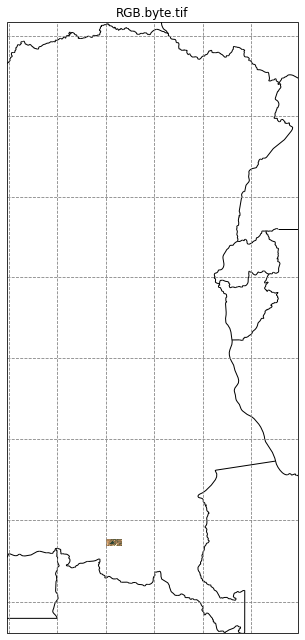

In [8]:
geod = ccrs.Geodetic()
# Google earth engine uses Mercator while S2 uses UTM, both look accurate, but Mercator is easier to use because of the zone restrictions in UTM
proj = ccrs.Mercator(central_longitude=0.0, min_latitude=-80.0, max_latitude=84.0, globe=None, latitude_true_scale=0.0)
plt.figure(figsize=(16,9))
# Entire eastern half of DRC - Mercator
ease_extent = [2500000., 3500000., -1500000., 600000.]
# Zoomed in
#ease_extent = [2750000., 2900000., -1250000., -1150000.]

# Set projection and boundaries
ax = plt.axes(projection=proj)
ax.set_extent(ease_extent, crs=proj)

# Get image for entire region and save the max reflectance value
# this value will be used to scale all of the individual regions the same
base_tiff = rasterio.open('/scratch/nason.e/gee/entire_region.tif')
base_bounds = base_tiff.bounds
# reads first 3 bands (R,G,B)
# currently those are the only bands downloaded, so .read() would have the same results (reads all of the bands available)
base_im = base_tiff.read([1, 2, 3])
base_im = np.transpose(base_im, [1,2,0])
max_val = np.amax(base_im)

# Create a list of all the Geotiffs - Pattern for desired file names in selected directory: ends in 'tif'
os.chdir("/scratch/nason.e/gee/region_geotiffs")
extension = 'tif'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

# Format each image in the list
image_list = []
for f in all_filenames:
    tiff = rasterio.open(f)
    # get image bounds
    b = tiff.bounds
    # read the image
    im = tiff.read()
    # transpose matrix columns to go from rasterio format to cartopy format
    im = np.transpose(im, [1,2,0])
    #im = im/np.amax(im) #-- this did not work -> each image was scaled differently, and the result looked like a patchwork quilt
    # scale the images to the same value range using the max value of the base image
    im = im/max_val
    # scale this to fit in a 0 to 1 range (above values fall roughly into a 0 to 0.3 range)
    im = im*(10/3)
    # Apply range limits for each channel. RGB values must be between 0 and 1 - extra check to make sure our scaling kept the values in range
    im = np.clip(im, 0, 1)
    # add image and bounds to list to be plotted in a loop
    image_list.append((im, b))

# Get the bounds for a given image, transformed to the correct projection
def image_bounds(im_single):
    xul, yul = proj.transform_point(
        x = im_single[0],
        y = im_single[1],
        src_crs = geod)
    xlr, ylr = proj.transform_point(
        x = im_single[2],
        y = im_single[3],
        src_crs = geod)
    extent = [xul, xlr, yul, ylr]
    return extent

# Map each image in the list onto the projection
for image, b in image_list:
    ax.imshow(image, extent=image_bounds(b), transform=proj, origin='upper')

# Set gridlines, country borders, coastlines, title
ax.gridlines(color='gray', linestyle='--')
ax.coastlines()
ax.add_feature(cf.BORDERS)
plt.title('RGB.byte.tif')
# Clip images to fit projected region
plt.tight_layout()